# Deep Q-Learning Applied to Algorithmic Trading

<a href="https://www.kaggle.com/code/addarm/deep-q-rl-with-algorithmic-trading-policy" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


<a href="https://colab.research.google.com/drive/1FTj65b2DA8oFgvmmjLc0XIwtII32PwcM?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


!["Pavlov's trader dog, DALEE 2024"](https://github.com/adamd1985/Deep-Q-Learning-Applied-to-Algorithmic-Trading/blob/main/images/rl_banner.PNG?raw=true)

In the book *"A Random Walk Down Wall Street"*, the author Burton G. Malkiel claimed that: “a blindfolded monkey throwing darts at a newspaper's financial pages could select a portfolio that would do just as well as one carefully selected by experts.”.

What if instead of monkey, it was Pavlov's dog trained with reinforcement learning to select the optimal portfolio strategy? In this article, Reinforcement Learning (RL) is the one used in machine learning, where an agent learns actions in an environment that maximizes their value. The agent learns from the outcomes of its actions, without being explicitly programmed with task-specific rules,

The goal of any RL algo, is to find value-maximizing policy (*π*):
$$
\pi* = \sum_{k=0}^{\infty} \gamma^k R_{t+k+1}
$$
Where *γ (0 ≤ γ ≤ 1)* is the discounting factor to control the agent's rewards, *t* is a timestep and *R* is the returns in that step. The policy in RL is the probability of taking **action *a*** in **state *s***.

The algo we will adopt is **Q-Learning**, a model-free RL algorithm, that aims to indirectly learn the policy through the **VALUE** of an action for a discrete state its in, rather the policy itself. It's useful in our case, as it doesn't need to model the environment - in our case, the random capital markets.

Estimating the **Q-Value** is done through the Bellman's equation:

$$
Q^*(s, a) = \mathbb{E}[R_{t+1} + \gamma \max_{a'} Q^*(s', a') \mid s, a]
$$

These Q-values are placed in the Q-Tables and used by the agent as look-up, to find all possible actions' Q-values from the current state, and choose the action with the highest Q-value (exploitation). This is good within a finite space, but not in a stochastic environment with limitless combinations, a problem which we will solve with our neural-network.

This agent designed in this article has been inspired by the paper of *Théate, Thibaut and Ernst, Damien (2021)*.

```BibTeX
@article{theate2021application,
  title={An application of deep reinforcement learning to algorithmic trading},
  author={Th{\'e}ate, Thibaut and Ernst, Damien},
  journal={Expert Systems with Applications},
  volume={173},
  pages={114632},
  year={2021},
  publisher={Elsevier}
}
```

In [1]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1' # KERAS 2 only for tfagents

import warnings
warnings.filterwarnings("ignore")

try:
  import google.colab
  from google.colab import files
  from google.colab import drive

  %pip install scikit-learn
  %pip install matplotlib
  %pip install tf-agents[reverb]
  %pip install shutil
  %pip install yfinance
  %pip install pyarrow
  %pip install pandas_ta
  %pip install tqdm

  IN_COLAB = True
  GDRIVE = '/content/drive'
  drive.mount(GDRIVE)
  print("Mounted on COLLAB")
except:
  GDRIVE = None
  IN_COLAB = False
  files = None

In [2]:
if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    print('Running in Kaggle...')

    %pip install scikit-learn
    %pip install matplotlib
    %pip install tf-agents[reverb]
    %pip install shutil
    %pip install yfinance
    %pip install pyarrow
    %pip install pandas_ta
    %pip install tqdm

    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

    DATA_DIR = "/kaggle/input/DATASET"
    IN_KAGGLE = True
else:
    IN_KAGGLE = False
    DATA_DIR = "./data/"

Running in Kaggle...



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.4 MB ? eta -:--:--

     ━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.2/1.4 MB 7.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.9 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 35.4 MB/s eta 0:00:00


  Installing build dependencies ... -

 \

 |

 /

 done


  Getting requirements to build wheel ... -

 done


  Preparing metadata (pyproject.toml) ... -

 done


     ━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/13.7 MB 161.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━ 10.8/13.7 MB 156.1 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 13.7/13.7 MB 161.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 65.4 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/6.4 MB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 6.3/6.4 MB 147.6 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 69.4 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 4.5 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 61.6 MB/s eta 0:00:00


 \

 done
  Created wheel for gym: filename=gym-0.23.0-py3-none-any.whl size=697628 sha256=3db102e0fa1d0615c2615f4abb9345694c49c146c5f0cb1ac7df182a7f1e7be4
  Stored in directory: /root/.cache/pip/wheels/3d/6f/b4/3991d4fae11d0ecb0754c11cc1b4e7745012850da4efaaf0b1
Successfully built gym


  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.9.0
    Uninstalling typing_extensions-4.9.0:


      Successfully uninstalled typing_extensions-4.9.0


  Attempting uninstall: keras
    Found existing installation: keras 3.0.5


    Uninstalling keras-3.0.5:


      Successfully uninstalled keras-3.0.5


  Attempting uninstall: gym
    Found existing installation: gym 0.26.2


    Uninstalling gym-0.26.2:


      Successfully uninstalled gym-0.26.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-nlp 0.8.1 requires keras-core, which is not installed.

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement shutil (from versions: none)
ERROR: No matching distribution found for shutil

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 2.2 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.7/116.7 kB 5.1 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/8.0 MB ? eta -:--:--

     ━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/8.0 MB 62.5 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 8.0/8.0 MB 117.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 60.4 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/112.2 kB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 11.1 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/3.0 MB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 71.0 MB/s eta 0:00:00


  Installing build dependencies ... -

 \

 |

 done


  Getting requirements to build wheel ... -

 done


  Preparing metadata (pyproject.toml) ... -

 done


 \

 |

 /

 done
  Created wheel for peewee: filename=peewee-3.17.1-cp310-cp310-linux_x86_64.whl size=849904 sha256=01098657ac57d35f96982e63b98438262067f615c3981adadcd44bc983908e90
  Stored in directory: /root/.cache/pip/wheels/d7/35/5c/1374782be033462df5f40174d8d879519d64ed8c25a1977554
Successfully built peewee



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.3/38.3 MB 8.3 MB/s eta 0:00:05

     ━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/38.3 MB 39.1 MB/s eta 0:00:01

     ━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/38.3 MB 83.2 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━ 20.8/38.3 MB 176.2 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━ 26.8/38.3 MB 176.5 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━ 33.0/38.3 MB 177.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 38.3/38.3 MB 182.1 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 38.3/38.3 MB 182.1 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 38.3/38.3 MB 182.1 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 38.3/38.3 MB 182.1 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 38.3/38.3 MB 182.1 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 38.3/38.3 MB 182.1 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 25.6 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/115.1 kB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.3 MB/s eta 0:00:00


  Preparing metadata (setup.py) ... -

 done


 \

 |

 done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=db7aeab879519c5f7c6a04d1d9b646d27c8fa08a7a7bed0698bedcba273303b5
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0


Successfully built pandas_ta



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import math
import shutil
import yfinance as yf
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import datetime

from scipy.stats import skew, kurtosis

import tensorflow as tf
from tf_agents.specs import array_spec, tensor_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.utils import common
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import py_environment, tf_py_environment, utils
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy, policy_saver, random_tf_policy

import reverb
from tf_agents.replay_buffers import reverb_replay_buffer, reverb_utils

from tqdm import tqdm

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# In case CPU > GPU
# tf.config.set_visible_devices([], 'GPU')

resolver = None

if ('COLAB_TPU_ADDR' in os.environ and IN_COLAB) or (IN_KAGGLE and 'TPU_NAME' in os.environ):
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'] if 'IN_COLAB' in globals() else os.environ['TPU_NAME'])
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.experimental.TPUStrategy(resolver)
    print("Running on TPU:", resolver.master())
elif tf.config.list_physical_devices('GPU'):
    strategy = tf.distribute.MirroredStrategy()
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("Running on", len(tf.config.list_physical_devices('GPU')), "GPU(s)")
else:
    strategy = tf.distribute.get_strategy()
    print("Running on CPU")

print("Number of accelerators:", strategy.num_replicas_in_sync)

os.getcwd()

Running on CPU
Number of accelerators: 1


'/kaggle/working'

In [4]:
START_DATE = "2017-01-01"
SPLIT_DATE = '2018-1-1' # Turning point from train to tst
END_DATE = "2019-12-31" # pd.Timestamp(datetime.now() - BDay(1)).strftime('%Y-%m-%d')
DATA_DIR = "./data"
INDEX = "Date"
TARGET = 'TSLA'
TICKER_SYMBOLS = [TARGET]
INTERVAL = "1d"

MODELS_PATH = './models'
LOGS_PATH = './logs'

ACT_NEUTRAL = 3 # Added this action to go to neutral and wait
ACT_LONG = 2
ACT_HOLD = 1
ACT_SHORT = 0
ACTIONS = [ACT_SHORT, ACT_HOLD, ACT_LONG]

CAPITAL = 100000
TRADE_COSTS_PERCENT = 10 / 100 / 100 # 10BPS costs

FEATURES = ["Close", "High", "Low", "Open", "Volume"]
TARGET_FEATURE = "Price Raw"
STATE_LEN = 30
OBS_SPACE = (STATE_LEN)*len(FEATURES)
ACT_SPACE = len(ACTIONS)

BATCH_SIZE = 32
LEARN_RATE = 1e-3
TOTAL_ITERS = 12000
TRAIN_EPISODES = 10
INIT_COLLECT = 100
TOTAL_COLLECT = 1
LOG_INTERVALS = 20
TEST_INTERVALS = 100
MEMORY_LENGTH = 100000
DISCOUNT = 0.4
EPSILON_START = 1.
TARGET_UPDATE = 1000
EPSILON_END = 0.01
EPSILON_DECAY = 10000
GRAD_CLIP = 1
REWARD_CLIP = 1

DROPOUT = 0.2
L2FACTOR = 0.000001
NEURONS = 512
LAYERS = (NEURONS, NEURONS, NEURONS, NEURONS, NEURONS)

# Financial Data

We download some financial data, this is now the standard in our articles.

In [5]:
def get_tickerdata(tickers_symbols, start=START_DATE, end=END_DATE, interval=INTERVAL, datadir=DATA_DIR):
    tickers = {}
    earliest_end= datetime.strptime(end,'%Y-%m-%d')
    latest_start = datetime.strptime(start,'%Y-%m-%d')
    os.makedirs(DATA_DIR, exist_ok=True)
    for symbol in tickers_symbols:
        cached_file_path = f"{datadir}/{symbol}-{start}-{end}-{interval}.csv"

        try:
            if os.path.exists(cached_file_path):
                df = pd.read_parquet(cached_file_path)
                df.index = pd.to_datetime(df.index)
                assert len(df) > 0
            else:
                df = yf.download(
                    symbol,
                    start=START_DATE,
                    end=END_DATE,
                    progress=False,
                    interval=INTERVAL,
                )
                assert len(df) > 0
                df.to_parquet(cached_file_path, index=True, compression="snappy")
            min_date = df.index.min()
            max_date = df.index.max()
            nan_count = df["Close"].isnull().sum()
            skewness = round(skew(df["Close"].dropna()), 2)
            kurt = round(kurtosis(df["Close"].dropna()), 2)
            outliers_count = (df["Close"] > df["Close"].mean() + (3 * df["Close"].std())).sum()
            print(
                f"{symbol} => min_date: {min_date}, max_date: {max_date}, kurt:{kurt}, skewness:{skewness}, outliers_count:{outliers_count},  nan_count: {nan_count}"
            )
            tickers[symbol] = df

            if min_date > latest_start:
                latest_start = min_date
            if max_date < earliest_end:
                earliest_end = max_date
        except Exception as e:
            print(f"Error with {symbol}: {e}")

    return tickers, latest_start, earliest_end

tickers, latest_start, earliest_end = get_tickerdata(TICKER_SYMBOLS)
tickers[TARGET]

TSLA => min_date: 2017-01-03 00:00:00, max_date: 2019-12-30 00:00:00, kurt:-0.56, skewness:-0.28, outliers_count:0,  nan_count: 0


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,14.324000,14.688667,14.064000,14.466000,14.466000,88849500
2017-01-04,14.316667,15.200000,14.287333,15.132667,15.132667,168202500
2017-01-05,15.094667,15.165333,14.796667,15.116667,15.116667,88675500
2017-01-06,15.128667,15.354000,15.030000,15.267333,15.267333,82918500
2017-01-09,15.264667,15.461333,15.200000,15.418667,15.418667,59692500
...,...,...,...,...,...,...
2019-12-23,27.452000,28.134001,27.333332,27.948000,27.948000,199794000
2019-12-24,27.890667,28.364668,27.512667,28.350000,28.350000,120820500
2019-12-26,28.527332,28.898666,28.423332,28.729334,28.729334,159508500


# The Problem Definition

With Q-Training, we shall teach a pavlovian-agent to trade. Our objective is to make sequential interaction that lead to the highest sharpe ratio, formalized by this policy (remember Q-Learning is off-policy, and we won't learn this directly):

$$
\pi^*(a_t | s_t) = \arg\max_{a \in \mathcal{A}} \mathbb{E} \left[ \sum_{t=0}^{\infty} \gamma^t r_t \middle| s_t = f(o_1, a_1, r_1, \ldots, o_t), a_t \right]
$$

At each timestep *t*:

1. Observe the environments state *st* and map history with *f(.)*
2. Observations *ot* from history *ht*, have previous actions *a_t-1*, previous observations *o_t-1* and their returns *r_t-1*. For our experiment, we'll encode these into features for a network.
3. Execute action *a_t*, which can be: hold, long, short
4. Get returns *r_t* discounted at *γt*. *γ* is the discounting factor to prevent the agent from doing only tactical choices for returns in the present (missing better future returns).


The *π(at|ht)* creates an action on a Quantity Q *at = Qt*. Where a positive *Q* is the long, the negative *Q* signals a short and when its 0 no action is taken. For this article we will use the definition of policy *π(at|ht)* and Q-Value *Q(at,st)* interchangeably, as Q will define quantities bought.

## Observations and State Space

The paper uses only High, Low, Open, Close and Volume as observations from the agent's environment state.

We will augment this space with 2 technical indicators and 2 macroeconomic indicators:
- 20day slow and 7 day fast exponential moving average, from our article: "Momentum and Reversion Trading Signals Analysis"
- The daily VIX as proxy for market volatility & fear, and the 2 year T-note as proxy for inflation & rates, from our article: "Temporal Convolutional Neural Network with Conditioning for Broad Market Signals"

$$
o_t = s_t \in \{{\text{High}_t}, {\text{Low}_t}, {\text{Open}_t}, {\text{Close}_t}, {\text{Volume}_t}, {\text{FastEMA}_t}, {\text{SlowEMA}_t}, {\text{VIX}_t}, {\text{T2YR}_t}\}
$$

## Actions and Rewards

A core concept in RL is rewards engineering. Let's look at our action space *A* at time *t*:

$$
a_t = Q_t \in \{Q_{\text{Long}, t}, Q_{\text{Short}, t}\}
$$

The action *Q_Long,t* is set to maximize returns on a buy, given our liquidity *vc_t* (the value *v* of our portfolio with cash remainng *c*) and purchasing *Q_long* at price *p* shares (transaction costs *C*) if we are not already long:

$$
Q_{\text{Long}, t} =
\begin{cases}
\left\lfloor \frac{v_{c,t}}{p_t (1 + C)}\right\rfloor & \text{if } a_{t-1} \neq Q_{\text{Long}, t-1}, \\
0 & \text{otherwise}.
\end{cases}
$$

The action *Q_Short,t* aims to convert a **negative** number of shares to returns (shorting is the borrowing of shares, therefore our *v_c* will be initially negative).

$$
\hat{Q}_{\text{Short}, t} =
\begin{cases}
-2n_t - \left\lfloor \frac{v_{c,t}}{p_t (1 + C)}\right\rfloor & \text{if } a_{t-1} \neq Q_{\text{Short}, t-1}, \\
0 & \text{otherwise}.
\end{cases}
$$

Note the *-2n* is an indication to sell twice, meaning not only close the long position but open a short position for the *Qn* shares, since shorting is a negative trajectory, we need to negate the amount we can buy to get the correct representation in our holdings. If we had no shares to start, then *-2(0)* will not have an effect save for the short amount:

$$
\hat{Q}_{\text{Short}, t} = -\left\lfloor \frac{v_{c,t}}{p_t (1 + C)} \right\rfloor
$$

Shorts are risky, and we need to give boundaries to the agent, as a short can incur infinite loss:

$$
Q_{\text{Short}, t} = \max\{\hat{Q}_{\text{Short}, t}, Q_t\}
$$

Given that our portfolio cannot fall into negative amounts, we need to model constraints.
1. Cash value *vc_t* needs to be large enough to return to neutral *n_t=0*.
2. To return to 0, we need to adjust for costs *C* which are caused by market volatility epsiloc *ϵ* (think slippages, spreads, etc..).
3. We redefine the action space permissable to ensure we can always return to neutral.

$$
v_{c,t+1} \geq -n_{t+1} p_t (1 + \varepsilon)(1 + C)
$$

The action space *A* is redefined as a set of acceptable values for *Q_t* between boundaries *Q-* and *Q+*:

$$
A = \left\{ Q_t \in \mathbb{Z} \cap \left[Q_t^-, Q_t^+\right] \right\}
$$

Where the top boundary *Q+* is:
$$
Q_t^+ = \frac{v_{c,t}}{p_t (1+C)}
$$

And the lower boundary *Q-* is (for both coming out of a long where delta *t* is positive, or reversing a short and incurring twice the costs with delta *t* in the negative):

$$
Q_t^- = \begin{cases}
    \frac{\Delta t}{p_t \varepsilon (1 + C)} & \text{if } \Delta t \geq 0, \\
    \frac{\Delta t}{p_t (2C + \varepsilon(1 + C))} & \text{if } \Delta t < 0,
    \end{cases}
$$

with *delta t* being the in change of portfolio value in time:

$$
 t_Δ = -v_{c,t} - n_t p_t (1 + \varepsilon)(1 + C)
$$

In the above boundaries, the cost of trading is defined as:

$$
v_{c,t+1} = v_{c,t} - Q_t p_t - C |Q_t| p_t
$$

Where *C* is the percentage cost of the transaction given the absolute quantity *|Q_t|* of shares and their price *p_t*.

## Agent's Objective

In the paper, they utilize the percentage returns as a rewards signal, clipped between -1 and 1, and adjusted by a discount factor γ:
$$
\text{Signal} = \left( \frac{vc_{t} - vc_{t-1}}{vc_{t-1}} \right) \gamma^t
$$

In the article, we will use an annualized Sharpe (from *N* time window, up to 252 trading days), and teach the agent's to generate an optimal ratio, clipped no discount factor:

$$
\text{Signal} = \frac{E\left[\sum_{t=0}^{T} r_t - R_f\times \right]\sqrt{N} }{\sqrt{\mathrm{Var}\left[\sum_{t=0}^{T} r_t\right]}}
$$

which is just the maximization of:

$$
\text{sharpe}= \left( \frac{\bar{R} - R_f}{\sigma} \right)
$$

or the returns of the portfolio (*R* average), minus the risk free rate (*Rf*, at the time of writing, 5%) divided by the volatility (*σ*) of the portfolio

# Trading Environment

Using TensorFlow's PyEnvironment, we will give the agent the environment that implements the above rules:

In [6]:
class TradingEnv(py_environment.PyEnvironment):
    """
    A custom trading environment for reinforcement learning, compatible with tf_agents.

    This environment simulates a simple trading scenario where an agent can take one of three actions:
    - Long (buy), Short (sell), or Hold a financial instrument, aiming to maximize profit through trading decisions.

    Parameters:
    - data: DataFrame containing the stock market data.
    - data_dim: Dimension of the data to be used for each observation.
    - money: Initial capital to start trading.
    - state_length: Number of past observations to consider for the state.
    - transaction_cost: Costs associated with trading actions.
    """

    def __init__(self, data, features = FEATURES, money=CAPITAL, state_length=STATE_LEN, transaction_cost=0, market_costs=TRADE_COSTS_PERCENT, reward_discount=DISCOUNT):
        super(TradingEnv, self).__init__()

        assert data is not None

        self.features = features
        self.data_dim = len(self.features)
        self.state_length = state_length
        self.current_step = self.state_length
        self.reward_discount = reward_discount

        self.balance = money
        self.initial_balance = money
        self.transaction_cost = transaction_cost
        self.epsilon = max(market_costs, np.finfo(float).eps) # there is always volatility costs
        self.total_shares = 0

        self._episode_ended = False
        self._batch_size = 1
        self._action_spec = array_spec.BoundedArraySpec(shape=(), dtype=np.int32, minimum=ACT_SHORT, maximum=ACT_LONG, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(shape=(self.state_length * self.data_dim, ), dtype=np.float32, name='observation')

        self.data = self.preprocess_data(data.copy())

        self.reset()

    @property
    def batched(self):
        return False #True

    @property
    def batch_size(self):
        return None #self._batch_size

    @batch_size.setter
    def batch_size(self, size):
        self._batch_size = size

    def preprocess_data(self, df):
        def _log_rets(df):
            log_returns = np.log(df / df.shift(1))
            df = (log_returns - log_returns.mean()) / log_returns.std()
            df = df.dropna()
            return df

        def min_max_scale_tensor(tensor):
            min_val = tf.reduce_min(tensor)
            max_val = tf.reduce_max(tensor)
            return (tensor - min_val) / (max_val - min_val)

        price_raw = df['Close'].copy()
        for col in self.features:
            tensor = tf.convert_to_tensor(df[col], dtype=tf.float32)
            normalized_tensor = min_max_scale_tensor(tensor)
            df[col] = normalized_tensor.numpy()

        df = df.replace(0.0, np.nan)
        df = df.interpolate(method='linear', limit=5, limit_area='inside')
        df = df.ffill().bfill()

        df[TARGET_FEATURE] = price_raw
        df['Sharpe'] = 0
        df['Position'] = 0
        df['Action'] = ACT_HOLD
        df['Holdings'] = 0.
        df['Cash'] = float(self.balance)
        df['Money'] = df['Holdings'] + df['Cash']
        df['Returns'] = 0.

        assert not df.isna().any().any()

        return df

    def action_spec(self):
        """Provides the specification of the action space."""
        return self._action_spec

    def observation_spec(self):
        """Provides the specification of the observation space."""
        return self._observation_spec

    def _reset(self):
        """Resets the environment state and prepares for a new episode."""
        self.balance = self.initial_balance
        self.current_step = self.state_length
        self._episode_ended = False
        self.total_shares = 0

        self.data['Sharpe'] = 0
        self.data['Position'] = 0
        self.data['Action'] = ACT_HOLD
        self.data['Holdings'] = 0.
        self.data['Cash']  = float(self.balance)
        self.data['Money'] = self.data.iloc[0]['Holdings'] + self.data.iloc[0]['Cash']
        self.data['Returns'] = 0.

        initial_observation = self._next_observation()
        return ts.restart(initial_observation)

    def _next_observation(self):
        """Generates the next observation based on the current step and history length."""
        start_idx = max(0, self.current_step - self.state_length + 1)
        end_idx = self.current_step + 1
        obs = self.data[self.features].iloc[start_idx:end_idx]

        # flatten because: https://stackoverflow.com/questions/67921084/dqn-agent-issue-with-custom-environment
        obs_values = obs.values.flatten().astype(np.float32)
        return obs_values

    def _step(self, action):
        """Executes a trading action and updates the environment's state."""
        if self._episode_ended:
            return self.reset()

        self.current_step += 1
        current_price = self.data.iloc[self.current_step][TARGET_FEATURE]

        assert not self.data.iloc[self.current_step].isna().any().any()

        if action == ACT_LONG:
            self._process_long_position(current_price)
        elif action == ACT_SHORT:
            prev_current_price = self.data.iloc[self.current_step - 1][TARGET_FEATURE]
            self._process_short_position(current_price, prev_current_price)
        elif action == ACT_HOLD:
            self._process_hold_position()
        elif action == ACT_NEUTRAL:
            self._process_neutral_position(current_price)
        else:
          raise Exception(f"Invalid Actions: {action}")

        self._update_financials()
        done = self.current_step >= len(self.data) - 1
        reward = self._calculate_reward_signal()
        if done:
            self._episode_ended = True
            return ts.termination(self._next_observation(), reward)
        else:
            return ts.transition(self._next_observation(), reward, discount=self.reward_discount)

    def _get_lower_bound(self, cash, total_shares, price):
        """
        Compute the lower bound of the action space, particularly for short selling,
        based on current cash, the number of shares, and the current price.
        """
        delta = -cash - total_shares * price * (1 + self.epsilon) * (1 + self.transaction_cost)

        if delta < 0:
            lowerBound = delta / (price * (2 * self.transaction_cost + self.epsilon * (1 + self.transaction_cost)))
        else:
            lowerBound = delta / (price * self.epsilon * (1 + self.transaction_cost))

        if np.isinf(lowerBound):
            assert False
        return lowerBound

    def _process_hold_position(self):
        step_idx = self.data.index[self.current_step]
        self.data.at[step_idx, "Cash"] = self.data.iloc[self.current_step - 1]["Cash"]
        self.data.at[step_idx, "Holdings"] = self.data.iloc[self.current_step - 1]["Holdings"]
        self.data.at[step_idx, "Position"] = self.data.iloc[self.current_step - 1]["Position"]
        self.data.at[step_idx, "Action"] = ACT_HOLD

    def _process_neutral_position(self, current_price):
        step_idx = self.data.index[self.current_step]
        self.data.at[step_idx, "Cash"] = self.data.iloc[self.current_step - 1]['Cash'] - self.total_shares * current_price * (1 + self.transaction_cost)
        self.data.at[step_idx, "Holdings"] = 0.0
        self.data.at[step_idx, "Position"] = 0.0
        self.data.at[step_idx, "Action"] = ACT_NEUTRAL

    def _process_long_position(self, current_price):
        step_idx = self.data.index[self.current_step]
        self.data.at[step_idx, 'Position'] = 1
        self.data.at[step_idx, 'Action'] = ACT_LONG

        if self.data.iloc[self.current_step - 1]['Position'] == 1:
            # more long
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]['Cash']
            self.data.at[step_idx, 'Holdings'] = self.total_shares * current_price
        elif self.data.iloc[self.current_step - 1]['Position'] == ACT_HOLD:
            # new long
            self.total_shares = math.floor(self.data.iloc[self.current_step - 1]['Cash'] / (current_price * (1 + self.transaction_cost)))
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]['Cash'] - self.total_shares * current_price * (1 + self.transaction_cost)
            self.data.at[step_idx, 'Holdings'] = self.total_shares * current_price
        else:
            # short to long
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]['Cash'] - self.total_shares * current_price * (1 + self.transaction_cost)
            self.total_shares = math.floor(self.data.iloc[self.current_step]['Cash'] / (current_price * (1 + self.transaction_cost)))
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step]['Cash'] - self.total_shares * current_price * (1 + self.transaction_cost)
            self.data.at[step_idx, 'Holdings'] = self.total_shares * current_price

    def _process_short_position(self, current_price, prev_price):
        """
        Adjusts the logic for processing short positions to include lower bound calculations.
        """
        step_idx = self.data.index[self.current_step]
        self.data.at[step_idx, 'Position'] = -1
        self.data.at[step_idx, 'Action'] = ACT_SHORT
        if self.data.iloc[self.current_step - 1]['Position'] == -1:
            # Short more
            low = self._get_lower_bound(self.data.iloc[self.current_step - 1]['Cash'], -self.total_shares, prev_price)
            if low <= 0:
                self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]["Cash"]
                self.data.at[step_idx, 'Holdings'] = -self.total_shares * current_price
            else:
                total_sharesToBuy = min(math.floor(low), self.total_shares)
                self.total_shares -= total_sharesToBuy
                self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]["Cash"] - total_sharesToBuy * current_price * (1 + self.transaction_cost)
                self.data.at[step_idx, 'Holdings'] = -self.total_shares * current_price
        elif self.data.iloc[self.current_step - 1]['Position'] == 0:
            # new short
            self.total_shares = math.floor(self.data.iloc[self.current_step - 1]["Cash"] / (current_price * (1 + self.transaction_cost)))
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]["Cash"] + self.total_shares * current_price * (1 - self.transaction_cost)
            self.data.at[step_idx, 'Holdings'] = -self.total_shares * current_price
        else:
            # long to short
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]["Cash"] + self.total_shares * current_price * (1 - self.transaction_cost)
            self.total_shares = math.floor(self.data.iloc[self.current_step]["Cash"] / (current_price * (1 + self.transaction_cost)))
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step]["Cash"] + self.total_shares * current_price * (1 - self.transaction_cost)
            self.data.at[step_idx, 'Holdings'] = -self.total_shares * current_price

    def _update_financials(self):
        """Updates the financial metrics including cash, money, and returns."""
        step_idx = self.data.index[self.current_step]
        self.balance = self.data.iloc[self.current_step]['Cash']

        self.data.at[step_idx,'Money'] = self.data.iloc[self.current_step]['Holdings'] + self.data.iloc[self.current_step]['Cash']
        self.data.at[step_idx,'Returns'] = ((self.data.iloc[self.current_step]['Money'] - self.data.iloc[self.current_step - 1]['Money'])) / self.data.iloc[self.current_step - 1]['Money']

    def _calculate_reward_signal(self, reward_clip=REWARD_CLIP):
        """
        Calculates the reward for the current step. In the paper they use the %returns.
        """
        return np.clip(self.data.iloc[self.current_step]['Returns'], -reward_clip, reward_clip)

    def _calculate_sharpe_reward_signal(self, risk_free_rate=0.05, periods_per_year=252, reward_clip=REWARD_CLIP):
        """
        Calculates the annualized Sharpe ratio up to the CURRENT STEP.

        Parameters:
        - risk_free_rate (float): The annual risk-free rate. It will be adjusted to match the period of the returns.
        - periods_per_year (int): Number of periods in a year (e.g., 252 for daily, 12 for monthly).

        Returns:
        - float: The annualized Sharpe ratio as reward.
        """
        period_risk_free_rate = (1 + risk_free_rate) ** (1 / periods_per_year) - 1
        observed_returns = self.data['Returns'].iloc[:self.current_step + 1]

        excess_returns = observed_returns - period_risk_free_rate

        mean_excess_return = np.mean(excess_returns)
        std_dev_returns = np.std(observed_returns)

        sharpe_ratio = mean_excess_return / std_dev_returns if std_dev_returns > 0 else 0
        annual_sr = sharpe_ratio * np.sqrt(periods_per_year)

        self.data.at[self.data.index[self.current_step], 'Sharpe'] = annual_sr

        return np.clip(annual_sr, -reward_clip, reward_clip)

    def calculate_churn(self):
        churn = 0
        prev_position = 0
        for i in range(1, self.current_step + 1):
            current_position = self.data.at[self.data.index[i], 'Position']
            action = self.data.at[self.data.index[i], 'Action']
            if action in [ACT_LONG, ACT_SHORT] and current_position != prev_position:
                churn += self.transaction_cost

            prev_position = current_position

        if self.current_step > 0:
            churn /= self.current_step

        return churn

    def calculate_drawdown_metrics(self):
        cumulative_returns = (1 + self.data['Returns'].iloc[:self.current_step + 1]).cumprod()
        peak = cumulative_returns.expanding(min_periods=1).max()
        drawdown = (cumulative_returns - peak) / peak

        peak_dates = cumulative_returns[peak == cumulative_returns]
        drawdown_durations = pd.Series(index=drawdown.index, dtype='timedelta64[ns]')
        for date in drawdown.index:
            recent_peak_date = peak_dates[peak_dates.index <= date].index[-1]
            duration = date - recent_peak_date
            drawdown_durations.at[date] = duration

        drawdown_durations_days = drawdown_durations.dt.days
        max_dd_duration_days = drawdown_durations_days.max()

        return drawdown, max_dd_duration_days

    def get_trade_stats(self, riskfree_rate=0.05):
        rets = self.data['Returns'].iloc[:self.current_step + 1]

        monthly_riskfree_rate = (1 + riskfree_rate)**(1/12) - 1

        annualized_return = rets.mean() * 12
        annualized_vol = rets.std() * np.sqrt(12)
        sharpe_ratio = (rets.mean() - monthly_riskfree_rate) / rets.std() * np.sqrt(12)

        downside_deviation = rets[rets < 0].std() * np.sqrt(12)
        drawdowns, max_dd_duration_days = self.calculate_drawdown_metrics()

        sortino_ratio = (rets.mean() - monthly_riskfree_rate) / downside_deviation

        churn = self.calculate_churn()

        return {
            "Annualized Return": annualized_return,
            "Annualized Vol": annualized_vol,
            "Sharpe Ratio": sharpe_ratio,
            "Downside Deviation": downside_deviation,
            "Sortino Ratio": sortino_ratio,
            "Max Drawdown": drawdowns.max(),
            "Max Drawdown Days": max_dd_duration_days,
            "Trade Churn": churn,
            "Skewness": skew(rets.values),
            "Kurtosis": kurtosis(rets.values)
        }

    def render(self, mode='human'):
        print(f'Step: {self.current_step}, Balance: {self.balance}, Holdings: {self.total_shares}')
        print(f"trade stats: {self.get_trade_stats()}")

In [7]:
stock= tickers[TARGET]
train_data = stock[stock.index < pd.to_datetime(SPLIT_DATE)].copy()
test_data = stock[stock.index >= pd.to_datetime(SPLIT_DATE)].copy()

train_env = TradingEnv(train_data)
utils.validate_py_environment(train_env, episodes=TRAIN_EPISODES)
test_env = TradingEnv(test_data)
utils.validate_py_environment(train_env, episodes=TRAIN_EPISODES//4)

print(f"TimeStep Specs: {train_env.time_step_spec()}")
print(f"Action Specs: {train_env.action_spec()}")
print(f"Reward Specs: {train_env.time_step_spec().reward}")

2024-03-15 10:28:44.615305: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-15 10:28:44.615427: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-15 10:28:44.615510: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-15 10:28:44.615611: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-15 10:28:44.615689: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-15 10:28:44.615873: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-15 10:28:44.615973: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this 

TimeStep Specs: TimeStep(
{'step_type': ArraySpec(shape=(), dtype=dtype('int32'), name='step_type'),
 'reward': ArraySpec(shape=(), dtype=dtype('float32'), name='reward'),
 'discount': BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0),
 'observation': BoundedArraySpec(shape=(150,), dtype=dtype('float32'), name='observation', minimum=-3.4028234663852886e+38, maximum=3.4028234663852886e+38)})
Action Specs: BoundedArraySpec(shape=(), dtype=dtype('int32'), name='action', minimum=0, maximum=2)
Reward Specs: ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [8]:
def execute_action_and_print_state(env, action):
    next_time_step = env.step(np.array(action, dtype=np.int32))
    print(f'Action taken: {action} at step: {env.current_step}')
    # print(f'New state: {next_time_step.observation}')
    print(f'New balance: {env.balance}')
    print(f'Total shares: {env.total_shares}')
    print(f'Reward: {next_time_step.reward}\n')

time_step = train_env.reset()
# print(f'Initial state: {time_step.observation}')

# Some dryruns to validate our env logic: Buy, Sell, we should have a positive balance with TSLA
execute_action_and_print_state(train_env, ACT_HOLD)
execute_action_and_print_state(train_env, ACT_LONG)
execute_action_and_print_state(train_env, ACT_SHORT)
execute_action_and_print_state(train_env, ACT_HOLD)
execute_action_and_print_state(train_env, ACT_LONG)

Action taken: 1 at step: 31
New balance: 100000.0
Total shares: 0
Reward: 0.0

Action taken: 2 at step: 32
New balance: 0.848236083984375
Total shares: 5510
Reward: 0.0

Action taken: 0 at step: 33
New balance: 203790.03025054932
Total shares: 5510
Reward: 0.01895439252257347

Action taken: 1 at step: 34
New balance: 203790.03025054932
Total shares: 5510
Reward: 0.0

Action taken: 2 at step: 35
New balance: 4.924432754516602
Total shares: 6431
Reward: 0.07714703679084778



# Deep Q-Network Architecure

## Architecture

Deep Q-neural-network architecture (DQN) approximates the the Q-tables algorithm as its approximating the action-value function π∗(at|st). Its an approximation because the number of combinations you can have with your Q-Tables is gargantuan and impossible to process.

The Q-network is also referred to as the policy model. We will also leverage a target Q-network in our architecture. Tha Target model is updated more seldomly than the Q-Network, and helps stabilize the training process as the Q-Network is trained to reduced its output and the target network (a more stable value).

Finally, we will add a Replay Memory to sample data for our models. The memory is a circular memory of fixed size (therefore it 'forgets' old memories), and at every fixed frequency the models use the memory to calculate the loss between their predicted Q values and the ones performed in the memory.

## The Reinforce Learning Flow

A picture says a thousand words; the flow chart below will guide us on the whole training and updating the target model:

!["Flowchart of training"](https://raw.githubusercontent.com/adamd1985/Deep-Q-Learning-Applied-to-Algorithmic-Trading/main/images/Q-net.png)

First we initinialize the environment *St* and the action state *Qt*.

We then run multiple episodes of n iterations to train the model and remember the state, actions and the Q value predicted. On each iteration, these events will occur:
1. Fetch the state.
1. Take either a random action (ε greedy) or predict a Q value given an action in the current state, the former is called exploration, and the latter exploitation. The ε decays with time, as the model learns, it should explore less.
1. When predicting the Q value, it will use the policy model. Regardles of exploring or explointing, it saves the memory of the states, actions and the given Q value.
1. Calculate the target Q-Value by taking the max predictions from the target-network. From the previous formula *rt + γt * Qtarget(s_t+1, a_t+1)* where gamma *γ* is the discounting factor.
1. Re-traing the policy model to minimize the Q-values from the different models. Training uses sampled states from our replay memory.
1. At the end of the episode, or any interval of our chosing, we copy the wieghts of the policy model to the target model.

In [9]:
def create_q_network(env, fc_layer_params=LAYERS, dropout_rate=DROPOUT, l2_reg=L2FACTOR):
    """
    Creates a Q-Network with dropout and batch normalization.
    Parameters:
    - env: The environment instance.
    - fc_layer_params: Tuple of integers representing the number of units in each dense layer.
    - dropout_rate: Dropout rate for dropout layers.
    - l2_reg: L2 regularization factor.

    Returns:
    - q_net: The Q-Network model.
    """
    env = tf_py_environment.TFPyEnvironment(env)
    action_tensor_spec = tensor_spec.from_spec(env.action_spec())
    num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

    layers = []
    for num_units in fc_layer_params:
        layers.append(tf.keras.layers.Dense(
                                num_units,
                                activation=None,
                                kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='truncated_normal'),
                                kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
        layers.append(tf.keras.layers.BatchNormalization())
        layers.append(tf.keras.layers.LeakyReLU())
        layers.append(tf.keras.layers.Dropout(dropout_rate))

    q_values_layer = tf.keras.layers.Dense(
        num_actions,
        activation=None,
        kernel_initializer=tf.keras.initializers.GlorotNormal(),
        bias_initializer=tf.keras.initializers.GlorotNormal(),
        kernel_regularizer=tf.keras.regularizers.l2(l2_reg))

    q_net = sequential.Sequential(layers + [q_values_layer])

    return q_net

def create_agent(q_net, env, t_q_net = None, optimizer = None, eps=EPSILON_START, learning_rate=LEARN_RATE, gradient_clipping = GRAD_CLIP):
    """
    Creates a DQN agent for a given environment with specified configurations.

    Parameters:
    - q_net (tf_agents.networks.Network): The primary Q-network for the agent.
    - env (tf_agents.environments.PyEnvironment or tf_agents.environments.TFPyEnvironment):
      The environment the agent will interact with. A TFPyEnvironment wrapper is applied
      if not already wrapped.
    - t_q_net (tf_agents.networks.Network, optional): The target Q-network for the agent.
      If None, no target network is used.
    - optimizer (tf.keras.optimizers.Optimizer, optional): The optimizer to use for training the agent.
      If None, an Adam optimizer with exponential decay learning rate is used.
    - eps (float): The epsilon value for epsilon-greedy exploration.
    - learning_rate (float): The initial learning rate for the exponential decay learning rate schedule.
      Ignored if an optimizer is provided.
    - gradient_clipping (float): The value for gradient clipping. If 1., no clipping is applied.

    Returns:
    - agent (tf_agents.agents.DqnAgent): The initialized and configured DQN agent.
    """
    if optimizer is None:
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate, decay_steps=1000, decay_rate=0.96, staircase=True)
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    env = tf_py_environment.TFPyEnvironment(env)
    # see: https://www.tensorflow.org/agents/api_docs/python/tf_agents/agents/DqnAgent
    agent = dqn_agent.DqnAgent(
        env.time_step_spec(),
        env.action_spec(),
        q_network=q_net,
        target_q_network = t_q_net,
        target_update_period = TARGET_UPDATE,
        optimizer=optimizer,
        epsilon_greedy = eps,
        reward_scale_factor = 1,
        gradient_clipping = gradient_clipping,
        td_errors_loss_fn=common.element_wise_huber_loss,
        train_step_counter=tf.compat.v1.train.get_or_create_global_step(),
        name="TradeAgent")

    agent.initialize()
    print(agent.policy)
    print(agent.collect_policy)
    return agent

with strategy.scope():
  q_net = create_q_network(train_env)
  t_q_net = create_q_network(train_env)
  agent = create_agent(q_net, train_env, t_q_net=t_q_net)

# Trading Operations

Using TensorFlow agents' framework, training our pavlovian trader should be easier than building the architecture ourselves.

The trading simulator class will prepare all the variables required. In this case it will initialize the reply memory using DeepMind's Reverb, and create a collector policy for the agent. Unlike the evaluation policy (*π(at|ht)*) which is use to predict the target Q value, the collector will explore and collect data with actions and their resulting value for the memory, memories are saved as trajectories (*τ*) in tensorflow which is a collection of the current observed state (*ot*), the action taken (*at*), the reward received (*r_t+1*) and the following observed state (*o_t+1*) formalized as *r=(o_t-1, a_t-1, rt, ot, dt)*, where dt is a flag for the end state if this was the last observation.

To give learning opportunity to our agent, we will use a high epsilon to have it explore a lot, and slowly decay it using the formula below:

$$
\epsilon_{\text{decayed}} = \epsilon_{\text{final}} + (\epsilon_{\text{initial}} - \epsilon_{\text{final}}) \times e^{-\frac{\text{step}}{\text{decay\_steps}}}
$$

Where:
- *ϵ_decayed* is the decayed epsilon value at the current step,
- *ϵ_initial* is the initial epsilon value at the start of training, we set it to 1, meaning it only explores at start.
- *ϵ_final* is the end value we want that the agent exploits is environment, preferably when deployed.
- *step* is the current step or iteration in the training process, and decay_steps is a parameter that controls the rate, in our case 1000. As the steps approach the end, the decay will get smaller and smaller.


In [10]:
import tensorflow as tf

class CustomMetrics(tf.Module):
    def __init__(self, name=None):
        super(CustomMetrics, self).__init__(name=name)
        self.total_returns = tf.Variable([], dtype=tf.float32, trainable=False, shape=tf.TensorShape(None))
        self.average_returns = tf.Variable([], dtype=tf.float32, trainable=False, shape=tf.TensorShape(None))
        self.sharpe_ratios = tf.Variable([], dtype=tf.float32, trainable=False, shape=tf.TensorShape(None))
        self.losses = tf.Variable([], dtype=tf.float32, trainable=False, shape=tf.TensorShape(None))

    def update_metrics(self, losses=None, total_return=None, average_return=None, sharpe_ratio=None):
        if total_return is not None:
            self.total_returns.assign(tf.concat([self.total_returns.value(), [total_return]], axis=0))
        if total_return is not None:
            self.average_returns.assign(tf.concat([self.average_returns.value(), [average_return]], axis=0))
        if total_return is not None:
            self.sharpe_ratios.assign(tf.concat([self.sharpe_ratios.value(), [sharpe_ratio]], axis=0))
        if losses is not None:
            self.losses.assign(tf.concat([self.losses.value(), [losses]], axis=0))

class TradingSimulator:
    def __init__(self, env, eval_env, agent, episodes=TRAIN_EPISODES,
                 batch_size=BATCH_SIZE, num_eval_episodes=TEST_INTERVALS,
                 collect_steps_per_iteration=INIT_COLLECT,
                 replay_buffer_max_length=MEMORY_LENGTH ,
                 num_iterations = TOTAL_ITERS, log_interval=LOG_INTERVALS,
                 eval_interval=None, global_step=None):
        self.py_env = env
        self.env =  tf_py_environment.TFPyEnvironment(self.py_env)
        self.py_eval_env = eval_env
        self.eval_env =  tf_py_environment.TFPyEnvironment(self.py_eval_env)
        self.agent = agent
        self.episodes = episodes
        self.log_interval = log_interval
        self.eval_interval = eval_interval
        self.global_step = global_step

        self.batch_size = batch_size
        self.num_eval_episodes = num_eval_episodes
        self.collect_steps_per_iteration = collect_steps_per_iteration
        self.replay_buffer_max_length = replay_buffer_max_length
        self.num_iterations = num_iterations

        self.policy = self.agent.policy
        self.collect_policy = self.agent.collect_policy
        self.random_policy = random_tf_policy.RandomTFPolicy(
            self.env.time_step_spec(),
            self.env.action_spec())

        self.replay_buffer_signature = tensor_spec.from_spec(
            self.agent.collect_data_spec)
        self.replay_buffer_signature = tensor_spec.add_outer_dim(
            self.replay_buffer_signature)

    def init_memory(self, table_name = 'uniform_table'):
        self.table = reverb.Table(
            table_name,
            max_size=self.replay_buffer_max_length,
            sampler=reverb.selectors.Uniform(),
            remover=reverb.selectors.Fifo(),
            rate_limiter=reverb.rate_limiters.MinSize(1),
            signature=self.replay_buffer_signature)

        self.reverb_server = reverb.Server([self.table])
        self.replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
                                    self.agent.collect_data_spec,
                                    table_name=table_name,
                                    sequence_length=2,
                                    local_server=self.reverb_server)

        self.rb_observer = reverb_utils.ReverbAddTrajectoryObserver(self.replay_buffer.py_client, table_name, sequence_length=2)
        self.dataset = self.replay_buffer.as_dataset(num_parallel_calls=3, sample_batch_size=self.batch_size, num_steps=2).prefetch(3)

        return self.dataset, iter(self.dataset)

    def eval_metrics(self, num_eval_episodes):
        @tf.function
        def _eval_step():
            time_step = self.eval_env.reset()
            episode_returns = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True, clear_after_read=False)

            while not time_step.is_last():
                action_step = self.policy.action(time_step)
                time_step = self.eval_env.step(action_step.action)
                rewards = time_step.reward
                episode_returns = episode_returns.write(episode_returns.size(), rewards)

            episode_returns_stacked = episode_returns.stack()
            cumulative_returns = tf.math.cumprod(episode_returns_stacked + 1) - 1
            total_episode_return = cumulative_returns[-1]
            episode_avg_return = tf.reduce_mean(episode_returns_stacked)
            episode_std_dev = tf.math.reduce_std(episode_returns_stacked)
            episode_sharpe_ratio = tf.cond(
                episode_std_dev > 0,
                lambda: episode_avg_return / episode_std_dev,
                lambda: tf.constant(0.0)
            )

            return total_episode_return, episode_avg_return, episode_std_dev, episode_sharpe_ratio

        # Initialize lists to hold the metrics for all episodes
        total_returns_list = []
        episode_avg_returns_list = []
        episode_std_devs_list = []
        episode_sharpe_ratios_list = []

        for i in tqdm(range(0, num_eval_episodes), desc=f"Eval for {num_eval_episodes}"):
            total_episode_return, episode_avg_return, episode_std_dev, episode_sharpe_ratio = _eval_step()
            total_returns_list.append(total_episode_return)
            episode_avg_returns_list.append(episode_avg_return)
            episode_std_devs_list.append(episode_std_dev)
            episode_sharpe_ratios_list.append(episode_sharpe_ratio)

        # Convert lists to tensors for returning
        total_returns = tf.convert_to_tensor(total_returns_list)
        episode_avg_returns = tf.convert_to_tensor(episode_avg_returns_list)
        episode_std_devs = tf.convert_to_tensor(episode_std_devs_list)
        episode_sharpe_ratios = tf.convert_to_tensor(episode_sharpe_ratios_list)

        return total_returns, episode_avg_returns, episode_std_devs, episode_sharpe_ratios

    def train(self, checkpoint_path=MODELS_PATH, initial_epsilon= EPSILON_START, final_epsilon = EPSILON_END, decay_steps=EPSILON_DECAY):
        @tf.function
        def _train_step(experience, agent, metrics, global_step, initial_epsilon, final_epsilon, decay_steps):

            train_loss = agent.train(experience).loss
            metrics.update_metrics(losses=train_loss)

            decayed_epsilon = final_epsilon + (initial_epsilon - final_epsilon) * tf.math.exp(-1. * tf.cast(global_step, tf.float32) / decay_steps)
            agent.collect_policy._epsilon = decayed_epsilon

            return train_loss

        print("Preparing replay memory and dataset")
        _, iterator = self.init_memory()

        self.metrics = CustomMetrics()
        self.global_step = tf.compat.v1.train.get_or_create_global_step()
        checkpoint_dir = os.path.join(checkpoint_path, 'checkpoint')
        train_checkpointer = common.Checkpointer(
            ckpt_dir=checkpoint_dir,
            max_to_keep=1,
            agent=agent,
            metrics=self.metrics,
            policy=agent.policy,
            replay_buffer=self.replay_buffer,
            global_step=self.global_step
        )
        status = train_checkpointer.initialize_or_restore()
        self.global_step = tf.compat.v1.train.get_global_step()
        print(f'Next step restored: {self.global_step.numpy()} status: {status}')
        self.policy = agent.policy
        self.agent.train = common.function(self.agent.train)
        self.agent.train_step_counter.assign(self.global_step )

        time_step = self.py_env.reset()
        collect_driver = py_driver.PyDriver(
            self.py_env,
            py_tf_eager_policy.PyTFEagerPolicy(self.agent.collect_policy, use_tf_function=True),
            [self.rb_observer],
            max_steps=self.collect_steps_per_iteration)

        print(f"Running training starting {self.global_step.numpy()} to {self.num_iterations}")

        for _ in tqdm(range(self.global_step.numpy(), self.num_iterations), desc=f"Training for {self.global_step.numpy() - self.num_iterations}"):
            time_step, _ = collect_driver.run(time_step)
            experience, _ = next(iterator)
            train_loss = _train_step(experience, agent, self.metrics, self.global_step, initial_epsilon= initial_epsilon, final_epsilon = final_epsilon, decay_steps=decay_steps)

            if self.global_step.numpy() % self.log_interval == 0:
                print(f'step = {self.global_step.numpy()}: loss = {train_loss}')
                # Later call: saved_policy = tf.saved_model.load(policy_dir)
                train_checkpointer.save(self.global_step)

            if (self.eval_interval is not None) and (self.global_step.numpy() % self.eval_interval == 0):
                total_returns, episode_avg_returns, episode_std_devs, episode_sharpe_ratios= self.eval_metrics(self.eval_interval // 2)
                tr = np.mean(total_returns)
                av = np.mean(episode_avg_returns)
                sr = np.mean(episode_sharpe_ratios)
                sd = np.mean(episode_std_devs)

                print(f'step = {self.global_step.numpy()}: Average Return = {av}, Total Return = {tr}, Avg Sharpe = {sr} -- Saving {self.global_step} Checkpoint')
                self.metrics.update_metrics(total_return=tr, average_return=av, sharpe_ratio=sr)
                train_checkpointer.save(self.global_step)

        print(f'\nTraining completed. Loss: {np.mean(self.metrics.losses.numpy()):.4f}')

        policy_dir = os.path.join(checkpoint_path, 'policy')
        tf_policy_saver = policy_saver.PolicySaver(agent.policy)
        tf_policy_saver.save(policy_dir)
        self.zip_directories(checkpoint_path)
        print("Policy saved")

        self.rb_observer.close()
        self.reverb_server.stop()

        return self.metrics

    def load_and_eval_policy(self, policy_path=MODELS_PATH, eval_interval=TEST_INTERVALS//4):
        policy_dir = os.path.join(policy_path, 'policy')

        self.policy = tf.saved_model.load(policy_dir)
        total_returns, avg_return, _, sharpe_ratio = self.eval_metrics(eval_interval)

        print(f'Average Return = {np.mean(avg_return)}, Total Return = {np.mean(total_returns)}, Sharpe = {np.mean(sharpe_ratio)}')

        return self.policy, total_returns, avg_return, sharpe_ratio

    def clear_directories(self, directories = MODELS_PATH):
        try:
            if IN_COLAB:
                shutil.rmtree(f"{GDRIVE}/MyDrive/{directories}")
                print(f"Successfully cleared {GDRIVE}/MyDrive/{directories}")
            shutil.rmtree(directories)
            print(f"Successfully cleared {directories}")
        except Exception as e:
            print(f"Error clearing {directories}: {e}")


    def zip_directories(self, directories = MODELS_PATH, output_filename=f'{MODELS_PATH}/model_files'):
        """
        Creates a zip archive containing the specified directories.

        Parameters:
        - directories: List of paths to directories to include in the archive.
        - output_filename: The base name of the file to create, including the path,
                        minus any format-specific extension. Default is 'training_backup'.
        """
        if IN_COLAB:
            archive_path = shutil.make_archive(f'{GDRIVE}/MyDrive/{directories}', 'zip', root_dir='.', base_dir=directories)
            print(f"Archived {GDRIVE}/MyDrive/{directories}")
        else:
            archive_path = shutil.make_archive(output_filename, 'zip', root_dir='.', base_dir=directories)
            print(f"Archived {directories} into {archive_path}")


    def plot_performance(self, metrics):
        """
        Plot the training performance including average returns and Sharpe Ratios on the same plot,
        with returns on the left y-axis and Sharpe Ratios on the right y-axis.
        """
        fig, axs = plt.subplots(1, 2, figsize=(18, 4))

        axs[0].set_xlabel('Iterations')
        axs[0].set_ylabel('Average Return')
        axs[0].plot(range(0, len(metrics.average_returns.numpy())), metrics.average_returns.numpy(), label='Average Return', color="blue")
        axs[0].tick_params(axis='y')
        axs[0].legend(loc="upper right")

        ax12 = axs[0].twinx()
        ax12.set_ylabel('Sharpe Ratio')
        ax12.plot(range(0, len(metrics.sharpe_ratios.numpy())), metrics.sharpe_ratios.numpy(), label='Sharpe Ratio', color="yellow")
        ax12.tick_params(axis='y')
        ax12.legend(loc="upper left")

        axs[1].set_xlabel('Iterations')
        axs[1].set_ylabel('Loss')
        axs[1].plot(range(0, len(metrics.losses.numpy())), metrics.losses.numpy(), label='Loss', color="red")
        axs[1].tick_params(axis='y')
        axs[1].legend()

        fig.tight_layout()
        plt.title('Training Performance: Average Returns and Sharpe Ratios')
        plt.show()

    def plot_returns_and_actions(self):
        """
        Steps through the environment's data using the given policy and plots the actions,
        along with a subplot for cumulative returns.
        """
        print("Live episode started...")
        pbar = tqdm(total=None, desc="Steps executed", leave=True)
        time_step = self.eval_env.reset()
        while not time_step.is_last():
            action_step = self.policy.action(time_step)
            time_step = self.eval_env.step(action_step.action)
            pbar.update(1)
        print("...Live episode finished")

        data = self.py_eval_env.data.copy()
        actions = data["Action"]
        cumulative_returns = data["Returns"]
        data['Cumulative_Returns'] = np.cumprod(cumulative_returns + 1) - 1

        fig, axs = plt.subplots(3, 1, figsize=(18, 8), gridspec_kw={'height_ratios': (3, 1, 1)})
        axs[0].plot(data.index, data[TARGET_FEATURE], label='Close', color='k', alpha=0.6)
        buys = data[data['Action'] == ACT_LONG]
        axs[0].scatter(buys.index, buys[TARGET_FEATURE], label='Buy', color='green', marker='^', alpha=1)
        sells = data[data['Action'] == ACT_SHORT]
        axs[0].scatter(sells.index, sells[TARGET_FEATURE], label='Sell', color='red', marker='v', alpha=1)
        axs[0].set_ylabel('Close ($)')
        axs[0].set_title('Trading Actions and Close Prices')
        axs[0].legend()

        axs[1].step(data.index, data["Holdings"], label='Holdings', color='blue', alpha=0.6)
        axs[1].set_ylabel('Holdings')
        axs[1].set_title('Holdings')
        axs[1].legend()

        axs[2].plot(data.index, data['Cumulative_Returns'], label='Cumulative Returns')
        axs[2].set_ylabel('Cumulative Returns')
        axs[2].set_title('Cumulative Returns')
        axs[2].legend()
        for ax in axs:
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        fig.autofmt_xdate()

        plt.xlabel('Date')
        plt.show()

        return data

with strategy.scope():
    sim = TradingSimulator(train_env, test_env, agent=agent)

Error clearing ./models: [Errno 2] No such file or directory: './models'
Preparing replay memory and dataset


[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmp7q59636h.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmp7q59636h
[reverb/cc/platform/default/server.cc:71] Started replay server on port 46753


Next step restored: 0 status: <tensorflow.python.checkpoint.checkpoint.InitializationOnlyStatus object at 0x7e29b472a9e0>
Running training starting 0 to 12000


Training for -12000:   0%|          | 0/12000 [00:00<?, ?it/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (14) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (14) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (14) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (14) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (14) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (14) so Table uniform_table is accessed directly without gRPC.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results =

Training for -12000:   0%|          | 1/12000 [00:04<15:31:32,  4.66s/it]

Training for -12000:   0%|          | 2/12000 [00:05<7:16:27,  2.18s/it] 

Training for -12000:   0%|          | 3/12000 [00:05<4:37:59,  1.39s/it]

Training for -12000:   0%|          | 4/12000 [00:06<3:23:39,  1.02s/it]

Training for -12000:   0%|          | 5/12000 [00:06<2:42:56,  1.23it/s]

Training for -12000:   0%|          | 6/12000 [00:06<2:16:53,  1.46it/s]

Training for -12000:   0%|          | 7/12000 [00:07<2:00:32,  1.66it/s]

Training for -12000:   0%|          | 8/12000 [00:07<1:51:04,  1.80it/s]

Training for -12000:   0%|          | 9/12000 [00:08<1:44:19,  1.92it/s]

Training for -12000:   0%|          | 10/12000 [00:08<1:40:13,  1.99it/s]

Training for -12000:   0%|          | 11/12000 [00:09<1:38:08,  2.04it/s]

Training for -12000:   0%|          | 12/12000 [00:09<1:36:14,  2.08it/s]

Training for -12000:   0%|          | 13/12000 [00:10<1:33:59,  2.13it/s]

Training for -12000:   0%|          | 14/12000 [00:10<1:32:22,  2.16it/s]

Training for -12000:   0%|          | 15/12000 [00:10<1:31:16,  2.19it/s]

Training for -12000:   0%|          | 16/12000 [00:11<1:30:14,  2.21it/s]

Training for -12000:   0%|          | 17/12000 [00:11<1:29:32,  2.23it/s]

Training for -12000:   0%|          | 18/12000 [00:12<1:30:09,  2.21it/s]

Training for -12000:   0%|          | 19/12000 [00:12<1:29:54,  2.22it/s]

Training for -12000:   0%|          | 20/12000 [00:13<1:36:32,  2.07it/s]

step = 20: loss = 0.544238805770874


Training for -12000:   0%|          | 21/12000 [00:13<1:35:11,  2.10it/s]

Training for -12000:   0%|          | 22/12000 [00:14<1:33:48,  2.13it/s]

Training for -12000:   0%|          | 23/12000 [00:14<1:32:58,  2.15it/s]

Training for -12000:   0%|          | 24/12000 [00:15<1:33:08,  2.14it/s]

Training for -12000:   0%|          | 25/12000 [00:15<1:32:11,  2.17it/s]

Training for -12000:   0%|          | 26/12000 [00:16<1:30:15,  2.21it/s]

Training for -12000:   0%|          | 27/12000 [00:16<1:29:35,  2.23it/s]

Training for -12000:   0%|          | 28/12000 [00:16<1:28:39,  2.25it/s]

Training for -12000:   0%|          | 29/12000 [00:17<1:28:03,  2.27it/s]

Training for -12000:   0%|          | 30/12000 [00:17<1:27:26,  2.28it/s]

Training for -12000:   0%|          | 31/12000 [00:18<1:27:32,  2.28it/s]

Training for -12000:   0%|          | 32/12000 [00:18<1:27:07,  2.29it/s]

Training for -12000:   0%|          | 33/12000 [00:19<1:27:25,  2.28it/s]

Training for -12000:   0%|          | 34/12000 [00:19<1:28:52,  2.24it/s]

Training for -12000:   0%|          | 35/12000 [00:19<1:28:49,  2.24it/s]

Training for -12000:   0%|          | 36/12000 [00:20<1:28:06,  2.26it/s]

Training for -12000:   0%|          | 37/12000 [00:20<1:29:37,  2.22it/s]

Training for -12000:   0%|          | 38/12000 [00:21<1:30:28,  2.20it/s]

Training for -12000:   0%|          | 39/12000 [00:21<1:29:21,  2.23it/s]

Training for -12000:   0%|          | 40/12000 [00:22<1:33:36,  2.13it/s]

step = 40: loss = 0.2940315008163452


Training for -12000:   0%|          | 41/12000 [00:22<1:31:25,  2.18it/s]

Training for -12000:   0%|          | 42/12000 [00:23<1:30:39,  2.20it/s]

Training for -12000:   0%|          | 43/12000 [00:23<1:29:48,  2.22it/s]

Training for -12000:   0%|          | 44/12000 [00:24<1:28:42,  2.25it/s]

Training for -12000:   0%|          | 45/12000 [00:24<1:28:13,  2.26it/s]

Training for -12000:   0%|          | 46/12000 [00:24<1:28:40,  2.25it/s]

Training for -12000:   0%|          | 47/12000 [00:25<1:31:32,  2.18it/s]

Training for -12000:   0%|          | 48/12000 [00:25<1:32:02,  2.16it/s]

Training for -12000:   0%|          | 49/12000 [00:26<1:31:13,  2.18it/s]

Training for -12000:   0%|          | 50/12000 [00:26<1:31:54,  2.17it/s]

Training for -12000:   0%|          | 51/12000 [00:27<1:32:29,  2.15it/s]

Training for -12000:   0%|          | 52/12000 [00:27<1:30:24,  2.20it/s]

Training for -12000:   0%|          | 53/12000 [00:28<1:29:10,  2.23it/s]

Training for -12000:   0%|          | 54/12000 [00:28<1:27:41,  2.27it/s]

Training for -12000:   0%|          | 55/12000 [00:28<1:26:24,  2.30it/s]

Training for -12000:   0%|          | 56/12000 [00:29<1:25:37,  2.33it/s]

Training for -12000:   0%|          | 57/12000 [00:29<1:25:17,  2.33it/s]

Training for -12000:   0%|          | 58/12000 [00:30<1:25:17,  2.33it/s]

Training for -12000:   0%|          | 59/12000 [00:30<1:25:04,  2.34it/s]

Training for -12000:   0%|          | 60/12000 [00:31<1:31:32,  2.17it/s]

step = 60: loss = 0.2939673364162445


Training for -12000:   1%|          | 61/12000 [00:31<1:31:43,  2.17it/s]

Training for -12000:   1%|          | 62/12000 [00:32<1:31:16,  2.18it/s]

Training for -12000:   1%|          | 63/12000 [00:32<1:32:47,  2.14it/s]

Training for -12000:   1%|          | 64/12000 [00:33<1:33:02,  2.14it/s]

Training for -12000:   1%|          | 65/12000 [00:33<1:31:45,  2.17it/s]

Training for -12000:   1%|          | 66/12000 [00:33<1:29:38,  2.22it/s]

Training for -12000:   1%|          | 67/12000 [00:34<1:27:59,  2.26it/s]

Training for -12000:   1%|          | 68/12000 [00:34<1:26:49,  2.29it/s]

Training for -12000:   1%|          | 69/12000 [00:35<1:26:20,  2.30it/s]

Training for -12000:   1%|          | 70/12000 [00:35<1:27:57,  2.26it/s]

Training for -12000:   1%|          | 71/12000 [00:36<1:27:23,  2.28it/s]

Training for -12000:   1%|          | 72/12000 [00:36<1:27:14,  2.28it/s]

Training for -12000:   1%|          | 73/12000 [00:37<1:27:09,  2.28it/s]

Training for -12000:   1%|          | 74/12000 [00:37<1:28:35,  2.24it/s]

Training for -12000:   1%|          | 75/12000 [00:37<1:28:51,  2.24it/s]

Training for -12000:   1%|          | 76/12000 [00:38<1:28:27,  2.25it/s]

Training for -12000:   1%|          | 77/12000 [00:38<1:30:49,  2.19it/s]

Training for -12000:   1%|          | 78/12000 [00:39<1:32:16,  2.15it/s]

Training for -12000:   1%|          | 79/12000 [00:39<1:31:02,  2.18it/s]

Training for -12000:   1%|          | 80/12000 [00:40<1:33:50,  2.12it/s]

step = 80: loss = 0.20314757525920868


Training for -12000:   1%|          | 81/12000 [00:40<1:31:24,  2.17it/s]

Training for -12000:   1%|          | 82/12000 [00:41<1:29:44,  2.21it/s]

Training for -12000:   1%|          | 83/12000 [00:41<1:27:48,  2.26it/s]

Training for -12000:   1%|          | 84/12000 [00:42<1:27:39,  2.27it/s]

Training for -12000:   1%|          | 85/12000 [00:42<1:26:37,  2.29it/s]

Training for -12000:   1%|          | 86/12000 [00:42<1:26:04,  2.31it/s]

Training for -12000:   1%|          | 87/12000 [00:43<1:27:14,  2.28it/s]

Training for -12000:   1%|          | 88/12000 [00:43<1:27:34,  2.27it/s]

Training for -12000:   1%|          | 89/12000 [00:44<1:27:03,  2.28it/s]

Training for -12000:   1%|          | 90/12000 [00:44<1:29:20,  2.22it/s]

Training for -12000:   1%|          | 91/12000 [00:45<1:30:38,  2.19it/s]

Training for -12000:   1%|          | 92/12000 [00:45<1:31:11,  2.18it/s]

Training for -12000:   1%|          | 93/12000 [00:46<1:31:01,  2.18it/s]

Training for -12000:   1%|          | 94/12000 [00:46<1:29:39,  2.21it/s]

Training for -12000:   1%|          | 95/12000 [00:46<1:28:26,  2.24it/s]

Training for -12000:   1%|          | 96/12000 [00:47<1:27:12,  2.28it/s]

Training for -12000:   1%|          | 97/12000 [00:47<1:26:57,  2.28it/s]

Training for -12000:   1%|          | 98/12000 [00:48<1:26:14,  2.30it/s]

Training for -12000:   1%|          | 99/12000 [00:48<1:26:00,  2.31it/s]

Training for -12000:   1%|          | 100/12000 [00:49<1:31:51,  2.16it/s]

step = 100: loss = 0.20965495705604553


Training for -12000:   1%|          | 101/12000 [00:49<1:30:55,  2.18it/s]

Training for -12000:   1%|          | 102/12000 [00:50<1:29:54,  2.21it/s]

Training for -12000:   1%|          | 103/12000 [00:50<1:29:33,  2.21it/s]

Training for -12000:   1%|          | 104/12000 [00:50<1:30:55,  2.18it/s]

Training for -12000:   1%|          | 105/12000 [00:51<1:30:23,  2.19it/s]

Training for -12000:   1%|          | 106/12000 [00:51<1:30:23,  2.19it/s]

Training for -12000:   1%|          | 107/12000 [00:52<1:30:22,  2.19it/s]

Training for -12000:   1%|          | 108/12000 [00:52<1:29:53,  2.20it/s]

Training for -12000:   1%|          | 109/12000 [00:53<1:28:27,  2.24it/s]

Training for -12000:   1%|          | 110/12000 [00:53<1:27:10,  2.27it/s]

Training for -12000:   1%|          | 111/12000 [00:54<1:26:11,  2.30it/s]

Training for -12000:   1%|          | 112/12000 [00:54<1:25:46,  2.31it/s]

Training for -12000:   1%|          | 113/12000 [00:54<1:26:42,  2.28it/s]

Training for -12000:   1%|          | 114/12000 [00:55<1:29:16,  2.22it/s]

Training for -12000:   1%|          | 115/12000 [00:55<1:28:43,  2.23it/s]

Training for -12000:   1%|          | 116/12000 [00:56<1:28:34,  2.24it/s]

Training for -12000:   1%|          | 117/12000 [00:56<1:30:05,  2.20it/s]

Training for -12000:   1%|          | 118/12000 [00:57<1:30:18,  2.19it/s]

Training for -12000:   1%|          | 119/12000 [00:57<1:30:13,  2.19it/s]

Training for -12000:   1%|          | 120/12000 [00:58<1:33:28,  2.12it/s]

step = 120: loss = 0.17402739822864532


Training for -12000:   1%|          | 121/12000 [00:58<1:32:36,  2.14it/s]

Training for -12000:   1%|          | 122/12000 [00:59<1:32:11,  2.15it/s]

Training for -12000:   1%|          | 123/12000 [00:59<1:29:47,  2.20it/s]

Training for -12000:   1%|          | 124/12000 [00:59<1:28:50,  2.23it/s]

Training for -12000:   1%|          | 125/12000 [01:00<1:28:26,  2.24it/s]

Training for -12000:   1%|          | 126/12000 [01:00<1:27:48,  2.25it/s]

Training for -12000:   1%|          | 127/12000 [01:01<1:28:42,  2.23it/s]

Training for -12000:   1%|          | 128/12000 [01:01<1:29:25,  2.21it/s]

Training for -12000:   1%|          | 129/12000 [01:02<1:28:51,  2.23it/s]

Training for -12000:   1%|          | 130/12000 [01:02<1:30:52,  2.18it/s]

Training for -12000:   1%|          | 131/12000 [01:03<1:31:05,  2.17it/s]

Training for -12000:   1%|          | 132/12000 [01:03<1:30:28,  2.19it/s]

Training for -12000:   1%|          | 133/12000 [01:04<1:29:14,  2.22it/s]

Training for -12000:   1%|          | 134/12000 [01:04<1:28:40,  2.23it/s]

Training for -12000:   1%|          | 135/12000 [01:04<1:28:54,  2.22it/s]

Training for -12000:   1%|          | 136/12000 [01:05<1:29:17,  2.21it/s]

Training for -12000:   1%|          | 137/12000 [01:05<1:29:18,  2.21it/s]

Training for -12000:   1%|          | 138/12000 [01:06<1:29:09,  2.22it/s]

Training for -12000:   1%|          | 139/12000 [01:06<1:28:01,  2.25it/s]

Training for -12000:   1%|          | 140/12000 [01:07<1:32:36,  2.13it/s]

step = 140: loss = 0.175917848944664


Training for -12000:   1%|          | 141/12000 [01:07<1:32:45,  2.13it/s]

Training for -12000:   1%|          | 142/12000 [01:08<1:31:24,  2.16it/s]

Training for -12000:   1%|          | 143/12000 [01:08<1:32:18,  2.14it/s]

Training for -12000:   1%|          | 144/12000 [01:09<1:32:45,  2.13it/s]

Training for -12000:   1%|          | 145/12000 [01:09<1:31:37,  2.16it/s]

Training for -12000:   1%|          | 146/12000 [01:10<1:29:54,  2.20it/s]

Training for -12000:   1%|          | 147/12000 [01:10<1:28:29,  2.23it/s]

Training for -12000:   1%|          | 148/12000 [01:10<1:27:41,  2.25it/s]

Training for -12000:   1%|          | 149/12000 [01:11<1:26:51,  2.27it/s]

Training for -12000:   1%|▏         | 150/12000 [01:11<1:27:43,  2.25it/s]

Training for -12000:   1%|▏         | 151/12000 [01:12<1:29:08,  2.22it/s]

Training for -12000:   1%|▏         | 152/12000 [01:12<1:29:02,  2.22it/s]

Training for -12000:   1%|▏         | 153/12000 [01:13<1:28:49,  2.22it/s]

Training for -12000:   1%|▏         | 154/12000 [01:13<1:28:48,  2.22it/s]

Training for -12000:   1%|▏         | 155/12000 [01:14<1:28:05,  2.24it/s]

Training for -12000:   1%|▏         | 156/12000 [01:14<1:28:05,  2.24it/s]

Training for -12000:   1%|▏         | 157/12000 [01:14<1:29:32,  2.20it/s]

Training for -12000:   1%|▏         | 158/12000 [01:15<1:28:48,  2.22it/s]

Training for -12000:   1%|▏         | 159/12000 [01:15<1:27:37,  2.25it/s]

Training for -12000:   1%|▏         | 160/12000 [01:16<1:31:23,  2.16it/s]

step = 160: loss = 0.11138014495372772


Training for -12000:   1%|▏         | 161/12000 [01:16<1:30:10,  2.19it/s]

Training for -12000:   1%|▏         | 162/12000 [01:17<1:28:03,  2.24it/s]

Training for -12000:   1%|▏         | 163/12000 [01:17<1:27:10,  2.26it/s]

Training for -12000:   1%|▏         | 164/12000 [01:18<1:26:45,  2.27it/s]

Training for -12000:   1%|▏         | 165/12000 [01:18<1:27:10,  2.26it/s]

Training for -12000:   1%|▏         | 166/12000 [01:18<1:28:19,  2.23it/s]

Training for -12000:   1%|▏         | 167/12000 [01:19<1:28:34,  2.23it/s]

Training for -12000:   1%|▏         | 168/12000 [01:19<1:27:29,  2.25it/s]

Training for -12000:   1%|▏         | 169/12000 [01:20<1:26:55,  2.27it/s]

Training for -12000:   1%|▏         | 170/12000 [01:20<1:29:34,  2.20it/s]

Training for -12000:   1%|▏         | 171/12000 [01:21<1:29:53,  2.19it/s]

Training for -12000:   1%|▏         | 172/12000 [01:21<1:29:01,  2.21it/s]

Training for -12000:   1%|▏         | 173/12000 [01:22<1:28:45,  2.22it/s]

Training for -12000:   1%|▏         | 174/12000 [01:22<1:27:34,  2.25it/s]

Training for -12000:   1%|▏         | 175/12000 [01:22<1:26:41,  2.27it/s]

Training for -12000:   1%|▏         | 176/12000 [01:23<1:25:44,  2.30it/s]

Training for -12000:   1%|▏         | 177/12000 [01:23<1:25:14,  2.31it/s]

Training for -12000:   1%|▏         | 178/12000 [01:24<1:24:47,  2.32it/s]

Training for -12000:   1%|▏         | 179/12000 [01:24<1:25:43,  2.30it/s]

Training for -12000:   2%|▏         | 180/12000 [01:25<1:32:25,  2.13it/s]

step = 180: loss = 0.1397753804922104


Training for -12000:   2%|▏         | 181/12000 [01:25<1:31:59,  2.14it/s]

Training for -12000:   2%|▏         | 182/12000 [01:26<1:29:24,  2.20it/s]

Training for -12000:   2%|▏         | 183/12000 [01:26<1:30:26,  2.18it/s]

Training for -12000:   2%|▏         | 184/12000 [01:27<1:30:41,  2.17it/s]

Training for -12000:   2%|▏         | 185/12000 [01:27<1:29:26,  2.20it/s]

Training for -12000:   2%|▏         | 186/12000 [01:27<1:28:13,  2.23it/s]

Training for -12000:   2%|▏         | 187/12000 [01:28<1:26:45,  2.27it/s]

Training for -12000:   2%|▏         | 188/12000 [01:28<1:26:26,  2.28it/s]

Training for -12000:   2%|▏         | 189/12000 [01:29<1:25:07,  2.31it/s]

Training for -12000:   2%|▏         | 190/12000 [01:29<1:24:52,  2.32it/s]

Training for -12000:   2%|▏         | 191/12000 [01:30<1:24:14,  2.34it/s]

Training for -12000:   2%|▏         | 192/12000 [01:30<1:24:05,  2.34it/s]

Training for -12000:   2%|▏         | 193/12000 [01:30<1:24:50,  2.32it/s]

Training for -12000:   2%|▏         | 194/12000 [01:31<1:27:34,  2.25it/s]

Training for -12000:   2%|▏         | 195/12000 [01:31<1:28:33,  2.22it/s]

Training for -12000:   2%|▏         | 196/12000 [01:32<1:30:03,  2.18it/s]

Training for -12000:   2%|▏         | 197/12000 [01:32<1:30:20,  2.18it/s]

Training for -12000:   2%|▏         | 198/12000 [01:33<1:30:06,  2.18it/s]

Training for -12000:   2%|▏         | 199/12000 [01:33<1:28:00,  2.23it/s]

Training for -12000:   2%|▏         | 200/12000 [01:34<1:30:40,  2.17it/s]

step = 200: loss = 0.10552673041820526


Training for -12000:   2%|▏         | 201/12000 [01:34<1:28:25,  2.22it/s]

Training for -12000:   2%|▏         | 202/12000 [01:35<1:26:49,  2.26it/s]

Training for -12000:   2%|▏         | 203/12000 [01:35<1:25:59,  2.29it/s]

Training for -12000:   2%|▏         | 204/12000 [01:35<1:25:00,  2.31it/s]

Training for -12000:   2%|▏         | 205/12000 [01:36<1:24:33,  2.32it/s]

Training for -12000:   2%|▏         | 206/12000 [01:36<1:24:56,  2.31it/s]

Training for -12000:   2%|▏         | 207/12000 [01:37<1:26:30,  2.27it/s]

Training for -12000:   2%|▏         | 208/12000 [01:37<1:26:36,  2.27it/s]

Training for -12000:   2%|▏         | 209/12000 [01:38<1:25:54,  2.29it/s]

Training for -12000:   2%|▏         | 210/12000 [01:38<1:27:29,  2.25it/s]

Training for -12000:   2%|▏         | 211/12000 [01:39<1:29:42,  2.19it/s]

Training for -12000:   2%|▏         | 212/12000 [01:39<1:29:32,  2.19it/s]

Training for -12000:   2%|▏         | 213/12000 [01:39<1:27:48,  2.24it/s]

Training for -12000:   2%|▏         | 214/12000 [01:40<1:26:34,  2.27it/s]

Training for -12000:   2%|▏         | 215/12000 [01:40<1:25:43,  2.29it/s]

Training for -12000:   2%|▏         | 216/12000 [01:41<1:24:55,  2.31it/s]

Training for -12000:   2%|▏         | 217/12000 [01:41<1:24:11,  2.33it/s]

Training for -12000:   2%|▏         | 218/12000 [01:42<1:24:36,  2.32it/s]

Training for -12000:   2%|▏         | 219/12000 [01:42<1:24:41,  2.32it/s]

Training for -12000:   2%|▏         | 220/12000 [01:42<1:29:21,  2.20it/s]

step = 220: loss = 0.05042547360062599


Training for -12000:   2%|▏         | 221/12000 [01:43<1:29:00,  2.21it/s]

Training for -12000:   2%|▏         | 222/12000 [01:43<1:28:19,  2.22it/s]

Training for -12000:   2%|▏         | 223/12000 [01:44<1:26:57,  2.26it/s]

Training for -12000:   2%|▏         | 224/12000 [01:44<1:28:08,  2.23it/s]

Training for -12000:   2%|▏         | 225/12000 [01:45<1:29:40,  2.19it/s]

Training for -12000:   2%|▏         | 226/12000 [01:45<1:29:30,  2.19it/s]

Training for -12000:   2%|▏         | 227/12000 [01:46<1:28:18,  2.22it/s]

Training for -12000:   2%|▏         | 228/12000 [01:46<1:27:06,  2.25it/s]

Training for -12000:   2%|▏         | 229/12000 [01:46<1:26:16,  2.27it/s]

Training for -12000:   2%|▏         | 230/12000 [01:47<1:25:35,  2.29it/s]

Training for -12000:   2%|▏         | 231/12000 [01:47<1:24:43,  2.32it/s]

Training for -12000:   2%|▏         | 232/12000 [01:48<1:24:25,  2.32it/s]

Training for -12000:   2%|▏         | 233/12000 [01:48<1:23:57,  2.34it/s]

Training for -12000:   2%|▏         | 234/12000 [01:49<1:26:06,  2.28it/s]

Training for -12000:   2%|▏         | 235/12000 [01:49<1:26:28,  2.27it/s]

Training for -12000:   2%|▏         | 236/12000 [01:50<1:25:47,  2.29it/s]

Training for -12000:   2%|▏         | 237/12000 [01:50<1:26:09,  2.28it/s]

Training for -12000:   2%|▏         | 238/12000 [01:50<1:29:10,  2.20it/s]

Training for -12000:   2%|▏         | 239/12000 [01:51<1:29:31,  2.19it/s]

Training for -12000:   2%|▏         | 240/12000 [01:51<1:34:19,  2.08it/s]

step = 240: loss = 0.07249802350997925


Training for -12000:   2%|▏         | 241/12000 [01:52<1:33:00,  2.11it/s]

Training for -12000:   2%|▏         | 242/12000 [01:52<1:30:47,  2.16it/s]

Training for -12000:   2%|▏         | 243/12000 [01:53<1:28:33,  2.21it/s]

Training for -12000:   2%|▏         | 244/12000 [01:53<1:26:58,  2.25it/s]

Training for -12000:   2%|▏         | 245/12000 [01:54<1:26:08,  2.27it/s]

Training for -12000:   2%|▏         | 246/12000 [01:54<1:25:19,  2.30it/s]

Training for -12000:   2%|▏         | 247/12000 [01:55<1:25:50,  2.28it/s]

Training for -12000:   2%|▏         | 248/12000 [01:55<1:26:44,  2.26it/s]

Training for -12000:   2%|▏         | 249/12000 [01:55<1:26:11,  2.27it/s]

Training for -12000:   2%|▏         | 250/12000 [01:56<1:25:41,  2.29it/s]

Training for -12000:   2%|▏         | 251/12000 [01:56<1:27:49,  2.23it/s]

Training for -12000:   2%|▏         | 252/12000 [01:57<1:28:55,  2.20it/s]

Training for -12000:   2%|▏         | 253/12000 [01:57<1:28:59,  2.20it/s]

Training for -12000:   2%|▏         | 254/12000 [01:58<1:29:02,  2.20it/s]

Training for -12000:   2%|▏         | 255/12000 [01:58<1:28:40,  2.21it/s]

Training for -12000:   2%|▏         | 256/12000 [01:59<1:28:45,  2.21it/s]

Training for -12000:   2%|▏         | 257/12000 [01:59<1:28:23,  2.21it/s]

Training for -12000:   2%|▏         | 258/12000 [01:59<1:27:15,  2.24it/s]

Training for -12000:   2%|▏         | 259/12000 [02:00<1:26:19,  2.27it/s]

Training for -12000:   2%|▏         | 260/12000 [02:00<1:31:05,  2.15it/s]

step = 260: loss = 0.1238291785120964


Training for -12000:   2%|▏         | 261/12000 [02:01<1:30:45,  2.16it/s]

Training for -12000:   2%|▏         | 262/12000 [02:01<1:30:47,  2.15it/s]

Training for -12000:   2%|▏         | 263/12000 [02:02<1:30:08,  2.17it/s]

Training for -12000:   2%|▏         | 264/12000 [02:02<1:30:36,  2.16it/s]

Training for -12000:   2%|▏         | 265/12000 [02:03<1:31:16,  2.14it/s]

Training for -12000:   2%|▏         | 266/12000 [02:03<1:30:06,  2.17it/s]

Training for -12000:   2%|▏         | 267/12000 [02:04<1:28:33,  2.21it/s]

Training for -12000:   2%|▏         | 268/12000 [02:04<1:27:22,  2.24it/s]

Training for -12000:   2%|▏         | 269/12000 [02:04<1:27:10,  2.24it/s]

Training for -12000:   2%|▏         | 270/12000 [02:05<1:28:56,  2.20it/s]

Training for -12000:   2%|▏         | 271/12000 [02:05<1:28:36,  2.21it/s]

Training for -12000:   2%|▏         | 272/12000 [02:06<1:27:32,  2.23it/s]

Training for -12000:   2%|▏         | 273/12000 [02:06<1:26:58,  2.25it/s]

Training for -12000:   2%|▏         | 274/12000 [02:07<1:27:20,  2.24it/s]

Training for -12000:   2%|▏         | 275/12000 [02:07<1:27:23,  2.24it/s]

Training for -12000:   2%|▏         | 276/12000 [02:08<1:26:30,  2.26it/s]

Training for -12000:   2%|▏         | 277/12000 [02:08<1:27:23,  2.24it/s]

Training for -12000:   2%|▏         | 278/12000 [02:09<1:28:59,  2.20it/s]

Training for -12000:   2%|▏         | 279/12000 [02:09<1:28:11,  2.22it/s]

Training for -12000:   2%|▏         | 280/12000 [02:10<1:31:57,  2.12it/s]

step = 280: loss = 0.08721105754375458


Training for -12000:   2%|▏         | 281/12000 [02:10<1:29:26,  2.18it/s]

Training for -12000:   2%|▏         | 282/12000 [02:10<1:28:20,  2.21it/s]

Training for -12000:   2%|▏         | 283/12000 [02:11<1:27:20,  2.24it/s]

Training for -12000:   2%|▏         | 284/12000 [02:11<1:26:53,  2.25it/s]

Training for -12000:   2%|▏         | 285/12000 [02:12<1:27:34,  2.23it/s]

Training for -12000:   2%|▏         | 286/12000 [02:12<1:27:49,  2.22it/s]

Training for -12000:   2%|▏         | 287/12000 [02:13<1:28:35,  2.20it/s]

Training for -12000:   2%|▏         | 288/12000 [02:13<1:28:11,  2.21it/s]

Training for -12000:   2%|▏         | 289/12000 [02:14<1:26:55,  2.25it/s]

Training for -12000:   2%|▏         | 290/12000 [02:14<1:26:05,  2.27it/s]

Training for -12000:   2%|▏         | 291/12000 [02:14<1:28:52,  2.20it/s]

Training for -12000:   2%|▏         | 292/12000 [02:15<1:29:23,  2.18it/s]

Training for -12000:   2%|▏         | 293/12000 [02:15<1:28:47,  2.20it/s]

Training for -12000:   2%|▏         | 294/12000 [02:16<1:27:37,  2.23it/s]

Training for -12000:   2%|▏         | 295/12000 [02:16<1:26:55,  2.24it/s]

Training for -12000:   2%|▏         | 296/12000 [02:17<1:26:05,  2.27it/s]

Training for -12000:   2%|▏         | 297/12000 [02:17<1:25:48,  2.27it/s]

Training for -12000:   2%|▏         | 298/12000 [02:18<1:25:53,  2.27it/s]

Training for -12000:   2%|▏         | 299/12000 [02:18<1:25:01,  2.29it/s]

Training for -12000:   2%|▎         | 300/12000 [02:18<1:31:47,  2.12it/s]

step = 300: loss = 0.08683208376169205


Training for -12000:   3%|▎         | 301/12000 [02:19<1:31:44,  2.13it/s]

Training for -12000:   3%|▎         | 302/12000 [02:19<1:29:42,  2.17it/s]

Training for -12000:   3%|▎         | 303/12000 [02:20<1:28:29,  2.20it/s]

Training for -12000:   3%|▎         | 304/12000 [02:20<1:29:45,  2.17it/s]

Training for -12000:   3%|▎         | 305/12000 [02:21<1:30:02,  2.16it/s]

Training for -12000:   3%|▎         | 306/12000 [02:21<1:29:00,  2.19it/s]

Training for -12000:   3%|▎         | 307/12000 [02:22<1:27:57,  2.22it/s]

Training for -12000:   3%|▎         | 308/12000 [02:22<1:26:30,  2.25it/s]

Training for -12000:   3%|▎         | 309/12000 [02:23<1:25:44,  2.27it/s]

Training for -12000:   3%|▎         | 310/12000 [02:23<1:24:45,  2.30it/s]

Training for -12000:   3%|▎         | 311/12000 [02:23<1:24:28,  2.31it/s]

Training for -12000:   3%|▎         | 312/12000 [02:24<1:23:55,  2.32it/s]

Training for -12000:   3%|▎         | 313/12000 [02:24<1:23:46,  2.33it/s]

Training for -12000:   3%|▎         | 314/12000 [02:25<1:25:16,  2.28it/s]

Training for -12000:   3%|▎         | 315/12000 [02:25<1:26:42,  2.25it/s]

Training for -12000:   3%|▎         | 316/12000 [02:26<1:27:08,  2.23it/s]

Training for -12000:   3%|▎         | 317/12000 [02:26<1:28:29,  2.20it/s]

Training for -12000:   3%|▎         | 318/12000 [02:27<1:29:21,  2.18it/s]

Training for -12000:   3%|▎         | 319/12000 [02:27<1:28:54,  2.19it/s]

Training for -12000:   3%|▎         | 320/12000 [02:28<1:32:50,  2.10it/s]

step = 320: loss = 0.08647564798593521


Training for -12000:   3%|▎         | 321/12000 [02:28<1:30:43,  2.15it/s]

Training for -12000:   3%|▎         | 322/12000 [02:28<1:29:21,  2.18it/s]

Training for -12000:   3%|▎         | 323/12000 [02:29<1:28:40,  2.19it/s]

Training for -12000:   3%|▎         | 324/12000 [02:29<1:27:36,  2.22it/s]

Training for -12000:   3%|▎         | 325/12000 [02:30<1:26:17,  2.26it/s]

Training for -12000:   3%|▎         | 326/12000 [02:30<1:26:16,  2.26it/s]

Training for -12000:   3%|▎         | 327/12000 [02:31<1:26:59,  2.24it/s]

Training for -12000:   3%|▎         | 328/12000 [02:31<1:27:19,  2.23it/s]

Training for -12000:   3%|▎         | 329/12000 [02:32<1:27:29,  2.22it/s]

Training for -12000:   3%|▎         | 330/12000 [02:32<1:28:49,  2.19it/s]

Training for -12000:   3%|▎         | 331/12000 [02:32<1:30:31,  2.15it/s]

Training for -12000:   3%|▎         | 332/12000 [02:33<1:29:45,  2.17it/s]

Training for -12000:   3%|▎         | 333/12000 [02:33<1:28:25,  2.20it/s]

Training for -12000:   3%|▎         | 334/12000 [02:34<1:27:16,  2.23it/s]

Training for -12000:   3%|▎         | 335/12000 [02:34<1:26:09,  2.26it/s]

Training for -12000:   3%|▎         | 336/12000 [02:35<1:25:49,  2.27it/s]

Training for -12000:   3%|▎         | 337/12000 [02:35<1:25:07,  2.28it/s]

Training for -12000:   3%|▎         | 338/12000 [02:36<1:24:33,  2.30it/s]

Training for -12000:   3%|▎         | 339/12000 [02:36<1:25:16,  2.28it/s]

Training for -12000:   3%|▎         | 340/12000 [02:37<1:30:26,  2.15it/s]

step = 340: loss = 0.10470938682556152


Training for -12000:   3%|▎         | 341/12000 [02:37<1:29:42,  2.17it/s]

Training for -12000:   3%|▎         | 342/12000 [02:37<1:28:36,  2.19it/s]

Training for -12000:   3%|▎         | 343/12000 [02:38<1:27:34,  2.22it/s]

Training for -12000:   3%|▎         | 344/12000 [02:38<1:29:09,  2.18it/s]

Training for -12000:   3%|▎         | 345/12000 [02:39<1:29:41,  2.17it/s]

Training for -12000:   3%|▎         | 346/12000 [02:39<1:29:38,  2.17it/s]

Training for -12000:   3%|▎         | 347/12000 [02:40<1:28:02,  2.21it/s]

Training for -12000:   3%|▎         | 348/12000 [02:40<1:27:03,  2.23it/s]

Training for -12000:   3%|▎         | 349/12000 [02:41<1:25:41,  2.27it/s]

Training for -12000:   3%|▎         | 350/12000 [02:41<1:25:30,  2.27it/s]

Training for -12000:   3%|▎         | 351/12000 [02:41<1:25:35,  2.27it/s]

Training for -12000:   3%|▎         | 352/12000 [02:42<1:24:50,  2.29it/s]

Training for -12000:   3%|▎         | 353/12000 [02:42<1:25:01,  2.28it/s]

Training for -12000:   3%|▎         | 354/12000 [02:43<1:25:30,  2.27it/s]

Training for -12000:   3%|▎         | 355/12000 [02:43<1:25:32,  2.27it/s]

Training for -12000:   3%|▎         | 356/12000 [02:44<1:25:15,  2.28it/s]

Training for -12000:   3%|▎         | 357/12000 [02:44<1:26:30,  2.24it/s]

Training for -12000:   3%|▎         | 358/12000 [02:45<1:28:28,  2.19it/s]

Training for -12000:   3%|▎         | 359/12000 [02:45<1:29:01,  2.18it/s]

Training for -12000:   3%|▎         | 360/12000 [02:46<1:33:09,  2.08it/s]

step = 360: loss = 0.043316394090652466


Training for -12000:   3%|▎         | 361/12000 [02:46<1:31:49,  2.11it/s]

Training for -12000:   3%|▎         | 362/12000 [02:46<1:29:37,  2.16it/s]

Training for -12000:   3%|▎         | 363/12000 [02:47<1:27:45,  2.21it/s]

Training for -12000:   3%|▎         | 364/12000 [02:47<1:26:50,  2.23it/s]

Training for -12000:   3%|▎         | 365/12000 [02:48<1:26:02,  2.25it/s]

Training for -12000:   3%|▎         | 366/12000 [02:48<1:25:49,  2.26it/s]

Training for -12000:   3%|▎         | 367/12000 [02:49<1:26:25,  2.24it/s]

Training for -12000:   3%|▎         | 368/12000 [02:49<1:27:04,  2.23it/s]

Training for -12000:   3%|▎         | 369/12000 [02:50<1:26:23,  2.24it/s]

Training for -12000:   3%|▎         | 370/12000 [02:50<1:28:04,  2.20it/s]

Training for -12000:   3%|▎         | 371/12000 [02:50<1:28:39,  2.19it/s]

Training for -12000:   3%|▎         | 372/12000 [02:51<1:29:29,  2.17it/s]

Training for -12000:   3%|▎         | 373/12000 [02:51<1:29:51,  2.16it/s]

Training for -12000:   3%|▎         | 374/12000 [02:52<1:30:02,  2.15it/s]

Training for -12000:   3%|▎         | 375/12000 [02:52<1:29:17,  2.17it/s]

Training for -12000:   3%|▎         | 376/12000 [02:53<1:27:55,  2.20it/s]

Training for -12000:   3%|▎         | 377/12000 [02:53<1:26:52,  2.23it/s]

Training for -12000:   3%|▎         | 378/12000 [02:54<1:26:17,  2.24it/s]

Training for -12000:   3%|▎         | 379/12000 [02:54<1:25:46,  2.26it/s]

Training for -12000:   3%|▎         | 380/12000 [02:55<1:30:44,  2.13it/s]

step = 380: loss = 0.14942337572574615


Training for -12000:   3%|▎         | 381/12000 [02:55<1:30:13,  2.15it/s]

Training for -12000:   3%|▎         | 382/12000 [02:55<1:28:13,  2.19it/s]

Training for -12000:   3%|▎         | 383/12000 [02:56<1:28:10,  2.20it/s]

Training for -12000:   3%|▎         | 384/12000 [02:56<1:28:15,  2.19it/s]

Training for -12000:   3%|▎         | 385/12000 [02:57<1:28:22,  2.19it/s]

Training for -12000:   3%|▎         | 386/12000 [02:57<1:28:30,  2.19it/s]

Training for -12000:   3%|▎         | 387/12000 [02:58<1:27:23,  2.21it/s]

Training for -12000:   3%|▎         | 388/12000 [02:58<1:27:00,  2.22it/s]

Training for -12000:   3%|▎         | 389/12000 [02:59<1:27:25,  2.21it/s]

Training for -12000:   3%|▎         | 390/12000 [02:59<1:27:54,  2.20it/s]

Training for -12000:   3%|▎         | 391/12000 [03:00<1:27:15,  2.22it/s]

Training for -12000:   3%|▎         | 392/12000 [03:00<1:26:21,  2.24it/s]

Training for -12000:   3%|▎         | 393/12000 [03:00<1:26:05,  2.25it/s]

Training for -12000:   3%|▎         | 394/12000 [03:01<1:26:46,  2.23it/s]

Training for -12000:   3%|▎         | 395/12000 [03:01<1:26:35,  2.23it/s]

Training for -12000:   3%|▎         | 396/12000 [03:02<1:26:27,  2.24it/s]

Training for -12000:   3%|▎         | 397/12000 [03:02<1:27:16,  2.22it/s]

Training for -12000:   3%|▎         | 398/12000 [03:03<1:28:05,  2.19it/s]

Training for -12000:   3%|▎         | 399/12000 [03:03<1:27:57,  2.20it/s]

Training for -12000:   3%|▎         | 400/12000 [03:04<1:30:42,  2.13it/s]

step = 400: loss = 0.050165947526693344


Training for -12000:   3%|▎         | 401/12000 [03:04<1:28:25,  2.19it/s]

Training for -12000:   3%|▎         | 402/12000 [03:05<1:26:37,  2.23it/s]

Training for -12000:   3%|▎         | 403/12000 [03:05<1:26:25,  2.24it/s]

Training for -12000:   3%|▎         | 404/12000 [03:05<1:26:57,  2.22it/s]

Training for -12000:   3%|▎         | 405/12000 [03:06<1:25:55,  2.25it/s]

Training for -12000:   3%|▎         | 406/12000 [03:06<1:25:37,  2.26it/s]

Training for -12000:   3%|▎         | 407/12000 [03:07<1:25:48,  2.25it/s]

Training for -12000:   3%|▎         | 408/12000 [03:07<1:25:41,  2.25it/s]

Training for -12000:   3%|▎         | 409/12000 [03:08<1:25:02,  2.27it/s]

Training for -12000:   3%|▎         | 410/12000 [03:08<1:25:23,  2.26it/s]

Training for -12000:   3%|▎         | 411/12000 [03:09<1:25:13,  2.27it/s]

Training for -12000:   3%|▎         | 412/12000 [03:09<1:25:13,  2.27it/s]

Training for -12000:   3%|▎         | 413/12000 [03:09<1:24:32,  2.28it/s]

Training for -12000:   3%|▎         | 414/12000 [03:10<1:24:05,  2.30it/s]

Training for -12000:   3%|▎         | 415/12000 [03:10<1:23:04,  2.32it/s]

Training for -12000:   3%|▎         | 416/12000 [03:11<1:22:21,  2.34it/s]

Training for -12000:   3%|▎         | 417/12000 [03:11<1:22:18,  2.35it/s]

Training for -12000:   3%|▎         | 418/12000 [03:12<1:22:31,  2.34it/s]

Training for -12000:   3%|▎         | 419/12000 [03:12<1:23:27,  2.31it/s]

Training for -12000:   4%|▎         | 420/12000 [03:12<1:28:53,  2.17it/s]

step = 420: loss = 0.08241064846515656


Training for -12000:   4%|▎         | 421/12000 [03:13<1:28:07,  2.19it/s]

Training for -12000:   4%|▎         | 422/12000 [03:13<1:26:33,  2.23it/s]

Training for -12000:   4%|▎         | 423/12000 [03:14<1:26:06,  2.24it/s]

Training for -12000:   4%|▎         | 424/12000 [03:14<1:25:52,  2.25it/s]

Training for -12000:   4%|▎         | 425/12000 [03:15<1:26:30,  2.23it/s]

Training for -12000:   4%|▎         | 426/12000 [03:15<1:25:38,  2.25it/s]

Training for -12000:   4%|▎         | 427/12000 [03:16<1:24:08,  2.29it/s]

Training for -12000:   4%|▎         | 428/12000 [03:16<1:23:06,  2.32it/s]

Training for -12000:   4%|▎         | 429/12000 [03:16<1:22:11,  2.35it/s]

Training for -12000:   4%|▎         | 430/12000 [03:17<1:21:43,  2.36it/s]

Training for -12000:   4%|▎         | 431/12000 [03:17<1:21:11,  2.38it/s]

Training for -12000:   4%|▎         | 432/12000 [03:18<1:21:17,  2.37it/s]

Training for -12000:   4%|▎         | 433/12000 [03:18<1:21:43,  2.36it/s]

Training for -12000:   4%|▎         | 434/12000 [03:19<1:24:16,  2.29it/s]

Training for -12000:   4%|▎         | 435/12000 [03:19<1:26:33,  2.23it/s]

Training for -12000:   4%|▎         | 436/12000 [03:19<1:25:11,  2.26it/s]

Training for -12000:   4%|▎         | 437/12000 [03:20<1:25:49,  2.25it/s]

Training for -12000:   4%|▎         | 438/12000 [03:20<1:26:49,  2.22it/s]

Training for -12000:   4%|▎         | 439/12000 [03:21<1:27:02,  2.21it/s]

Training for -12000:   4%|▎         | 440/12000 [03:21<1:31:41,  2.10it/s]

step = 440: loss = 0.06454718112945557


Training for -12000:   4%|▎         | 441/12000 [03:22<1:29:02,  2.16it/s]

Training for -12000:   4%|▎         | 442/12000 [03:22<1:26:28,  2.23it/s]

Training for -12000:   4%|▎         | 443/12000 [03:23<1:24:48,  2.27it/s]

Training for -12000:   4%|▎         | 444/12000 [03:23<1:23:59,  2.29it/s]

Training for -12000:   4%|▎         | 445/12000 [03:23<1:23:16,  2.31it/s]

Training for -12000:   4%|▎         | 446/12000 [03:24<1:22:15,  2.34it/s]

Training for -12000:   4%|▎         | 447/12000 [03:24<1:22:51,  2.32it/s]

Training for -12000:   4%|▎         | 448/12000 [03:25<1:23:44,  2.30it/s]

Training for -12000:   4%|▎         | 449/12000 [03:25<1:24:32,  2.28it/s]

Training for -12000:   4%|▍         | 450/12000 [03:26<1:25:24,  2.25it/s]

Training for -12000:   4%|▍         | 451/12000 [03:26<1:25:55,  2.24it/s]

Training for -12000:   4%|▍         | 452/12000 [03:27<1:26:52,  2.22it/s]

Training for -12000:   4%|▍         | 453/12000 [03:27<1:26:36,  2.22it/s]

Training for -12000:   4%|▍         | 454/12000 [03:27<1:25:25,  2.25it/s]

Training for -12000:   4%|▍         | 455/12000 [03:28<1:23:53,  2.29it/s]

Training for -12000:   4%|▍         | 456/12000 [03:28<1:23:02,  2.32it/s]

Training for -12000:   4%|▍         | 457/12000 [03:29<1:22:13,  2.34it/s]

Training for -12000:   4%|▍         | 458/12000 [03:29<1:22:15,  2.34it/s]

Training for -12000:   4%|▍         | 459/12000 [03:30<1:21:21,  2.36it/s]

Training for -12000:   4%|▍         | 460/12000 [03:30<1:26:08,  2.23it/s]

step = 460: loss = 0.07005494832992554


Training for -12000:   4%|▍         | 461/12000 [03:30<1:25:59,  2.24it/s]

Training for -12000:   4%|▍         | 462/12000 [03:31<1:26:24,  2.23it/s]

Training for -12000:   4%|▍         | 463/12000 [03:31<1:26:11,  2.23it/s]

Training for -12000:   4%|▍         | 464/12000 [03:32<1:26:48,  2.21it/s]

Training for -12000:   4%|▍         | 465/12000 [03:32<1:27:54,  2.19it/s]

Training for -12000:   4%|▍         | 466/12000 [03:33<1:28:03,  2.18it/s]

Training for -12000:   4%|▍         | 467/12000 [03:33<1:27:13,  2.20it/s]

Training for -12000:   4%|▍         | 468/12000 [03:34<1:25:11,  2.26it/s]

Training for -12000:   4%|▍         | 469/12000 [03:34<1:25:43,  2.24it/s]

Training for -12000:   4%|▍         | 470/12000 [03:35<1:24:26,  2.28it/s]

Training for -12000:   4%|▍         | 471/12000 [03:35<1:23:27,  2.30it/s]

Training for -12000:   4%|▍         | 472/12000 [03:35<1:23:21,  2.30it/s]

Training for -12000:   4%|▍         | 473/12000 [03:36<1:23:03,  2.31it/s]

Training for -12000:   4%|▍         | 474/12000 [03:36<1:23:23,  2.30it/s]

Training for -12000:   4%|▍         | 475/12000 [03:37<1:24:21,  2.28it/s]

Training for -12000:   4%|▍         | 476/12000 [03:37<1:24:39,  2.27it/s]

Training for -12000:   4%|▍         | 477/12000 [03:38<1:24:16,  2.28it/s]

Training for -12000:   4%|▍         | 478/12000 [03:38<1:25:14,  2.25it/s]

Training for -12000:   4%|▍         | 479/12000 [03:39<1:26:50,  2.21it/s]

Training for -12000:   4%|▍         | 480/12000 [03:39<1:32:25,  2.08it/s]

step = 480: loss = 0.06854908913373947


Training for -12000:   4%|▍         | 481/12000 [03:39<1:29:29,  2.15it/s]

Training for -12000:   4%|▍         | 482/12000 [03:40<1:27:06,  2.20it/s]

Training for -12000:   4%|▍         | 483/12000 [03:40<1:24:50,  2.26it/s]

Training for -12000:   4%|▍         | 484/12000 [03:41<1:23:12,  2.31it/s]

Training for -12000:   4%|▍         | 485/12000 [03:41<1:23:08,  2.31it/s]

Training for -12000:   4%|▍         | 486/12000 [03:42<1:22:58,  2.31it/s]

Training for -12000:   4%|▍         | 487/12000 [03:42<1:22:09,  2.34it/s]

Training for -12000:   4%|▍         | 488/12000 [03:42<1:22:57,  2.31it/s]

Training for -12000:   4%|▍         | 489/12000 [03:43<1:23:33,  2.30it/s]

Training for -12000:   4%|▍         | 490/12000 [03:43<1:23:36,  2.29it/s]

Training for -12000:   4%|▍         | 491/12000 [03:44<1:24:15,  2.28it/s]

Training for -12000:   4%|▍         | 492/12000 [03:44<1:24:21,  2.27it/s]

Training for -12000:   4%|▍         | 493/12000 [03:45<1:26:12,  2.22it/s]

Training for -12000:   4%|▍         | 494/12000 [03:45<1:26:03,  2.23it/s]

Training for -12000:   4%|▍         | 495/12000 [03:46<1:26:39,  2.21it/s]

Training for -12000:   4%|▍         | 496/12000 [03:46<1:26:37,  2.21it/s]

Training for -12000:   4%|▍         | 497/12000 [03:46<1:25:46,  2.24it/s]

Training for -12000:   4%|▍         | 498/12000 [03:47<1:24:20,  2.27it/s]

Training for -12000:   4%|▍         | 499/12000 [03:47<1:23:46,  2.29it/s]

Training for -12000:   4%|▍         | 500/12000 [03:48<1:27:43,  2.18it/s]

step = 500: loss = 0.1144024208188057


Training for -12000:   4%|▍         | 501/12000 [03:48<1:27:04,  2.20it/s]

Training for -12000:   4%|▍         | 502/12000 [03:49<1:26:46,  2.21it/s]

Training for -12000:   4%|▍         | 503/12000 [03:49<1:26:09,  2.22it/s]

Training for -12000:   4%|▍         | 504/12000 [03:50<1:25:45,  2.23it/s]

Training for -12000:   4%|▍         | 505/12000 [03:50<1:26:03,  2.23it/s]

Training for -12000:   4%|▍         | 506/12000 [03:51<1:26:20,  2.22it/s]

Training for -12000:   4%|▍         | 507/12000 [03:51<1:26:22,  2.22it/s]

Training for -12000:   4%|▍         | 508/12000 [03:51<1:26:57,  2.20it/s]

Training for -12000:   4%|▍         | 509/12000 [03:52<1:26:33,  2.21it/s]

Training for -12000:   4%|▍         | 510/12000 [03:52<1:25:30,  2.24it/s]

Training for -12000:   4%|▍         | 511/12000 [03:53<1:24:38,  2.26it/s]

Training for -12000:   4%|▍         | 512/12000 [03:53<1:23:44,  2.29it/s]

Training for -12000:   4%|▍         | 513/12000 [03:54<1:23:22,  2.30it/s]

Training for -12000:   4%|▍         | 514/12000 [03:54<1:23:56,  2.28it/s]

Training for -12000:   4%|▍         | 515/12000 [03:55<1:24:43,  2.26it/s]

Training for -12000:   4%|▍         | 516/12000 [03:55<1:25:47,  2.23it/s]

Training for -12000:   4%|▍         | 517/12000 [03:55<1:24:48,  2.26it/s]

Training for -12000:   4%|▍         | 518/12000 [03:56<1:25:28,  2.24it/s]

Training for -12000:   4%|▍         | 519/12000 [03:56<1:26:50,  2.20it/s]

Training for -12000:   4%|▍         | 520/12000 [03:57<1:32:16,  2.07it/s]

step = 520: loss = 0.06961569935083389


Training for -12000:   4%|▍         | 521/12000 [03:57<1:30:29,  2.11it/s]

Training for -12000:   4%|▍         | 522/12000 [03:58<1:28:23,  2.16it/s]

Training for -12000:   4%|▍         | 523/12000 [03:58<1:26:53,  2.20it/s]

Training for -12000:   4%|▍         | 524/12000 [03:59<1:26:31,  2.21it/s]

Training for -12000:   4%|▍         | 525/12000 [03:59<1:25:47,  2.23it/s]

Training for -12000:   4%|▍         | 526/12000 [04:00<1:24:39,  2.26it/s]

Training for -12000:   4%|▍         | 527/12000 [04:00<1:23:22,  2.29it/s]

Training for -12000:   4%|▍         | 528/12000 [04:00<1:23:06,  2.30it/s]

Training for -12000:   4%|▍         | 529/12000 [04:01<1:23:38,  2.29it/s]

Training for -12000:   4%|▍         | 530/12000 [04:01<1:24:42,  2.26it/s]

Training for -12000:   4%|▍         | 531/12000 [04:02<1:24:48,  2.25it/s]

Training for -12000:   4%|▍         | 532/12000 [04:02<1:24:52,  2.25it/s]

Training for -12000:   4%|▍         | 533/12000 [04:03<1:26:04,  2.22it/s]

Training for -12000:   4%|▍         | 534/12000 [04:03<1:26:13,  2.22it/s]

Training for -12000:   4%|▍         | 535/12000 [04:04<1:25:09,  2.24it/s]

Training for -12000:   4%|▍         | 536/12000 [04:04<1:23:53,  2.28it/s]

Training for -12000:   4%|▍         | 537/12000 [04:04<1:25:12,  2.24it/s]

Training for -12000:   4%|▍         | 538/12000 [04:05<1:25:23,  2.24it/s]

Training for -12000:   4%|▍         | 539/12000 [04:05<1:26:28,  2.21it/s]

Training for -12000:   4%|▍         | 540/12000 [04:06<1:31:01,  2.10it/s]

step = 540: loss = 0.06497598439455032


Training for -12000:   5%|▍         | 541/12000 [04:06<1:28:37,  2.16it/s]

Training for -12000:   5%|▍         | 542/12000 [04:07<1:28:05,  2.17it/s]

Training for -12000:   5%|▍         | 543/12000 [04:07<1:26:59,  2.20it/s]

Training for -12000:   5%|▍         | 544/12000 [04:08<1:26:25,  2.21it/s]

Training for -12000:   5%|▍         | 545/12000 [04:08<1:26:30,  2.21it/s]

Training for -12000:   5%|▍         | 546/12000 [04:09<1:27:30,  2.18it/s]

Training for -12000:   5%|▍         | 547/12000 [04:09<1:26:28,  2.21it/s]

Training for -12000:   5%|▍         | 548/12000 [04:09<1:25:33,  2.23it/s]

Training for -12000:   5%|▍         | 549/12000 [04:10<1:24:04,  2.27it/s]

Training for -12000:   5%|▍         | 550/12000 [04:10<1:23:08,  2.30it/s]

Training for -12000:   5%|▍         | 551/12000 [04:11<1:22:41,  2.31it/s]

Training for -12000:   5%|▍         | 552/12000 [04:11<1:22:04,  2.32it/s]

Training for -12000:   5%|▍         | 553/12000 [04:12<1:23:06,  2.30it/s]

Training for -12000:   5%|▍         | 554/12000 [04:12<1:24:00,  2.27it/s]

Training for -12000:   5%|▍         | 555/12000 [04:13<1:25:42,  2.23it/s]

Training for -12000:   5%|▍         | 556/12000 [04:13<1:25:43,  2.22it/s]

Training for -12000:   5%|▍         | 557/12000 [04:13<1:24:43,  2.25it/s]

Training for -12000:   5%|▍         | 558/12000 [04:14<1:24:58,  2.24it/s]

Training for -12000:   5%|▍         | 559/12000 [04:14<1:25:13,  2.24it/s]

Training for -12000:   5%|▍         | 560/12000 [04:15<1:30:09,  2.11it/s]

step = 560: loss = 0.037084486335515976


Training for -12000:   5%|▍         | 561/12000 [04:15<1:28:37,  2.15it/s]

Training for -12000:   5%|▍         | 562/12000 [04:16<1:26:32,  2.20it/s]

Training for -12000:   5%|▍         | 563/12000 [04:16<1:25:26,  2.23it/s]

Training for -12000:   5%|▍         | 564/12000 [04:17<1:24:10,  2.26it/s]

Training for -12000:   5%|▍         | 565/12000 [04:17<1:23:58,  2.27it/s]

Training for -12000:   5%|▍         | 566/12000 [04:17<1:23:41,  2.28it/s]

Training for -12000:   5%|▍         | 567/12000 [04:18<1:23:17,  2.29it/s]

Training for -12000:   5%|▍         | 568/12000 [04:18<1:24:10,  2.26it/s]

Training for -12000:   5%|▍         | 569/12000 [04:19<1:25:16,  2.23it/s]

Training for -12000:   5%|▍         | 570/12000 [04:19<1:25:13,  2.24it/s]

Training for -12000:   5%|▍         | 571/12000 [04:20<1:25:31,  2.23it/s]

Training for -12000:   5%|▍         | 572/12000 [04:20<1:25:25,  2.23it/s]

Training for -12000:   5%|▍         | 573/12000 [04:21<1:25:57,  2.22it/s]

Training for -12000:   5%|▍         | 574/12000 [04:21<1:25:36,  2.22it/s]

Training for -12000:   5%|▍         | 575/12000 [04:21<1:25:40,  2.22it/s]

Training for -12000:   5%|▍         | 576/12000 [04:22<1:24:27,  2.25it/s]

Training for -12000:   5%|▍         | 577/12000 [04:22<1:24:02,  2.27it/s]

Training for -12000:   5%|▍         | 578/12000 [04:23<1:23:05,  2.29it/s]

Training for -12000:   5%|▍         | 579/12000 [04:23<1:22:53,  2.30it/s]

Training for -12000:   5%|▍         | 580/12000 [04:24<1:26:47,  2.19it/s]

step = 580: loss = 0.07275993376970291


Training for -12000:   5%|▍         | 581/12000 [04:24<1:25:51,  2.22it/s]

Training for -12000:   5%|▍         | 582/12000 [04:25<1:26:05,  2.21it/s]

Training for -12000:   5%|▍         | 583/12000 [04:25<1:26:09,  2.21it/s]

Training for -12000:   5%|▍         | 584/12000 [04:26<1:26:16,  2.21it/s]

Training for -12000:   5%|▍         | 585/12000 [04:26<1:27:09,  2.18it/s]

Training for -12000:   5%|▍         | 586/12000 [04:26<1:27:52,  2.16it/s]

Training for -12000:   5%|▍         | 587/12000 [04:27<1:27:25,  2.18it/s]

Training for -12000:   5%|▍         | 588/12000 [04:27<1:26:13,  2.21it/s]

Training for -12000:   5%|▍         | 589/12000 [04:28<1:24:46,  2.24it/s]

Training for -12000:   5%|▍         | 590/12000 [04:28<1:24:02,  2.26it/s]

Training for -12000:   5%|▍         | 591/12000 [04:29<1:23:49,  2.27it/s]

Training for -12000:   5%|▍         | 592/12000 [04:29<1:23:52,  2.27it/s]

Training for -12000:   5%|▍         | 593/12000 [04:30<1:23:00,  2.29it/s]

Training for -12000:   5%|▍         | 594/12000 [04:30<1:22:47,  2.30it/s]

Training for -12000:   5%|▍         | 595/12000 [04:30<1:23:27,  2.28it/s]

Training for -12000:   5%|▍         | 596/12000 [04:31<1:24:10,  2.26it/s]

Training for -12000:   5%|▍         | 597/12000 [04:31<1:24:58,  2.24it/s]

Training for -12000:   5%|▍         | 598/12000 [04:32<1:26:06,  2.21it/s]

Training for -12000:   5%|▍         | 599/12000 [04:32<1:28:48,  2.14it/s]

Training for -12000:   5%|▌         | 600/12000 [04:33<1:33:56,  2.02it/s]

step = 600: loss = 0.09191112220287323


Training for -12000:   5%|▌         | 601/12000 [04:33<1:31:50,  2.07it/s]

Training for -12000:   5%|▌         | 602/12000 [04:34<1:28:32,  2.15it/s]

Training for -12000:   5%|▌         | 603/12000 [04:34<1:26:54,  2.19it/s]

Training for -12000:   5%|▌         | 604/12000 [04:35<1:25:33,  2.22it/s]

Training for -12000:   5%|▌         | 605/12000 [04:35<1:24:13,  2.26it/s]

Training for -12000:   5%|▌         | 606/12000 [04:35<1:23:19,  2.28it/s]

Training for -12000:   5%|▌         | 607/12000 [04:36<1:23:19,  2.28it/s]

Training for -12000:   5%|▌         | 608/12000 [04:36<1:23:08,  2.28it/s]

Training for -12000:   5%|▌         | 609/12000 [04:37<1:23:36,  2.27it/s]

Training for -12000:   5%|▌         | 610/12000 [04:37<1:25:13,  2.23it/s]

Training for -12000:   5%|▌         | 611/12000 [04:38<1:24:53,  2.24it/s]

Training for -12000:   5%|▌         | 612/12000 [04:38<1:25:41,  2.21it/s]

Training for -12000:   5%|▌         | 613/12000 [04:39<1:26:31,  2.19it/s]

Training for -12000:   5%|▌         | 614/12000 [04:39<1:27:54,  2.16it/s]

Training for -12000:   5%|▌         | 615/12000 [04:40<1:26:53,  2.18it/s]

Training for -12000:   5%|▌         | 616/12000 [04:40<1:25:15,  2.23it/s]

Training for -12000:   5%|▌         | 617/12000 [04:40<1:23:55,  2.26it/s]

Training for -12000:   5%|▌         | 618/12000 [04:41<1:22:38,  2.30it/s]

Training for -12000:   5%|▌         | 619/12000 [04:41<1:22:41,  2.29it/s]

Training for -12000:   5%|▌         | 620/12000 [04:42<1:27:25,  2.17it/s]

step = 620: loss = 0.09009668231010437


Training for -12000:   5%|▌         | 621/12000 [04:42<1:25:53,  2.21it/s]

Training for -12000:   5%|▌         | 622/12000 [04:43<1:26:13,  2.20it/s]

Training for -12000:   5%|▌         | 623/12000 [04:43<1:26:11,  2.20it/s]

Training for -12000:   5%|▌         | 624/12000 [04:44<1:25:38,  2.21it/s]

Training for -12000:   5%|▌         | 625/12000 [04:44<1:26:06,  2.20it/s]

Training for -12000:   5%|▌         | 626/12000 [04:44<1:26:00,  2.20it/s]

Training for -12000:   5%|▌         | 627/12000 [04:45<1:25:49,  2.21it/s]

Training for -12000:   5%|▌         | 628/12000 [04:45<1:26:23,  2.19it/s]

Training for -12000:   5%|▌         | 629/12000 [04:46<1:26:37,  2.19it/s]

Training for -12000:   5%|▌         | 630/12000 [04:46<1:26:26,  2.19it/s]

Training for -12000:   5%|▌         | 631/12000 [04:47<1:24:47,  2.23it/s]

Training for -12000:   5%|▌         | 632/12000 [04:47<1:24:38,  2.24it/s]

Training for -12000:   5%|▌         | 633/12000 [04:48<1:23:37,  2.27it/s]

Training for -12000:   5%|▌         | 634/12000 [04:48<1:23:02,  2.28it/s]

Training for -12000:   5%|▌         | 635/12000 [04:48<1:23:29,  2.27it/s]

Training for -12000:   5%|▌         | 636/12000 [04:49<1:24:04,  2.25it/s]

Training for -12000:   5%|▌         | 637/12000 [04:49<1:23:36,  2.27it/s]

Training for -12000:   5%|▌         | 638/12000 [04:50<1:24:02,  2.25it/s]

Training for -12000:   5%|▌         | 639/12000 [04:50<1:24:33,  2.24it/s]

Training for -12000:   5%|▌         | 640/12000 [04:51<1:29:57,  2.10it/s]

step = 640: loss = 0.036368679255247116


Training for -12000:   5%|▌         | 641/12000 [04:51<1:28:50,  2.13it/s]

Training for -12000:   5%|▌         | 642/12000 [04:52<1:27:29,  2.16it/s]

Training for -12000:   5%|▌         | 643/12000 [04:52<1:27:38,  2.16it/s]

Training for -12000:   5%|▌         | 644/12000 [04:53<1:27:15,  2.17it/s]

Training for -12000:   5%|▌         | 645/12000 [04:53<1:25:41,  2.21it/s]

Training for -12000:   5%|▌         | 646/12000 [04:53<1:24:15,  2.25it/s]

Training for -12000:   5%|▌         | 647/12000 [04:54<1:23:41,  2.26it/s]

Training for -12000:   5%|▌         | 648/12000 [04:54<1:23:57,  2.25it/s]

Training for -12000:   5%|▌         | 649/12000 [04:55<1:24:15,  2.25it/s]

Training for -12000:   5%|▌         | 650/12000 [04:55<1:24:24,  2.24it/s]

Training for -12000:   5%|▌         | 651/12000 [04:56<1:24:46,  2.23it/s]

Training for -12000:   5%|▌         | 652/12000 [04:56<1:25:53,  2.20it/s]

Training for -12000:   5%|▌         | 653/12000 [04:57<1:26:35,  2.18it/s]

Training for -12000:   5%|▌         | 654/12000 [04:57<1:25:52,  2.20it/s]

Training for -12000:   5%|▌         | 655/12000 [04:58<1:24:35,  2.24it/s]

Training for -12000:   5%|▌         | 656/12000 [04:58<1:23:43,  2.26it/s]

Training for -12000:   5%|▌         | 657/12000 [04:58<1:23:17,  2.27it/s]

Training for -12000:   5%|▌         | 658/12000 [04:59<1:24:15,  2.24it/s]

Training for -12000:   5%|▌         | 659/12000 [04:59<1:24:09,  2.25it/s]

Training for -12000:   6%|▌         | 660/12000 [05:00<1:27:27,  2.16it/s]

step = 660: loss = 0.08519642800092697


Training for -12000:   6%|▌         | 661/12000 [05:00<1:26:01,  2.20it/s]

Training for -12000:   6%|▌         | 662/12000 [05:01<1:26:24,  2.19it/s]

Training for -12000:   6%|▌         | 663/12000 [05:01<1:26:23,  2.19it/s]

Training for -12000:   6%|▌         | 664/12000 [05:02<1:25:55,  2.20it/s]

Training for -12000:   6%|▌         | 665/12000 [05:02<1:27:13,  2.17it/s]

Training for -12000:   6%|▌         | 666/12000 [05:03<1:27:28,  2.16it/s]

Training for -12000:   6%|▌         | 667/12000 [05:03<1:27:17,  2.16it/s]

Training for -12000:   6%|▌         | 668/12000 [05:03<1:26:51,  2.17it/s]

Training for -12000:   6%|▌         | 669/12000 [05:04<1:26:18,  2.19it/s]

Training for -12000:   6%|▌         | 670/12000 [05:04<1:24:50,  2.23it/s]

Training for -12000:   6%|▌         | 671/12000 [05:05<1:24:16,  2.24it/s]

Training for -12000:   6%|▌         | 672/12000 [05:05<1:24:02,  2.25it/s]

Training for -12000:   6%|▌         | 673/12000 [05:06<1:24:42,  2.23it/s]

Training for -12000:   6%|▌         | 674/12000 [05:06<1:25:03,  2.22it/s]

Training for -12000:   6%|▌         | 675/12000 [05:07<1:25:22,  2.21it/s]

Training for -12000:   6%|▌         | 676/12000 [05:07<1:25:50,  2.20it/s]

Training for -12000:   6%|▌         | 677/12000 [05:08<1:25:47,  2.20it/s]

Training for -12000:   6%|▌         | 678/12000 [05:08<1:26:22,  2.18it/s]

Training for -12000:   6%|▌         | 679/12000 [05:08<1:26:22,  2.18it/s]

Training for -12000:   6%|▌         | 680/12000 [05:09<1:31:23,  2.06it/s]

step = 680: loss = 0.08563338220119476


Training for -12000:   6%|▌         | 681/12000 [05:09<1:29:03,  2.12it/s]

Training for -12000:   6%|▌         | 682/12000 [05:10<1:26:16,  2.19it/s]

Training for -12000:   6%|▌         | 683/12000 [05:10<1:24:47,  2.22it/s]

Training for -12000:   6%|▌         | 684/12000 [05:11<1:23:19,  2.26it/s]

Training for -12000:   6%|▌         | 685/12000 [05:11<1:22:37,  2.28it/s]

Training for -12000:   6%|▌         | 686/12000 [05:12<1:22:36,  2.28it/s]

Training for -12000:   6%|▌         | 687/12000 [05:12<1:22:38,  2.28it/s]

Training for -12000:   6%|▌         | 688/12000 [05:12<1:24:19,  2.24it/s]

Training for -12000:   6%|▌         | 689/12000 [05:13<1:25:34,  2.20it/s]

Training for -12000:   6%|▌         | 690/12000 [05:13<1:24:45,  2.22it/s]

Training for -12000:   6%|▌         | 691/12000 [05:14<1:24:47,  2.22it/s]

Training for -12000:   6%|▌         | 692/12000 [05:14<1:24:54,  2.22it/s]

Training for -12000:   6%|▌         | 693/12000 [05:15<1:25:19,  2.21it/s]

Training for -12000:   6%|▌         | 694/12000 [05:15<1:25:32,  2.20it/s]

Training for -12000:   6%|▌         | 695/12000 [05:16<1:23:50,  2.25it/s]

Training for -12000:   6%|▌         | 696/12000 [05:16<1:22:51,  2.27it/s]

Training for -12000:   6%|▌         | 697/12000 [05:16<1:22:10,  2.29it/s]

Training for -12000:   6%|▌         | 698/12000 [05:17<1:21:43,  2.30it/s]

Training for -12000:   6%|▌         | 699/12000 [05:17<1:21:10,  2.32it/s]

Training for -12000:   6%|▌         | 700/12000 [05:18<1:26:09,  2.19it/s]

step = 700: loss = 0.07178550213575363


Training for -12000:   6%|▌         | 701/12000 [05:18<1:25:23,  2.21it/s]

Training for -12000:   6%|▌         | 702/12000 [05:19<1:26:48,  2.17it/s]

Training for -12000:   6%|▌         | 703/12000 [05:19<1:27:14,  2.16it/s]

Training for -12000:   6%|▌         | 704/12000 [05:20<1:27:30,  2.15it/s]

Training for -12000:   6%|▌         | 705/12000 [05:20<1:28:47,  2.12it/s]

Training for -12000:   6%|▌         | 706/12000 [05:21<1:29:34,  2.10it/s]

Training for -12000:   6%|▌         | 707/12000 [05:21<1:28:33,  2.13it/s]

Training for -12000:   6%|▌         | 708/12000 [05:22<1:26:53,  2.17it/s]

Training for -12000:   6%|▌         | 709/12000 [05:22<1:25:11,  2.21it/s]

Training for -12000:   6%|▌         | 710/12000 [05:22<1:24:24,  2.23it/s]

Training for -12000:   6%|▌         | 711/12000 [05:23<1:23:29,  2.25it/s]

Training for -12000:   6%|▌         | 712/12000 [05:23<1:23:11,  2.26it/s]

Training for -12000:   6%|▌         | 713/12000 [05:24<1:22:57,  2.27it/s]

Training for -12000:   6%|▌         | 714/12000 [05:24<1:22:54,  2.27it/s]

Training for -12000:   6%|▌         | 715/12000 [05:25<1:24:16,  2.23it/s]

Training for -12000:   6%|▌         | 716/12000 [05:25<1:25:10,  2.21it/s]

Training for -12000:   6%|▌         | 717/12000 [05:26<1:25:59,  2.19it/s]

Training for -12000:   6%|▌         | 718/12000 [05:26<1:28:15,  2.13it/s]

Training for -12000:   6%|▌         | 719/12000 [05:27<1:28:32,  2.12it/s]

Training for -12000:   6%|▌         | 720/12000 [05:27<1:32:50,  2.03it/s]

step = 720: loss = 0.05469002574682236


Training for -12000:   6%|▌         | 721/12000 [05:28<1:28:54,  2.11it/s]

Training for -12000:   6%|▌         | 722/12000 [05:28<1:26:42,  2.17it/s]

Training for -12000:   6%|▌         | 723/12000 [05:28<1:24:54,  2.21it/s]

Training for -12000:   6%|▌         | 724/12000 [05:29<1:23:27,  2.25it/s]

Training for -12000:   6%|▌         | 725/12000 [05:29<1:22:26,  2.28it/s]

Training for -12000:   6%|▌         | 726/12000 [05:30<1:21:52,  2.29it/s]

Training for -12000:   6%|▌         | 727/12000 [05:30<1:21:29,  2.31it/s]

Training for -12000:   6%|▌         | 728/12000 [05:31<1:22:02,  2.29it/s]

Training for -12000:   6%|▌         | 729/12000 [05:31<1:23:13,  2.26it/s]

Training for -12000:   6%|▌         | 730/12000 [05:31<1:24:26,  2.22it/s]

Training for -12000:   6%|▌         | 731/12000 [05:32<1:26:40,  2.17it/s]

Training for -12000:   6%|▌         | 732/12000 [05:32<1:26:36,  2.17it/s]

Training for -12000:   6%|▌         | 733/12000 [05:33<1:27:04,  2.16it/s]

Training for -12000:   6%|▌         | 734/12000 [05:33<1:26:07,  2.18it/s]

Training for -12000:   6%|▌         | 735/12000 [05:34<1:24:20,  2.23it/s]

Training for -12000:   6%|▌         | 736/12000 [05:34<1:23:06,  2.26it/s]

Training for -12000:   6%|▌         | 737/12000 [05:35<1:22:14,  2.28it/s]

Training for -12000:   6%|▌         | 738/12000 [05:35<1:22:06,  2.29it/s]

Training for -12000:   6%|▌         | 739/12000 [05:36<1:22:24,  2.28it/s]

Training for -12000:   6%|▌         | 740/12000 [05:36<1:26:22,  2.17it/s]

step = 740: loss = 0.04522565379738808


Training for -12000:   6%|▌         | 741/12000 [05:36<1:25:15,  2.20it/s]

Training for -12000:   6%|▌         | 742/12000 [05:37<1:24:50,  2.21it/s]

Training for -12000:   6%|▌         | 743/12000 [05:37<1:24:06,  2.23it/s]

Training for -12000:   6%|▌         | 744/12000 [05:38<1:24:20,  2.22it/s]

Training for -12000:   6%|▌         | 745/12000 [05:38<1:24:35,  2.22it/s]

Training for -12000:   6%|▌         | 746/12000 [05:39<1:25:32,  2.19it/s]

Training for -12000:   6%|▌         | 747/12000 [05:39<1:25:49,  2.19it/s]

Training for -12000:   6%|▌         | 748/12000 [05:40<1:24:41,  2.21it/s]

Training for -12000:   6%|▌         | 749/12000 [05:40<1:23:28,  2.25it/s]

Training for -12000:   6%|▋         | 750/12000 [05:40<1:23:11,  2.25it/s]

Training for -12000:   6%|▋         | 751/12000 [05:41<1:22:22,  2.28it/s]

Training for -12000:   6%|▋         | 752/12000 [05:41<1:22:04,  2.28it/s]

Training for -12000:   6%|▋         | 753/12000 [05:42<1:21:43,  2.29it/s]

Training for -12000:   6%|▋         | 754/12000 [05:42<1:21:37,  2.30it/s]

Training for -12000:   6%|▋         | 755/12000 [05:43<1:22:39,  2.27it/s]

Training for -12000:   6%|▋         | 756/12000 [05:43<1:22:33,  2.27it/s]

Training for -12000:   6%|▋         | 757/12000 [05:44<1:22:43,  2.27it/s]

Training for -12000:   6%|▋         | 758/12000 [05:44<1:23:12,  2.25it/s]

Training for -12000:   6%|▋         | 759/12000 [05:44<1:23:45,  2.24it/s]

step = 760: loss = 0.05526771396398544


Training for -12000:   6%|▋         | 760/12000 [05:45<1:49:40,  1.71it/s]

Training for -12000:   6%|▋         | 761/12000 [05:46<1:42:03,  1.84it/s]

Training for -12000:   6%|▋         | 762/12000 [05:46<1:36:51,  1.93it/s]

Training for -12000:   6%|▋         | 763/12000 [05:47<1:31:57,  2.04it/s]

Training for -12000:   6%|▋         | 764/12000 [05:47<1:28:17,  2.12it/s]

Training for -12000:   6%|▋         | 765/12000 [05:48<1:25:42,  2.18it/s]

Training for -12000:   6%|▋         | 766/12000 [05:48<1:24:01,  2.23it/s]

Training for -12000:   6%|▋         | 767/12000 [05:48<1:22:38,  2.27it/s]

Training for -12000:   6%|▋         | 768/12000 [05:49<1:22:47,  2.26it/s]

Training for -12000:   6%|▋         | 769/12000 [05:49<1:22:55,  2.26it/s]

Training for -12000:   6%|▋         | 770/12000 [05:50<1:22:31,  2.27it/s]

Training for -12000:   6%|▋         | 771/12000 [05:50<1:23:01,  2.25it/s]

Training for -12000:   6%|▋         | 772/12000 [05:51<1:24:30,  2.21it/s]

Training for -12000:   6%|▋         | 773/12000 [05:51<1:24:54,  2.20it/s]

Training for -12000:   6%|▋         | 774/12000 [05:52<1:24:23,  2.22it/s]

Training for -12000:   6%|▋         | 775/12000 [05:52<1:23:55,  2.23it/s]

Training for -12000:   6%|▋         | 776/12000 [05:52<1:24:17,  2.22it/s]

Training for -12000:   6%|▋         | 777/12000 [05:53<1:24:19,  2.22it/s]

Training for -12000:   6%|▋         | 778/12000 [05:53<1:23:11,  2.25it/s]

Training for -12000:   6%|▋         | 779/12000 [05:54<1:22:12,  2.28it/s]

Training for -12000:   6%|▋         | 780/12000 [05:54<1:25:53,  2.18it/s]

step = 780: loss = 0.03427983447909355


Training for -12000:   7%|▋         | 781/12000 [05:55<1:25:25,  2.19it/s]

Training for -12000:   7%|▋         | 782/12000 [05:55<1:25:37,  2.18it/s]

Training for -12000:   7%|▋         | 783/12000 [05:56<1:24:59,  2.20it/s]

Training for -12000:   7%|▋         | 784/12000 [05:56<1:26:02,  2.17it/s]

Training for -12000:   7%|▋         | 785/12000 [05:57<1:26:32,  2.16it/s]

Training for -12000:   7%|▋         | 786/12000 [05:57<1:26:13,  2.17it/s]

Training for -12000:   7%|▋         | 787/12000 [05:57<1:25:10,  2.19it/s]

Training for -12000:   7%|▋         | 788/12000 [05:58<1:23:39,  2.23it/s]

Training for -12000:   7%|▋         | 789/12000 [05:58<1:22:22,  2.27it/s]

Training for -12000:   7%|▋         | 790/12000 [05:59<1:22:53,  2.25it/s]

Training for -12000:   7%|▋         | 791/12000 [05:59<1:23:48,  2.23it/s]

Training for -12000:   7%|▋         | 792/12000 [06:00<1:23:18,  2.24it/s]

Training for -12000:   7%|▋         | 793/12000 [06:00<1:23:10,  2.25it/s]

Training for -12000:   7%|▋         | 794/12000 [06:01<1:22:43,  2.26it/s]

Training for -12000:   7%|▋         | 795/12000 [06:01<1:22:51,  2.25it/s]

Training for -12000:   7%|▋         | 796/12000 [06:01<1:23:55,  2.23it/s]

Training for -12000:   7%|▋         | 797/12000 [06:02<1:24:11,  2.22it/s]

Training for -12000:   7%|▋         | 798/12000 [06:02<1:23:59,  2.22it/s]

Training for -12000:   7%|▋         | 799/12000 [06:03<1:24:24,  2.21it/s]

Training for -12000:   7%|▋         | 800/12000 [06:03<1:28:34,  2.11it/s]

step = 800: loss = 0.015408018603920937


Training for -12000:   7%|▋         | 801/12000 [06:04<1:26:23,  2.16it/s]

Training for -12000:   7%|▋         | 802/12000 [06:04<1:24:31,  2.21it/s]

Training for -12000:   7%|▋         | 803/12000 [06:05<1:23:01,  2.25it/s]

Training for -12000:   7%|▋         | 804/12000 [06:05<1:22:15,  2.27it/s]

Training for -12000:   7%|▋         | 805/12000 [06:06<1:23:00,  2.25it/s]

Training for -12000:   7%|▋         | 806/12000 [06:06<1:24:12,  2.22it/s]

Training for -12000:   7%|▋         | 807/12000 [06:06<1:24:28,  2.21it/s]

Training for -12000:   7%|▋         | 808/12000 [06:07<1:24:37,  2.20it/s]

Training for -12000:   7%|▋         | 809/12000 [06:07<1:23:37,  2.23it/s]

Training for -12000:   7%|▋         | 810/12000 [06:08<1:23:56,  2.22it/s]

Training for -12000:   7%|▋         | 811/12000 [06:08<1:23:37,  2.23it/s]

Training for -12000:   7%|▋         | 812/12000 [06:09<1:23:52,  2.22it/s]

Training for -12000:   7%|▋         | 813/12000 [06:09<1:23:45,  2.23it/s]

Training for -12000:   7%|▋         | 814/12000 [06:10<1:23:10,  2.24it/s]

Training for -12000:   7%|▋         | 815/12000 [06:10<1:22:16,  2.27it/s]

Training for -12000:   7%|▋         | 816/12000 [06:10<1:21:49,  2.28it/s]

Training for -12000:   7%|▋         | 817/12000 [06:11<1:21:57,  2.27it/s]

Training for -12000:   7%|▋         | 818/12000 [06:11<1:21:17,  2.29it/s]

Training for -12000:   7%|▋         | 819/12000 [06:12<1:21:49,  2.28it/s]

Training for -12000:   7%|▋         | 820/12000 [06:12<1:26:10,  2.16it/s]

step = 820: loss = 0.028313856571912766


Training for -12000:   7%|▋         | 821/12000 [06:13<1:26:28,  2.15it/s]

Training for -12000:   7%|▋         | 822/12000 [06:13<1:25:40,  2.17it/s]

Training for -12000:   7%|▋         | 823/12000 [06:14<1:25:41,  2.17it/s]

Training for -12000:   7%|▋         | 824/12000 [06:14<1:24:36,  2.20it/s]

Training for -12000:   7%|▋         | 825/12000 [06:15<1:24:46,  2.20it/s]

Training for -12000:   7%|▋         | 826/12000 [06:15<1:24:50,  2.20it/s]

Training for -12000:   7%|▋         | 827/12000 [06:15<1:23:52,  2.22it/s]

Training for -12000:   7%|▋         | 828/12000 [06:16<1:23:12,  2.24it/s]

Training for -12000:   7%|▋         | 829/12000 [06:16<1:22:33,  2.26it/s]

Training for -12000:   7%|▋         | 830/12000 [06:17<1:21:38,  2.28it/s]

Training for -12000:   7%|▋         | 831/12000 [06:17<1:21:21,  2.29it/s]

Training for -12000:   7%|▋         | 832/12000 [06:18<1:21:22,  2.29it/s]

Training for -12000:   7%|▋         | 833/12000 [06:18<1:21:12,  2.29it/s]

Training for -12000:   7%|▋         | 834/12000 [06:19<1:22:31,  2.26it/s]

Training for -12000:   7%|▋         | 835/12000 [06:19<1:23:42,  2.22it/s]

Training for -12000:   7%|▋         | 836/12000 [06:19<1:24:48,  2.19it/s]

Training for -12000:   7%|▋         | 837/12000 [06:20<1:25:22,  2.18it/s]

Training for -12000:   7%|▋         | 838/12000 [06:20<1:25:19,  2.18it/s]

Training for -12000:   7%|▋         | 839/12000 [06:21<1:25:13,  2.18it/s]

Training for -12000:   7%|▋         | 840/12000 [06:21<1:30:23,  2.06it/s]

step = 840: loss = 0.05263078212738037


Training for -12000:   7%|▋         | 841/12000 [06:22<1:28:02,  2.11it/s]

Training for -12000:   7%|▋         | 842/12000 [06:22<1:26:25,  2.15it/s]

Training for -12000:   7%|▋         | 843/12000 [06:23<1:24:51,  2.19it/s]

Training for -12000:   7%|▋         | 844/12000 [06:23<1:23:22,  2.23it/s]

Training for -12000:   7%|▋         | 845/12000 [06:24<1:22:30,  2.25it/s]

Training for -12000:   7%|▋         | 846/12000 [06:24<1:21:51,  2.27it/s]

Training for -12000:   7%|▋         | 847/12000 [06:24<1:21:55,  2.27it/s]

Training for -12000:   7%|▋         | 848/12000 [06:25<1:21:55,  2.27it/s]

Training for -12000:   7%|▋         | 849/12000 [06:25<1:22:20,  2.26it/s]

Training for -12000:   7%|▋         | 850/12000 [06:26<1:23:10,  2.23it/s]

Training for -12000:   7%|▋         | 851/12000 [06:26<1:24:23,  2.20it/s]

Training for -12000:   7%|▋         | 852/12000 [06:27<1:25:12,  2.18it/s]

Training for -12000:   7%|▋         | 853/12000 [06:27<1:24:13,  2.21it/s]

Training for -12000:   7%|▋         | 854/12000 [06:28<1:23:11,  2.23it/s]

Training for -12000:   7%|▋         | 855/12000 [06:28<1:21:55,  2.27it/s]

Training for -12000:   7%|▋         | 856/12000 [06:28<1:21:27,  2.28it/s]

Training for -12000:   7%|▋         | 857/12000 [06:29<1:20:44,  2.30it/s]

Training for -12000:   7%|▋         | 858/12000 [06:29<1:20:31,  2.31it/s]

Training for -12000:   7%|▋         | 859/12000 [06:30<1:20:40,  2.30it/s]

Training for -12000:   7%|▋         | 860/12000 [06:30<1:25:22,  2.17it/s]

step = 860: loss = 0.03554690256714821


Training for -12000:   7%|▋         | 861/12000 [06:31<1:25:11,  2.18it/s]

Training for -12000:   7%|▋         | 862/12000 [06:31<1:24:37,  2.19it/s]

Training for -12000:   7%|▋         | 863/12000 [06:32<1:24:46,  2.19it/s]

Training for -12000:   7%|▋         | 864/12000 [06:32<1:25:15,  2.18it/s]

Training for -12000:   7%|▋         | 865/12000 [06:33<1:28:00,  2.11it/s]

Training for -12000:   7%|▋         | 866/12000 [06:33<1:27:13,  2.13it/s]

Training for -12000:   7%|▋         | 867/12000 [06:34<1:25:51,  2.16it/s]

Training for -12000:   7%|▋         | 868/12000 [06:34<1:23:38,  2.22it/s]

Training for -12000:   7%|▋         | 869/12000 [06:34<1:22:26,  2.25it/s]

Training for -12000:   7%|▋         | 870/12000 [06:35<1:21:30,  2.28it/s]

Training for -12000:   7%|▋         | 871/12000 [06:35<1:20:58,  2.29it/s]

Training for -12000:   7%|▋         | 872/12000 [06:36<1:21:23,  2.28it/s]

Training for -12000:   7%|▋         | 873/12000 [06:36<1:21:05,  2.29it/s]

Training for -12000:   7%|▋         | 874/12000 [06:37<1:21:59,  2.26it/s]

Training for -12000:   7%|▋         | 875/12000 [06:37<1:22:42,  2.24it/s]

Training for -12000:   7%|▋         | 876/12000 [06:37<1:23:22,  2.22it/s]

Training for -12000:   7%|▋         | 877/12000 [06:38<1:23:45,  2.21it/s]

Training for -12000:   7%|▋         | 878/12000 [06:38<1:24:22,  2.20it/s]

Training for -12000:   7%|▋         | 879/12000 [06:39<1:24:30,  2.19it/s]

Training for -12000:   7%|▋         | 880/12000 [06:39<1:29:45,  2.06it/s]

step = 880: loss = 0.013258332386612892


Training for -12000:   7%|▋         | 881/12000 [06:40<1:27:50,  2.11it/s]

Training for -12000:   7%|▋         | 882/12000 [06:40<1:26:08,  2.15it/s]

Training for -12000:   7%|▋         | 883/12000 [06:41<1:24:21,  2.20it/s]

Training for -12000:   7%|▋         | 884/12000 [06:41<1:22:56,  2.23it/s]

Training for -12000:   7%|▋         | 885/12000 [06:42<1:22:25,  2.25it/s]

Training for -12000:   7%|▋         | 886/12000 [06:42<1:21:39,  2.27it/s]

Training for -12000:   7%|▋         | 887/12000 [06:42<1:21:42,  2.27it/s]

Training for -12000:   7%|▋         | 888/12000 [06:43<1:21:41,  2.27it/s]

Training for -12000:   7%|▋         | 889/12000 [06:43<1:22:43,  2.24it/s]

Training for -12000:   7%|▋         | 890/12000 [06:44<1:23:55,  2.21it/s]

Training for -12000:   7%|▋         | 891/12000 [06:44<1:24:09,  2.20it/s]

Training for -12000:   7%|▋         | 892/12000 [06:45<1:23:56,  2.21it/s]

Training for -12000:   7%|▋         | 893/12000 [06:45<1:23:24,  2.22it/s]

Training for -12000:   7%|▋         | 894/12000 [06:46<1:22:27,  2.24it/s]

Training for -12000:   7%|▋         | 895/12000 [06:46<1:23:24,  2.22it/s]

Training for -12000:   7%|▋         | 896/12000 [06:47<1:22:45,  2.24it/s]

Training for -12000:   7%|▋         | 897/12000 [06:47<1:21:25,  2.27it/s]

Training for -12000:   7%|▋         | 898/12000 [06:47<1:21:05,  2.28it/s]

Training for -12000:   7%|▋         | 899/12000 [06:48<1:20:17,  2.30it/s]

Training for -12000:   8%|▊         | 900/12000 [06:48<1:24:52,  2.18it/s]

step = 900: loss = 0.03130136430263519


Training for -12000:   8%|▊         | 901/12000 [06:49<1:24:11,  2.20it/s]

Training for -12000:   8%|▊         | 902/12000 [06:49<1:23:37,  2.21it/s]

Training for -12000:   8%|▊         | 903/12000 [06:50<1:22:35,  2.24it/s]

Training for -12000:   8%|▊         | 904/12000 [06:50<1:22:35,  2.24it/s]

Training for -12000:   8%|▊         | 905/12000 [06:51<1:23:26,  2.22it/s]

Training for -12000:   8%|▊         | 906/12000 [06:51<1:23:15,  2.22it/s]

Training for -12000:   8%|▊         | 907/12000 [06:51<1:23:30,  2.21it/s]

Training for -12000:   8%|▊         | 908/12000 [06:52<1:22:06,  2.25it/s]

Training for -12000:   8%|▊         | 909/12000 [06:52<1:22:08,  2.25it/s]

Training for -12000:   8%|▊         | 910/12000 [06:53<1:22:12,  2.25it/s]

Training for -12000:   8%|▊         | 911/12000 [06:53<1:21:48,  2.26it/s]

Training for -12000:   8%|▊         | 912/12000 [06:54<1:21:15,  2.27it/s]

Training for -12000:   8%|▊         | 913/12000 [06:54<1:20:45,  2.29it/s]

Training for -12000:   8%|▊         | 914/12000 [06:55<1:21:15,  2.27it/s]

Training for -12000:   8%|▊         | 915/12000 [06:55<1:21:20,  2.27it/s]

Training for -12000:   8%|▊         | 916/12000 [06:55<1:20:45,  2.29it/s]

Training for -12000:   8%|▊         | 917/12000 [06:56<1:21:06,  2.28it/s]

Training for -12000:   8%|▊         | 918/12000 [06:56<1:24:10,  2.19it/s]

Training for -12000:   8%|▊         | 919/12000 [06:57<1:25:45,  2.15it/s]

Training for -12000:   8%|▊         | 920/12000 [06:57<1:30:12,  2.05it/s]

step = 920: loss = 0.039787258952856064


Training for -12000:   8%|▊         | 921/12000 [06:58<1:26:54,  2.12it/s]

Training for -12000:   8%|▊         | 922/12000 [06:58<1:24:46,  2.18it/s]

Training for -12000:   8%|▊         | 923/12000 [06:59<1:23:26,  2.21it/s]

Training for -12000:   8%|▊         | 924/12000 [06:59<1:22:57,  2.23it/s]

Training for -12000:   8%|▊         | 925/12000 [07:00<1:22:57,  2.23it/s]

Training for -12000:   8%|▊         | 926/12000 [07:00<1:22:24,  2.24it/s]

Training for -12000:   8%|▊         | 927/12000 [07:00<1:22:33,  2.24it/s]

Training for -12000:   8%|▊         | 928/12000 [07:01<1:22:36,  2.23it/s]

Training for -12000:   8%|▊         | 929/12000 [07:01<1:22:39,  2.23it/s]

Training for -12000:   8%|▊         | 930/12000 [07:02<1:22:22,  2.24it/s]

Training for -12000:   8%|▊         | 931/12000 [07:02<1:22:46,  2.23it/s]

Training for -12000:   8%|▊         | 932/12000 [07:03<1:23:37,  2.21it/s]

Training for -12000:   8%|▊         | 933/12000 [07:03<1:23:04,  2.22it/s]

Training for -12000:   8%|▊         | 934/12000 [07:04<1:21:27,  2.26it/s]

Training for -12000:   8%|▊         | 935/12000 [07:04<1:20:15,  2.30it/s]

Training for -12000:   8%|▊         | 936/12000 [07:04<1:19:34,  2.32it/s]

Training for -12000:   8%|▊         | 937/12000 [07:05<1:18:35,  2.35it/s]

Training for -12000:   8%|▊         | 938/12000 [07:05<1:18:53,  2.34it/s]

Training for -12000:   8%|▊         | 939/12000 [07:06<1:19:40,  2.31it/s]

Training for -12000:   8%|▊         | 940/12000 [07:06<1:26:20,  2.14it/s]

step = 940: loss = 0.025549281388521194


Training for -12000:   8%|▊         | 941/12000 [07:07<1:26:17,  2.14it/s]

Training for -12000:   8%|▊         | 942/12000 [07:07<1:24:37,  2.18it/s]

Training for -12000:   8%|▊         | 943/12000 [07:08<1:23:10,  2.22it/s]

Training for -12000:   8%|▊         | 944/12000 [07:08<1:23:17,  2.21it/s]

Training for -12000:   8%|▊         | 945/12000 [07:09<1:24:18,  2.19it/s]

Training for -12000:   8%|▊         | 946/12000 [07:09<1:23:34,  2.20it/s]

Training for -12000:   8%|▊         | 947/12000 [07:09<1:22:51,  2.22it/s]

Training for -12000:   8%|▊         | 948/12000 [07:10<1:21:04,  2.27it/s]

Training for -12000:   8%|▊         | 949/12000 [07:10<1:19:56,  2.30it/s]

Training for -12000:   8%|▊         | 950/12000 [07:11<1:19:13,  2.32it/s]

Training for -12000:   8%|▊         | 951/12000 [07:11<1:19:31,  2.32it/s]

Training for -12000:   8%|▊         | 952/12000 [07:12<1:19:05,  2.33it/s]

Training for -12000:   8%|▊         | 953/12000 [07:12<1:19:18,  2.32it/s]

Training for -12000:   8%|▊         | 954/12000 [07:12<1:20:08,  2.30it/s]

Training for -12000:   8%|▊         | 955/12000 [07:13<1:21:29,  2.26it/s]

Training for -12000:   8%|▊         | 956/12000 [07:13<1:21:34,  2.26it/s]

Training for -12000:   8%|▊         | 957/12000 [07:14<1:21:00,  2.27it/s]

Training for -12000:   8%|▊         | 958/12000 [07:14<1:21:42,  2.25it/s]

Training for -12000:   8%|▊         | 959/12000 [07:15<1:22:43,  2.22it/s]

Training for -12000:   8%|▊         | 960/12000 [07:15<1:27:45,  2.10it/s]

step = 960: loss = 0.028266480192542076


Training for -12000:   8%|▊         | 961/12000 [07:16<1:25:35,  2.15it/s]

Training for -12000:   8%|▊         | 962/12000 [07:16<1:23:44,  2.20it/s]

Training for -12000:   8%|▊         | 963/12000 [07:16<1:22:16,  2.24it/s]

Training for -12000:   8%|▊         | 964/12000 [07:17<1:22:59,  2.22it/s]

Training for -12000:   8%|▊         | 965/12000 [07:17<1:22:07,  2.24it/s]

Training for -12000:   8%|▊         | 966/12000 [07:18<1:21:09,  2.27it/s]

Training for -12000:   8%|▊         | 967/12000 [07:18<1:21:50,  2.25it/s]

Training for -12000:   8%|▊         | 968/12000 [07:19<1:22:25,  2.23it/s]

Training for -12000:   8%|▊         | 969/12000 [07:19<1:22:05,  2.24it/s]

Training for -12000:   8%|▊         | 970/12000 [07:20<1:23:15,  2.21it/s]

Training for -12000:   8%|▊         | 971/12000 [07:20<1:23:47,  2.19it/s]

Training for -12000:   8%|▊         | 972/12000 [07:21<1:24:28,  2.18it/s]

Training for -12000:   8%|▊         | 973/12000 [07:21<1:23:49,  2.19it/s]

Training for -12000:   8%|▊         | 974/12000 [07:21<1:23:58,  2.19it/s]

Training for -12000:   8%|▊         | 975/12000 [07:22<1:22:40,  2.22it/s]

Training for -12000:   8%|▊         | 976/12000 [07:22<1:22:40,  2.22it/s]

Training for -12000:   8%|▊         | 977/12000 [07:23<1:21:48,  2.25it/s]

Training for -12000:   8%|▊         | 978/12000 [07:23<1:20:37,  2.28it/s]

Training for -12000:   8%|▊         | 979/12000 [07:24<1:19:59,  2.30it/s]

Training for -12000:   8%|▊         | 980/12000 [07:24<1:24:55,  2.16it/s]

step = 980: loss = 0.025562379509210587


Training for -12000:   8%|▊         | 981/12000 [07:25<1:24:45,  2.17it/s]

Training for -12000:   8%|▊         | 982/12000 [07:25<1:23:46,  2.19it/s]

Training for -12000:   8%|▊         | 983/12000 [07:26<1:24:35,  2.17it/s]

Training for -12000:   8%|▊         | 984/12000 [07:26<1:25:18,  2.15it/s]

Training for -12000:   8%|▊         | 985/12000 [07:26<1:25:35,  2.14it/s]

Training for -12000:   8%|▊         | 986/12000 [07:27<1:24:43,  2.17it/s]

Training for -12000:   8%|▊         | 987/12000 [07:27<1:23:51,  2.19it/s]

Training for -12000:   8%|▊         | 988/12000 [07:28<1:22:08,  2.23it/s]

Training for -12000:   8%|▊         | 989/12000 [07:28<1:20:41,  2.27it/s]

Training for -12000:   8%|▊         | 990/12000 [07:29<1:19:53,  2.30it/s]

Training for -12000:   8%|▊         | 991/12000 [07:29<1:19:23,  2.31it/s]

Training for -12000:   8%|▊         | 992/12000 [07:30<1:19:16,  2.31it/s]

Training for -12000:   8%|▊         | 993/12000 [07:30<1:19:46,  2.30it/s]

Training for -12000:   8%|▊         | 994/12000 [07:30<1:20:28,  2.28it/s]

Training for -12000:   8%|▊         | 995/12000 [07:31<1:21:42,  2.24it/s]

Training for -12000:   8%|▊         | 996/12000 [07:31<1:21:20,  2.25it/s]

Training for -12000:   8%|▊         | 997/12000 [07:32<1:21:26,  2.25it/s]

Training for -12000:   8%|▊         | 998/12000 [07:32<1:20:48,  2.27it/s]

Training for -12000:   8%|▊         | 999/12000 [07:33<1:22:04,  2.23it/s]

Training for -12000:   8%|▊         | 1000/12000 [07:33<1:27:24,  2.10it/s]

step = 1000: loss = 0.02773217111825943


Training for -12000:   8%|▊         | 1001/12000 [07:34<1:25:01,  2.16it/s]

Training for -12000:   8%|▊         | 1002/12000 [07:34<1:23:13,  2.20it/s]

Training for -12000:   8%|▊         | 1003/12000 [07:34<1:21:37,  2.25it/s]

Training for -12000:   8%|▊         | 1004/12000 [07:35<1:20:57,  2.26it/s]

Training for -12000:   8%|▊         | 1005/12000 [07:35<1:20:10,  2.29it/s]

Training for -12000:   8%|▊         | 1006/12000 [07:36<1:19:50,  2.29it/s]

Training for -12000:   8%|▊         | 1007/12000 [07:36<1:20:03,  2.29it/s]

Training for -12000:   8%|▊         | 1008/12000 [07:37<1:21:21,  2.25it/s]

Training for -12000:   8%|▊         | 1009/12000 [07:37<1:21:08,  2.26it/s]

Training for -12000:   8%|▊         | 1010/12000 [07:38<1:20:56,  2.26it/s]

Training for -12000:   8%|▊         | 1011/12000 [07:38<1:21:56,  2.24it/s]

Training for -12000:   8%|▊         | 1012/12000 [07:38<1:21:57,  2.23it/s]

Training for -12000:   8%|▊         | 1013/12000 [07:39<1:22:28,  2.22it/s]

Training for -12000:   8%|▊         | 1014/12000 [07:39<1:22:37,  2.22it/s]

Training for -12000:   8%|▊         | 1015/12000 [07:40<1:22:48,  2.21it/s]

Training for -12000:   8%|▊         | 1016/12000 [07:40<1:22:44,  2.21it/s]

Training for -12000:   8%|▊         | 1017/12000 [07:41<1:21:57,  2.23it/s]

Training for -12000:   8%|▊         | 1018/12000 [07:41<1:20:58,  2.26it/s]

Training for -12000:   8%|▊         | 1019/12000 [07:42<1:20:54,  2.26it/s]

Training for -12000:   8%|▊         | 1020/12000 [07:42<1:25:03,  2.15it/s]

step = 1020: loss = 0.030611639842391014


Training for -12000:   9%|▊         | 1021/12000 [07:43<1:24:04,  2.18it/s]

Training for -12000:   9%|▊         | 1022/12000 [07:43<1:23:08,  2.20it/s]

Training for -12000:   9%|▊         | 1023/12000 [07:43<1:21:45,  2.24it/s]

Training for -12000:   9%|▊         | 1024/12000 [07:44<1:21:20,  2.25it/s]

Training for -12000:   9%|▊         | 1025/12000 [07:44<1:21:55,  2.23it/s]

Training for -12000:   9%|▊         | 1026/12000 [07:45<1:22:14,  2.22it/s]

Training for -12000:   9%|▊         | 1027/12000 [07:45<1:22:14,  2.22it/s]

Training for -12000:   9%|▊         | 1028/12000 [07:46<1:21:04,  2.26it/s]

Training for -12000:   9%|▊         | 1029/12000 [07:46<1:21:19,  2.25it/s]

Training for -12000:   9%|▊         | 1030/12000 [07:47<1:21:34,  2.24it/s]

Training for -12000:   9%|▊         | 1031/12000 [07:47<1:21:47,  2.24it/s]

Training for -12000:   9%|▊         | 1032/12000 [07:47<1:21:10,  2.25it/s]

Training for -12000:   9%|▊         | 1033/12000 [07:48<1:20:23,  2.27it/s]

Training for -12000:   9%|▊         | 1034/12000 [07:48<1:20:27,  2.27it/s]

Training for -12000:   9%|▊         | 1035/12000 [07:49<1:20:58,  2.26it/s]

Training for -12000:   9%|▊         | 1036/12000 [07:49<1:20:52,  2.26it/s]

Training for -12000:   9%|▊         | 1037/12000 [07:50<1:20:47,  2.26it/s]

Training for -12000:   9%|▊         | 1038/12000 [07:50<1:21:36,  2.24it/s]

Training for -12000:   9%|▊         | 1039/12000 [07:51<1:22:34,  2.21it/s]

Training for -12000:   9%|▊         | 1040/12000 [07:51<1:27:15,  2.09it/s]

step = 1040: loss = 0.03539697825908661


Training for -12000:   9%|▊         | 1041/12000 [07:52<1:25:22,  2.14it/s]

Training for -12000:   9%|▊         | 1042/12000 [07:52<1:24:22,  2.16it/s]

Training for -12000:   9%|▊         | 1043/12000 [07:52<1:23:10,  2.20it/s]

Training for -12000:   9%|▊         | 1044/12000 [07:53<1:22:46,  2.21it/s]

Training for -12000:   9%|▊         | 1045/12000 [07:53<1:22:09,  2.22it/s]

Training for -12000:   9%|▊         | 1046/12000 [07:54<1:21:22,  2.24it/s]

Training for -12000:   9%|▊         | 1047/12000 [07:54<1:21:18,  2.24it/s]

Training for -12000:   9%|▊         | 1048/12000 [07:55<1:21:50,  2.23it/s]

Training for -12000:   9%|▊         | 1049/12000 [07:55<1:21:16,  2.25it/s]

Training for -12000:   9%|▉         | 1050/12000 [07:56<1:20:55,  2.26it/s]

Training for -12000:   9%|▉         | 1051/12000 [07:56<1:21:28,  2.24it/s]

Training for -12000:   9%|▉         | 1052/12000 [07:56<1:21:49,  2.23it/s]

Training for -12000:   9%|▉         | 1053/12000 [07:57<1:22:27,  2.21it/s]

Training for -12000:   9%|▉         | 1054/12000 [07:57<1:22:40,  2.21it/s]

Training for -12000:   9%|▉         | 1055/12000 [07:58<1:21:37,  2.23it/s]

Training for -12000:   9%|▉         | 1056/12000 [07:58<1:20:46,  2.26it/s]

Training for -12000:   9%|▉         | 1057/12000 [07:59<1:20:10,  2.27it/s]

Training for -12000:   9%|▉         | 1058/12000 [07:59<1:20:18,  2.27it/s]

Training for -12000:   9%|▉         | 1059/12000 [08:00<1:20:59,  2.25it/s]

Training for -12000:   9%|▉         | 1060/12000 [08:00<1:26:27,  2.11it/s]

step = 1060: loss = 0.01725875958800316


Training for -12000:   9%|▉         | 1061/12000 [08:01<1:25:58,  2.12it/s]

Training for -12000:   9%|▉         | 1062/12000 [08:01<1:24:42,  2.15it/s]

Training for -12000:   9%|▉         | 1063/12000 [08:01<1:24:12,  2.16it/s]

Training for -12000:   9%|▉         | 1064/12000 [08:02<1:24:01,  2.17it/s]

Training for -12000:   9%|▉         | 1065/12000 [08:02<1:23:41,  2.18it/s]

Training for -12000:   9%|▉         | 1066/12000 [08:03<1:23:11,  2.19it/s]

Training for -12000:   9%|▉         | 1067/12000 [08:03<1:23:00,  2.20it/s]

Training for -12000:   9%|▉         | 1068/12000 [08:04<1:21:42,  2.23it/s]

Training for -12000:   9%|▉         | 1069/12000 [08:04<1:20:51,  2.25it/s]

Training for -12000:   9%|▉         | 1070/12000 [08:05<1:20:22,  2.27it/s]

Training for -12000:   9%|▉         | 1071/12000 [08:05<1:19:06,  2.30it/s]

Training for -12000:   9%|▉         | 1072/12000 [08:05<1:18:53,  2.31it/s]

Training for -12000:   9%|▉         | 1073/12000 [08:06<1:19:19,  2.30it/s]

Training for -12000:   9%|▉         | 1074/12000 [08:06<1:21:16,  2.24it/s]

Training for -12000:   9%|▉         | 1075/12000 [08:07<1:22:04,  2.22it/s]

Training for -12000:   9%|▉         | 1076/12000 [08:07<1:21:40,  2.23it/s]

Training for -12000:   9%|▉         | 1077/12000 [08:08<1:20:57,  2.25it/s]

Training for -12000:   9%|▉         | 1078/12000 [08:08<1:20:57,  2.25it/s]

Training for -12000:   9%|▉         | 1079/12000 [08:09<1:21:56,  2.22it/s]

Training for -12000:   9%|▉         | 1080/12000 [08:09<1:26:16,  2.11it/s]

step = 1080: loss = 0.02435356006026268


Training for -12000:   9%|▉         | 1081/12000 [08:10<1:24:35,  2.15it/s]

Training for -12000:   9%|▉         | 1082/12000 [08:10<1:22:48,  2.20it/s]

Training for -12000:   9%|▉         | 1083/12000 [08:10<1:21:09,  2.24it/s]

Training for -12000:   9%|▉         | 1084/12000 [08:11<1:20:35,  2.26it/s]

Training for -12000:   9%|▉         | 1085/12000 [08:11<1:20:32,  2.26it/s]

Training for -12000:   9%|▉         | 1086/12000 [08:12<1:19:56,  2.28it/s]

Training for -12000:   9%|▉         | 1087/12000 [08:12<1:20:33,  2.26it/s]

Training for -12000:   9%|▉         | 1088/12000 [08:13<1:21:41,  2.23it/s]

Training for -12000:   9%|▉         | 1089/12000 [08:13<1:22:27,  2.21it/s]

Training for -12000:   9%|▉         | 1090/12000 [08:14<1:22:38,  2.20it/s]

Training for -12000:   9%|▉         | 1091/12000 [08:14<1:22:08,  2.21it/s]

Training for -12000:   9%|▉         | 1092/12000 [08:14<1:22:07,  2.21it/s]

Training for -12000:   9%|▉         | 1093/12000 [08:15<1:21:40,  2.23it/s]

Training for -12000:   9%|▉         | 1094/12000 [08:15<1:21:17,  2.24it/s]

Training for -12000:   9%|▉         | 1095/12000 [08:16<1:20:29,  2.26it/s]

Training for -12000:   9%|▉         | 1096/12000 [08:16<1:20:25,  2.26it/s]

Training for -12000:   9%|▉         | 1097/12000 [08:17<1:19:37,  2.28it/s]

Training for -12000:   9%|▉         | 1098/12000 [08:17<1:19:08,  2.30it/s]

Training for -12000:   9%|▉         | 1099/12000 [08:18<1:18:45,  2.31it/s]

Training for -12000:   9%|▉         | 1100/12000 [08:18<1:22:50,  2.19it/s]

step = 1100: loss = 0.016192616894841194


Training for -12000:   9%|▉         | 1101/12000 [08:18<1:22:30,  2.20it/s]

Training for -12000:   9%|▉         | 1102/12000 [08:19<1:21:39,  2.22it/s]

Training for -12000:   9%|▉         | 1103/12000 [08:19<1:21:23,  2.23it/s]

Training for -12000:   9%|▉         | 1104/12000 [08:20<1:22:42,  2.20it/s]

Training for -12000:   9%|▉         | 1105/12000 [08:20<1:23:23,  2.18it/s]

Training for -12000:   9%|▉         | 1106/12000 [08:21<1:23:01,  2.19it/s]

Training for -12000:   9%|▉         | 1107/12000 [08:21<1:23:02,  2.19it/s]

Training for -12000:   9%|▉         | 1108/12000 [08:22<1:22:14,  2.21it/s]

Training for -12000:   9%|▉         | 1109/12000 [08:22<1:21:22,  2.23it/s]

Training for -12000:   9%|▉         | 1110/12000 [08:23<1:20:36,  2.25it/s]

Training for -12000:   9%|▉         | 1111/12000 [08:23<1:20:18,  2.26it/s]

Training for -12000:   9%|▉         | 1112/12000 [08:23<1:20:06,  2.27it/s]

Training for -12000:   9%|▉         | 1113/12000 [08:24<1:19:26,  2.28it/s]

Training for -12000:   9%|▉         | 1114/12000 [08:24<1:19:52,  2.27it/s]

Training for -12000:   9%|▉         | 1115/12000 [08:25<1:20:27,  2.25it/s]

Training for -12000:   9%|▉         | 1116/12000 [08:25<1:20:18,  2.26it/s]

Training for -12000:   9%|▉         | 1117/12000 [08:26<1:20:47,  2.25it/s]

Training for -12000:   9%|▉         | 1118/12000 [08:26<1:21:23,  2.23it/s]

Training for -12000:   9%|▉         | 1119/12000 [08:27<1:23:09,  2.18it/s]

Training for -12000:   9%|▉         | 1120/12000 [08:27<1:27:52,  2.06it/s]

step = 1120: loss = 0.02916169911623001


Training for -12000:   9%|▉         | 1121/12000 [08:28<1:25:09,  2.13it/s]

Training for -12000:   9%|▉         | 1122/12000 [08:28<1:22:57,  2.19it/s]

Training for -12000:   9%|▉         | 1123/12000 [08:28<1:21:29,  2.22it/s]

Training for -12000:   9%|▉         | 1124/12000 [08:29<1:20:31,  2.25it/s]

Training for -12000:   9%|▉         | 1125/12000 [08:29<1:19:57,  2.27it/s]

Training for -12000:   9%|▉         | 1126/12000 [08:30<1:19:50,  2.27it/s]

Training for -12000:   9%|▉         | 1127/12000 [08:30<1:20:21,  2.25it/s]

Training for -12000:   9%|▉         | 1128/12000 [08:31<1:21:15,  2.23it/s]

Training for -12000:   9%|▉         | 1129/12000 [08:31<1:21:08,  2.23it/s]

Training for -12000:   9%|▉         | 1130/12000 [08:31<1:20:53,  2.24it/s]

Training for -12000:   9%|▉         | 1131/12000 [08:32<1:21:14,  2.23it/s]

Training for -12000:   9%|▉         | 1132/12000 [08:32<1:21:11,  2.23it/s]

Training for -12000:   9%|▉         | 1133/12000 [08:33<1:23:03,  2.18it/s]

Training for -12000:   9%|▉         | 1134/12000 [08:33<1:24:03,  2.15it/s]

Training for -12000:   9%|▉         | 1135/12000 [08:34<1:22:50,  2.19it/s]

Training for -12000:   9%|▉         | 1136/12000 [08:34<1:21:36,  2.22it/s]

Training for -12000:   9%|▉         | 1137/12000 [08:35<1:20:41,  2.24it/s]

Training for -12000:   9%|▉         | 1138/12000 [08:35<1:20:21,  2.25it/s]

Training for -12000:   9%|▉         | 1139/12000 [08:36<1:19:41,  2.27it/s]

Training for -12000:  10%|▉         | 1140/12000 [08:36<1:24:02,  2.15it/s]

step = 1140: loss = 0.018832912668585777


Training for -12000:  10%|▉         | 1141/12000 [08:37<1:23:29,  2.17it/s]

Training for -12000:  10%|▉         | 1142/12000 [08:37<1:23:02,  2.18it/s]

Training for -12000:  10%|▉         | 1143/12000 [08:37<1:22:04,  2.20it/s]

Training for -12000:  10%|▉         | 1144/12000 [08:38<1:22:04,  2.20it/s]

Training for -12000:  10%|▉         | 1145/12000 [08:38<1:22:42,  2.19it/s]

Training for -12000:  10%|▉         | 1146/12000 [08:39<1:22:33,  2.19it/s]

Training for -12000:  10%|▉         | 1147/12000 [08:39<1:22:44,  2.19it/s]

Training for -12000:  10%|▉         | 1148/12000 [08:40<1:21:39,  2.21it/s]

Training for -12000:  10%|▉         | 1149/12000 [08:40<1:21:35,  2.22it/s]

Training for -12000:  10%|▉         | 1150/12000 [08:41<1:21:11,  2.23it/s]

Training for -12000:  10%|▉         | 1151/12000 [08:41<1:20:29,  2.25it/s]

Training for -12000:  10%|▉         | 1152/12000 [08:41<1:20:11,  2.25it/s]

Training for -12000:  10%|▉         | 1153/12000 [08:42<1:20:06,  2.26it/s]

Training for -12000:  10%|▉         | 1154/12000 [08:42<1:23:29,  2.17it/s]

Training for -12000:  10%|▉         | 1155/12000 [08:43<1:23:04,  2.18it/s]

Training for -12000:  10%|▉         | 1156/12000 [08:43<1:22:54,  2.18it/s]

Training for -12000:  10%|▉         | 1157/12000 [08:44<1:23:11,  2.17it/s]

Training for -12000:  10%|▉         | 1158/12000 [08:44<1:23:31,  2.16it/s]

Training for -12000:  10%|▉         | 1159/12000 [08:45<1:23:05,  2.17it/s]

Training for -12000:  10%|▉         | 1160/12000 [08:45<1:27:09,  2.07it/s]

step = 1160: loss = 0.014855894260108471


Training for -12000:  10%|▉         | 1161/12000 [08:46<1:24:46,  2.13it/s]

Training for -12000:  10%|▉         | 1162/12000 [08:46<1:23:30,  2.16it/s]

Training for -12000:  10%|▉         | 1163/12000 [08:47<1:22:11,  2.20it/s]

Training for -12000:  10%|▉         | 1164/12000 [08:47<1:22:10,  2.20it/s]

Training for -12000:  10%|▉         | 1165/12000 [08:47<1:21:33,  2.21it/s]

Training for -12000:  10%|▉         | 1166/12000 [08:48<1:20:36,  2.24it/s]

Training for -12000:  10%|▉         | 1167/12000 [08:48<1:20:58,  2.23it/s]

Training for -12000:  10%|▉         | 1168/12000 [08:49<1:20:50,  2.23it/s]

Training for -12000:  10%|▉         | 1169/12000 [08:49<1:20:06,  2.25it/s]

Training for -12000:  10%|▉         | 1170/12000 [08:50<1:20:29,  2.24it/s]

Training for -12000:  10%|▉         | 1171/12000 [08:50<1:21:18,  2.22it/s]

Training for -12000:  10%|▉         | 1172/12000 [08:51<1:22:16,  2.19it/s]

Training for -12000:  10%|▉         | 1173/12000 [08:51<1:23:20,  2.17it/s]

Training for -12000:  10%|▉         | 1174/12000 [08:52<1:22:35,  2.18it/s]

Training for -12000:  10%|▉         | 1175/12000 [08:52<1:21:45,  2.21it/s]

Training for -12000:  10%|▉         | 1176/12000 [08:52<1:20:47,  2.23it/s]

Training for -12000:  10%|▉         | 1177/12000 [08:53<1:20:34,  2.24it/s]

Training for -12000:  10%|▉         | 1178/12000 [08:53<1:20:54,  2.23it/s]

Training for -12000:  10%|▉         | 1179/12000 [08:54<1:20:18,  2.25it/s]

Training for -12000:  10%|▉         | 1180/12000 [08:54<1:26:03,  2.10it/s]

step = 1180: loss = 0.014101339504122734


Training for -12000:  10%|▉         | 1181/12000 [08:55<1:24:20,  2.14it/s]

Training for -12000:  10%|▉         | 1182/12000 [08:55<1:22:14,  2.19it/s]

Training for -12000:  10%|▉         | 1183/12000 [08:56<1:20:51,  2.23it/s]

Training for -12000:  10%|▉         | 1184/12000 [08:56<1:21:05,  2.22it/s]

Training for -12000:  10%|▉         | 1185/12000 [08:56<1:20:42,  2.23it/s]

Training for -12000:  10%|▉         | 1186/12000 [08:57<1:19:58,  2.25it/s]

Training for -12000:  10%|▉         | 1187/12000 [08:57<1:19:49,  2.26it/s]

Training for -12000:  10%|▉         | 1188/12000 [08:58<1:18:56,  2.28it/s]

Training for -12000:  10%|▉         | 1189/12000 [08:58<1:18:44,  2.29it/s]

Training for -12000:  10%|▉         | 1190/12000 [08:59<1:18:10,  2.30it/s]

Training for -12000:  10%|▉         | 1191/12000 [08:59<1:17:49,  2.31it/s]

Training for -12000:  10%|▉         | 1192/12000 [09:00<1:17:31,  2.32it/s]

Training for -12000:  10%|▉         | 1193/12000 [09:00<1:18:16,  2.30it/s]

Training for -12000:  10%|▉         | 1194/12000 [09:00<1:20:13,  2.24it/s]

Training for -12000:  10%|▉         | 1195/12000 [09:01<1:21:16,  2.22it/s]

Training for -12000:  10%|▉         | 1196/12000 [09:01<1:20:20,  2.24it/s]

Training for -12000:  10%|▉         | 1197/12000 [09:02<1:20:58,  2.22it/s]

Training for -12000:  10%|▉         | 1198/12000 [09:02<1:20:25,  2.24it/s]

Training for -12000:  10%|▉         | 1199/12000 [09:03<1:20:49,  2.23it/s]

Training for -12000:  10%|█         | 1200/12000 [09:03<1:25:09,  2.11it/s]

step = 1200: loss = 0.02607380598783493


Training for -12000:  10%|█         | 1201/12000 [09:04<1:22:23,  2.18it/s]

Training for -12000:  10%|█         | 1202/12000 [09:04<1:21:14,  2.22it/s]

Training for -12000:  10%|█         | 1203/12000 [09:04<1:19:39,  2.26it/s]

Training for -12000:  10%|█         | 1204/12000 [09:05<1:18:41,  2.29it/s]

Training for -12000:  10%|█         | 1205/12000 [09:05<1:17:44,  2.31it/s]

Training for -12000:  10%|█         | 1206/12000 [09:06<1:17:54,  2.31it/s]

Training for -12000:  10%|█         | 1207/12000 [09:06<1:18:31,  2.29it/s]

Training for -12000:  10%|█         | 1208/12000 [09:07<1:21:06,  2.22it/s]

Training for -12000:  10%|█         | 1209/12000 [09:07<1:20:51,  2.22it/s]

Training for -12000:  10%|█         | 1210/12000 [09:08<1:21:52,  2.20it/s]

Training for -12000:  10%|█         | 1211/12000 [09:08<1:22:17,  2.19it/s]

Training for -12000:  10%|█         | 1212/12000 [09:09<1:21:53,  2.20it/s]

Training for -12000:  10%|█         | 1213/12000 [09:09<1:21:08,  2.22it/s]

Training for -12000:  10%|█         | 1214/12000 [09:09<1:21:17,  2.21it/s]

Training for -12000:  10%|█         | 1215/12000 [09:10<1:20:30,  2.23it/s]

Training for -12000:  10%|█         | 1216/12000 [09:10<1:19:17,  2.27it/s]

Training for -12000:  10%|█         | 1217/12000 [09:11<1:19:33,  2.26it/s]

Training for -12000:  10%|█         | 1218/12000 [09:11<1:19:06,  2.27it/s]

Training for -12000:  10%|█         | 1219/12000 [09:12<1:18:59,  2.27it/s]

Training for -12000:  10%|█         | 1220/12000 [09:12<1:23:46,  2.14it/s]

step = 1220: loss = 0.020447958260774612


Training for -12000:  10%|█         | 1221/12000 [09:13<1:22:32,  2.18it/s]

Training for -12000:  10%|█         | 1222/12000 [09:13<1:21:54,  2.19it/s]

Training for -12000:  10%|█         | 1223/12000 [09:13<1:21:50,  2.19it/s]

Training for -12000:  10%|█         | 1224/12000 [09:14<1:22:19,  2.18it/s]

Training for -12000:  10%|█         | 1225/12000 [09:14<1:25:41,  2.10it/s]

Training for -12000:  10%|█         | 1226/12000 [09:15<1:23:56,  2.14it/s]

Training for -12000:  10%|█         | 1227/12000 [09:15<1:22:35,  2.17it/s]

Training for -12000:  10%|█         | 1228/12000 [09:16<1:20:49,  2.22it/s]

Training for -12000:  10%|█         | 1229/12000 [09:16<1:19:46,  2.25it/s]

Training for -12000:  10%|█         | 1230/12000 [09:17<1:19:03,  2.27it/s]

Training for -12000:  10%|█         | 1231/12000 [09:17<1:18:17,  2.29it/s]

Training for -12000:  10%|█         | 1232/12000 [09:17<1:17:24,  2.32it/s]

Training for -12000:  10%|█         | 1233/12000 [09:18<1:17:06,  2.33it/s]

Training for -12000:  10%|█         | 1234/12000 [09:18<1:18:01,  2.30it/s]

Training for -12000:  10%|█         | 1235/12000 [09:19<1:18:34,  2.28it/s]

Training for -12000:  10%|█         | 1236/12000 [09:19<1:18:35,  2.28it/s]

Training for -12000:  10%|█         | 1237/12000 [09:20<1:19:38,  2.25it/s]

Training for -12000:  10%|█         | 1238/12000 [09:20<1:20:57,  2.22it/s]

Training for -12000:  10%|█         | 1239/12000 [09:21<1:22:26,  2.18it/s]

Training for -12000:  10%|█         | 1240/12000 [09:21<1:26:26,  2.07it/s]

step = 1240: loss = 0.014248291030526161


Training for -12000:  10%|█         | 1241/12000 [09:22<1:24:48,  2.11it/s]

Training for -12000:  10%|█         | 1242/12000 [09:22<1:22:11,  2.18it/s]

Training for -12000:  10%|█         | 1243/12000 [09:22<1:21:02,  2.21it/s]

Training for -12000:  10%|█         | 1244/12000 [09:23<1:20:35,  2.22it/s]

Training for -12000:  10%|█         | 1245/12000 [09:23<1:19:16,  2.26it/s]

Training for -12000:  10%|█         | 1246/12000 [09:24<1:18:26,  2.28it/s]

Training for -12000:  10%|█         | 1247/12000 [09:24<1:18:05,  2.30it/s]

Training for -12000:  10%|█         | 1248/12000 [09:25<1:19:26,  2.26it/s]

Training for -12000:  10%|█         | 1249/12000 [09:25<1:19:15,  2.26it/s]

Training for -12000:  10%|█         | 1250/12000 [09:26<1:21:13,  2.21it/s]

Training for -12000:  10%|█         | 1251/12000 [09:26<1:21:16,  2.20it/s]

Training for -12000:  10%|█         | 1252/12000 [09:27<1:24:26,  2.12it/s]

Training for -12000:  10%|█         | 1253/12000 [09:27<1:24:12,  2.13it/s]

Training for -12000:  10%|█         | 1254/12000 [09:27<1:24:05,  2.13it/s]

Training for -12000:  10%|█         | 1255/12000 [09:28<1:22:07,  2.18it/s]

Training for -12000:  10%|█         | 1256/12000 [09:28<1:20:25,  2.23it/s]

Training for -12000:  10%|█         | 1257/12000 [09:29<1:18:43,  2.27it/s]

Training for -12000:  10%|█         | 1258/12000 [09:29<1:18:02,  2.29it/s]

Training for -12000:  10%|█         | 1259/12000 [09:30<1:17:40,  2.30it/s]

Training for -12000:  10%|█         | 1260/12000 [09:30<1:23:01,  2.16it/s]

step = 1260: loss = 0.015265636146068573


Training for -12000:  11%|█         | 1261/12000 [09:31<1:23:10,  2.15it/s]

Training for -12000:  11%|█         | 1262/12000 [09:31<1:22:13,  2.18it/s]

Training for -12000:  11%|█         | 1263/12000 [09:32<1:21:52,  2.19it/s]

Training for -12000:  11%|█         | 1264/12000 [09:32<1:21:58,  2.18it/s]

Training for -12000:  11%|█         | 1265/12000 [09:32<1:24:13,  2.12it/s]

Training for -12000:  11%|█         | 1266/12000 [09:33<1:22:54,  2.16it/s]

Training for -12000:  11%|█         | 1267/12000 [09:33<1:21:43,  2.19it/s]

Training for -12000:  11%|█         | 1268/12000 [09:34<1:21:58,  2.18it/s]

Training for -12000:  11%|█         | 1269/12000 [09:34<1:21:34,  2.19it/s]

Training for -12000:  11%|█         | 1270/12000 [09:35<1:20:40,  2.22it/s]

Training for -12000:  11%|█         | 1271/12000 [09:35<1:20:05,  2.23it/s]

Training for -12000:  11%|█         | 1272/12000 [09:36<1:19:29,  2.25it/s]

Training for -12000:  11%|█         | 1273/12000 [09:36<1:19:28,  2.25it/s]

Training for -12000:  11%|█         | 1274/12000 [09:37<1:20:06,  2.23it/s]

Training for -12000:  11%|█         | 1275/12000 [09:37<1:20:07,  2.23it/s]

Training for -12000:  11%|█         | 1276/12000 [09:37<1:19:51,  2.24it/s]

Training for -12000:  11%|█         | 1277/12000 [09:38<1:20:11,  2.23it/s]

Training for -12000:  11%|█         | 1278/12000 [09:38<1:21:11,  2.20it/s]

Training for -12000:  11%|█         | 1279/12000 [09:39<1:22:24,  2.17it/s]

Training for -12000:  11%|█         | 1280/12000 [09:39<1:25:52,  2.08it/s]

step = 1280: loss = 0.026781968772411346


Training for -12000:  11%|█         | 1281/12000 [09:40<1:23:47,  2.13it/s]

Training for -12000:  11%|█         | 1282/12000 [09:40<1:22:29,  2.17it/s]

Training for -12000:  11%|█         | 1283/12000 [09:41<1:22:10,  2.17it/s]

Training for -12000:  11%|█         | 1284/12000 [09:41<1:21:24,  2.19it/s]

Training for -12000:  11%|█         | 1285/12000 [09:42<1:21:15,  2.20it/s]

Training for -12000:  11%|█         | 1286/12000 [09:42<1:20:19,  2.22it/s]

Training for -12000:  11%|█         | 1287/12000 [09:42<1:21:08,  2.20it/s]

Training for -12000:  11%|█         | 1288/12000 [09:43<1:20:54,  2.21it/s]

Training for -12000:  11%|█         | 1289/12000 [09:43<1:20:11,  2.23it/s]

Training for -12000:  11%|█         | 1290/12000 [09:44<1:20:30,  2.22it/s]

Training for -12000:  11%|█         | 1291/12000 [09:44<1:20:35,  2.21it/s]

Training for -12000:  11%|█         | 1292/12000 [09:45<1:21:35,  2.19it/s]

Training for -12000:  11%|█         | 1293/12000 [09:45<1:21:04,  2.20it/s]

Training for -12000:  11%|█         | 1294/12000 [09:46<1:19:53,  2.23it/s]

Training for -12000:  11%|█         | 1295/12000 [09:46<1:18:46,  2.26it/s]

Training for -12000:  11%|█         | 1296/12000 [09:46<1:18:29,  2.27it/s]

Training for -12000:  11%|█         | 1297/12000 [09:47<1:17:27,  2.30it/s]

Training for -12000:  11%|█         | 1298/12000 [09:47<1:18:01,  2.29it/s]

Training for -12000:  11%|█         | 1299/12000 [09:48<1:18:46,  2.26it/s]

Training for -12000:  11%|█         | 1300/12000 [09:48<1:22:52,  2.15it/s]

step = 1300: loss = 0.02022622898221016


Training for -12000:  11%|█         | 1301/12000 [09:49<1:22:30,  2.16it/s]

Training for -12000:  11%|█         | 1302/12000 [09:49<1:21:00,  2.20it/s]

Training for -12000:  11%|█         | 1303/12000 [09:50<1:21:33,  2.19it/s]

Training for -12000:  11%|█         | 1304/12000 [09:50<1:21:44,  2.18it/s]

Training for -12000:  11%|█         | 1305/12000 [09:51<1:22:24,  2.16it/s]

Training for -12000:  11%|█         | 1306/12000 [09:51<1:22:13,  2.17it/s]

Training for -12000:  11%|█         | 1307/12000 [09:52<1:21:25,  2.19it/s]

Training for -12000:  11%|█         | 1308/12000 [09:52<1:20:14,  2.22it/s]

Training for -12000:  11%|█         | 1309/12000 [09:52<1:19:19,  2.25it/s]

Training for -12000:  11%|█         | 1310/12000 [09:53<1:19:26,  2.24it/s]

Training for -12000:  11%|█         | 1311/12000 [09:53<1:18:45,  2.26it/s]

Training for -12000:  11%|█         | 1312/12000 [09:54<1:19:11,  2.25it/s]

Training for -12000:  11%|█         | 1313/12000 [09:54<1:20:02,  2.23it/s]

Training for -12000:  11%|█         | 1314/12000 [09:55<1:22:08,  2.17it/s]

Training for -12000:  11%|█         | 1315/12000 [09:55<1:21:06,  2.20it/s]

Training for -12000:  11%|█         | 1316/12000 [09:56<1:21:48,  2.18it/s]

Training for -12000:  11%|█         | 1317/12000 [09:56<1:22:01,  2.17it/s]

Training for -12000:  11%|█         | 1318/12000 [09:56<1:22:00,  2.17it/s]

Training for -12000:  11%|█         | 1319/12000 [09:57<1:20:55,  2.20it/s]

Training for -12000:  11%|█         | 1320/12000 [09:57<1:24:17,  2.11it/s]

step = 1320: loss = 0.012068727985024452


Training for -12000:  11%|█         | 1321/12000 [09:58<1:22:21,  2.16it/s]

Training for -12000:  11%|█         | 1322/12000 [09:58<1:20:04,  2.22it/s]

Training for -12000:  11%|█         | 1323/12000 [09:59<1:19:31,  2.24it/s]

Training for -12000:  11%|█         | 1324/12000 [09:59<1:18:48,  2.26it/s]

Training for -12000:  11%|█         | 1325/12000 [10:00<1:18:03,  2.28it/s]

Training for -12000:  11%|█         | 1326/12000 [10:00<1:17:59,  2.28it/s]

Training for -12000:  11%|█         | 1327/12000 [10:01<1:20:00,  2.22it/s]

Training for -12000:  11%|█         | 1328/12000 [10:01<1:21:21,  2.19it/s]

Training for -12000:  11%|█         | 1329/12000 [10:01<1:22:13,  2.16it/s]

Training for -12000:  11%|█         | 1330/12000 [10:02<1:21:07,  2.19it/s]

Training for -12000:  11%|█         | 1331/12000 [10:02<1:21:16,  2.19it/s]

Training for -12000:  11%|█         | 1332/12000 [10:03<1:20:34,  2.21it/s]

Training for -12000:  11%|█         | 1333/12000 [10:03<1:18:59,  2.25it/s]

Training for -12000:  11%|█         | 1334/12000 [10:04<1:18:14,  2.27it/s]

Training for -12000:  11%|█         | 1335/12000 [10:04<1:17:23,  2.30it/s]

Training for -12000:  11%|█         | 1336/12000 [10:05<1:17:54,  2.28it/s]

Training for -12000:  11%|█         | 1337/12000 [10:05<1:17:28,  2.29it/s]

Training for -12000:  11%|█         | 1338/12000 [10:05<1:17:58,  2.28it/s]

Training for -12000:  11%|█         | 1339/12000 [10:06<1:19:04,  2.25it/s]

Training for -12000:  11%|█         | 1340/12000 [10:06<1:24:15,  2.11it/s]

step = 1340: loss = 0.02182251401245594


Training for -12000:  11%|█         | 1341/12000 [10:07<1:22:46,  2.15it/s]

Training for -12000:  11%|█         | 1342/12000 [10:07<1:22:16,  2.16it/s]

Training for -12000:  11%|█         | 1343/12000 [10:08<1:22:42,  2.15it/s]

Training for -12000:  11%|█         | 1344/12000 [10:08<1:24:01,  2.11it/s]

Training for -12000:  11%|█         | 1345/12000 [10:09<1:23:00,  2.14it/s]

Training for -12000:  11%|█         | 1346/12000 [10:09<1:20:57,  2.19it/s]

Training for -12000:  11%|█         | 1347/12000 [10:10<1:19:39,  2.23it/s]

Training for -12000:  11%|█         | 1348/12000 [10:10<1:18:28,  2.26it/s]

Training for -12000:  11%|█         | 1349/12000 [10:10<1:17:39,  2.29it/s]

Training for -12000:  11%|█▏        | 1350/12000 [10:11<1:17:03,  2.30it/s]

Training for -12000:  11%|█▏        | 1351/12000 [10:11<1:16:51,  2.31it/s]

Training for -12000:  11%|█▏        | 1352/12000 [10:12<1:17:13,  2.30it/s]

Training for -12000:  11%|█▏        | 1353/12000 [10:12<1:17:29,  2.29it/s]

Training for -12000:  11%|█▏        | 1354/12000 [10:13<1:18:38,  2.26it/s]

Training for -12000:  11%|█▏        | 1355/12000 [10:13<1:18:50,  2.25it/s]

Training for -12000:  11%|█▏        | 1356/12000 [10:14<1:20:51,  2.19it/s]

Training for -12000:  11%|█▏        | 1357/12000 [10:14<1:22:17,  2.16it/s]

Training for -12000:  11%|█▏        | 1358/12000 [10:15<1:23:14,  2.13it/s]

Training for -12000:  11%|█▏        | 1359/12000 [10:15<1:21:42,  2.17it/s]

Training for -12000:  11%|█▏        | 1360/12000 [10:16<1:24:51,  2.09it/s]

step = 1360: loss = 0.017583275213837624


Training for -12000:  11%|█▏        | 1361/12000 [10:16<1:22:51,  2.14it/s]

Training for -12000:  11%|█▏        | 1362/12000 [10:16<1:21:38,  2.17it/s]

Training for -12000:  11%|█▏        | 1363/12000 [10:17<1:19:29,  2.23it/s]

Training for -12000:  11%|█▏        | 1364/12000 [10:17<1:18:17,  2.26it/s]

Training for -12000:  11%|█▏        | 1365/12000 [10:18<1:17:50,  2.28it/s]

Training for -12000:  11%|█▏        | 1366/12000 [10:18<1:17:17,  2.29it/s]

Training for -12000:  11%|█▏        | 1367/12000 [10:19<1:18:16,  2.26it/s]

Training for -12000:  11%|█▏        | 1368/12000 [10:19<1:18:35,  2.25it/s]

Training for -12000:  11%|█▏        | 1369/12000 [10:19<1:18:59,  2.24it/s]

Training for -12000:  11%|█▏        | 1370/12000 [10:20<1:19:39,  2.22it/s]

Training for -12000:  11%|█▏        | 1371/12000 [10:20<1:19:52,  2.22it/s]

Training for -12000:  11%|█▏        | 1372/12000 [10:21<1:20:49,  2.19it/s]

Training for -12000:  11%|█▏        | 1373/12000 [10:21<1:21:49,  2.16it/s]

Training for -12000:  11%|█▏        | 1374/12000 [10:22<1:20:58,  2.19it/s]

Training for -12000:  11%|█▏        | 1375/12000 [10:22<1:19:57,  2.21it/s]

Training for -12000:  11%|█▏        | 1376/12000 [10:23<1:19:28,  2.23it/s]

Training for -12000:  11%|█▏        | 1377/12000 [10:23<1:18:41,  2.25it/s]

Training for -12000:  11%|█▏        | 1378/12000 [10:24<1:18:25,  2.26it/s]

Training for -12000:  11%|█▏        | 1379/12000 [10:24<1:17:55,  2.27it/s]

Training for -12000:  12%|█▏        | 1380/12000 [10:24<1:23:42,  2.11it/s]

step = 1380: loss = 0.021762795746326447


Training for -12000:  12%|█▏        | 1381/12000 [10:25<1:22:42,  2.14it/s]

Training for -12000:  12%|█▏        | 1382/12000 [10:25<1:22:29,  2.15it/s]

Training for -12000:  12%|█▏        | 1383/12000 [10:26<1:21:51,  2.16it/s]

Training for -12000:  12%|█▏        | 1384/12000 [10:26<1:21:38,  2.17it/s]

Training for -12000:  12%|█▏        | 1385/12000 [10:27<1:21:25,  2.17it/s]

Training for -12000:  12%|█▏        | 1386/12000 [10:27<1:20:23,  2.20it/s]

Training for -12000:  12%|█▏        | 1387/12000 [10:28<1:20:06,  2.21it/s]

Training for -12000:  12%|█▏        | 1388/12000 [10:28<1:19:26,  2.23it/s]

Training for -12000:  12%|█▏        | 1389/12000 [10:29<1:18:54,  2.24it/s]

Training for -12000:  12%|█▏        | 1390/12000 [10:29<1:18:19,  2.26it/s]

Training for -12000:  12%|█▏        | 1391/12000 [10:29<1:18:02,  2.27it/s]

Training for -12000:  12%|█▏        | 1392/12000 [10:30<1:17:42,  2.28it/s]

Training for -12000:  12%|█▏        | 1393/12000 [10:30<1:18:52,  2.24it/s]

Training for -12000:  12%|█▏        | 1394/12000 [10:31<1:18:56,  2.24it/s]

Training for -12000:  12%|█▏        | 1395/12000 [10:31<1:19:34,  2.22it/s]

Training for -12000:  12%|█▏        | 1396/12000 [10:32<1:20:23,  2.20it/s]

Training for -12000:  12%|█▏        | 1397/12000 [10:32<1:21:11,  2.18it/s]

Training for -12000:  12%|█▏        | 1398/12000 [10:33<1:20:54,  2.18it/s]

Training for -12000:  12%|█▏        | 1399/12000 [10:33<1:19:31,  2.22it/s]

Training for -12000:  12%|█▏        | 1400/12000 [10:34<1:23:02,  2.13it/s]

step = 1400: loss = 0.03846576809883118


Training for -12000:  12%|█▏        | 1401/12000 [10:34<1:21:52,  2.16it/s]

Training for -12000:  12%|█▏        | 1402/12000 [10:34<1:21:32,  2.17it/s]

Training for -12000:  12%|█▏        | 1403/12000 [10:35<1:20:39,  2.19it/s]

Training for -12000:  12%|█▏        | 1404/12000 [10:35<1:20:48,  2.19it/s]

Training for -12000:  12%|█▏        | 1405/12000 [10:36<1:18:55,  2.24it/s]

Training for -12000:  12%|█▏        | 1406/12000 [10:36<1:19:32,  2.22it/s]

Training for -12000:  12%|█▏        | 1407/12000 [10:37<1:20:00,  2.21it/s]

Training for -12000:  12%|█▏        | 1408/12000 [10:37<1:20:05,  2.20it/s]

Training for -12000:  12%|█▏        | 1409/12000 [10:38<1:20:38,  2.19it/s]

Training for -12000:  12%|█▏        | 1410/12000 [10:38<1:20:57,  2.18it/s]

Training for -12000:  12%|█▏        | 1411/12000 [10:39<1:20:59,  2.18it/s]

Training for -12000:  12%|█▏        | 1412/12000 [10:39<1:19:42,  2.21it/s]

Training for -12000:  12%|█▏        | 1413/12000 [10:39<1:18:43,  2.24it/s]

Training for -12000:  12%|█▏        | 1414/12000 [10:40<1:17:50,  2.27it/s]

Training for -12000:  12%|█▏        | 1415/12000 [10:40<1:18:16,  2.25it/s]

Training for -12000:  12%|█▏        | 1416/12000 [10:41<1:18:50,  2.24it/s]

Training for -12000:  12%|█▏        | 1417/12000 [10:41<1:19:05,  2.23it/s]

Training for -12000:  12%|█▏        | 1418/12000 [10:42<1:19:43,  2.21it/s]

Training for -12000:  12%|█▏        | 1419/12000 [10:42<1:19:45,  2.21it/s]

Training for -12000:  12%|█▏        | 1420/12000 [10:43<1:25:03,  2.07it/s]

step = 1420: loss = 0.015193786472082138


Training for -12000:  12%|█▏        | 1421/12000 [10:43<1:24:18,  2.09it/s]

Training for -12000:  12%|█▏        | 1422/12000 [10:44<1:23:50,  2.10it/s]

Training for -12000:  12%|█▏        | 1423/12000 [10:44<1:23:20,  2.12it/s]

Training for -12000:  12%|█▏        | 1424/12000 [10:45<1:22:25,  2.14it/s]

Training for -12000:  12%|█▏        | 1425/12000 [10:45<1:21:18,  2.17it/s]

Training for -12000:  12%|█▏        | 1426/12000 [10:45<1:20:35,  2.19it/s]

Training for -12000:  12%|█▏        | 1427/12000 [10:46<1:19:44,  2.21it/s]

Training for -12000:  12%|█▏        | 1428/12000 [10:46<1:19:28,  2.22it/s]

Training for -12000:  12%|█▏        | 1429/12000 [10:47<1:18:57,  2.23it/s]

Training for -12000:  12%|█▏        | 1430/12000 [10:47<1:19:24,  2.22it/s]

Training for -12000:  12%|█▏        | 1431/12000 [10:48<1:19:16,  2.22it/s]

Training for -12000:  12%|█▏        | 1432/12000 [10:48<1:19:59,  2.20it/s]

Training for -12000:  12%|█▏        | 1433/12000 [10:49<1:20:01,  2.20it/s]

Training for -12000:  12%|█▏        | 1434/12000 [10:49<1:20:48,  2.18it/s]

Training for -12000:  12%|█▏        | 1435/12000 [10:50<1:20:35,  2.18it/s]

Training for -12000:  12%|█▏        | 1436/12000 [10:50<1:20:21,  2.19it/s]

Training for -12000:  12%|█▏        | 1437/12000 [10:50<1:20:14,  2.19it/s]

Training for -12000:  12%|█▏        | 1438/12000 [10:51<1:19:12,  2.22it/s]

Training for -12000:  12%|█▏        | 1439/12000 [10:51<1:19:56,  2.20it/s]

Training for -12000:  12%|█▏        | 1440/12000 [10:52<1:23:49,  2.10it/s]

step = 1440: loss = 0.01286543533205986


Training for -12000:  12%|█▏        | 1441/12000 [10:52<1:22:03,  2.14it/s]

Training for -12000:  12%|█▏        | 1442/12000 [10:53<1:21:05,  2.17it/s]

Training for -12000:  12%|█▏        | 1443/12000 [10:53<1:19:51,  2.20it/s]

Training for -12000:  12%|█▏        | 1444/12000 [10:54<1:19:16,  2.22it/s]

Training for -12000:  12%|█▏        | 1445/12000 [10:54<1:19:56,  2.20it/s]

Training for -12000:  12%|█▏        | 1446/12000 [10:55<1:21:57,  2.15it/s]

Training for -12000:  12%|█▏        | 1447/12000 [10:55<1:22:07,  2.14it/s]

Training for -12000:  12%|█▏        | 1448/12000 [10:56<1:21:28,  2.16it/s]

Training for -12000:  12%|█▏        | 1449/12000 [10:56<1:21:05,  2.17it/s]

Training for -12000:  12%|█▏        | 1450/12000 [10:56<1:20:31,  2.18it/s]

Training for -12000:  12%|█▏        | 1451/12000 [10:57<1:18:57,  2.23it/s]

Training for -12000:  12%|█▏        | 1452/12000 [10:57<1:17:49,  2.26it/s]

Training for -12000:  12%|█▏        | 1453/12000 [10:58<1:17:26,  2.27it/s]

Training for -12000:  12%|█▏        | 1454/12000 [10:58<1:17:03,  2.28it/s]

Training for -12000:  12%|█▏        | 1455/12000 [10:59<1:16:18,  2.30it/s]

Training for -12000:  12%|█▏        | 1456/12000 [10:59<1:15:59,  2.31it/s]

Training for -12000:  12%|█▏        | 1457/12000 [10:59<1:16:16,  2.30it/s]

Training for -12000:  12%|█▏        | 1458/12000 [11:00<1:16:36,  2.29it/s]

Training for -12000:  12%|█▏        | 1459/12000 [11:00<1:17:43,  2.26it/s]

Training for -12000:  12%|█▏        | 1460/12000 [11:01<1:24:17,  2.08it/s]

step = 1460: loss = 0.027260785922408104


Training for -12000:  12%|█▏        | 1461/12000 [11:01<1:24:29,  2.08it/s]

Training for -12000:  12%|█▏        | 1462/12000 [11:02<1:23:30,  2.10it/s]

Training for -12000:  12%|█▏        | 1463/12000 [11:02<1:21:34,  2.15it/s]

Training for -12000:  12%|█▏        | 1464/12000 [11:03<1:19:57,  2.20it/s]

Training for -12000:  12%|█▏        | 1465/12000 [11:03<1:18:28,  2.24it/s]

Training for -12000:  12%|█▏        | 1466/12000 [11:04<1:17:24,  2.27it/s]

Training for -12000:  12%|█▏        | 1467/12000 [11:04<1:16:30,  2.29it/s]

Training for -12000:  12%|█▏        | 1468/12000 [11:04<1:16:09,  2.30it/s]

Training for -12000:  12%|█▏        | 1469/12000 [11:05<1:15:34,  2.32it/s]

Training for -12000:  12%|█▏        | 1470/12000 [11:05<1:15:25,  2.33it/s]

Training for -12000:  12%|█▏        | 1471/12000 [11:06<1:15:19,  2.33it/s]

Training for -12000:  12%|█▏        | 1472/12000 [11:06<1:17:07,  2.28it/s]

Training for -12000:  12%|█▏        | 1473/12000 [11:07<1:18:13,  2.24it/s]

Training for -12000:  12%|█▏        | 1474/12000 [11:07<1:18:33,  2.23it/s]

Training for -12000:  12%|█▏        | 1475/12000 [11:08<1:18:44,  2.23it/s]

Training for -12000:  12%|█▏        | 1476/12000 [11:08<1:19:18,  2.21it/s]

Training for -12000:  12%|█▏        | 1477/12000 [11:08<1:19:26,  2.21it/s]

Training for -12000:  12%|█▏        | 1478/12000 [11:09<1:17:56,  2.25it/s]

Training for -12000:  12%|█▏        | 1479/12000 [11:09<1:17:09,  2.27it/s]

Training for -12000:  12%|█▏        | 1480/12000 [11:10<1:21:10,  2.16it/s]

step = 1480: loss = 0.012466078624129295


Training for -12000:  12%|█▏        | 1481/12000 [11:10<1:19:53,  2.19it/s]

Training for -12000:  12%|█▏        | 1482/12000 [11:11<1:18:29,  2.23it/s]

Training for -12000:  12%|█▏        | 1483/12000 [11:11<1:17:35,  2.26it/s]

Training for -12000:  12%|█▏        | 1484/12000 [11:12<1:17:52,  2.25it/s]

Training for -12000:  12%|█▏        | 1485/12000 [11:12<1:17:58,  2.25it/s]

Training for -12000:  12%|█▏        | 1486/12000 [11:12<1:19:16,  2.21it/s]

Training for -12000:  12%|█▏        | 1487/12000 [11:13<1:19:14,  2.21it/s]

Training for -12000:  12%|█▏        | 1488/12000 [11:13<1:19:23,  2.21it/s]

Training for -12000:  12%|█▏        | 1489/12000 [11:14<1:20:19,  2.18it/s]

Training for -12000:  12%|█▏        | 1490/12000 [11:14<1:20:36,  2.17it/s]

Training for -12000:  12%|█▏        | 1491/12000 [11:15<1:19:40,  2.20it/s]

Training for -12000:  12%|█▏        | 1492/12000 [11:15<1:19:17,  2.21it/s]

Training for -12000:  12%|█▏        | 1493/12000 [11:16<1:18:34,  2.23it/s]

Training for -12000:  12%|█▏        | 1494/12000 [11:16<1:18:42,  2.22it/s]

Training for -12000:  12%|█▏        | 1495/12000 [11:17<1:17:35,  2.26it/s]

Training for -12000:  12%|█▏        | 1496/12000 [11:17<1:16:45,  2.28it/s]

Training for -12000:  12%|█▏        | 1497/12000 [11:17<1:16:37,  2.28it/s]

Training for -12000:  12%|█▏        | 1498/12000 [11:18<1:16:49,  2.28it/s]

Training for -12000:  12%|█▏        | 1499/12000 [11:18<1:18:19,  2.23it/s]

Training for -12000:  12%|█▎        | 1500/12000 [11:19<1:23:00,  2.11it/s]

step = 1500: loss = 0.012759111821651459


Training for -12000:  13%|█▎        | 1501/12000 [11:19<1:21:08,  2.16it/s]

Training for -12000:  13%|█▎        | 1502/12000 [11:20<1:20:07,  2.18it/s]

Training for -12000:  13%|█▎        | 1503/12000 [11:20<1:19:47,  2.19it/s]

Training for -12000:  13%|█▎        | 1504/12000 [11:21<1:19:07,  2.21it/s]

Training for -12000:  13%|█▎        | 1505/12000 [11:21<1:19:17,  2.21it/s]

Training for -12000:  13%|█▎        | 1506/12000 [11:22<1:19:43,  2.19it/s]

Training for -12000:  13%|█▎        | 1507/12000 [11:22<1:18:27,  2.23it/s]

Training for -12000:  13%|█▎        | 1508/12000 [11:22<1:17:56,  2.24it/s]

Training for -12000:  13%|█▎        | 1509/12000 [11:23<1:16:58,  2.27it/s]

Training for -12000:  13%|█▎        | 1510/12000 [11:23<1:16:56,  2.27it/s]

Training for -12000:  13%|█▎        | 1511/12000 [11:24<1:16:57,  2.27it/s]

Training for -12000:  13%|█▎        | 1512/12000 [11:24<1:18:43,  2.22it/s]

Training for -12000:  13%|█▎        | 1513/12000 [11:25<1:20:00,  2.18it/s]

Training for -12000:  13%|█▎        | 1514/12000 [11:25<1:19:53,  2.19it/s]

Training for -12000:  13%|█▎        | 1515/12000 [11:26<1:18:49,  2.22it/s]

Training for -12000:  13%|█▎        | 1516/12000 [11:26<1:19:20,  2.20it/s]

Training for -12000:  13%|█▎        | 1517/12000 [11:26<1:19:17,  2.20it/s]

Training for -12000:  13%|█▎        | 1518/12000 [11:27<1:18:50,  2.22it/s]

Training for -12000:  13%|█▎        | 1519/12000 [11:27<1:19:23,  2.20it/s]

Training for -12000:  13%|█▎        | 1520/12000 [11:28<1:24:48,  2.06it/s]

step = 1520: loss = 0.014280980452895164


Training for -12000:  13%|█▎        | 1521/12000 [11:28<1:23:37,  2.09it/s]

Training for -12000:  13%|█▎        | 1522/12000 [11:29<1:22:33,  2.12it/s]

Training for -12000:  13%|█▎        | 1523/12000 [11:29<1:20:57,  2.16it/s]

Training for -12000:  13%|█▎        | 1524/12000 [11:30<1:20:02,  2.18it/s]

Training for -12000:  13%|█▎        | 1525/12000 [11:30<1:21:27,  2.14it/s]

Training for -12000:  13%|█▎        | 1526/12000 [11:31<1:21:26,  2.14it/s]

Training for -12000:  13%|█▎        | 1527/12000 [11:31<1:20:30,  2.17it/s]

Training for -12000:  13%|█▎        | 1528/12000 [11:32<1:19:38,  2.19it/s]

Training for -12000:  13%|█▎        | 1529/12000 [11:32<1:19:10,  2.20it/s]

Training for -12000:  13%|█▎        | 1530/12000 [11:32<1:19:05,  2.21it/s]

Training for -12000:  13%|█▎        | 1531/12000 [11:33<1:18:09,  2.23it/s]

Training for -12000:  13%|█▎        | 1532/12000 [11:33<1:17:31,  2.25it/s]

Training for -12000:  13%|█▎        | 1533/12000 [11:34<1:17:01,  2.26it/s]

Training for -12000:  13%|█▎        | 1534/12000 [11:34<1:17:43,  2.24it/s]

Training for -12000:  13%|█▎        | 1535/12000 [11:35<1:18:23,  2.22it/s]

Training for -12000:  13%|█▎        | 1536/12000 [11:35<1:18:33,  2.22it/s]

Training for -12000:  13%|█▎        | 1537/12000 [11:36<1:17:35,  2.25it/s]

Training for -12000:  13%|█▎        | 1538/12000 [11:36<1:18:53,  2.21it/s]

Training for -12000:  13%|█▎        | 1539/12000 [11:37<1:20:04,  2.18it/s]

Training for -12000:  13%|█▎        | 1540/12000 [11:37<1:23:56,  2.08it/s]

step = 1540: loss = 0.012673923745751381


Training for -12000:  13%|█▎        | 1541/12000 [11:38<1:22:27,  2.11it/s]

Training for -12000:  13%|█▎        | 1542/12000 [11:38<1:21:47,  2.13it/s]

Training for -12000:  13%|█▎        | 1543/12000 [11:38<1:21:22,  2.14it/s]

Training for -12000:  13%|█▎        | 1544/12000 [11:39<1:19:21,  2.20it/s]

Training for -12000:  13%|█▎        | 1545/12000 [11:39<1:18:10,  2.23it/s]

Training for -12000:  13%|█▎        | 1546/12000 [11:40<1:17:27,  2.25it/s]

Training for -12000:  13%|█▎        | 1547/12000 [11:40<1:17:12,  2.26it/s]

Training for -12000:  13%|█▎        | 1548/12000 [11:41<1:17:15,  2.25it/s]

Training for -12000:  13%|█▎        | 1549/12000 [11:41<1:17:36,  2.24it/s]

Training for -12000:  13%|█▎        | 1550/12000 [11:42<1:17:56,  2.23it/s]

Training for -12000:  13%|█▎        | 1551/12000 [11:42<1:18:22,  2.22it/s]

Training for -12000:  13%|█▎        | 1552/12000 [11:42<1:18:57,  2.21it/s]

Training for -12000:  13%|█▎        | 1553/12000 [11:43<1:18:29,  2.22it/s]

Training for -12000:  13%|█▎        | 1554/12000 [11:43<1:18:07,  2.23it/s]

Training for -12000:  13%|█▎        | 1555/12000 [11:44<1:18:02,  2.23it/s]

Training for -12000:  13%|█▎        | 1556/12000 [11:44<1:17:55,  2.23it/s]

Training for -12000:  13%|█▎        | 1557/12000 [11:45<1:17:46,  2.24it/s]

Training for -12000:  13%|█▎        | 1558/12000 [11:45<1:17:25,  2.25it/s]

Training for -12000:  13%|█▎        | 1559/12000 [11:46<1:16:49,  2.27it/s]

Training for -12000:  13%|█▎        | 1560/12000 [11:46<1:21:53,  2.12it/s]

step = 1560: loss = 0.011757930740714073


Training for -12000:  13%|█▎        | 1561/12000 [11:47<1:20:14,  2.17it/s]

Training for -12000:  13%|█▎        | 1562/12000 [11:47<1:19:06,  2.20it/s]

Training for -12000:  13%|█▎        | 1563/12000 [11:47<1:18:25,  2.22it/s]

Training for -12000:  13%|█▎        | 1564/12000 [11:48<1:18:12,  2.22it/s]

Training for -12000:  13%|█▎        | 1565/12000 [11:48<1:19:57,  2.17it/s]

Training for -12000:  13%|█▎        | 1566/12000 [11:49<1:20:18,  2.17it/s]

Training for -12000:  13%|█▎        | 1567/12000 [11:49<1:19:19,  2.19it/s]

Training for -12000:  13%|█▎        | 1568/12000 [11:50<1:18:50,  2.21it/s]

Training for -12000:  13%|█▎        | 1569/12000 [11:50<1:19:36,  2.18it/s]

Training for -12000:  13%|█▎        | 1570/12000 [11:51<1:19:22,  2.19it/s]

Training for -12000:  13%|█▎        | 1571/12000 [11:51<1:18:31,  2.21it/s]

Training for -12000:  13%|█▎        | 1572/12000 [11:52<1:19:13,  2.19it/s]

Training for -12000:  13%|█▎        | 1573/12000 [11:52<1:18:33,  2.21it/s]

Training for -12000:  13%|█▎        | 1574/12000 [11:52<1:17:59,  2.23it/s]

Training for -12000:  13%|█▎        | 1575/12000 [11:53<1:17:00,  2.26it/s]

Training for -12000:  13%|█▎        | 1576/12000 [11:53<1:16:35,  2.27it/s]

Training for -12000:  13%|█▎        | 1577/12000 [11:54<1:16:30,  2.27it/s]

Training for -12000:  13%|█▎        | 1578/12000 [11:54<1:18:23,  2.22it/s]

Training for -12000:  13%|█▎        | 1579/12000 [11:55<1:20:17,  2.16it/s]

Training for -12000:  13%|█▎        | 1580/12000 [11:55<1:25:25,  2.03it/s]

step = 1580: loss = 0.010430699214339256


Training for -12000:  13%|█▎        | 1581/12000 [11:56<1:23:18,  2.08it/s]

Training for -12000:  13%|█▎        | 1582/12000 [11:56<1:22:49,  2.10it/s]

Training for -12000:  13%|█▎        | 1583/12000 [11:57<1:22:29,  2.10it/s]

Training for -12000:  13%|█▎        | 1584/12000 [11:57<1:20:17,  2.16it/s]

Training for -12000:  13%|█▎        | 1585/12000 [11:57<1:18:58,  2.20it/s]

Training for -12000:  13%|█▎        | 1586/12000 [11:58<1:17:31,  2.24it/s]

Training for -12000:  13%|█▎        | 1587/12000 [11:58<1:17:13,  2.25it/s]

Training for -12000:  13%|█▎        | 1588/12000 [11:59<1:16:32,  2.27it/s]

Training for -12000:  13%|█▎        | 1589/12000 [11:59<1:16:58,  2.25it/s]

Training for -12000:  13%|█▎        | 1590/12000 [12:00<1:16:37,  2.26it/s]

Training for -12000:  13%|█▎        | 1591/12000 [12:00<1:17:36,  2.24it/s]

Training for -12000:  13%|█▎        | 1592/12000 [12:01<1:18:25,  2.21it/s]

Training for -12000:  13%|█▎        | 1593/12000 [12:01<1:18:41,  2.20it/s]

Training for -12000:  13%|█▎        | 1594/12000 [12:02<1:18:49,  2.20it/s]

Training for -12000:  13%|█▎        | 1595/12000 [12:02<1:19:06,  2.19it/s]

Training for -12000:  13%|█▎        | 1596/12000 [12:02<1:18:44,  2.20it/s]

Training for -12000:  13%|█▎        | 1597/12000 [12:03<1:17:30,  2.24it/s]

Training for -12000:  13%|█▎        | 1598/12000 [12:03<1:16:40,  2.26it/s]

Training for -12000:  13%|█▎        | 1599/12000 [12:04<1:15:35,  2.29it/s]

Training for -12000:  13%|█▎        | 1600/12000 [12:04<1:19:45,  2.17it/s]

step = 1600: loss = 0.011788410134613514


Training for -12000:  13%|█▎        | 1601/12000 [12:05<1:18:26,  2.21it/s]

Training for -12000:  13%|█▎        | 1602/12000 [12:05<1:17:44,  2.23it/s]

Training for -12000:  13%|█▎        | 1603/12000 [12:06<1:17:08,  2.25it/s]

Training for -12000:  13%|█▎        | 1604/12000 [12:06<1:18:31,  2.21it/s]

Training for -12000:  13%|█▎        | 1605/12000 [12:06<1:19:04,  2.19it/s]

Training for -12000:  13%|█▎        | 1606/12000 [12:07<1:18:51,  2.20it/s]

Training for -12000:  13%|█▎        | 1607/12000 [12:07<1:18:32,  2.21it/s]

Training for -12000:  13%|█▎        | 1608/12000 [12:08<1:18:52,  2.20it/s]

Training for -12000:  13%|█▎        | 1609/12000 [12:08<1:19:23,  2.18it/s]

Training for -12000:  13%|█▎        | 1610/12000 [12:09<1:18:45,  2.20it/s]

Training for -12000:  13%|█▎        | 1611/12000 [12:09<1:17:59,  2.22it/s]

Training for -12000:  13%|█▎        | 1612/12000 [12:10<1:17:08,  2.24it/s]

Training for -12000:  13%|█▎        | 1613/12000 [12:10<1:16:30,  2.26it/s]

Training for -12000:  13%|█▎        | 1614/12000 [12:10<1:15:48,  2.28it/s]

Training for -12000:  13%|█▎        | 1615/12000 [12:11<1:15:25,  2.29it/s]

Training for -12000:  13%|█▎        | 1616/12000 [12:11<1:15:29,  2.29it/s]

Training for -12000:  13%|█▎        | 1617/12000 [12:12<1:15:31,  2.29it/s]

Training for -12000:  13%|█▎        | 1618/12000 [12:12<1:16:44,  2.25it/s]

Training for -12000:  13%|█▎        | 1619/12000 [12:13<1:17:26,  2.23it/s]

Training for -12000:  14%|█▎        | 1620/12000 [12:13<1:21:33,  2.12it/s]

step = 1620: loss = 0.02463517338037491


Training for -12000:  14%|█▎        | 1621/12000 [12:14<1:19:27,  2.18it/s]

Training for -12000:  14%|█▎        | 1622/12000 [12:14<1:18:53,  2.19it/s]

Training for -12000:  14%|█▎        | 1623/12000 [12:15<1:18:23,  2.21it/s]

Training for -12000:  14%|█▎        | 1624/12000 [12:15<1:18:16,  2.21it/s]

Training for -12000:  14%|█▎        | 1625/12000 [12:15<1:17:33,  2.23it/s]

Training for -12000:  14%|█▎        | 1626/12000 [12:16<1:17:37,  2.23it/s]

Training for -12000:  14%|█▎        | 1627/12000 [12:16<1:17:23,  2.23it/s]

Training for -12000:  14%|█▎        | 1628/12000 [12:17<1:16:01,  2.27it/s]

Training for -12000:  14%|█▎        | 1629/12000 [12:17<1:15:34,  2.29it/s]

Training for -12000:  14%|█▎        | 1630/12000 [12:18<1:15:16,  2.30it/s]

Training for -12000:  14%|█▎        | 1631/12000 [12:18<1:15:55,  2.28it/s]

Training for -12000:  14%|█▎        | 1632/12000 [12:19<1:16:40,  2.25it/s]

Training for -12000:  14%|█▎        | 1633/12000 [12:19<1:17:08,  2.24it/s]

Training for -12000:  14%|█▎        | 1634/12000 [12:19<1:16:17,  2.26it/s]

Training for -12000:  14%|█▎        | 1635/12000 [12:20<1:16:35,  2.26it/s]

Training for -12000:  14%|█▎        | 1636/12000 [12:20<1:16:39,  2.25it/s]

Training for -12000:  14%|█▎        | 1637/12000 [12:21<1:17:07,  2.24it/s]

Training for -12000:  14%|█▎        | 1638/12000 [12:21<1:17:41,  2.22it/s]

Training for -12000:  14%|█▎        | 1639/12000 [12:22<1:17:31,  2.23it/s]

Training for -12000:  14%|█▎        | 1640/12000 [12:22<1:21:19,  2.12it/s]

step = 1640: loss = 0.008531110361218452


Training for -12000:  14%|█▎        | 1641/12000 [12:23<1:19:22,  2.18it/s]

Training for -12000:  14%|█▎        | 1642/12000 [12:23<1:18:35,  2.20it/s]

Training for -12000:  14%|█▎        | 1643/12000 [12:24<1:17:39,  2.22it/s]

Training for -12000:  14%|█▎        | 1644/12000 [12:24<1:17:15,  2.23it/s]

Training for -12000:  14%|█▎        | 1645/12000 [12:24<1:17:41,  2.22it/s]

Training for -12000:  14%|█▎        | 1646/12000 [12:25<1:17:33,  2.23it/s]

Training for -12000:  14%|█▎        | 1647/12000 [12:25<1:16:57,  2.24it/s]

Training for -12000:  14%|█▎        | 1648/12000 [12:26<1:17:57,  2.21it/s]

Training for -12000:  14%|█▎        | 1649/12000 [12:26<1:17:57,  2.21it/s]

Training for -12000:  14%|█▍        | 1650/12000 [12:27<1:17:15,  2.23it/s]

Training for -12000:  14%|█▍        | 1651/12000 [12:27<1:16:26,  2.26it/s]

Training for -12000:  14%|█▍        | 1652/12000 [12:28<1:16:43,  2.25it/s]

Training for -12000:  14%|█▍        | 1653/12000 [12:28<1:17:31,  2.22it/s]

Training for -12000:  14%|█▍        | 1654/12000 [12:28<1:17:00,  2.24it/s]

Training for -12000:  14%|█▍        | 1655/12000 [12:29<1:16:40,  2.25it/s]

Training for -12000:  14%|█▍        | 1656/12000 [12:29<1:15:38,  2.28it/s]

Training for -12000:  14%|█▍        | 1657/12000 [12:30<1:15:12,  2.29it/s]

Training for -12000:  14%|█▍        | 1658/12000 [12:30<1:16:24,  2.26it/s]

Training for -12000:  14%|█▍        | 1659/12000 [12:31<1:17:36,  2.22it/s]

Training for -12000:  14%|█▍        | 1660/12000 [12:31<1:21:06,  2.12it/s]

step = 1660: loss = 0.010195029899477959


Training for -12000:  14%|█▍        | 1661/12000 [12:32<1:19:45,  2.16it/s]

Training for -12000:  14%|█▍        | 1662/12000 [12:32<1:19:44,  2.16it/s]

Training for -12000:  14%|█▍        | 1663/12000 [12:33<1:19:27,  2.17it/s]

Training for -12000:  14%|█▍        | 1664/12000 [12:33<1:18:26,  2.20it/s]

Training for -12000:  14%|█▍        | 1665/12000 [12:33<1:17:25,  2.22it/s]

Training for -12000:  14%|█▍        | 1666/12000 [12:34<1:17:16,  2.23it/s]

Training for -12000:  14%|█▍        | 1667/12000 [12:34<1:16:35,  2.25it/s]

Training for -12000:  14%|█▍        | 1668/12000 [12:35<1:16:26,  2.25it/s]

Training for -12000:  14%|█▍        | 1669/12000 [12:35<1:16:42,  2.24it/s]

Training for -12000:  14%|█▍        | 1670/12000 [12:36<1:16:57,  2.24it/s]

Training for -12000:  14%|█▍        | 1671/12000 [12:36<1:19:37,  2.16it/s]

Training for -12000:  14%|█▍        | 1672/12000 [12:37<1:20:16,  2.14it/s]

Training for -12000:  14%|█▍        | 1673/12000 [12:37<1:20:00,  2.15it/s]

Training for -12000:  14%|█▍        | 1674/12000 [12:38<1:19:09,  2.17it/s]

Training for -12000:  14%|█▍        | 1675/12000 [12:38<1:19:53,  2.15it/s]

Training for -12000:  14%|█▍        | 1676/12000 [12:38<1:19:04,  2.18it/s]

Training for -12000:  14%|█▍        | 1677/12000 [12:39<1:17:43,  2.21it/s]

Training for -12000:  14%|█▍        | 1678/12000 [12:39<1:16:19,  2.25it/s]

Training for -12000:  14%|█▍        | 1679/12000 [12:40<1:15:51,  2.27it/s]

Training for -12000:  14%|█▍        | 1680/12000 [12:40<1:19:25,  2.17it/s]

step = 1680: loss = 0.010485632345080376


Training for -12000:  14%|█▍        | 1681/12000 [12:41<1:18:41,  2.19it/s]

Training for -12000:  14%|█▍        | 1682/12000 [12:41<1:18:34,  2.19it/s]

Training for -12000:  14%|█▍        | 1683/12000 [12:42<1:19:01,  2.18it/s]

Training for -12000:  14%|█▍        | 1684/12000 [12:42<1:19:57,  2.15it/s]

Training for -12000:  14%|█▍        | 1685/12000 [12:43<1:20:33,  2.13it/s]

Training for -12000:  14%|█▍        | 1686/12000 [12:43<1:20:06,  2.15it/s]

Training for -12000:  14%|█▍        | 1687/12000 [12:43<1:18:17,  2.20it/s]

Training for -12000:  14%|█▍        | 1688/12000 [12:44<1:18:54,  2.18it/s]

Training for -12000:  14%|█▍        | 1689/12000 [12:44<1:18:22,  2.19it/s]

Training for -12000:  14%|█▍        | 1690/12000 [12:45<1:17:11,  2.23it/s]

Training for -12000:  14%|█▍        | 1691/12000 [12:45<1:16:27,  2.25it/s]

Training for -12000:  14%|█▍        | 1692/12000 [12:46<1:15:59,  2.26it/s]

Training for -12000:  14%|█▍        | 1693/12000 [12:46<1:15:25,  2.28it/s]

Training for -12000:  14%|█▍        | 1694/12000 [12:47<1:15:00,  2.29it/s]

Training for -12000:  14%|█▍        | 1695/12000 [12:47<1:14:54,  2.29it/s]

Training for -12000:  14%|█▍        | 1696/12000 [12:47<1:14:16,  2.31it/s]

Training for -12000:  14%|█▍        | 1697/12000 [12:48<1:16:28,  2.25it/s]

Training for -12000:  14%|█▍        | 1698/12000 [12:48<1:19:22,  2.16it/s]

Training for -12000:  14%|█▍        | 1699/12000 [12:49<1:20:05,  2.14it/s]

Training for -12000:  14%|█▍        | 1700/12000 [12:49<1:22:11,  2.09it/s]

step = 1700: loss = 0.011633817106485367


Training for -12000:  14%|█▍        | 1701/12000 [12:50<1:20:48,  2.12it/s]

Training for -12000:  14%|█▍        | 1702/12000 [12:50<1:19:33,  2.16it/s]

Training for -12000:  14%|█▍        | 1703/12000 [12:51<1:18:31,  2.19it/s]

Training for -12000:  14%|█▍        | 1704/12000 [12:51<1:17:13,  2.22it/s]

Training for -12000:  14%|█▍        | 1705/12000 [12:52<1:17:17,  2.22it/s]

Training for -12000:  14%|█▍        | 1706/12000 [12:52<1:16:49,  2.23it/s]

Training for -12000:  14%|█▍        | 1707/12000 [12:52<1:16:01,  2.26it/s]

Training for -12000:  14%|█▍        | 1708/12000 [12:53<1:15:39,  2.27it/s]

Training for -12000:  14%|█▍        | 1709/12000 [12:53<1:14:58,  2.29it/s]

Training for -12000:  14%|█▍        | 1710/12000 [12:54<1:15:36,  2.27it/s]

Training for -12000:  14%|█▍        | 1711/12000 [12:54<1:17:34,  2.21it/s]

Training for -12000:  14%|█▍        | 1712/12000 [12:55<1:18:07,  2.19it/s]

Training for -12000:  14%|█▍        | 1713/12000 [12:55<1:18:08,  2.19it/s]

Training for -12000:  14%|█▍        | 1714/12000 [12:56<1:18:37,  2.18it/s]

Training for -12000:  14%|█▍        | 1715/12000 [12:56<1:18:41,  2.18it/s]

Training for -12000:  14%|█▍        | 1716/12000 [12:57<1:17:44,  2.20it/s]

Training for -12000:  14%|█▍        | 1717/12000 [12:57<1:16:40,  2.24it/s]

Training for -12000:  14%|█▍        | 1718/12000 [12:57<1:15:30,  2.27it/s]

Training for -12000:  14%|█▍        | 1719/12000 [12:58<1:14:50,  2.29it/s]

Training for -12000:  14%|█▍        | 1720/12000 [12:58<1:18:27,  2.18it/s]

step = 1720: loss = 0.00892234593629837


Training for -12000:  14%|█▍        | 1721/12000 [12:59<1:16:58,  2.23it/s]

Training for -12000:  14%|█▍        | 1722/12000 [12:59<1:16:12,  2.25it/s]

Training for -12000:  14%|█▍        | 1723/12000 [13:00<1:16:16,  2.25it/s]

Training for -12000:  14%|█▍        | 1724/12000 [13:00<1:17:56,  2.20it/s]

Training for -12000:  14%|█▍        | 1725/12000 [13:01<1:18:56,  2.17it/s]

Training for -12000:  14%|█▍        | 1726/12000 [13:01<1:17:52,  2.20it/s]

Training for -12000:  14%|█▍        | 1727/12000 [13:01<1:18:15,  2.19it/s]

Training for -12000:  14%|█▍        | 1728/12000 [13:02<1:19:15,  2.16it/s]

Training for -12000:  14%|█▍        | 1729/12000 [13:02<1:18:36,  2.18it/s]

Training for -12000:  14%|█▍        | 1730/12000 [13:03<1:17:46,  2.20it/s]

Training for -12000:  14%|█▍        | 1731/12000 [13:03<1:16:16,  2.24it/s]

Training for -12000:  14%|█▍        | 1732/12000 [13:04<1:15:48,  2.26it/s]

Training for -12000:  14%|█▍        | 1733/12000 [13:04<1:14:48,  2.29it/s]

Training for -12000:  14%|█▍        | 1734/12000 [13:05<1:14:31,  2.30it/s]

Training for -12000:  14%|█▍        | 1735/12000 [13:05<1:14:00,  2.31it/s]

Training for -12000:  14%|█▍        | 1736/12000 [13:05<1:14:08,  2.31it/s]

Training for -12000:  14%|█▍        | 1737/12000 [13:06<1:15:49,  2.26it/s]

Training for -12000:  14%|█▍        | 1738/12000 [13:06<1:17:31,  2.21it/s]

Training for -12000:  14%|█▍        | 1739/12000 [13:07<1:17:07,  2.22it/s]

Training for -12000:  14%|█▍        | 1740/12000 [13:07<1:20:03,  2.14it/s]

step = 1740: loss = 0.014959439635276794


Training for -12000:  15%|█▍        | 1741/12000 [13:08<1:20:26,  2.13it/s]

Training for -12000:  15%|█▍        | 1742/12000 [13:08<1:20:10,  2.13it/s]

Training for -12000:  15%|█▍        | 1743/12000 [13:09<1:19:53,  2.14it/s]

Training for -12000:  15%|█▍        | 1744/12000 [13:09<1:18:20,  2.18it/s]

Training for -12000:  15%|█▍        | 1745/12000 [13:10<1:17:05,  2.22it/s]

Training for -12000:  15%|█▍        | 1746/12000 [13:10<1:16:05,  2.25it/s]

Training for -12000:  15%|█▍        | 1747/12000 [13:10<1:15:07,  2.27it/s]

Training for -12000:  15%|█▍        | 1748/12000 [13:11<1:14:42,  2.29it/s]

Training for -12000:  15%|█▍        | 1749/12000 [13:11<1:14:52,  2.28it/s]

Training for -12000:  15%|█▍        | 1750/12000 [13:12<1:16:22,  2.24it/s]

Training for -12000:  15%|█▍        | 1751/12000 [13:12<1:17:52,  2.19it/s]

Training for -12000:  15%|█▍        | 1752/12000 [13:13<1:17:34,  2.20it/s]

Training for -12000:  15%|█▍        | 1753/12000 [13:13<1:16:34,  2.23it/s]

Training for -12000:  15%|█▍        | 1754/12000 [13:14<1:15:45,  2.25it/s]

Training for -12000:  15%|█▍        | 1755/12000 [13:14<1:16:55,  2.22it/s]

Training for -12000:  15%|█▍        | 1756/12000 [13:15<1:17:54,  2.19it/s]

Training for -12000:  15%|█▍        | 1757/12000 [13:15<1:17:45,  2.20it/s]

Training for -12000:  15%|█▍        | 1758/12000 [13:15<1:18:58,  2.16it/s]

Training for -12000:  15%|█▍        | 1759/12000 [13:16<1:17:56,  2.19it/s]

Training for -12000:  15%|█▍        | 1760/12000 [13:16<1:20:58,  2.11it/s]

step = 1760: loss = 0.009651998057961464


Training for -12000:  15%|█▍        | 1761/12000 [13:17<1:18:50,  2.16it/s]

Training for -12000:  15%|█▍        | 1762/12000 [13:17<1:17:36,  2.20it/s]

Training for -12000:  15%|█▍        | 1763/12000 [13:18<1:17:28,  2.20it/s]

Training for -12000:  15%|█▍        | 1764/12000 [13:18<1:18:24,  2.18it/s]

Training for -12000:  15%|█▍        | 1765/12000 [13:19<1:18:27,  2.17it/s]

Training for -12000:  15%|█▍        | 1766/12000 [13:19<1:16:46,  2.22it/s]

Training for -12000:  15%|█▍        | 1767/12000 [13:20<1:16:25,  2.23it/s]

Training for -12000:  15%|█▍        | 1768/12000 [13:20<1:16:11,  2.24it/s]

Training for -12000:  15%|█▍        | 1769/12000 [13:20<1:16:05,  2.24it/s]

Training for -12000:  15%|█▍        | 1770/12000 [13:21<1:15:26,  2.26it/s]

Training for -12000:  15%|█▍        | 1771/12000 [13:21<1:15:20,  2.26it/s]

Training for -12000:  15%|█▍        | 1772/12000 [13:22<1:16:13,  2.24it/s]

Training for -12000:  15%|█▍        | 1773/12000 [13:22<1:16:05,  2.24it/s]

Training for -12000:  15%|█▍        | 1774/12000 [13:23<1:15:17,  2.26it/s]

Training for -12000:  15%|█▍        | 1775/12000 [13:23<1:14:59,  2.27it/s]

Training for -12000:  15%|█▍        | 1776/12000 [13:24<1:14:57,  2.27it/s]

Training for -12000:  15%|█▍        | 1777/12000 [13:24<1:16:03,  2.24it/s]

Training for -12000:  15%|█▍        | 1778/12000 [13:24<1:17:22,  2.20it/s]

Training for -12000:  15%|█▍        | 1779/12000 [13:25<1:16:55,  2.21it/s]

Training for -12000:  15%|█▍        | 1780/12000 [13:25<1:20:40,  2.11it/s]

step = 1780: loss = 0.009480679407715797


Training for -12000:  15%|█▍        | 1781/12000 [13:26<1:20:04,  2.13it/s]

Training for -12000:  15%|█▍        | 1782/12000 [13:26<1:19:29,  2.14it/s]

Training for -12000:  15%|█▍        | 1783/12000 [13:27<1:17:56,  2.18it/s]

Training for -12000:  15%|█▍        | 1784/12000 [13:27<1:16:47,  2.22it/s]

Training for -12000:  15%|█▍        | 1785/12000 [13:28<1:16:30,  2.23it/s]

Training for -12000:  15%|█▍        | 1786/12000 [13:28<1:16:15,  2.23it/s]

Training for -12000:  15%|█▍        | 1787/12000 [13:29<1:17:12,  2.20it/s]

Training for -12000:  15%|█▍        | 1788/12000 [13:29<1:16:50,  2.22it/s]

Training for -12000:  15%|█▍        | 1789/12000 [13:29<1:16:16,  2.23it/s]

Training for -12000:  15%|█▍        | 1790/12000 [13:30<1:17:43,  2.19it/s]

Training for -12000:  15%|█▍        | 1791/12000 [13:30<1:18:14,  2.17it/s]

Training for -12000:  15%|█▍        | 1792/12000 [13:31<1:17:34,  2.19it/s]

Training for -12000:  15%|█▍        | 1793/12000 [13:31<1:16:35,  2.22it/s]

Training for -12000:  15%|█▍        | 1794/12000 [13:32<1:16:45,  2.22it/s]

Training for -12000:  15%|█▍        | 1795/12000 [13:32<1:16:58,  2.21it/s]

Training for -12000:  15%|█▍        | 1796/12000 [13:33<1:16:34,  2.22it/s]

Training for -12000:  15%|█▍        | 1797/12000 [13:33<1:15:38,  2.25it/s]

Training for -12000:  15%|█▍        | 1798/12000 [13:34<1:15:05,  2.26it/s]

Training for -12000:  15%|█▍        | 1799/12000 [13:34<1:14:33,  2.28it/s]

Training for -12000:  15%|█▌        | 1800/12000 [13:34<1:18:44,  2.16it/s]

step = 1800: loss = 0.007825621403753757


Training for -12000:  15%|█▌        | 1801/12000 [13:35<1:17:47,  2.19it/s]

Training for -12000:  15%|█▌        | 1802/12000 [13:35<1:19:47,  2.13it/s]

Training for -12000:  15%|█▌        | 1803/12000 [13:36<1:19:56,  2.13it/s]

Training for -12000:  15%|█▌        | 1804/12000 [13:36<1:20:14,  2.12it/s]

Training for -12000:  15%|█▌        | 1805/12000 [13:37<1:18:50,  2.16it/s]

Training for -12000:  15%|█▌        | 1806/12000 [13:37<1:17:15,  2.20it/s]

Training for -12000:  15%|█▌        | 1807/12000 [13:38<1:17:04,  2.20it/s]

Training for -12000:  15%|█▌        | 1808/12000 [13:38<1:17:30,  2.19it/s]

Training for -12000:  15%|█▌        | 1809/12000 [13:39<1:17:12,  2.20it/s]

Training for -12000:  15%|█▌        | 1810/12000 [13:39<1:16:03,  2.23it/s]

Training for -12000:  15%|█▌        | 1811/12000 [13:39<1:15:27,  2.25it/s]

Training for -12000:  15%|█▌        | 1812/12000 [13:40<1:14:53,  2.27it/s]

Training for -12000:  15%|█▌        | 1813/12000 [13:40<1:17:14,  2.20it/s]

Training for -12000:  15%|█▌        | 1814/12000 [13:41<1:16:27,  2.22it/s]

Training for -12000:  15%|█▌        | 1815/12000 [13:41<1:16:32,  2.22it/s]

Training for -12000:  15%|█▌        | 1816/12000 [13:42<1:17:14,  2.20it/s]

Training for -12000:  15%|█▌        | 1817/12000 [13:42<1:18:04,  2.17it/s]

Training for -12000:  15%|█▌        | 1818/12000 [13:43<1:17:57,  2.18it/s]

Training for -12000:  15%|█▌        | 1819/12000 [13:43<1:16:14,  2.23it/s]

Training for -12000:  15%|█▌        | 1820/12000 [13:44<1:20:08,  2.12it/s]

step = 1820: loss = 0.009145683608949184


Training for -12000:  15%|█▌        | 1821/12000 [13:44<1:19:33,  2.13it/s]

Training for -12000:  15%|█▌        | 1822/12000 [13:45<1:18:29,  2.16it/s]

Training for -12000:  15%|█▌        | 1823/12000 [13:45<1:16:33,  2.22it/s]

Training for -12000:  15%|█▌        | 1824/12000 [13:45<1:16:11,  2.23it/s]

Training for -12000:  15%|█▌        | 1825/12000 [13:46<1:15:30,  2.25it/s]

Training for -12000:  15%|█▌        | 1826/12000 [13:46<1:15:26,  2.25it/s]

Training for -12000:  15%|█▌        | 1827/12000 [13:47<1:14:47,  2.27it/s]

Training for -12000:  15%|█▌        | 1828/12000 [13:47<1:14:09,  2.29it/s]

Training for -12000:  15%|█▌        | 1829/12000 [13:48<1:14:52,  2.26it/s]

Training for -12000:  15%|█▌        | 1830/12000 [13:48<1:16:41,  2.21it/s]

Training for -12000:  15%|█▌        | 1831/12000 [13:49<1:21:29,  2.08it/s]

Training for -12000:  15%|█▌        | 1832/12000 [13:49<1:20:19,  2.11it/s]

Training for -12000:  15%|█▌        | 1833/12000 [13:50<1:20:02,  2.12it/s]

Training for -12000:  15%|█▌        | 1834/12000 [13:50<1:19:45,  2.12it/s]

Training for -12000:  15%|█▌        | 1835/12000 [13:50<1:19:00,  2.14it/s]

Training for -12000:  15%|█▌        | 1836/12000 [13:51<1:17:45,  2.18it/s]

Training for -12000:  15%|█▌        | 1837/12000 [13:51<1:17:43,  2.18it/s]

Training for -12000:  15%|█▌        | 1838/12000 [13:52<1:17:20,  2.19it/s]

Training for -12000:  15%|█▌        | 1839/12000 [13:52<1:17:32,  2.18it/s]

Training for -12000:  15%|█▌        | 1840/12000 [13:53<1:20:59,  2.09it/s]

step = 1840: loss = 0.008999098092317581


Training for -12000:  15%|█▌        | 1841/12000 [13:53<1:19:28,  2.13it/s]

Training for -12000:  15%|█▌        | 1842/12000 [13:54<1:20:01,  2.12it/s]

Training for -12000:  15%|█▌        | 1843/12000 [13:54<1:20:31,  2.10it/s]

Training for -12000:  15%|█▌        | 1844/12000 [13:55<1:19:03,  2.14it/s]

Training for -12000:  15%|█▌        | 1845/12000 [13:55<1:17:50,  2.17it/s]

Training for -12000:  15%|█▌        | 1846/12000 [13:56<1:17:41,  2.18it/s]

Training for -12000:  15%|█▌        | 1847/12000 [13:56<1:18:14,  2.16it/s]

Training for -12000:  15%|█▌        | 1848/12000 [13:56<1:17:08,  2.19it/s]

Training for -12000:  15%|█▌        | 1849/12000 [13:57<1:15:56,  2.23it/s]

Training for -12000:  15%|█▌        | 1850/12000 [13:57<1:15:27,  2.24it/s]

Training for -12000:  15%|█▌        | 1851/12000 [13:58<1:15:09,  2.25it/s]

Training for -12000:  15%|█▌        | 1852/12000 [13:58<1:14:37,  2.27it/s]

Training for -12000:  15%|█▌        | 1853/12000 [13:59<1:14:29,  2.27it/s]

Training for -12000:  15%|█▌        | 1854/12000 [13:59<1:14:02,  2.28it/s]

Training for -12000:  15%|█▌        | 1855/12000 [14:00<1:15:14,  2.25it/s]

Training for -12000:  15%|█▌        | 1856/12000 [14:00<1:16:05,  2.22it/s]

Training for -12000:  15%|█▌        | 1857/12000 [14:00<1:16:15,  2.22it/s]

Training for -12000:  15%|█▌        | 1858/12000 [14:01<1:14:59,  2.25it/s]

Training for -12000:  15%|█▌        | 1859/12000 [14:01<1:14:32,  2.27it/s]

Training for -12000:  16%|█▌        | 1860/12000 [14:02<1:20:13,  2.11it/s]

step = 1860: loss = 0.01079795602709055


Training for -12000:  16%|█▌        | 1861/12000 [14:02<1:19:56,  2.11it/s]

Training for -12000:  16%|█▌        | 1862/12000 [14:03<1:18:47,  2.14it/s]

Training for -12000:  16%|█▌        | 1863/12000 [14:03<1:17:15,  2.19it/s]

Training for -12000:  16%|█▌        | 1864/12000 [14:04<1:16:17,  2.21it/s]

Training for -12000:  16%|█▌        | 1865/12000 [14:04<1:15:31,  2.24it/s]

Training for -12000:  16%|█▌        | 1866/12000 [14:05<1:15:01,  2.25it/s]

Training for -12000:  16%|█▌        | 1867/12000 [14:05<1:14:16,  2.27it/s]

Training for -12000:  16%|█▌        | 1868/12000 [14:05<1:14:39,  2.26it/s]

Training for -12000:  16%|█▌        | 1869/12000 [14:06<1:16:47,  2.20it/s]

Training for -12000:  16%|█▌        | 1870/12000 [14:06<1:16:45,  2.20it/s]

Training for -12000:  16%|█▌        | 1871/12000 [14:07<1:15:46,  2.23it/s]

Training for -12000:  16%|█▌        | 1872/12000 [14:07<1:14:43,  2.26it/s]

Training for -12000:  16%|█▌        | 1873/12000 [14:08<1:15:17,  2.24it/s]

Training for -12000:  16%|█▌        | 1874/12000 [14:08<1:15:33,  2.23it/s]

Training for -12000:  16%|█▌        | 1875/12000 [14:09<1:16:06,  2.22it/s]

Training for -12000:  16%|█▌        | 1876/12000 [14:09<1:15:56,  2.22it/s]

Training for -12000:  16%|█▌        | 1877/12000 [14:10<1:15:40,  2.23it/s]

Training for -12000:  16%|█▌        | 1878/12000 [14:10<1:14:42,  2.26it/s]

Training for -12000:  16%|█▌        | 1879/12000 [14:10<1:13:58,  2.28it/s]

Training for -12000:  16%|█▌        | 1880/12000 [14:11<1:17:18,  2.18it/s]

step = 1880: loss = 0.011930854059755802


Training for -12000:  16%|█▌        | 1881/12000 [14:11<1:16:13,  2.21it/s]

Training for -12000:  16%|█▌        | 1882/12000 [14:12<1:17:15,  2.18it/s]

Training for -12000:  16%|█▌        | 1883/12000 [14:12<1:17:30,  2.18it/s]

Training for -12000:  16%|█▌        | 1884/12000 [14:13<1:16:36,  2.20it/s]

Training for -12000:  16%|█▌        | 1885/12000 [14:13<1:15:13,  2.24it/s]

Training for -12000:  16%|█▌        | 1886/12000 [14:14<1:14:54,  2.25it/s]

Training for -12000:  16%|█▌        | 1887/12000 [14:14<1:14:49,  2.25it/s]

Training for -12000:  16%|█▌        | 1888/12000 [14:14<1:14:53,  2.25it/s]

Training for -12000:  16%|█▌        | 1889/12000 [14:15<1:14:28,  2.26it/s]

Training for -12000:  16%|█▌        | 1890/12000 [14:15<1:14:49,  2.25it/s]

Training for -12000:  16%|█▌        | 1891/12000 [14:16<1:15:14,  2.24it/s]

Training for -12000:  16%|█▌        | 1892/12000 [14:16<1:15:04,  2.24it/s]

Training for -12000:  16%|█▌        | 1893/12000 [14:17<1:14:46,  2.25it/s]

Training for -12000:  16%|█▌        | 1894/12000 [14:17<1:14:15,  2.27it/s]

Training for -12000:  16%|█▌        | 1895/12000 [14:18<1:15:17,  2.24it/s]

Training for -12000:  16%|█▌        | 1896/12000 [14:18<1:16:09,  2.21it/s]

Training for -12000:  16%|█▌        | 1897/12000 [14:18<1:15:48,  2.22it/s]

Training for -12000:  16%|█▌        | 1898/12000 [14:19<1:15:11,  2.24it/s]

Training for -12000:  16%|█▌        | 1899/12000 [14:19<1:14:30,  2.26it/s]

Training for -12000:  16%|█▌        | 1900/12000 [14:20<1:18:54,  2.13it/s]

step = 1900: loss = 0.011020433157682419


Training for -12000:  16%|█▌        | 1901/12000 [14:20<1:18:06,  2.15it/s]

Training for -12000:  16%|█▌        | 1902/12000 [14:21<1:16:43,  2.19it/s]

Training for -12000:  16%|█▌        | 1903/12000 [14:21<1:15:22,  2.23it/s]

Training for -12000:  16%|█▌        | 1904/12000 [14:22<1:14:54,  2.25it/s]

Training for -12000:  16%|█▌        | 1905/12000 [14:22<1:14:50,  2.25it/s]

Training for -12000:  16%|█▌        | 1906/12000 [14:23<1:15:12,  2.24it/s]

Training for -12000:  16%|█▌        | 1907/12000 [14:23<1:14:57,  2.24it/s]

Training for -12000:  16%|█▌        | 1908/12000 [14:23<1:14:45,  2.25it/s]

Training for -12000:  16%|█▌        | 1909/12000 [14:24<1:16:24,  2.20it/s]

Training for -12000:  16%|█▌        | 1910/12000 [14:24<1:17:15,  2.18it/s]

Training for -12000:  16%|█▌        | 1911/12000 [14:25<1:15:39,  2.22it/s]

Training for -12000:  16%|█▌        | 1912/12000 [14:25<1:15:19,  2.23it/s]

Training for -12000:  16%|█▌        | 1913/12000 [14:26<1:15:19,  2.23it/s]

Training for -12000:  16%|█▌        | 1914/12000 [14:26<1:16:13,  2.21it/s]

Training for -12000:  16%|█▌        | 1915/12000 [14:27<1:16:04,  2.21it/s]

Training for -12000:  16%|█▌        | 1916/12000 [14:27<1:15:07,  2.24it/s]

Training for -12000:  16%|█▌        | 1917/12000 [14:27<1:14:23,  2.26it/s]

Training for -12000:  16%|█▌        | 1918/12000 [14:28<1:14:14,  2.26it/s]

Training for -12000:  16%|█▌        | 1919/12000 [14:28<1:13:54,  2.27it/s]

Training for -12000:  16%|█▌        | 1920/12000 [14:29<1:19:17,  2.12it/s]

step = 1920: loss = 0.007818855345249176


Training for -12000:  16%|█▌        | 1921/12000 [14:29<1:18:52,  2.13it/s]

Training for -12000:  16%|█▌        | 1922/12000 [14:30<1:18:52,  2.13it/s]

Training for -12000:  16%|█▌        | 1923/12000 [14:30<1:18:45,  2.13it/s]

Training for -12000:  16%|█▌        | 1924/12000 [14:31<1:16:52,  2.18it/s]

Training for -12000:  16%|█▌        | 1925/12000 [14:31<1:15:17,  2.23it/s]

Training for -12000:  16%|█▌        | 1926/12000 [14:32<1:15:21,  2.23it/s]

Training for -12000:  16%|█▌        | 1927/12000 [14:32<1:15:53,  2.21it/s]

Training for -12000:  16%|█▌        | 1928/12000 [14:33<1:16:14,  2.20it/s]

Training for -12000:  16%|█▌        | 1929/12000 [14:33<1:14:54,  2.24it/s]

Training for -12000:  16%|█▌        | 1930/12000 [14:33<1:15:03,  2.24it/s]

Training for -12000:  16%|█▌        | 1931/12000 [14:34<1:14:57,  2.24it/s]

Training for -12000:  16%|█▌        | 1932/12000 [14:34<1:14:40,  2.25it/s]

Training for -12000:  16%|█▌        | 1933/12000 [14:35<1:14:08,  2.26it/s]

Training for -12000:  16%|█▌        | 1934/12000 [14:35<1:14:45,  2.24it/s]

Training for -12000:  16%|█▌        | 1935/12000 [14:36<1:16:41,  2.19it/s]

Training for -12000:  16%|█▌        | 1936/12000 [14:36<1:19:11,  2.12it/s]

Training for -12000:  16%|█▌        | 1937/12000 [14:37<1:17:59,  2.15it/s]

Training for -12000:  16%|█▌        | 1938/12000 [14:37<1:15:58,  2.21it/s]

Training for -12000:  16%|█▌        | 1939/12000 [14:37<1:15:04,  2.23it/s]

Training for -12000:  16%|█▌        | 1940/12000 [14:38<1:19:31,  2.11it/s]

step = 1940: loss = 0.009846057742834091


Training for -12000:  16%|█▌        | 1941/12000 [14:38<1:18:20,  2.14it/s]

Training for -12000:  16%|█▌        | 1942/12000 [14:39<1:17:03,  2.18it/s]

Training for -12000:  16%|█▌        | 1943/12000 [14:39<1:15:58,  2.21it/s]

Training for -12000:  16%|█▌        | 1944/12000 [14:40<1:14:38,  2.25it/s]

Training for -12000:  16%|█▌        | 1945/12000 [14:40<1:14:07,  2.26it/s]

Training for -12000:  16%|█▌        | 1946/12000 [14:41<1:13:40,  2.27it/s]

Training for -12000:  16%|█▌        | 1947/12000 [14:41<1:13:31,  2.28it/s]

Training for -12000:  16%|█▌        | 1948/12000 [14:42<1:15:17,  2.23it/s]

Training for -12000:  16%|█▌        | 1949/12000 [14:42<1:16:31,  2.19it/s]

Training for -12000:  16%|█▋        | 1950/12000 [14:42<1:16:51,  2.18it/s]

Training for -12000:  16%|█▋        | 1951/12000 [14:43<1:16:10,  2.20it/s]

Training for -12000:  16%|█▋        | 1952/12000 [14:43<1:15:00,  2.23it/s]

Training for -12000:  16%|█▋        | 1953/12000 [14:44<1:15:28,  2.22it/s]

Training for -12000:  16%|█▋        | 1954/12000 [14:44<1:15:34,  2.22it/s]

Training for -12000:  16%|█▋        | 1955/12000 [14:45<1:14:45,  2.24it/s]

Training for -12000:  16%|█▋        | 1956/12000 [14:45<1:13:53,  2.27it/s]

Training for -12000:  16%|█▋        | 1957/12000 [14:46<1:12:48,  2.30it/s]

Training for -12000:  16%|█▋        | 1958/12000 [14:46<1:12:39,  2.30it/s]

Training for -12000:  16%|█▋        | 1959/12000 [14:46<1:12:45,  2.30it/s]

Training for -12000:  16%|█▋        | 1960/12000 [14:47<1:16:08,  2.20it/s]

step = 1960: loss = 0.010748256929218769


Training for -12000:  16%|█▋        | 1961/12000 [14:47<1:16:57,  2.17it/s]

Training for -12000:  16%|█▋        | 1962/12000 [14:48<1:17:27,  2.16it/s]

Training for -12000:  16%|█▋        | 1963/12000 [14:48<1:16:43,  2.18it/s]

Training for -12000:  16%|█▋        | 1964/12000 [14:49<1:15:44,  2.21it/s]

Training for -12000:  16%|█▋        | 1965/12000 [14:49<1:15:42,  2.21it/s]

Training for -12000:  16%|█▋        | 1966/12000 [14:50<1:15:31,  2.21it/s]

Training for -12000:  16%|█▋        | 1967/12000 [14:50<1:15:40,  2.21it/s]

Training for -12000:  16%|█▋        | 1968/12000 [14:51<1:15:16,  2.22it/s]

Training for -12000:  16%|█▋        | 1969/12000 [14:51<1:14:08,  2.25it/s]

Training for -12000:  16%|█▋        | 1970/12000 [14:51<1:14:13,  2.25it/s]

Training for -12000:  16%|█▋        | 1971/12000 [14:52<1:14:06,  2.26it/s]

Training for -12000:  16%|█▋        | 1972/12000 [14:52<1:13:11,  2.28it/s]

Training for -12000:  16%|█▋        | 1973/12000 [14:53<1:12:59,  2.29it/s]

Training for -12000:  16%|█▋        | 1974/12000 [14:53<1:13:04,  2.29it/s]

Training for -12000:  16%|█▋        | 1975/12000 [14:54<1:14:42,  2.24it/s]

Training for -12000:  16%|█▋        | 1976/12000 [14:54<1:15:18,  2.22it/s]

Training for -12000:  16%|█▋        | 1977/12000 [14:55<1:14:41,  2.24it/s]

Training for -12000:  16%|█▋        | 1978/12000 [14:55<1:13:57,  2.26it/s]

Training for -12000:  16%|█▋        | 1979/12000 [14:55<1:13:51,  2.26it/s]

Training for -12000:  16%|█▋        | 1980/12000 [14:56<1:19:37,  2.10it/s]

step = 1980: loss = 0.010735798627138138


Training for -12000:  17%|█▋        | 1981/12000 [14:56<1:19:03,  2.11it/s]

Training for -12000:  17%|█▋        | 1982/12000 [14:57<1:17:02,  2.17it/s]

Training for -12000:  17%|█▋        | 1983/12000 [14:57<1:15:34,  2.21it/s]

Training for -12000:  17%|█▋        | 1984/12000 [14:58<1:14:02,  2.25it/s]

Training for -12000:  17%|█▋        | 1985/12000 [14:58<1:14:03,  2.25it/s]

Training for -12000:  17%|█▋        | 1986/12000 [14:59<1:13:19,  2.28it/s]

Training for -12000:  17%|█▋        | 1987/12000 [14:59<1:13:31,  2.27it/s]

Training for -12000:  17%|█▋        | 1988/12000 [14:59<1:14:21,  2.24it/s]

Training for -12000:  17%|█▋        | 1989/12000 [15:00<1:15:08,  2.22it/s]

Training for -12000:  17%|█▋        | 1990/12000 [15:00<1:14:42,  2.23it/s]

Training for -12000:  17%|█▋        | 1991/12000 [15:01<1:13:30,  2.27it/s]

Training for -12000:  17%|█▋        | 1992/12000 [15:01<1:13:28,  2.27it/s]

Training for -12000:  17%|█▋        | 1993/12000 [15:02<1:13:53,  2.26it/s]

Training for -12000:  17%|█▋        | 1994/12000 [15:02<1:15:04,  2.22it/s]

Training for -12000:  17%|█▋        | 1995/12000 [15:03<1:16:05,  2.19it/s]

Training for -12000:  17%|█▋        | 1996/12000 [15:03<1:15:49,  2.20it/s]

Training for -12000:  17%|█▋        | 1997/12000 [15:04<1:14:42,  2.23it/s]

Training for -12000:  17%|█▋        | 1998/12000 [15:04<1:14:23,  2.24it/s]

Training for -12000:  17%|█▋        | 1999/12000 [15:04<1:13:33,  2.27it/s]

Training for -12000:  17%|█▋        | 2000/12000 [15:05<1:17:07,  2.16it/s]

step = 2000: loss = 0.010351158678531647


Training for -12000:  17%|█▋        | 2001/12000 [15:05<1:16:58,  2.17it/s]

Training for -12000:  17%|█▋        | 2002/12000 [15:06<1:17:39,  2.15it/s]

Training for -12000:  17%|█▋        | 2003/12000 [15:06<1:17:20,  2.15it/s]

Training for -12000:  17%|█▋        | 2004/12000 [15:07<1:16:36,  2.17it/s]

Training for -12000:  17%|█▋        | 2005/12000 [15:07<1:15:47,  2.20it/s]

Training for -12000:  17%|█▋        | 2006/12000 [15:08<1:15:02,  2.22it/s]

Training for -12000:  17%|█▋        | 2007/12000 [15:08<1:15:43,  2.20it/s]

Training for -12000:  17%|█▋        | 2008/12000 [15:09<1:15:31,  2.21it/s]

Training for -12000:  17%|█▋        | 2009/12000 [15:09<1:14:59,  2.22it/s]

Training for -12000:  17%|█▋        | 2010/12000 [15:09<1:15:09,  2.22it/s]

Training for -12000:  17%|█▋        | 2011/12000 [15:10<1:15:26,  2.21it/s]

Training for -12000:  17%|█▋        | 2012/12000 [15:10<1:14:33,  2.23it/s]

Training for -12000:  17%|█▋        | 2013/12000 [15:11<1:13:25,  2.27it/s]

Training for -12000:  17%|█▋        | 2014/12000 [15:11<1:14:02,  2.25it/s]

Training for -12000:  17%|█▋        | 2015/12000 [15:12<1:16:01,  2.19it/s]

Training for -12000:  17%|█▋        | 2016/12000 [15:12<1:16:48,  2.17it/s]

Training for -12000:  17%|█▋        | 2017/12000 [15:13<1:15:16,  2.21it/s]

Training for -12000:  17%|█▋        | 2018/12000 [15:13<1:14:21,  2.24it/s]

Training for -12000:  17%|█▋        | 2019/12000 [15:13<1:13:58,  2.25it/s]

Training for -12000:  17%|█▋        | 2020/12000 [15:14<1:18:20,  2.12it/s]

step = 2020: loss = 0.01105526089668274


Training for -12000:  17%|█▋        | 2021/12000 [15:14<1:17:18,  2.15it/s]

Training for -12000:  17%|█▋        | 2022/12000 [15:15<1:15:55,  2.19it/s]

Training for -12000:  17%|█▋        | 2023/12000 [15:15<1:15:00,  2.22it/s]

Training for -12000:  17%|█▋        | 2024/12000 [15:16<1:15:27,  2.20it/s]

Training for -12000:  17%|█▋        | 2025/12000 [15:16<1:15:39,  2.20it/s]

Training for -12000:  17%|█▋        | 2026/12000 [15:17<1:14:31,  2.23it/s]

Training for -12000:  17%|█▋        | 2027/12000 [15:17<1:14:11,  2.24it/s]

Training for -12000:  17%|█▋        | 2028/12000 [15:18<1:14:55,  2.22it/s]

Training for -12000:  17%|█▋        | 2029/12000 [15:18<1:15:47,  2.19it/s]

Training for -12000:  17%|█▋        | 2030/12000 [15:18<1:14:28,  2.23it/s]

Training for -12000:  17%|█▋        | 2031/12000 [15:19<1:13:58,  2.25it/s]

Training for -12000:  17%|█▋        | 2032/12000 [15:19<1:13:25,  2.26it/s]

Training for -12000:  17%|█▋        | 2033/12000 [15:20<1:13:50,  2.25it/s]

Training for -12000:  17%|█▋        | 2034/12000 [15:20<1:13:53,  2.25it/s]

Training for -12000:  17%|█▋        | 2035/12000 [15:21<1:13:45,  2.25it/s]

Training for -12000:  17%|█▋        | 2036/12000 [15:21<1:13:09,  2.27it/s]

Training for -12000:  17%|█▋        | 2037/12000 [15:22<1:13:04,  2.27it/s]

Training for -12000:  17%|█▋        | 2038/12000 [15:22<1:13:12,  2.27it/s]

Training for -12000:  17%|█▋        | 2039/12000 [15:22<1:13:44,  2.25it/s]

Training for -12000:  17%|█▋        | 2040/12000 [15:23<1:18:52,  2.10it/s]

step = 2040: loss = 0.007647920399904251


Training for -12000:  17%|█▋        | 2041/12000 [15:23<1:18:08,  2.12it/s]

Training for -12000:  17%|█▋        | 2042/12000 [15:24<1:17:47,  2.13it/s]

Training for -12000:  17%|█▋        | 2043/12000 [15:24<1:16:15,  2.18it/s]

Training for -12000:  17%|█▋        | 2044/12000 [15:25<1:15:06,  2.21it/s]

Training for -12000:  17%|█▋        | 2045/12000 [15:25<1:14:38,  2.22it/s]

Training for -12000:  17%|█▋        | 2046/12000 [15:26<1:14:35,  2.22it/s]

Training for -12000:  17%|█▋        | 2047/12000 [15:26<1:15:11,  2.21it/s]

Training for -12000:  17%|█▋        | 2048/12000 [15:27<1:14:41,  2.22it/s]

Training for -12000:  17%|█▋        | 2049/12000 [15:27<1:13:35,  2.25it/s]

Training for -12000:  17%|█▋        | 2050/12000 [15:27<1:13:09,  2.27it/s]

Training for -12000:  17%|█▋        | 2051/12000 [15:28<1:13:05,  2.27it/s]

Training for -12000:  17%|█▋        | 2052/12000 [15:28<1:12:42,  2.28it/s]

Training for -12000:  17%|█▋        | 2053/12000 [15:29<1:12:57,  2.27it/s]

Training for -12000:  17%|█▋        | 2054/12000 [15:29<1:14:06,  2.24it/s]

Training for -12000:  17%|█▋        | 2055/12000 [15:30<1:16:02,  2.18it/s]

Training for -12000:  17%|█▋        | 2056/12000 [15:30<1:15:36,  2.19it/s]

Training for -12000:  17%|█▋        | 2057/12000 [15:31<1:14:10,  2.23it/s]

Training for -12000:  17%|█▋        | 2058/12000 [15:31<1:13:34,  2.25it/s]

Training for -12000:  17%|█▋        | 2059/12000 [15:32<1:13:36,  2.25it/s]

Training for -12000:  17%|█▋        | 2060/12000 [15:32<1:18:20,  2.11it/s]

step = 2060: loss = 0.007499884348362684


Training for -12000:  17%|█▋        | 2061/12000 [15:32<1:17:35,  2.13it/s]

Training for -12000:  17%|█▋        | 2062/12000 [15:33<1:16:08,  2.18it/s]

Training for -12000:  17%|█▋        | 2063/12000 [15:33<1:14:53,  2.21it/s]

Training for -12000:  17%|█▋        | 2064/12000 [15:34<1:14:35,  2.22it/s]

Training for -12000:  17%|█▋        | 2065/12000 [15:34<1:13:25,  2.25it/s]

Training for -12000:  17%|█▋        | 2066/12000 [15:35<1:13:01,  2.27it/s]

Training for -12000:  17%|█▋        | 2067/12000 [15:35<1:13:12,  2.26it/s]

Training for -12000:  17%|█▋        | 2068/12000 [15:36<1:15:03,  2.21it/s]

Training for -12000:  17%|█▋        | 2069/12000 [15:36<1:16:30,  2.16it/s]

Training for -12000:  17%|█▋        | 2070/12000 [15:37<1:15:51,  2.18it/s]

Training for -12000:  17%|█▋        | 2071/12000 [15:37<1:14:38,  2.22it/s]

Training for -12000:  17%|█▋        | 2072/12000 [15:37<1:13:36,  2.25it/s]

Training for -12000:  17%|█▋        | 2073/12000 [15:38<1:13:58,  2.24it/s]

Training for -12000:  17%|█▋        | 2074/12000 [15:38<1:13:57,  2.24it/s]

Training for -12000:  17%|█▋        | 2075/12000 [15:39<1:13:46,  2.24it/s]

Training for -12000:  17%|█▋        | 2076/12000 [15:39<1:12:51,  2.27it/s]

Training for -12000:  17%|█▋        | 2077/12000 [15:40<1:12:34,  2.28it/s]

Training for -12000:  17%|█▋        | 2078/12000 [15:40<1:12:11,  2.29it/s]

Training for -12000:  17%|█▋        | 2079/12000 [15:40<1:12:11,  2.29it/s]

Training for -12000:  17%|█▋        | 2080/12000 [15:41<1:16:07,  2.17it/s]

step = 2080: loss = 0.007070864550769329


Training for -12000:  17%|█▋        | 2081/12000 [15:41<1:16:39,  2.16it/s]

Training for -12000:  17%|█▋        | 2082/12000 [15:42<1:17:45,  2.13it/s]

Training for -12000:  17%|█▋        | 2083/12000 [15:42<1:16:56,  2.15it/s]

Training for -12000:  17%|█▋        | 2084/12000 [15:43<1:16:07,  2.17it/s]

Training for -12000:  17%|█▋        | 2085/12000 [15:43<1:15:33,  2.19it/s]

Training for -12000:  17%|█▋        | 2086/12000 [15:44<1:15:08,  2.20it/s]

Training for -12000:  17%|█▋        | 2087/12000 [15:44<1:15:13,  2.20it/s]

Training for -12000:  17%|█▋        | 2088/12000 [15:45<1:14:23,  2.22it/s]

Training for -12000:  17%|█▋        | 2089/12000 [15:45<1:13:30,  2.25it/s]

Training for -12000:  17%|█▋        | 2090/12000 [15:46<1:13:07,  2.26it/s]

Training for -12000:  17%|█▋        | 2091/12000 [15:46<1:13:00,  2.26it/s]

Training for -12000:  17%|█▋        | 2092/12000 [15:46<1:12:34,  2.28it/s]

Training for -12000:  17%|█▋        | 2093/12000 [15:47<1:12:00,  2.29it/s]

Training for -12000:  17%|█▋        | 2094/12000 [15:47<1:12:28,  2.28it/s]

Training for -12000:  17%|█▋        | 2095/12000 [15:48<1:14:17,  2.22it/s]

Training for -12000:  17%|█▋        | 2096/12000 [15:48<1:14:11,  2.22it/s]

Training for -12000:  17%|█▋        | 2097/12000 [15:49<1:13:25,  2.25it/s]

Training for -12000:  17%|█▋        | 2098/12000 [15:49<1:13:11,  2.25it/s]

Training for -12000:  17%|█▋        | 2099/12000 [15:50<1:13:59,  2.23it/s]

Training for -12000:  18%|█▊        | 2100/12000 [15:50<1:18:45,  2.09it/s]

step = 2100: loss = 0.007182955741882324


Training for -12000:  18%|█▊        | 2101/12000 [15:51<1:17:56,  2.12it/s]

Training for -12000:  18%|█▊        | 2102/12000 [15:51<1:15:49,  2.18it/s]

Training for -12000:  18%|█▊        | 2103/12000 [15:51<1:14:22,  2.22it/s]

Training for -12000:  18%|█▊        | 2104/12000 [15:52<1:13:31,  2.24it/s]

Training for -12000:  18%|█▊        | 2105/12000 [15:52<1:13:14,  2.25it/s]

Training for -12000:  18%|█▊        | 2106/12000 [15:53<1:12:52,  2.26it/s]

Training for -12000:  18%|█▊        | 2107/12000 [15:53<1:13:04,  2.26it/s]

Training for -12000:  18%|█▊        | 2108/12000 [15:54<1:14:49,  2.20it/s]

Training for -12000:  18%|█▊        | 2109/12000 [15:54<1:15:47,  2.18it/s]

Training for -12000:  18%|█▊        | 2110/12000 [15:55<1:15:24,  2.19it/s]

Training for -12000:  18%|█▊        | 2111/12000 [15:55<1:14:12,  2.22it/s]

Training for -12000:  18%|█▊        | 2112/12000 [15:55<1:14:36,  2.21it/s]

Training for -12000:  18%|█▊        | 2113/12000 [15:56<1:15:50,  2.17it/s]

Training for -12000:  18%|█▊        | 2114/12000 [15:56<1:16:20,  2.16it/s]

Training for -12000:  18%|█▊        | 2115/12000 [15:57<1:15:41,  2.18it/s]

Training for -12000:  18%|█▊        | 2116/12000 [15:57<1:14:24,  2.21it/s]

Training for -12000:  18%|█▊        | 2117/12000 [15:58<1:13:35,  2.24it/s]

Training for -12000:  18%|█▊        | 2118/12000 [15:58<1:12:45,  2.26it/s]

Training for -12000:  18%|█▊        | 2119/12000 [15:59<1:12:30,  2.27it/s]

Training for -12000:  18%|█▊        | 2120/12000 [15:59<1:16:42,  2.15it/s]

step = 2120: loss = 0.00848156213760376


Training for -12000:  18%|█▊        | 2121/12000 [16:00<1:17:13,  2.13it/s]

Training for -12000:  18%|█▊        | 2122/12000 [16:00<1:16:45,  2.14it/s]

Training for -12000:  18%|█▊        | 2123/12000 [16:00<1:15:37,  2.18it/s]

Training for -12000:  18%|█▊        | 2124/12000 [16:01<1:14:18,  2.21it/s]

Training for -12000:  18%|█▊        | 2125/12000 [16:01<1:13:50,  2.23it/s]

Training for -12000:  18%|█▊        | 2126/12000 [16:02<1:15:00,  2.19it/s]

Training for -12000:  18%|█▊        | 2127/12000 [16:02<1:15:12,  2.19it/s]

Training for -12000:  18%|█▊        | 2128/12000 [16:03<1:14:51,  2.20it/s]

Training for -12000:  18%|█▊        | 2129/12000 [16:03<1:14:44,  2.20it/s]

Training for -12000:  18%|█▊        | 2130/12000 [16:04<1:13:40,  2.23it/s]

Training for -12000:  18%|█▊        | 2131/12000 [16:04<1:12:44,  2.26it/s]

Training for -12000:  18%|█▊        | 2132/12000 [16:04<1:12:09,  2.28it/s]

Training for -12000:  18%|█▊        | 2133/12000 [16:05<1:11:24,  2.30it/s]

Training for -12000:  18%|█▊        | 2134/12000 [16:05<1:13:11,  2.25it/s]

Training for -12000:  18%|█▊        | 2135/12000 [16:06<1:14:45,  2.20it/s]

Training for -12000:  18%|█▊        | 2136/12000 [16:06<1:14:47,  2.20it/s]

Training for -12000:  18%|█▊        | 2137/12000 [16:07<1:13:59,  2.22it/s]

Training for -12000:  18%|█▊        | 2138/12000 [16:07<1:13:01,  2.25it/s]

Training for -12000:  18%|█▊        | 2139/12000 [16:08<1:12:51,  2.26it/s]

Training for -12000:  18%|█▊        | 2140/12000 [16:08<1:17:27,  2.12it/s]

step = 2140: loss = 0.006267131771892309


Training for -12000:  18%|█▊        | 2141/12000 [16:09<1:16:47,  2.14it/s]

Training for -12000:  18%|█▊        | 2142/12000 [16:09<1:15:41,  2.17it/s]

Training for -12000:  18%|█▊        | 2143/12000 [16:10<1:15:37,  2.17it/s]

Training for -12000:  18%|█▊        | 2144/12000 [16:10<1:14:46,  2.20it/s]

Training for -12000:  18%|█▊        | 2145/12000 [16:10<1:13:58,  2.22it/s]

Training for -12000:  18%|█▊        | 2146/12000 [16:11<1:13:27,  2.24it/s]

Training for -12000:  18%|█▊        | 2147/12000 [16:11<1:14:08,  2.22it/s]

Training for -12000:  18%|█▊        | 2148/12000 [16:12<1:15:46,  2.17it/s]

Training for -12000:  18%|█▊        | 2149/12000 [16:12<1:14:27,  2.20it/s]

Training for -12000:  18%|█▊        | 2150/12000 [16:13<1:13:32,  2.23it/s]

Training for -12000:  18%|█▊        | 2151/12000 [16:13<1:12:24,  2.27it/s]

Training for -12000:  18%|█▊        | 2152/12000 [16:14<1:12:12,  2.27it/s]

Training for -12000:  18%|█▊        | 2153/12000 [16:14<1:12:35,  2.26it/s]

Training for -12000:  18%|█▊        | 2154/12000 [16:14<1:13:06,  2.24it/s]

Training for -12000:  18%|█▊        | 2155/12000 [16:15<1:13:16,  2.24it/s]

Training for -12000:  18%|█▊        | 2156/12000 [16:15<1:12:58,  2.25it/s]

Training for -12000:  18%|█▊        | 2157/12000 [16:16<1:13:52,  2.22it/s]

Training for -12000:  18%|█▊        | 2158/12000 [16:16<1:14:33,  2.20it/s]

Training for -12000:  18%|█▊        | 2159/12000 [16:17<1:14:21,  2.21it/s]

Training for -12000:  18%|█▊        | 2160/12000 [16:17<1:18:07,  2.10it/s]

step = 2160: loss = 0.006975421216338873


Training for -12000:  18%|█▊        | 2161/12000 [16:18<1:19:03,  2.07it/s]

Training for -12000:  18%|█▊        | 2162/12000 [16:18<1:17:47,  2.11it/s]

Training for -12000:  18%|█▊        | 2163/12000 [16:19<1:15:57,  2.16it/s]

Training for -12000:  18%|█▊        | 2164/12000 [16:19<1:14:45,  2.19it/s]

Training for -12000:  18%|█▊        | 2165/12000 [16:19<1:14:14,  2.21it/s]

Training for -12000:  18%|█▊        | 2166/12000 [16:20<1:14:38,  2.20it/s]

Training for -12000:  18%|█▊        | 2167/12000 [16:20<1:13:54,  2.22it/s]

Training for -12000:  18%|█▊        | 2168/12000 [16:21<1:13:15,  2.24it/s]

Training for -12000:  18%|█▊        | 2169/12000 [16:21<1:12:42,  2.25it/s]

Training for -12000:  18%|█▊        | 2170/12000 [16:22<1:12:32,  2.26it/s]

Training for -12000:  18%|█▊        | 2171/12000 [16:22<1:12:27,  2.26it/s]

Training for -12000:  18%|█▊        | 2172/12000 [16:23<1:12:45,  2.25it/s]

Training for -12000:  18%|█▊        | 2173/12000 [16:23<1:13:11,  2.24it/s]

Training for -12000:  18%|█▊        | 2174/12000 [16:24<1:15:26,  2.17it/s]

Training for -12000:  18%|█▊        | 2175/12000 [16:24<1:15:56,  2.16it/s]

Training for -12000:  18%|█▊        | 2176/12000 [16:24<1:14:58,  2.18it/s]

Training for -12000:  18%|█▊        | 2177/12000 [16:25<1:14:00,  2.21it/s]

Training for -12000:  18%|█▊        | 2178/12000 [16:25<1:12:52,  2.25it/s]

Training for -12000:  18%|█▊        | 2179/12000 [16:26<1:13:09,  2.24it/s]

Training for -12000:  18%|█▊        | 2180/12000 [16:26<1:17:49,  2.10it/s]

step = 2180: loss = 0.006619724445044994


Training for -12000:  18%|█▊        | 2181/12000 [16:27<1:16:41,  2.13it/s]

Training for -12000:  18%|█▊        | 2182/12000 [16:27<1:14:48,  2.19it/s]

Training for -12000:  18%|█▊        | 2183/12000 [16:28<1:13:56,  2.21it/s]

Training for -12000:  18%|█▊        | 2184/12000 [16:28<1:13:06,  2.24it/s]

Training for -12000:  18%|█▊        | 2185/12000 [16:29<1:12:39,  2.25it/s]

Training for -12000:  18%|█▊        | 2186/12000 [16:29<1:12:29,  2.26it/s]

Training for -12000:  18%|█▊        | 2187/12000 [16:29<1:14:50,  2.19it/s]

Training for -12000:  18%|█▊        | 2188/12000 [16:30<1:16:33,  2.14it/s]

Training for -12000:  18%|█▊        | 2189/12000 [16:30<1:15:19,  2.17it/s]

Training for -12000:  18%|█▊        | 2190/12000 [16:31<1:14:11,  2.20it/s]

Training for -12000:  18%|█▊        | 2191/12000 [16:31<1:13:28,  2.23it/s]

Training for -12000:  18%|█▊        | 2192/12000 [16:32<1:13:43,  2.22it/s]

Training for -12000:  18%|█▊        | 2193/12000 [16:32<1:13:27,  2.22it/s]

Training for -12000:  18%|█▊        | 2194/12000 [16:33<1:13:31,  2.22it/s]

Training for -12000:  18%|█▊        | 2195/12000 [16:33<1:12:35,  2.25it/s]

Training for -12000:  18%|█▊        | 2196/12000 [16:33<1:12:23,  2.26it/s]

Training for -12000:  18%|█▊        | 2197/12000 [16:34<1:12:01,  2.27it/s]

Training for -12000:  18%|█▊        | 2198/12000 [16:34<1:11:41,  2.28it/s]

Training for -12000:  18%|█▊        | 2199/12000 [16:35<1:12:04,  2.27it/s]

Training for -12000:  18%|█▊        | 2200/12000 [16:35<1:17:59,  2.09it/s]

step = 2200: loss = 0.0071663204580545425


Training for -12000:  18%|█▊        | 2201/12000 [16:36<1:17:21,  2.11it/s]

Training for -12000:  18%|█▊        | 2202/12000 [16:36<1:15:48,  2.15it/s]

Training for -12000:  18%|█▊        | 2203/12000 [16:37<1:16:04,  2.15it/s]

Training for -12000:  18%|█▊        | 2204/12000 [16:37<1:14:21,  2.20it/s]

Training for -12000:  18%|█▊        | 2205/12000 [16:38<1:13:36,  2.22it/s]

Training for -12000:  18%|█▊        | 2206/12000 [16:38<1:14:03,  2.20it/s]

Training for -12000:  18%|█▊        | 2207/12000 [16:39<1:14:14,  2.20it/s]

Training for -12000:  18%|█▊        | 2208/12000 [16:39<1:13:03,  2.23it/s]

Training for -12000:  18%|█▊        | 2209/12000 [16:39<1:12:24,  2.25it/s]

Training for -12000:  18%|█▊        | 2210/12000 [16:40<1:11:37,  2.28it/s]

Training for -12000:  18%|█▊        | 2211/12000 [16:40<1:10:44,  2.31it/s]

Training for -12000:  18%|█▊        | 2212/12000 [16:41<1:10:48,  2.30it/s]

Training for -12000:  18%|█▊        | 2213/12000 [16:41<1:11:16,  2.29it/s]

Training for -12000:  18%|█▊        | 2214/12000 [16:42<1:13:51,  2.21it/s]

Training for -12000:  18%|█▊        | 2215/12000 [16:42<1:13:19,  2.22it/s]

Training for -12000:  18%|█▊        | 2216/12000 [16:42<1:12:38,  2.24it/s]

Training for -12000:  18%|█▊        | 2217/12000 [16:43<1:12:16,  2.26it/s]

Training for -12000:  18%|█▊        | 2218/12000 [16:43<1:12:51,  2.24it/s]

Training for -12000:  18%|█▊        | 2219/12000 [16:44<1:12:58,  2.23it/s]

Training for -12000:  18%|█▊        | 2220/12000 [16:44<1:17:31,  2.10it/s]

step = 2220: loss = 0.008460672572255135


Training for -12000:  19%|█▊        | 2221/12000 [16:45<1:15:34,  2.16it/s]

Training for -12000:  19%|█▊        | 2222/12000 [16:45<1:14:17,  2.19it/s]

Training for -12000:  19%|█▊        | 2223/12000 [16:46<1:13:21,  2.22it/s]

Training for -12000:  19%|█▊        | 2224/12000 [16:46<1:12:54,  2.24it/s]

Training for -12000:  19%|█▊        | 2225/12000 [16:47<1:12:35,  2.24it/s]

Training for -12000:  19%|█▊        | 2226/12000 [16:47<1:13:36,  2.21it/s]

Training for -12000:  19%|█▊        | 2227/12000 [16:48<1:14:56,  2.17it/s]

Training for -12000:  19%|█▊        | 2228/12000 [16:48<1:13:49,  2.21it/s]

Training for -12000:  19%|█▊        | 2229/12000 [16:48<1:13:18,  2.22it/s]

Training for -12000:  19%|█▊        | 2230/12000 [16:49<1:12:39,  2.24it/s]

Training for -12000:  19%|█▊        | 2231/12000 [16:49<1:13:48,  2.21it/s]

Training for -12000:  19%|█▊        | 2232/12000 [16:50<1:14:30,  2.19it/s]

Training for -12000:  19%|█▊        | 2233/12000 [16:50<1:14:03,  2.20it/s]

Training for -12000:  19%|█▊        | 2234/12000 [16:51<1:13:22,  2.22it/s]

Training for -12000:  19%|█▊        | 2235/12000 [16:51<1:12:08,  2.26it/s]

Training for -12000:  19%|█▊        | 2236/12000 [16:52<1:12:56,  2.23it/s]

Training for -12000:  19%|█▊        | 2237/12000 [16:52<1:12:52,  2.23it/s]

Training for -12000:  19%|█▊        | 2238/12000 [16:52<1:12:32,  2.24it/s]

Training for -12000:  19%|█▊        | 2239/12000 [16:53<1:12:44,  2.24it/s]

Training for -12000:  19%|█▊        | 2240/12000 [16:53<1:18:26,  2.07it/s]

step = 2240: loss = 0.006917639635503292


Training for -12000:  19%|█▊        | 2241/12000 [16:54<1:16:37,  2.12it/s]

Training for -12000:  19%|█▊        | 2242/12000 [16:54<1:15:11,  2.16it/s]

Training for -12000:  19%|█▊        | 2243/12000 [16:55<1:13:36,  2.21it/s]

Training for -12000:  19%|█▊        | 2244/12000 [16:55<1:13:13,  2.22it/s]

Training for -12000:  19%|█▊        | 2245/12000 [16:56<1:14:41,  2.18it/s]

Training for -12000:  19%|█▊        | 2246/12000 [16:56<1:15:24,  2.16it/s]

Training for -12000:  19%|█▊        | 2247/12000 [16:57<1:14:34,  2.18it/s]

Training for -12000:  19%|█▊        | 2248/12000 [16:57<1:13:37,  2.21it/s]

Training for -12000:  19%|█▊        | 2249/12000 [16:57<1:12:42,  2.24it/s]

Training for -12000:  19%|█▉        | 2250/12000 [16:58<1:12:35,  2.24it/s]

Training for -12000:  19%|█▉        | 2251/12000 [16:58<1:11:58,  2.26it/s]

Training for -12000:  19%|█▉        | 2252/12000 [16:59<1:12:21,  2.25it/s]

Training for -12000:  19%|█▉        | 2253/12000 [16:59<1:13:48,  2.20it/s]

Training for -12000:  19%|█▉        | 2254/12000 [17:00<1:13:44,  2.20it/s]

Training for -12000:  19%|█▉        | 2255/12000 [17:00<1:12:41,  2.23it/s]

Training for -12000:  19%|█▉        | 2256/12000 [17:01<1:12:22,  2.24it/s]

Training for -12000:  19%|█▉        | 2257/12000 [17:01<1:12:08,  2.25it/s]

Training for -12000:  19%|█▉        | 2258/12000 [17:02<1:13:38,  2.20it/s]

Training for -12000:  19%|█▉        | 2259/12000 [17:02<1:14:38,  2.18it/s]

Training for -12000:  19%|█▉        | 2260/12000 [17:03<1:19:22,  2.04it/s]

step = 2260: loss = 0.007562754675745964


Training for -12000:  19%|█▉        | 2261/12000 [17:03<1:17:46,  2.09it/s]

Training for -12000:  19%|█▉        | 2262/12000 [17:03<1:15:37,  2.15it/s]

Training for -12000:  19%|█▉        | 2263/12000 [17:04<1:14:24,  2.18it/s]

Training for -12000:  19%|█▉        | 2264/12000 [17:04<1:14:04,  2.19it/s]

Training for -12000:  19%|█▉        | 2265/12000 [17:05<1:14:27,  2.18it/s]

Training for -12000:  19%|█▉        | 2266/12000 [17:05<1:15:16,  2.16it/s]

Training for -12000:  19%|█▉        | 2267/12000 [17:06<1:15:31,  2.15it/s]

Training for -12000:  19%|█▉        | 2268/12000 [17:06<1:14:25,  2.18it/s]

Training for -12000:  19%|█▉        | 2269/12000 [17:07<1:13:33,  2.20it/s]

Training for -12000:  19%|█▉        | 2270/12000 [17:07<1:12:43,  2.23it/s]

Training for -12000:  19%|█▉        | 2271/12000 [17:08<1:13:09,  2.22it/s]

Training for -12000:  19%|█▉        | 2272/12000 [17:08<1:13:40,  2.20it/s]

Training for -12000:  19%|█▉        | 2273/12000 [17:08<1:13:43,  2.20it/s]

Training for -12000:  19%|█▉        | 2274/12000 [17:09<1:13:34,  2.20it/s]

Training for -12000:  19%|█▉        | 2275/12000 [17:09<1:14:05,  2.19it/s]

Training for -12000:  19%|█▉        | 2276/12000 [17:10<1:13:38,  2.20it/s]

Training for -12000:  19%|█▉        | 2277/12000 [17:10<1:12:56,  2.22it/s]

Training for -12000:  19%|█▉        | 2278/12000 [17:11<1:12:41,  2.23it/s]

Training for -12000:  19%|█▉        | 2279/12000 [17:11<1:13:57,  2.19it/s]

Training for -12000:  19%|█▉        | 2280/12000 [17:12<1:19:01,  2.05it/s]

step = 2280: loss = 0.00600959500297904


Training for -12000:  19%|█▉        | 2281/12000 [17:12<1:16:35,  2.11it/s]

Training for -12000:  19%|█▉        | 2282/12000 [17:13<1:15:00,  2.16it/s]

Training for -12000:  19%|█▉        | 2283/12000 [17:13<1:13:47,  2.19it/s]

Training for -12000:  19%|█▉        | 2284/12000 [17:14<1:14:11,  2.18it/s]

Training for -12000:  19%|█▉        | 2285/12000 [17:14<1:14:12,  2.18it/s]

Training for -12000:  19%|█▉        | 2286/12000 [17:14<1:13:30,  2.20it/s]

Training for -12000:  19%|█▉        | 2287/12000 [17:15<1:13:17,  2.21it/s]

Training for -12000:  19%|█▉        | 2288/12000 [17:15<1:12:40,  2.23it/s]

Training for -12000:  19%|█▉        | 2289/12000 [17:16<1:13:35,  2.20it/s]

Training for -12000:  19%|█▉        | 2290/12000 [17:16<1:13:43,  2.19it/s]

Training for -12000:  19%|█▉        | 2291/12000 [17:17<1:13:03,  2.21it/s]

Training for -12000:  19%|█▉        | 2292/12000 [17:17<1:14:16,  2.18it/s]

Training for -12000:  19%|█▉        | 2293/12000 [17:18<1:15:07,  2.15it/s]

Training for -12000:  19%|█▉        | 2294/12000 [17:18<1:14:05,  2.18it/s]

Training for -12000:  19%|█▉        | 2295/12000 [17:19<1:13:34,  2.20it/s]

Training for -12000:  19%|█▉        | 2296/12000 [17:19<1:12:43,  2.22it/s]

Training for -12000:  19%|█▉        | 2297/12000 [17:19<1:12:26,  2.23it/s]

Training for -12000:  19%|█▉        | 2298/12000 [17:20<1:12:59,  2.22it/s]

Training for -12000:  19%|█▉        | 2299/12000 [17:20<1:13:05,  2.21it/s]

Training for -12000:  19%|█▉        | 2300/12000 [17:21<1:16:25,  2.12it/s]

step = 2300: loss = 0.007325842510908842


Training for -12000:  19%|█▉        | 2301/12000 [17:21<1:15:35,  2.14it/s]

Training for -12000:  19%|█▉        | 2302/12000 [17:22<1:14:48,  2.16it/s]

Training for -12000:  19%|█▉        | 2303/12000 [17:22<1:14:14,  2.18it/s]

Training for -12000:  19%|█▉        | 2304/12000 [17:23<1:14:31,  2.17it/s]

Training for -12000:  19%|█▉        | 2305/12000 [17:23<1:15:35,  2.14it/s]

Training for -12000:  19%|█▉        | 2306/12000 [17:24<1:15:59,  2.13it/s]

Training for -12000:  19%|█▉        | 2307/12000 [17:24<1:14:50,  2.16it/s]

Training for -12000:  19%|█▉        | 2308/12000 [17:25<1:13:38,  2.19it/s]

Training for -12000:  19%|█▉        | 2309/12000 [17:25<1:12:55,  2.21it/s]

Training for -12000:  19%|█▉        | 2310/12000 [17:25<1:12:34,  2.23it/s]

Training for -12000:  19%|█▉        | 2311/12000 [17:26<1:13:38,  2.19it/s]

Training for -12000:  19%|█▉        | 2312/12000 [17:26<1:13:41,  2.19it/s]

Training for -12000:  19%|█▉        | 2313/12000 [17:27<1:13:24,  2.20it/s]

Training for -12000:  19%|█▉        | 2314/12000 [17:27<1:12:41,  2.22it/s]

Training for -12000:  19%|█▉        | 2315/12000 [17:28<1:11:59,  2.24it/s]

Training for -12000:  19%|█▉        | 2316/12000 [17:28<1:11:44,  2.25it/s]

Training for -12000:  19%|█▉        | 2317/12000 [17:29<1:12:25,  2.23it/s]

Training for -12000:  19%|█▉        | 2318/12000 [17:29<1:13:58,  2.18it/s]

Training for -12000:  19%|█▉        | 2319/12000 [17:30<1:15:58,  2.12it/s]

Training for -12000:  19%|█▉        | 2320/12000 [17:30<1:19:10,  2.04it/s]

step = 2320: loss = 0.00666967686265707


Training for -12000:  19%|█▉        | 2321/12000 [17:31<1:16:46,  2.10it/s]

Training for -12000:  19%|█▉        | 2322/12000 [17:31<1:15:20,  2.14it/s]

Training for -12000:  19%|█▉        | 2323/12000 [17:31<1:14:56,  2.15it/s]

Training for -12000:  19%|█▉        | 2324/12000 [17:32<1:14:15,  2.17it/s]

Training for -12000:  19%|█▉        | 2325/12000 [17:32<1:14:09,  2.17it/s]

Training for -12000:  19%|█▉        | 2326/12000 [17:33<1:13:29,  2.19it/s]

Training for -12000:  19%|█▉        | 2327/12000 [17:33<1:12:24,  2.23it/s]

Training for -12000:  19%|█▉        | 2328/12000 [17:34<1:12:16,  2.23it/s]

Training for -12000:  19%|█▉        | 2329/12000 [17:34<1:11:35,  2.25it/s]

Training for -12000:  19%|█▉        | 2330/12000 [17:35<1:11:06,  2.27it/s]

Training for -12000:  19%|█▉        | 2331/12000 [17:35<1:11:59,  2.24it/s]

Training for -12000:  19%|█▉        | 2332/12000 [17:35<1:13:38,  2.19it/s]

Training for -12000:  19%|█▉        | 2333/12000 [17:36<1:14:09,  2.17it/s]

Training for -12000:  19%|█▉        | 2334/12000 [17:36<1:14:54,  2.15it/s]

Training for -12000:  19%|█▉        | 2335/12000 [17:37<1:14:01,  2.18it/s]

Training for -12000:  19%|█▉        | 2336/12000 [17:37<1:13:24,  2.19it/s]

Training for -12000:  19%|█▉        | 2337/12000 [17:38<1:14:01,  2.18it/s]

Training for -12000:  19%|█▉        | 2338/12000 [17:38<1:14:18,  2.17it/s]

Training for -12000:  19%|█▉        | 2339/12000 [17:39<1:13:49,  2.18it/s]

Training for -12000:  20%|█▉        | 2340/12000 [17:39<1:17:33,  2.08it/s]

step = 2340: loss = 0.007316566072404385


Training for -12000:  20%|█▉        | 2341/12000 [17:40<1:16:12,  2.11it/s]

Training for -12000:  20%|█▉        | 2342/12000 [17:40<1:14:50,  2.15it/s]

Training for -12000:  20%|█▉        | 2343/12000 [17:41<1:13:54,  2.18it/s]

Training for -12000:  20%|█▉        | 2344/12000 [17:41<1:14:16,  2.17it/s]

Training for -12000:  20%|█▉        | 2345/12000 [17:42<1:15:25,  2.13it/s]

Training for -12000:  20%|█▉        | 2346/12000 [17:42<1:15:03,  2.14it/s]

Training for -12000:  20%|█▉        | 2347/12000 [17:42<1:14:11,  2.17it/s]

Training for -12000:  20%|█▉        | 2348/12000 [17:43<1:14:19,  2.16it/s]

Training for -12000:  20%|█▉        | 2349/12000 [17:43<1:14:37,  2.16it/s]

Training for -12000:  20%|█▉        | 2350/12000 [17:44<1:14:08,  2.17it/s]

Training for -12000:  20%|█▉        | 2351/12000 [17:44<1:13:29,  2.19it/s]

Training for -12000:  20%|█▉        | 2352/12000 [17:45<1:12:51,  2.21it/s]

Training for -12000:  20%|█▉        | 2353/12000 [17:45<1:12:38,  2.21it/s]

Training for -12000:  20%|█▉        | 2354/12000 [17:46<1:12:22,  2.22it/s]

Training for -12000:  20%|█▉        | 2355/12000 [17:46<1:12:06,  2.23it/s]

Training for -12000:  20%|█▉        | 2356/12000 [17:47<1:13:10,  2.20it/s]

Training for -12000:  20%|█▉        | 2357/12000 [17:47<1:13:42,  2.18it/s]

Training for -12000:  20%|█▉        | 2358/12000 [17:47<1:14:29,  2.16it/s]

Training for -12000:  20%|█▉        | 2359/12000 [17:48<1:14:10,  2.17it/s]

Training for -12000:  20%|█▉        | 2360/12000 [17:48<1:17:02,  2.09it/s]

step = 2360: loss = 0.006115050055086613


Training for -12000:  20%|█▉        | 2361/12000 [17:49<1:15:17,  2.13it/s]

Training for -12000:  20%|█▉        | 2362/12000 [17:49<1:14:29,  2.16it/s]

Training for -12000:  20%|█▉        | 2363/12000 [17:50<1:15:10,  2.14it/s]

Training for -12000:  20%|█▉        | 2364/12000 [17:50<1:14:35,  2.15it/s]

Training for -12000:  20%|█▉        | 2365/12000 [17:51<1:13:14,  2.19it/s]

Training for -12000:  20%|█▉        | 2366/12000 [17:51<1:12:48,  2.21it/s]

Training for -12000:  20%|█▉        | 2367/12000 [17:52<1:13:23,  2.19it/s]

Training for -12000:  20%|█▉        | 2368/12000 [17:52<1:12:31,  2.21it/s]

Training for -12000:  20%|█▉        | 2369/12000 [17:52<1:11:55,  2.23it/s]

Training for -12000:  20%|█▉        | 2370/12000 [17:53<1:12:32,  2.21it/s]

Training for -12000:  20%|█▉        | 2371/12000 [17:53<1:13:20,  2.19it/s]

Training for -12000:  20%|█▉        | 2372/12000 [17:54<1:13:35,  2.18it/s]

Training for -12000:  20%|█▉        | 2373/12000 [17:54<1:13:03,  2.20it/s]

Training for -12000:  20%|█▉        | 2374/12000 [17:55<1:12:20,  2.22it/s]

Training for -12000:  20%|█▉        | 2375/12000 [17:55<1:11:49,  2.23it/s]

Training for -12000:  20%|█▉        | 2376/12000 [17:56<1:12:40,  2.21it/s]

Training for -12000:  20%|█▉        | 2377/12000 [17:56<1:13:27,  2.18it/s]

Training for -12000:  20%|█▉        | 2378/12000 [17:57<1:12:53,  2.20it/s]

Training for -12000:  20%|█▉        | 2379/12000 [17:57<1:12:18,  2.22it/s]

Training for -12000:  20%|█▉        | 2380/12000 [17:58<1:15:32,  2.12it/s]

step = 2380: loss = 0.0067410534247756


Training for -12000:  20%|█▉        | 2381/12000 [17:58<1:13:52,  2.17it/s]

Training for -12000:  20%|█▉        | 2382/12000 [17:58<1:12:31,  2.21it/s]

Training for -12000:  20%|█▉        | 2383/12000 [17:59<1:12:41,  2.20it/s]

Training for -12000:  20%|█▉        | 2384/12000 [17:59<1:13:42,  2.17it/s]

Training for -12000:  20%|█▉        | 2385/12000 [18:00<1:14:05,  2.16it/s]

Training for -12000:  20%|█▉        | 2386/12000 [18:00<1:12:36,  2.21it/s]

Training for -12000:  20%|█▉        | 2387/12000 [18:01<1:11:41,  2.24it/s]

Training for -12000:  20%|█▉        | 2388/12000 [18:01<1:11:29,  2.24it/s]

Training for -12000:  20%|█▉        | 2389/12000 [18:02<1:11:52,  2.23it/s]

Training for -12000:  20%|█▉        | 2390/12000 [18:02<1:12:32,  2.21it/s]

Training for -12000:  20%|█▉        | 2391/12000 [18:03<1:12:59,  2.19it/s]

Training for -12000:  20%|█▉        | 2392/12000 [18:03<1:15:31,  2.12it/s]

Training for -12000:  20%|█▉        | 2393/12000 [18:03<1:14:23,  2.15it/s]

Training for -12000:  20%|█▉        | 2394/12000 [18:04<1:13:23,  2.18it/s]

Training for -12000:  20%|█▉        | 2395/12000 [18:04<1:12:37,  2.20it/s]

Training for -12000:  20%|█▉        | 2396/12000 [18:05<1:12:55,  2.20it/s]

Training for -12000:  20%|█▉        | 2397/12000 [18:05<1:14:31,  2.15it/s]

Training for -12000:  20%|█▉        | 2398/12000 [18:06<1:14:21,  2.15it/s]

Training for -12000:  20%|█▉        | 2399/12000 [18:06<1:13:32,  2.18it/s]

Training for -12000:  20%|██        | 2400/12000 [18:07<1:16:16,  2.10it/s]

step = 2400: loss = 0.006440653000026941


Training for -12000:  20%|██        | 2401/12000 [18:07<1:14:33,  2.15it/s]

Training for -12000:  20%|██        | 2402/12000 [18:08<1:14:10,  2.16it/s]

Training for -12000:  20%|██        | 2403/12000 [18:08<1:13:58,  2.16it/s]

Training for -12000:  20%|██        | 2404/12000 [18:09<1:13:23,  2.18it/s]

Training for -12000:  20%|██        | 2405/12000 [18:09<1:13:56,  2.16it/s]

Training for -12000:  20%|██        | 2406/12000 [18:09<1:14:48,  2.14it/s]

Training for -12000:  20%|██        | 2407/12000 [18:10<1:14:34,  2.14it/s]

Training for -12000:  20%|██        | 2408/12000 [18:10<1:13:28,  2.18it/s]

Training for -12000:  20%|██        | 2409/12000 [18:11<1:12:57,  2.19it/s]

Training for -12000:  20%|██        | 2410/12000 [18:11<1:15:42,  2.11it/s]

Training for -12000:  20%|██        | 2411/12000 [18:12<1:14:55,  2.13it/s]

Training for -12000:  20%|██        | 2412/12000 [18:12<1:13:40,  2.17it/s]

Training for -12000:  20%|██        | 2413/12000 [18:13<1:12:22,  2.21it/s]

Training for -12000:  20%|██        | 2414/12000 [18:13<1:11:50,  2.22it/s]

Training for -12000:  20%|██        | 2415/12000 [18:14<1:12:29,  2.20it/s]

Training for -12000:  20%|██        | 2416/12000 [18:14<1:12:47,  2.19it/s]

Training for -12000:  20%|██        | 2417/12000 [18:14<1:11:41,  2.23it/s]

Training for -12000:  20%|██        | 2418/12000 [18:15<1:11:07,  2.25it/s]

Training for -12000:  20%|██        | 2419/12000 [18:15<1:10:43,  2.26it/s]

Training for -12000:  20%|██        | 2420/12000 [18:16<1:14:05,  2.16it/s]

step = 2420: loss = 0.010084754787385464


Training for -12000:  20%|██        | 2421/12000 [18:16<1:13:44,  2.17it/s]

Training for -12000:  20%|██        | 2422/12000 [18:17<1:13:08,  2.18it/s]

Training for -12000:  20%|██        | 2423/12000 [18:17<1:13:54,  2.16it/s]

Training for -12000:  20%|██        | 2424/12000 [18:18<1:13:40,  2.17it/s]

Training for -12000:  20%|██        | 2425/12000 [18:18<1:12:41,  2.20it/s]

Training for -12000:  20%|██        | 2426/12000 [18:19<1:11:26,  2.23it/s]

Training for -12000:  20%|██        | 2427/12000 [18:19<1:11:01,  2.25it/s]

Training for -12000:  20%|██        | 2428/12000 [18:19<1:10:39,  2.26it/s]

Training for -12000:  20%|██        | 2429/12000 [18:20<1:11:32,  2.23it/s]

Training for -12000:  20%|██        | 2430/12000 [18:20<1:11:29,  2.23it/s]

Training for -12000:  20%|██        | 2431/12000 [18:21<1:11:15,  2.24it/s]

Training for -12000:  20%|██        | 2432/12000 [18:21<1:10:52,  2.25it/s]

Training for -12000:  20%|██        | 2433/12000 [18:22<1:10:37,  2.26it/s]

Training for -12000:  20%|██        | 2434/12000 [18:22<1:10:51,  2.25it/s]

Training for -12000:  20%|██        | 2435/12000 [18:23<1:11:11,  2.24it/s]

Training for -12000:  20%|██        | 2436/12000 [18:23<1:12:40,  2.19it/s]

Training for -12000:  20%|██        | 2437/12000 [18:24<1:14:03,  2.15it/s]

Training for -12000:  20%|██        | 2438/12000 [18:24<1:12:43,  2.19it/s]

Training for -12000:  20%|██        | 2439/12000 [18:24<1:11:40,  2.22it/s]

Training for -12000:  20%|██        | 2440/12000 [18:25<1:15:08,  2.12it/s]

step = 2440: loss = 0.006379883736371994


Training for -12000:  20%|██        | 2441/12000 [18:25<1:14:33,  2.14it/s]

Training for -12000:  20%|██        | 2442/12000 [18:26<1:14:08,  2.15it/s]

Training for -12000:  20%|██        | 2443/12000 [18:26<1:13:41,  2.16it/s]

Training for -12000:  20%|██        | 2444/12000 [18:27<1:12:43,  2.19it/s]

Training for -12000:  20%|██        | 2445/12000 [18:27<1:11:49,  2.22it/s]

Training for -12000:  20%|██        | 2446/12000 [18:28<1:10:57,  2.24it/s]

Training for -12000:  20%|██        | 2447/12000 [18:28<1:10:43,  2.25it/s]

Training for -12000:  20%|██        | 2448/12000 [18:29<1:10:28,  2.26it/s]

Training for -12000:  20%|██        | 2449/12000 [18:29<1:11:41,  2.22it/s]

Training for -12000:  20%|██        | 2450/12000 [18:29<1:13:02,  2.18it/s]

Training for -12000:  20%|██        | 2451/12000 [18:30<1:13:42,  2.16it/s]

Training for -12000:  20%|██        | 2452/12000 [18:30<1:13:12,  2.17it/s]

Training for -12000:  20%|██        | 2453/12000 [18:31<1:11:44,  2.22it/s]

Training for -12000:  20%|██        | 2454/12000 [18:31<1:12:14,  2.20it/s]

Training for -12000:  20%|██        | 2455/12000 [18:32<1:12:42,  2.19it/s]

Training for -12000:  20%|██        | 2456/12000 [18:32<1:12:36,  2.19it/s]

Training for -12000:  20%|██        | 2457/12000 [18:33<1:11:46,  2.22it/s]

Training for -12000:  20%|██        | 2458/12000 [18:33<1:11:08,  2.24it/s]

Training for -12000:  20%|██        | 2459/12000 [18:34<1:10:24,  2.26it/s]

Training for -12000:  20%|██        | 2460/12000 [18:34<1:13:44,  2.16it/s]

step = 2460: loss = 0.007714144419878721


Training for -12000:  21%|██        | 2461/12000 [18:34<1:12:58,  2.18it/s]

Training for -12000:  21%|██        | 2462/12000 [18:35<1:13:15,  2.17it/s]

Training for -12000:  21%|██        | 2463/12000 [18:35<1:14:46,  2.13it/s]

Training for -12000:  21%|██        | 2464/12000 [18:36<1:15:21,  2.11it/s]

Training for -12000:  21%|██        | 2465/12000 [18:36<1:15:00,  2.12it/s]

Training for -12000:  21%|██        | 2466/12000 [18:37<1:13:44,  2.15it/s]

Training for -12000:  21%|██        | 2467/12000 [18:37<1:12:52,  2.18it/s]

Training for -12000:  21%|██        | 2468/12000 [18:38<1:12:48,  2.18it/s]

Training for -12000:  21%|██        | 2469/12000 [18:38<1:12:06,  2.20it/s]

Training for -12000:  21%|██        | 2470/12000 [18:39<1:10:41,  2.25it/s]

Training for -12000:  21%|██        | 2471/12000 [18:39<1:10:08,  2.26it/s]

Training for -12000:  21%|██        | 2472/12000 [18:39<1:09:51,  2.27it/s]

Training for -12000:  21%|██        | 2473/12000 [18:40<1:09:46,  2.28it/s]

Training for -12000:  21%|██        | 2474/12000 [18:40<1:09:48,  2.27it/s]

Training for -12000:  21%|██        | 2475/12000 [18:41<1:10:31,  2.25it/s]

Training for -12000:  21%|██        | 2476/12000 [18:41<1:12:36,  2.19it/s]

Training for -12000:  21%|██        | 2477/12000 [18:42<1:13:14,  2.17it/s]

Training for -12000:  21%|██        | 2478/12000 [18:42<1:12:58,  2.17it/s]

Training for -12000:  21%|██        | 2479/12000 [18:43<1:13:10,  2.17it/s]

Training for -12000:  21%|██        | 2480/12000 [18:43<1:18:19,  2.03it/s]

step = 2480: loss = 0.006232901476323605


Training for -12000:  21%|██        | 2481/12000 [18:44<1:16:49,  2.07it/s]

Training for -12000:  21%|██        | 2482/12000 [18:44<1:15:03,  2.11it/s]

Training for -12000:  21%|██        | 2483/12000 [18:45<1:13:09,  2.17it/s]

Training for -12000:  21%|██        | 2484/12000 [18:45<1:11:13,  2.23it/s]

Training for -12000:  21%|██        | 2485/12000 [18:45<1:10:27,  2.25it/s]

Training for -12000:  21%|██        | 2486/12000 [18:46<1:10:22,  2.25it/s]

Training for -12000:  21%|██        | 2487/12000 [18:46<1:10:26,  2.25it/s]

Training for -12000:  21%|██        | 2488/12000 [18:47<1:10:17,  2.26it/s]

Training for -12000:  21%|██        | 2489/12000 [18:47<1:11:38,  2.21it/s]

Training for -12000:  21%|██        | 2490/12000 [18:48<1:11:58,  2.20it/s]

Training for -12000:  21%|██        | 2491/12000 [18:48<1:11:34,  2.21it/s]

Training for -12000:  21%|██        | 2492/12000 [18:49<1:11:09,  2.23it/s]

Training for -12000:  21%|██        | 2493/12000 [18:49<1:10:45,  2.24it/s]

Training for -12000:  21%|██        | 2494/12000 [18:50<1:11:35,  2.21it/s]

Training for -12000:  21%|██        | 2495/12000 [18:50<1:12:25,  2.19it/s]

Training for -12000:  21%|██        | 2496/12000 [18:50<1:12:26,  2.19it/s]

Training for -12000:  21%|██        | 2497/12000 [18:51<1:12:29,  2.18it/s]

Training for -12000:  21%|██        | 2498/12000 [18:51<1:12:15,  2.19it/s]

Training for -12000:  21%|██        | 2499/12000 [18:52<1:11:54,  2.20it/s]

Training for -12000:  21%|██        | 2500/12000 [18:52<1:15:10,  2.11it/s]

step = 2500: loss = 0.006816040724515915


Training for -12000:  21%|██        | 2501/12000 [18:53<1:13:57,  2.14it/s]

Training for -12000:  21%|██        | 2502/12000 [18:53<1:14:50,  2.11it/s]

Training for -12000:  21%|██        | 2503/12000 [18:54<1:14:37,  2.12it/s]

Training for -12000:  21%|██        | 2504/12000 [18:54<1:13:25,  2.16it/s]

Training for -12000:  21%|██        | 2505/12000 [18:55<1:12:25,  2.19it/s]

Training for -12000:  21%|██        | 2506/12000 [18:55<1:12:14,  2.19it/s]

Training for -12000:  21%|██        | 2507/12000 [18:56<1:12:43,  2.18it/s]

Training for -12000:  21%|██        | 2508/12000 [18:56<1:13:25,  2.15it/s]

Training for -12000:  21%|██        | 2509/12000 [18:56<1:13:54,  2.14it/s]

Training for -12000:  21%|██        | 2510/12000 [18:57<1:12:52,  2.17it/s]

Training for -12000:  21%|██        | 2511/12000 [18:57<1:11:47,  2.20it/s]

Training for -12000:  21%|██        | 2512/12000 [18:58<1:10:58,  2.23it/s]

Training for -12000:  21%|██        | 2513/12000 [18:58<1:10:49,  2.23it/s]

Training for -12000:  21%|██        | 2514/12000 [18:59<1:10:16,  2.25it/s]

Training for -12000:  21%|██        | 2515/12000 [18:59<1:12:47,  2.17it/s]

Training for -12000:  21%|██        | 2516/12000 [19:00<1:12:54,  2.17it/s]

Training for -12000:  21%|██        | 2517/12000 [19:00<1:11:58,  2.20it/s]

Training for -12000:  21%|██        | 2518/12000 [19:01<1:10:40,  2.24it/s]

Training for -12000:  21%|██        | 2519/12000 [19:01<1:10:25,  2.24it/s]

Training for -12000:  21%|██        | 2520/12000 [19:02<1:15:42,  2.09it/s]

step = 2520: loss = 0.005663827992975712


Training for -12000:  21%|██        | 2521/12000 [19:02<1:15:05,  2.10it/s]

Training for -12000:  21%|██        | 2522/12000 [19:02<1:14:00,  2.13it/s]

Training for -12000:  21%|██        | 2523/12000 [19:03<1:14:17,  2.13it/s]

Training for -12000:  21%|██        | 2524/12000 [19:03<1:14:00,  2.13it/s]

Training for -12000:  21%|██        | 2525/12000 [19:04<1:12:19,  2.18it/s]

Training for -12000:  21%|██        | 2526/12000 [19:04<1:11:29,  2.21it/s]

Training for -12000:  21%|██        | 2527/12000 [19:05<1:10:57,  2.22it/s]

Training for -12000:  21%|██        | 2528/12000 [19:05<1:12:20,  2.18it/s]

Training for -12000:  21%|██        | 2529/12000 [19:06<1:13:08,  2.16it/s]

Training for -12000:  21%|██        | 2530/12000 [19:06<1:12:48,  2.17it/s]

Training for -12000:  21%|██        | 2531/12000 [19:07<1:11:53,  2.19it/s]

Training for -12000:  21%|██        | 2532/12000 [19:07<1:10:57,  2.22it/s]

Training for -12000:  21%|██        | 2533/12000 [19:07<1:11:06,  2.22it/s]

Training for -12000:  21%|██        | 2534/12000 [19:08<1:10:50,  2.23it/s]

Training for -12000:  21%|██        | 2535/12000 [19:08<1:10:32,  2.24it/s]

Training for -12000:  21%|██        | 2536/12000 [19:09<1:09:55,  2.26it/s]

Training for -12000:  21%|██        | 2537/12000 [19:09<1:10:15,  2.25it/s]

Training for -12000:  21%|██        | 2538/12000 [19:10<1:10:09,  2.25it/s]

Training for -12000:  21%|██        | 2539/12000 [19:10<1:10:26,  2.24it/s]

Training for -12000:  21%|██        | 2540/12000 [19:11<1:13:46,  2.14it/s]

step = 2540: loss = 0.006357043515890837


Training for -12000:  21%|██        | 2541/12000 [19:11<1:13:42,  2.14it/s]

Training for -12000:  21%|██        | 2542/12000 [19:12<1:14:18,  2.12it/s]

Training for -12000:  21%|██        | 2543/12000 [19:12<1:12:42,  2.17it/s]

Training for -12000:  21%|██        | 2544/12000 [19:12<1:11:23,  2.21it/s]

Training for -12000:  21%|██        | 2545/12000 [19:13<1:10:25,  2.24it/s]

Training for -12000:  21%|██        | 2546/12000 [19:13<1:10:57,  2.22it/s]

Training for -12000:  21%|██        | 2547/12000 [19:14<1:11:25,  2.21it/s]

Training for -12000:  21%|██        | 2548/12000 [19:14<1:10:54,  2.22it/s]

Training for -12000:  21%|██        | 2549/12000 [19:15<1:10:13,  2.24it/s]

Training for -12000:  21%|██▏       | 2550/12000 [19:15<1:09:16,  2.27it/s]

Training for -12000:  21%|██▏       | 2551/12000 [19:16<1:08:56,  2.28it/s]

Training for -12000:  21%|██▏       | 2552/12000 [19:16<1:09:30,  2.27it/s]

Training for -12000:  21%|██▏       | 2553/12000 [19:16<1:10:19,  2.24it/s]

Training for -12000:  21%|██▏       | 2554/12000 [19:17<1:11:34,  2.20it/s]

Training for -12000:  21%|██▏       | 2555/12000 [19:17<1:12:15,  2.18it/s]

Training for -12000:  21%|██▏       | 2556/12000 [19:18<1:11:44,  2.19it/s]

Training for -12000:  21%|██▏       | 2557/12000 [19:18<1:10:48,  2.22it/s]

Training for -12000:  21%|██▏       | 2558/12000 [19:19<1:09:50,  2.25it/s]

Training for -12000:  21%|██▏       | 2559/12000 [19:19<1:09:38,  2.26it/s]

Training for -12000:  21%|██▏       | 2560/12000 [19:20<1:14:04,  2.12it/s]

step = 2560: loss = 0.008495889604091644


Training for -12000:  21%|██▏       | 2561/12000 [19:20<1:13:10,  2.15it/s]

Training for -12000:  21%|██▏       | 2562/12000 [19:21<1:11:37,  2.20it/s]

Training for -12000:  21%|██▏       | 2563/12000 [19:21<1:10:12,  2.24it/s]

Training for -12000:  21%|██▏       | 2564/12000 [19:21<1:10:00,  2.25it/s]

Training for -12000:  21%|██▏       | 2565/12000 [19:22<1:09:30,  2.26it/s]

Training for -12000:  21%|██▏       | 2566/12000 [19:22<1:10:02,  2.24it/s]

Training for -12000:  21%|██▏       | 2567/12000 [19:23<1:10:56,  2.22it/s]

Training for -12000:  21%|██▏       | 2568/12000 [19:23<1:13:00,  2.15it/s]

Training for -12000:  21%|██▏       | 2569/12000 [19:24<1:13:27,  2.14it/s]

Training for -12000:  21%|██▏       | 2570/12000 [19:24<1:14:09,  2.12it/s]

Training for -12000:  21%|██▏       | 2571/12000 [19:25<1:12:33,  2.17it/s]

Training for -12000:  21%|██▏       | 2572/12000 [19:25<1:12:06,  2.18it/s]

Training for -12000:  21%|██▏       | 2573/12000 [19:26<1:12:14,  2.17it/s]

Training for -12000:  21%|██▏       | 2574/12000 [19:26<1:12:14,  2.17it/s]

Training for -12000:  21%|██▏       | 2575/12000 [19:26<1:11:42,  2.19it/s]

Training for -12000:  21%|██▏       | 2576/12000 [19:27<1:10:36,  2.22it/s]

Training for -12000:  21%|██▏       | 2577/12000 [19:27<1:10:48,  2.22it/s]

Training for -12000:  21%|██▏       | 2578/12000 [19:28<1:10:24,  2.23it/s]

Training for -12000:  21%|██▏       | 2579/12000 [19:28<1:10:16,  2.23it/s]

Training for -12000:  22%|██▏       | 2580/12000 [19:29<1:14:18,  2.11it/s]

step = 2580: loss = 0.006297898944467306


Training for -12000:  22%|██▏       | 2581/12000 [19:29<1:15:52,  2.07it/s]

Training for -12000:  22%|██▏       | 2582/12000 [19:30<1:15:54,  2.07it/s]

Training for -12000:  22%|██▏       | 2583/12000 [19:30<1:15:07,  2.09it/s]

Training for -12000:  22%|██▏       | 2584/12000 [19:31<1:13:06,  2.15it/s]

Training for -12000:  22%|██▏       | 2585/12000 [19:31<1:12:24,  2.17it/s]

Training for -12000:  22%|██▏       | 2586/12000 [19:32<1:12:25,  2.17it/s]

Training for -12000:  22%|██▏       | 2587/12000 [19:32<1:11:46,  2.19it/s]

Training for -12000:  22%|██▏       | 2588/12000 [19:32<1:10:57,  2.21it/s]

Training for -12000:  22%|██▏       | 2589/12000 [19:33<1:10:03,  2.24it/s]

Training for -12000:  22%|██▏       | 2590/12000 [19:33<1:09:43,  2.25it/s]

Training for -12000:  22%|██▏       | 2591/12000 [19:34<1:08:53,  2.28it/s]

Training for -12000:  22%|██▏       | 2592/12000 [19:34<1:08:42,  2.28it/s]

Training for -12000:  22%|██▏       | 2593/12000 [19:35<1:08:27,  2.29it/s]

Training for -12000:  22%|██▏       | 2594/12000 [19:35<1:10:18,  2.23it/s]

Training for -12000:  22%|██▏       | 2595/12000 [19:36<1:12:20,  2.17it/s]

Training for -12000:  22%|██▏       | 2596/12000 [19:36<1:13:22,  2.14it/s]

Training for -12000:  22%|██▏       | 2597/12000 [19:37<1:13:52,  2.12it/s]

Training for -12000:  22%|██▏       | 2598/12000 [19:37<1:13:56,  2.12it/s]

Training for -12000:  22%|██▏       | 2599/12000 [19:38<1:14:51,  2.09it/s]

Training for -12000:  22%|██▏       | 2600/12000 [19:38<1:17:52,  2.01it/s]

step = 2600: loss = 0.006305289454758167


Training for -12000:  22%|██▏       | 2601/12000 [19:39<1:15:31,  2.07it/s]

Training for -12000:  22%|██▏       | 2602/12000 [19:39<1:13:11,  2.14it/s]

Training for -12000:  22%|██▏       | 2603/12000 [19:39<1:11:47,  2.18it/s]

Training for -12000:  22%|██▏       | 2604/12000 [19:40<1:10:35,  2.22it/s]

Training for -12000:  22%|██▏       | 2605/12000 [19:40<1:10:04,  2.23it/s]

Training for -12000:  22%|██▏       | 2606/12000 [19:41<1:09:36,  2.25it/s]

Training for -12000:  22%|██▏       | 2607/12000 [19:41<1:13:22,  2.13it/s]

Training for -12000:  22%|██▏       | 2608/12000 [19:42<1:14:40,  2.10it/s]

Training for -12000:  22%|██▏       | 2609/12000 [19:42<1:13:09,  2.14it/s]

Training for -12000:  22%|██▏       | 2610/12000 [19:43<1:13:31,  2.13it/s]

Training for -12000:  22%|██▏       | 2611/12000 [19:43<1:14:13,  2.11it/s]

Training for -12000:  22%|██▏       | 2612/12000 [19:44<1:14:29,  2.10it/s]

Training for -12000:  22%|██▏       | 2613/12000 [19:44<1:13:30,  2.13it/s]

Training for -12000:  22%|██▏       | 2614/12000 [19:45<1:12:36,  2.15it/s]

Training for -12000:  22%|██▏       | 2615/12000 [19:45<1:11:16,  2.19it/s]

Training for -12000:  22%|██▏       | 2616/12000 [19:45<1:10:37,  2.21it/s]

Training for -12000:  22%|██▏       | 2617/12000 [19:46<1:10:20,  2.22it/s]

Training for -12000:  22%|██▏       | 2618/12000 [19:46<1:10:06,  2.23it/s]

Training for -12000:  22%|██▏       | 2619/12000 [19:47<1:10:04,  2.23it/s]

Training for -12000:  22%|██▏       | 2620/12000 [19:47<1:15:43,  2.06it/s]

step = 2620: loss = 0.006871598772704601


Training for -12000:  22%|██▏       | 2621/12000 [19:48<1:15:43,  2.06it/s]

Training for -12000:  22%|██▏       | 2622/12000 [19:48<1:13:50,  2.12it/s]

Training for -12000:  22%|██▏       | 2623/12000 [19:49<1:12:25,  2.16it/s]

Training for -12000:  22%|██▏       | 2624/12000 [19:49<1:11:39,  2.18it/s]

Training for -12000:  22%|██▏       | 2625/12000 [19:50<1:12:41,  2.15it/s]

Training for -12000:  22%|██▏       | 2626/12000 [19:50<1:13:01,  2.14it/s]

Training for -12000:  22%|██▏       | 2627/12000 [19:51<1:12:25,  2.16it/s]

Training for -12000:  22%|██▏       | 2628/12000 [19:51<1:11:21,  2.19it/s]

Training for -12000:  22%|██▏       | 2629/12000 [19:51<1:11:10,  2.19it/s]

Training for -12000:  22%|██▏       | 2630/12000 [19:52<1:11:07,  2.20it/s]

Training for -12000:  22%|██▏       | 2631/12000 [19:52<1:10:08,  2.23it/s]

Training for -12000:  22%|██▏       | 2632/12000 [19:53<1:10:23,  2.22it/s]

Training for -12000:  22%|██▏       | 2633/12000 [19:53<1:11:46,  2.18it/s]

Training for -12000:  22%|██▏       | 2634/12000 [19:54<1:12:52,  2.14it/s]

Training for -12000:  22%|██▏       | 2635/12000 [19:54<1:11:19,  2.19it/s]

Training for -12000:  22%|██▏       | 2636/12000 [19:55<1:10:05,  2.23it/s]

Training for -12000:  22%|██▏       | 2637/12000 [19:55<1:10:27,  2.22it/s]

Training for -12000:  22%|██▏       | 2638/12000 [19:56<1:11:04,  2.20it/s]

Training for -12000:  22%|██▏       | 2639/12000 [19:56<1:12:15,  2.16it/s]

Training for -12000:  22%|██▏       | 2640/12000 [19:57<1:16:18,  2.04it/s]

step = 2640: loss = 0.006864552386105061


Training for -12000:  22%|██▏       | 2641/12000 [19:57<1:14:52,  2.08it/s]

Training for -12000:  22%|██▏       | 2642/12000 [19:57<1:12:59,  2.14it/s]

Training for -12000:  22%|██▏       | 2643/12000 [19:58<1:12:06,  2.16it/s]

Training for -12000:  22%|██▏       | 2644/12000 [19:58<1:11:17,  2.19it/s]

Training for -12000:  22%|██▏       | 2645/12000 [19:59<1:11:04,  2.19it/s]

Training for -12000:  22%|██▏       | 2646/12000 [19:59<1:11:56,  2.17it/s]

Training for -12000:  22%|██▏       | 2647/12000 [20:00<1:11:55,  2.17it/s]

Training for -12000:  22%|██▏       | 2648/12000 [20:00<1:10:46,  2.20it/s]

Training for -12000:  22%|██▏       | 2649/12000 [20:01<1:10:10,  2.22it/s]

Training for -12000:  22%|██▏       | 2650/12000 [20:01<1:10:14,  2.22it/s]

Training for -12000:  22%|██▏       | 2651/12000 [20:02<1:10:50,  2.20it/s]

Training for -12000:  22%|██▏       | 2652/12000 [20:02<1:10:53,  2.20it/s]

Training for -12000:  22%|██▏       | 2653/12000 [20:02<1:10:34,  2.21it/s]

Training for -12000:  22%|██▏       | 2654/12000 [20:03<1:10:39,  2.20it/s]

Training for -12000:  22%|██▏       | 2655/12000 [20:03<1:10:30,  2.21it/s]

Training for -12000:  22%|██▏       | 2656/12000 [20:04<1:09:59,  2.23it/s]

Training for -12000:  22%|██▏       | 2657/12000 [20:04<1:09:01,  2.26it/s]

Training for -12000:  22%|██▏       | 2658/12000 [20:05<1:08:24,  2.28it/s]

Training for -12000:  22%|██▏       | 2659/12000 [20:05<1:09:55,  2.23it/s]

Training for -12000:  22%|██▏       | 2660/12000 [20:06<1:14:52,  2.08it/s]

step = 2660: loss = 0.005757222883403301


Training for -12000:  22%|██▏       | 2661/12000 [20:06<1:13:19,  2.12it/s]

Training for -12000:  22%|██▏       | 2662/12000 [20:07<1:11:29,  2.18it/s]

Training for -12000:  22%|██▏       | 2663/12000 [20:07<1:10:57,  2.19it/s]

Training for -12000:  22%|██▏       | 2664/12000 [20:07<1:11:25,  2.18it/s]

Training for -12000:  22%|██▏       | 2665/12000 [20:08<1:11:09,  2.19it/s]

Training for -12000:  22%|██▏       | 2666/12000 [20:08<1:10:43,  2.20it/s]

Training for -12000:  22%|██▏       | 2667/12000 [20:09<1:10:05,  2.22it/s]

Training for -12000:  22%|██▏       | 2668/12000 [20:09<1:09:44,  2.23it/s]

Training for -12000:  22%|██▏       | 2669/12000 [20:10<1:10:22,  2.21it/s]

Training for -12000:  22%|██▏       | 2670/12000 [20:10<1:11:17,  2.18it/s]

Training for -12000:  22%|██▏       | 2671/12000 [20:11<1:10:23,  2.21it/s]

Training for -12000:  22%|██▏       | 2672/12000 [20:11<1:10:45,  2.20it/s]

Training for -12000:  22%|██▏       | 2673/12000 [20:12<1:11:28,  2.18it/s]

Training for -12000:  22%|██▏       | 2674/12000 [20:12<1:10:30,  2.20it/s]

Training for -12000:  22%|██▏       | 2675/12000 [20:12<1:09:41,  2.23it/s]

Training for -12000:  22%|██▏       | 2676/12000 [20:13<1:09:06,  2.25it/s]

Training for -12000:  22%|██▏       | 2677/12000 [20:13<1:09:31,  2.24it/s]

Training for -12000:  22%|██▏       | 2678/12000 [20:14<1:09:54,  2.22it/s]

Training for -12000:  22%|██▏       | 2679/12000 [20:14<1:09:27,  2.24it/s]

Training for -12000:  22%|██▏       | 2680/12000 [20:15<1:13:00,  2.13it/s]

step = 2680: loss = 0.006127287168055773


Training for -12000:  22%|██▏       | 2681/12000 [20:15<1:11:13,  2.18it/s]

Training for -12000:  22%|██▏       | 2682/12000 [20:16<1:10:00,  2.22it/s]

Training for -12000:  22%|██▏       | 2683/12000 [20:16<1:09:47,  2.23it/s]

Training for -12000:  22%|██▏       | 2684/12000 [20:17<1:09:48,  2.22it/s]

Training for -12000:  22%|██▏       | 2685/12000 [20:17<1:10:43,  2.20it/s]

Training for -12000:  22%|██▏       | 2686/12000 [20:17<1:10:57,  2.19it/s]

Training for -12000:  22%|██▏       | 2687/12000 [20:18<1:10:09,  2.21it/s]

Training for -12000:  22%|██▏       | 2688/12000 [20:18<1:09:22,  2.24it/s]

Training for -12000:  22%|██▏       | 2689/12000 [20:19<1:09:00,  2.25it/s]

Training for -12000:  22%|██▏       | 2690/12000 [20:19<1:09:08,  2.24it/s]

Training for -12000:  22%|██▏       | 2691/12000 [20:20<1:09:52,  2.22it/s]

Training for -12000:  22%|██▏       | 2692/12000 [20:20<1:09:43,  2.22it/s]

Training for -12000:  22%|██▏       | 2693/12000 [20:21<1:08:55,  2.25it/s]

Training for -12000:  22%|██▏       | 2694/12000 [20:21<1:08:27,  2.27it/s]

Training for -12000:  22%|██▏       | 2695/12000 [20:21<1:08:15,  2.27it/s]

Training for -12000:  22%|██▏       | 2696/12000 [20:22<1:07:42,  2.29it/s]

Training for -12000:  22%|██▏       | 2697/12000 [20:22<1:07:24,  2.30it/s]

Training for -12000:  22%|██▏       | 2698/12000 [20:23<1:08:21,  2.27it/s]

Training for -12000:  22%|██▏       | 2699/12000 [20:23<1:10:35,  2.20it/s]

Training for -12000:  22%|██▎       | 2700/12000 [20:24<1:16:34,  2.02it/s]

step = 2700: loss = 0.005994830280542374


Training for -12000:  23%|██▎       | 2701/12000 [20:24<1:13:54,  2.10it/s]

Training for -12000:  23%|██▎       | 2702/12000 [20:25<1:11:43,  2.16it/s]

Training for -12000:  23%|██▎       | 2703/12000 [20:25<1:10:25,  2.20it/s]

Training for -12000:  23%|██▎       | 2704/12000 [20:26<1:10:39,  2.19it/s]

Training for -12000:  23%|██▎       | 2705/12000 [20:26<1:10:34,  2.20it/s]

Training for -12000:  23%|██▎       | 2706/12000 [20:26<1:10:23,  2.20it/s]

Training for -12000:  23%|██▎       | 2707/12000 [20:27<1:09:31,  2.23it/s]

Training for -12000:  23%|██▎       | 2708/12000 [20:27<1:08:57,  2.25it/s]

Training for -12000:  23%|██▎       | 2709/12000 [20:28<1:08:20,  2.27it/s]

Training for -12000:  23%|██▎       | 2710/12000 [20:28<1:08:13,  2.27it/s]

Training for -12000:  23%|██▎       | 2711/12000 [20:29<1:07:50,  2.28it/s]

Training for -12000:  23%|██▎       | 2712/12000 [20:29<1:08:59,  2.24it/s]

Training for -12000:  23%|██▎       | 2713/12000 [20:30<1:10:28,  2.20it/s]

Training for -12000:  23%|██▎       | 2714/12000 [20:30<1:10:00,  2.21it/s]

Training for -12000:  23%|██▎       | 2715/12000 [20:30<1:09:57,  2.21it/s]

Training for -12000:  23%|██▎       | 2716/12000 [20:31<1:09:35,  2.22it/s]

Training for -12000:  23%|██▎       | 2717/12000 [20:31<1:10:11,  2.20it/s]

Training for -12000:  23%|██▎       | 2718/12000 [20:32<1:10:01,  2.21it/s]

Training for -12000:  23%|██▎       | 2719/12000 [20:32<1:09:15,  2.23it/s]

Training for -12000:  23%|██▎       | 2720/12000 [20:33<1:12:31,  2.13it/s]

step = 2720: loss = 0.005716333631426096


Training for -12000:  23%|██▎       | 2721/12000 [20:33<1:11:09,  2.17it/s]

Training for -12000:  23%|██▎       | 2722/12000 [20:34<1:09:56,  2.21it/s]

Training for -12000:  23%|██▎       | 2723/12000 [20:34<1:09:00,  2.24it/s]

Training for -12000:  23%|██▎       | 2724/12000 [20:35<1:08:30,  2.26it/s]

Training for -12000:  23%|██▎       | 2725/12000 [20:35<1:07:52,  2.28it/s]

Training for -12000:  23%|██▎       | 2726/12000 [20:35<1:09:41,  2.22it/s]

Training for -12000:  23%|██▎       | 2727/12000 [20:36<1:09:56,  2.21it/s]

Training for -12000:  23%|██▎       | 2728/12000 [20:36<1:09:07,  2.24it/s]

Training for -12000:  23%|██▎       | 2729/12000 [20:37<1:09:40,  2.22it/s]

Training for -12000:  23%|██▎       | 2730/12000 [20:37<1:09:47,  2.21it/s]

Training for -12000:  23%|██▎       | 2731/12000 [20:38<1:10:03,  2.20it/s]

Training for -12000:  23%|██▎       | 2732/12000 [20:38<1:09:20,  2.23it/s]

Training for -12000:  23%|██▎       | 2733/12000 [20:39<1:08:31,  2.25it/s]

Training for -12000:  23%|██▎       | 2734/12000 [20:39<1:07:46,  2.28it/s]

Training for -12000:  23%|██▎       | 2735/12000 [20:39<1:07:37,  2.28it/s]

Training for -12000:  23%|██▎       | 2736/12000 [20:40<1:07:32,  2.29it/s]

Training for -12000:  23%|██▎       | 2737/12000 [20:40<1:07:15,  2.30it/s]

Training for -12000:  23%|██▎       | 2738/12000 [20:41<1:07:28,  2.29it/s]

Training for -12000:  23%|██▎       | 2739/12000 [20:41<1:09:00,  2.24it/s]

Training for -12000:  23%|██▎       | 2740/12000 [20:42<1:14:20,  2.08it/s]

step = 2740: loss = 0.005758731160312891


Training for -12000:  23%|██▎       | 2741/12000 [20:42<1:12:35,  2.13it/s]

Training for -12000:  23%|██▎       | 2742/12000 [20:43<1:11:06,  2.17it/s]

Training for -12000:  23%|██▎       | 2743/12000 [20:43<1:10:40,  2.18it/s]

Training for -12000:  23%|██▎       | 2744/12000 [20:44<1:11:15,  2.16it/s]

Training for -12000:  23%|██▎       | 2745/12000 [20:44<1:10:35,  2.18it/s]

Training for -12000:  23%|██▎       | 2746/12000 [20:44<1:09:52,  2.21it/s]

Training for -12000:  23%|██▎       | 2747/12000 [20:45<1:09:12,  2.23it/s]

Training for -12000:  23%|██▎       | 2748/12000 [20:45<1:09:08,  2.23it/s]

Training for -12000:  23%|██▎       | 2749/12000 [20:46<1:08:41,  2.24it/s]

Training for -12000:  23%|██▎       | 2750/12000 [20:46<1:08:09,  2.26it/s]

Training for -12000:  23%|██▎       | 2751/12000 [20:47<1:07:55,  2.27it/s]

Training for -12000:  23%|██▎       | 2752/12000 [20:47<1:10:13,  2.20it/s]

Training for -12000:  23%|██▎       | 2753/12000 [20:48<1:11:51,  2.14it/s]

Training for -12000:  23%|██▎       | 2754/12000 [20:48<1:10:14,  2.19it/s]

Training for -12000:  23%|██▎       | 2755/12000 [20:49<1:09:56,  2.20it/s]

Training for -12000:  23%|██▎       | 2756/12000 [20:49<1:08:58,  2.23it/s]

Training for -12000:  23%|██▎       | 2757/12000 [20:49<1:10:07,  2.20it/s]

Training for -12000:  23%|██▎       | 2758/12000 [20:50<1:10:37,  2.18it/s]

Training for -12000:  23%|██▎       | 2759/12000 [20:50<1:10:28,  2.19it/s]

Training for -12000:  23%|██▎       | 2760/12000 [20:51<1:13:50,  2.09it/s]

step = 2760: loss = 0.0061523206532001495


Training for -12000:  23%|██▎       | 2761/12000 [20:51<1:12:14,  2.13it/s]

Training for -12000:  23%|██▎       | 2762/12000 [20:52<1:11:29,  2.15it/s]

Training for -12000:  23%|██▎       | 2763/12000 [20:52<1:10:10,  2.19it/s]

Training for -12000:  23%|██▎       | 2764/12000 [20:53<1:09:23,  2.22it/s]

Training for -12000:  23%|██▎       | 2765/12000 [20:53<1:10:01,  2.20it/s]

Training for -12000:  23%|██▎       | 2766/12000 [20:54<1:10:32,  2.18it/s]

Training for -12000:  23%|██▎       | 2767/12000 [20:54<1:09:07,  2.23it/s]

Training for -12000:  23%|██▎       | 2768/12000 [20:54<1:09:01,  2.23it/s]

Training for -12000:  23%|██▎       | 2769/12000 [20:55<1:08:37,  2.24it/s]

Training for -12000:  23%|██▎       | 2770/12000 [20:55<1:09:49,  2.20it/s]

Training for -12000:  23%|██▎       | 2771/12000 [20:56<1:09:49,  2.20it/s]

Training for -12000:  23%|██▎       | 2772/12000 [20:56<1:09:14,  2.22it/s]

Training for -12000:  23%|██▎       | 2773/12000 [20:57<1:10:03,  2.20it/s]

Training for -12000:  23%|██▎       | 2774/12000 [20:57<1:09:54,  2.20it/s]

Training for -12000:  23%|██▎       | 2775/12000 [20:58<1:09:37,  2.21it/s]

Training for -12000:  23%|██▎       | 2776/12000 [20:58<1:08:55,  2.23it/s]

Training for -12000:  23%|██▎       | 2777/12000 [20:59<1:08:50,  2.23it/s]

Training for -12000:  23%|██▎       | 2778/12000 [20:59<1:09:14,  2.22it/s]

Training for -12000:  23%|██▎       | 2779/12000 [20:59<1:10:24,  2.18it/s]

Training for -12000:  23%|██▎       | 2780/12000 [21:00<1:13:58,  2.08it/s]

step = 2780: loss = 0.006189493928104639


Training for -12000:  23%|██▎       | 2781/12000 [21:00<1:11:58,  2.13it/s]

Training for -12000:  23%|██▎       | 2782/12000 [21:01<1:10:46,  2.17it/s]

Training for -12000:  23%|██▎       | 2783/12000 [21:01<1:11:01,  2.16it/s]

Training for -12000:  23%|██▎       | 2784/12000 [21:02<1:10:26,  2.18it/s]

Training for -12000:  23%|██▎       | 2785/12000 [21:02<1:09:54,  2.20it/s]

Training for -12000:  23%|██▎       | 2786/12000 [21:03<1:09:33,  2.21it/s]

Training for -12000:  23%|██▎       | 2787/12000 [21:03<1:08:53,  2.23it/s]

Training for -12000:  23%|██▎       | 2788/12000 [21:04<1:09:17,  2.22it/s]

Training for -12000:  23%|██▎       | 2789/12000 [21:04<1:09:13,  2.22it/s]

Training for -12000:  23%|██▎       | 2790/12000 [21:04<1:08:43,  2.23it/s]

Training for -12000:  23%|██▎       | 2791/12000 [21:05<1:08:19,  2.25it/s]

Training for -12000:  23%|██▎       | 2792/12000 [21:05<1:09:46,  2.20it/s]

Training for -12000:  23%|██▎       | 2793/12000 [21:06<1:09:34,  2.21it/s]

Training for -12000:  23%|██▎       | 2794/12000 [21:06<1:08:48,  2.23it/s]

Training for -12000:  23%|██▎       | 2795/12000 [21:07<1:08:25,  2.24it/s]

Training for -12000:  23%|██▎       | 2796/12000 [21:07<1:08:15,  2.25it/s]

Training for -12000:  23%|██▎       | 2797/12000 [21:08<1:08:45,  2.23it/s]

Training for -12000:  23%|██▎       | 2798/12000 [21:08<1:09:02,  2.22it/s]

Training for -12000:  23%|██▎       | 2799/12000 [21:09<1:08:31,  2.24it/s]

Training for -12000:  23%|██▎       | 2800/12000 [21:09<1:11:36,  2.14it/s]

step = 2800: loss = 0.006327488459646702


Training for -12000:  23%|██▎       | 2801/12000 [21:09<1:11:04,  2.16it/s]

Training for -12000:  23%|██▎       | 2802/12000 [21:10<1:10:56,  2.16it/s]

Training for -12000:  23%|██▎       | 2803/12000 [21:10<1:10:25,  2.18it/s]

Training for -12000:  23%|██▎       | 2804/12000 [21:11<1:10:31,  2.17it/s]

Training for -12000:  23%|██▎       | 2805/12000 [21:11<1:11:18,  2.15it/s]

Training for -12000:  23%|██▎       | 2806/12000 [21:12<1:11:36,  2.14it/s]

Training for -12000:  23%|██▎       | 2807/12000 [21:12<1:09:47,  2.20it/s]

Training for -12000:  23%|██▎       | 2808/12000 [21:13<1:08:55,  2.22it/s]

Training for -12000:  23%|██▎       | 2809/12000 [21:13<1:08:29,  2.24it/s]

Training for -12000:  23%|██▎       | 2810/12000 [21:14<1:08:53,  2.22it/s]

Training for -12000:  23%|██▎       | 2811/12000 [21:14<1:08:34,  2.23it/s]

Training for -12000:  23%|██▎       | 2812/12000 [21:14<1:07:59,  2.25it/s]

Training for -12000:  23%|██▎       | 2813/12000 [21:15<1:07:45,  2.26it/s]

Training for -12000:  23%|██▎       | 2814/12000 [21:15<1:07:22,  2.27it/s]

Training for -12000:  23%|██▎       | 2815/12000 [21:16<1:07:18,  2.27it/s]

Training for -12000:  23%|██▎       | 2816/12000 [21:16<1:07:25,  2.27it/s]

Training for -12000:  23%|██▎       | 2817/12000 [21:17<1:09:08,  2.21it/s]

Training for -12000:  23%|██▎       | 2818/12000 [21:17<1:10:17,  2.18it/s]

Training for -12000:  23%|██▎       | 2819/12000 [21:18<1:10:52,  2.16it/s]

Training for -12000:  24%|██▎       | 2820/12000 [21:18<1:13:32,  2.08it/s]

step = 2820: loss = 0.005984795279800892


Training for -12000:  24%|██▎       | 2821/12000 [21:19<1:11:50,  2.13it/s]

Training for -12000:  24%|██▎       | 2822/12000 [21:19<1:10:19,  2.18it/s]

Training for -12000:  24%|██▎       | 2823/12000 [21:20<1:10:31,  2.17it/s]

Training for -12000:  24%|██▎       | 2824/12000 [21:20<1:10:27,  2.17it/s]

Training for -12000:  24%|██▎       | 2825/12000 [21:20<1:09:20,  2.21it/s]

Training for -12000:  24%|██▎       | 2826/12000 [21:21<1:08:36,  2.23it/s]

Training for -12000:  24%|██▎       | 2827/12000 [21:21<1:08:04,  2.25it/s]

Training for -12000:  24%|██▎       | 2828/12000 [21:22<1:07:35,  2.26it/s]

Training for -12000:  24%|██▎       | 2829/12000 [21:22<1:07:44,  2.26it/s]

Training for -12000:  24%|██▎       | 2830/12000 [21:23<1:07:30,  2.26it/s]

Training for -12000:  24%|██▎       | 2831/12000 [21:23<1:08:11,  2.24it/s]

Training for -12000:  24%|██▎       | 2832/12000 [21:24<1:10:41,  2.16it/s]

Training for -12000:  24%|██▎       | 2833/12000 [21:24<1:10:42,  2.16it/s]

Training for -12000:  24%|██▎       | 2834/12000 [21:24<1:09:55,  2.18it/s]

Training for -12000:  24%|██▎       | 2835/12000 [21:25<1:09:11,  2.21it/s]

Training for -12000:  24%|██▎       | 2836/12000 [21:25<1:10:20,  2.17it/s]

Training for -12000:  24%|██▎       | 2837/12000 [21:26<1:10:04,  2.18it/s]

Training for -12000:  24%|██▎       | 2838/12000 [21:26<1:08:46,  2.22it/s]

Training for -12000:  24%|██▎       | 2839/12000 [21:27<1:07:59,  2.25it/s]

Training for -12000:  24%|██▎       | 2840/12000 [21:27<1:11:44,  2.13it/s]

step = 2840: loss = 0.006408382207155228


Training for -12000:  24%|██▎       | 2841/12000 [21:28<1:10:33,  2.16it/s]

Training for -12000:  24%|██▎       | 2842/12000 [21:28<1:09:06,  2.21it/s]

Training for -12000:  24%|██▎       | 2843/12000 [21:29<1:08:05,  2.24it/s]

Training for -12000:  24%|██▎       | 2844/12000 [21:29<1:08:27,  2.23it/s]

Training for -12000:  24%|██▎       | 2845/12000 [21:29<1:09:45,  2.19it/s]

Training for -12000:  24%|██▎       | 2846/12000 [21:30<1:09:58,  2.18it/s]

Training for -12000:  24%|██▎       | 2847/12000 [21:30<1:10:09,  2.17it/s]

Training for -12000:  24%|██▎       | 2848/12000 [21:31<1:09:53,  2.18it/s]

Training for -12000:  24%|██▎       | 2849/12000 [21:31<1:09:41,  2.19it/s]

Training for -12000:  24%|██▍       | 2850/12000 [21:32<1:09:55,  2.18it/s]

Training for -12000:  24%|██▍       | 2851/12000 [21:32<1:09:18,  2.20it/s]

Training for -12000:  24%|██▍       | 2852/12000 [21:33<1:08:44,  2.22it/s]

Training for -12000:  24%|██▍       | 2853/12000 [21:33<1:07:34,  2.26it/s]

Training for -12000:  24%|██▍       | 2854/12000 [21:34<1:07:17,  2.27it/s]

Training for -12000:  24%|██▍       | 2855/12000 [21:34<1:06:48,  2.28it/s]

Training for -12000:  24%|██▍       | 2856/12000 [21:34<1:06:51,  2.28it/s]

Training for -12000:  24%|██▍       | 2857/12000 [21:35<1:07:37,  2.25it/s]

Training for -12000:  24%|██▍       | 2858/12000 [21:35<1:08:58,  2.21it/s]

Training for -12000:  24%|██▍       | 2859/12000 [21:36<1:09:17,  2.20it/s]

Training for -12000:  24%|██▍       | 2860/12000 [21:36<1:12:44,  2.09it/s]

step = 2860: loss = 0.006246510893106461


Training for -12000:  24%|██▍       | 2861/12000 [21:37<1:12:03,  2.11it/s]

Training for -12000:  24%|██▍       | 2862/12000 [21:37<1:12:02,  2.11it/s]

Training for -12000:  24%|██▍       | 2863/12000 [21:38<1:11:31,  2.13it/s]

Training for -12000:  24%|██▍       | 2864/12000 [21:38<1:10:12,  2.17it/s]

Training for -12000:  24%|██▍       | 2865/12000 [21:39<1:08:52,  2.21it/s]

Training for -12000:  24%|██▍       | 2866/12000 [21:39<1:08:04,  2.24it/s]

Training for -12000:  24%|██▍       | 2867/12000 [21:39<1:07:29,  2.26it/s]

Training for -12000:  24%|██▍       | 2868/12000 [21:40<1:07:18,  2.26it/s]

Training for -12000:  24%|██▍       | 2869/12000 [21:40<1:07:08,  2.27it/s]

Training for -12000:  24%|██▍       | 2870/12000 [21:41<1:06:54,  2.27it/s]

Training for -12000:  24%|██▍       | 2871/12000 [21:41<1:08:43,  2.21it/s]

Training for -12000:  24%|██▍       | 2872/12000 [21:42<1:09:44,  2.18it/s]

Training for -12000:  24%|██▍       | 2873/12000 [21:42<1:08:53,  2.21it/s]

Training for -12000:  24%|██▍       | 2874/12000 [21:43<1:08:21,  2.23it/s]

Training for -12000:  24%|██▍       | 2875/12000 [21:43<1:08:13,  2.23it/s]

Training for -12000:  24%|██▍       | 2876/12000 [21:44<1:10:43,  2.15it/s]

Training for -12000:  24%|██▍       | 2877/12000 [21:44<1:10:50,  2.15it/s]

Training for -12000:  24%|██▍       | 2878/12000 [21:44<1:09:36,  2.18it/s]

Training for -12000:  24%|██▍       | 2879/12000 [21:45<1:08:39,  2.21it/s]

Training for -12000:  24%|██▍       | 2880/12000 [21:45<1:12:04,  2.11it/s]

step = 2880: loss = 0.006223117932677269


Training for -12000:  24%|██▍       | 2881/12000 [21:46<1:10:29,  2.16it/s]

Training for -12000:  24%|██▍       | 2882/12000 [21:46<1:09:48,  2.18it/s]

Training for -12000:  24%|██▍       | 2883/12000 [21:47<1:09:17,  2.19it/s]

Training for -12000:  24%|██▍       | 2884/12000 [21:47<1:10:32,  2.15it/s]

Training for -12000:  24%|██▍       | 2885/12000 [21:48<1:10:21,  2.16it/s]

Training for -12000:  24%|██▍       | 2886/12000 [21:48<1:10:05,  2.17it/s]

Training for -12000:  24%|██▍       | 2887/12000 [21:49<1:08:52,  2.21it/s]

Training for -12000:  24%|██▍       | 2888/12000 [21:49<1:08:10,  2.23it/s]

Training for -12000:  24%|██▍       | 2889/12000 [21:49<1:09:10,  2.19it/s]

Training for -12000:  24%|██▍       | 2890/12000 [21:50<1:09:02,  2.20it/s]

Training for -12000:  24%|██▍       | 2891/12000 [21:50<1:09:13,  2.19it/s]

Training for -12000:  24%|██▍       | 2892/12000 [21:51<1:09:21,  2.19it/s]

Training for -12000:  24%|██▍       | 2893/12000 [21:51<1:08:52,  2.20it/s]

Training for -12000:  24%|██▍       | 2894/12000 [21:52<1:08:13,  2.22it/s]

Training for -12000:  24%|██▍       | 2895/12000 [21:52<1:08:23,  2.22it/s]

Training for -12000:  24%|██▍       | 2896/12000 [21:53<1:07:45,  2.24it/s]

Training for -12000:  24%|██▍       | 2897/12000 [21:53<1:08:49,  2.20it/s]

Training for -12000:  24%|██▍       | 2898/12000 [21:54<1:09:39,  2.18it/s]

Training for -12000:  24%|██▍       | 2899/12000 [21:54<1:08:38,  2.21it/s]

Training for -12000:  24%|██▍       | 2900/12000 [21:55<1:11:38,  2.12it/s]

step = 2900: loss = 0.006766521837562323


Training for -12000:  24%|██▍       | 2901/12000 [21:55<1:10:08,  2.16it/s]

Training for -12000:  24%|██▍       | 2902/12000 [21:55<1:10:08,  2.16it/s]

Training for -12000:  24%|██▍       | 2903/12000 [21:56<1:10:01,  2.17it/s]

Training for -12000:  24%|██▍       | 2904/12000 [21:56<1:08:57,  2.20it/s]

Training for -12000:  24%|██▍       | 2905/12000 [21:57<1:08:59,  2.20it/s]

Training for -12000:  24%|██▍       | 2906/12000 [21:57<1:09:01,  2.20it/s]

Training for -12000:  24%|██▍       | 2907/12000 [21:58<1:09:00,  2.20it/s]

Training for -12000:  24%|██▍       | 2908/12000 [21:58<1:08:20,  2.22it/s]

Training for -12000:  24%|██▍       | 2909/12000 [21:59<1:07:44,  2.24it/s]

Training for -12000:  24%|██▍       | 2910/12000 [21:59<1:08:12,  2.22it/s]

Training for -12000:  24%|██▍       | 2911/12000 [22:00<1:08:58,  2.20it/s]

Training for -12000:  24%|██▍       | 2912/12000 [22:00<1:08:56,  2.20it/s]

Training for -12000:  24%|██▍       | 2913/12000 [22:00<1:08:19,  2.22it/s]

Training for -12000:  24%|██▍       | 2914/12000 [22:01<1:07:54,  2.23it/s]

Training for -12000:  24%|██▍       | 2915/12000 [22:01<1:08:13,  2.22it/s]

Training for -12000:  24%|██▍       | 2916/12000 [22:02<1:09:00,  2.19it/s]

Training for -12000:  24%|██▍       | 2917/12000 [22:02<1:07:58,  2.23it/s]

Training for -12000:  24%|██▍       | 2918/12000 [22:03<1:07:24,  2.25it/s]

Training for -12000:  24%|██▍       | 2919/12000 [22:03<1:07:09,  2.25it/s]

Training for -12000:  24%|██▍       | 2920/12000 [22:04<1:11:15,  2.12it/s]

step = 2920: loss = 0.007112196180969477


Training for -12000:  24%|██▍       | 2921/12000 [22:04<1:10:18,  2.15it/s]

Training for -12000:  24%|██▍       | 2922/12000 [22:05<1:09:03,  2.19it/s]

Training for -12000:  24%|██▍       | 2923/12000 [22:05<1:08:38,  2.20it/s]

Training for -12000:  24%|██▍       | 2924/12000 [22:05<1:09:50,  2.17it/s]

Training for -12000:  24%|██▍       | 2925/12000 [22:06<1:09:27,  2.18it/s]

Training for -12000:  24%|██▍       | 2926/12000 [22:06<1:08:09,  2.22it/s]

Training for -12000:  24%|██▍       | 2927/12000 [22:07<1:07:56,  2.23it/s]

Training for -12000:  24%|██▍       | 2928/12000 [22:07<1:07:41,  2.23it/s]

Training for -12000:  24%|██▍       | 2929/12000 [22:08<1:08:10,  2.22it/s]

Training for -12000:  24%|██▍       | 2930/12000 [22:08<1:08:09,  2.22it/s]

Training for -12000:  24%|██▍       | 2931/12000 [22:09<1:07:50,  2.23it/s]

Training for -12000:  24%|██▍       | 2932/12000 [22:09<1:07:14,  2.25it/s]

Training for -12000:  24%|██▍       | 2933/12000 [22:09<1:06:42,  2.27it/s]

Training for -12000:  24%|██▍       | 2934/12000 [22:10<1:06:22,  2.28it/s]

Training for -12000:  24%|██▍       | 2935/12000 [22:10<1:07:35,  2.24it/s]

Training for -12000:  24%|██▍       | 2936/12000 [22:11<1:08:08,  2.22it/s]

Training for -12000:  24%|██▍       | 2937/12000 [22:11<1:09:15,  2.18it/s]

Training for -12000:  24%|██▍       | 2938/12000 [22:12<1:09:32,  2.17it/s]

Training for -12000:  24%|██▍       | 2939/12000 [22:12<1:08:24,  2.21it/s]

Training for -12000:  24%|██▍       | 2940/12000 [22:13<1:11:24,  2.11it/s]

step = 2940: loss = 0.005728722084313631


Training for -12000:  25%|██▍       | 2941/12000 [22:13<1:10:25,  2.14it/s]

Training for -12000:  25%|██▍       | 2942/12000 [22:14<1:10:16,  2.15it/s]

Training for -12000:  25%|██▍       | 2943/12000 [22:14<1:09:05,  2.18it/s]

Training for -12000:  25%|██▍       | 2944/12000 [22:14<1:08:18,  2.21it/s]

Training for -12000:  25%|██▍       | 2945/12000 [22:15<1:07:23,  2.24it/s]

Training for -12000:  25%|██▍       | 2946/12000 [22:15<1:06:57,  2.25it/s]

Training for -12000:  25%|██▍       | 2947/12000 [22:16<1:06:28,  2.27it/s]

Training for -12000:  25%|██▍       | 2948/12000 [22:16<1:06:27,  2.27it/s]

Training for -12000:  25%|██▍       | 2949/12000 [22:17<1:06:42,  2.26it/s]

Training for -12000:  25%|██▍       | 2950/12000 [22:17<1:08:48,  2.19it/s]

Training for -12000:  25%|██▍       | 2951/12000 [22:18<1:09:38,  2.17it/s]

Training for -12000:  25%|██▍       | 2952/12000 [22:18<1:08:20,  2.21it/s]

Training for -12000:  25%|██▍       | 2953/12000 [22:19<1:07:58,  2.22it/s]

Training for -12000:  25%|██▍       | 2954/12000 [22:19<1:07:09,  2.24it/s]

Training for -12000:  25%|██▍       | 2955/12000 [22:19<1:07:44,  2.23it/s]

Training for -12000:  25%|██▍       | 2956/12000 [22:20<1:07:54,  2.22it/s]

Training for -12000:  25%|██▍       | 2957/12000 [22:20<1:07:26,  2.23it/s]

Training for -12000:  25%|██▍       | 2958/12000 [22:21<1:06:48,  2.26it/s]

Training for -12000:  25%|██▍       | 2959/12000 [22:21<1:06:40,  2.26it/s]

Training for -12000:  25%|██▍       | 2960/12000 [22:22<1:10:39,  2.13it/s]

step = 2960: loss = 0.005973621737211943


Training for -12000:  25%|██▍       | 2961/12000 [22:22<1:09:13,  2.18it/s]

Training for -12000:  25%|██▍       | 2962/12000 [22:23<1:07:42,  2.22it/s]

Training for -12000:  25%|██▍       | 2963/12000 [22:23<1:08:29,  2.20it/s]

Training for -12000:  25%|██▍       | 2964/12000 [22:24<1:09:54,  2.15it/s]

Training for -12000:  25%|██▍       | 2965/12000 [22:24<1:09:41,  2.16it/s]

Training for -12000:  25%|██▍       | 2966/12000 [22:24<1:08:11,  2.21it/s]

Training for -12000:  25%|██▍       | 2967/12000 [22:25<1:07:02,  2.25it/s]

Training for -12000:  25%|██▍       | 2968/12000 [22:25<1:07:04,  2.24it/s]

Training for -12000:  25%|██▍       | 2969/12000 [22:26<1:06:41,  2.26it/s]

Training for -12000:  25%|██▍       | 2970/12000 [22:26<1:06:57,  2.25it/s]

Training for -12000:  25%|██▍       | 2971/12000 [22:27<1:06:38,  2.26it/s]

Training for -12000:  25%|██▍       | 2972/12000 [22:27<1:05:59,  2.28it/s]

Training for -12000:  25%|██▍       | 2973/12000 [22:27<1:06:15,  2.27it/s]

Training for -12000:  25%|██▍       | 2974/12000 [22:28<1:05:45,  2.29it/s]

Training for -12000:  25%|██▍       | 2975/12000 [22:28<1:06:00,  2.28it/s]

Training for -12000:  25%|██▍       | 2976/12000 [22:29<1:06:03,  2.28it/s]

Training for -12000:  25%|██▍       | 2977/12000 [22:29<1:07:02,  2.24it/s]

Training for -12000:  25%|██▍       | 2978/12000 [22:30<1:07:53,  2.21it/s]

Training for -12000:  25%|██▍       | 2979/12000 [22:30<1:07:44,  2.22it/s]

Training for -12000:  25%|██▍       | 2980/12000 [22:31<1:11:11,  2.11it/s]

step = 2980: loss = 0.006125203799456358


Training for -12000:  25%|██▍       | 2981/12000 [22:31<1:09:03,  2.18it/s]

Training for -12000:  25%|██▍       | 2982/12000 [22:32<1:08:26,  2.20it/s]

Training for -12000:  25%|██▍       | 2983/12000 [22:32<1:07:57,  2.21it/s]

Training for -12000:  25%|██▍       | 2984/12000 [22:32<1:07:36,  2.22it/s]

Training for -12000:  25%|██▍       | 2985/12000 [22:33<1:06:41,  2.25it/s]

Training for -12000:  25%|██▍       | 2986/12000 [22:33<1:05:57,  2.28it/s]

Training for -12000:  25%|██▍       | 2987/12000 [22:34<1:05:41,  2.29it/s]

Training for -12000:  25%|██▍       | 2988/12000 [22:34<1:05:19,  2.30it/s]

Training for -12000:  25%|██▍       | 2989/12000 [22:35<1:04:49,  2.32it/s]

Training for -12000:  25%|██▍       | 2990/12000 [22:35<1:06:03,  2.27it/s]

Training for -12000:  25%|██▍       | 2991/12000 [22:36<1:07:17,  2.23it/s]

Training for -12000:  25%|██▍       | 2992/12000 [22:36<1:07:09,  2.24it/s]

Training for -12000:  25%|██▍       | 2993/12000 [22:36<1:06:49,  2.25it/s]

Training for -12000:  25%|██▍       | 2994/12000 [22:37<1:07:29,  2.22it/s]

Training for -12000:  25%|██▍       | 2995/12000 [22:37<1:07:38,  2.22it/s]

Training for -12000:  25%|██▍       | 2996/12000 [22:38<1:07:42,  2.22it/s]

Training for -12000:  25%|██▍       | 2997/12000 [22:38<1:07:39,  2.22it/s]

Training for -12000:  25%|██▍       | 2998/12000 [22:39<1:07:50,  2.21it/s]

Training for -12000:  25%|██▍       | 2999/12000 [22:39<1:07:25,  2.22it/s]

Training for -12000:  25%|██▌       | 3000/12000 [22:40<1:09:58,  2.14it/s]

step = 3000: loss = 0.006044474896043539


Training for -12000:  25%|██▌       | 3001/12000 [22:40<1:08:55,  2.18it/s]

Training for -12000:  25%|██▌       | 3002/12000 [22:41<1:07:47,  2.21it/s]

Training for -12000:  25%|██▌       | 3003/12000 [22:41<1:07:33,  2.22it/s]

Training for -12000:  25%|██▌       | 3004/12000 [22:41<1:08:50,  2.18it/s]

Training for -12000:  25%|██▌       | 3005/12000 [22:42<1:08:41,  2.18it/s]

Training for -12000:  25%|██▌       | 3006/12000 [22:42<1:08:03,  2.20it/s]

Training for -12000:  25%|██▌       | 3007/12000 [22:43<1:07:33,  2.22it/s]

Training for -12000:  25%|██▌       | 3008/12000 [22:43<1:07:23,  2.22it/s]

Training for -12000:  25%|██▌       | 3009/12000 [22:44<1:07:35,  2.22it/s]

Training for -12000:  25%|██▌       | 3010/12000 [22:44<1:08:01,  2.20it/s]

Training for -12000:  25%|██▌       | 3011/12000 [22:45<1:07:59,  2.20it/s]

Training for -12000:  25%|██▌       | 3012/12000 [22:45<1:07:12,  2.23it/s]

Training for -12000:  25%|██▌       | 3013/12000 [22:45<1:06:50,  2.24it/s]

Training for -12000:  25%|██▌       | 3014/12000 [22:46<1:06:53,  2.24it/s]

Training for -12000:  25%|██▌       | 3015/12000 [22:46<1:07:25,  2.22it/s]

Training for -12000:  25%|██▌       | 3016/12000 [22:47<1:08:01,  2.20it/s]

Training for -12000:  25%|██▌       | 3017/12000 [22:47<1:08:49,  2.18it/s]

Training for -12000:  25%|██▌       | 3018/12000 [22:48<1:08:33,  2.18it/s]

Training for -12000:  25%|██▌       | 3019/12000 [22:48<1:07:56,  2.20it/s]

Training for -12000:  25%|██▌       | 3020/12000 [22:49<1:10:55,  2.11it/s]

step = 3020: loss = 0.006077409256249666


Training for -12000:  25%|██▌       | 3021/12000 [22:49<1:09:42,  2.15it/s]

Training for -12000:  25%|██▌       | 3022/12000 [22:50<1:08:38,  2.18it/s]

Training for -12000:  25%|██▌       | 3023/12000 [22:50<1:09:30,  2.15it/s]

Training for -12000:  25%|██▌       | 3024/12000 [22:51<1:09:30,  2.15it/s]

Training for -12000:  25%|██▌       | 3025/12000 [22:51<1:08:12,  2.19it/s]

Training for -12000:  25%|██▌       | 3026/12000 [22:51<1:07:26,  2.22it/s]

Training for -12000:  25%|██▌       | 3027/12000 [22:52<1:06:34,  2.25it/s]

Training for -12000:  25%|██▌       | 3028/12000 [22:52<1:06:53,  2.24it/s]

Training for -12000:  25%|██▌       | 3029/12000 [22:53<1:06:17,  2.26it/s]

Training for -12000:  25%|██▌       | 3030/12000 [22:53<1:07:32,  2.21it/s]

Training for -12000:  25%|██▌       | 3031/12000 [22:54<1:08:02,  2.20it/s]

Training for -12000:  25%|██▌       | 3032/12000 [22:54<1:07:22,  2.22it/s]

Training for -12000:  25%|██▌       | 3033/12000 [22:55<1:07:16,  2.22it/s]

Training for -12000:  25%|██▌       | 3034/12000 [22:55<1:07:04,  2.23it/s]

Training for -12000:  25%|██▌       | 3035/12000 [22:55<1:06:41,  2.24it/s]

Training for -12000:  25%|██▌       | 3036/12000 [22:56<1:07:15,  2.22it/s]

Training for -12000:  25%|██▌       | 3037/12000 [22:56<1:08:08,  2.19it/s]

Training for -12000:  25%|██▌       | 3038/12000 [22:57<1:09:14,  2.16it/s]

Training for -12000:  25%|██▌       | 3039/12000 [22:57<1:09:08,  2.16it/s]

Training for -12000:  25%|██▌       | 3040/12000 [22:58<1:11:17,  2.09it/s]

step = 3040: loss = 0.006026870105415583


Training for -12000:  25%|██▌       | 3041/12000 [22:58<1:09:28,  2.15it/s]

Training for -12000:  25%|██▌       | 3042/12000 [22:59<1:08:09,  2.19it/s]

Training for -12000:  25%|██▌       | 3043/12000 [22:59<1:08:42,  2.17it/s]

Training for -12000:  25%|██▌       | 3044/12000 [23:00<1:08:38,  2.17it/s]

Training for -12000:  25%|██▌       | 3045/12000 [23:00<1:08:00,  2.19it/s]

Training for -12000:  25%|██▌       | 3046/12000 [23:01<1:07:06,  2.22it/s]

Training for -12000:  25%|██▌       | 3047/12000 [23:01<1:06:13,  2.25it/s]

Training for -12000:  25%|██▌       | 3048/12000 [23:01<1:06:11,  2.25it/s]

Training for -12000:  25%|██▌       | 3049/12000 [23:02<1:06:42,  2.24it/s]

Training for -12000:  25%|██▌       | 3050/12000 [23:02<1:07:07,  2.22it/s]

Training for -12000:  25%|██▌       | 3051/12000 [23:03<1:06:26,  2.24it/s]

Training for -12000:  25%|██▌       | 3052/12000 [23:03<1:06:05,  2.26it/s]

Training for -12000:  25%|██▌       | 3053/12000 [23:04<1:05:57,  2.26it/s]

Training for -12000:  25%|██▌       | 3054/12000 [23:04<1:05:47,  2.27it/s]

Training for -12000:  25%|██▌       | 3055/12000 [23:05<1:05:44,  2.27it/s]

Training for -12000:  25%|██▌       | 3056/12000 [23:05<1:05:57,  2.26it/s]

Training for -12000:  25%|██▌       | 3057/12000 [23:05<1:07:18,  2.21it/s]

Training for -12000:  25%|██▌       | 3058/12000 [23:06<1:07:32,  2.21it/s]

Training for -12000:  25%|██▌       | 3059/12000 [23:06<1:06:54,  2.23it/s]

Training for -12000:  26%|██▌       | 3060/12000 [23:07<1:09:46,  2.14it/s]

step = 3060: loss = 0.006021890789270401


Training for -12000:  26%|██▌       | 3061/12000 [23:07<1:08:26,  2.18it/s]

Training for -12000:  26%|██▌       | 3062/12000 [23:08<1:07:36,  2.20it/s]

Training for -12000:  26%|██▌       | 3063/12000 [23:08<1:07:18,  2.21it/s]

Training for -12000:  26%|██▌       | 3064/12000 [23:09<1:06:59,  2.22it/s]

Training for -12000:  26%|██▌       | 3065/12000 [23:09<1:06:34,  2.24it/s]

Training for -12000:  26%|██▌       | 3066/12000 [23:09<1:05:54,  2.26it/s]

Training for -12000:  26%|██▌       | 3067/12000 [23:10<1:06:08,  2.25it/s]

Training for -12000:  26%|██▌       | 3068/12000 [23:10<1:06:28,  2.24it/s]

Training for -12000:  26%|██▌       | 3069/12000 [23:11<1:06:17,  2.25it/s]

Training for -12000:  26%|██▌       | 3070/12000 [23:11<1:07:17,  2.21it/s]

Training for -12000:  26%|██▌       | 3071/12000 [23:12<1:07:54,  2.19it/s]

Training for -12000:  26%|██▌       | 3072/12000 [23:12<1:07:02,  2.22it/s]

Training for -12000:  26%|██▌       | 3073/12000 [23:13<1:06:48,  2.23it/s]

Training for -12000:  26%|██▌       | 3074/12000 [23:13<1:06:00,  2.25it/s]

Training for -12000:  26%|██▌       | 3075/12000 [23:14<1:06:05,  2.25it/s]

Training for -12000:  26%|██▌       | 3076/12000 [23:14<1:06:35,  2.23it/s]

Training for -12000:  26%|██▌       | 3077/12000 [23:14<1:06:58,  2.22it/s]

Training for -12000:  26%|██▌       | 3078/12000 [23:15<1:06:08,  2.25it/s]

Training for -12000:  26%|██▌       | 3079/12000 [23:15<1:05:35,  2.27it/s]

Training for -12000:  26%|██▌       | 3080/12000 [23:16<1:09:23,  2.14it/s]

step = 3080: loss = 0.006057183723896742


Training for -12000:  26%|██▌       | 3081/12000 [23:16<1:08:58,  2.16it/s]

Training for -12000:  26%|██▌       | 3082/12000 [23:17<1:09:00,  2.15it/s]

Training for -12000:  26%|██▌       | 3083/12000 [23:17<1:10:15,  2.12it/s]

Training for -12000:  26%|██▌       | 3084/12000 [23:18<1:10:14,  2.12it/s]

Training for -12000:  26%|██▌       | 3085/12000 [23:18<1:08:26,  2.17it/s]

Training for -12000:  26%|██▌       | 3086/12000 [23:19<1:06:54,  2.22it/s]

Training for -12000:  26%|██▌       | 3087/12000 [23:19<1:06:28,  2.23it/s]

Training for -12000:  26%|██▌       | 3088/12000 [23:19<1:06:02,  2.25it/s]

Training for -12000:  26%|██▌       | 3089/12000 [23:20<1:06:57,  2.22it/s]

Training for -12000:  26%|██▌       | 3090/12000 [23:20<1:06:51,  2.22it/s]

Training for -12000:  26%|██▌       | 3091/12000 [23:21<1:05:49,  2.26it/s]

Training for -12000:  26%|██▌       | 3092/12000 [23:21<1:05:42,  2.26it/s]

Training for -12000:  26%|██▌       | 3093/12000 [23:22<1:05:22,  2.27it/s]

Training for -12000:  26%|██▌       | 3094/12000 [23:22<1:05:28,  2.27it/s]

Training for -12000:  26%|██▌       | 3095/12000 [23:23<1:05:24,  2.27it/s]

Training for -12000:  26%|██▌       | 3096/12000 [23:23<1:07:30,  2.20it/s]

Training for -12000:  26%|██▌       | 3097/12000 [23:24<1:08:51,  2.15it/s]

Training for -12000:  26%|██▌       | 3098/12000 [23:24<1:08:57,  2.15it/s]

Training for -12000:  26%|██▌       | 3099/12000 [23:24<1:08:11,  2.18it/s]

Training for -12000:  26%|██▌       | 3100/12000 [23:25<1:10:59,  2.09it/s]

step = 3100: loss = 0.005626459140330553


Training for -12000:  26%|██▌       | 3101/12000 [23:25<1:09:12,  2.14it/s]

Training for -12000:  26%|██▌       | 3102/12000 [23:26<1:08:45,  2.16it/s]

Training for -12000:  26%|██▌       | 3103/12000 [23:26<1:08:44,  2.16it/s]

Training for -12000:  26%|██▌       | 3104/12000 [23:27<1:07:32,  2.19it/s]

Training for -12000:  26%|██▌       | 3105/12000 [23:27<1:06:34,  2.23it/s]

Training for -12000:  26%|██▌       | 3106/12000 [23:28<1:06:02,  2.24it/s]

Training for -12000:  26%|██▌       | 3107/12000 [23:28<1:05:46,  2.25it/s]

Training for -12000:  26%|██▌       | 3108/12000 [23:29<1:05:38,  2.26it/s]

Training for -12000:  26%|██▌       | 3109/12000 [23:29<1:06:35,  2.23it/s]

Training for -12000:  26%|██▌       | 3110/12000 [23:29<1:07:37,  2.19it/s]

Training for -12000:  26%|██▌       | 3111/12000 [23:30<1:08:11,  2.17it/s]

Training for -12000:  26%|██▌       | 3112/12000 [23:30<1:08:12,  2.17it/s]

Training for -12000:  26%|██▌       | 3113/12000 [23:31<1:07:21,  2.20it/s]

Training for -12000:  26%|██▌       | 3114/12000 [23:31<1:06:46,  2.22it/s]

Training for -12000:  26%|██▌       | 3115/12000 [23:32<1:06:33,  2.22it/s]

Training for -12000:  26%|██▌       | 3116/12000 [23:32<1:06:58,  2.21it/s]

Training for -12000:  26%|██▌       | 3117/12000 [23:33<1:06:44,  2.22it/s]

Training for -12000:  26%|██▌       | 3118/12000 [23:33<1:06:36,  2.22it/s]

Training for -12000:  26%|██▌       | 3119/12000 [23:33<1:05:58,  2.24it/s]

Training for -12000:  26%|██▌       | 3120/12000 [23:34<1:08:59,  2.15it/s]

step = 3120: loss = 0.0058726174756884575


Training for -12000:  26%|██▌       | 3121/12000 [23:34<1:07:31,  2.19it/s]

Training for -12000:  26%|██▌       | 3122/12000 [23:35<1:07:00,  2.21it/s]

Training for -12000:  26%|██▌       | 3123/12000 [23:35<1:08:15,  2.17it/s]

Training for -12000:  26%|██▌       | 3124/12000 [23:36<1:08:09,  2.17it/s]

Training for -12000:  26%|██▌       | 3125/12000 [23:36<1:07:13,  2.20it/s]

Training for -12000:  26%|██▌       | 3126/12000 [23:37<1:07:11,  2.20it/s]

Training for -12000:  26%|██▌       | 3127/12000 [23:37<1:07:19,  2.20it/s]

Training for -12000:  26%|██▌       | 3128/12000 [23:38<1:06:59,  2.21it/s]

Training for -12000:  26%|██▌       | 3129/12000 [23:38<1:07:17,  2.20it/s]

Training for -12000:  26%|██▌       | 3130/12000 [23:39<1:07:08,  2.20it/s]

Training for -12000:  26%|██▌       | 3131/12000 [23:39<1:06:07,  2.24it/s]

Training for -12000:  26%|██▌       | 3132/12000 [23:39<1:05:10,  2.27it/s]

Training for -12000:  26%|██▌       | 3133/12000 [23:40<1:04:37,  2.29it/s]

Training for -12000:  26%|██▌       | 3134/12000 [23:40<1:04:45,  2.28it/s]

Training for -12000:  26%|██▌       | 3135/12000 [23:41<1:04:55,  2.28it/s]

Training for -12000:  26%|██▌       | 3136/12000 [23:41<1:06:00,  2.24it/s]

Training for -12000:  26%|██▌       | 3137/12000 [23:42<1:07:01,  2.20it/s]

Training for -12000:  26%|██▌       | 3138/12000 [23:42<1:05:59,  2.24it/s]

Training for -12000:  26%|██▌       | 3139/12000 [23:42<1:05:12,  2.26it/s]

Training for -12000:  26%|██▌       | 3140/12000 [23:43<1:08:35,  2.15it/s]

step = 3140: loss = 0.005618322640657425


Training for -12000:  26%|██▌       | 3141/12000 [23:43<1:08:21,  2.16it/s]

Training for -12000:  26%|██▌       | 3142/12000 [23:44<1:08:50,  2.14it/s]

Training for -12000:  26%|██▌       | 3143/12000 [23:44<1:08:26,  2.16it/s]

Training for -12000:  26%|██▌       | 3144/12000 [23:45<1:07:35,  2.18it/s]

Training for -12000:  26%|██▌       | 3145/12000 [23:45<1:06:34,  2.22it/s]

Training for -12000:  26%|██▌       | 3146/12000 [23:46<1:05:38,  2.25it/s]

Training for -12000:  26%|██▌       | 3147/12000 [23:46<1:05:40,  2.25it/s]

Training for -12000:  26%|██▌       | 3148/12000 [23:47<1:05:07,  2.27it/s]

Training for -12000:  26%|██▌       | 3149/12000 [23:47<1:07:06,  2.20it/s]

Training for -12000:  26%|██▋       | 3150/12000 [23:48<1:09:02,  2.14it/s]

Training for -12000:  26%|██▋       | 3151/12000 [23:48<1:08:37,  2.15it/s]

Training for -12000:  26%|██▋       | 3152/12000 [23:48<1:07:30,  2.18it/s]

Training for -12000:  26%|██▋       | 3153/12000 [23:49<1:06:50,  2.21it/s]

Training for -12000:  26%|██▋       | 3154/12000 [23:49<1:06:07,  2.23it/s]

Training for -12000:  26%|██▋       | 3155/12000 [23:50<1:06:57,  2.20it/s]

Training for -12000:  26%|██▋       | 3156/12000 [23:50<1:08:30,  2.15it/s]

Training for -12000:  26%|██▋       | 3157/12000 [23:51<1:08:35,  2.15it/s]

Training for -12000:  26%|██▋       | 3158/12000 [23:51<1:07:42,  2.18it/s]

Training for -12000:  26%|██▋       | 3159/12000 [23:52<1:06:32,  2.21it/s]

Training for -12000:  26%|██▋       | 3160/12000 [23:52<1:09:42,  2.11it/s]

step = 3160: loss = 0.006085713393986225


Training for -12000:  26%|██▋       | 3161/12000 [23:53<1:08:10,  2.16it/s]

Training for -12000:  26%|██▋       | 3162/12000 [23:53<1:09:46,  2.11it/s]

Training for -12000:  26%|██▋       | 3163/12000 [23:54<1:10:28,  2.09it/s]

Training for -12000:  26%|██▋       | 3164/12000 [23:54<1:08:35,  2.15it/s]

Training for -12000:  26%|██▋       | 3165/12000 [23:54<1:07:26,  2.18it/s]

Training for -12000:  26%|██▋       | 3166/12000 [23:55<1:06:44,  2.21it/s]

Training for -12000:  26%|██▋       | 3167/12000 [23:55<1:05:46,  2.24it/s]

Training for -12000:  26%|██▋       | 3168/12000 [23:56<1:06:45,  2.21it/s]

Training for -12000:  26%|██▋       | 3169/12000 [23:56<1:07:29,  2.18it/s]

Training for -12000:  26%|██▋       | 3170/12000 [23:57<1:07:22,  2.18it/s]

Training for -12000:  26%|██▋       | 3171/12000 [23:57<1:07:51,  2.17it/s]

Training for -12000:  26%|██▋       | 3172/12000 [23:58<1:06:33,  2.21it/s]

Training for -12000:  26%|██▋       | 3173/12000 [23:58<1:06:14,  2.22it/s]

Training for -12000:  26%|██▋       | 3174/12000 [23:59<1:05:36,  2.24it/s]

Training for -12000:  26%|██▋       | 3175/12000 [23:59<1:06:37,  2.21it/s]

Training for -12000:  26%|██▋       | 3176/12000 [23:59<1:07:39,  2.17it/s]

Training for -12000:  26%|██▋       | 3177/12000 [24:00<1:07:32,  2.18it/s]

Training for -12000:  26%|██▋       | 3178/12000 [24:00<1:06:26,  2.21it/s]

Training for -12000:  26%|██▋       | 3179/12000 [24:01<1:05:35,  2.24it/s]

Training for -12000:  26%|██▋       | 3180/12000 [24:01<1:09:18,  2.12it/s]

step = 3180: loss = 0.00568013172596693


Training for -12000:  27%|██▋       | 3181/12000 [24:02<1:09:19,  2.12it/s]

Training for -12000:  27%|██▋       | 3182/12000 [24:02<1:08:14,  2.15it/s]

Training for -12000:  27%|██▋       | 3183/12000 [24:03<1:07:05,  2.19it/s]

Training for -12000:  27%|██▋       | 3184/12000 [24:03<1:07:47,  2.17it/s]

Training for -12000:  27%|██▋       | 3185/12000 [24:04<1:07:24,  2.18it/s]

Training for -12000:  27%|██▋       | 3186/12000 [24:04<1:06:43,  2.20it/s]

Training for -12000:  27%|██▋       | 3187/12000 [24:05<1:06:05,  2.22it/s]

Training for -12000:  27%|██▋       | 3188/12000 [24:05<1:06:13,  2.22it/s]

Training for -12000:  27%|██▋       | 3189/12000 [24:05<1:07:53,  2.16it/s]

Training for -12000:  27%|██▋       | 3190/12000 [24:06<1:07:43,  2.17it/s]

Training for -12000:  27%|██▋       | 3191/12000 [24:06<1:07:09,  2.19it/s]

Training for -12000:  27%|██▋       | 3192/12000 [24:07<1:06:03,  2.22it/s]

Training for -12000:  27%|██▋       | 3193/12000 [24:07<1:05:22,  2.25it/s]

Training for -12000:  27%|██▋       | 3194/12000 [24:08<1:05:23,  2.24it/s]

Training for -12000:  27%|██▋       | 3195/12000 [24:08<1:05:40,  2.23it/s]

Training for -12000:  27%|██▋       | 3196/12000 [24:09<1:05:26,  2.24it/s]

Training for -12000:  27%|██▋       | 3197/12000 [24:09<1:04:44,  2.27it/s]

Training for -12000:  27%|██▋       | 3198/12000 [24:09<1:04:45,  2.27it/s]

Training for -12000:  27%|██▋       | 3199/12000 [24:10<1:04:34,  2.27it/s]

Training for -12000:  27%|██▋       | 3200/12000 [24:10<1:08:38,  2.14it/s]

step = 3200: loss = 0.00581685546785593


Training for -12000:  27%|██▋       | 3201/12000 [24:11<1:07:38,  2.17it/s]

Training for -12000:  27%|██▋       | 3202/12000 [24:11<1:08:01,  2.16it/s]

Training for -12000:  27%|██▋       | 3203/12000 [24:12<1:08:51,  2.13it/s]

Training for -12000:  27%|██▋       | 3204/12000 [24:12<1:07:29,  2.17it/s]

Training for -12000:  27%|██▋       | 3205/12000 [24:13<1:06:37,  2.20it/s]

Training for -12000:  27%|██▋       | 3206/12000 [24:13<1:05:42,  2.23it/s]

Training for -12000:  27%|██▋       | 3207/12000 [24:14<1:05:38,  2.23it/s]

Training for -12000:  27%|██▋       | 3208/12000 [24:14<1:05:59,  2.22it/s]

Training for -12000:  27%|██▋       | 3209/12000 [24:14<1:06:10,  2.21it/s]

Training for -12000:  27%|██▋       | 3210/12000 [24:15<1:05:25,  2.24it/s]

Training for -12000:  27%|██▋       | 3211/12000 [24:15<1:04:31,  2.27it/s]

Training for -12000:  27%|██▋       | 3212/12000 [24:16<1:03:54,  2.29it/s]

Training for -12000:  27%|██▋       | 3213/12000 [24:16<1:04:14,  2.28it/s]

Training for -12000:  27%|██▋       | 3214/12000 [24:17<1:04:25,  2.27it/s]

Training for -12000:  27%|██▋       | 3215/12000 [24:17<1:06:19,  2.21it/s]

Training for -12000:  27%|██▋       | 3216/12000 [24:18<1:06:56,  2.19it/s]

Training for -12000:  27%|██▋       | 3217/12000 [24:18<1:06:04,  2.22it/s]

Training for -12000:  27%|██▋       | 3218/12000 [24:18<1:05:38,  2.23it/s]

Training for -12000:  27%|██▋       | 3219/12000 [24:19<1:04:45,  2.26it/s]

Training for -12000:  27%|██▋       | 3220/12000 [24:19<1:08:00,  2.15it/s]

step = 3220: loss = 0.005686931777745485


Training for -12000:  27%|██▋       | 3221/12000 [24:20<1:07:51,  2.16it/s]

Training for -12000:  27%|██▋       | 3222/12000 [24:20<1:07:18,  2.17it/s]

Training for -12000:  27%|██▋       | 3223/12000 [24:21<1:06:36,  2.20it/s]

Training for -12000:  27%|██▋       | 3224/12000 [24:21<1:05:31,  2.23it/s]

Training for -12000:  27%|██▋       | 3225/12000 [24:22<1:05:14,  2.24it/s]

Training for -12000:  27%|██▋       | 3226/12000 [24:22<1:05:01,  2.25it/s]

Training for -12000:  27%|██▋       | 3227/12000 [24:23<1:04:32,  2.27it/s]

Training for -12000:  27%|██▋       | 3228/12000 [24:23<1:05:11,  2.24it/s]

Training for -12000:  27%|██▋       | 3229/12000 [24:23<1:08:02,  2.15it/s]

Training for -12000:  27%|██▋       | 3230/12000 [24:24<1:07:32,  2.16it/s]

Training for -12000:  27%|██▋       | 3231/12000 [24:24<1:06:52,  2.19it/s]

Training for -12000:  27%|██▋       | 3232/12000 [24:25<1:05:56,  2.22it/s]

Training for -12000:  27%|██▋       | 3233/12000 [24:25<1:05:37,  2.23it/s]

Training for -12000:  27%|██▋       | 3234/12000 [24:26<1:06:56,  2.18it/s]

Training for -12000:  27%|██▋       | 3235/12000 [24:26<1:06:51,  2.18it/s]

Training for -12000:  27%|██▋       | 3236/12000 [24:27<1:05:39,  2.22it/s]

Training for -12000:  27%|██▋       | 3237/12000 [24:27<1:05:02,  2.25it/s]

Training for -12000:  27%|██▋       | 3238/12000 [24:28<1:04:39,  2.26it/s]

Training for -12000:  27%|██▋       | 3239/12000 [24:28<1:04:09,  2.28it/s]

Training for -12000:  27%|██▋       | 3240/12000 [24:28<1:07:24,  2.17it/s]

step = 3240: loss = 0.0057853711768984795


Training for -12000:  27%|██▋       | 3241/12000 [24:29<1:07:23,  2.17it/s]

Training for -12000:  27%|██▋       | 3242/12000 [24:29<1:07:42,  2.16it/s]

Training for -12000:  27%|██▋       | 3243/12000 [24:30<1:07:50,  2.15it/s]

Training for -12000:  27%|██▋       | 3244/12000 [24:30<1:07:09,  2.17it/s]

Training for -12000:  27%|██▋       | 3245/12000 [24:31<1:06:09,  2.21it/s]

Training for -12000:  27%|██▋       | 3246/12000 [24:31<1:05:09,  2.24it/s]

Training for -12000:  27%|██▋       | 3247/12000 [24:32<1:05:15,  2.24it/s]

Training for -12000:  27%|██▋       | 3248/12000 [24:32<1:04:57,  2.25it/s]

Training for -12000:  27%|██▋       | 3249/12000 [24:33<1:05:03,  2.24it/s]

Training for -12000:  27%|██▋       | 3250/12000 [24:33<1:04:22,  2.27it/s]

Training for -12000:  27%|██▋       | 3251/12000 [24:33<1:03:42,  2.29it/s]

Training for -12000:  27%|██▋       | 3252/12000 [24:34<1:03:26,  2.30it/s]

Training for -12000:  27%|██▋       | 3253/12000 [24:34<1:03:00,  2.31it/s]

Training for -12000:  27%|██▋       | 3254/12000 [24:35<1:03:16,  2.30it/s]

Training for -12000:  27%|██▋       | 3255/12000 [24:35<1:05:17,  2.23it/s]

Training for -12000:  27%|██▋       | 3256/12000 [24:36<1:06:13,  2.20it/s]

Training for -12000:  27%|██▋       | 3257/12000 [24:36<1:06:13,  2.20it/s]

Training for -12000:  27%|██▋       | 3258/12000 [24:37<1:06:33,  2.19it/s]

Training for -12000:  27%|██▋       | 3259/12000 [24:37<1:06:51,  2.18it/s]

Training for -12000:  27%|██▋       | 3260/12000 [24:38<1:09:30,  2.10it/s]

step = 3260: loss = 0.0064148628152906895


Training for -12000:  27%|██▋       | 3261/12000 [24:38<1:08:59,  2.11it/s]

Training for -12000:  27%|██▋       | 3262/12000 [24:38<1:07:48,  2.15it/s]

Training for -12000:  27%|██▋       | 3263/12000 [24:39<1:06:28,  2.19it/s]

Training for -12000:  27%|██▋       | 3264/12000 [24:39<1:05:27,  2.22it/s]

Training for -12000:  27%|██▋       | 3265/12000 [24:40<1:04:46,  2.25it/s]

Training for -12000:  27%|██▋       | 3266/12000 [24:40<1:04:01,  2.27it/s]

Training for -12000:  27%|██▋       | 3267/12000 [24:41<1:03:25,  2.29it/s]

Training for -12000:  27%|██▋       | 3268/12000 [24:41<1:04:58,  2.24it/s]

Training for -12000:  27%|██▋       | 3269/12000 [24:42<1:06:25,  2.19it/s]

Training for -12000:  27%|██▋       | 3270/12000 [24:42<1:05:31,  2.22it/s]

Training for -12000:  27%|██▋       | 3271/12000 [24:42<1:04:56,  2.24it/s]

Training for -12000:  27%|██▋       | 3272/12000 [24:43<1:05:17,  2.23it/s]

Training for -12000:  27%|██▋       | 3273/12000 [24:43<1:06:12,  2.20it/s]

Training for -12000:  27%|██▋       | 3274/12000 [24:44<1:07:56,  2.14it/s]

Training for -12000:  27%|██▋       | 3275/12000 [24:44<1:07:35,  2.15it/s]

Training for -12000:  27%|██▋       | 3276/12000 [24:45<1:06:51,  2.17it/s]

Training for -12000:  27%|██▋       | 3277/12000 [24:45<1:06:07,  2.20it/s]

Training for -12000:  27%|██▋       | 3278/12000 [24:46<1:05:28,  2.22it/s]

Training for -12000:  27%|██▋       | 3279/12000 [24:46<1:05:06,  2.23it/s]

Training for -12000:  27%|██▋       | 3280/12000 [24:47<1:08:41,  2.12it/s]

step = 3280: loss = 0.0062866127118468285


Training for -12000:  27%|██▋       | 3281/12000 [24:47<1:08:25,  2.12it/s]

Training for -12000:  27%|██▋       | 3282/12000 [24:48<1:08:53,  2.11it/s]

Training for -12000:  27%|██▋       | 3283/12000 [24:48<1:07:21,  2.16it/s]

Training for -12000:  27%|██▋       | 3284/12000 [24:48<1:06:45,  2.18it/s]

Training for -12000:  27%|██▋       | 3285/12000 [24:49<1:05:56,  2.20it/s]

Training for -12000:  27%|██▋       | 3286/12000 [24:49<1:06:15,  2.19it/s]

Training for -12000:  27%|██▋       | 3287/12000 [24:50<1:07:55,  2.14it/s]

Training for -12000:  27%|██▋       | 3288/12000 [24:50<1:07:51,  2.14it/s]

Training for -12000:  27%|██▋       | 3289/12000 [24:51<1:06:56,  2.17it/s]

Training for -12000:  27%|██▋       | 3290/12000 [24:51<1:06:14,  2.19it/s]

Training for -12000:  27%|██▋       | 3291/12000 [24:52<1:05:44,  2.21it/s]

Training for -12000:  27%|██▋       | 3292/12000 [24:52<1:05:15,  2.22it/s]

Training for -12000:  27%|██▋       | 3293/12000 [24:53<1:05:11,  2.23it/s]

Training for -12000:  27%|██▋       | 3294/12000 [24:53<1:06:09,  2.19it/s]

Training for -12000:  27%|██▋       | 3295/12000 [24:53<1:07:48,  2.14it/s]

Training for -12000:  27%|██▋       | 3296/12000 [24:54<1:06:32,  2.18it/s]

Training for -12000:  27%|██▋       | 3297/12000 [24:54<1:06:13,  2.19it/s]

Training for -12000:  27%|██▋       | 3298/12000 [24:55<1:05:13,  2.22it/s]

Training for -12000:  27%|██▋       | 3299/12000 [24:55<1:05:00,  2.23it/s]

Training for -12000:  28%|██▊       | 3300/12000 [24:56<1:09:24,  2.09it/s]

step = 3300: loss = 0.00640493631362915


Training for -12000:  28%|██▊       | 3301/12000 [24:56<1:09:22,  2.09it/s]

Training for -12000:  28%|██▊       | 3302/12000 [24:57<1:08:48,  2.11it/s]

Training for -12000:  28%|██▊       | 3303/12000 [24:57<1:07:12,  2.16it/s]

Training for -12000:  28%|██▊       | 3304/12000 [24:58<1:06:12,  2.19it/s]

Training for -12000:  28%|██▊       | 3305/12000 [24:58<1:05:37,  2.21it/s]

Training for -12000:  28%|██▊       | 3306/12000 [24:59<1:05:38,  2.21it/s]

Training for -12000:  28%|██▊       | 3307/12000 [24:59<1:05:54,  2.20it/s]

Training for -12000:  28%|██▊       | 3308/12000 [24:59<1:07:33,  2.14it/s]

Training for -12000:  28%|██▊       | 3309/12000 [25:00<1:06:38,  2.17it/s]

Training for -12000:  28%|██▊       | 3310/12000 [25:00<1:06:03,  2.19it/s]

Training for -12000:  28%|██▊       | 3311/12000 [25:01<1:05:00,  2.23it/s]

Training for -12000:  28%|██▊       | 3312/12000 [25:01<1:05:03,  2.23it/s]

Training for -12000:  28%|██▊       | 3313/12000 [25:02<1:06:21,  2.18it/s]

Training for -12000:  28%|██▊       | 3314/12000 [25:02<1:06:33,  2.18it/s]

Training for -12000:  28%|██▊       | 3315/12000 [25:03<1:06:39,  2.17it/s]

Training for -12000:  28%|██▊       | 3316/12000 [25:03<1:06:43,  2.17it/s]

Training for -12000:  28%|██▊       | 3317/12000 [25:04<1:06:18,  2.18it/s]

Training for -12000:  28%|██▊       | 3318/12000 [25:04<1:05:43,  2.20it/s]

Training for -12000:  28%|██▊       | 3319/12000 [25:04<1:05:19,  2.21it/s]

Training for -12000:  28%|██▊       | 3320/12000 [25:05<1:09:20,  2.09it/s]

step = 3320: loss = 0.005605693440884352


Training for -12000:  28%|██▊       | 3321/12000 [25:06<1:09:57,  2.07it/s]

Training for -12000:  28%|██▊       | 3322/12000 [25:06<1:08:08,  2.12it/s]

Training for -12000:  28%|██▊       | 3323/12000 [25:06<1:08:09,  2.12it/s]

Training for -12000:  28%|██▊       | 3324/12000 [25:07<1:06:31,  2.17it/s]

Training for -12000:  28%|██▊       | 3325/12000 [25:07<1:05:50,  2.20it/s]

Training for -12000:  28%|██▊       | 3326/12000 [25:08<1:06:32,  2.17it/s]

Training for -12000:  28%|██▊       | 3327/12000 [25:08<1:06:12,  2.18it/s]

Training for -12000:  28%|██▊       | 3328/12000 [25:09<1:06:05,  2.19it/s]

Training for -12000:  28%|██▊       | 3329/12000 [25:09<1:05:35,  2.20it/s]

Training for -12000:  28%|██▊       | 3330/12000 [25:10<1:06:44,  2.16it/s]

Training for -12000:  28%|██▊       | 3331/12000 [25:10<1:06:27,  2.17it/s]

Training for -12000:  28%|██▊       | 3332/12000 [25:10<1:05:39,  2.20it/s]

Training for -12000:  28%|██▊       | 3333/12000 [25:11<1:06:27,  2.17it/s]

Training for -12000:  28%|██▊       | 3334/12000 [25:11<1:07:18,  2.15it/s]

Training for -12000:  28%|██▊       | 3335/12000 [25:12<1:06:16,  2.18it/s]

Training for -12000:  28%|██▊       | 3336/12000 [25:12<1:05:15,  2.21it/s]

Training for -12000:  28%|██▊       | 3337/12000 [25:13<1:04:26,  2.24it/s]

Training for -12000:  28%|██▊       | 3338/12000 [25:13<1:04:18,  2.24it/s]

Training for -12000:  28%|██▊       | 3339/12000 [25:14<1:06:27,  2.17it/s]

Training for -12000:  28%|██▊       | 3340/12000 [25:14<1:09:46,  2.07it/s]

step = 3340: loss = 0.005597840528935194


Training for -12000:  28%|██▊       | 3341/12000 [25:15<1:08:46,  2.10it/s]

Training for -12000:  28%|██▊       | 3342/12000 [25:15<1:07:22,  2.14it/s]

Training for -12000:  28%|██▊       | 3343/12000 [25:16<1:07:14,  2.15it/s]

Training for -12000:  28%|██▊       | 3344/12000 [25:16<1:08:15,  2.11it/s]

Training for -12000:  28%|██▊       | 3345/12000 [25:17<1:08:13,  2.11it/s]

Training for -12000:  28%|██▊       | 3346/12000 [25:17<1:07:48,  2.13it/s]

Training for -12000:  28%|██▊       | 3347/12000 [25:18<1:08:43,  2.10it/s]

Training for -12000:  28%|██▊       | 3348/12000 [25:18<1:06:49,  2.16it/s]

Training for -12000:  28%|██▊       | 3349/12000 [25:18<1:06:13,  2.18it/s]

Training for -12000:  28%|██▊       | 3350/12000 [25:19<1:05:22,  2.21it/s]

Training for -12000:  28%|██▊       | 3351/12000 [25:19<1:04:56,  2.22it/s]

Training for -12000:  28%|██▊       | 3352/12000 [25:20<1:05:35,  2.20it/s]

Training for -12000:  28%|██▊       | 3353/12000 [25:20<1:05:30,  2.20it/s]

Training for -12000:  28%|██▊       | 3354/12000 [25:21<1:05:27,  2.20it/s]

Training for -12000:  28%|██▊       | 3355/12000 [25:21<1:05:20,  2.21it/s]

Training for -12000:  28%|██▊       | 3356/12000 [25:22<1:05:39,  2.19it/s]

Training for -12000:  28%|██▊       | 3357/12000 [25:22<1:05:00,  2.22it/s]

Training for -12000:  28%|██▊       | 3358/12000 [25:22<1:05:32,  2.20it/s]

Training for -12000:  28%|██▊       | 3359/12000 [25:23<1:06:13,  2.17it/s]

Training for -12000:  28%|██▊       | 3360/12000 [25:24<1:11:38,  2.01it/s]

step = 3360: loss = 0.005600811447948217


Training for -12000:  28%|██▊       | 3361/12000 [25:24<1:08:59,  2.09it/s]

Training for -12000:  28%|██▊       | 3362/12000 [25:24<1:08:06,  2.11it/s]

Training for -12000:  28%|██▊       | 3363/12000 [25:25<1:06:30,  2.16it/s]

Training for -12000:  28%|██▊       | 3364/12000 [25:25<1:05:28,  2.20it/s]

Training for -12000:  28%|██▊       | 3365/12000 [25:26<1:06:31,  2.16it/s]

Training for -12000:  28%|██▊       | 3366/12000 [25:26<1:06:14,  2.17it/s]

Training for -12000:  28%|██▊       | 3367/12000 [25:27<1:05:44,  2.19it/s]

Training for -12000:  28%|██▊       | 3368/12000 [25:27<1:04:46,  2.22it/s]

Training for -12000:  28%|██▊       | 3369/12000 [25:28<1:04:47,  2.22it/s]

Training for -12000:  28%|██▊       | 3370/12000 [25:28<1:03:59,  2.25it/s]

Training for -12000:  28%|██▊       | 3371/12000 [25:28<1:05:06,  2.21it/s]

Training for -12000:  28%|██▊       | 3372/12000 [25:29<1:06:36,  2.16it/s]

Training for -12000:  28%|██▊       | 3373/12000 [25:29<1:09:02,  2.08it/s]

Training for -12000:  28%|██▊       | 3374/12000 [25:30<1:07:32,  2.13it/s]

Training for -12000:  28%|██▊       | 3375/12000 [25:30<1:06:41,  2.16it/s]

Training for -12000:  28%|██▊       | 3376/12000 [25:31<1:05:22,  2.20it/s]

Training for -12000:  28%|██▊       | 3377/12000 [25:31<1:05:00,  2.21it/s]

Training for -12000:  28%|██▊       | 3378/12000 [25:32<1:05:28,  2.19it/s]

Training for -12000:  28%|██▊       | 3379/12000 [25:32<1:04:48,  2.22it/s]

Training for -12000:  28%|██▊       | 3380/12000 [25:33<1:07:33,  2.13it/s]

step = 3380: loss = 0.00605109054595232


Training for -12000:  28%|██▊       | 3381/12000 [25:33<1:06:00,  2.18it/s]

Training for -12000:  28%|██▊       | 3382/12000 [25:34<1:05:11,  2.20it/s]

Training for -12000:  28%|██▊       | 3383/12000 [25:34<1:04:27,  2.23it/s]

Training for -12000:  28%|██▊       | 3384/12000 [25:34<1:04:05,  2.24it/s]

Training for -12000:  28%|██▊       | 3385/12000 [25:35<1:05:21,  2.20it/s]

Training for -12000:  28%|██▊       | 3386/12000 [25:35<1:06:25,  2.16it/s]

Training for -12000:  28%|██▊       | 3387/12000 [25:36<1:06:02,  2.17it/s]

Training for -12000:  28%|██▊       | 3388/12000 [25:36<1:05:56,  2.18it/s]

Training for -12000:  28%|██▊       | 3389/12000 [25:37<1:04:56,  2.21it/s]

Training for -12000:  28%|██▊       | 3390/12000 [25:37<1:04:09,  2.24it/s]

Training for -12000:  28%|██▊       | 3391/12000 [25:38<1:06:21,  2.16it/s]

Training for -12000:  28%|██▊       | 3392/12000 [25:38<1:05:56,  2.18it/s]

Training for -12000:  28%|██▊       | 3393/12000 [25:39<1:05:04,  2.20it/s]

Training for -12000:  28%|██▊       | 3394/12000 [25:39<1:04:13,  2.23it/s]

Training for -12000:  28%|██▊       | 3395/12000 [25:39<1:04:22,  2.23it/s]

Training for -12000:  28%|██▊       | 3396/12000 [25:40<1:03:34,  2.26it/s]

Training for -12000:  28%|██▊       | 3397/12000 [25:40<1:03:18,  2.27it/s]

Training for -12000:  28%|██▊       | 3398/12000 [25:41<1:04:16,  2.23it/s]

Training for -12000:  28%|██▊       | 3399/12000 [25:41<1:05:01,  2.20it/s]

Training for -12000:  28%|██▊       | 3400/12000 [25:42<1:08:34,  2.09it/s]

step = 3400: loss = 0.005830779206007719


Training for -12000:  28%|██▊       | 3401/12000 [25:42<1:07:58,  2.11it/s]

Training for -12000:  28%|██▊       | 3402/12000 [25:43<1:07:07,  2.13it/s]

Training for -12000:  28%|██▊       | 3403/12000 [25:43<1:05:29,  2.19it/s]

Training for -12000:  28%|██▊       | 3404/12000 [25:44<1:05:30,  2.19it/s]

Training for -12000:  28%|██▊       | 3405/12000 [25:44<1:05:01,  2.20it/s]

Training for -12000:  28%|██▊       | 3406/12000 [25:44<1:04:19,  2.23it/s]

Training for -12000:  28%|██▊       | 3407/12000 [25:45<1:03:23,  2.26it/s]

Training for -12000:  28%|██▊       | 3408/12000 [25:45<1:03:08,  2.27it/s]

Training for -12000:  28%|██▊       | 3409/12000 [25:46<1:02:59,  2.27it/s]

Training for -12000:  28%|██▊       | 3410/12000 [25:46<1:02:52,  2.28it/s]

Training for -12000:  28%|██▊       | 3411/12000 [25:47<1:03:33,  2.25it/s]

Training for -12000:  28%|██▊       | 3412/12000 [25:47<1:04:26,  2.22it/s]

Training for -12000:  28%|██▊       | 3413/12000 [25:48<1:04:19,  2.22it/s]

Training for -12000:  28%|██▊       | 3414/12000 [25:48<1:03:54,  2.24it/s]

Training for -12000:  28%|██▊       | 3415/12000 [25:48<1:03:43,  2.25it/s]

Training for -12000:  28%|██▊       | 3416/12000 [25:49<1:03:55,  2.24it/s]

Training for -12000:  28%|██▊       | 3417/12000 [25:49<1:04:28,  2.22it/s]

Training for -12000:  28%|██▊       | 3418/12000 [25:50<1:04:08,  2.23it/s]

Training for -12000:  28%|██▊       | 3419/12000 [25:50<1:03:42,  2.24it/s]

Training for -12000:  28%|██▊       | 3420/12000 [25:51<1:06:30,  2.15it/s]

step = 3420: loss = 0.005516857840120792


Training for -12000:  29%|██▊       | 3421/12000 [25:51<1:05:23,  2.19it/s]

Training for -12000:  29%|██▊       | 3422/12000 [25:52<1:05:00,  2.20it/s]

Training for -12000:  29%|██▊       | 3423/12000 [25:52<1:04:27,  2.22it/s]

Training for -12000:  29%|██▊       | 3424/12000 [25:53<1:05:05,  2.20it/s]

Training for -12000:  29%|██▊       | 3425/12000 [25:53<1:05:44,  2.17it/s]

Training for -12000:  29%|██▊       | 3426/12000 [25:54<1:06:04,  2.16it/s]

Training for -12000:  29%|██▊       | 3427/12000 [25:54<1:05:04,  2.20it/s]

Training for -12000:  29%|██▊       | 3428/12000 [25:54<1:04:43,  2.21it/s]

Training for -12000:  29%|██▊       | 3429/12000 [25:55<1:05:06,  2.19it/s]

Training for -12000:  29%|██▊       | 3430/12000 [25:55<1:06:32,  2.15it/s]

Training for -12000:  29%|██▊       | 3431/12000 [25:56<1:06:19,  2.15it/s]

Training for -12000:  29%|██▊       | 3432/12000 [25:56<1:04:55,  2.20it/s]

Training for -12000:  29%|██▊       | 3433/12000 [25:57<1:04:04,  2.23it/s]

Training for -12000:  29%|██▊       | 3434/12000 [25:57<1:02:57,  2.27it/s]

Training for -12000:  29%|██▊       | 3435/12000 [25:58<1:02:29,  2.28it/s]

Training for -12000:  29%|██▊       | 3436/12000 [25:58<1:02:03,  2.30it/s]

Training for -12000:  29%|██▊       | 3437/12000 [25:58<1:01:47,  2.31it/s]

Training for -12000:  29%|██▊       | 3438/12000 [25:59<1:03:17,  2.25it/s]

Training for -12000:  29%|██▊       | 3439/12000 [25:59<1:04:01,  2.23it/s]

Training for -12000:  29%|██▊       | 3440/12000 [26:00<1:06:32,  2.14it/s]

step = 3440: loss = 0.005698378197848797


Training for -12000:  29%|██▊       | 3441/12000 [26:00<1:04:56,  2.20it/s]

Training for -12000:  29%|██▊       | 3442/12000 [26:01<1:03:40,  2.24it/s]

Training for -12000:  29%|██▊       | 3443/12000 [26:01<1:03:29,  2.25it/s]

Training for -12000:  29%|██▊       | 3444/12000 [26:02<1:04:47,  2.20it/s]

Training for -12000:  29%|██▊       | 3445/12000 [26:02<1:05:06,  2.19it/s]

Training for -12000:  29%|██▊       | 3446/12000 [26:02<1:04:24,  2.21it/s]

Training for -12000:  29%|██▊       | 3447/12000 [26:03<1:03:16,  2.25it/s]

Training for -12000:  29%|██▊       | 3448/12000 [26:03<1:02:44,  2.27it/s]

Training for -12000:  29%|██▊       | 3449/12000 [26:04<1:01:47,  2.31it/s]

Training for -12000:  29%|██▉       | 3450/12000 [26:04<1:01:44,  2.31it/s]

Training for -12000:  29%|██▉       | 3451/12000 [26:05<1:02:17,  2.29it/s]

Training for -12000:  29%|██▉       | 3452/12000 [26:05<1:03:30,  2.24it/s]

Training for -12000:  29%|██▉       | 3453/12000 [26:06<1:03:03,  2.26it/s]

Training for -12000:  29%|██▉       | 3454/12000 [26:06<1:02:08,  2.29it/s]

Training for -12000:  29%|██▉       | 3455/12000 [26:06<1:01:35,  2.31it/s]

Training for -12000:  29%|██▉       | 3456/12000 [26:07<1:01:03,  2.33it/s]

Training for -12000:  29%|██▉       | 3457/12000 [26:07<1:01:46,  2.31it/s]

Training for -12000:  29%|██▉       | 3458/12000 [26:08<1:02:15,  2.29it/s]

Training for -12000:  29%|██▉       | 3459/12000 [26:08<1:02:36,  2.27it/s]

Training for -12000:  29%|██▉       | 3460/12000 [26:09<1:06:25,  2.14it/s]

step = 3460: loss = 0.005383474752306938


Training for -12000:  29%|██▉       | 3461/12000 [26:09<1:04:47,  2.20it/s]

Training for -12000:  29%|██▉       | 3462/12000 [26:10<1:03:28,  2.24it/s]

Training for -12000:  29%|██▉       | 3463/12000 [26:10<1:02:34,  2.27it/s]

Training for -12000:  29%|██▉       | 3464/12000 [26:10<1:02:09,  2.29it/s]

Training for -12000:  29%|██▉       | 3465/12000 [26:11<1:03:40,  2.23it/s]

Training for -12000:  29%|██▉       | 3466/12000 [26:11<1:04:00,  2.22it/s]

Training for -12000:  29%|██▉       | 3467/12000 [26:12<1:03:10,  2.25it/s]

Training for -12000:  29%|██▉       | 3468/12000 [26:12<1:02:22,  2.28it/s]

Training for -12000:  29%|██▉       | 3469/12000 [26:13<1:02:16,  2.28it/s]

Training for -12000:  29%|██▉       | 3470/12000 [26:13<1:02:13,  2.28it/s]

Training for -12000:  29%|██▉       | 3471/12000 [26:13<1:02:36,  2.27it/s]

Training for -12000:  29%|██▉       | 3472/12000 [26:14<1:02:39,  2.27it/s]

Training for -12000:  29%|██▉       | 3473/12000 [26:14<1:01:59,  2.29it/s]

Training for -12000:  29%|██▉       | 3474/12000 [26:15<1:02:42,  2.27it/s]

Training for -12000:  29%|██▉       | 3475/12000 [26:15<1:02:35,  2.27it/s]

Training for -12000:  29%|██▉       | 3476/12000 [26:16<1:01:58,  2.29it/s]

Training for -12000:  29%|██▉       | 3477/12000 [26:16<1:02:02,  2.29it/s]

Training for -12000:  29%|██▉       | 3478/12000 [26:17<1:02:28,  2.27it/s]

Training for -12000:  29%|██▉       | 3479/12000 [26:17<1:03:39,  2.23it/s]

Training for -12000:  29%|██▉       | 3480/12000 [26:18<1:07:21,  2.11it/s]

step = 3480: loss = 0.005846512503921986


Training for -12000:  29%|██▉       | 3481/12000 [26:18<1:05:30,  2.17it/s]

Training for -12000:  29%|██▉       | 3482/12000 [26:18<1:04:00,  2.22it/s]

Training for -12000:  29%|██▉       | 3483/12000 [26:19<1:02:45,  2.26it/s]

Training for -12000:  29%|██▉       | 3484/12000 [26:19<1:02:58,  2.25it/s]

Training for -12000:  29%|██▉       | 3485/12000 [26:20<1:03:10,  2.25it/s]

Training for -12000:  29%|██▉       | 3486/12000 [26:20<1:02:06,  2.28it/s]

Training for -12000:  29%|██▉       | 3487/12000 [26:21<1:02:25,  2.27it/s]

Training for -12000:  29%|██▉       | 3488/12000 [26:21<1:03:07,  2.25it/s]

Training for -12000:  29%|██▉       | 3489/12000 [26:22<1:04:11,  2.21it/s]

Training for -12000:  29%|██▉       | 3490/12000 [26:22<1:03:25,  2.24it/s]

Training for -12000:  29%|██▉       | 3491/12000 [26:22<1:02:28,  2.27it/s]

Training for -12000:  29%|██▉       | 3492/12000 [26:23<1:03:50,  2.22it/s]

Training for -12000:  29%|██▉       | 3493/12000 [26:23<1:04:25,  2.20it/s]

Training for -12000:  29%|██▉       | 3494/12000 [26:24<1:03:19,  2.24it/s]

Training for -12000:  29%|██▉       | 3495/12000 [26:24<1:02:21,  2.27it/s]

Training for -12000:  29%|██▉       | 3496/12000 [26:25<1:02:05,  2.28it/s]

Training for -12000:  29%|██▉       | 3497/12000 [26:25<1:01:49,  2.29it/s]

Training for -12000:  29%|██▉       | 3498/12000 [26:25<1:02:11,  2.28it/s]

Training for -12000:  29%|██▉       | 3499/12000 [26:26<1:02:30,  2.27it/s]

Training for -12000:  29%|██▉       | 3500/12000 [26:26<1:05:25,  2.17it/s]

step = 3500: loss = 0.005759073421359062


Training for -12000:  29%|██▉       | 3501/12000 [26:27<1:04:19,  2.20it/s]

Training for -12000:  29%|██▉       | 3502/12000 [26:27<1:03:10,  2.24it/s]

Training for -12000:  29%|██▉       | 3503/12000 [26:28<1:04:00,  2.21it/s]

Training for -12000:  29%|██▉       | 3504/12000 [26:28<1:03:45,  2.22it/s]

Training for -12000:  29%|██▉       | 3505/12000 [26:29<1:04:04,  2.21it/s]

Training for -12000:  29%|██▉       | 3506/12000 [26:29<1:04:51,  2.18it/s]

Training for -12000:  29%|██▉       | 3507/12000 [26:30<1:04:45,  2.19it/s]

Training for -12000:  29%|██▉       | 3508/12000 [26:30<1:03:49,  2.22it/s]

Training for -12000:  29%|██▉       | 3509/12000 [26:30<1:03:08,  2.24it/s]

Training for -12000:  29%|██▉       | 3510/12000 [26:31<1:02:42,  2.26it/s]

Training for -12000:  29%|██▉       | 3511/12000 [26:31<1:03:37,  2.22it/s]

Training for -12000:  29%|██▉       | 3512/12000 [26:32<1:04:05,  2.21it/s]

Training for -12000:  29%|██▉       | 3513/12000 [26:32<1:02:44,  2.25it/s]

Training for -12000:  29%|██▉       | 3514/12000 [26:33<1:02:28,  2.26it/s]

Training for -12000:  29%|██▉       | 3515/12000 [26:33<1:02:16,  2.27it/s]

Training for -12000:  29%|██▉       | 3516/12000 [26:34<1:02:16,  2.27it/s]

Training for -12000:  29%|██▉       | 3517/12000 [26:34<1:02:22,  2.27it/s]

Training for -12000:  29%|██▉       | 3518/12000 [26:34<1:03:42,  2.22it/s]

Training for -12000:  29%|██▉       | 3519/12000 [26:35<1:04:53,  2.18it/s]

Training for -12000:  29%|██▉       | 3520/12000 [26:35<1:07:31,  2.09it/s]

step = 3520: loss = 0.005368219222873449


Training for -12000:  29%|██▉       | 3521/12000 [26:36<1:05:50,  2.15it/s]

Training for -12000:  29%|██▉       | 3522/12000 [26:36<1:04:26,  2.19it/s]

Training for -12000:  29%|██▉       | 3523/12000 [26:37<1:03:31,  2.22it/s]

Training for -12000:  29%|██▉       | 3524/12000 [26:37<1:03:08,  2.24it/s]

Training for -12000:  29%|██▉       | 3525/12000 [26:38<1:03:15,  2.23it/s]

Training for -12000:  29%|██▉       | 3526/12000 [26:38<1:02:57,  2.24it/s]

Training for -12000:  29%|██▉       | 3527/12000 [26:39<1:02:43,  2.25it/s]

Training for -12000:  29%|██▉       | 3528/12000 [26:39<1:01:58,  2.28it/s]

Training for -12000:  29%|██▉       | 3529/12000 [26:39<1:01:52,  2.28it/s]

Training for -12000:  29%|██▉       | 3530/12000 [26:40<1:01:26,  2.30it/s]

Training for -12000:  29%|██▉       | 3531/12000 [26:40<1:01:37,  2.29it/s]

Training for -12000:  29%|██▉       | 3532/12000 [26:41<1:03:19,  2.23it/s]

Training for -12000:  29%|██▉       | 3533/12000 [26:41<1:03:57,  2.21it/s]

Training for -12000:  29%|██▉       | 3534/12000 [26:42<1:04:24,  2.19it/s]

Training for -12000:  29%|██▉       | 3535/12000 [26:42<1:03:23,  2.23it/s]

Training for -12000:  29%|██▉       | 3536/12000 [26:43<1:03:29,  2.22it/s]

Training for -12000:  29%|██▉       | 3537/12000 [26:43<1:03:08,  2.23it/s]

Training for -12000:  29%|██▉       | 3538/12000 [26:43<1:03:24,  2.22it/s]

Training for -12000:  29%|██▉       | 3539/12000 [26:44<1:03:06,  2.23it/s]

Training for -12000:  30%|██▉       | 3540/12000 [26:44<1:06:08,  2.13it/s]

step = 3540: loss = 0.006300772540271282


Training for -12000:  30%|██▉       | 3541/12000 [26:45<1:04:49,  2.17it/s]

Training for -12000:  30%|██▉       | 3542/12000 [26:45<1:03:49,  2.21it/s]

Training for -12000:  30%|██▉       | 3543/12000 [26:46<1:03:19,  2.23it/s]

Training for -12000:  30%|██▉       | 3544/12000 [26:46<1:02:50,  2.24it/s]

Training for -12000:  30%|██▉       | 3545/12000 [26:47<1:04:23,  2.19it/s]

Training for -12000:  30%|██▉       | 3546/12000 [26:47<1:04:27,  2.19it/s]

Training for -12000:  30%|██▉       | 3547/12000 [26:48<1:04:48,  2.17it/s]

Training for -12000:  30%|██▉       | 3548/12000 [26:48<1:04:30,  2.18it/s]

Training for -12000:  30%|██▉       | 3549/12000 [26:49<1:03:54,  2.20it/s]

Training for -12000:  30%|██▉       | 3550/12000 [26:49<1:02:55,  2.24it/s]

Training for -12000:  30%|██▉       | 3551/12000 [26:49<1:03:25,  2.22it/s]

Training for -12000:  30%|██▉       | 3552/12000 [26:50<1:03:41,  2.21it/s]

Training for -12000:  30%|██▉       | 3553/12000 [26:50<1:02:43,  2.24it/s]

Training for -12000:  30%|██▉       | 3554/12000 [26:51<1:02:27,  2.25it/s]

Training for -12000:  30%|██▉       | 3555/12000 [26:51<1:02:11,  2.26it/s]

Training for -12000:  30%|██▉       | 3556/12000 [26:52<1:02:11,  2.26it/s]

Training for -12000:  30%|██▉       | 3557/12000 [26:52<1:01:44,  2.28it/s]

Training for -12000:  30%|██▉       | 3558/12000 [26:53<1:03:05,  2.23it/s]

Training for -12000:  30%|██▉       | 3559/12000 [26:53<1:03:47,  2.21it/s]

Training for -12000:  30%|██▉       | 3560/12000 [26:53<1:06:29,  2.12it/s]

step = 3560: loss = 0.005837463773787022


Training for -12000:  30%|██▉       | 3561/12000 [26:54<1:05:37,  2.14it/s]

Training for -12000:  30%|██▉       | 3562/12000 [26:54<1:05:10,  2.16it/s]

Training for -12000:  30%|██▉       | 3563/12000 [26:55<1:03:53,  2.20it/s]

Training for -12000:  30%|██▉       | 3564/12000 [26:55<1:03:25,  2.22it/s]

Training for -12000:  30%|██▉       | 3565/12000 [26:56<1:03:16,  2.22it/s]

Training for -12000:  30%|██▉       | 3566/12000 [26:56<1:02:27,  2.25it/s]

Training for -12000:  30%|██▉       | 3567/12000 [26:57<1:02:10,  2.26it/s]

Training for -12000:  30%|██▉       | 3568/12000 [26:57<1:01:47,  2.27it/s]

Training for -12000:  30%|██▉       | 3569/12000 [26:57<1:01:32,  2.28it/s]

Training for -12000:  30%|██▉       | 3570/12000 [26:58<1:01:12,  2.30it/s]

Training for -12000:  30%|██▉       | 3571/12000 [26:58<1:01:14,  2.29it/s]

Training for -12000:  30%|██▉       | 3572/12000 [26:59<1:02:37,  2.24it/s]

Training for -12000:  30%|██▉       | 3573/12000 [26:59<1:02:49,  2.24it/s]

Training for -12000:  30%|██▉       | 3574/12000 [27:00<1:02:03,  2.26it/s]

Training for -12000:  30%|██▉       | 3575/12000 [27:00<1:01:23,  2.29it/s]

Training for -12000:  30%|██▉       | 3576/12000 [27:01<1:02:29,  2.25it/s]

Training for -12000:  30%|██▉       | 3577/12000 [27:01<1:03:20,  2.22it/s]

Training for -12000:  30%|██▉       | 3578/12000 [27:02<1:04:13,  2.19it/s]

Training for -12000:  30%|██▉       | 3579/12000 [27:02<1:04:09,  2.19it/s]

Training for -12000:  30%|██▉       | 3580/12000 [27:02<1:07:15,  2.09it/s]

step = 3580: loss = 0.005520273000001907


Training for -12000:  30%|██▉       | 3581/12000 [27:03<1:05:28,  2.14it/s]

Training for -12000:  30%|██▉       | 3582/12000 [27:03<1:04:21,  2.18it/s]

Training for -12000:  30%|██▉       | 3583/12000 [27:04<1:03:42,  2.20it/s]

Training for -12000:  30%|██▉       | 3584/12000 [27:04<1:04:10,  2.19it/s]

Training for -12000:  30%|██▉       | 3585/12000 [27:05<1:05:15,  2.15it/s]

Training for -12000:  30%|██▉       | 3586/12000 [27:05<1:04:54,  2.16it/s]

Training for -12000:  30%|██▉       | 3587/12000 [27:06<1:03:48,  2.20it/s]

Training for -12000:  30%|██▉       | 3588/12000 [27:06<1:03:34,  2.21it/s]

Training for -12000:  30%|██▉       | 3589/12000 [27:07<1:03:30,  2.21it/s]

Training for -12000:  30%|██▉       | 3590/12000 [27:07<1:04:50,  2.16it/s]

Training for -12000:  30%|██▉       | 3591/12000 [27:08<1:05:18,  2.15it/s]

Training for -12000:  30%|██▉       | 3592/12000 [27:08<1:04:16,  2.18it/s]

Training for -12000:  30%|██▉       | 3593/12000 [27:08<1:03:06,  2.22it/s]

Training for -12000:  30%|██▉       | 3594/12000 [27:09<1:02:19,  2.25it/s]

Training for -12000:  30%|██▉       | 3595/12000 [27:09<1:02:22,  2.25it/s]

Training for -12000:  30%|██▉       | 3596/12000 [27:10<1:01:44,  2.27it/s]

Training for -12000:  30%|██▉       | 3597/12000 [27:10<1:01:23,  2.28it/s]

Training for -12000:  30%|██▉       | 3598/12000 [27:11<1:02:52,  2.23it/s]

Training for -12000:  30%|██▉       | 3599/12000 [27:11<1:03:47,  2.20it/s]

Training for -12000:  30%|███       | 3600/12000 [27:12<1:06:51,  2.09it/s]

step = 3600: loss = 0.00553653622046113


Training for -12000:  30%|███       | 3601/12000 [27:12<1:04:58,  2.15it/s]

Training for -12000:  30%|███       | 3602/12000 [27:12<1:03:48,  2.19it/s]

Training for -12000:  30%|███       | 3603/12000 [27:13<1:03:43,  2.20it/s]

Training for -12000:  30%|███       | 3604/12000 [27:13<1:04:41,  2.16it/s]

Training for -12000:  30%|███       | 3605/12000 [27:14<1:03:54,  2.19it/s]

Training for -12000:  30%|███       | 3606/12000 [27:14<1:03:35,  2.20it/s]

Training for -12000:  30%|███       | 3607/12000 [27:15<1:02:25,  2.24it/s]

Training for -12000:  30%|███       | 3608/12000 [27:15<1:01:32,  2.27it/s]

Training for -12000:  30%|███       | 3609/12000 [27:16<1:02:01,  2.25it/s]

Training for -12000:  30%|███       | 3610/12000 [27:16<1:02:06,  2.25it/s]

Training for -12000:  30%|███       | 3611/12000 [27:17<1:03:03,  2.22it/s]

Training for -12000:  30%|███       | 3612/12000 [27:17<1:03:49,  2.19it/s]

Training for -12000:  30%|███       | 3613/12000 [27:17<1:03:08,  2.21it/s]

Training for -12000:  30%|███       | 3614/12000 [27:18<1:02:01,  2.25it/s]

Training for -12000:  30%|███       | 3615/12000 [27:18<1:01:45,  2.26it/s]

Training for -12000:  30%|███       | 3616/12000 [27:19<1:01:49,  2.26it/s]

Training for -12000:  30%|███       | 3617/12000 [27:19<1:03:10,  2.21it/s]

Training for -12000:  30%|███       | 3618/12000 [27:20<1:03:32,  2.20it/s]

Training for -12000:  30%|███       | 3619/12000 [27:20<1:04:14,  2.17it/s]

Training for -12000:  30%|███       | 3620/12000 [27:21<1:07:13,  2.08it/s]

step = 3620: loss = 0.005685326177626848


Training for -12000:  30%|███       | 3621/12000 [27:21<1:05:05,  2.15it/s]

Training for -12000:  30%|███       | 3622/12000 [27:22<1:04:14,  2.17it/s]

Training for -12000:  30%|███       | 3623/12000 [27:22<1:03:05,  2.21it/s]

Training for -12000:  30%|███       | 3624/12000 [27:22<1:03:52,  2.19it/s]

Training for -12000:  30%|███       | 3625/12000 [27:23<1:04:30,  2.16it/s]

Training for -12000:  30%|███       | 3626/12000 [27:23<1:04:13,  2.17it/s]

Training for -12000:  30%|███       | 3627/12000 [27:24<1:03:25,  2.20it/s]

Training for -12000:  30%|███       | 3628/12000 [27:24<1:02:43,  2.22it/s]

Training for -12000:  30%|███       | 3629/12000 [27:25<1:02:28,  2.23it/s]

Training for -12000:  30%|███       | 3630/12000 [27:25<1:03:23,  2.20it/s]

Training for -12000:  30%|███       | 3631/12000 [27:26<1:03:30,  2.20it/s]

Training for -12000:  30%|███       | 3632/12000 [27:26<1:03:31,  2.20it/s]

Training for -12000:  30%|███       | 3633/12000 [27:27<1:03:59,  2.18it/s]

Training for -12000:  30%|███       | 3634/12000 [27:27<1:03:51,  2.18it/s]

Training for -12000:  30%|███       | 3635/12000 [27:27<1:03:40,  2.19it/s]

Training for -12000:  30%|███       | 3636/12000 [27:28<1:03:07,  2.21it/s]

Training for -12000:  30%|███       | 3637/12000 [27:28<1:03:29,  2.20it/s]

Training for -12000:  30%|███       | 3638/12000 [27:29<1:04:25,  2.16it/s]

Training for -12000:  30%|███       | 3639/12000 [27:29<1:04:03,  2.18it/s]

Training for -12000:  30%|███       | 3640/12000 [27:30<1:06:29,  2.10it/s]

step = 3640: loss = 0.005407989490777254


Training for -12000:  30%|███       | 3641/12000 [27:30<1:04:48,  2.15it/s]

Training for -12000:  30%|███       | 3642/12000 [27:31<1:04:05,  2.17it/s]

Training for -12000:  30%|███       | 3643/12000 [27:31<1:04:29,  2.16it/s]

Training for -12000:  30%|███       | 3644/12000 [27:32<1:04:25,  2.16it/s]

Training for -12000:  30%|███       | 3645/12000 [27:32<1:03:07,  2.21it/s]

Training for -12000:  30%|███       | 3646/12000 [27:33<1:02:50,  2.22it/s]

Training for -12000:  30%|███       | 3647/12000 [27:33<1:03:13,  2.20it/s]

Training for -12000:  30%|███       | 3648/12000 [27:33<1:03:25,  2.19it/s]

Training for -12000:  30%|███       | 3649/12000 [27:34<1:03:16,  2.20it/s]

Training for -12000:  30%|███       | 3650/12000 [27:34<1:03:13,  2.20it/s]

Training for -12000:  30%|███       | 3651/12000 [27:35<1:04:02,  2.17it/s]

Training for -12000:  30%|███       | 3652/12000 [27:35<1:04:06,  2.17it/s]

Training for -12000:  30%|███       | 3653/12000 [27:36<1:03:25,  2.19it/s]

Training for -12000:  30%|███       | 3654/12000 [27:36<1:03:10,  2.20it/s]

Training for -12000:  30%|███       | 3655/12000 [27:37<1:02:30,  2.22it/s]

Training for -12000:  30%|███       | 3656/12000 [27:37<1:03:03,  2.21it/s]

Training for -12000:  30%|███       | 3657/12000 [27:38<1:03:39,  2.18it/s]

Training for -12000:  30%|███       | 3658/12000 [27:38<1:02:45,  2.22it/s]

Training for -12000:  30%|███       | 3659/12000 [27:38<1:02:15,  2.23it/s]

Training for -12000:  30%|███       | 3660/12000 [27:39<1:04:55,  2.14it/s]

step = 3660: loss = 0.005594360176473856


Training for -12000:  31%|███       | 3661/12000 [27:39<1:04:36,  2.15it/s]

Training for -12000:  31%|███       | 3662/12000 [27:40<1:04:30,  2.15it/s]

Training for -12000:  31%|███       | 3663/12000 [27:40<1:04:28,  2.15it/s]

Training for -12000:  31%|███       | 3664/12000 [27:41<1:05:04,  2.14it/s]

Training for -12000:  31%|███       | 3665/12000 [27:41<1:04:25,  2.16it/s]

Training for -12000:  31%|███       | 3666/12000 [27:42<1:03:22,  2.19it/s]

Training for -12000:  31%|███       | 3667/12000 [27:42<1:02:34,  2.22it/s]

Training for -12000:  31%|███       | 3668/12000 [27:43<1:02:06,  2.24it/s]

Training for -12000:  31%|███       | 3669/12000 [27:43<1:02:19,  2.23it/s]

Training for -12000:  31%|███       | 3670/12000 [27:43<1:02:46,  2.21it/s]

Training for -12000:  31%|███       | 3671/12000 [27:44<1:01:55,  2.24it/s]

Training for -12000:  31%|███       | 3672/12000 [27:44<1:01:46,  2.25it/s]

Training for -12000:  31%|███       | 3673/12000 [27:45<1:01:46,  2.25it/s]

Training for -12000:  31%|███       | 3674/12000 [27:45<1:01:35,  2.25it/s]

Training for -12000:  31%|███       | 3675/12000 [27:46<1:02:34,  2.22it/s]

Training for -12000:  31%|███       | 3676/12000 [27:46<1:04:04,  2.17it/s]

Training for -12000:  31%|███       | 3677/12000 [27:47<1:05:22,  2.12it/s]

Training for -12000:  31%|███       | 3678/12000 [27:47<1:04:45,  2.14it/s]

Training for -12000:  31%|███       | 3679/12000 [27:48<1:04:13,  2.16it/s]

Training for -12000:  31%|███       | 3680/12000 [27:48<1:06:08,  2.10it/s]

step = 3680: loss = 0.005672273691743612


Training for -12000:  31%|███       | 3681/12000 [27:49<1:04:40,  2.14it/s]

Training for -12000:  31%|███       | 3682/12000 [27:49<1:04:37,  2.15it/s]

Training for -12000:  31%|███       | 3683/12000 [27:49<1:04:29,  2.15it/s]

Training for -12000:  31%|███       | 3684/12000 [27:50<1:04:01,  2.16it/s]

Training for -12000:  31%|███       | 3685/12000 [27:50<1:03:12,  2.19it/s]

Training for -12000:  31%|███       | 3686/12000 [27:51<1:02:40,  2.21it/s]

Training for -12000:  31%|███       | 3687/12000 [27:51<1:02:06,  2.23it/s]

Training for -12000:  31%|███       | 3688/12000 [27:52<1:02:04,  2.23it/s]

Training for -12000:  31%|███       | 3689/12000 [27:52<1:02:46,  2.21it/s]

Training for -12000:  31%|███       | 3690/12000 [27:53<1:04:02,  2.16it/s]

Training for -12000:  31%|███       | 3691/12000 [27:53<1:04:44,  2.14it/s]

Training for -12000:  31%|███       | 3692/12000 [27:54<1:04:17,  2.15it/s]

Training for -12000:  31%|███       | 3693/12000 [27:54<1:03:15,  2.19it/s]

Training for -12000:  31%|███       | 3694/12000 [27:54<1:02:29,  2.22it/s]

Training for -12000:  31%|███       | 3695/12000 [27:55<1:02:30,  2.21it/s]

Training for -12000:  31%|███       | 3696/12000 [27:55<1:02:31,  2.21it/s]

Training for -12000:  31%|███       | 3697/12000 [27:56<1:02:23,  2.22it/s]

Training for -12000:  31%|███       | 3698/12000 [27:56<1:02:02,  2.23it/s]

Training for -12000:  31%|███       | 3699/12000 [27:57<1:02:17,  2.22it/s]

Training for -12000:  31%|███       | 3700/12000 [27:57<1:05:45,  2.10it/s]

step = 3700: loss = 0.005634706933051348


Training for -12000:  31%|███       | 3701/12000 [27:58<1:04:19,  2.15it/s]

Training for -12000:  31%|███       | 3702/12000 [27:58<1:03:52,  2.16it/s]

Training for -12000:  31%|███       | 3703/12000 [27:59<1:04:46,  2.13it/s]

Training for -12000:  31%|███       | 3704/12000 [27:59<1:04:30,  2.14it/s]

Training for -12000:  31%|███       | 3705/12000 [28:00<1:04:23,  2.15it/s]

Training for -12000:  31%|███       | 3706/12000 [28:00<1:04:11,  2.15it/s]

Training for -12000:  31%|███       | 3707/12000 [28:00<1:03:35,  2.17it/s]

Training for -12000:  31%|███       | 3708/12000 [28:01<1:03:23,  2.18it/s]

Training for -12000:  31%|███       | 3709/12000 [28:01<1:03:38,  2.17it/s]

Training for -12000:  31%|███       | 3710/12000 [28:02<1:03:31,  2.18it/s]

Training for -12000:  31%|███       | 3711/12000 [28:02<1:02:50,  2.20it/s]

Training for -12000:  31%|███       | 3712/12000 [28:03<1:02:09,  2.22it/s]

Training for -12000:  31%|███       | 3713/12000 [28:03<1:01:15,  2.25it/s]

Training for -12000:  31%|███       | 3714/12000 [28:04<1:00:59,  2.26it/s]

Training for -12000:  31%|███       | 3715/12000 [28:04<1:01:10,  2.26it/s]

Training for -12000:  31%|███       | 3716/12000 [28:05<1:03:05,  2.19it/s]

Training for -12000:  31%|███       | 3717/12000 [28:05<1:03:11,  2.18it/s]

Training for -12000:  31%|███       | 3718/12000 [28:05<1:02:45,  2.20it/s]

Training for -12000:  31%|███       | 3719/12000 [28:06<1:03:11,  2.18it/s]

Training for -12000:  31%|███       | 3720/12000 [28:06<1:06:57,  2.06it/s]

step = 3720: loss = 0.005729326978325844


Training for -12000:  31%|███       | 3721/12000 [28:07<1:06:52,  2.06it/s]

Training for -12000:  31%|███       | 3722/12000 [28:07<1:06:41,  2.07it/s]

Training for -12000:  31%|███       | 3723/12000 [28:08<1:05:11,  2.12it/s]

Training for -12000:  31%|███       | 3724/12000 [28:08<1:03:56,  2.16it/s]

Training for -12000:  31%|███       | 3725/12000 [28:09<1:02:56,  2.19it/s]

Training for -12000:  31%|███       | 3726/12000 [28:09<1:02:05,  2.22it/s]

Training for -12000:  31%|███       | 3727/12000 [28:10<1:02:15,  2.21it/s]

Training for -12000:  31%|███       | 3728/12000 [28:10<1:02:10,  2.22it/s]

Training for -12000:  31%|███       | 3729/12000 [28:11<1:03:04,  2.19it/s]

Training for -12000:  31%|███       | 3730/12000 [28:11<1:03:14,  2.18it/s]

Training for -12000:  31%|███       | 3731/12000 [28:11<1:03:11,  2.18it/s]

Training for -12000:  31%|███       | 3732/12000 [28:12<1:02:29,  2.21it/s]

Training for -12000:  31%|███       | 3733/12000 [28:12<1:02:24,  2.21it/s]

Training for -12000:  31%|███       | 3734/12000 [28:13<1:03:30,  2.17it/s]

Training for -12000:  31%|███       | 3735/12000 [28:13<1:04:00,  2.15it/s]

Training for -12000:  31%|███       | 3736/12000 [28:14<1:03:07,  2.18it/s]

Training for -12000:  31%|███       | 3737/12000 [28:14<1:02:15,  2.21it/s]

Training for -12000:  31%|███       | 3738/12000 [28:15<1:01:37,  2.23it/s]

Training for -12000:  31%|███       | 3739/12000 [28:15<1:00:57,  2.26it/s]

Training for -12000:  31%|███       | 3740/12000 [28:16<1:04:20,  2.14it/s]

step = 3740: loss = 0.005598254501819611


Training for -12000:  31%|███       | 3741/12000 [28:16<1:03:51,  2.16it/s]

Training for -12000:  31%|███       | 3742/12000 [28:17<1:04:23,  2.14it/s]

Training for -12000:  31%|███       | 3743/12000 [28:17<1:04:14,  2.14it/s]

Training for -12000:  31%|███       | 3744/12000 [28:17<1:03:29,  2.17it/s]

Training for -12000:  31%|███       | 3745/12000 [28:18<1:02:35,  2.20it/s]

Training for -12000:  31%|███       | 3746/12000 [28:18<1:01:49,  2.22it/s]

Training for -12000:  31%|███       | 3747/12000 [28:19<1:03:06,  2.18it/s]

Training for -12000:  31%|███       | 3748/12000 [28:19<1:03:11,  2.18it/s]

Training for -12000:  31%|███       | 3749/12000 [28:20<1:02:57,  2.18it/s]

Training for -12000:  31%|███▏      | 3750/12000 [28:20<1:02:35,  2.20it/s]

Training for -12000:  31%|███▏      | 3751/12000 [28:21<1:02:03,  2.22it/s]

Training for -12000:  31%|███▏      | 3752/12000 [28:21<1:01:33,  2.23it/s]

Training for -12000:  31%|███▏      | 3753/12000 [28:21<1:01:55,  2.22it/s]

Training for -12000:  31%|███▏      | 3754/12000 [28:22<1:01:57,  2.22it/s]

Training for -12000:  31%|███▏      | 3755/12000 [28:22<1:03:11,  2.17it/s]

Training for -12000:  31%|███▏      | 3756/12000 [28:23<1:03:23,  2.17it/s]

Training for -12000:  31%|███▏      | 3757/12000 [28:23<1:02:39,  2.19it/s]

Training for -12000:  31%|███▏      | 3758/12000 [28:24<1:02:14,  2.21it/s]

Training for -12000:  31%|███▏      | 3759/12000 [28:24<1:02:08,  2.21it/s]

Training for -12000:  31%|███▏      | 3760/12000 [28:25<1:05:57,  2.08it/s]

step = 3760: loss = 0.005447288043797016


Training for -12000:  31%|███▏      | 3761/12000 [28:25<1:05:17,  2.10it/s]

Training for -12000:  31%|███▏      | 3762/12000 [28:26<1:04:16,  2.14it/s]

Training for -12000:  31%|███▏      | 3763/12000 [28:26<1:03:52,  2.15it/s]

Training for -12000:  31%|███▏      | 3764/12000 [28:27<1:03:14,  2.17it/s]

Training for -12000:  31%|███▏      | 3765/12000 [28:27<1:02:13,  2.21it/s]

Training for -12000:  31%|███▏      | 3766/12000 [28:27<1:01:15,  2.24it/s]

Training for -12000:  31%|███▏      | 3767/12000 [28:28<1:01:22,  2.24it/s]

Training for -12000:  31%|███▏      | 3768/12000 [28:28<1:03:01,  2.18it/s]

Training for -12000:  31%|███▏      | 3769/12000 [28:29<1:03:32,  2.16it/s]

Training for -12000:  31%|███▏      | 3770/12000 [28:29<1:01:52,  2.22it/s]

Training for -12000:  31%|███▏      | 3771/12000 [28:30<1:00:54,  2.25it/s]

Training for -12000:  31%|███▏      | 3772/12000 [28:30<1:00:32,  2.27it/s]

Training for -12000:  31%|███▏      | 3773/12000 [28:31<1:00:22,  2.27it/s]

Training for -12000:  31%|███▏      | 3774/12000 [28:31<1:00:50,  2.25it/s]

Training for -12000:  31%|███▏      | 3775/12000 [28:32<1:01:47,  2.22it/s]

Training for -12000:  31%|███▏      | 3776/12000 [28:32<1:01:21,  2.23it/s]

Training for -12000:  31%|███▏      | 3777/12000 [28:32<1:01:32,  2.23it/s]

Training for -12000:  31%|███▏      | 3778/12000 [28:33<1:02:02,  2.21it/s]

Training for -12000:  31%|███▏      | 3779/12000 [28:33<1:01:13,  2.24it/s]

Training for -12000:  32%|███▏      | 3780/12000 [28:34<1:03:50,  2.15it/s]

step = 3780: loss = 0.00600658543407917


Training for -12000:  32%|███▏      | 3781/12000 [28:34<1:03:48,  2.15it/s]

Training for -12000:  32%|███▏      | 3782/12000 [28:35<1:03:57,  2.14it/s]

Training for -12000:  32%|███▏      | 3783/12000 [28:35<1:02:25,  2.19it/s]

Training for -12000:  32%|███▏      | 3784/12000 [28:36<1:01:29,  2.23it/s]

Training for -12000:  32%|███▏      | 3785/12000 [28:36<1:01:21,  2.23it/s]

Training for -12000:  32%|███▏      | 3786/12000 [28:36<1:00:50,  2.25it/s]

Training for -12000:  32%|███▏      | 3787/12000 [28:37<1:01:13,  2.24it/s]

Training for -12000:  32%|███▏      | 3788/12000 [28:37<1:01:06,  2.24it/s]

Training for -12000:  32%|███▏      | 3789/12000 [28:38<1:00:14,  2.27it/s]

Training for -12000:  32%|███▏      | 3790/12000 [28:38<1:00:08,  2.28it/s]

Training for -12000:  32%|███▏      | 3791/12000 [28:39<1:00:35,  2.26it/s]

Training for -12000:  32%|███▏      | 3792/12000 [28:39<1:01:01,  2.24it/s]

Training for -12000:  32%|███▏      | 3793/12000 [28:40<1:01:07,  2.24it/s]

Training for -12000:  32%|███▏      | 3794/12000 [28:40<1:00:53,  2.25it/s]

Training for -12000:  32%|███▏      | 3795/12000 [28:41<1:01:48,  2.21it/s]

Training for -12000:  32%|███▏      | 3796/12000 [28:41<1:01:42,  2.22it/s]

Training for -12000:  32%|███▏      | 3797/12000 [28:41<1:01:04,  2.24it/s]

Training for -12000:  32%|███▏      | 3798/12000 [28:42<1:00:36,  2.26it/s]

Training for -12000:  32%|███▏      | 3799/12000 [28:42<1:00:17,  2.27it/s]

Training for -12000:  32%|███▏      | 3800/12000 [28:43<1:03:47,  2.14it/s]

step = 3800: loss = 0.005922400858253241


Training for -12000:  32%|███▏      | 3801/12000 [28:43<1:03:13,  2.16it/s]

Training for -12000:  32%|███▏      | 3802/12000 [28:44<1:01:51,  2.21it/s]

Training for -12000:  32%|███▏      | 3803/12000 [28:44<1:01:14,  2.23it/s]

Training for -12000:  32%|███▏      | 3804/12000 [28:45<1:00:44,  2.25it/s]

Training for -12000:  32%|███▏      | 3805/12000 [28:45<1:00:16,  2.27it/s]

Training for -12000:  32%|███▏      | 3806/12000 [28:45<1:00:15,  2.27it/s]

Training for -12000:  32%|███▏      | 3807/12000 [28:46<1:01:00,  2.24it/s]

Training for -12000:  32%|███▏      | 3808/12000 [28:46<1:01:38,  2.21it/s]

Training for -12000:  32%|███▏      | 3809/12000 [28:47<1:01:46,  2.21it/s]

Training for -12000:  32%|███▏      | 3810/12000 [28:47<1:00:37,  2.25it/s]

Training for -12000:  32%|███▏      | 3811/12000 [28:48<1:00:01,  2.27it/s]

Training for -12000:  32%|███▏      | 3812/12000 [28:48<59:34,  2.29it/s]  

Training for -12000:  32%|███▏      | 3813/12000 [28:49<59:52,  2.28it/s]

Training for -12000:  32%|███▏      | 3814/12000 [28:49<1:00:18,  2.26it/s]

Training for -12000:  32%|███▏      | 3815/12000 [28:49<1:00:31,  2.25it/s]

Training for -12000:  32%|███▏      | 3816/12000 [28:50<1:00:08,  2.27it/s]

Training for -12000:  32%|███▏      | 3817/12000 [28:50<59:13,  2.30it/s]  

Training for -12000:  32%|███▏      | 3818/12000 [28:51<58:58,  2.31it/s]

Training for -12000:  32%|███▏      | 3819/12000 [28:51<58:30,  2.33it/s]

Training for -12000:  32%|███▏      | 3820/12000 [28:52<1:02:47,  2.17it/s]

step = 3820: loss = 0.005444788374006748


Training for -12000:  32%|███▏      | 3821/12000 [28:52<1:03:47,  2.14it/s]

Training for -12000:  32%|███▏      | 3822/12000 [28:53<1:04:07,  2.13it/s]

Training for -12000:  32%|███▏      | 3823/12000 [28:53<1:02:31,  2.18it/s]

Training for -12000:  32%|███▏      | 3824/12000 [28:54<1:01:57,  2.20it/s]

Training for -12000:  32%|███▏      | 3825/12000 [28:54<1:00:59,  2.23it/s]

Training for -12000:  32%|███▏      | 3826/12000 [28:54<1:00:38,  2.25it/s]

Training for -12000:  32%|███▏      | 3827/12000 [28:55<1:00:34,  2.25it/s]

Training for -12000:  32%|███▏      | 3828/12000 [28:55<1:00:16,  2.26it/s]

Training for -12000:  32%|███▏      | 3829/12000 [28:56<1:00:01,  2.27it/s]

Training for -12000:  32%|███▏      | 3830/12000 [28:56<59:21,  2.29it/s]  

Training for -12000:  32%|███▏      | 3831/12000 [28:57<59:11,  2.30it/s]

Training for -12000:  32%|███▏      | 3832/12000 [28:57<59:07,  2.30it/s]

Training for -12000:  32%|███▏      | 3833/12000 [28:57<59:24,  2.29it/s]

Training for -12000:  32%|███▏      | 3834/12000 [28:58<59:43,  2.28it/s]

Training for -12000:  32%|███▏      | 3835/12000 [28:58<1:01:26,  2.21it/s]

Training for -12000:  32%|███▏      | 3836/12000 [28:59<1:02:03,  2.19it/s]

Training for -12000:  32%|███▏      | 3837/12000 [28:59<1:01:58,  2.20it/s]

Training for -12000:  32%|███▏      | 3838/12000 [29:00<1:00:56,  2.23it/s]

Training for -12000:  32%|███▏      | 3839/12000 [29:00<1:00:09,  2.26it/s]

Training for -12000:  32%|███▏      | 3840/12000 [29:01<1:03:36,  2.14it/s]

step = 3840: loss = 0.005573783069849014


Training for -12000:  32%|███▏      | 3841/12000 [29:01<1:03:01,  2.16it/s]

Training for -12000:  32%|███▏      | 3842/12000 [29:02<1:02:36,  2.17it/s]

Training for -12000:  32%|███▏      | 3843/12000 [29:02<1:01:25,  2.21it/s]

Training for -12000:  32%|███▏      | 3844/12000 [29:02<1:01:06,  2.22it/s]

Training for -12000:  32%|███▏      | 3845/12000 [29:03<1:00:31,  2.25it/s]

Training for -12000:  32%|███▏      | 3846/12000 [29:03<1:00:08,  2.26it/s]

Training for -12000:  32%|███▏      | 3847/12000 [29:04<59:38,  2.28it/s]  

Training for -12000:  32%|███▏      | 3848/12000 [29:04<1:01:08,  2.22it/s]

Training for -12000:  32%|███▏      | 3849/12000 [29:05<1:01:24,  2.21it/s]

Training for -12000:  32%|███▏      | 3850/12000 [29:05<1:00:34,  2.24it/s]

Training for -12000:  32%|███▏      | 3851/12000 [29:06<1:00:41,  2.24it/s]

Training for -12000:  32%|███▏      | 3852/12000 [29:06<1:00:20,  2.25it/s]

Training for -12000:  32%|███▏      | 3853/12000 [29:06<59:56,  2.26it/s]  

Training for -12000:  32%|███▏      | 3854/12000 [29:07<1:00:32,  2.24it/s]

Training for -12000:  32%|███▏      | 3855/12000 [29:07<1:00:25,  2.25it/s]

Training for -12000:  32%|███▏      | 3856/12000 [29:08<59:32,  2.28it/s]  

Training for -12000:  32%|███▏      | 3857/12000 [29:08<59:19,  2.29it/s]

Training for -12000:  32%|███▏      | 3858/12000 [29:09<58:53,  2.30it/s]

Training for -12000:  32%|███▏      | 3859/12000 [29:09<58:50,  2.31it/s]

Training for -12000:  32%|███▏      | 3860/12000 [29:10<1:02:15,  2.18it/s]

step = 3860: loss = 0.005413340870290995


Training for -12000:  32%|███▏      | 3861/12000 [29:10<1:02:08,  2.18it/s]

Training for -12000:  32%|███▏      | 3862/12000 [29:11<1:02:44,  2.16it/s]

Training for -12000:  32%|███▏      | 3863/12000 [29:11<1:01:44,  2.20it/s]

Training for -12000:  32%|███▏      | 3864/12000 [29:11<1:01:09,  2.22it/s]

Training for -12000:  32%|███▏      | 3865/12000 [29:12<1:00:54,  2.23it/s]

Training for -12000:  32%|███▏      | 3866/12000 [29:12<1:00:53,  2.23it/s]

Training for -12000:  32%|███▏      | 3867/12000 [29:13<1:01:34,  2.20it/s]

Training for -12000:  32%|███▏      | 3868/12000 [29:13<1:01:39,  2.20it/s]

Training for -12000:  32%|███▏      | 3869/12000 [29:14<1:00:54,  2.22it/s]

Training for -12000:  32%|███▏      | 3870/12000 [29:14<1:00:16,  2.25it/s]

Training for -12000:  32%|███▏      | 3871/12000 [29:15<59:47,  2.27it/s]  

Training for -12000:  32%|███▏      | 3872/12000 [29:15<59:17,  2.29it/s]

Training for -12000:  32%|███▏      | 3873/12000 [29:15<59:06,  2.29it/s]

Training for -12000:  32%|███▏      | 3874/12000 [29:16<59:26,  2.28it/s]

Training for -12000:  32%|███▏      | 3875/12000 [29:16<1:01:17,  2.21it/s]

Training for -12000:  32%|███▏      | 3876/12000 [29:17<1:01:32,  2.20it/s]

Training for -12000:  32%|███▏      | 3877/12000 [29:17<1:01:06,  2.22it/s]

Training for -12000:  32%|███▏      | 3878/12000 [29:18<1:00:34,  2.23it/s]

Training for -12000:  32%|███▏      | 3879/12000 [29:18<1:00:14,  2.25it/s]

Training for -12000:  32%|███▏      | 3880/12000 [29:19<1:04:16,  2.11it/s]

step = 3880: loss = 0.0052186562679708


Training for -12000:  32%|███▏      | 3881/12000 [29:19<1:04:05,  2.11it/s]

Training for -12000:  32%|███▏      | 3882/12000 [29:20<1:02:14,  2.17it/s]

Training for -12000:  32%|███▏      | 3883/12000 [29:20<1:00:56,  2.22it/s]

Training for -12000:  32%|███▏      | 3884/12000 [29:20<1:00:17,  2.24it/s]

Training for -12000:  32%|███▏      | 3885/12000 [29:21<1:00:03,  2.25it/s]

Training for -12000:  32%|███▏      | 3886/12000 [29:21<59:43,  2.26it/s]  

Training for -12000:  32%|███▏      | 3887/12000 [29:22<59:58,  2.25it/s]

Training for -12000:  32%|███▏      | 3888/12000 [29:22<1:01:11,  2.21it/s]

Training for -12000:  32%|███▏      | 3889/12000 [29:23<1:01:37,  2.19it/s]

Training for -12000:  32%|███▏      | 3890/12000 [29:23<1:00:57,  2.22it/s]

Training for -12000:  32%|███▏      | 3891/12000 [29:24<1:00:19,  2.24it/s]

Training for -12000:  32%|███▏      | 3892/12000 [29:24<59:42,  2.26it/s]  

Training for -12000:  32%|███▏      | 3893/12000 [29:24<59:26,  2.27it/s]

Training for -12000:  32%|███▏      | 3894/12000 [29:25<1:00:04,  2.25it/s]

Training for -12000:  32%|███▏      | 3895/12000 [29:25<1:00:55,  2.22it/s]

Training for -12000:  32%|███▏      | 3896/12000 [29:26<1:00:31,  2.23it/s]

Training for -12000:  32%|███▏      | 3897/12000 [29:26<59:59,  2.25it/s]  

Training for -12000:  32%|███▏      | 3898/12000 [29:27<59:25,  2.27it/s]

Training for -12000:  32%|███▏      | 3899/12000 [29:27<59:18,  2.28it/s]

Training for -12000:  32%|███▎      | 3900/12000 [29:28<1:02:17,  2.17it/s]

step = 3900: loss = 0.005658561829477549


Training for -12000:  33%|███▎      | 3901/12000 [29:28<1:02:39,  2.15it/s]

Training for -12000:  33%|███▎      | 3902/12000 [29:29<1:03:10,  2.14it/s]

Training for -12000:  33%|███▎      | 3903/12000 [29:29<1:01:43,  2.19it/s]

Training for -12000:  33%|███▎      | 3904/12000 [29:29<1:00:33,  2.23it/s]

Training for -12000:  33%|███▎      | 3905/12000 [29:30<59:53,  2.25it/s]  

Training for -12000:  33%|███▎      | 3906/12000 [29:30<1:00:08,  2.24it/s]

Training for -12000:  33%|███▎      | 3907/12000 [29:31<1:00:05,  2.24it/s]

Training for -12000:  33%|███▎      | 3908/12000 [29:31<1:00:31,  2.23it/s]

Training for -12000:  33%|███▎      | 3909/12000 [29:32<1:00:34,  2.23it/s]

Training for -12000:  33%|███▎      | 3910/12000 [29:32<1:00:48,  2.22it/s]

Training for -12000:  33%|███▎      | 3911/12000 [29:32<1:00:15,  2.24it/s]

Training for -12000:  33%|███▎      | 3912/12000 [29:33<59:57,  2.25it/s]  

Training for -12000:  33%|███▎      | 3913/12000 [29:33<59:09,  2.28it/s]

Training for -12000:  33%|███▎      | 3914/12000 [29:34<59:13,  2.28it/s]

Training for -12000:  33%|███▎      | 3915/12000 [29:34<1:00:09,  2.24it/s]

Training for -12000:  33%|███▎      | 3916/12000 [29:35<1:00:24,  2.23it/s]

Training for -12000:  33%|███▎      | 3917/12000 [29:35<1:00:02,  2.24it/s]

Training for -12000:  33%|███▎      | 3918/12000 [29:36<59:31,  2.26it/s]  

Training for -12000:  33%|███▎      | 3919/12000 [29:36<59:11,  2.28it/s]

Training for -12000:  33%|███▎      | 3920/12000 [29:37<1:02:34,  2.15it/s]

step = 3920: loss = 0.005580047145485878


Training for -12000:  33%|███▎      | 3921/12000 [29:37<1:02:04,  2.17it/s]

Training for -12000:  33%|███▎      | 3922/12000 [29:37<1:01:02,  2.21it/s]

Training for -12000:  33%|███▎      | 3923/12000 [29:38<1:00:25,  2.23it/s]

Training for -12000:  33%|███▎      | 3924/12000 [29:38<1:00:12,  2.24it/s]

Training for -12000:  33%|███▎      | 3925/12000 [29:39<1:00:11,  2.24it/s]

Training for -12000:  33%|███▎      | 3926/12000 [29:39<59:45,  2.25it/s]  

Training for -12000:  33%|███▎      | 3927/12000 [29:40<59:39,  2.26it/s]

Training for -12000:  33%|███▎      | 3928/12000 [29:40<1:00:34,  2.22it/s]

Training for -12000:  33%|███▎      | 3929/12000 [29:41<1:00:59,  2.21it/s]

Training for -12000:  33%|███▎      | 3930/12000 [29:41<1:00:15,  2.23it/s]

Training for -12000:  33%|███▎      | 3931/12000 [29:41<59:56,  2.24it/s]  

Training for -12000:  33%|███▎      | 3932/12000 [29:42<59:35,  2.26it/s]

Training for -12000:  33%|███▎      | 3933/12000 [29:42<59:19,  2.27it/s]

Training for -12000:  33%|███▎      | 3934/12000 [29:43<59:49,  2.25it/s]

Training for -12000:  33%|███▎      | 3935/12000 [29:43<1:00:08,  2.24it/s]

Training for -12000:  33%|███▎      | 3936/12000 [29:44<59:48,  2.25it/s]  

Training for -12000:  33%|███▎      | 3937/12000 [29:44<59:21,  2.26it/s]

Training for -12000:  33%|███▎      | 3938/12000 [29:45<59:09,  2.27it/s]

Training for -12000:  33%|███▎      | 3939/12000 [29:45<59:42,  2.25it/s]

Training for -12000:  33%|███▎      | 3940/12000 [29:46<1:03:05,  2.13it/s]

step = 3940: loss = 0.006026789546012878


Training for -12000:  33%|███▎      | 3941/12000 [29:46<1:03:09,  2.13it/s]

Training for -12000:  33%|███▎      | 3942/12000 [29:46<1:02:57,  2.13it/s]

Training for -12000:  33%|███▎      | 3943/12000 [29:47<1:01:39,  2.18it/s]

Training for -12000:  33%|███▎      | 3944/12000 [29:47<1:00:44,  2.21it/s]

Training for -12000:  33%|███▎      | 3945/12000 [29:48<59:50,  2.24it/s]  

Training for -12000:  33%|███▎      | 3946/12000 [29:48<59:27,  2.26it/s]

Training for -12000:  33%|███▎      | 3947/12000 [29:49<1:00:00,  2.24it/s]

Training for -12000:  33%|███▎      | 3948/12000 [29:49<59:48,  2.24it/s]  

Training for -12000:  33%|███▎      | 3949/12000 [29:50<59:17,  2.26it/s]

Training for -12000:  33%|███▎      | 3950/12000 [29:50<58:49,  2.28it/s]

Training for -12000:  33%|███▎      | 3951/12000 [29:50<58:13,  2.30it/s]

Training for -12000:  33%|███▎      | 3952/12000 [29:51<58:25,  2.30it/s]

Training for -12000:  33%|███▎      | 3953/12000 [29:51<58:58,  2.27it/s]

Training for -12000:  33%|███▎      | 3954/12000 [29:52<1:00:24,  2.22it/s]

Training for -12000:  33%|███▎      | 3955/12000 [29:52<1:01:50,  2.17it/s]

Training for -12000:  33%|███▎      | 3956/12000 [29:53<1:02:46,  2.14it/s]

Training for -12000:  33%|███▎      | 3957/12000 [29:53<1:01:30,  2.18it/s]

Training for -12000:  33%|███▎      | 3958/12000 [29:54<1:01:19,  2.19it/s]

Training for -12000:  33%|███▎      | 3959/12000 [29:54<1:00:32,  2.21it/s]

Training for -12000:  33%|███▎      | 3960/12000 [29:55<1:03:41,  2.10it/s]

step = 3960: loss = 0.005799449980258942


Training for -12000:  33%|███▎      | 3961/12000 [29:55<1:02:52,  2.13it/s]

Training for -12000:  33%|███▎      | 3962/12000 [29:55<1:01:35,  2.17it/s]

Training for -12000:  33%|███▎      | 3963/12000 [29:56<1:00:38,  2.21it/s]

Training for -12000:  33%|███▎      | 3964/12000 [29:56<59:37,  2.25it/s]  

Training for -12000:  33%|███▎      | 3965/12000 [29:57<59:11,  2.26it/s]

Training for -12000:  33%|███▎      | 3966/12000 [29:57<58:46,  2.28it/s]

Training for -12000:  33%|███▎      | 3967/12000 [29:58<59:39,  2.24it/s]

Training for -12000:  33%|███▎      | 3968/12000 [29:58<1:01:02,  2.19it/s]

Training for -12000:  33%|███▎      | 3969/12000 [29:59<1:02:41,  2.13it/s]

Training for -12000:  33%|███▎      | 3970/12000 [29:59<1:01:53,  2.16it/s]

Training for -12000:  33%|███▎      | 3971/12000 [30:00<1:00:58,  2.19it/s]

Training for -12000:  33%|███▎      | 3972/12000 [30:00<1:00:30,  2.21it/s]

Training for -12000:  33%|███▎      | 3973/12000 [30:00<1:00:59,  2.19it/s]

Training for -12000:  33%|███▎      | 3974/12000 [30:01<1:01:07,  2.19it/s]

Training for -12000:  33%|███▎      | 3975/12000 [30:01<1:01:21,  2.18it/s]

Training for -12000:  33%|███▎      | 3976/12000 [30:02<1:01:11,  2.19it/s]

Training for -12000:  33%|███▎      | 3977/12000 [30:02<1:00:36,  2.21it/s]

Training for -12000:  33%|███▎      | 3978/12000 [30:03<59:52,  2.23it/s]  

Training for -12000:  33%|███▎      | 3979/12000 [30:03<59:35,  2.24it/s]

Training for -12000:  33%|███▎      | 3980/12000 [30:04<1:03:32,  2.10it/s]

step = 3980: loss = 0.00532290805131197


Training for -12000:  33%|███▎      | 3981/12000 [30:04<1:04:46,  2.06it/s]

Training for -12000:  33%|███▎      | 3982/12000 [30:05<1:04:00,  2.09it/s]

Training for -12000:  33%|███▎      | 3983/12000 [30:05<1:03:17,  2.11it/s]

Training for -12000:  33%|███▎      | 3984/12000 [30:06<1:01:46,  2.16it/s]

Training for -12000:  33%|███▎      | 3985/12000 [30:06<1:00:42,  2.20it/s]

Training for -12000:  33%|███▎      | 3986/12000 [30:06<1:00:52,  2.19it/s]

Training for -12000:  33%|███▎      | 3987/12000 [30:07<1:00:56,  2.19it/s]

Training for -12000:  33%|███▎      | 3988/12000 [30:07<1:00:35,  2.20it/s]

Training for -12000:  33%|███▎      | 3989/12000 [30:08<59:59,  2.23it/s]  

Training for -12000:  33%|███▎      | 3990/12000 [30:08<59:17,  2.25it/s]

Training for -12000:  33%|███▎      | 3991/12000 [30:09<59:10,  2.26it/s]

Training for -12000:  33%|███▎      | 3992/12000 [30:09<58:49,  2.27it/s]

Training for -12000:  33%|███▎      | 3993/12000 [30:10<58:48,  2.27it/s]

Training for -12000:  33%|███▎      | 3994/12000 [30:10<1:00:29,  2.21it/s]

Training for -12000:  33%|███▎      | 3995/12000 [30:10<1:00:54,  2.19it/s]

Training for -12000:  33%|███▎      | 3996/12000 [30:11<1:00:34,  2.20it/s]

Training for -12000:  33%|███▎      | 3997/12000 [30:11<1:00:32,  2.20it/s]

Training for -12000:  33%|███▎      | 3998/12000 [30:12<1:00:28,  2.21it/s]

Training for -12000:  33%|███▎      | 3999/12000 [30:12<59:57,  2.22it/s]  

Training for -12000:  33%|███▎      | 4000/12000 [30:13<1:03:26,  2.10it/s]

step = 4000: loss = 0.005327161401510239


Training for -12000:  33%|███▎      | 4001/12000 [30:13<1:02:14,  2.14it/s]

Training for -12000:  33%|███▎      | 4002/12000 [30:14<1:00:58,  2.19it/s]

Training for -12000:  33%|███▎      | 4003/12000 [30:14<1:00:15,  2.21it/s]

Training for -12000:  33%|███▎      | 4004/12000 [30:15<59:49,  2.23it/s]  

Training for -12000:  33%|███▎      | 4005/12000 [30:15<59:03,  2.26it/s]

Training for -12000:  33%|███▎      | 4006/12000 [30:15<58:28,  2.28it/s]

Training for -12000:  33%|███▎      | 4007/12000 [30:16<1:00:42,  2.19it/s]

Training for -12000:  33%|███▎      | 4008/12000 [30:16<1:01:06,  2.18it/s]

Training for -12000:  33%|███▎      | 4009/12000 [30:17<1:00:32,  2.20it/s]

Training for -12000:  33%|███▎      | 4010/12000 [30:17<1:00:06,  2.22it/s]

Training for -12000:  33%|███▎      | 4011/12000 [30:18<1:00:46,  2.19it/s]

Training for -12000:  33%|███▎      | 4012/12000 [30:18<1:01:08,  2.18it/s]

Training for -12000:  33%|███▎      | 4013/12000 [30:19<1:01:21,  2.17it/s]

Training for -12000:  33%|███▎      | 4014/12000 [30:19<1:01:27,  2.17it/s]

Training for -12000:  33%|███▎      | 4015/12000 [30:20<1:00:43,  2.19it/s]

Training for -12000:  33%|███▎      | 4016/12000 [30:20<1:00:00,  2.22it/s]

Training for -12000:  33%|███▎      | 4017/12000 [30:20<59:23,  2.24it/s]  

Training for -12000:  33%|███▎      | 4018/12000 [30:21<59:13,  2.25it/s]

Training for -12000:  33%|███▎      | 4019/12000 [30:21<59:18,  2.24it/s]

Training for -12000:  34%|███▎      | 4020/12000 [30:22<1:04:22,  2.07it/s]

step = 4020: loss = 0.005409416276961565


Training for -12000:  34%|███▎      | 4021/12000 [30:22<1:03:50,  2.08it/s]

Training for -12000:  34%|███▎      | 4022/12000 [30:23<1:02:30,  2.13it/s]

Training for -12000:  34%|███▎      | 4023/12000 [30:23<1:01:05,  2.18it/s]

Training for -12000:  34%|███▎      | 4024/12000 [30:24<1:00:27,  2.20it/s]

Training for -12000:  34%|███▎      | 4025/12000 [30:24<1:00:55,  2.18it/s]

Training for -12000:  34%|███▎      | 4026/12000 [30:25<1:02:06,  2.14it/s]

Training for -12000:  34%|███▎      | 4027/12000 [30:25<1:02:45,  2.12it/s]

Training for -12000:  34%|███▎      | 4028/12000 [30:26<1:01:29,  2.16it/s]

Training for -12000:  34%|███▎      | 4029/12000 [30:26<1:00:37,  2.19it/s]

Training for -12000:  34%|███▎      | 4030/12000 [30:26<59:50,  2.22it/s]  

Training for -12000:  34%|███▎      | 4031/12000 [30:27<59:28,  2.23it/s]

Training for -12000:  34%|███▎      | 4032/12000 [30:27<59:14,  2.24it/s]

Training for -12000:  34%|███▎      | 4033/12000 [30:28<1:00:42,  2.19it/s]

Training for -12000:  34%|███▎      | 4034/12000 [30:28<1:01:29,  2.16it/s]

Training for -12000:  34%|███▎      | 4035/12000 [30:29<1:00:46,  2.18it/s]

Training for -12000:  34%|███▎      | 4036/12000 [30:29<1:00:19,  2.20it/s]

Training for -12000:  34%|███▎      | 4037/12000 [30:30<1:00:00,  2.21it/s]

Training for -12000:  34%|███▎      | 4038/12000 [30:30<59:37,  2.23it/s]  

Training for -12000:  34%|███▎      | 4039/12000 [30:31<1:00:10,  2.20it/s]

Training for -12000:  34%|███▎      | 4040/12000 [30:31<1:04:43,  2.05it/s]

step = 4040: loss = 0.0054334779269993305


Training for -12000:  34%|███▎      | 4041/12000 [30:32<1:03:31,  2.09it/s]

Training for -12000:  34%|███▎      | 4042/12000 [30:32<1:01:44,  2.15it/s]

Training for -12000:  34%|███▎      | 4043/12000 [30:32<1:01:02,  2.17it/s]

Training for -12000:  34%|███▎      | 4044/12000 [30:33<1:00:48,  2.18it/s]

Training for -12000:  34%|███▎      | 4045/12000 [30:33<59:57,  2.21it/s]  

Training for -12000:  34%|███▎      | 4046/12000 [30:34<1:00:32,  2.19it/s]

Training for -12000:  34%|███▎      | 4047/12000 [30:34<1:01:04,  2.17it/s]

Training for -12000:  34%|███▎      | 4048/12000 [30:35<1:00:01,  2.21it/s]

Training for -12000:  34%|███▎      | 4049/12000 [30:35<59:47,  2.22it/s]  

Training for -12000:  34%|███▍      | 4050/12000 [30:36<58:54,  2.25it/s]

Training for -12000:  34%|███▍      | 4051/12000 [30:36<58:37,  2.26it/s]

Training for -12000:  34%|███▍      | 4052/12000 [30:37<59:11,  2.24it/s]

Training for -12000:  34%|███▍      | 4053/12000 [30:37<59:41,  2.22it/s]

Training for -12000:  34%|███▍      | 4054/12000 [30:37<59:46,  2.22it/s]

Training for -12000:  34%|███▍      | 4055/12000 [30:38<59:46,  2.22it/s]

Training for -12000:  34%|███▍      | 4056/12000 [30:38<59:08,  2.24it/s]

Training for -12000:  34%|███▍      | 4057/12000 [30:39<58:22,  2.27it/s]

Training for -12000:  34%|███▍      | 4058/12000 [30:39<57:59,  2.28it/s]

Training for -12000:  34%|███▍      | 4059/12000 [30:40<58:43,  2.25it/s]

Training for -12000:  34%|███▍      | 4060/12000 [30:40<1:03:13,  2.09it/s]

step = 4060: loss = 0.005418054759502411


Training for -12000:  34%|███▍      | 4061/12000 [30:41<1:01:43,  2.14it/s]

Training for -12000:  34%|███▍      | 4062/12000 [30:41<1:00:46,  2.18it/s]

Training for -12000:  34%|███▍      | 4063/12000 [30:42<1:00:14,  2.20it/s]

Training for -12000:  34%|███▍      | 4064/12000 [30:42<59:30,  2.22it/s]  

Training for -12000:  34%|███▍      | 4065/12000 [30:42<59:03,  2.24it/s]

Training for -12000:  34%|███▍      | 4066/12000 [30:43<59:37,  2.22it/s]

Training for -12000:  34%|███▍      | 4067/12000 [30:43<59:23,  2.23it/s]

Training for -12000:  34%|███▍      | 4068/12000 [30:44<59:07,  2.24it/s]

Training for -12000:  34%|███▍      | 4069/12000 [30:44<59:36,  2.22it/s]

Training for -12000:  34%|███▍      | 4070/12000 [30:45<59:48,  2.21it/s]

Training for -12000:  34%|███▍      | 4071/12000 [30:45<59:24,  2.22it/s]

Training for -12000:  34%|███▍      | 4072/12000 [30:46<59:09,  2.23it/s]

Training for -12000:  34%|███▍      | 4073/12000 [30:46<1:00:48,  2.17it/s]

Training for -12000:  34%|███▍      | 4074/12000 [30:46<1:00:31,  2.18it/s]

Training for -12000:  34%|███▍      | 4075/12000 [30:47<59:56,  2.20it/s]  

Training for -12000:  34%|███▍      | 4076/12000 [30:47<58:55,  2.24it/s]

Training for -12000:  34%|███▍      | 4077/12000 [30:48<58:23,  2.26it/s]

Training for -12000:  34%|███▍      | 4078/12000 [30:48<58:01,  2.28it/s]

Training for -12000:  34%|███▍      | 4079/12000 [30:49<58:54,  2.24it/s]

Training for -12000:  34%|███▍      | 4080/12000 [30:49<1:02:19,  2.12it/s]

step = 4080: loss = 0.005696352105587721


Training for -12000:  34%|███▍      | 4081/12000 [30:50<1:01:07,  2.16it/s]

Training for -12000:  34%|███▍      | 4082/12000 [30:50<1:00:33,  2.18it/s]

Training for -12000:  34%|███▍      | 4083/12000 [30:51<1:00:55,  2.17it/s]

Training for -12000:  34%|███▍      | 4084/12000 [30:51<1:00:15,  2.19it/s]

Training for -12000:  34%|███▍      | 4085/12000 [30:51<59:49,  2.21it/s]  

Training for -12000:  34%|███▍      | 4086/12000 [30:52<1:01:44,  2.14it/s]

Training for -12000:  34%|███▍      | 4087/12000 [30:52<1:01:36,  2.14it/s]

Training for -12000:  34%|███▍      | 4088/12000 [30:53<1:00:38,  2.17it/s]

Training for -12000:  34%|███▍      | 4089/12000 [30:53<59:32,  2.21it/s]  

Training for -12000:  34%|███▍      | 4090/12000 [30:54<59:00,  2.23it/s]

Training for -12000:  34%|███▍      | 4091/12000 [30:54<58:20,  2.26it/s]

Training for -12000:  34%|███▍      | 4092/12000 [30:55<59:49,  2.20it/s]

Training for -12000:  34%|███▍      | 4093/12000 [30:55<59:52,  2.20it/s]

Training for -12000:  34%|███▍      | 4094/12000 [30:56<59:31,  2.21it/s]

Training for -12000:  34%|███▍      | 4095/12000 [30:56<59:02,  2.23it/s]

Training for -12000:  34%|███▍      | 4096/12000 [30:56<58:27,  2.25it/s]

Training for -12000:  34%|███▍      | 4097/12000 [30:57<59:39,  2.21it/s]

Training for -12000:  34%|███▍      | 4098/12000 [30:57<59:34,  2.21it/s]

Training for -12000:  34%|███▍      | 4099/12000 [30:58<1:00:25,  2.18it/s]

Training for -12000:  34%|███▍      | 4100/12000 [30:58<1:03:22,  2.08it/s]

step = 4100: loss = 0.005514960736036301


Training for -12000:  34%|███▍      | 4101/12000 [30:59<1:01:43,  2.13it/s]

Training for -12000:  34%|███▍      | 4102/12000 [30:59<1:00:36,  2.17it/s]

Training for -12000:  34%|███▍      | 4103/12000 [31:00<59:43,  2.20it/s]  

Training for -12000:  34%|███▍      | 4104/12000 [31:00<59:48,  2.20it/s]

Training for -12000:  34%|███▍      | 4105/12000 [31:01<59:48,  2.20it/s]

Training for -12000:  34%|███▍      | 4106/12000 [31:01<1:00:06,  2.19it/s]

Training for -12000:  34%|███▍      | 4107/12000 [31:02<59:38,  2.21it/s]  

Training for -12000:  34%|███▍      | 4108/12000 [31:02<59:00,  2.23it/s]

Training for -12000:  34%|███▍      | 4109/12000 [31:02<58:10,  2.26it/s]

Training for -12000:  34%|███▍      | 4110/12000 [31:03<57:48,  2.27it/s]

Training for -12000:  34%|███▍      | 4111/12000 [31:03<58:26,  2.25it/s]

Training for -12000:  34%|███▍      | 4112/12000 [31:04<1:00:07,  2.19it/s]

Training for -12000:  34%|███▍      | 4113/12000 [31:04<1:00:21,  2.18it/s]

Training for -12000:  34%|███▍      | 4114/12000 [31:05<59:34,  2.21it/s]  

Training for -12000:  34%|███▍      | 4115/12000 [31:05<59:12,  2.22it/s]

Training for -12000:  34%|███▍      | 4116/12000 [31:06<58:51,  2.23it/s]

Training for -12000:  34%|███▍      | 4117/12000 [31:06<58:55,  2.23it/s]

Training for -12000:  34%|███▍      | 4118/12000 [31:06<58:37,  2.24it/s]

Training for -12000:  34%|███▍      | 4119/12000 [31:07<58:54,  2.23it/s]

Training for -12000:  34%|███▍      | 4120/12000 [31:07<1:01:50,  2.12it/s]

step = 4120: loss = 0.005257557146251202


Training for -12000:  34%|███▍      | 4121/12000 [31:08<1:00:40,  2.16it/s]

Training for -12000:  34%|███▍      | 4122/12000 [31:08<59:34,  2.20it/s]  

Training for -12000:  34%|███▍      | 4123/12000 [31:09<59:03,  2.22it/s]

Training for -12000:  34%|███▍      | 4124/12000 [31:09<58:27,  2.25it/s]

Training for -12000:  34%|███▍      | 4125/12000 [31:10<59:23,  2.21it/s]

Training for -12000:  34%|███▍      | 4126/12000 [31:10<1:00:31,  2.17it/s]

Training for -12000:  34%|███▍      | 4127/12000 [31:11<1:00:50,  2.16it/s]

Training for -12000:  34%|███▍      | 4128/12000 [31:11<1:00:13,  2.18it/s]

Training for -12000:  34%|███▍      | 4129/12000 [31:11<59:37,  2.20it/s]  

Training for -12000:  34%|███▍      | 4130/12000 [31:12<59:04,  2.22it/s]

Training for -12000:  34%|███▍      | 4131/12000 [31:12<58:21,  2.25it/s]

Training for -12000:  34%|███▍      | 4132/12000 [31:13<58:27,  2.24it/s]

Training for -12000:  34%|███▍      | 4133/12000 [31:13<58:28,  2.24it/s]

Training for -12000:  34%|███▍      | 4134/12000 [31:14<58:16,  2.25it/s]

Training for -12000:  34%|███▍      | 4135/12000 [31:14<57:42,  2.27it/s]

Training for -12000:  34%|███▍      | 4136/12000 [31:15<57:28,  2.28it/s]

Training for -12000:  34%|███▍      | 4137/12000 [31:15<57:20,  2.29it/s]

Training for -12000:  34%|███▍      | 4138/12000 [31:15<57:49,  2.27it/s]

Training for -12000:  34%|███▍      | 4139/12000 [31:16<59:19,  2.21it/s]

Training for -12000:  34%|███▍      | 4140/12000 [31:16<1:02:19,  2.10it/s]

step = 4140: loss = 0.005273517221212387


Training for -12000:  35%|███▍      | 4141/12000 [31:17<1:01:10,  2.14it/s]

Training for -12000:  35%|███▍      | 4142/12000 [31:17<1:00:36,  2.16it/s]

Training for -12000:  35%|███▍      | 4143/12000 [31:18<59:52,  2.19it/s]  

Training for -12000:  35%|███▍      | 4144/12000 [31:18<58:50,  2.23it/s]

Training for -12000:  35%|███▍      | 4145/12000 [31:19<59:11,  2.21it/s]

Training for -12000:  35%|███▍      | 4146/12000 [31:19<59:05,  2.22it/s]

Training for -12000:  35%|███▍      | 4147/12000 [31:20<58:31,  2.24it/s]

Training for -12000:  35%|███▍      | 4148/12000 [31:20<58:17,  2.25it/s]

Training for -12000:  35%|███▍      | 4149/12000 [31:20<58:01,  2.26it/s]

Training for -12000:  35%|███▍      | 4150/12000 [31:21<57:56,  2.26it/s]

Training for -12000:  35%|███▍      | 4151/12000 [31:21<58:31,  2.23it/s]

Training for -12000:  35%|███▍      | 4152/12000 [31:22<1:00:11,  2.17it/s]

Training for -12000:  35%|███▍      | 4153/12000 [31:22<59:55,  2.18it/s]  

Training for -12000:  35%|███▍      | 4154/12000 [31:23<59:07,  2.21it/s]

Training for -12000:  35%|███▍      | 4155/12000 [31:23<58:59,  2.22it/s]

Training for -12000:  35%|███▍      | 4156/12000 [31:24<59:52,  2.18it/s]

Training for -12000:  35%|███▍      | 4157/12000 [31:24<59:50,  2.18it/s]

Training for -12000:  35%|███▍      | 4158/12000 [31:25<59:57,  2.18it/s]

Training for -12000:  35%|███▍      | 4159/12000 [31:25<59:38,  2.19it/s]

Training for -12000:  35%|███▍      | 4160/12000 [31:26<1:01:50,  2.11it/s]

step = 4160: loss = 0.005299652926623821


Training for -12000:  35%|███▍      | 4161/12000 [31:26<1:01:03,  2.14it/s]

Training for -12000:  35%|███▍      | 4162/12000 [31:26<59:50,  2.18it/s]  

Training for -12000:  35%|███▍      | 4163/12000 [31:27<59:20,  2.20it/s]

Training for -12000:  35%|███▍      | 4164/12000 [31:27<59:08,  2.21it/s]

Training for -12000:  35%|███▍      | 4165/12000 [31:28<1:00:00,  2.18it/s]

Training for -12000:  35%|███▍      | 4166/12000 [31:28<59:48,  2.18it/s]  

Training for -12000:  35%|███▍      | 4167/12000 [31:29<58:53,  2.22it/s]

Training for -12000:  35%|███▍      | 4168/12000 [31:29<58:14,  2.24it/s]

Training for -12000:  35%|███▍      | 4169/12000 [31:30<57:45,  2.26it/s]

Training for -12000:  35%|███▍      | 4170/12000 [31:30<58:43,  2.22it/s]

Training for -12000:  35%|███▍      | 4171/12000 [31:30<59:14,  2.20it/s]

Training for -12000:  35%|███▍      | 4172/12000 [31:31<58:54,  2.21it/s]

Training for -12000:  35%|███▍      | 4173/12000 [31:31<58:22,  2.23it/s]

Training for -12000:  35%|███▍      | 4174/12000 [31:32<58:15,  2.24it/s]

Training for -12000:  35%|███▍      | 4175/12000 [31:32<57:42,  2.26it/s]

Training for -12000:  35%|███▍      | 4176/12000 [31:33<57:26,  2.27it/s]

Training for -12000:  35%|███▍      | 4177/12000 [31:33<57:13,  2.28it/s]

Training for -12000:  35%|███▍      | 4178/12000 [31:34<58:06,  2.24it/s]

Training for -12000:  35%|███▍      | 4179/12000 [31:34<58:40,  2.22it/s]

Training for -12000:  35%|███▍      | 4180/12000 [31:35<1:01:01,  2.14it/s]

step = 4180: loss = 0.0051836599595844746


Training for -12000:  35%|███▍      | 4181/12000 [31:35<59:54,  2.18it/s]  

Training for -12000:  35%|███▍      | 4182/12000 [31:35<58:58,  2.21it/s]

Training for -12000:  35%|███▍      | 4183/12000 [31:36<58:19,  2.23it/s]

Training for -12000:  35%|███▍      | 4184/12000 [31:36<58:07,  2.24it/s]

Training for -12000:  35%|███▍      | 4185/12000 [31:37<59:06,  2.20it/s]

Training for -12000:  35%|███▍      | 4186/12000 [31:37<58:52,  2.21it/s]

Training for -12000:  35%|███▍      | 4187/12000 [31:38<58:17,  2.23it/s]

Training for -12000:  35%|███▍      | 4188/12000 [31:38<57:48,  2.25it/s]

Training for -12000:  35%|███▍      | 4189/12000 [31:39<57:20,  2.27it/s]

Training for -12000:  35%|███▍      | 4190/12000 [31:39<57:00,  2.28it/s]

Training for -12000:  35%|███▍      | 4191/12000 [31:39<57:06,  2.28it/s]

Training for -12000:  35%|███▍      | 4192/12000 [31:40<58:13,  2.23it/s]

Training for -12000:  35%|███▍      | 4193/12000 [31:40<58:08,  2.24it/s]

Training for -12000:  35%|███▍      | 4194/12000 [31:41<57:41,  2.26it/s]

Training for -12000:  35%|███▍      | 4195/12000 [31:41<57:09,  2.28it/s]

Training for -12000:  35%|███▍      | 4196/12000 [31:42<57:16,  2.27it/s]

Training for -12000:  35%|███▍      | 4197/12000 [31:42<57:14,  2.27it/s]

Training for -12000:  35%|███▍      | 4198/12000 [31:43<57:37,  2.26it/s]

Training for -12000:  35%|███▍      | 4199/12000 [31:43<57:46,  2.25it/s]

Training for -12000:  35%|███▌      | 4200/12000 [31:43<1:01:11,  2.12it/s]

step = 4200: loss = 0.005473211407661438


Training for -12000:  35%|███▌      | 4201/12000 [31:44<59:55,  2.17it/s]  

Training for -12000:  35%|███▌      | 4202/12000 [31:44<58:24,  2.22it/s]

Training for -12000:  35%|███▌      | 4203/12000 [31:45<57:40,  2.25it/s]

Training for -12000:  35%|███▌      | 4204/12000 [31:45<57:16,  2.27it/s]

Training for -12000:  35%|███▌      | 4205/12000 [31:46<58:41,  2.21it/s]

Training for -12000:  35%|███▌      | 4206/12000 [31:46<59:32,  2.18it/s]

Training for -12000:  35%|███▌      | 4207/12000 [31:47<58:17,  2.23it/s]

Training for -12000:  35%|███▌      | 4208/12000 [31:47<57:34,  2.26it/s]

Training for -12000:  35%|███▌      | 4209/12000 [31:47<57:15,  2.27it/s]

Training for -12000:  35%|███▌      | 4210/12000 [31:48<56:42,  2.29it/s]

Training for -12000:  35%|███▌      | 4211/12000 [31:48<57:37,  2.25it/s]

Training for -12000:  35%|███▌      | 4212/12000 [31:49<57:57,  2.24it/s]

Training for -12000:  35%|███▌      | 4213/12000 [31:49<57:21,  2.26it/s]

Training for -12000:  35%|███▌      | 4214/12000 [31:50<57:27,  2.26it/s]

Training for -12000:  35%|███▌      | 4215/12000 [31:50<58:11,  2.23it/s]

Training for -12000:  35%|███▌      | 4216/12000 [31:51<58:01,  2.24it/s]

Training for -12000:  35%|███▌      | 4217/12000 [31:51<57:25,  2.26it/s]

Training for -12000:  35%|███▌      | 4218/12000 [31:51<58:44,  2.21it/s]

Training for -12000:  35%|███▌      | 4219/12000 [31:52<59:46,  2.17it/s]

Training for -12000:  35%|███▌      | 4220/12000 [31:52<1:02:03,  2.09it/s]

step = 4220: loss = 0.005404436960816383


Training for -12000:  35%|███▌      | 4221/12000 [31:53<1:01:04,  2.12it/s]

Training for -12000:  35%|███▌      | 4222/12000 [31:53<59:19,  2.19it/s]  

Training for -12000:  35%|███▌      | 4223/12000 [31:54<57:52,  2.24it/s]

Training for -12000:  35%|███▌      | 4224/12000 [31:54<57:59,  2.23it/s]

Training for -12000:  35%|███▌      | 4225/12000 [31:55<58:11,  2.23it/s]

Training for -12000:  35%|███▌      | 4226/12000 [31:55<57:40,  2.25it/s]

Training for -12000:  35%|███▌      | 4227/12000 [31:56<56:58,  2.27it/s]

Training for -12000:  35%|███▌      | 4228/12000 [31:56<57:24,  2.26it/s]

Training for -12000:  35%|███▌      | 4229/12000 [31:56<58:14,  2.22it/s]

Training for -12000:  35%|███▌      | 4230/12000 [31:57<58:27,  2.22it/s]

Training for -12000:  35%|███▌      | 4231/12000 [31:57<58:20,  2.22it/s]

Training for -12000:  35%|███▌      | 4232/12000 [31:58<58:31,  2.21it/s]

Training for -12000:  35%|███▌      | 4233/12000 [31:58<58:14,  2.22it/s]

Training for -12000:  35%|███▌      | 4234/12000 [31:59<57:10,  2.26it/s]

Training for -12000:  35%|███▌      | 4235/12000 [31:59<56:22,  2.30it/s]

Training for -12000:  35%|███▌      | 4236/12000 [32:00<56:12,  2.30it/s]

Training for -12000:  35%|███▌      | 4237/12000 [32:00<56:20,  2.30it/s]

Training for -12000:  35%|███▌      | 4238/12000 [32:00<57:01,  2.27it/s]

Training for -12000:  35%|███▌      | 4239/12000 [32:01<57:12,  2.26it/s]

Training for -12000:  35%|███▌      | 4240/12000 [32:01<1:00:06,  2.15it/s]

step = 4240: loss = 0.0058696516789495945


Training for -12000:  35%|███▌      | 4241/12000 [32:02<59:07,  2.19it/s]  

Training for -12000:  35%|███▌      | 4242/12000 [32:02<58:14,  2.22it/s]

Training for -12000:  35%|███▌      | 4243/12000 [32:03<57:42,  2.24it/s]

Training for -12000:  35%|███▌      | 4244/12000 [32:03<58:29,  2.21it/s]

Training for -12000:  35%|███▌      | 4245/12000 [32:04<59:37,  2.17it/s]

Training for -12000:  35%|███▌      | 4246/12000 [32:04<59:05,  2.19it/s]

Training for -12000:  35%|███▌      | 4247/12000 [32:05<58:11,  2.22it/s]

Training for -12000:  35%|███▌      | 4248/12000 [32:05<57:26,  2.25it/s]

Training for -12000:  35%|███▌      | 4249/12000 [32:05<57:10,  2.26it/s]

Training for -12000:  35%|███▌      | 4250/12000 [32:06<56:47,  2.27it/s]

Training for -12000:  35%|███▌      | 4251/12000 [32:06<57:53,  2.23it/s]

Training for -12000:  35%|███▌      | 4252/12000 [32:07<57:48,  2.23it/s]

Training for -12000:  35%|███▌      | 4253/12000 [32:07<57:27,  2.25it/s]

Training for -12000:  35%|███▌      | 4254/12000 [32:08<56:45,  2.27it/s]

Training for -12000:  35%|███▌      | 4255/12000 [32:08<56:59,  2.26it/s]

Training for -12000:  35%|███▌      | 4256/12000 [32:08<56:28,  2.29it/s]

Training for -12000:  35%|███▌      | 4257/12000 [32:09<56:13,  2.30it/s]

Training for -12000:  35%|███▌      | 4258/12000 [32:09<58:05,  2.22it/s]

Training for -12000:  35%|███▌      | 4259/12000 [32:10<1:00:11,  2.14it/s]

Training for -12000:  36%|███▌      | 4260/12000 [32:10<1:02:44,  2.06it/s]

step = 4260: loss = 0.0052678342908620834


Training for -12000:  36%|███▌      | 4261/12000 [32:11<1:00:47,  2.12it/s]

Training for -12000:  36%|███▌      | 4262/12000 [32:11<59:21,  2.17it/s]  

Training for -12000:  36%|███▌      | 4263/12000 [32:12<58:50,  2.19it/s]

Training for -12000:  36%|███▌      | 4264/12000 [32:12<58:54,  2.19it/s]

Training for -12000:  36%|███▌      | 4265/12000 [32:13<59:22,  2.17it/s]

Training for -12000:  36%|███▌      | 4266/12000 [32:13<58:40,  2.20it/s]

Training for -12000:  36%|███▌      | 4267/12000 [32:14<57:44,  2.23it/s]

Training for -12000:  36%|███▌      | 4268/12000 [32:14<56:54,  2.26it/s]

Training for -12000:  36%|███▌      | 4269/12000 [32:14<56:50,  2.27it/s]

Training for -12000:  36%|███▌      | 4270/12000 [32:15<56:24,  2.28it/s]

Training for -12000:  36%|███▌      | 4271/12000 [32:15<57:37,  2.24it/s]

Training for -12000:  36%|███▌      | 4272/12000 [32:16<59:00,  2.18it/s]

Training for -12000:  36%|███▌      | 4273/12000 [32:16<59:29,  2.16it/s]

Training for -12000:  36%|███▌      | 4274/12000 [32:17<59:16,  2.17it/s]

Training for -12000:  36%|███▌      | 4275/12000 [32:17<58:40,  2.19it/s]

Training for -12000:  36%|███▌      | 4276/12000 [32:18<57:55,  2.22it/s]

Training for -12000:  36%|███▌      | 4277/12000 [32:18<58:03,  2.22it/s]

Training for -12000:  36%|███▌      | 4278/12000 [32:19<58:07,  2.21it/s]

Training for -12000:  36%|███▌      | 4279/12000 [32:19<57:46,  2.23it/s]

Training for -12000:  36%|███▌      | 4280/12000 [32:19<1:00:12,  2.14it/s]

step = 4280: loss = 0.0057081300765275955


Training for -12000:  36%|███▌      | 4281/12000 [32:20<58:58,  2.18it/s]  

Training for -12000:  36%|███▌      | 4282/12000 [32:20<58:03,  2.22it/s]

Training for -12000:  36%|███▌      | 4283/12000 [32:21<57:20,  2.24it/s]

Training for -12000:  36%|███▌      | 4284/12000 [32:21<58:09,  2.21it/s]

Training for -12000:  36%|███▌      | 4285/12000 [32:22<59:18,  2.17it/s]

Training for -12000:  36%|███▌      | 4286/12000 [32:22<58:40,  2.19it/s]

Training for -12000:  36%|███▌      | 4287/12000 [32:23<58:35,  2.19it/s]

Training for -12000:  36%|███▌      | 4288/12000 [32:23<58:31,  2.20it/s]

Training for -12000:  36%|███▌      | 4289/12000 [32:24<57:37,  2.23it/s]

Training for -12000:  36%|███▌      | 4290/12000 [32:24<56:53,  2.26it/s]

Training for -12000:  36%|███▌      | 4291/12000 [32:24<57:21,  2.24it/s]

Training for -12000:  36%|███▌      | 4292/12000 [32:25<57:09,  2.25it/s]

Training for -12000:  36%|███▌      | 4293/12000 [32:25<56:39,  2.27it/s]

Training for -12000:  36%|███▌      | 4294/12000 [32:26<56:15,  2.28it/s]

Training for -12000:  36%|███▌      | 4295/12000 [32:26<56:06,  2.29it/s]

Training for -12000:  36%|███▌      | 4296/12000 [32:27<55:40,  2.31it/s]

Training for -12000:  36%|███▌      | 4297/12000 [32:27<56:02,  2.29it/s]

Training for -12000:  36%|███▌      | 4298/12000 [32:27<57:17,  2.24it/s]

Training for -12000:  36%|███▌      | 4299/12000 [32:28<57:44,  2.22it/s]

Training for -12000:  36%|███▌      | 4300/12000 [32:28<1:00:34,  2.12it/s]

step = 4300: loss = 0.005604604259133339


Training for -12000:  36%|███▌      | 4301/12000 [32:29<59:52,  2.14it/s]  

Training for -12000:  36%|███▌      | 4302/12000 [32:29<59:23,  2.16it/s]

Training for -12000:  36%|███▌      | 4303/12000 [32:30<58:40,  2.19it/s]

Training for -12000:  36%|███▌      | 4304/12000 [32:30<58:43,  2.18it/s]

Training for -12000:  36%|███▌      | 4305/12000 [32:31<58:18,  2.20it/s]

Training for -12000:  36%|███▌      | 4306/12000 [32:31<57:40,  2.22it/s]

Training for -12000:  36%|███▌      | 4307/12000 [32:32<57:23,  2.23it/s]

Training for -12000:  36%|███▌      | 4308/12000 [32:32<57:02,  2.25it/s]

Training for -12000:  36%|███▌      | 4309/12000 [32:32<56:35,  2.27it/s]

Training for -12000:  36%|███▌      | 4310/12000 [32:33<56:11,  2.28it/s]

Training for -12000:  36%|███▌      | 4311/12000 [32:33<57:39,  2.22it/s]

Training for -12000:  36%|███▌      | 4312/12000 [32:34<58:01,  2.21it/s]

Training for -12000:  36%|███▌      | 4313/12000 [32:34<57:15,  2.24it/s]

Training for -12000:  36%|███▌      | 4314/12000 [32:35<56:39,  2.26it/s]

Training for -12000:  36%|███▌      | 4315/12000 [32:35<56:42,  2.26it/s]

Training for -12000:  36%|███▌      | 4316/12000 [32:36<56:49,  2.25it/s]

Training for -12000:  36%|███▌      | 4317/12000 [32:36<58:05,  2.20it/s]

Training for -12000:  36%|███▌      | 4318/12000 [32:37<58:32,  2.19it/s]

Training for -12000:  36%|███▌      | 4319/12000 [32:37<57:57,  2.21it/s]

Training for -12000:  36%|███▌      | 4320/12000 [32:38<1:00:36,  2.11it/s]

step = 4320: loss = 0.005092191975563765


Training for -12000:  36%|███▌      | 4321/12000 [32:38<59:28,  2.15it/s]  

Training for -12000:  36%|███▌      | 4322/12000 [32:38<58:38,  2.18it/s]

Training for -12000:  36%|███▌      | 4323/12000 [32:39<57:38,  2.22it/s]

Training for -12000:  36%|███▌      | 4324/12000 [32:39<58:23,  2.19it/s]

Training for -12000:  36%|███▌      | 4325/12000 [32:40<58:42,  2.18it/s]

Training for -12000:  36%|███▌      | 4326/12000 [32:40<57:48,  2.21it/s]

Training for -12000:  36%|███▌      | 4327/12000 [32:41<57:04,  2.24it/s]

Training for -12000:  36%|███▌      | 4328/12000 [32:41<56:44,  2.25it/s]

Training for -12000:  36%|███▌      | 4329/12000 [32:42<56:47,  2.25it/s]

Training for -12000:  36%|███▌      | 4330/12000 [32:42<57:37,  2.22it/s]

Training for -12000:  36%|███▌      | 4331/12000 [32:42<58:14,  2.19it/s]

Training for -12000:  36%|███▌      | 4332/12000 [32:43<58:29,  2.18it/s]

Training for -12000:  36%|███▌      | 4333/12000 [32:43<57:31,  2.22it/s]

Training for -12000:  36%|███▌      | 4334/12000 [32:44<56:55,  2.24it/s]

Training for -12000:  36%|███▌      | 4335/12000 [32:44<56:29,  2.26it/s]

Training for -12000:  36%|███▌      | 4336/12000 [32:45<56:11,  2.27it/s]

Training for -12000:  36%|███▌      | 4337/12000 [32:45<56:25,  2.26it/s]

Training for -12000:  36%|███▌      | 4338/12000 [32:46<57:26,  2.22it/s]

Training for -12000:  36%|███▌      | 4339/12000 [32:46<57:36,  2.22it/s]

Training for -12000:  36%|███▌      | 4340/12000 [32:47<59:54,  2.13it/s]

step = 4340: loss = 0.005615519359707832


Training for -12000:  36%|███▌      | 4341/12000 [32:47<58:35,  2.18it/s]

Training for -12000:  36%|███▌      | 4342/12000 [32:47<57:32,  2.22it/s]

Training for -12000:  36%|███▌      | 4343/12000 [32:48<57:16,  2.23it/s]

Training for -12000:  36%|███▌      | 4344/12000 [32:48<57:37,  2.21it/s]

Training for -12000:  36%|███▌      | 4345/12000 [32:49<58:30,  2.18it/s]

Training for -12000:  36%|███▌      | 4346/12000 [32:49<58:53,  2.17it/s]

Training for -12000:  36%|███▌      | 4347/12000 [32:50<57:40,  2.21it/s]

Training for -12000:  36%|███▌      | 4348/12000 [32:50<57:06,  2.23it/s]

Training for -12000:  36%|███▌      | 4349/12000 [32:51<56:29,  2.26it/s]

Training for -12000:  36%|███▋      | 4350/12000 [32:51<56:43,  2.25it/s]

Training for -12000:  36%|███▋      | 4351/12000 [32:51<57:55,  2.20it/s]

Training for -12000:  36%|███▋      | 4352/12000 [32:52<58:13,  2.19it/s]

Training for -12000:  36%|███▋      | 4353/12000 [32:52<57:15,  2.23it/s]

Training for -12000:  36%|███▋      | 4354/12000 [32:53<57:05,  2.23it/s]

Training for -12000:  36%|███▋      | 4355/12000 [32:53<56:42,  2.25it/s]

Training for -12000:  36%|███▋      | 4356/12000 [32:54<56:20,  2.26it/s]

Training for -12000:  36%|███▋      | 4357/12000 [32:54<57:05,  2.23it/s]

Training for -12000:  36%|███▋      | 4358/12000 [32:55<57:15,  2.22it/s]

Training for -12000:  36%|███▋      | 4359/12000 [32:55<57:11,  2.23it/s]

Training for -12000:  36%|███▋      | 4360/12000 [32:56<1:00:33,  2.10it/s]

step = 4360: loss = 0.005774200893938541


Training for -12000:  36%|███▋      | 4361/12000 [32:56<59:31,  2.14it/s]  

Training for -12000:  36%|███▋      | 4362/12000 [32:56<58:05,  2.19it/s]

Training for -12000:  36%|███▋      | 4363/12000 [32:57<57:27,  2.22it/s]

Training for -12000:  36%|███▋      | 4364/12000 [32:57<58:11,  2.19it/s]

Training for -12000:  36%|███▋      | 4365/12000 [32:58<59:05,  2.15it/s]

Training for -12000:  36%|███▋      | 4366/12000 [32:58<58:02,  2.19it/s]

Training for -12000:  36%|███▋      | 4367/12000 [32:59<57:37,  2.21it/s]

Training for -12000:  36%|███▋      | 4368/12000 [32:59<57:09,  2.23it/s]

Training for -12000:  36%|███▋      | 4369/12000 [33:00<56:31,  2.25it/s]

Training for -12000:  36%|███▋      | 4370/12000 [33:00<57:15,  2.22it/s]

Training for -12000:  36%|███▋      | 4371/12000 [33:01<57:07,  2.23it/s]

Training for -12000:  36%|███▋      | 4372/12000 [33:01<56:44,  2.24it/s]

Training for -12000:  36%|███▋      | 4373/12000 [33:01<57:05,  2.23it/s]

Training for -12000:  36%|███▋      | 4374/12000 [33:02<57:38,  2.21it/s]

Training for -12000:  36%|███▋      | 4375/12000 [33:02<57:08,  2.22it/s]

Training for -12000:  36%|███▋      | 4376/12000 [33:03<56:39,  2.24it/s]

Training for -12000:  36%|███▋      | 4377/12000 [33:03<58:05,  2.19it/s]

Training for -12000:  36%|███▋      | 4378/12000 [33:04<58:36,  2.17it/s]

Training for -12000:  36%|███▋      | 4379/12000 [33:04<58:01,  2.19it/s]

Training for -12000:  36%|███▋      | 4380/12000 [33:05<1:00:17,  2.11it/s]

step = 4380: loss = 0.005166077986359596


Training for -12000:  37%|███▋      | 4381/12000 [33:05<58:59,  2.15it/s]  

Training for -12000:  37%|███▋      | 4382/12000 [33:06<58:05,  2.19it/s]

Training for -12000:  37%|███▋      | 4383/12000 [33:06<58:46,  2.16it/s]

Training for -12000:  37%|███▋      | 4384/12000 [33:06<58:32,  2.17it/s]

Training for -12000:  37%|███▋      | 4385/12000 [33:07<57:44,  2.20it/s]

Training for -12000:  37%|███▋      | 4386/12000 [33:07<57:56,  2.19it/s]

Training for -12000:  37%|███▋      | 4387/12000 [33:08<57:29,  2.21it/s]

Training for -12000:  37%|███▋      | 4388/12000 [33:08<58:03,  2.19it/s]

Training for -12000:  37%|███▋      | 4389/12000 [33:09<58:21,  2.17it/s]

Training for -12000:  37%|███▋      | 4390/12000 [33:09<59:43,  2.12it/s]

Training for -12000:  37%|███▋      | 4391/12000 [33:10<59:52,  2.12it/s]

Training for -12000:  37%|███▋      | 4392/12000 [33:10<58:34,  2.16it/s]

Training for -12000:  37%|███▋      | 4393/12000 [33:11<57:35,  2.20it/s]

Training for -12000:  37%|███▋      | 4394/12000 [33:11<56:49,  2.23it/s]

Training for -12000:  37%|███▋      | 4395/12000 [33:11<56:32,  2.24it/s]

Training for -12000:  37%|███▋      | 4396/12000 [33:12<56:49,  2.23it/s]

Training for -12000:  37%|███▋      | 4397/12000 [33:12<57:04,  2.22it/s]

Training for -12000:  37%|███▋      | 4398/12000 [33:13<56:51,  2.23it/s]

Training for -12000:  37%|███▋      | 4399/12000 [33:13<56:22,  2.25it/s]

Training for -12000:  37%|███▋      | 4400/12000 [33:14<59:13,  2.14it/s]

step = 4400: loss = 0.006013334263116121


Training for -12000:  37%|███▋      | 4401/12000 [33:14<58:02,  2.18it/s]

Training for -12000:  37%|███▋      | 4402/12000 [33:15<57:54,  2.19it/s]

Training for -12000:  37%|███▋      | 4403/12000 [33:15<59:10,  2.14it/s]

Training for -12000:  37%|███▋      | 4404/12000 [33:16<59:41,  2.12it/s]

Training for -12000:  37%|███▋      | 4405/12000 [33:16<58:43,  2.16it/s]

Training for -12000:  37%|███▋      | 4406/12000 [33:17<57:49,  2.19it/s]

Training for -12000:  37%|███▋      | 4407/12000 [33:17<57:08,  2.21it/s]

Training for -12000:  37%|███▋      | 4408/12000 [33:17<57:10,  2.21it/s]

Training for -12000:  37%|███▋      | 4409/12000 [33:18<57:48,  2.19it/s]

Training for -12000:  37%|███▋      | 4410/12000 [33:18<57:31,  2.20it/s]

Training for -12000:  37%|███▋      | 4411/12000 [33:19<56:42,  2.23it/s]

Training for -12000:  37%|███▋      | 4412/12000 [33:19<56:23,  2.24it/s]

Training for -12000:  37%|███▋      | 4413/12000 [33:20<55:54,  2.26it/s]

Training for -12000:  37%|███▋      | 4414/12000 [33:20<56:05,  2.25it/s]

Training for -12000:  37%|███▋      | 4415/12000 [33:21<56:12,  2.25it/s]

Training for -12000:  37%|███▋      | 4416/12000 [33:21<57:15,  2.21it/s]

Training for -12000:  37%|███▋      | 4417/12000 [33:22<58:55,  2.14it/s]

Training for -12000:  37%|███▋      | 4418/12000 [33:22<58:43,  2.15it/s]

Training for -12000:  37%|███▋      | 4419/12000 [33:22<58:14,  2.17it/s]

Training for -12000:  37%|███▋      | 4420/12000 [33:23<1:00:40,  2.08it/s]

step = 4420: loss = 0.005219720304012299


Training for -12000:  37%|███▋      | 4421/12000 [33:23<58:51,  2.15it/s]  

Training for -12000:  37%|███▋      | 4422/12000 [33:24<57:56,  2.18it/s]

Training for -12000:  37%|███▋      | 4423/12000 [33:24<57:57,  2.18it/s]

Training for -12000:  37%|███▋      | 4424/12000 [33:25<57:21,  2.20it/s]

Training for -12000:  37%|███▋      | 4425/12000 [33:25<56:24,  2.24it/s]

Training for -12000:  37%|███▋      | 4426/12000 [33:26<55:46,  2.26it/s]

Training for -12000:  37%|███▋      | 4427/12000 [33:26<55:34,  2.27it/s]

Training for -12000:  37%|███▋      | 4428/12000 [33:26<54:55,  2.30it/s]

Training for -12000:  37%|███▋      | 4429/12000 [33:27<55:34,  2.27it/s]

Training for -12000:  37%|███▋      | 4430/12000 [33:27<56:17,  2.24it/s]

Training for -12000:  37%|███▋      | 4431/12000 [33:28<56:53,  2.22it/s]

Training for -12000:  37%|███▋      | 4432/12000 [33:28<57:20,  2.20it/s]

Training for -12000:  37%|███▋      | 4433/12000 [33:29<57:24,  2.20it/s]

Training for -12000:  37%|███▋      | 4434/12000 [33:29<56:50,  2.22it/s]

Training for -12000:  37%|███▋      | 4435/12000 [33:30<56:21,  2.24it/s]

Training for -12000:  37%|███▋      | 4436/12000 [33:30<56:53,  2.22it/s]

Training for -12000:  37%|███▋      | 4437/12000 [33:31<56:34,  2.23it/s]

Training for -12000:  37%|███▋      | 4438/12000 [33:31<56:10,  2.24it/s]

Training for -12000:  37%|███▋      | 4439/12000 [33:31<55:39,  2.26it/s]

Training for -12000:  37%|███▋      | 4440/12000 [33:32<58:54,  2.14it/s]

step = 4440: loss = 0.005175335332751274


Training for -12000:  37%|███▋      | 4441/12000 [33:32<57:43,  2.18it/s]

Training for -12000:  37%|███▋      | 4442/12000 [33:33<57:12,  2.20it/s]

Training for -12000:  37%|███▋      | 4443/12000 [33:33<57:59,  2.17it/s]

Training for -12000:  37%|███▋      | 4444/12000 [33:34<57:51,  2.18it/s]

Training for -12000:  37%|███▋      | 4445/12000 [33:34<57:08,  2.20it/s]

Training for -12000:  37%|███▋      | 4446/12000 [33:35<56:47,  2.22it/s]

Training for -12000:  37%|███▋      | 4447/12000 [33:35<56:58,  2.21it/s]

Training for -12000:  37%|███▋      | 4448/12000 [33:36<56:38,  2.22it/s]

Training for -12000:  37%|███▋      | 4449/12000 [33:36<56:38,  2.22it/s]

Training for -12000:  37%|███▋      | 4450/12000 [33:36<56:35,  2.22it/s]

Training for -12000:  37%|███▋      | 4451/12000 [33:37<56:08,  2.24it/s]

Training for -12000:  37%|███▋      | 4452/12000 [33:37<55:24,  2.27it/s]

Training for -12000:  37%|███▋      | 4453/12000 [33:38<55:15,  2.28it/s]

Training for -12000:  37%|███▋      | 4454/12000 [33:38<54:39,  2.30it/s]

Training for -12000:  37%|███▋      | 4455/12000 [33:39<54:37,  2.30it/s]

Training for -12000:  37%|███▋      | 4456/12000 [33:39<56:19,  2.23it/s]

Training for -12000:  37%|███▋      | 4457/12000 [33:40<56:52,  2.21it/s]

Training for -12000:  37%|███▋      | 4458/12000 [33:40<56:46,  2.21it/s]

Training for -12000:  37%|███▋      | 4459/12000 [33:40<55:58,  2.25it/s]

Training for -12000:  37%|███▋      | 4460/12000 [33:41<58:38,  2.14it/s]

step = 4460: loss = 0.005191939417272806


Training for -12000:  37%|███▋      | 4461/12000 [33:41<58:58,  2.13it/s]

Training for -12000:  37%|███▋      | 4462/12000 [33:42<59:22,  2.12it/s]

Training for -12000:  37%|███▋      | 4463/12000 [33:42<58:56,  2.13it/s]

Training for -12000:  37%|███▋      | 4464/12000 [33:43<57:48,  2.17it/s]

Training for -12000:  37%|███▋      | 4465/12000 [33:43<56:35,  2.22it/s]

Training for -12000:  37%|███▋      | 4466/12000 [33:44<55:55,  2.25it/s]

Training for -12000:  37%|███▋      | 4467/12000 [33:44<55:22,  2.27it/s]

Training for -12000:  37%|███▋      | 4468/12000 [33:45<55:10,  2.28it/s]

Training for -12000:  37%|███▋      | 4469/12000 [33:45<56:36,  2.22it/s]

Training for -12000:  37%|███▋      | 4470/12000 [33:45<57:39,  2.18it/s]

Training for -12000:  37%|███▋      | 4471/12000 [33:46<57:21,  2.19it/s]

Training for -12000:  37%|███▋      | 4472/12000 [33:46<56:54,  2.20it/s]

Training for -12000:  37%|███▋      | 4473/12000 [33:47<56:20,  2.23it/s]

Training for -12000:  37%|███▋      | 4474/12000 [33:47<55:52,  2.24it/s]

Training for -12000:  37%|███▋      | 4475/12000 [33:48<56:51,  2.21it/s]

Training for -12000:  37%|███▋      | 4476/12000 [33:48<58:49,  2.13it/s]

Training for -12000:  37%|███▋      | 4477/12000 [33:49<58:52,  2.13it/s]

Training for -12000:  37%|███▋      | 4478/12000 [33:49<57:46,  2.17it/s]

Training for -12000:  37%|███▋      | 4479/12000 [33:50<56:59,  2.20it/s]

Training for -12000:  37%|███▋      | 4480/12000 [33:50<59:47,  2.10it/s]

step = 4480: loss = 0.005264129023998976


Training for -12000:  37%|███▋      | 4481/12000 [33:51<58:28,  2.14it/s]

Training for -12000:  37%|███▋      | 4482/12000 [33:51<58:10,  2.15it/s]

Training for -12000:  37%|███▋      | 4483/12000 [33:52<59:24,  2.11it/s]

Training for -12000:  37%|███▋      | 4484/12000 [33:52<58:14,  2.15it/s]

Training for -12000:  37%|███▋      | 4485/12000 [33:52<57:34,  2.18it/s]

Training for -12000:  37%|███▋      | 4486/12000 [33:53<57:04,  2.19it/s]

Training for -12000:  37%|███▋      | 4487/12000 [33:53<56:37,  2.21it/s]

Training for -12000:  37%|███▋      | 4488/12000 [33:54<56:56,  2.20it/s]

Training for -12000:  37%|███▋      | 4489/12000 [33:54<58:04,  2.16it/s]

Training for -12000:  37%|███▋      | 4490/12000 [33:55<58:20,  2.15it/s]

Training for -12000:  37%|███▋      | 4491/12000 [33:55<58:31,  2.14it/s]

Training for -12000:  37%|███▋      | 4492/12000 [33:56<57:35,  2.17it/s]

Training for -12000:  37%|███▋      | 4493/12000 [33:56<57:16,  2.18it/s]

Training for -12000:  37%|███▋      | 4494/12000 [33:57<56:46,  2.20it/s]

Training for -12000:  37%|███▋      | 4495/12000 [33:57<57:33,  2.17it/s]

Training for -12000:  37%|███▋      | 4496/12000 [33:57<57:56,  2.16it/s]

Training for -12000:  37%|███▋      | 4497/12000 [33:58<56:57,  2.20it/s]

Training for -12000:  37%|███▋      | 4498/12000 [33:58<56:17,  2.22it/s]

Training for -12000:  37%|███▋      | 4499/12000 [33:59<55:48,  2.24it/s]

Training for -12000:  38%|███▊      | 4500/12000 [33:59<58:41,  2.13it/s]

step = 4500: loss = 0.005480340216308832


Training for -12000:  38%|███▊      | 4501/12000 [34:00<58:32,  2.13it/s]

Training for -12000:  38%|███▊      | 4502/12000 [34:00<58:15,  2.14it/s]

Training for -12000:  38%|███▊      | 4503/12000 [34:01<57:27,  2.17it/s]

Training for -12000:  38%|███▊      | 4504/12000 [34:01<57:18,  2.18it/s]

Training for -12000:  38%|███▊      | 4505/12000 [34:02<57:30,  2.17it/s]

Training for -12000:  38%|███▊      | 4506/12000 [34:02<57:48,  2.16it/s]

Training for -12000:  38%|███▊      | 4507/12000 [34:02<56:53,  2.20it/s]

Training for -12000:  38%|███▊      | 4508/12000 [34:03<56:58,  2.19it/s]

Training for -12000:  38%|███▊      | 4509/12000 [34:03<57:37,  2.17it/s]

Training for -12000:  38%|███▊      | 4510/12000 [34:04<56:43,  2.20it/s]

Training for -12000:  38%|███▊      | 4511/12000 [34:04<56:08,  2.22it/s]

Training for -12000:  38%|███▊      | 4512/12000 [34:05<55:23,  2.25it/s]

Training for -12000:  38%|███▊      | 4513/12000 [34:05<55:38,  2.24it/s]

Training for -12000:  38%|███▊      | 4514/12000 [34:06<55:45,  2.24it/s]

Training for -12000:  38%|███▊      | 4515/12000 [34:06<56:20,  2.21it/s]

Training for -12000:  38%|███▊      | 4516/12000 [34:07<56:02,  2.23it/s]

Training for -12000:  38%|███▊      | 4517/12000 [34:07<55:28,  2.25it/s]

Training for -12000:  38%|███▊      | 4518/12000 [34:07<55:39,  2.24it/s]

Training for -12000:  38%|███▊      | 4519/12000 [34:08<55:57,  2.23it/s]

Training for -12000:  38%|███▊      | 4520/12000 [34:08<58:41,  2.12it/s]

step = 4520: loss = 0.005384496413171291


Training for -12000:  38%|███▊      | 4521/12000 [34:09<57:31,  2.17it/s]

Training for -12000:  38%|███▊      | 4522/12000 [34:09<58:12,  2.14it/s]

Training for -12000:  38%|███▊      | 4523/12000 [34:10<57:31,  2.17it/s]

Training for -12000:  38%|███▊      | 4524/12000 [34:10<56:27,  2.21it/s]

Training for -12000:  38%|███▊      | 4525/12000 [34:11<55:44,  2.24it/s]

Training for -12000:  38%|███▊      | 4526/12000 [34:11<55:35,  2.24it/s]

Training for -12000:  38%|███▊      | 4527/12000 [34:12<55:35,  2.24it/s]

Training for -12000:  38%|███▊      | 4528/12000 [34:12<56:21,  2.21it/s]

Training for -12000:  38%|███▊      | 4529/12000 [34:12<56:27,  2.21it/s]

Training for -12000:  38%|███▊      | 4530/12000 [34:13<55:46,  2.23it/s]

Training for -12000:  38%|███▊      | 4531/12000 [34:13<55:47,  2.23it/s]

Training for -12000:  38%|███▊      | 4532/12000 [34:14<55:20,  2.25it/s]

Training for -12000:  38%|███▊      | 4533/12000 [34:14<56:18,  2.21it/s]

Training for -12000:  38%|███▊      | 4534/12000 [34:15<56:26,  2.20it/s]

Training for -12000:  38%|███▊      | 4535/12000 [34:15<57:51,  2.15it/s]

Training for -12000:  38%|███▊      | 4536/12000 [34:16<58:25,  2.13it/s]

Training for -12000:  38%|███▊      | 4537/12000 [34:16<58:04,  2.14it/s]

Training for -12000:  38%|███▊      | 4538/12000 [34:17<56:44,  2.19it/s]

Training for -12000:  38%|███▊      | 4539/12000 [34:17<55:42,  2.23it/s]

Training for -12000:  38%|███▊      | 4540/12000 [34:18<58:23,  2.13it/s]

step = 4540: loss = 0.005301332101225853


Training for -12000:  38%|███▊      | 4541/12000 [34:18<57:50,  2.15it/s]

Training for -12000:  38%|███▊      | 4542/12000 [34:18<58:10,  2.14it/s]

Training for -12000:  38%|███▊      | 4543/12000 [34:19<56:20,  2.21it/s]

Training for -12000:  38%|███▊      | 4544/12000 [34:19<55:42,  2.23it/s]

Training for -12000:  38%|███▊      | 4545/12000 [34:20<55:06,  2.25it/s]

Training for -12000:  38%|███▊      | 4546/12000 [34:20<54:43,  2.27it/s]

Training for -12000:  38%|███▊      | 4547/12000 [34:21<55:24,  2.24it/s]

Training for -12000:  38%|███▊      | 4548/12000 [34:21<57:39,  2.15it/s]

Training for -12000:  38%|███▊      | 4549/12000 [34:22<58:35,  2.12it/s]

Training for -12000:  38%|███▊      | 4550/12000 [34:22<56:54,  2.18it/s]

Training for -12000:  38%|███▊      | 4551/12000 [34:22<56:41,  2.19it/s]

Training for -12000:  38%|███▊      | 4552/12000 [34:23<55:30,  2.24it/s]

Training for -12000:  38%|███▊      | 4553/12000 [34:23<54:43,  2.27it/s]

Training for -12000:  38%|███▊      | 4554/12000 [34:24<55:07,  2.25it/s]

Training for -12000:  38%|███▊      | 4555/12000 [34:24<55:03,  2.25it/s]

Training for -12000:  38%|███▊      | 4556/12000 [34:25<54:22,  2.28it/s]

Training for -12000:  38%|███▊      | 4557/12000 [34:25<53:41,  2.31it/s]

Training for -12000:  38%|███▊      | 4558/12000 [34:26<53:25,  2.32it/s]

Training for -12000:  38%|███▊      | 4559/12000 [34:26<53:49,  2.30it/s]

Training for -12000:  38%|███▊      | 4560/12000 [34:26<56:58,  2.18it/s]

step = 4560: loss = 0.005344482138752937


Training for -12000:  38%|███▊      | 4561/12000 [34:27<57:39,  2.15it/s]

Training for -12000:  38%|███▊      | 4562/12000 [34:27<58:23,  2.12it/s]

Training for -12000:  38%|███▊      | 4563/12000 [34:28<58:02,  2.14it/s]

Training for -12000:  38%|███▊      | 4564/12000 [34:28<56:47,  2.18it/s]

Training for -12000:  38%|███▊      | 4565/12000 [34:29<56:07,  2.21it/s]

Training for -12000:  38%|███▊      | 4566/12000 [34:29<55:55,  2.22it/s]

Training for -12000:  38%|███▊      | 4567/12000 [34:30<55:30,  2.23it/s]

Training for -12000:  38%|███▊      | 4568/12000 [34:30<55:45,  2.22it/s]

Training for -12000:  38%|███▊      | 4569/12000 [34:31<55:42,  2.22it/s]

Training for -12000:  38%|███▊      | 4570/12000 [34:31<55:32,  2.23it/s]

Training for -12000:  38%|███▊      | 4571/12000 [34:31<55:39,  2.22it/s]

Training for -12000:  38%|███▊      | 4572/12000 [34:32<55:14,  2.24it/s]

Training for -12000:  38%|███▊      | 4573/12000 [34:32<55:06,  2.25it/s]

Training for -12000:  38%|███▊      | 4574/12000 [34:33<56:03,  2.21it/s]

Training for -12000:  38%|███▊      | 4575/12000 [34:33<56:49,  2.18it/s]

Training for -12000:  38%|███▊      | 4576/12000 [34:34<56:23,  2.19it/s]

Training for -12000:  38%|███▊      | 4577/12000 [34:34<56:45,  2.18it/s]

Training for -12000:  38%|███▊      | 4578/12000 [34:35<56:30,  2.19it/s]

Training for -12000:  38%|███▊      | 4579/12000 [34:35<56:48,  2.18it/s]

Training for -12000:  38%|███▊      | 4580/12000 [34:36<59:03,  2.09it/s]

step = 4580: loss = 0.005328186322003603


Training for -12000:  38%|███▊      | 4581/12000 [34:36<58:39,  2.11it/s]

Training for -12000:  38%|███▊      | 4582/12000 [34:37<57:44,  2.14it/s]

Training for -12000:  38%|███▊      | 4583/12000 [34:37<56:50,  2.17it/s]

Training for -12000:  38%|███▊      | 4584/12000 [34:37<56:07,  2.20it/s]

Training for -12000:  38%|███▊      | 4585/12000 [34:38<55:34,  2.22it/s]

Training for -12000:  38%|███▊      | 4586/12000 [34:38<55:05,  2.24it/s]

Training for -12000:  38%|███▊      | 4587/12000 [34:39<55:46,  2.22it/s]

Training for -12000:  38%|███▊      | 4588/12000 [34:39<56:28,  2.19it/s]

Training for -12000:  38%|███▊      | 4589/12000 [34:40<55:55,  2.21it/s]

Training for -12000:  38%|███▊      | 4590/12000 [34:40<55:37,  2.22it/s]

Training for -12000:  38%|███▊      | 4591/12000 [34:41<55:43,  2.22it/s]

Training for -12000:  38%|███▊      | 4592/12000 [34:41<56:15,  2.19it/s]

Training for -12000:  38%|███▊      | 4593/12000 [34:42<56:13,  2.20it/s]

Training for -12000:  38%|███▊      | 4594/12000 [34:42<56:16,  2.19it/s]

Training for -12000:  38%|███▊      | 4595/12000 [34:42<56:50,  2.17it/s]

Training for -12000:  38%|███▊      | 4596/12000 [34:43<56:49,  2.17it/s]

Training for -12000:  38%|███▊      | 4597/12000 [34:43<56:19,  2.19it/s]

Training for -12000:  38%|███▊      | 4598/12000 [34:44<55:41,  2.22it/s]

Training for -12000:  38%|███▊      | 4599/12000 [34:44<55:28,  2.22it/s]

Training for -12000:  38%|███▊      | 4600/12000 [34:45<59:00,  2.09it/s]

step = 4600: loss = 0.005379484035074711


Training for -12000:  38%|███▊      | 4601/12000 [34:45<58:57,  2.09it/s]

Training for -12000:  38%|███▊      | 4602/12000 [34:46<57:40,  2.14it/s]

Training for -12000:  38%|███▊      | 4603/12000 [34:46<57:00,  2.16it/s]

Training for -12000:  38%|███▊      | 4604/12000 [34:47<56:22,  2.19it/s]

Training for -12000:  38%|███▊      | 4605/12000 [34:47<56:04,  2.20it/s]

Training for -12000:  38%|███▊      | 4606/12000 [34:48<56:21,  2.19it/s]

Training for -12000:  38%|███▊      | 4607/12000 [34:48<56:45,  2.17it/s]

Training for -12000:  38%|███▊      | 4608/12000 [34:48<56:16,  2.19it/s]

Training for -12000:  38%|███▊      | 4609/12000 [34:49<55:37,  2.21it/s]

Training for -12000:  38%|███▊      | 4610/12000 [34:49<55:19,  2.23it/s]

Training for -12000:  38%|███▊      | 4611/12000 [34:50<55:06,  2.23it/s]

Training for -12000:  38%|███▊      | 4612/12000 [34:50<55:04,  2.24it/s]

Training for -12000:  38%|███▊      | 4613/12000 [34:51<55:24,  2.22it/s]

Training for -12000:  38%|███▊      | 4614/12000 [34:51<57:08,  2.15it/s]

Training for -12000:  38%|███▊      | 4615/12000 [34:52<57:06,  2.16it/s]

Training for -12000:  38%|███▊      | 4616/12000 [34:52<56:19,  2.19it/s]

Training for -12000:  38%|███▊      | 4617/12000 [34:53<55:37,  2.21it/s]

Training for -12000:  38%|███▊      | 4618/12000 [34:53<56:28,  2.18it/s]

Training for -12000:  38%|███▊      | 4619/12000 [34:53<56:31,  2.18it/s]

Training for -12000:  38%|███▊      | 4620/12000 [34:54<59:54,  2.05it/s]

step = 4620: loss = 0.005218892823904753


Training for -12000:  39%|███▊      | 4621/12000 [34:54<58:34,  2.10it/s]

Training for -12000:  39%|███▊      | 4622/12000 [34:55<57:05,  2.15it/s]

Training for -12000:  39%|███▊      | 4623/12000 [34:55<56:26,  2.18it/s]

Training for -12000:  39%|███▊      | 4624/12000 [34:56<55:39,  2.21it/s]

Training for -12000:  39%|███▊      | 4625/12000 [34:56<55:14,  2.22it/s]

Training for -12000:  39%|███▊      | 4626/12000 [34:57<55:39,  2.21it/s]

Training for -12000:  39%|███▊      | 4627/12000 [34:57<56:21,  2.18it/s]

Training for -12000:  39%|███▊      | 4628/12000 [34:58<56:06,  2.19it/s]

Training for -12000:  39%|███▊      | 4629/12000 [34:58<55:36,  2.21it/s]

Training for -12000:  39%|███▊      | 4630/12000 [34:58<54:48,  2.24it/s]

Training for -12000:  39%|███▊      | 4631/12000 [34:59<54:23,  2.26it/s]

Training for -12000:  39%|███▊      | 4632/12000 [34:59<54:41,  2.25it/s]

Training for -12000:  39%|███▊      | 4633/12000 [35:00<55:11,  2.22it/s]

Training for -12000:  39%|███▊      | 4634/12000 [35:00<55:52,  2.20it/s]

Training for -12000:  39%|███▊      | 4635/12000 [35:01<55:57,  2.19it/s]

Training for -12000:  39%|███▊      | 4636/12000 [35:01<55:19,  2.22it/s]

Training for -12000:  39%|███▊      | 4637/12000 [35:02<55:02,  2.23it/s]

Training for -12000:  39%|███▊      | 4638/12000 [35:02<54:43,  2.24it/s]

Training for -12000:  39%|███▊      | 4639/12000 [35:03<54:36,  2.25it/s]

Training for -12000:  39%|███▊      | 4640/12000 [35:03<58:57,  2.08it/s]

step = 4640: loss = 0.005201513879001141


Training for -12000:  39%|███▊      | 4641/12000 [35:04<57:54,  2.12it/s]

Training for -12000:  39%|███▊      | 4642/12000 [35:04<56:22,  2.18it/s]

Training for -12000:  39%|███▊      | 4643/12000 [35:04<55:40,  2.20it/s]

Training for -12000:  39%|███▊      | 4644/12000 [35:05<54:57,  2.23it/s]

Training for -12000:  39%|███▊      | 4645/12000 [35:05<55:22,  2.21it/s]

Training for -12000:  39%|███▊      | 4646/12000 [35:06<55:19,  2.22it/s]

Training for -12000:  39%|███▊      | 4647/12000 [35:06<55:38,  2.20it/s]

Training for -12000:  39%|███▊      | 4648/12000 [35:07<55:07,  2.22it/s]

Training for -12000:  39%|███▊      | 4649/12000 [35:07<55:32,  2.21it/s]

Training for -12000:  39%|███▉      | 4650/12000 [35:08<55:23,  2.21it/s]

Training for -12000:  39%|███▉      | 4651/12000 [35:08<54:50,  2.23it/s]

Training for -12000:  39%|███▉      | 4652/12000 [35:08<54:23,  2.25it/s]

Training for -12000:  39%|███▉      | 4653/12000 [35:09<55:22,  2.21it/s]

Training for -12000:  39%|███▉      | 4654/12000 [35:09<55:55,  2.19it/s]

Training for -12000:  39%|███▉      | 4655/12000 [35:10<55:07,  2.22it/s]

Training for -12000:  39%|███▉      | 4656/12000 [35:10<54:43,  2.24it/s]

Training for -12000:  39%|███▉      | 4657/12000 [35:11<54:11,  2.26it/s]

Training for -12000:  39%|███▉      | 4658/12000 [35:11<54:05,  2.26it/s]

Training for -12000:  39%|███▉      | 4659/12000 [35:12<54:57,  2.23it/s]

Training for -12000:  39%|███▉      | 4660/12000 [35:12<58:14,  2.10it/s]

step = 4660: loss = 0.005515374708920717


Training for -12000:  39%|███▉      | 4661/12000 [35:13<57:13,  2.14it/s]

Training for -12000:  39%|███▉      | 4662/12000 [35:13<56:25,  2.17it/s]

Training for -12000:  39%|███▉      | 4663/12000 [35:13<56:19,  2.17it/s]

Training for -12000:  39%|███▉      | 4664/12000 [35:14<55:49,  2.19it/s]

Training for -12000:  39%|███▉      | 4665/12000 [35:14<55:31,  2.20it/s]

Training for -12000:  39%|███▉      | 4666/12000 [35:15<55:24,  2.21it/s]

Training for -12000:  39%|███▉      | 4667/12000 [35:15<55:53,  2.19it/s]

Training for -12000:  39%|███▉      | 4668/12000 [35:16<55:03,  2.22it/s]

Training for -12000:  39%|███▉      | 4669/12000 [35:16<54:40,  2.23it/s]

Training for -12000:  39%|███▉      | 4670/12000 [35:17<54:16,  2.25it/s]

Training for -12000:  39%|███▉      | 4671/12000 [35:17<54:09,  2.26it/s]

Training for -12000:  39%|███▉      | 4672/12000 [35:17<54:25,  2.24it/s]

Training for -12000:  39%|███▉      | 4673/12000 [35:18<54:27,  2.24it/s]

Training for -12000:  39%|███▉      | 4674/12000 [35:18<54:11,  2.25it/s]

Training for -12000:  39%|███▉      | 4675/12000 [35:19<53:56,  2.26it/s]

Training for -12000:  39%|███▉      | 4676/12000 [35:19<53:51,  2.27it/s]

Training for -12000:  39%|███▉      | 4677/12000 [35:20<53:50,  2.27it/s]

Training for -12000:  39%|███▉      | 4678/12000 [35:20<54:34,  2.24it/s]

Training for -12000:  39%|███▉      | 4679/12000 [35:21<55:11,  2.21it/s]

Training for -12000:  39%|███▉      | 4680/12000 [35:21<59:27,  2.05it/s]

step = 4680: loss = 0.0051185209304094315


Training for -12000:  39%|███▉      | 4681/12000 [35:22<58:20,  2.09it/s]

Training for -12000:  39%|███▉      | 4682/12000 [35:22<57:04,  2.14it/s]

Training for -12000:  39%|███▉      | 4683/12000 [35:23<56:06,  2.17it/s]

Training for -12000:  39%|███▉      | 4684/12000 [35:23<55:20,  2.20it/s]

Training for -12000:  39%|███▉      | 4685/12000 [35:23<55:06,  2.21it/s]

Training for -12000:  39%|███▉      | 4686/12000 [35:24<54:48,  2.22it/s]

Training for -12000:  39%|███▉      | 4687/12000 [35:24<54:56,  2.22it/s]

Training for -12000:  39%|███▉      | 4688/12000 [35:25<54:14,  2.25it/s]

Training for -12000:  39%|███▉      | 4689/12000 [35:25<54:09,  2.25it/s]

Training for -12000:  39%|███▉      | 4690/12000 [35:26<53:47,  2.27it/s]

Training for -12000:  39%|███▉      | 4691/12000 [35:26<53:52,  2.26it/s]

Training for -12000:  39%|███▉      | 4692/12000 [35:27<55:32,  2.19it/s]

Training for -12000:  39%|███▉      | 4693/12000 [35:27<56:48,  2.14it/s]

Training for -12000:  39%|███▉      | 4694/12000 [35:27<56:12,  2.17it/s]

Training for -12000:  39%|███▉      | 4695/12000 [35:28<55:26,  2.20it/s]

Training for -12000:  39%|███▉      | 4696/12000 [35:28<54:40,  2.23it/s]

Training for -12000:  39%|███▉      | 4697/12000 [35:29<54:00,  2.25it/s]

Training for -12000:  39%|███▉      | 4698/12000 [35:29<54:02,  2.25it/s]

Training for -12000:  39%|███▉      | 4699/12000 [35:30<54:06,  2.25it/s]

Training for -12000:  39%|███▉      | 4700/12000 [35:30<57:08,  2.13it/s]

step = 4700: loss = 0.005335093475878239


Training for -12000:  39%|███▉      | 4701/12000 [35:31<55:56,  2.17it/s]

Training for -12000:  39%|███▉      | 4702/12000 [35:31<55:03,  2.21it/s]

Training for -12000:  39%|███▉      | 4703/12000 [35:32<54:37,  2.23it/s]

Training for -12000:  39%|███▉      | 4704/12000 [35:32<54:12,  2.24it/s]

Training for -12000:  39%|███▉      | 4705/12000 [35:32<54:23,  2.24it/s]

Training for -12000:  39%|███▉      | 4706/12000 [35:33<55:36,  2.19it/s]

Training for -12000:  39%|███▉      | 4707/12000 [35:33<56:06,  2.17it/s]

Training for -12000:  39%|███▉      | 4708/12000 [35:34<55:31,  2.19it/s]

Training for -12000:  39%|███▉      | 4709/12000 [35:34<54:48,  2.22it/s]

Training for -12000:  39%|███▉      | 4710/12000 [35:35<54:10,  2.24it/s]

Training for -12000:  39%|███▉      | 4711/12000 [35:35<54:06,  2.25it/s]

Training for -12000:  39%|███▉      | 4712/12000 [35:36<54:27,  2.23it/s]

Training for -12000:  39%|███▉      | 4713/12000 [35:36<54:30,  2.23it/s]

Training for -12000:  39%|███▉      | 4714/12000 [35:36<53:49,  2.26it/s]

Training for -12000:  39%|███▉      | 4715/12000 [35:37<53:43,  2.26it/s]

Training for -12000:  39%|███▉      | 4716/12000 [35:37<53:40,  2.26it/s]

Training for -12000:  39%|███▉      | 4717/12000 [35:38<53:37,  2.26it/s]

Training for -12000:  39%|███▉      | 4718/12000 [35:38<54:12,  2.24it/s]

Training for -12000:  39%|███▉      | 4719/12000 [35:39<54:53,  2.21it/s]

Training for -12000:  39%|███▉      | 4720/12000 [35:39<57:50,  2.10it/s]

step = 4720: loss = 0.0054915351793169975


Training for -12000:  39%|███▉      | 4721/12000 [35:40<56:21,  2.15it/s]

Training for -12000:  39%|███▉      | 4722/12000 [35:40<55:43,  2.18it/s]

Training for -12000:  39%|███▉      | 4723/12000 [35:41<55:08,  2.20it/s]

Training for -12000:  39%|███▉      | 4724/12000 [35:41<54:12,  2.24it/s]

Training for -12000:  39%|███▉      | 4725/12000 [35:41<54:06,  2.24it/s]

Training for -12000:  39%|███▉      | 4726/12000 [35:42<54:11,  2.24it/s]

Training for -12000:  39%|███▉      | 4727/12000 [35:42<53:54,  2.25it/s]

Training for -12000:  39%|███▉      | 4728/12000 [35:43<53:28,  2.27it/s]

Training for -12000:  39%|███▉      | 4729/12000 [35:43<53:06,  2.28it/s]

Training for -12000:  39%|███▉      | 4730/12000 [35:44<52:45,  2.30it/s]

Training for -12000:  39%|███▉      | 4731/12000 [35:44<52:40,  2.30it/s]

Training for -12000:  39%|███▉      | 4732/12000 [35:45<53:24,  2.27it/s]

Training for -12000:  39%|███▉      | 4733/12000 [35:45<54:29,  2.22it/s]

Training for -12000:  39%|███▉      | 4734/12000 [35:45<53:58,  2.24it/s]

Training for -12000:  39%|███▉      | 4735/12000 [35:46<53:51,  2.25it/s]

Training for -12000:  39%|███▉      | 4736/12000 [35:46<53:41,  2.25it/s]

Training for -12000:  39%|███▉      | 4737/12000 [35:47<53:56,  2.24it/s]

Training for -12000:  39%|███▉      | 4738/12000 [35:47<53:24,  2.27it/s]

Training for -12000:  39%|███▉      | 4739/12000 [35:48<53:42,  2.25it/s]

Training for -12000:  40%|███▉      | 4740/12000 [35:48<56:36,  2.14it/s]

step = 4740: loss = 0.005094777327030897


Training for -12000:  40%|███▉      | 4741/12000 [35:49<55:19,  2.19it/s]

Training for -12000:  40%|███▉      | 4742/12000 [35:49<54:25,  2.22it/s]

Training for -12000:  40%|███▉      | 4743/12000 [35:49<53:49,  2.25it/s]

Training for -12000:  40%|███▉      | 4744/12000 [35:50<53:30,  2.26it/s]

Training for -12000:  40%|███▉      | 4745/12000 [35:50<53:18,  2.27it/s]

Training for -12000:  40%|███▉      | 4746/12000 [35:51<54:14,  2.23it/s]

Training for -12000:  40%|███▉      | 4747/12000 [35:51<54:20,  2.22it/s]

Training for -12000:  40%|███▉      | 4748/12000 [35:52<54:19,  2.22it/s]

Training for -12000:  40%|███▉      | 4749/12000 [35:52<53:51,  2.24it/s]

Training for -12000:  40%|███▉      | 4750/12000 [35:53<53:37,  2.25it/s]

Training for -12000:  40%|███▉      | 4751/12000 [35:53<54:06,  2.23it/s]

Training for -12000:  40%|███▉      | 4752/12000 [35:53<54:24,  2.22it/s]

Training for -12000:  40%|███▉      | 4753/12000 [35:54<54:18,  2.22it/s]

Training for -12000:  40%|███▉      | 4754/12000 [35:54<53:52,  2.24it/s]

Training for -12000:  40%|███▉      | 4755/12000 [35:55<53:38,  2.25it/s]

Training for -12000:  40%|███▉      | 4756/12000 [35:55<53:11,  2.27it/s]

Training for -12000:  40%|███▉      | 4757/12000 [35:56<53:14,  2.27it/s]

Training for -12000:  40%|███▉      | 4758/12000 [35:56<53:16,  2.27it/s]

Training for -12000:  40%|███▉      | 4759/12000 [35:57<54:09,  2.23it/s]

Training for -12000:  40%|███▉      | 4760/12000 [35:57<57:31,  2.10it/s]

step = 4760: loss = 0.005218216218054295


Training for -12000:  40%|███▉      | 4761/12000 [35:58<56:06,  2.15it/s]

Training for -12000:  40%|███▉      | 4762/12000 [35:58<54:45,  2.20it/s]

Training for -12000:  40%|███▉      | 4763/12000 [35:58<54:05,  2.23it/s]

Training for -12000:  40%|███▉      | 4764/12000 [35:59<53:50,  2.24it/s]

Training for -12000:  40%|███▉      | 4765/12000 [35:59<54:01,  2.23it/s]

Training for -12000:  40%|███▉      | 4766/12000 [36:00<54:43,  2.20it/s]

Training for -12000:  40%|███▉      | 4767/12000 [36:00<54:21,  2.22it/s]

Training for -12000:  40%|███▉      | 4768/12000 [36:01<53:51,  2.24it/s]

Training for -12000:  40%|███▉      | 4769/12000 [36:01<53:27,  2.25it/s]

Training for -12000:  40%|███▉      | 4770/12000 [36:02<53:29,  2.25it/s]

Training for -12000:  40%|███▉      | 4771/12000 [36:02<53:04,  2.27it/s]

Training for -12000:  40%|███▉      | 4772/12000 [36:02<53:35,  2.25it/s]

Training for -12000:  40%|███▉      | 4773/12000 [36:03<54:08,  2.22it/s]

Training for -12000:  40%|███▉      | 4774/12000 [36:03<54:01,  2.23it/s]

Training for -12000:  40%|███▉      | 4775/12000 [36:04<53:47,  2.24it/s]

Training for -12000:  40%|███▉      | 4776/12000 [36:04<53:20,  2.26it/s]

Training for -12000:  40%|███▉      | 4777/12000 [36:05<53:17,  2.26it/s]

Training for -12000:  40%|███▉      | 4778/12000 [36:05<53:14,  2.26it/s]

Training for -12000:  40%|███▉      | 4779/12000 [36:06<53:59,  2.23it/s]

Training for -12000:  40%|███▉      | 4780/12000 [36:06<57:20,  2.10it/s]

step = 4780: loss = 0.005368102807551622


Training for -12000:  40%|███▉      | 4781/12000 [36:07<56:28,  2.13it/s]

Training for -12000:  40%|███▉      | 4782/12000 [36:07<55:04,  2.18it/s]

Training for -12000:  40%|███▉      | 4783/12000 [36:07<54:25,  2.21it/s]

Training for -12000:  40%|███▉      | 4784/12000 [36:08<54:00,  2.23it/s]

Training for -12000:  40%|███▉      | 4785/12000 [36:08<53:46,  2.24it/s]

Training for -12000:  40%|███▉      | 4786/12000 [36:09<54:50,  2.19it/s]

Training for -12000:  40%|███▉      | 4787/12000 [36:09<54:58,  2.19it/s]

Training for -12000:  40%|███▉      | 4788/12000 [36:10<54:26,  2.21it/s]

Training for -12000:  40%|███▉      | 4789/12000 [36:10<53:51,  2.23it/s]

Training for -12000:  40%|███▉      | 4790/12000 [36:11<53:31,  2.25it/s]

Training for -12000:  40%|███▉      | 4791/12000 [36:11<52:58,  2.27it/s]

Training for -12000:  40%|███▉      | 4792/12000 [36:11<53:38,  2.24it/s]

Training for -12000:  40%|███▉      | 4793/12000 [36:12<53:52,  2.23it/s]

Training for -12000:  40%|███▉      | 4794/12000 [36:12<53:51,  2.23it/s]

Training for -12000:  40%|███▉      | 4795/12000 [36:13<54:16,  2.21it/s]

Training for -12000:  40%|███▉      | 4796/12000 [36:13<54:19,  2.21it/s]

Training for -12000:  40%|███▉      | 4797/12000 [36:14<54:13,  2.21it/s]

Training for -12000:  40%|███▉      | 4798/12000 [36:14<53:43,  2.23it/s]

Training for -12000:  40%|███▉      | 4799/12000 [36:15<54:41,  2.19it/s]

Training for -12000:  40%|████      | 4800/12000 [36:15<57:36,  2.08it/s]

step = 4800: loss = 0.005041608586907387


Training for -12000:  40%|████      | 4801/12000 [36:16<56:11,  2.14it/s]

Training for -12000:  40%|████      | 4802/12000 [36:16<55:40,  2.16it/s]

Training for -12000:  40%|████      | 4803/12000 [36:17<55:04,  2.18it/s]

Training for -12000:  40%|████      | 4804/12000 [36:17<54:14,  2.21it/s]

Training for -12000:  40%|████      | 4805/12000 [36:17<54:21,  2.21it/s]

Training for -12000:  40%|████      | 4806/12000 [36:18<54:10,  2.21it/s]

Training for -12000:  40%|████      | 4807/12000 [36:18<53:51,  2.23it/s]

Training for -12000:  40%|████      | 4808/12000 [36:19<53:22,  2.25it/s]

Training for -12000:  40%|████      | 4809/12000 [36:19<53:28,  2.24it/s]

Training for -12000:  40%|████      | 4810/12000 [36:20<53:30,  2.24it/s]

Training for -12000:  40%|████      | 4811/12000 [36:20<53:21,  2.25it/s]

Training for -12000:  40%|████      | 4812/12000 [36:21<54:15,  2.21it/s]

Training for -12000:  40%|████      | 4813/12000 [36:21<54:42,  2.19it/s]

Training for -12000:  40%|████      | 4814/12000 [36:21<54:28,  2.20it/s]

Training for -12000:  40%|████      | 4815/12000 [36:22<53:45,  2.23it/s]

Training for -12000:  40%|████      | 4816/12000 [36:22<53:21,  2.24it/s]

Training for -12000:  40%|████      | 4817/12000 [36:23<52:49,  2.27it/s]

Training for -12000:  40%|████      | 4818/12000 [36:23<52:33,  2.28it/s]

Training for -12000:  40%|████      | 4819/12000 [36:24<53:05,  2.25it/s]

Training for -12000:  40%|████      | 4820/12000 [36:24<56:19,  2.12it/s]

step = 4820: loss = 0.00598684698343277


Training for -12000:  40%|████      | 4821/12000 [36:25<55:20,  2.16it/s]

Training for -12000:  40%|████      | 4822/12000 [36:25<54:58,  2.18it/s]

Training for -12000:  40%|████      | 4823/12000 [36:26<54:33,  2.19it/s]

Training for -12000:  40%|████      | 4824/12000 [36:26<54:18,  2.20it/s]

Training for -12000:  40%|████      | 4825/12000 [36:26<54:55,  2.18it/s]

Training for -12000:  40%|████      | 4826/12000 [36:27<54:51,  2.18it/s]

Training for -12000:  40%|████      | 4827/12000 [36:27<53:45,  2.22it/s]

Training for -12000:  40%|████      | 4828/12000 [36:28<53:04,  2.25it/s]

Training for -12000:  40%|████      | 4829/12000 [36:28<52:39,  2.27it/s]

Training for -12000:  40%|████      | 4830/12000 [36:29<52:38,  2.27it/s]

Training for -12000:  40%|████      | 4831/12000 [36:29<52:30,  2.28it/s]

Training for -12000:  40%|████      | 4832/12000 [36:30<53:05,  2.25it/s]

Training for -12000:  40%|████      | 4833/12000 [36:30<53:42,  2.22it/s]

Training for -12000:  40%|████      | 4834/12000 [36:30<53:22,  2.24it/s]

Training for -12000:  40%|████      | 4835/12000 [36:31<53:19,  2.24it/s]

Training for -12000:  40%|████      | 4836/12000 [36:31<53:23,  2.24it/s]

Training for -12000:  40%|████      | 4837/12000 [36:32<53:42,  2.22it/s]

Training for -12000:  40%|████      | 4838/12000 [36:32<54:30,  2.19it/s]

Training for -12000:  40%|████      | 4839/12000 [36:33<55:11,  2.16it/s]

Training for -12000:  40%|████      | 4840/12000 [36:33<57:05,  2.09it/s]

step = 4840: loss = 0.005646471865475178


Training for -12000:  40%|████      | 4841/12000 [36:34<55:39,  2.14it/s]

Training for -12000:  40%|████      | 4842/12000 [36:34<54:30,  2.19it/s]

Training for -12000:  40%|████      | 4843/12000 [36:35<53:45,  2.22it/s]

Training for -12000:  40%|████      | 4844/12000 [36:35<53:12,  2.24it/s]

Training for -12000:  40%|████      | 4845/12000 [36:35<53:13,  2.24it/s]

Training for -12000:  40%|████      | 4846/12000 [36:36<53:17,  2.24it/s]

Training for -12000:  40%|████      | 4847/12000 [36:36<53:46,  2.22it/s]

Training for -12000:  40%|████      | 4848/12000 [36:37<53:11,  2.24it/s]

Training for -12000:  40%|████      | 4849/12000 [36:37<53:02,  2.25it/s]

Training for -12000:  40%|████      | 4850/12000 [36:38<52:53,  2.25it/s]

Training for -12000:  40%|████      | 4851/12000 [36:38<53:24,  2.23it/s]

Training for -12000:  40%|████      | 4852/12000 [36:39<54:34,  2.18it/s]

Training for -12000:  40%|████      | 4853/12000 [36:39<54:56,  2.17it/s]

Training for -12000:  40%|████      | 4854/12000 [36:40<54:24,  2.19it/s]

Training for -12000:  40%|████      | 4855/12000 [36:40<53:22,  2.23it/s]

Training for -12000:  40%|████      | 4856/12000 [36:40<52:52,  2.25it/s]

Training for -12000:  40%|████      | 4857/12000 [36:41<52:17,  2.28it/s]

Training for -12000:  40%|████      | 4858/12000 [36:41<52:31,  2.27it/s]

Training for -12000:  40%|████      | 4859/12000 [36:42<53:05,  2.24it/s]

Training for -12000:  40%|████      | 4860/12000 [36:42<56:02,  2.12it/s]

step = 4860: loss = 0.005635601934045553


Training for -12000:  41%|████      | 4861/12000 [36:43<54:55,  2.17it/s]

Training for -12000:  41%|████      | 4862/12000 [36:43<53:58,  2.20it/s]

Training for -12000:  41%|████      | 4863/12000 [36:44<53:22,  2.23it/s]

Training for -12000:  41%|████      | 4864/12000 [36:44<53:39,  2.22it/s]

Training for -12000:  41%|████      | 4865/12000 [36:45<54:49,  2.17it/s]

Training for -12000:  41%|████      | 4866/12000 [36:45<54:53,  2.17it/s]

Training for -12000:  41%|████      | 4867/12000 [36:45<54:46,  2.17it/s]

Training for -12000:  41%|████      | 4868/12000 [36:46<54:25,  2.18it/s]

Training for -12000:  41%|████      | 4869/12000 [36:46<53:42,  2.21it/s]

Training for -12000:  41%|████      | 4870/12000 [36:47<53:26,  2.22it/s]

Training for -12000:  41%|████      | 4871/12000 [36:47<53:43,  2.21it/s]

Training for -12000:  41%|████      | 4872/12000 [36:48<53:50,  2.21it/s]

Training for -12000:  41%|████      | 4873/12000 [36:48<53:50,  2.21it/s]

Training for -12000:  41%|████      | 4874/12000 [36:49<53:46,  2.21it/s]

Training for -12000:  41%|████      | 4875/12000 [36:49<53:20,  2.23it/s]

Training for -12000:  41%|████      | 4876/12000 [36:49<53:17,  2.23it/s]

Training for -12000:  41%|████      | 4877/12000 [36:50<52:51,  2.25it/s]

Training for -12000:  41%|████      | 4878/12000 [36:50<54:01,  2.20it/s]

Training for -12000:  41%|████      | 4879/12000 [36:51<54:31,  2.18it/s]

Training for -12000:  41%|████      | 4880/12000 [36:51<57:29,  2.06it/s]

step = 4880: loss = 0.005451851990073919


Training for -12000:  41%|████      | 4881/12000 [36:52<55:58,  2.12it/s]

Training for -12000:  41%|████      | 4882/12000 [36:52<56:04,  2.12it/s]

Training for -12000:  41%|████      | 4883/12000 [36:53<54:44,  2.17it/s]

Training for -12000:  41%|████      | 4884/12000 [36:53<54:40,  2.17it/s]

Training for -12000:  41%|████      | 4885/12000 [36:54<54:37,  2.17it/s]

Training for -12000:  41%|████      | 4886/12000 [36:54<53:53,  2.20it/s]

Training for -12000:  41%|████      | 4887/12000 [36:55<52:59,  2.24it/s]

Training for -12000:  41%|████      | 4888/12000 [36:55<52:32,  2.26it/s]

Training for -12000:  41%|████      | 4889/12000 [36:55<52:10,  2.27it/s]

Training for -12000:  41%|████      | 4890/12000 [36:56<52:07,  2.27it/s]

Training for -12000:  41%|████      | 4891/12000 [36:56<53:08,  2.23it/s]

Training for -12000:  41%|████      | 4892/12000 [36:57<53:36,  2.21it/s]

Training for -12000:  41%|████      | 4893/12000 [36:57<52:55,  2.24it/s]

Training for -12000:  41%|████      | 4894/12000 [36:58<52:23,  2.26it/s]

Training for -12000:  41%|████      | 4895/12000 [36:58<52:07,  2.27it/s]

Training for -12000:  41%|████      | 4896/12000 [36:59<53:05,  2.23it/s]

Training for -12000:  41%|████      | 4897/12000 [36:59<53:12,  2.23it/s]

Training for -12000:  41%|████      | 4898/12000 [36:59<53:28,  2.21it/s]

Training for -12000:  41%|████      | 4899/12000 [37:00<53:44,  2.20it/s]

Training for -12000:  41%|████      | 4900/12000 [37:00<56:06,  2.11it/s]

step = 4900: loss = 0.005265424959361553


Training for -12000:  41%|████      | 4901/12000 [37:01<54:30,  2.17it/s]

Training for -12000:  41%|████      | 4902/12000 [37:01<53:47,  2.20it/s]

Training for -12000:  41%|████      | 4903/12000 [37:02<53:26,  2.21it/s]

Training for -12000:  41%|████      | 4904/12000 [37:02<54:50,  2.16it/s]

Training for -12000:  41%|████      | 4905/12000 [37:03<55:00,  2.15it/s]

Training for -12000:  41%|████      | 4906/12000 [37:03<54:05,  2.19it/s]

Training for -12000:  41%|████      | 4907/12000 [37:04<53:29,  2.21it/s]

Training for -12000:  41%|████      | 4908/12000 [37:04<52:22,  2.26it/s]

Training for -12000:  41%|████      | 4909/12000 [37:04<52:08,  2.27it/s]

Training for -12000:  41%|████      | 4910/12000 [37:05<52:03,  2.27it/s]

Training for -12000:  41%|████      | 4911/12000 [37:05<53:40,  2.20it/s]

Training for -12000:  41%|████      | 4912/12000 [37:06<54:21,  2.17it/s]

Training for -12000:  41%|████      | 4913/12000 [37:06<53:48,  2.20it/s]

Training for -12000:  41%|████      | 4914/12000 [37:07<52:49,  2.24it/s]

Training for -12000:  41%|████      | 4915/12000 [37:07<52:36,  2.24it/s]

Training for -12000:  41%|████      | 4916/12000 [37:08<52:04,  2.27it/s]

Training for -12000:  41%|████      | 4917/12000 [37:08<52:01,  2.27it/s]

Training for -12000:  41%|████      | 4918/12000 [37:09<53:25,  2.21it/s]

Training for -12000:  41%|████      | 4919/12000 [37:09<53:21,  2.21it/s]

Training for -12000:  41%|████      | 4920/12000 [37:10<56:00,  2.11it/s]

step = 4920: loss = 0.005983536131680012


Training for -12000:  41%|████      | 4921/12000 [37:10<54:38,  2.16it/s]

Training for -12000:  41%|████      | 4922/12000 [37:10<53:41,  2.20it/s]

Training for -12000:  41%|████      | 4923/12000 [37:11<52:54,  2.23it/s]

Training for -12000:  41%|████      | 4924/12000 [37:11<53:34,  2.20it/s]

Training for -12000:  41%|████      | 4925/12000 [37:12<54:04,  2.18it/s]

Training for -12000:  41%|████      | 4926/12000 [37:12<54:02,  2.18it/s]

Training for -12000:  41%|████      | 4927/12000 [37:13<53:34,  2.20it/s]

Training for -12000:  41%|████      | 4928/12000 [37:13<52:31,  2.24it/s]

Training for -12000:  41%|████      | 4929/12000 [37:14<52:11,  2.26it/s]

Training for -12000:  41%|████      | 4930/12000 [37:14<51:40,  2.28it/s]

Training for -12000:  41%|████      | 4931/12000 [37:14<53:12,  2.21it/s]

Training for -12000:  41%|████      | 4932/12000 [37:15<53:11,  2.21it/s]

Training for -12000:  41%|████      | 4933/12000 [37:15<53:14,  2.21it/s]

Training for -12000:  41%|████      | 4934/12000 [37:16<52:24,  2.25it/s]

Training for -12000:  41%|████      | 4935/12000 [37:16<52:53,  2.23it/s]

Training for -12000:  41%|████      | 4936/12000 [37:17<52:03,  2.26it/s]

Training for -12000:  41%|████      | 4937/12000 [37:17<51:56,  2.27it/s]

Training for -12000:  41%|████      | 4938/12000 [37:18<52:30,  2.24it/s]

Training for -12000:  41%|████      | 4939/12000 [37:18<52:42,  2.23it/s]

Training for -12000:  41%|████      | 4940/12000 [37:19<56:57,  2.07it/s]

step = 4940: loss = 0.005547992419451475


Training for -12000:  41%|████      | 4941/12000 [37:19<56:09,  2.10it/s]

Training for -12000:  41%|████      | 4942/12000 [37:19<54:43,  2.15it/s]

Training for -12000:  41%|████      | 4943/12000 [37:20<53:47,  2.19it/s]

Training for -12000:  41%|████      | 4944/12000 [37:20<54:44,  2.15it/s]

Training for -12000:  41%|████      | 4945/12000 [37:21<54:59,  2.14it/s]

Training for -12000:  41%|████      | 4946/12000 [37:21<54:16,  2.17it/s]

Training for -12000:  41%|████      | 4947/12000 [37:22<53:02,  2.22it/s]

Training for -12000:  41%|████      | 4948/12000 [37:22<52:34,  2.24it/s]

Training for -12000:  41%|████      | 4949/12000 [37:23<51:56,  2.26it/s]

Training for -12000:  41%|████▏     | 4950/12000 [37:23<51:36,  2.28it/s]

Training for -12000:  41%|████▏     | 4951/12000 [37:23<52:25,  2.24it/s]

Training for -12000:  41%|████▏     | 4952/12000 [37:24<52:32,  2.24it/s]

Training for -12000:  41%|████▏     | 4953/12000 [37:24<52:05,  2.25it/s]

Training for -12000:  41%|████▏     | 4954/12000 [37:25<51:54,  2.26it/s]

Training for -12000:  41%|████▏     | 4955/12000 [37:25<53:05,  2.21it/s]

Training for -12000:  41%|████▏     | 4956/12000 [37:26<52:27,  2.24it/s]

Training for -12000:  41%|████▏     | 4957/12000 [37:26<53:27,  2.20it/s]

Training for -12000:  41%|████▏     | 4958/12000 [37:27<54:20,  2.16it/s]

Training for -12000:  41%|████▏     | 4959/12000 [37:27<54:07,  2.17it/s]

Training for -12000:  41%|████▏     | 4960/12000 [37:28<56:31,  2.08it/s]

step = 4960: loss = 0.005175253376364708


Training for -12000:  41%|████▏     | 4961/12000 [37:28<55:12,  2.13it/s]

Training for -12000:  41%|████▏     | 4962/12000 [37:29<54:09,  2.17it/s]

Training for -12000:  41%|████▏     | 4963/12000 [37:29<53:55,  2.18it/s]

Training for -12000:  41%|████▏     | 4964/12000 [37:29<54:23,  2.16it/s]

Training for -12000:  41%|████▏     | 4965/12000 [37:30<53:54,  2.18it/s]

Training for -12000:  41%|████▏     | 4966/12000 [37:30<53:19,  2.20it/s]

Training for -12000:  41%|████▏     | 4967/12000 [37:31<53:19,  2.20it/s]

Training for -12000:  41%|████▏     | 4968/12000 [37:31<53:15,  2.20it/s]

Training for -12000:  41%|████▏     | 4969/12000 [37:32<53:34,  2.19it/s]

Training for -12000:  41%|████▏     | 4970/12000 [37:32<54:13,  2.16it/s]

Training for -12000:  41%|████▏     | 4971/12000 [37:33<54:15,  2.16it/s]

Training for -12000:  41%|████▏     | 4972/12000 [37:33<52:49,  2.22it/s]

Training for -12000:  41%|████▏     | 4973/12000 [37:34<52:12,  2.24it/s]

Training for -12000:  41%|████▏     | 4974/12000 [37:34<51:16,  2.28it/s]

Training for -12000:  41%|████▏     | 4975/12000 [37:34<50:51,  2.30it/s]

Training for -12000:  41%|████▏     | 4976/12000 [37:35<50:18,  2.33it/s]

Training for -12000:  41%|████▏     | 4977/12000 [37:35<51:11,  2.29it/s]

Training for -12000:  41%|████▏     | 4978/12000 [37:36<51:33,  2.27it/s]

Training for -12000:  41%|████▏     | 4979/12000 [37:36<51:38,  2.27it/s]

Training for -12000:  42%|████▏     | 4980/12000 [37:37<53:50,  2.17it/s]

step = 4980: loss = 0.005144118797034025


Training for -12000:  42%|████▏     | 4981/12000 [37:37<52:58,  2.21it/s]

Training for -12000:  42%|████▏     | 4982/12000 [37:38<52:30,  2.23it/s]

Training for -12000:  42%|████▏     | 4983/12000 [37:38<53:20,  2.19it/s]

Training for -12000:  42%|████▏     | 4984/12000 [37:38<54:29,  2.15it/s]

Training for -12000:  42%|████▏     | 4985/12000 [37:39<53:03,  2.20it/s]

Training for -12000:  42%|████▏     | 4986/12000 [37:39<52:19,  2.23it/s]

Training for -12000:  42%|████▏     | 4987/12000 [37:40<51:16,  2.28it/s]

Training for -12000:  42%|████▏     | 4988/12000 [37:40<51:09,  2.28it/s]

Training for -12000:  42%|████▏     | 4989/12000 [37:41<50:43,  2.30it/s]

Training for -12000:  42%|████▏     | 4990/12000 [37:41<50:56,  2.29it/s]

Training for -12000:  42%|████▏     | 4991/12000 [37:42<52:00,  2.25it/s]

Training for -12000:  42%|████▏     | 4992/12000 [37:42<52:21,  2.23it/s]

Training for -12000:  42%|████▏     | 4993/12000 [37:42<51:29,  2.27it/s]

Training for -12000:  42%|████▏     | 4994/12000 [37:43<50:50,  2.30it/s]

Training for -12000:  42%|████▏     | 4995/12000 [37:43<50:20,  2.32it/s]

Training for -12000:  42%|████▏     | 4996/12000 [37:44<50:07,  2.33it/s]

Training for -12000:  42%|████▏     | 4997/12000 [37:44<51:52,  2.25it/s]

Training for -12000:  42%|████▏     | 4998/12000 [37:45<52:34,  2.22it/s]

Training for -12000:  42%|████▏     | 4999/12000 [37:45<52:26,  2.22it/s]

Training for -12000:  42%|████▏     | 5000/12000 [37:46<54:32,  2.14it/s]

step = 5000: loss = 0.005563145037740469


Training for -12000:  42%|████▏     | 5001/12000 [37:46<53:24,  2.18it/s]

Training for -12000:  42%|████▏     | 5002/12000 [37:46<52:25,  2.22it/s]

Training for -12000:  42%|████▏     | 5003/12000 [37:47<51:53,  2.25it/s]

Training for -12000:  42%|████▏     | 5004/12000 [37:47<52:08,  2.24it/s]

Training for -12000:  42%|████▏     | 5005/12000 [37:48<52:02,  2.24it/s]

Training for -12000:  42%|████▏     | 5006/12000 [37:48<51:29,  2.26it/s]

Training for -12000:  42%|████▏     | 5007/12000 [37:49<50:57,  2.29it/s]

Training for -12000:  42%|████▏     | 5008/12000 [37:49<50:48,  2.29it/s]

Training for -12000:  42%|████▏     | 5009/12000 [37:50<50:48,  2.29it/s]

Training for -12000:  42%|████▏     | 5010/12000 [37:50<51:30,  2.26it/s]

Training for -12000:  42%|████▏     | 5011/12000 [37:50<52:48,  2.21it/s]

Training for -12000:  42%|████▏     | 5012/12000 [37:51<53:22,  2.18it/s]

Training for -12000:  42%|████▏     | 5013/12000 [37:51<53:51,  2.16it/s]

Training for -12000:  42%|████▏     | 5014/12000 [37:52<53:36,  2.17it/s]

Training for -12000:  42%|████▏     | 5015/12000 [37:52<52:47,  2.21it/s]

Training for -12000:  42%|████▏     | 5016/12000 [37:53<51:58,  2.24it/s]

Training for -12000:  42%|████▏     | 5017/12000 [37:53<52:15,  2.23it/s]

Training for -12000:  42%|████▏     | 5018/12000 [37:54<52:19,  2.22it/s]

Training for -12000:  42%|████▏     | 5019/12000 [37:54<52:06,  2.23it/s]

Training for -12000:  42%|████▏     | 5020/12000 [37:55<54:16,  2.14it/s]

step = 5020: loss = 0.005367670673877001


Training for -12000:  42%|████▏     | 5021/12000 [37:55<53:28,  2.18it/s]

Training for -12000:  42%|████▏     | 5022/12000 [37:55<53:00,  2.19it/s]

Training for -12000:  42%|████▏     | 5023/12000 [37:56<53:15,  2.18it/s]

Training for -12000:  42%|████▏     | 5024/12000 [37:56<53:54,  2.16it/s]

Training for -12000:  42%|████▏     | 5025/12000 [37:57<53:43,  2.16it/s]

Training for -12000:  42%|████▏     | 5026/12000 [37:57<52:50,  2.20it/s]

Training for -12000:  42%|████▏     | 5027/12000 [37:58<52:56,  2.20it/s]

Training for -12000:  42%|████▏     | 5028/12000 [37:58<53:13,  2.18it/s]

Training for -12000:  42%|████▏     | 5029/12000 [37:59<52:24,  2.22it/s]

Training for -12000:  42%|████▏     | 5030/12000 [37:59<52:34,  2.21it/s]

Training for -12000:  42%|████▏     | 5031/12000 [38:00<52:44,  2.20it/s]

Training for -12000:  42%|████▏     | 5032/12000 [38:00<52:38,  2.21it/s]

Training for -12000:  42%|████▏     | 5033/12000 [38:01<54:15,  2.14it/s]

Training for -12000:  42%|████▏     | 5034/12000 [38:01<53:01,  2.19it/s]

Training for -12000:  42%|████▏     | 5035/12000 [38:01<52:49,  2.20it/s]

Training for -12000:  42%|████▏     | 5036/12000 [38:02<53:06,  2.19it/s]

Training for -12000:  42%|████▏     | 5037/12000 [38:02<53:35,  2.17it/s]

Training for -12000:  42%|████▏     | 5038/12000 [38:03<53:19,  2.18it/s]

Training for -12000:  42%|████▏     | 5039/12000 [38:03<52:53,  2.19it/s]

Training for -12000:  42%|████▏     | 5040/12000 [38:04<54:59,  2.11it/s]

step = 5040: loss = 0.005456604063510895


Training for -12000:  42%|████▏     | 5041/12000 [38:04<54:38,  2.12it/s]

Training for -12000:  42%|████▏     | 5042/12000 [38:05<53:58,  2.15it/s]

Training for -12000:  42%|████▏     | 5043/12000 [38:05<53:24,  2.17it/s]

Training for -12000:  42%|████▏     | 5044/12000 [38:06<53:19,  2.17it/s]

Training for -12000:  42%|████▏     | 5045/12000 [38:06<53:39,  2.16it/s]

Training for -12000:  42%|████▏     | 5046/12000 [38:06<52:46,  2.20it/s]

Training for -12000:  42%|████▏     | 5047/12000 [38:07<52:02,  2.23it/s]

Training for -12000:  42%|████▏     | 5048/12000 [38:07<51:24,  2.25it/s]

Training for -12000:  42%|████▏     | 5049/12000 [38:08<51:21,  2.26it/s]

Training for -12000:  42%|████▏     | 5050/12000 [38:08<52:27,  2.21it/s]

Training for -12000:  42%|████▏     | 5051/12000 [38:09<52:25,  2.21it/s]

Training for -12000:  42%|████▏     | 5052/12000 [38:09<51:53,  2.23it/s]

Training for -12000:  42%|████▏     | 5053/12000 [38:10<51:22,  2.25it/s]

Training for -12000:  42%|████▏     | 5054/12000 [38:10<51:04,  2.27it/s]

Training for -12000:  42%|████▏     | 5055/12000 [38:10<51:16,  2.26it/s]

Training for -12000:  42%|████▏     | 5056/12000 [38:11<51:45,  2.24it/s]

Training for -12000:  42%|████▏     | 5057/12000 [38:11<52:35,  2.20it/s]

Training for -12000:  42%|████▏     | 5058/12000 [38:12<52:23,  2.21it/s]

Training for -12000:  42%|████▏     | 5059/12000 [38:12<52:00,  2.22it/s]

Training for -12000:  42%|████▏     | 5060/12000 [38:13<54:11,  2.13it/s]

step = 5060: loss = 0.005134087521582842


Training for -12000:  42%|████▏     | 5061/12000 [38:13<52:56,  2.18it/s]

Training for -12000:  42%|████▏     | 5062/12000 [38:14<52:06,  2.22it/s]

Training for -12000:  42%|████▏     | 5063/12000 [38:14<53:43,  2.15it/s]

Training for -12000:  42%|████▏     | 5064/12000 [38:15<53:43,  2.15it/s]

Training for -12000:  42%|████▏     | 5065/12000 [38:15<52:42,  2.19it/s]

Training for -12000:  42%|████▏     | 5066/12000 [38:16<51:55,  2.23it/s]

Training for -12000:  42%|████▏     | 5067/12000 [38:16<52:24,  2.20it/s]

Training for -12000:  42%|████▏     | 5068/12000 [38:16<51:55,  2.22it/s]

Training for -12000:  42%|████▏     | 5069/12000 [38:17<52:01,  2.22it/s]

Training for -12000:  42%|████▏     | 5070/12000 [38:17<52:57,  2.18it/s]

Training for -12000:  42%|████▏     | 5071/12000 [38:18<53:25,  2.16it/s]

Training for -12000:  42%|████▏     | 5072/12000 [38:18<52:41,  2.19it/s]

Training for -12000:  42%|████▏     | 5073/12000 [38:19<51:57,  2.22it/s]

Training for -12000:  42%|████▏     | 5074/12000 [38:19<51:37,  2.24it/s]

Training for -12000:  42%|████▏     | 5075/12000 [38:20<51:09,  2.26it/s]

Training for -12000:  42%|████▏     | 5076/12000 [38:20<52:17,  2.21it/s]

Training for -12000:  42%|████▏     | 5077/12000 [38:21<53:00,  2.18it/s]

Training for -12000:  42%|████▏     | 5078/12000 [38:21<52:36,  2.19it/s]

Training for -12000:  42%|████▏     | 5079/12000 [38:21<52:35,  2.19it/s]

Training for -12000:  42%|████▏     | 5080/12000 [38:22<54:39,  2.11it/s]

step = 5080: loss = 0.0055791945196688175


Training for -12000:  42%|████▏     | 5081/12000 [38:22<53:20,  2.16it/s]

Training for -12000:  42%|████▏     | 5082/12000 [38:23<52:44,  2.19it/s]

Training for -12000:  42%|████▏     | 5083/12000 [38:23<53:31,  2.15it/s]

Training for -12000:  42%|████▏     | 5084/12000 [38:24<54:19,  2.12it/s]

Training for -12000:  42%|████▏     | 5085/12000 [38:24<53:55,  2.14it/s]

Training for -12000:  42%|████▏     | 5086/12000 [38:25<52:32,  2.19it/s]

Training for -12000:  42%|████▏     | 5087/12000 [38:25<51:34,  2.23it/s]

Training for -12000:  42%|████▏     | 5088/12000 [38:26<50:41,  2.27it/s]

Training for -12000:  42%|████▏     | 5089/12000 [38:26<51:55,  2.22it/s]

Training for -12000:  42%|████▏     | 5090/12000 [38:26<52:47,  2.18it/s]

Training for -12000:  42%|████▏     | 5091/12000 [38:27<52:02,  2.21it/s]

Training for -12000:  42%|████▏     | 5092/12000 [38:27<51:41,  2.23it/s]

Training for -12000:  42%|████▏     | 5093/12000 [38:28<51:21,  2.24it/s]

Training for -12000:  42%|████▏     | 5094/12000 [38:28<52:11,  2.21it/s]

Training for -12000:  42%|████▏     | 5095/12000 [38:29<52:04,  2.21it/s]

Training for -12000:  42%|████▏     | 5096/12000 [38:29<52:33,  2.19it/s]

Training for -12000:  42%|████▏     | 5097/12000 [38:30<52:06,  2.21it/s]

Training for -12000:  42%|████▏     | 5098/12000 [38:30<51:34,  2.23it/s]

Training for -12000:  42%|████▏     | 5099/12000 [38:31<51:37,  2.23it/s]

Training for -12000:  42%|████▎     | 5100/12000 [38:31<54:27,  2.11it/s]

step = 5100: loss = 0.0052391039207577705


Training for -12000:  43%|████▎     | 5101/12000 [38:31<53:27,  2.15it/s]

Training for -12000:  43%|████▎     | 5102/12000 [38:32<53:03,  2.17it/s]

Training for -12000:  43%|████▎     | 5103/12000 [38:32<53:45,  2.14it/s]

Training for -12000:  43%|████▎     | 5104/12000 [38:33<53:03,  2.17it/s]

Training for -12000:  43%|████▎     | 5105/12000 [38:33<53:05,  2.16it/s]

Training for -12000:  43%|████▎     | 5106/12000 [38:34<52:11,  2.20it/s]

Training for -12000:  43%|████▎     | 5107/12000 [38:34<51:35,  2.23it/s]

Training for -12000:  43%|████▎     | 5108/12000 [38:35<51:12,  2.24it/s]

Training for -12000:  43%|████▎     | 5109/12000 [38:35<51:31,  2.23it/s]

Training for -12000:  43%|████▎     | 5110/12000 [38:36<51:40,  2.22it/s]

Training for -12000:  43%|████▎     | 5111/12000 [38:36<51:28,  2.23it/s]

Training for -12000:  43%|████▎     | 5112/12000 [38:36<51:18,  2.24it/s]

Training for -12000:  43%|████▎     | 5113/12000 [38:37<51:32,  2.23it/s]

Training for -12000:  43%|████▎     | 5114/12000 [38:37<51:46,  2.22it/s]

Training for -12000:  43%|████▎     | 5115/12000 [38:38<51:51,  2.21it/s]

Training for -12000:  43%|████▎     | 5116/12000 [38:38<52:44,  2.18it/s]

Training for -12000:  43%|████▎     | 5117/12000 [38:39<52:47,  2.17it/s]

Training for -12000:  43%|████▎     | 5118/12000 [38:39<51:50,  2.21it/s]

Training for -12000:  43%|████▎     | 5119/12000 [38:40<51:19,  2.23it/s]

Training for -12000:  43%|████▎     | 5120/12000 [38:40<53:50,  2.13it/s]

step = 5120: loss = 0.005013284273445606


Training for -12000:  43%|████▎     | 5121/12000 [38:41<52:37,  2.18it/s]

Training for -12000:  43%|████▎     | 5122/12000 [38:41<52:30,  2.18it/s]

Training for -12000:  43%|████▎     | 5123/12000 [38:41<52:42,  2.17it/s]

Training for -12000:  43%|████▎     | 5124/12000 [38:42<52:13,  2.19it/s]

Training for -12000:  43%|████▎     | 5125/12000 [38:42<51:28,  2.23it/s]

Training for -12000:  43%|████▎     | 5126/12000 [38:43<51:31,  2.22it/s]

Training for -12000:  43%|████▎     | 5127/12000 [38:43<51:49,  2.21it/s]

Training for -12000:  43%|████▎     | 5128/12000 [38:44<52:41,  2.17it/s]

Training for -12000:  43%|████▎     | 5129/12000 [38:44<54:03,  2.12it/s]

Training for -12000:  43%|████▎     | 5130/12000 [38:45<53:26,  2.14it/s]

Training for -12000:  43%|████▎     | 5131/12000 [38:45<52:41,  2.17it/s]

Training for -12000:  43%|████▎     | 5132/12000 [38:46<52:24,  2.18it/s]

Training for -12000:  43%|████▎     | 5133/12000 [38:46<52:04,  2.20it/s]

Training for -12000:  43%|████▎     | 5134/12000 [38:47<51:38,  2.22it/s]

Training for -12000:  43%|████▎     | 5135/12000 [38:47<51:50,  2.21it/s]

Training for -12000:  43%|████▎     | 5136/12000 [38:47<51:52,  2.21it/s]

Training for -12000:  43%|████▎     | 5137/12000 [38:48<51:18,  2.23it/s]

Training for -12000:  43%|████▎     | 5138/12000 [38:48<51:13,  2.23it/s]

Training for -12000:  43%|████▎     | 5139/12000 [38:49<50:55,  2.25it/s]

Training for -12000:  43%|████▎     | 5140/12000 [38:49<53:37,  2.13it/s]

step = 5140: loss = 0.004937764257192612


Training for -12000:  43%|████▎     | 5141/12000 [38:50<54:22,  2.10it/s]

Training for -12000:  43%|████▎     | 5142/12000 [38:50<54:54,  2.08it/s]

Training for -12000:  43%|████▎     | 5143/12000 [38:51<54:20,  2.10it/s]

Training for -12000:  43%|████▎     | 5144/12000 [38:51<53:18,  2.14it/s]

Training for -12000:  43%|████▎     | 5145/12000 [38:52<52:41,  2.17it/s]

Training for -12000:  43%|████▎     | 5146/12000 [38:52<52:33,  2.17it/s]

Training for -12000:  43%|████▎     | 5147/12000 [38:52<51:53,  2.20it/s]

Training for -12000:  43%|████▎     | 5148/12000 [38:53<52:50,  2.16it/s]

Training for -12000:  43%|████▎     | 5149/12000 [38:53<52:56,  2.16it/s]

Training for -12000:  43%|████▎     | 5150/12000 [38:54<52:07,  2.19it/s]

Training for -12000:  43%|████▎     | 5151/12000 [38:54<51:14,  2.23it/s]

Training for -12000:  43%|████▎     | 5152/12000 [38:55<50:46,  2.25it/s]

Training for -12000:  43%|████▎     | 5153/12000 [38:55<50:47,  2.25it/s]

Training for -12000:  43%|████▎     | 5154/12000 [38:56<51:22,  2.22it/s]

Training for -12000:  43%|████▎     | 5155/12000 [38:56<52:34,  2.17it/s]

Training for -12000:  43%|████▎     | 5156/12000 [38:57<52:44,  2.16it/s]

Training for -12000:  43%|████▎     | 5157/12000 [38:57<52:39,  2.17it/s]

Training for -12000:  43%|████▎     | 5158/12000 [38:58<52:25,  2.18it/s]

Training for -12000:  43%|████▎     | 5159/12000 [38:58<51:34,  2.21it/s]

Training for -12000:  43%|████▎     | 5160/12000 [38:58<54:00,  2.11it/s]

step = 5160: loss = 0.0052837589755654335


Training for -12000:  43%|████▎     | 5161/12000 [38:59<53:10,  2.14it/s]

Training for -12000:  43%|████▎     | 5162/12000 [38:59<52:57,  2.15it/s]

Training for -12000:  43%|████▎     | 5163/12000 [39:00<52:13,  2.18it/s]

Training for -12000:  43%|████▎     | 5164/12000 [39:00<51:55,  2.19it/s]

Training for -12000:  43%|████▎     | 5165/12000 [39:01<51:13,  2.22it/s]

Training for -12000:  43%|████▎     | 5166/12000 [39:01<50:39,  2.25it/s]

Training for -12000:  43%|████▎     | 5167/12000 [39:02<51:05,  2.23it/s]

Training for -12000:  43%|████▎     | 5168/12000 [39:02<51:34,  2.21it/s]

Training for -12000:  43%|████▎     | 5169/12000 [39:03<51:40,  2.20it/s]

Training for -12000:  43%|████▎     | 5170/12000 [39:03<51:27,  2.21it/s]

Training for -12000:  43%|████▎     | 5171/12000 [39:03<52:06,  2.18it/s]

Training for -12000:  43%|████▎     | 5172/12000 [39:04<52:53,  2.15it/s]

Training for -12000:  43%|████▎     | 5173/12000 [39:04<52:45,  2.16it/s]

Training for -12000:  43%|████▎     | 5174/12000 [39:05<52:37,  2.16it/s]

Training for -12000:  43%|████▎     | 5175/12000 [39:05<53:07,  2.14it/s]

Training for -12000:  43%|████▎     | 5176/12000 [39:06<52:57,  2.15it/s]

Training for -12000:  43%|████▎     | 5177/12000 [39:06<52:35,  2.16it/s]

Training for -12000:  43%|████▎     | 5178/12000 [39:07<51:57,  2.19it/s]

Training for -12000:  43%|████▎     | 5179/12000 [39:07<51:36,  2.20it/s]

Training for -12000:  43%|████▎     | 5180/12000 [39:08<55:00,  2.07it/s]

step = 5180: loss = 0.005364707205444574


Training for -12000:  43%|████▎     | 5181/12000 [39:08<55:38,  2.04it/s]

Training for -12000:  43%|████▎     | 5182/12000 [39:09<55:18,  2.05it/s]

Training for -12000:  43%|████▎     | 5183/12000 [39:09<54:12,  2.10it/s]

Training for -12000:  43%|████▎     | 5184/12000 [39:10<54:12,  2.10it/s]

Training for -12000:  43%|████▎     | 5185/12000 [39:10<54:13,  2.09it/s]

Training for -12000:  43%|████▎     | 5186/12000 [39:11<54:13,  2.09it/s]

Training for -12000:  43%|████▎     | 5187/12000 [39:11<54:19,  2.09it/s]

Training for -12000:  43%|████▎     | 5188/12000 [39:12<54:33,  2.08it/s]

Training for -12000:  43%|████▎     | 5189/12000 [39:12<53:20,  2.13it/s]

Training for -12000:  43%|████▎     | 5190/12000 [39:12<52:22,  2.17it/s]

Training for -12000:  43%|████▎     | 5191/12000 [39:13<51:34,  2.20it/s]

Training for -12000:  43%|████▎     | 5192/12000 [39:13<50:52,  2.23it/s]

Training for -12000:  43%|████▎     | 5193/12000 [39:14<51:48,  2.19it/s]

Training for -12000:  43%|████▎     | 5194/12000 [39:14<53:14,  2.13it/s]

Training for -12000:  43%|████▎     | 5195/12000 [39:15<52:49,  2.15it/s]

Training for -12000:  43%|████▎     | 5196/12000 [39:15<52:24,  2.16it/s]

Training for -12000:  43%|████▎     | 5197/12000 [39:16<52:18,  2.17it/s]

Training for -12000:  43%|████▎     | 5198/12000 [39:16<52:39,  2.15it/s]

Training for -12000:  43%|████▎     | 5199/12000 [39:17<53:49,  2.11it/s]

Training for -12000:  43%|████▎     | 5200/12000 [39:17<57:53,  1.96it/s]

step = 5200: loss = 0.0053333318792283535


Training for -12000:  43%|████▎     | 5201/12000 [39:18<56:30,  2.01it/s]

Training for -12000:  43%|████▎     | 5202/12000 [39:18<54:36,  2.07it/s]

Training for -12000:  43%|████▎     | 5203/12000 [39:19<53:29,  2.12it/s]

Training for -12000:  43%|████▎     | 5204/12000 [39:19<52:31,  2.16it/s]

Training for -12000:  43%|████▎     | 5205/12000 [39:19<52:05,  2.17it/s]

Training for -12000:  43%|████▎     | 5206/12000 [39:20<53:59,  2.10it/s]

Training for -12000:  43%|████▎     | 5207/12000 [39:20<54:25,  2.08it/s]

Training for -12000:  43%|████▎     | 5208/12000 [39:21<53:23,  2.12it/s]

Training for -12000:  43%|████▎     | 5209/12000 [39:21<52:57,  2.14it/s]

Training for -12000:  43%|████▎     | 5210/12000 [39:22<52:36,  2.15it/s]

Training for -12000:  43%|████▎     | 5211/12000 [39:22<51:57,  2.18it/s]

Training for -12000:  43%|████▎     | 5212/12000 [39:23<53:15,  2.12it/s]

Training for -12000:  43%|████▎     | 5213/12000 [39:23<55:01,  2.06it/s]

Training for -12000:  43%|████▎     | 5214/12000 [39:24<54:16,  2.08it/s]

Training for -12000:  43%|████▎     | 5215/12000 [39:24<53:14,  2.12it/s]

Training for -12000:  43%|████▎     | 5216/12000 [39:25<52:19,  2.16it/s]

Training for -12000:  43%|████▎     | 5217/12000 [39:25<51:32,  2.19it/s]

Training for -12000:  43%|████▎     | 5218/12000 [39:26<51:41,  2.19it/s]

Training for -12000:  43%|████▎     | 5219/12000 [39:26<53:18,  2.12it/s]

Training for -12000:  44%|████▎     | 5220/12000 [39:27<56:20,  2.01it/s]

step = 5220: loss = 0.005072662606835365


Training for -12000:  44%|████▎     | 5221/12000 [39:27<54:39,  2.07it/s]

Training for -12000:  44%|████▎     | 5222/12000 [39:28<53:02,  2.13it/s]

Training for -12000:  44%|████▎     | 5223/12000 [39:28<52:11,  2.16it/s]

Training for -12000:  44%|████▎     | 5224/12000 [39:28<51:57,  2.17it/s]

Training for -12000:  44%|████▎     | 5225/12000 [39:29<53:12,  2.12it/s]

Training for -12000:  44%|████▎     | 5226/12000 [39:29<54:54,  2.06it/s]

Training for -12000:  44%|████▎     | 5227/12000 [39:30<54:49,  2.06it/s]

Training for -12000:  44%|████▎     | 5228/12000 [39:30<53:38,  2.10it/s]

Training for -12000:  44%|████▎     | 5229/12000 [39:31<52:33,  2.15it/s]

Training for -12000:  44%|████▎     | 5230/12000 [39:31<52:07,  2.16it/s]

Training for -12000:  44%|████▎     | 5231/12000 [39:32<53:04,  2.13it/s]

Training for -12000:  44%|████▎     | 5232/12000 [39:32<54:42,  2.06it/s]

Training for -12000:  44%|████▎     | 5233/12000 [39:33<53:32,  2.11it/s]

Training for -12000:  44%|████▎     | 5234/12000 [39:33<52:32,  2.15it/s]

Training for -12000:  44%|████▎     | 5235/12000 [39:34<51:56,  2.17it/s]

Training for -12000:  44%|████▎     | 5236/12000 [39:34<51:13,  2.20it/s]

Training for -12000:  44%|████▎     | 5237/12000 [39:35<51:11,  2.20it/s]

Training for -12000:  44%|████▎     | 5238/12000 [39:35<52:02,  2.17it/s]

Training for -12000:  44%|████▎     | 5239/12000 [39:35<52:44,  2.14it/s]

Training for -12000:  44%|████▎     | 5240/12000 [39:36<55:29,  2.03it/s]

step = 5240: loss = 0.005132691934704781


Training for -12000:  44%|████▎     | 5241/12000 [39:36<54:05,  2.08it/s]

Training for -12000:  44%|████▎     | 5242/12000 [39:37<52:21,  2.15it/s]

Training for -12000:  44%|████▎     | 5243/12000 [39:37<51:26,  2.19it/s]

Training for -12000:  44%|████▎     | 5244/12000 [39:38<52:04,  2.16it/s]

Training for -12000:  44%|████▎     | 5245/12000 [39:38<52:30,  2.14it/s]

Training for -12000:  44%|████▎     | 5246/12000 [39:39<51:33,  2.18it/s]

Training for -12000:  44%|████▎     | 5247/12000 [39:39<50:38,  2.22it/s]

Training for -12000:  44%|████▎     | 5248/12000 [39:40<50:41,  2.22it/s]

Training for -12000:  44%|████▎     | 5249/12000 [39:40<50:14,  2.24it/s]

Training for -12000:  44%|████▍     | 5250/12000 [39:41<50:42,  2.22it/s]

Training for -12000:  44%|████▍     | 5251/12000 [39:41<50:55,  2.21it/s]

Training for -12000:  44%|████▍     | 5252/12000 [39:41<51:22,  2.19it/s]

Training for -12000:  44%|████▍     | 5253/12000 [39:42<50:39,  2.22it/s]

Training for -12000:  44%|████▍     | 5254/12000 [39:42<50:22,  2.23it/s]

Training for -12000:  44%|████▍     | 5255/12000 [39:43<50:27,  2.23it/s]

Training for -12000:  44%|████▍     | 5256/12000 [39:43<50:22,  2.23it/s]

Training for -12000:  44%|████▍     | 5257/12000 [39:44<50:18,  2.23it/s]

Training for -12000:  44%|████▍     | 5258/12000 [39:44<50:58,  2.20it/s]

Training for -12000:  44%|████▍     | 5259/12000 [39:45<51:05,  2.20it/s]

Training for -12000:  44%|████▍     | 5260/12000 [39:45<53:09,  2.11it/s]

step = 5260: loss = 0.004791769199073315


Training for -12000:  44%|████▍     | 5261/12000 [39:46<52:30,  2.14it/s]

Training for -12000:  44%|████▍     | 5262/12000 [39:46<51:30,  2.18it/s]

Training for -12000:  44%|████▍     | 5263/12000 [39:46<51:01,  2.20it/s]

Training for -12000:  44%|████▍     | 5264/12000 [39:47<51:02,  2.20it/s]

Training for -12000:  44%|████▍     | 5265/12000 [39:47<51:10,  2.19it/s]

Training for -12000:  44%|████▍     | 5266/12000 [39:48<50:34,  2.22it/s]

Training for -12000:  44%|████▍     | 5267/12000 [39:48<50:12,  2.23it/s]

Training for -12000:  44%|████▍     | 5268/12000 [39:49<50:19,  2.23it/s]

Training for -12000:  44%|████▍     | 5269/12000 [39:49<50:21,  2.23it/s]

Training for -12000:  44%|████▍     | 5270/12000 [39:50<50:44,  2.21it/s]

Training for -12000:  44%|████▍     | 5271/12000 [39:50<51:18,  2.19it/s]

Training for -12000:  44%|████▍     | 5272/12000 [39:51<52:11,  2.15it/s]

Training for -12000:  44%|████▍     | 5273/12000 [39:51<51:37,  2.17it/s]

Training for -12000:  44%|████▍     | 5274/12000 [39:51<51:32,  2.17it/s]

Training for -12000:  44%|████▍     | 5275/12000 [39:52<51:02,  2.20it/s]

Training for -12000:  44%|████▍     | 5276/12000 [39:52<50:47,  2.21it/s]

Training for -12000:  44%|████▍     | 5277/12000 [39:53<50:39,  2.21it/s]

Training for -12000:  44%|████▍     | 5278/12000 [39:53<52:28,  2.13it/s]

Training for -12000:  44%|████▍     | 5279/12000 [39:54<51:53,  2.16it/s]

Training for -12000:  44%|████▍     | 5280/12000 [39:54<54:29,  2.06it/s]

step = 5280: loss = 0.004926937632262707


Training for -12000:  44%|████▍     | 5281/12000 [39:55<54:15,  2.06it/s]

Training for -12000:  44%|████▍     | 5282/12000 [39:55<52:48,  2.12it/s]

Training for -12000:  44%|████▍     | 5283/12000 [39:56<53:28,  2.09it/s]

Training for -12000:  44%|████▍     | 5284/12000 [39:56<53:13,  2.10it/s]

Training for -12000:  44%|████▍     | 5285/12000 [39:57<53:04,  2.11it/s]

Training for -12000:  44%|████▍     | 5286/12000 [39:57<52:11,  2.14it/s]

Training for -12000:  44%|████▍     | 5287/12000 [39:58<51:43,  2.16it/s]

Training for -12000:  44%|████▍     | 5288/12000 [39:58<50:57,  2.20it/s]

Training for -12000:  44%|████▍     | 5289/12000 [39:58<50:52,  2.20it/s]

Training for -12000:  44%|████▍     | 5290/12000 [39:59<51:53,  2.16it/s]

Training for -12000:  44%|████▍     | 5291/12000 [39:59<52:28,  2.13it/s]

Training for -12000:  44%|████▍     | 5292/12000 [40:00<51:40,  2.16it/s]

Training for -12000:  44%|████▍     | 5293/12000 [40:00<51:17,  2.18it/s]

Training for -12000:  44%|████▍     | 5294/12000 [40:01<51:21,  2.18it/s]

Training for -12000:  44%|████▍     | 5295/12000 [40:01<51:26,  2.17it/s]

Training for -12000:  44%|████▍     | 5296/12000 [40:02<53:29,  2.09it/s]

Training for -12000:  44%|████▍     | 5297/12000 [40:02<53:33,  2.09it/s]

Training for -12000:  44%|████▍     | 5298/12000 [40:03<52:53,  2.11it/s]

Training for -12000:  44%|████▍     | 5299/12000 [40:03<52:04,  2.14it/s]

Training for -12000:  44%|████▍     | 5300/12000 [40:04<53:44,  2.08it/s]

step = 5300: loss = 0.005287401378154755


Training for -12000:  44%|████▍     | 5301/12000 [40:04<52:12,  2.14it/s]

Training for -12000:  44%|████▍     | 5302/12000 [40:05<51:14,  2.18it/s]

Training for -12000:  44%|████▍     | 5303/12000 [40:05<51:11,  2.18it/s]

Training for -12000:  44%|████▍     | 5304/12000 [40:05<51:34,  2.16it/s]

Training for -12000:  44%|████▍     | 5305/12000 [40:06<51:03,  2.19it/s]

Training for -12000:  44%|████▍     | 5306/12000 [40:06<50:09,  2.22it/s]

Training for -12000:  44%|████▍     | 5307/12000 [40:07<49:53,  2.24it/s]

Training for -12000:  44%|████▍     | 5308/12000 [40:07<49:27,  2.25it/s]

Training for -12000:  44%|████▍     | 5309/12000 [40:08<50:23,  2.21it/s]

Training for -12000:  44%|████▍     | 5310/12000 [40:08<50:53,  2.19it/s]

Training for -12000:  44%|████▍     | 5311/12000 [40:09<51:26,  2.17it/s]

Training for -12000:  44%|████▍     | 5312/12000 [40:09<51:30,  2.16it/s]

Training for -12000:  44%|████▍     | 5313/12000 [40:10<51:04,  2.18it/s]

Training for -12000:  44%|████▍     | 5314/12000 [40:10<50:25,  2.21it/s]

Training for -12000:  44%|████▍     | 5315/12000 [40:10<49:56,  2.23it/s]

Training for -12000:  44%|████▍     | 5316/12000 [40:11<50:38,  2.20it/s]

Training for -12000:  44%|████▍     | 5317/12000 [40:11<50:38,  2.20it/s]

Training for -12000:  44%|████▍     | 5318/12000 [40:12<50:21,  2.21it/s]

Training for -12000:  44%|████▍     | 5319/12000 [40:12<49:26,  2.25it/s]

Training for -12000:  44%|████▍     | 5320/12000 [40:13<51:51,  2.15it/s]

step = 5320: loss = 0.005585096776485443


Training for -12000:  44%|████▍     | 5321/12000 [40:13<50:47,  2.19it/s]

Training for -12000:  44%|████▍     | 5322/12000 [40:14<51:14,  2.17it/s]

Training for -12000:  44%|████▍     | 5323/12000 [40:14<51:25,  2.16it/s]

Training for -12000:  44%|████▍     | 5324/12000 [40:15<50:26,  2.21it/s]

Training for -12000:  44%|████▍     | 5325/12000 [40:15<50:10,  2.22it/s]

Training for -12000:  44%|████▍     | 5326/12000 [40:15<50:17,  2.21it/s]

Training for -12000:  44%|████▍     | 5327/12000 [40:16<50:24,  2.21it/s]

Training for -12000:  44%|████▍     | 5328/12000 [40:16<49:45,  2.23it/s]

Training for -12000:  44%|████▍     | 5329/12000 [40:17<50:01,  2.22it/s]

Training for -12000:  44%|████▍     | 5330/12000 [40:17<50:07,  2.22it/s]

Training for -12000:  44%|████▍     | 5331/12000 [40:18<49:59,  2.22it/s]

Training for -12000:  44%|████▍     | 5332/12000 [40:18<49:11,  2.26it/s]

Training for -12000:  44%|████▍     | 5333/12000 [40:19<48:44,  2.28it/s]

Training for -12000:  44%|████▍     | 5334/12000 [40:19<48:26,  2.29it/s]

Training for -12000:  44%|████▍     | 5335/12000 [40:19<48:53,  2.27it/s]

Training for -12000:  44%|████▍     | 5336/12000 [40:20<49:57,  2.22it/s]

Training for -12000:  44%|████▍     | 5337/12000 [40:20<50:03,  2.22it/s]

Training for -12000:  44%|████▍     | 5338/12000 [40:21<49:43,  2.23it/s]

Training for -12000:  44%|████▍     | 5339/12000 [40:21<49:32,  2.24it/s]

Training for -12000:  44%|████▍     | 5340/12000 [40:22<52:23,  2.12it/s]

step = 5340: loss = 0.004899925552308559


Training for -12000:  45%|████▍     | 5341/12000 [40:22<51:42,  2.15it/s]

Training for -12000:  45%|████▍     | 5342/12000 [40:23<51:43,  2.15it/s]

Training for -12000:  45%|████▍     | 5343/12000 [40:23<51:19,  2.16it/s]

Training for -12000:  45%|████▍     | 5344/12000 [40:24<50:47,  2.18it/s]

Training for -12000:  45%|████▍     | 5345/12000 [40:24<50:05,  2.21it/s]

Training for -12000:  45%|████▍     | 5346/12000 [40:24<49:53,  2.22it/s]

Training for -12000:  45%|████▍     | 5347/12000 [40:25<49:30,  2.24it/s]

Training for -12000:  45%|████▍     | 5348/12000 [40:25<49:41,  2.23it/s]

Training for -12000:  45%|████▍     | 5349/12000 [40:26<51:48,  2.14it/s]

Training for -12000:  45%|████▍     | 5350/12000 [40:26<51:51,  2.14it/s]

Training for -12000:  45%|████▍     | 5351/12000 [40:27<51:22,  2.16it/s]

Training for -12000:  45%|████▍     | 5352/12000 [40:27<50:24,  2.20it/s]

Training for -12000:  45%|████▍     | 5353/12000 [40:28<50:01,  2.21it/s]

Training for -12000:  45%|████▍     | 5354/12000 [40:28<50:17,  2.20it/s]

Training for -12000:  45%|████▍     | 5355/12000 [40:29<52:14,  2.12it/s]

Training for -12000:  45%|████▍     | 5356/12000 [40:29<52:35,  2.11it/s]

Training for -12000:  45%|████▍     | 5357/12000 [40:30<52:00,  2.13it/s]

Training for -12000:  45%|████▍     | 5358/12000 [40:30<51:05,  2.17it/s]

Training for -12000:  45%|████▍     | 5359/12000 [40:30<50:36,  2.19it/s]

Training for -12000:  45%|████▍     | 5360/12000 [40:31<52:45,  2.10it/s]

step = 5360: loss = 0.005302225239574909


Training for -12000:  45%|████▍     | 5361/12000 [40:31<52:43,  2.10it/s]

Training for -12000:  45%|████▍     | 5362/12000 [40:32<52:50,  2.09it/s]

Training for -12000:  45%|████▍     | 5363/12000 [40:32<51:48,  2.14it/s]

Training for -12000:  45%|████▍     | 5364/12000 [40:33<50:46,  2.18it/s]

Training for -12000:  45%|████▍     | 5365/12000 [40:33<49:47,  2.22it/s]

Training for -12000:  45%|████▍     | 5366/12000 [40:34<49:02,  2.25it/s]

Training for -12000:  45%|████▍     | 5367/12000 [40:34<48:44,  2.27it/s]

Training for -12000:  45%|████▍     | 5368/12000 [40:35<49:17,  2.24it/s]

Training for -12000:  45%|████▍     | 5369/12000 [40:35<50:11,  2.20it/s]

Training for -12000:  45%|████▍     | 5370/12000 [40:36<51:16,  2.15it/s]

Training for -12000:  45%|████▍     | 5371/12000 [40:36<50:57,  2.17it/s]

Training for -12000:  45%|████▍     | 5372/12000 [40:36<50:20,  2.19it/s]

Training for -12000:  45%|████▍     | 5373/12000 [40:37<49:47,  2.22it/s]

Training for -12000:  45%|████▍     | 5374/12000 [40:37<50:01,  2.21it/s]

Training for -12000:  45%|████▍     | 5375/12000 [40:38<50:32,  2.18it/s]

Training for -12000:  45%|████▍     | 5376/12000 [40:38<50:54,  2.17it/s]

Training for -12000:  45%|████▍     | 5377/12000 [40:39<50:11,  2.20it/s]

Training for -12000:  45%|████▍     | 5378/12000 [40:39<49:27,  2.23it/s]

Training for -12000:  45%|████▍     | 5379/12000 [40:40<48:56,  2.25it/s]

Training for -12000:  45%|████▍     | 5380/12000 [40:40<51:32,  2.14it/s]

step = 5380: loss = 0.004916143137961626


Training for -12000:  45%|████▍     | 5381/12000 [40:41<51:06,  2.16it/s]

Training for -12000:  45%|████▍     | 5382/12000 [40:41<50:42,  2.18it/s]

Training for -12000:  45%|████▍     | 5383/12000 [40:41<50:24,  2.19it/s]

Training for -12000:  45%|████▍     | 5384/12000 [40:42<50:32,  2.18it/s]

Training for -12000:  45%|████▍     | 5385/12000 [40:42<50:26,  2.19it/s]

Training for -12000:  45%|████▍     | 5386/12000 [40:43<49:33,  2.22it/s]

Training for -12000:  45%|████▍     | 5387/12000 [40:43<49:24,  2.23it/s]

Training for -12000:  45%|████▍     | 5388/12000 [40:44<50:08,  2.20it/s]

Training for -12000:  45%|████▍     | 5389/12000 [40:44<49:59,  2.20it/s]

Training for -12000:  45%|████▍     | 5390/12000 [40:45<49:27,  2.23it/s]

Training for -12000:  45%|████▍     | 5391/12000 [40:45<49:02,  2.25it/s]

Training for -12000:  45%|████▍     | 5392/12000 [40:45<48:30,  2.27it/s]

Training for -12000:  45%|████▍     | 5393/12000 [40:46<48:28,  2.27it/s]

Training for -12000:  45%|████▍     | 5394/12000 [40:46<48:28,  2.27it/s]

Training for -12000:  45%|████▍     | 5395/12000 [40:47<49:05,  2.24it/s]

Training for -12000:  45%|████▍     | 5396/12000 [40:47<49:12,  2.24it/s]

Training for -12000:  45%|████▍     | 5397/12000 [40:48<49:00,  2.25it/s]

Training for -12000:  45%|████▍     | 5398/12000 [40:48<48:38,  2.26it/s]

Training for -12000:  45%|████▍     | 5399/12000 [40:49<49:20,  2.23it/s]

Training for -12000:  45%|████▌     | 5400/12000 [40:49<52:00,  2.12it/s]

step = 5400: loss = 0.004888025112450123


Training for -12000:  45%|████▌     | 5401/12000 [40:50<51:48,  2.12it/s]

Training for -12000:  45%|████▌     | 5402/12000 [40:50<51:45,  2.12it/s]

Training for -12000:  45%|████▌     | 5403/12000 [40:50<50:36,  2.17it/s]

Training for -12000:  45%|████▌     | 5404/12000 [40:51<50:34,  2.17it/s]

Training for -12000:  45%|████▌     | 5405/12000 [40:51<50:03,  2.20it/s]

Training for -12000:  45%|████▌     | 5406/12000 [40:52<49:54,  2.20it/s]

Training for -12000:  45%|████▌     | 5407/12000 [40:52<49:34,  2.22it/s]

Training for -12000:  45%|████▌     | 5408/12000 [40:53<50:06,  2.19it/s]

Training for -12000:  45%|████▌     | 5409/12000 [40:53<50:01,  2.20it/s]

Training for -12000:  45%|████▌     | 5410/12000 [40:54<50:01,  2.20it/s]

Training for -12000:  45%|████▌     | 5411/12000 [40:54<49:37,  2.21it/s]

Training for -12000:  45%|████▌     | 5412/12000 [40:55<49:45,  2.21it/s]

Training for -12000:  45%|████▌     | 5413/12000 [40:55<50:10,  2.19it/s]

Training for -12000:  45%|████▌     | 5414/12000 [40:56<51:19,  2.14it/s]

Training for -12000:  45%|████▌     | 5415/12000 [40:56<51:29,  2.13it/s]

Training for -12000:  45%|████▌     | 5416/12000 [40:56<50:33,  2.17it/s]

Training for -12000:  45%|████▌     | 5417/12000 [40:57<49:54,  2.20it/s]

Training for -12000:  45%|████▌     | 5418/12000 [40:57<49:24,  2.22it/s]

Training for -12000:  45%|████▌     | 5419/12000 [40:58<49:03,  2.24it/s]

Training for -12000:  45%|████▌     | 5420/12000 [40:58<51:38,  2.12it/s]

step = 5420: loss = 0.0047934772446751595


Training for -12000:  45%|████▌     | 5421/12000 [40:59<51:27,  2.13it/s]

Training for -12000:  45%|████▌     | 5422/12000 [40:59<50:59,  2.15it/s]

Training for -12000:  45%|████▌     | 5423/12000 [41:00<50:03,  2.19it/s]

Training for -12000:  45%|████▌     | 5424/12000 [41:00<49:36,  2.21it/s]

Training for -12000:  45%|████▌     | 5425/12000 [41:01<49:04,  2.23it/s]

Training for -12000:  45%|████▌     | 5426/12000 [41:01<48:56,  2.24it/s]

Training for -12000:  45%|████▌     | 5427/12000 [41:01<50:17,  2.18it/s]

Training for -12000:  45%|████▌     | 5428/12000 [41:02<51:08,  2.14it/s]

Training for -12000:  45%|████▌     | 5429/12000 [41:02<50:34,  2.17it/s]

Training for -12000:  45%|████▌     | 5430/12000 [41:03<49:43,  2.20it/s]

Training for -12000:  45%|████▌     | 5431/12000 [41:03<49:14,  2.22it/s]

Training for -12000:  45%|████▌     | 5432/12000 [41:04<49:09,  2.23it/s]

Training for -12000:  45%|████▌     | 5433/12000 [41:04<49:03,  2.23it/s]

Training for -12000:  45%|████▌     | 5434/12000 [41:05<49:39,  2.20it/s]

Training for -12000:  45%|████▌     | 5435/12000 [41:05<49:44,  2.20it/s]

Training for -12000:  45%|████▌     | 5436/12000 [41:06<49:03,  2.23it/s]

Training for -12000:  45%|████▌     | 5437/12000 [41:06<48:55,  2.24it/s]

Training for -12000:  45%|████▌     | 5438/12000 [41:06<48:49,  2.24it/s]

Training for -12000:  45%|████▌     | 5439/12000 [41:07<48:31,  2.25it/s]

Training for -12000:  45%|████▌     | 5440/12000 [41:07<53:03,  2.06it/s]

step = 5440: loss = 0.004995532333850861


Training for -12000:  45%|████▌     | 5441/12000 [41:08<52:56,  2.07it/s]

Training for -12000:  45%|████▌     | 5442/12000 [41:08<52:27,  2.08it/s]

Training for -12000:  45%|████▌     | 5443/12000 [41:09<51:48,  2.11it/s]

Training for -12000:  45%|████▌     | 5444/12000 [41:09<50:47,  2.15it/s]

Training for -12000:  45%|████▌     | 5445/12000 [41:10<49:38,  2.20it/s]

Training for -12000:  45%|████▌     | 5446/12000 [41:10<49:08,  2.22it/s]

Training for -12000:  45%|████▌     | 5447/12000 [41:11<49:33,  2.20it/s]

Training for -12000:  45%|████▌     | 5448/12000 [41:11<49:23,  2.21it/s]

Training for -12000:  45%|████▌     | 5449/12000 [41:12<49:13,  2.22it/s]

Training for -12000:  45%|████▌     | 5450/12000 [41:12<48:37,  2.25it/s]

Training for -12000:  45%|████▌     | 5451/12000 [41:12<48:21,  2.26it/s]

Training for -12000:  45%|████▌     | 5452/12000 [41:13<48:09,  2.27it/s]

Training for -12000:  45%|████▌     | 5453/12000 [41:13<49:07,  2.22it/s]

Training for -12000:  45%|████▌     | 5454/12000 [41:14<49:58,  2.18it/s]

Training for -12000:  45%|████▌     | 5455/12000 [41:14<49:22,  2.21it/s]

Training for -12000:  45%|████▌     | 5456/12000 [41:15<49:10,  2.22it/s]

Training for -12000:  45%|████▌     | 5457/12000 [41:15<49:17,  2.21it/s]

Training for -12000:  45%|████▌     | 5458/12000 [41:16<48:47,  2.23it/s]

Training for -12000:  45%|████▌     | 5459/12000 [41:16<48:50,  2.23it/s]

Training for -12000:  46%|████▌     | 5460/12000 [41:17<51:59,  2.10it/s]

step = 5460: loss = 0.0048773279413580894


Training for -12000:  46%|████▌     | 5461/12000 [41:17<51:17,  2.12it/s]

Training for -12000:  46%|████▌     | 5462/12000 [41:17<50:20,  2.16it/s]

Training for -12000:  46%|████▌     | 5463/12000 [41:18<49:36,  2.20it/s]

Training for -12000:  46%|████▌     | 5464/12000 [41:18<48:54,  2.23it/s]

Training for -12000:  46%|████▌     | 5465/12000 [41:19<48:29,  2.25it/s]

Training for -12000:  46%|████▌     | 5466/12000 [41:19<48:53,  2.23it/s]

Training for -12000:  46%|████▌     | 5467/12000 [41:20<49:23,  2.20it/s]

Training for -12000:  46%|████▌     | 5468/12000 [41:20<49:10,  2.21it/s]

Training for -12000:  46%|████▌     | 5469/12000 [41:21<48:35,  2.24it/s]

Training for -12000:  46%|████▌     | 5470/12000 [41:21<49:00,  2.22it/s]

Training for -12000:  46%|████▌     | 5471/12000 [41:21<49:55,  2.18it/s]

Training for -12000:  46%|████▌     | 5472/12000 [41:22<49:50,  2.18it/s]

Training for -12000:  46%|████▌     | 5473/12000 [41:22<49:38,  2.19it/s]

Training for -12000:  46%|████▌     | 5474/12000 [41:23<49:35,  2.19it/s]

Training for -12000:  46%|████▌     | 5475/12000 [41:23<49:18,  2.21it/s]

Training for -12000:  46%|████▌     | 5476/12000 [41:24<48:50,  2.23it/s]

Training for -12000:  46%|████▌     | 5477/12000 [41:24<48:21,  2.25it/s]

Training for -12000:  46%|████▌     | 5478/12000 [41:25<47:48,  2.27it/s]

Training for -12000:  46%|████▌     | 5479/12000 [41:25<48:06,  2.26it/s]

Training for -12000:  46%|████▌     | 5480/12000 [41:26<52:01,  2.09it/s]

step = 5480: loss = 0.004878912586718798


Training for -12000:  46%|████▌     | 5481/12000 [41:26<51:39,  2.10it/s]

Training for -12000:  46%|████▌     | 5482/12000 [41:27<50:18,  2.16it/s]

Training for -12000:  46%|████▌     | 5483/12000 [41:27<49:32,  2.19it/s]

Training for -12000:  46%|████▌     | 5484/12000 [41:27<49:01,  2.22it/s]

Training for -12000:  46%|████▌     | 5485/12000 [41:28<50:48,  2.14it/s]

Training for -12000:  46%|████▌     | 5486/12000 [41:28<50:54,  2.13it/s]

Training for -12000:  46%|████▌     | 5487/12000 [41:29<50:39,  2.14it/s]

Training for -12000:  46%|████▌     | 5488/12000 [41:29<49:48,  2.18it/s]

Training for -12000:  46%|████▌     | 5489/12000 [41:30<48:39,  2.23it/s]

Training for -12000:  46%|████▌     | 5490/12000 [41:30<48:05,  2.26it/s]

Training for -12000:  46%|████▌     | 5491/12000 [41:31<47:44,  2.27it/s]

Training for -12000:  46%|████▌     | 5492/12000 [41:31<47:49,  2.27it/s]

Training for -12000:  46%|████▌     | 5493/12000 [41:31<49:14,  2.20it/s]

Training for -12000:  46%|████▌     | 5494/12000 [41:32<49:16,  2.20it/s]

Training for -12000:  46%|████▌     | 5495/12000 [41:32<48:51,  2.22it/s]

Training for -12000:  46%|████▌     | 5496/12000 [41:33<48:21,  2.24it/s]

Training for -12000:  46%|████▌     | 5497/12000 [41:33<47:56,  2.26it/s]

Training for -12000:  46%|████▌     | 5498/12000 [41:34<47:36,  2.28it/s]

Training for -12000:  46%|████▌     | 5499/12000 [41:34<47:27,  2.28it/s]

Training for -12000:  46%|████▌     | 5500/12000 [41:35<51:34,  2.10it/s]

step = 5500: loss = 0.004908258561044931


Training for -12000:  46%|████▌     | 5501/12000 [41:35<51:19,  2.11it/s]

Training for -12000:  46%|████▌     | 5502/12000 [41:36<50:00,  2.17it/s]

Training for -12000:  46%|████▌     | 5503/12000 [41:36<49:42,  2.18it/s]

Training for -12000:  46%|████▌     | 5504/12000 [41:36<48:57,  2.21it/s]

Training for -12000:  46%|████▌     | 5505/12000 [41:37<48:28,  2.23it/s]

Training for -12000:  46%|████▌     | 5506/12000 [41:37<49:26,  2.19it/s]

Training for -12000:  46%|████▌     | 5507/12000 [41:38<49:54,  2.17it/s]

Training for -12000:  46%|████▌     | 5508/12000 [41:38<49:24,  2.19it/s]

Training for -12000:  46%|████▌     | 5509/12000 [41:39<48:38,  2.22it/s]

Training for -12000:  46%|████▌     | 5510/12000 [41:39<48:20,  2.24it/s]

Training for -12000:  46%|████▌     | 5511/12000 [41:40<47:47,  2.26it/s]

Training for -12000:  46%|████▌     | 5512/12000 [41:40<47:38,  2.27it/s]

Training for -12000:  46%|████▌     | 5513/12000 [41:41<48:37,  2.22it/s]

Training for -12000:  46%|████▌     | 5514/12000 [41:41<49:21,  2.19it/s]

Training for -12000:  46%|████▌     | 5515/12000 [41:41<49:35,  2.18it/s]

Training for -12000:  46%|████▌     | 5516/12000 [41:42<49:14,  2.19it/s]

Training for -12000:  46%|████▌     | 5517/12000 [41:42<48:40,  2.22it/s]

Training for -12000:  46%|████▌     | 5518/12000 [41:43<48:10,  2.24it/s]

Training for -12000:  46%|████▌     | 5519/12000 [41:43<48:30,  2.23it/s]

Training for -12000:  46%|████▌     | 5520/12000 [41:44<52:16,  2.07it/s]

step = 5520: loss = 0.004953907337039709


Training for -12000:  46%|████▌     | 5521/12000 [41:44<50:52,  2.12it/s]

Training for -12000:  46%|████▌     | 5522/12000 [41:45<49:35,  2.18it/s]

Training for -12000:  46%|████▌     | 5523/12000 [41:45<49:17,  2.19it/s]

Training for -12000:  46%|████▌     | 5524/12000 [41:46<48:45,  2.21it/s]

Training for -12000:  46%|████▌     | 5525/12000 [41:46<48:43,  2.21it/s]

Training for -12000:  46%|████▌     | 5526/12000 [41:46<49:05,  2.20it/s]

Training for -12000:  46%|████▌     | 5527/12000 [41:47<49:04,  2.20it/s]

Training for -12000:  46%|████▌     | 5528/12000 [41:47<48:55,  2.20it/s]

Training for -12000:  46%|████▌     | 5529/12000 [41:48<49:29,  2.18it/s]

Training for -12000:  46%|████▌     | 5530/12000 [41:48<49:13,  2.19it/s]

Training for -12000:  46%|████▌     | 5531/12000 [41:49<48:50,  2.21it/s]

Training for -12000:  46%|████▌     | 5532/12000 [41:49<49:19,  2.19it/s]

Training for -12000:  46%|████▌     | 5533/12000 [41:50<49:56,  2.16it/s]

Training for -12000:  46%|████▌     | 5534/12000 [41:50<49:26,  2.18it/s]

Training for -12000:  46%|████▌     | 5535/12000 [41:51<48:51,  2.21it/s]

Training for -12000:  46%|████▌     | 5536/12000 [41:51<48:13,  2.23it/s]

Training for -12000:  46%|████▌     | 5537/12000 [41:51<48:50,  2.21it/s]

Training for -12000:  46%|████▌     | 5538/12000 [41:52<48:44,  2.21it/s]

Training for -12000:  46%|████▌     | 5539/12000 [41:52<48:57,  2.20it/s]

Training for -12000:  46%|████▌     | 5540/12000 [41:53<51:33,  2.09it/s]

step = 5540: loss = 0.0050263432785868645


Training for -12000:  46%|████▌     | 5541/12000 [41:53<50:35,  2.13it/s]

Training for -12000:  46%|████▌     | 5542/12000 [41:54<50:10,  2.15it/s]

Training for -12000:  46%|████▌     | 5543/12000 [41:54<50:09,  2.15it/s]

Training for -12000:  46%|████▌     | 5544/12000 [41:55<49:56,  2.15it/s]

Training for -12000:  46%|████▌     | 5545/12000 [41:55<50:07,  2.15it/s]

Training for -12000:  46%|████▌     | 5546/12000 [41:56<50:27,  2.13it/s]

Training for -12000:  46%|████▌     | 5547/12000 [41:56<50:08,  2.14it/s]

Training for -12000:  46%|████▌     | 5548/12000 [41:57<49:11,  2.19it/s]

Training for -12000:  46%|████▌     | 5549/12000 [41:57<48:28,  2.22it/s]

Training for -12000:  46%|████▋     | 5550/12000 [41:57<48:14,  2.23it/s]

Training for -12000:  46%|████▋     | 5551/12000 [41:58<48:06,  2.23it/s]

Training for -12000:  46%|████▋     | 5552/12000 [41:58<48:37,  2.21it/s]

Training for -12000:  46%|████▋     | 5553/12000 [41:59<48:23,  2.22it/s]

Training for -12000:  46%|████▋     | 5554/12000 [41:59<48:23,  2.22it/s]

Training for -12000:  46%|████▋     | 5555/12000 [42:00<47:45,  2.25it/s]

Training for -12000:  46%|████▋     | 5556/12000 [42:00<47:40,  2.25it/s]

Training for -12000:  46%|████▋     | 5557/12000 [42:01<47:37,  2.25it/s]

Training for -12000:  46%|████▋     | 5558/12000 [42:01<49:00,  2.19it/s]

Training for -12000:  46%|████▋     | 5559/12000 [42:02<49:53,  2.15it/s]

Training for -12000:  46%|████▋     | 5560/12000 [42:02<51:39,  2.08it/s]

step = 5560: loss = 0.005240252707153559


Training for -12000:  46%|████▋     | 5561/12000 [42:03<50:13,  2.14it/s]

Training for -12000:  46%|████▋     | 5562/12000 [42:03<49:12,  2.18it/s]

Training for -12000:  46%|████▋     | 5563/12000 [42:03<48:44,  2.20it/s]

Training for -12000:  46%|████▋     | 5564/12000 [42:04<48:22,  2.22it/s]

Training for -12000:  46%|████▋     | 5565/12000 [42:04<48:50,  2.20it/s]

Training for -12000:  46%|████▋     | 5566/12000 [42:05<48:34,  2.21it/s]

Training for -12000:  46%|████▋     | 5567/12000 [42:05<48:00,  2.23it/s]

Training for -12000:  46%|████▋     | 5568/12000 [42:06<47:32,  2.25it/s]

Training for -12000:  46%|████▋     | 5569/12000 [42:06<47:35,  2.25it/s]

Training for -12000:  46%|████▋     | 5570/12000 [42:07<47:08,  2.27it/s]

Training for -12000:  46%|████▋     | 5571/12000 [42:07<48:02,  2.23it/s]

Training for -12000:  46%|████▋     | 5572/12000 [42:07<49:15,  2.18it/s]

Training for -12000:  46%|████▋     | 5573/12000 [42:08<49:16,  2.17it/s]

Training for -12000:  46%|████▋     | 5574/12000 [42:08<48:52,  2.19it/s]

Training for -12000:  46%|████▋     | 5575/12000 [42:09<48:21,  2.21it/s]

Training for -12000:  46%|████▋     | 5576/12000 [42:09<48:06,  2.23it/s]

Training for -12000:  46%|████▋     | 5577/12000 [42:10<47:54,  2.23it/s]

Training for -12000:  46%|████▋     | 5578/12000 [42:10<47:57,  2.23it/s]

Training for -12000:  46%|████▋     | 5579/12000 [42:11<48:16,  2.22it/s]

Training for -12000:  46%|████▋     | 5580/12000 [42:11<51:06,  2.09it/s]

step = 5580: loss = 0.0059320805594325066


Training for -12000:  47%|████▋     | 5581/12000 [42:12<50:13,  2.13it/s]

Training for -12000:  47%|████▋     | 5582/12000 [42:12<49:29,  2.16it/s]

Training for -12000:  47%|████▋     | 5583/12000 [42:12<48:32,  2.20it/s]

Training for -12000:  47%|████▋     | 5584/12000 [42:13<48:57,  2.18it/s]

Training for -12000:  47%|████▋     | 5585/12000 [42:13<49:30,  2.16it/s]

Training for -12000:  47%|████▋     | 5586/12000 [42:14<49:18,  2.17it/s]

Training for -12000:  47%|████▋     | 5587/12000 [42:14<49:17,  2.17it/s]

Training for -12000:  47%|████▋     | 5588/12000 [42:15<49:03,  2.18it/s]

Training for -12000:  47%|████▋     | 5589/12000 [42:15<48:41,  2.19it/s]

Training for -12000:  47%|████▋     | 5590/12000 [42:16<48:12,  2.22it/s]

Training for -12000:  47%|████▋     | 5591/12000 [42:16<48:15,  2.21it/s]

Training for -12000:  47%|████▋     | 5592/12000 [42:17<48:20,  2.21it/s]

Training for -12000:  47%|████▋     | 5593/12000 [42:17<48:08,  2.22it/s]

Training for -12000:  47%|████▋     | 5594/12000 [42:17<47:47,  2.23it/s]

Training for -12000:  47%|████▋     | 5595/12000 [42:18<47:39,  2.24it/s]

Training for -12000:  47%|████▋     | 5596/12000 [42:18<47:15,  2.26it/s]

Training for -12000:  47%|████▋     | 5597/12000 [42:19<47:30,  2.25it/s]

Training for -12000:  47%|████▋     | 5598/12000 [42:19<48:06,  2.22it/s]

Training for -12000:  47%|████▋     | 5599/12000 [42:20<48:13,  2.21it/s]

Training for -12000:  47%|████▋     | 5600/12000 [42:20<50:46,  2.10it/s]

step = 5600: loss = 0.005253576673567295


Training for -12000:  47%|████▋     | 5601/12000 [42:21<50:25,  2.12it/s]

Training for -12000:  47%|████▋     | 5602/12000 [42:21<49:53,  2.14it/s]

Training for -12000:  47%|████▋     | 5603/12000 [42:22<49:36,  2.15it/s]

Training for -12000:  47%|████▋     | 5604/12000 [42:22<49:19,  2.16it/s]

Training for -12000:  47%|████▋     | 5605/12000 [42:23<49:58,  2.13it/s]

Training for -12000:  47%|████▋     | 5606/12000 [42:23<49:37,  2.15it/s]

Training for -12000:  47%|████▋     | 5607/12000 [42:24<48:59,  2.17it/s]

Training for -12000:  47%|████▋     | 5608/12000 [42:24<48:38,  2.19it/s]

Training for -12000:  47%|████▋     | 5609/12000 [42:24<48:39,  2.19it/s]

Training for -12000:  47%|████▋     | 5610/12000 [42:25<48:54,  2.18it/s]

Training for -12000:  47%|████▋     | 5611/12000 [42:25<50:45,  2.10it/s]

Training for -12000:  47%|████▋     | 5612/12000 [42:26<50:07,  2.12it/s]

Training for -12000:  47%|████▋     | 5613/12000 [42:26<49:12,  2.16it/s]

Training for -12000:  47%|████▋     | 5614/12000 [42:27<49:06,  2.17it/s]

Training for -12000:  47%|████▋     | 5615/12000 [42:27<49:56,  2.13it/s]

Training for -12000:  47%|████▋     | 5616/12000 [42:28<50:24,  2.11it/s]

Training for -12000:  47%|████▋     | 5617/12000 [42:28<50:14,  2.12it/s]

Training for -12000:  47%|████▋     | 5618/12000 [42:29<50:46,  2.10it/s]

Training for -12000:  47%|████▋     | 5619/12000 [42:29<50:05,  2.12it/s]

Training for -12000:  47%|████▋     | 5620/12000 [42:30<51:53,  2.05it/s]

step = 5620: loss = 0.004863066133111715


Training for -12000:  47%|████▋     | 5621/12000 [42:30<50:38,  2.10it/s]

Training for -12000:  47%|████▋     | 5622/12000 [42:31<50:10,  2.12it/s]

Training for -12000:  47%|████▋     | 5623/12000 [42:31<50:49,  2.09it/s]

Training for -12000:  47%|████▋     | 5624/12000 [42:32<52:06,  2.04it/s]

Training for -12000:  47%|████▋     | 5625/12000 [42:32<50:30,  2.10it/s]

Training for -12000:  47%|████▋     | 5626/12000 [42:32<49:35,  2.14it/s]

Training for -12000:  47%|████▋     | 5627/12000 [42:33<48:36,  2.19it/s]

Training for -12000:  47%|████▋     | 5628/12000 [42:33<48:12,  2.20it/s]

Training for -12000:  47%|████▋     | 5629/12000 [42:34<48:55,  2.17it/s]

Training for -12000:  47%|████▋     | 5630/12000 [42:34<50:53,  2.09it/s]

Training for -12000:  47%|████▋     | 5631/12000 [42:35<50:48,  2.09it/s]

Training for -12000:  47%|████▋     | 5632/12000 [42:35<49:25,  2.15it/s]

Training for -12000:  47%|████▋     | 5633/12000 [42:36<48:43,  2.18it/s]

Training for -12000:  47%|████▋     | 5634/12000 [42:36<48:17,  2.20it/s]

Training for -12000:  47%|████▋     | 5635/12000 [42:37<47:34,  2.23it/s]

Training for -12000:  47%|████▋     | 5636/12000 [42:37<48:13,  2.20it/s]

Training for -12000:  47%|████▋     | 5637/12000 [42:38<49:30,  2.14it/s]

Training for -12000:  47%|████▋     | 5638/12000 [42:38<48:56,  2.17it/s]

Training for -12000:  47%|████▋     | 5639/12000 [42:38<48:14,  2.20it/s]

Training for -12000:  47%|████▋     | 5640/12000 [42:39<50:23,  2.10it/s]

step = 5640: loss = 0.004785031080245972


Training for -12000:  47%|████▋     | 5641/12000 [42:39<49:37,  2.14it/s]

Training for -12000:  47%|████▋     | 5642/12000 [42:40<48:51,  2.17it/s]

Training for -12000:  47%|████▋     | 5643/12000 [42:40<48:54,  2.17it/s]

Training for -12000:  47%|████▋     | 5644/12000 [42:41<48:57,  2.16it/s]

Training for -12000:  47%|████▋     | 5645/12000 [42:41<48:18,  2.19it/s]

Training for -12000:  47%|████▋     | 5646/12000 [42:42<47:59,  2.21it/s]

Training for -12000:  47%|████▋     | 5647/12000 [42:42<47:27,  2.23it/s]

Training for -12000:  47%|████▋     | 5648/12000 [42:43<47:02,  2.25it/s]

Training for -12000:  47%|████▋     | 5649/12000 [42:43<47:36,  2.22it/s]

Training for -12000:  47%|████▋     | 5650/12000 [42:43<48:30,  2.18it/s]

Training for -12000:  47%|████▋     | 5651/12000 [42:44<47:48,  2.21it/s]

Training for -12000:  47%|████▋     | 5652/12000 [42:44<47:25,  2.23it/s]

Training for -12000:  47%|████▋     | 5653/12000 [42:45<47:03,  2.25it/s]

Training for -12000:  47%|████▋     | 5654/12000 [42:45<46:36,  2.27it/s]

Training for -12000:  47%|████▋     | 5655/12000 [42:46<46:42,  2.26it/s]

Training for -12000:  47%|████▋     | 5656/12000 [42:46<47:21,  2.23it/s]

Training for -12000:  47%|████▋     | 5657/12000 [42:47<47:52,  2.21it/s]

Training for -12000:  47%|████▋     | 5658/12000 [42:47<48:02,  2.20it/s]

Training for -12000:  47%|████▋     | 5659/12000 [42:48<48:01,  2.20it/s]

Training for -12000:  47%|████▋     | 5660/12000 [42:48<49:47,  2.12it/s]

step = 5660: loss = 0.004950959235429764


Training for -12000:  47%|████▋     | 5661/12000 [42:48<48:56,  2.16it/s]

Training for -12000:  47%|████▋     | 5662/12000 [42:49<48:40,  2.17it/s]

Training for -12000:  47%|████▋     | 5663/12000 [42:49<49:31,  2.13it/s]

Training for -12000:  47%|████▋     | 5664/12000 [42:50<48:53,  2.16it/s]

Training for -12000:  47%|████▋     | 5665/12000 [42:50<47:47,  2.21it/s]

Training for -12000:  47%|████▋     | 5666/12000 [42:51<47:17,  2.23it/s]

Training for -12000:  47%|████▋     | 5667/12000 [42:51<46:48,  2.25it/s]

Training for -12000:  47%|████▋     | 5668/12000 [42:52<46:33,  2.27it/s]

Training for -12000:  47%|████▋     | 5669/12000 [42:52<46:47,  2.26it/s]

Training for -12000:  47%|████▋     | 5670/12000 [42:53<47:25,  2.22it/s]

Training for -12000:  47%|████▋     | 5671/12000 [42:53<47:11,  2.24it/s]

Training for -12000:  47%|████▋     | 5672/12000 [42:53<48:03,  2.19it/s]

Training for -12000:  47%|████▋     | 5673/12000 [42:54<47:58,  2.20it/s]

Training for -12000:  47%|████▋     | 5674/12000 [42:54<47:13,  2.23it/s]

Training for -12000:  47%|████▋     | 5675/12000 [42:55<47:16,  2.23it/s]

Training for -12000:  47%|████▋     | 5676/12000 [42:55<47:58,  2.20it/s]

Training for -12000:  47%|████▋     | 5677/12000 [42:56<48:16,  2.18it/s]

Training for -12000:  47%|████▋     | 5678/12000 [42:56<47:29,  2.22it/s]

Training for -12000:  47%|████▋     | 5679/12000 [42:57<47:07,  2.24it/s]

Training for -12000:  47%|████▋     | 5680/12000 [42:57<48:54,  2.15it/s]

step = 5680: loss = 0.005227594170719385


Training for -12000:  47%|████▋     | 5681/12000 [42:58<47:53,  2.20it/s]

Training for -12000:  47%|████▋     | 5682/12000 [42:58<48:03,  2.19it/s]

Training for -12000:  47%|████▋     | 5683/12000 [42:58<48:05,  2.19it/s]

Training for -12000:  47%|████▋     | 5684/12000 [42:59<47:47,  2.20it/s]

Training for -12000:  47%|████▋     | 5685/12000 [42:59<47:31,  2.21it/s]

Training for -12000:  47%|████▋     | 5686/12000 [43:00<47:54,  2.20it/s]

Training for -12000:  47%|████▋     | 5687/12000 [43:00<47:48,  2.20it/s]

Training for -12000:  47%|████▋     | 5688/12000 [43:01<47:30,  2.21it/s]

Training for -12000:  47%|████▋     | 5689/12000 [43:01<48:36,  2.16it/s]

Training for -12000:  47%|████▋     | 5690/12000 [43:02<50:14,  2.09it/s]

Training for -12000:  47%|████▋     | 5691/12000 [43:02<48:17,  2.18it/s]

Training for -12000:  47%|████▋     | 5692/12000 [43:03<47:27,  2.22it/s]

Training for -12000:  47%|████▋     | 5693/12000 [43:03<46:41,  2.25it/s]

Training for -12000:  47%|████▋     | 5694/12000 [43:03<46:14,  2.27it/s]

Training for -12000:  47%|████▋     | 5695/12000 [43:04<45:59,  2.29it/s]

Training for -12000:  47%|████▋     | 5696/12000 [43:04<46:42,  2.25it/s]

Training for -12000:  47%|████▋     | 5697/12000 [43:05<46:43,  2.25it/s]

Training for -12000:  47%|████▋     | 5698/12000 [43:05<46:21,  2.27it/s]

Training for -12000:  47%|████▋     | 5699/12000 [43:06<46:11,  2.27it/s]

Training for -12000:  48%|████▊     | 5700/12000 [43:06<48:37,  2.16it/s]

step = 5700: loss = 0.005006268620491028


Training for -12000:  48%|████▊     | 5701/12000 [43:07<48:32,  2.16it/s]

Training for -12000:  48%|████▊     | 5702/12000 [43:07<48:54,  2.15it/s]

Training for -12000:  48%|████▊     | 5703/12000 [43:08<49:08,  2.14it/s]

Training for -12000:  48%|████▊     | 5704/12000 [43:08<48:08,  2.18it/s]

Training for -12000:  48%|████▊     | 5705/12000 [43:08<47:24,  2.21it/s]

Training for -12000:  48%|████▊     | 5706/12000 [43:09<46:38,  2.25it/s]

Training for -12000:  48%|████▊     | 5707/12000 [43:09<46:23,  2.26it/s]

Training for -12000:  48%|████▊     | 5708/12000 [43:10<46:03,  2.28it/s]

Training for -12000:  48%|████▊     | 5709/12000 [43:10<46:33,  2.25it/s]

Training for -12000:  48%|████▊     | 5710/12000 [43:11<46:45,  2.24it/s]

Training for -12000:  48%|████▊     | 5711/12000 [43:11<46:18,  2.26it/s]

Training for -12000:  48%|████▊     | 5712/12000 [43:11<46:11,  2.27it/s]

Training for -12000:  48%|████▊     | 5713/12000 [43:12<45:59,  2.28it/s]

Training for -12000:  48%|████▊     | 5714/12000 [43:12<45:45,  2.29it/s]

Training for -12000:  48%|████▊     | 5715/12000 [43:13<46:26,  2.26it/s]

Training for -12000:  48%|████▊     | 5716/12000 [43:13<47:28,  2.21it/s]

Training for -12000:  48%|████▊     | 5717/12000 [43:14<47:42,  2.19it/s]

Training for -12000:  48%|████▊     | 5718/12000 [43:14<46:53,  2.23it/s]

Training for -12000:  48%|████▊     | 5719/12000 [43:15<46:10,  2.27it/s]

Training for -12000:  48%|████▊     | 5720/12000 [43:15<48:21,  2.16it/s]

step = 5720: loss = 0.004930582828819752


Training for -12000:  48%|████▊     | 5721/12000 [43:16<47:26,  2.21it/s]

Training for -12000:  48%|████▊     | 5722/12000 [43:16<47:00,  2.23it/s]

Training for -12000:  48%|████▊     | 5723/12000 [43:16<47:19,  2.21it/s]

Training for -12000:  48%|████▊     | 5724/12000 [43:17<47:10,  2.22it/s]

Training for -12000:  48%|████▊     | 5725/12000 [43:17<46:57,  2.23it/s]

Training for -12000:  48%|████▊     | 5726/12000 [43:18<46:38,  2.24it/s]

Training for -12000:  48%|████▊     | 5727/12000 [43:18<46:18,  2.26it/s]

Training for -12000:  48%|████▊     | 5728/12000 [43:19<45:51,  2.28it/s]

Training for -12000:  48%|████▊     | 5729/12000 [43:19<46:52,  2.23it/s]

Training for -12000:  48%|████▊     | 5730/12000 [43:20<47:48,  2.19it/s]

Training for -12000:  48%|████▊     | 5731/12000 [43:20<47:23,  2.20it/s]

Training for -12000:  48%|████▊     | 5732/12000 [43:20<47:35,  2.20it/s]

Training for -12000:  48%|████▊     | 5733/12000 [43:21<46:41,  2.24it/s]

Training for -12000:  48%|████▊     | 5734/12000 [43:21<46:38,  2.24it/s]

Training for -12000:  48%|████▊     | 5735/12000 [43:22<46:29,  2.25it/s]

Training for -12000:  48%|████▊     | 5736/12000 [43:22<46:51,  2.23it/s]

Training for -12000:  48%|████▊     | 5737/12000 [43:23<46:46,  2.23it/s]

Training for -12000:  48%|████▊     | 5738/12000 [43:23<46:17,  2.25it/s]

Training for -12000:  48%|████▊     | 5739/12000 [43:24<45:51,  2.28it/s]

Training for -12000:  48%|████▊     | 5740/12000 [43:24<48:01,  2.17it/s]

step = 5740: loss = 0.004667989443987608


Training for -12000:  48%|████▊     | 5741/12000 [43:25<47:11,  2.21it/s]

Training for -12000:  48%|████▊     | 5742/12000 [43:25<47:16,  2.21it/s]

Training for -12000:  48%|████▊     | 5743/12000 [43:25<47:56,  2.18it/s]

Training for -12000:  48%|████▊     | 5744/12000 [43:26<47:15,  2.21it/s]

Training for -12000:  48%|████▊     | 5745/12000 [43:26<47:15,  2.21it/s]

Training for -12000:  48%|████▊     | 5746/12000 [43:27<46:51,  2.22it/s]

Training for -12000:  48%|████▊     | 5747/12000 [43:27<46:17,  2.25it/s]

Training for -12000:  48%|████▊     | 5748/12000 [43:28<46:13,  2.25it/s]

Training for -12000:  48%|████▊     | 5749/12000 [43:28<46:50,  2.22it/s]

Training for -12000:  48%|████▊     | 5750/12000 [43:29<47:38,  2.19it/s]

Training for -12000:  48%|████▊     | 5751/12000 [43:29<46:41,  2.23it/s]

Training for -12000:  48%|████▊     | 5752/12000 [43:29<46:12,  2.25it/s]

Training for -12000:  48%|████▊     | 5753/12000 [43:30<46:01,  2.26it/s]

Training for -12000:  48%|████▊     | 5754/12000 [43:30<45:45,  2.27it/s]

Training for -12000:  48%|████▊     | 5755/12000 [43:31<46:04,  2.26it/s]

Training for -12000:  48%|████▊     | 5756/12000 [43:31<47:17,  2.20it/s]

Training for -12000:  48%|████▊     | 5757/12000 [43:32<47:33,  2.19it/s]

Training for -12000:  48%|████▊     | 5758/12000 [43:32<46:59,  2.21it/s]

Training for -12000:  48%|████▊     | 5759/12000 [43:33<46:53,  2.22it/s]

Training for -12000:  48%|████▊     | 5760/12000 [43:33<49:56,  2.08it/s]

step = 5760: loss = 0.0047844331711530685


Training for -12000:  48%|████▊     | 5761/12000 [43:34<48:58,  2.12it/s]

Training for -12000:  48%|████▊     | 5762/12000 [43:34<48:53,  2.13it/s]

Training for -12000:  48%|████▊     | 5763/12000 [43:35<48:23,  2.15it/s]

Training for -12000:  48%|████▊     | 5764/12000 [43:35<47:27,  2.19it/s]

Training for -12000:  48%|████▊     | 5765/12000 [43:35<46:57,  2.21it/s]

Training for -12000:  48%|████▊     | 5766/12000 [43:36<46:50,  2.22it/s]

Training for -12000:  48%|████▊     | 5767/12000 [43:36<46:35,  2.23it/s]

Training for -12000:  48%|████▊     | 5768/12000 [43:37<46:22,  2.24it/s]

Training for -12000:  48%|████▊     | 5769/12000 [43:37<47:29,  2.19it/s]

Training for -12000:  48%|████▊     | 5770/12000 [43:38<47:42,  2.18it/s]

Training for -12000:  48%|████▊     | 5771/12000 [43:38<46:58,  2.21it/s]

Training for -12000:  48%|████▊     | 5772/12000 [43:39<47:26,  2.19it/s]

Training for -12000:  48%|████▊     | 5773/12000 [43:39<46:49,  2.22it/s]

Training for -12000:  48%|████▊     | 5774/12000 [43:39<47:08,  2.20it/s]

Training for -12000:  48%|████▊     | 5775/12000 [43:40<47:36,  2.18it/s]

Training for -12000:  48%|████▊     | 5776/12000 [43:40<47:24,  2.19it/s]

Training for -12000:  48%|████▊     | 5777/12000 [43:41<46:51,  2.21it/s]

Training for -12000:  48%|████▊     | 5778/12000 [43:41<46:20,  2.24it/s]

Training for -12000:  48%|████▊     | 5779/12000 [43:42<46:12,  2.24it/s]

Training for -12000:  48%|████▊     | 5780/12000 [43:42<48:29,  2.14it/s]

step = 5780: loss = 0.004812213126569986


Training for -12000:  48%|████▊     | 5781/12000 [43:43<47:43,  2.17it/s]

Training for -12000:  48%|████▊     | 5782/12000 [43:43<48:37,  2.13it/s]

Training for -12000:  48%|████▊     | 5783/12000 [43:44<48:59,  2.12it/s]

Training for -12000:  48%|████▊     | 5784/12000 [43:44<47:52,  2.16it/s]

Training for -12000:  48%|████▊     | 5785/12000 [43:45<47:04,  2.20it/s]

Training for -12000:  48%|████▊     | 5786/12000 [43:45<46:29,  2.23it/s]

Training for -12000:  48%|████▊     | 5787/12000 [43:45<46:28,  2.23it/s]

Training for -12000:  48%|████▊     | 5788/12000 [43:46<47:10,  2.19it/s]

Training for -12000:  48%|████▊     | 5789/12000 [43:46<47:52,  2.16it/s]

Training for -12000:  48%|████▊     | 5790/12000 [43:47<47:33,  2.18it/s]

Training for -12000:  48%|████▊     | 5791/12000 [43:47<46:58,  2.20it/s]

Training for -12000:  48%|████▊     | 5792/12000 [43:48<46:32,  2.22it/s]

Training for -12000:  48%|████▊     | 5793/12000 [43:48<46:07,  2.24it/s]

Training for -12000:  48%|████▊     | 5794/12000 [43:49<45:52,  2.25it/s]

Training for -12000:  48%|████▊     | 5795/12000 [43:49<46:42,  2.21it/s]

Training for -12000:  48%|████▊     | 5796/12000 [43:50<47:32,  2.17it/s]

Training for -12000:  48%|████▊     | 5797/12000 [43:50<46:44,  2.21it/s]

Training for -12000:  48%|████▊     | 5798/12000 [43:50<46:18,  2.23it/s]

Training for -12000:  48%|████▊     | 5799/12000 [43:51<45:54,  2.25it/s]

Training for -12000:  48%|████▊     | 5800/12000 [43:51<48:42,  2.12it/s]

step = 5800: loss = 0.004681010730564594


Training for -12000:  48%|████▊     | 5801/12000 [43:52<48:33,  2.13it/s]

Training for -12000:  48%|████▊     | 5802/12000 [43:52<48:19,  2.14it/s]

Training for -12000:  48%|████▊     | 5803/12000 [43:53<48:04,  2.15it/s]

Training for -12000:  48%|████▊     | 5804/12000 [43:53<48:02,  2.15it/s]

Training for -12000:  48%|████▊     | 5805/12000 [43:54<48:32,  2.13it/s]

Training for -12000:  48%|████▊     | 5806/12000 [43:54<47:48,  2.16it/s]

Training for -12000:  48%|████▊     | 5807/12000 [43:55<46:59,  2.20it/s]

Training for -12000:  48%|████▊     | 5808/12000 [43:55<47:22,  2.18it/s]

Training for -12000:  48%|████▊     | 5809/12000 [43:56<47:57,  2.15it/s]

Training for -12000:  48%|████▊     | 5810/12000 [43:56<47:03,  2.19it/s]

Training for -12000:  48%|████▊     | 5811/12000 [43:56<46:33,  2.22it/s]

Training for -12000:  48%|████▊     | 5812/12000 [43:57<46:07,  2.24it/s]

Training for -12000:  48%|████▊     | 5813/12000 [43:57<46:08,  2.23it/s]

Training for -12000:  48%|████▊     | 5814/12000 [43:58<46:39,  2.21it/s]

Training for -12000:  48%|████▊     | 5815/12000 [43:58<46:53,  2.20it/s]

Training for -12000:  48%|████▊     | 5816/12000 [43:59<46:37,  2.21it/s]

Training for -12000:  48%|████▊     | 5817/12000 [43:59<46:51,  2.20it/s]

Training for -12000:  48%|████▊     | 5818/12000 [44:00<46:55,  2.20it/s]

Training for -12000:  48%|████▊     | 5819/12000 [44:00<46:36,  2.21it/s]

Training for -12000:  48%|████▊     | 5820/12000 [44:01<48:45,  2.11it/s]

step = 5820: loss = 0.004782909527420998


Training for -12000:  49%|████▊     | 5821/12000 [44:01<48:34,  2.12it/s]

Training for -12000:  49%|████▊     | 5822/12000 [44:01<49:11,  2.09it/s]

Training for -12000:  49%|████▊     | 5823/12000 [44:02<48:22,  2.13it/s]

Training for -12000:  49%|████▊     | 5824/12000 [44:02<47:35,  2.16it/s]

Training for -12000:  49%|████▊     | 5825/12000 [44:03<46:55,  2.19it/s]

Training for -12000:  49%|████▊     | 5826/12000 [44:03<46:25,  2.22it/s]

Training for -12000:  49%|████▊     | 5827/12000 [44:04<46:56,  2.19it/s]

Training for -12000:  49%|████▊     | 5828/12000 [44:04<47:35,  2.16it/s]

Training for -12000:  49%|████▊     | 5829/12000 [44:05<47:28,  2.17it/s]

Training for -12000:  49%|████▊     | 5830/12000 [44:05<47:00,  2.19it/s]

Training for -12000:  49%|████▊     | 5831/12000 [44:06<47:05,  2.18it/s]

Training for -12000:  49%|████▊     | 5832/12000 [44:06<47:28,  2.17it/s]

Training for -12000:  49%|████▊     | 5833/12000 [44:07<47:42,  2.15it/s]

Training for -12000:  49%|████▊     | 5834/12000 [44:07<47:55,  2.14it/s]

Training for -12000:  49%|████▊     | 5835/12000 [44:07<48:25,  2.12it/s]

Training for -12000:  49%|████▊     | 5836/12000 [44:08<47:45,  2.15it/s]

Training for -12000:  49%|████▊     | 5837/12000 [44:08<47:09,  2.18it/s]

Training for -12000:  49%|████▊     | 5838/12000 [44:09<46:32,  2.21it/s]

Training for -12000:  49%|████▊     | 5839/12000 [44:09<46:07,  2.23it/s]

Training for -12000:  49%|████▊     | 5840/12000 [44:10<49:23,  2.08it/s]

step = 5840: loss = 0.004549588076770306


Training for -12000:  49%|████▊     | 5841/12000 [44:10<48:33,  2.11it/s]

Training for -12000:  49%|████▊     | 5842/12000 [44:11<47:36,  2.16it/s]

Training for -12000:  49%|████▊     | 5843/12000 [44:11<46:38,  2.20it/s]

Training for -12000:  49%|████▊     | 5844/12000 [44:12<46:48,  2.19it/s]

Training for -12000:  49%|████▊     | 5845/12000 [44:12<46:32,  2.20it/s]

Training for -12000:  49%|████▊     | 5846/12000 [44:13<47:11,  2.17it/s]

Training for -12000:  49%|████▊     | 5847/12000 [44:13<47:57,  2.14it/s]

Training for -12000:  49%|████▊     | 5848/12000 [44:13<48:21,  2.12it/s]

Training for -12000:  49%|████▊     | 5849/12000 [44:14<47:18,  2.17it/s]

Training for -12000:  49%|████▉     | 5850/12000 [44:14<46:39,  2.20it/s]

Training for -12000:  49%|████▉     | 5851/12000 [44:15<45:59,  2.23it/s]

Training for -12000:  49%|████▉     | 5852/12000 [44:15<45:26,  2.25it/s]

Training for -12000:  49%|████▉     | 5853/12000 [44:16<46:16,  2.21it/s]

Training for -12000:  49%|████▉     | 5854/12000 [44:16<46:29,  2.20it/s]

Training for -12000:  49%|████▉     | 5855/12000 [44:17<46:48,  2.19it/s]

Training for -12000:  49%|████▉     | 5856/12000 [44:17<46:22,  2.21it/s]

Training for -12000:  49%|████▉     | 5857/12000 [44:18<46:07,  2.22it/s]

Training for -12000:  49%|████▉     | 5858/12000 [44:18<45:40,  2.24it/s]

Training for -12000:  49%|████▉     | 5859/12000 [44:18<45:39,  2.24it/s]

Training for -12000:  49%|████▉     | 5860/12000 [44:19<49:24,  2.07it/s]

step = 5860: loss = 0.004730621352791786


Training for -12000:  49%|████▉     | 5861/12000 [44:19<49:31,  2.07it/s]

Training for -12000:  49%|████▉     | 5862/12000 [44:20<48:39,  2.10it/s]

Training for -12000:  49%|████▉     | 5863/12000 [44:20<47:19,  2.16it/s]

Training for -12000:  49%|████▉     | 5864/12000 [44:21<46:51,  2.18it/s]

Training for -12000:  49%|████▉     | 5865/12000 [44:21<46:03,  2.22it/s]

Training for -12000:  49%|████▉     | 5866/12000 [44:22<46:45,  2.19it/s]

Training for -12000:  49%|████▉     | 5867/12000 [44:22<46:33,  2.20it/s]

Training for -12000:  49%|████▉     | 5868/12000 [44:23<46:24,  2.20it/s]

Training for -12000:  49%|████▉     | 5869/12000 [44:23<45:55,  2.22it/s]

Training for -12000:  49%|████▉     | 5870/12000 [44:23<45:32,  2.24it/s]

Training for -12000:  49%|████▉     | 5871/12000 [44:24<45:18,  2.25it/s]

Training for -12000:  49%|████▉     | 5872/12000 [44:24<45:14,  2.26it/s]

Training for -12000:  49%|████▉     | 5873/12000 [44:25<45:58,  2.22it/s]

Training for -12000:  49%|████▉     | 5874/12000 [44:25<46:53,  2.18it/s]

Training for -12000:  49%|████▉     | 5875/12000 [44:26<47:15,  2.16it/s]

Training for -12000:  49%|████▉     | 5876/12000 [44:26<46:59,  2.17it/s]

Training for -12000:  49%|████▉     | 5877/12000 [44:27<46:23,  2.20it/s]

Training for -12000:  49%|████▉     | 5878/12000 [44:27<46:08,  2.21it/s]

Training for -12000:  49%|████▉     | 5879/12000 [44:28<46:14,  2.21it/s]

Training for -12000:  49%|████▉     | 5880/12000 [44:28<49:01,  2.08it/s]

step = 5880: loss = 0.004516660235822201


Training for -12000:  49%|████▉     | 5881/12000 [44:29<48:18,  2.11it/s]

Training for -12000:  49%|████▉     | 5882/12000 [44:29<47:05,  2.17it/s]

Training for -12000:  49%|████▉     | 5883/12000 [44:29<46:29,  2.19it/s]

Training for -12000:  49%|████▉     | 5884/12000 [44:30<45:59,  2.22it/s]

Training for -12000:  49%|████▉     | 5885/12000 [44:30<45:35,  2.24it/s]

Training for -12000:  49%|████▉     | 5886/12000 [44:31<46:29,  2.19it/s]

Training for -12000:  49%|████▉     | 5887/12000 [44:31<47:13,  2.16it/s]

Training for -12000:  49%|████▉     | 5888/12000 [44:32<47:15,  2.16it/s]

Training for -12000:  49%|████▉     | 5889/12000 [44:32<47:03,  2.16it/s]

Training for -12000:  49%|████▉     | 5890/12000 [44:33<47:05,  2.16it/s]

Training for -12000:  49%|████▉     | 5891/12000 [44:33<46:15,  2.20it/s]

Training for -12000:  49%|████▉     | 5892/12000 [44:34<46:03,  2.21it/s]

Training for -12000:  49%|████▉     | 5893/12000 [44:34<46:22,  2.19it/s]

Training for -12000:  49%|████▉     | 5894/12000 [44:34<46:35,  2.18it/s]

Training for -12000:  49%|████▉     | 5895/12000 [44:35<46:03,  2.21it/s]

Training for -12000:  49%|████▉     | 5896/12000 [44:35<45:40,  2.23it/s]

Training for -12000:  49%|████▉     | 5897/12000 [44:36<45:39,  2.23it/s]

Training for -12000:  49%|████▉     | 5898/12000 [44:36<45:16,  2.25it/s]

Training for -12000:  49%|████▉     | 5899/12000 [44:37<45:45,  2.22it/s]

Training for -12000:  49%|████▉     | 5900/12000 [44:37<48:42,  2.09it/s]

step = 5900: loss = 0.005518430378288031


Training for -12000:  49%|████▉     | 5901/12000 [44:38<47:48,  2.13it/s]

Training for -12000:  49%|████▉     | 5902/12000 [44:38<47:05,  2.16it/s]

Training for -12000:  49%|████▉     | 5903/12000 [44:39<47:01,  2.16it/s]

Training for -12000:  49%|████▉     | 5904/12000 [44:39<46:48,  2.17it/s]

Training for -12000:  49%|████▉     | 5905/12000 [44:40<46:56,  2.16it/s]

Training for -12000:  49%|████▉     | 5906/12000 [44:40<46:50,  2.17it/s]

Training for -12000:  49%|████▉     | 5907/12000 [44:40<46:36,  2.18it/s]

Training for -12000:  49%|████▉     | 5908/12000 [44:41<45:57,  2.21it/s]

Training for -12000:  49%|████▉     | 5909/12000 [44:41<45:26,  2.23it/s]

Training for -12000:  49%|████▉     | 5910/12000 [44:42<45:22,  2.24it/s]

Training for -12000:  49%|████▉     | 5911/12000 [44:42<45:16,  2.24it/s]

Training for -12000:  49%|████▉     | 5912/12000 [44:43<45:47,  2.22it/s]

Training for -12000:  49%|████▉     | 5913/12000 [44:43<46:34,  2.18it/s]

Training for -12000:  49%|████▉     | 5914/12000 [44:44<46:14,  2.19it/s]

Training for -12000:  49%|████▉     | 5915/12000 [44:44<45:27,  2.23it/s]

Training for -12000:  49%|████▉     | 5916/12000 [44:44<45:18,  2.24it/s]

Training for -12000:  49%|████▉     | 5917/12000 [44:45<45:07,  2.25it/s]

Training for -12000:  49%|████▉     | 5918/12000 [44:45<45:25,  2.23it/s]

Training for -12000:  49%|████▉     | 5919/12000 [44:46<46:33,  2.18it/s]

Training for -12000:  49%|████▉     | 5920/12000 [44:46<48:50,  2.08it/s]

step = 5920: loss = 0.00493547972291708


Training for -12000:  49%|████▉     | 5921/12000 [44:47<47:09,  2.15it/s]

Training for -12000:  49%|████▉     | 5922/12000 [44:47<46:19,  2.19it/s]

Training for -12000:  49%|████▉     | 5923/12000 [44:48<45:44,  2.21it/s]

Training for -12000:  49%|████▉     | 5924/12000 [44:48<45:02,  2.25it/s]

Training for -12000:  49%|████▉     | 5925/12000 [44:49<45:08,  2.24it/s]

Training for -12000:  49%|████▉     | 5926/12000 [44:49<45:49,  2.21it/s]

Training for -12000:  49%|████▉     | 5927/12000 [44:50<46:03,  2.20it/s]

Training for -12000:  49%|████▉     | 5928/12000 [44:50<45:15,  2.24it/s]

Training for -12000:  49%|████▉     | 5929/12000 [44:50<44:34,  2.27it/s]

Training for -12000:  49%|████▉     | 5930/12000 [44:51<44:12,  2.29it/s]

Training for -12000:  49%|████▉     | 5931/12000 [44:51<44:03,  2.30it/s]

Training for -12000:  49%|████▉     | 5932/12000 [44:52<45:14,  2.24it/s]

Training for -12000:  49%|████▉     | 5933/12000 [44:52<45:40,  2.21it/s]

Training for -12000:  49%|████▉     | 5934/12000 [44:53<45:45,  2.21it/s]

Training for -12000:  49%|████▉     | 5935/12000 [44:53<45:12,  2.24it/s]

Training for -12000:  49%|████▉     | 5936/12000 [44:53<44:39,  2.26it/s]

Training for -12000:  49%|████▉     | 5937/12000 [44:54<44:39,  2.26it/s]

Training for -12000:  49%|████▉     | 5938/12000 [44:54<44:37,  2.26it/s]

Training for -12000:  49%|████▉     | 5939/12000 [44:55<45:08,  2.24it/s]

Training for -12000:  50%|████▉     | 5940/12000 [44:55<47:55,  2.11it/s]

step = 5940: loss = 0.005076688248664141


Training for -12000:  50%|████▉     | 5941/12000 [44:56<46:49,  2.16it/s]

Training for -12000:  50%|████▉     | 5942/12000 [44:56<45:42,  2.21it/s]

Training for -12000:  50%|████▉     | 5943/12000 [44:57<45:04,  2.24it/s]

Training for -12000:  50%|████▉     | 5944/12000 [44:57<44:41,  2.26it/s]

Training for -12000:  50%|████▉     | 5945/12000 [44:58<44:55,  2.25it/s]

Training for -12000:  50%|████▉     | 5946/12000 [44:58<44:56,  2.25it/s]

Training for -12000:  50%|████▉     | 5947/12000 [44:58<45:08,  2.23it/s]

Training for -12000:  50%|████▉     | 5948/12000 [44:59<45:02,  2.24it/s]

Training for -12000:  50%|████▉     | 5949/12000 [44:59<44:26,  2.27it/s]

Training for -12000:  50%|████▉     | 5950/12000 [45:00<44:00,  2.29it/s]

Training for -12000:  50%|████▉     | 5951/12000 [45:00<43:54,  2.30it/s]

Training for -12000:  50%|████▉     | 5952/12000 [45:01<44:16,  2.28it/s]

Training for -12000:  50%|████▉     | 5953/12000 [45:01<45:20,  2.22it/s]

Training for -12000:  50%|████▉     | 5954/12000 [45:02<45:55,  2.19it/s]

Training for -12000:  50%|████▉     | 5955/12000 [45:02<45:28,  2.22it/s]

Training for -12000:  50%|████▉     | 5956/12000 [45:02<44:58,  2.24it/s]

Training for -12000:  50%|████▉     | 5957/12000 [45:03<44:34,  2.26it/s]

Training for -12000:  50%|████▉     | 5958/12000 [45:03<44:34,  2.26it/s]

Training for -12000:  50%|████▉     | 5959/12000 [45:04<44:43,  2.25it/s]

Training for -12000:  50%|████▉     | 5960/12000 [45:04<47:25,  2.12it/s]

step = 5960: loss = 0.004631438292562962


Training for -12000:  50%|████▉     | 5961/12000 [45:05<46:41,  2.16it/s]

Training for -12000:  50%|████▉     | 5962/12000 [45:05<46:16,  2.18it/s]

Training for -12000:  50%|████▉     | 5963/12000 [45:06<46:15,  2.17it/s]

Training for -12000:  50%|████▉     | 5964/12000 [45:06<45:38,  2.20it/s]

Training for -12000:  50%|████▉     | 5965/12000 [45:07<45:45,  2.20it/s]

Training for -12000:  50%|████▉     | 5966/12000 [45:07<46:12,  2.18it/s]

Training for -12000:  50%|████▉     | 5967/12000 [45:07<46:14,  2.17it/s]

Training for -12000:  50%|████▉     | 5968/12000 [45:08<45:20,  2.22it/s]

Training for -12000:  50%|████▉     | 5969/12000 [45:08<44:46,  2.25it/s]

Training for -12000:  50%|████▉     | 5970/12000 [45:09<44:22,  2.27it/s]

Training for -12000:  50%|████▉     | 5971/12000 [45:09<44:12,  2.27it/s]

Training for -12000:  50%|████▉     | 5972/12000 [45:10<44:23,  2.26it/s]

Training for -12000:  50%|████▉     | 5973/12000 [45:10<44:25,  2.26it/s]

Training for -12000:  50%|████▉     | 5974/12000 [45:11<44:12,  2.27it/s]

Training for -12000:  50%|████▉     | 5975/12000 [45:11<44:10,  2.27it/s]

Training for -12000:  50%|████▉     | 5976/12000 [45:11<44:26,  2.26it/s]

Training for -12000:  50%|████▉     | 5977/12000 [45:12<44:36,  2.25it/s]

Training for -12000:  50%|████▉     | 5978/12000 [45:12<44:14,  2.27it/s]

Training for -12000:  50%|████▉     | 5979/12000 [45:13<44:15,  2.27it/s]

Training for -12000:  50%|████▉     | 5980/12000 [45:13<47:43,  2.10it/s]

step = 5980: loss = 0.005128331016749144


Training for -12000:  50%|████▉     | 5981/12000 [45:14<46:17,  2.17it/s]

Training for -12000:  50%|████▉     | 5982/12000 [45:14<45:18,  2.21it/s]

Training for -12000:  50%|████▉     | 5983/12000 [45:15<44:46,  2.24it/s]

Training for -12000:  50%|████▉     | 5984/12000 [45:15<44:18,  2.26it/s]

Training for -12000:  50%|████▉     | 5985/12000 [45:15<44:17,  2.26it/s]

Training for -12000:  50%|████▉     | 5986/12000 [45:16<44:26,  2.26it/s]

Training for -12000:  50%|████▉     | 5987/12000 [45:16<44:29,  2.25it/s]

Training for -12000:  50%|████▉     | 5988/12000 [45:17<44:08,  2.27it/s]

Training for -12000:  50%|████▉     | 5989/12000 [45:17<43:49,  2.29it/s]

Training for -12000:  50%|████▉     | 5990/12000 [45:18<43:49,  2.29it/s]

Training for -12000:  50%|████▉     | 5991/12000 [45:18<44:20,  2.26it/s]

Training for -12000:  50%|████▉     | 5992/12000 [45:19<44:44,  2.24it/s]

Training for -12000:  50%|████▉     | 5993/12000 [45:19<45:10,  2.22it/s]

Training for -12000:  50%|████▉     | 5994/12000 [45:19<44:41,  2.24it/s]

Training for -12000:  50%|████▉     | 5995/12000 [45:20<44:08,  2.27it/s]

Training for -12000:  50%|████▉     | 5996/12000 [45:20<43:39,  2.29it/s]

Training for -12000:  50%|████▉     | 5997/12000 [45:21<43:17,  2.31it/s]

Training for -12000:  50%|████▉     | 5998/12000 [45:21<43:10,  2.32it/s]

Training for -12000:  50%|████▉     | 5999/12000 [45:22<44:13,  2.26it/s]

Training for -12000:  50%|█████     | 6000/12000 [45:22<46:40,  2.14it/s]

step = 6000: loss = 0.004967011045664549


Training for -12000:  50%|█████     | 6001/12000 [45:23<45:35,  2.19it/s]

Training for -12000:  50%|█████     | 6002/12000 [45:23<45:13,  2.21it/s]

Training for -12000:  50%|█████     | 6003/12000 [45:23<44:39,  2.24it/s]

Training for -12000:  50%|█████     | 6004/12000 [45:24<44:39,  2.24it/s]

Training for -12000:  50%|█████     | 6005/12000 [45:24<45:02,  2.22it/s]

Training for -12000:  50%|█████     | 6006/12000 [45:25<45:49,  2.18it/s]

Training for -12000:  50%|█████     | 6007/12000 [45:25<45:44,  2.18it/s]

Training for -12000:  50%|█████     | 6008/12000 [45:26<45:02,  2.22it/s]

Training for -12000:  50%|█████     | 6009/12000 [45:26<44:25,  2.25it/s]

Training for -12000:  50%|█████     | 6010/12000 [45:27<43:58,  2.27it/s]

Training for -12000:  50%|█████     | 6011/12000 [45:27<43:50,  2.28it/s]

Training for -12000:  50%|█████     | 6012/12000 [45:27<43:52,  2.27it/s]

Training for -12000:  50%|█████     | 6013/12000 [45:28<44:36,  2.24it/s]

Training for -12000:  50%|█████     | 6014/12000 [45:28<44:20,  2.25it/s]

Training for -12000:  50%|█████     | 6015/12000 [45:29<44:18,  2.25it/s]

Training for -12000:  50%|█████     | 6016/12000 [45:29<43:52,  2.27it/s]

Training for -12000:  50%|█████     | 6017/12000 [45:30<43:45,  2.28it/s]

Training for -12000:  50%|█████     | 6018/12000 [45:30<43:42,  2.28it/s]

Training for -12000:  50%|█████     | 6019/12000 [45:31<44:30,  2.24it/s]

Training for -12000:  50%|█████     | 6020/12000 [45:31<47:41,  2.09it/s]

step = 6020: loss = 0.004710071720182896


Training for -12000:  50%|█████     | 6021/12000 [45:32<46:57,  2.12it/s]

Training for -12000:  50%|█████     | 6022/12000 [45:32<46:03,  2.16it/s]

Training for -12000:  50%|█████     | 6023/12000 [45:32<45:12,  2.20it/s]

Training for -12000:  50%|█████     | 6024/12000 [45:33<44:38,  2.23it/s]

Training for -12000:  50%|█████     | 6025/12000 [45:33<44:25,  2.24it/s]

Training for -12000:  50%|█████     | 6026/12000 [45:34<44:56,  2.22it/s]

Training for -12000:  50%|█████     | 6027/12000 [45:34<44:42,  2.23it/s]

Training for -12000:  50%|█████     | 6028/12000 [45:35<44:13,  2.25it/s]

Training for -12000:  50%|█████     | 6029/12000 [45:35<44:18,  2.25it/s]

Training for -12000:  50%|█████     | 6030/12000 [45:36<44:09,  2.25it/s]

Training for -12000:  50%|█████     | 6031/12000 [45:36<44:09,  2.25it/s]

Training for -12000:  50%|█████     | 6032/12000 [45:36<44:32,  2.23it/s]

Training for -12000:  50%|█████     | 6033/12000 [45:37<45:11,  2.20it/s]

Training for -12000:  50%|█████     | 6034/12000 [45:37<45:10,  2.20it/s]

Training for -12000:  50%|█████     | 6035/12000 [45:38<45:13,  2.20it/s]

Training for -12000:  50%|█████     | 6036/12000 [45:38<45:15,  2.20it/s]

Training for -12000:  50%|█████     | 6037/12000 [45:39<44:52,  2.21it/s]

Training for -12000:  50%|█████     | 6038/12000 [45:39<44:16,  2.24it/s]

Training for -12000:  50%|█████     | 6039/12000 [45:40<44:34,  2.23it/s]

Training for -12000:  50%|█████     | 6040/12000 [45:40<47:06,  2.11it/s]

step = 6040: loss = 0.004557721316814423


Training for -12000:  50%|█████     | 6041/12000 [45:41<45:52,  2.16it/s]

Training for -12000:  50%|█████     | 6042/12000 [45:41<45:06,  2.20it/s]

Training for -12000:  50%|█████     | 6043/12000 [45:42<44:52,  2.21it/s]

Training for -12000:  50%|█████     | 6044/12000 [45:42<44:23,  2.24it/s]

Training for -12000:  50%|█████     | 6045/12000 [45:42<44:21,  2.24it/s]

Training for -12000:  50%|█████     | 6046/12000 [45:43<45:14,  2.19it/s]

Training for -12000:  50%|█████     | 6047/12000 [45:43<44:53,  2.21it/s]

Training for -12000:  50%|█████     | 6048/12000 [45:44<44:26,  2.23it/s]

Training for -12000:  50%|█████     | 6049/12000 [45:44<44:18,  2.24it/s]

Training for -12000:  50%|█████     | 6050/12000 [45:45<44:17,  2.24it/s]

Training for -12000:  50%|█████     | 6051/12000 [45:45<44:13,  2.24it/s]

Training for -12000:  50%|█████     | 6052/12000 [45:46<44:15,  2.24it/s]

Training for -12000:  50%|█████     | 6053/12000 [45:46<44:25,  2.23it/s]

Training for -12000:  50%|█████     | 6054/12000 [45:46<43:51,  2.26it/s]

Training for -12000:  50%|█████     | 6055/12000 [45:47<43:31,  2.28it/s]

Training for -12000:  50%|█████     | 6056/12000 [45:47<43:07,  2.30it/s]

Training for -12000:  50%|█████     | 6057/12000 [45:48<43:11,  2.29it/s]

Training for -12000:  50%|█████     | 6058/12000 [45:48<42:59,  2.30it/s]

Training for -12000:  50%|█████     | 6059/12000 [45:49<44:02,  2.25it/s]

Training for -12000:  50%|█████     | 6060/12000 [45:49<46:54,  2.11it/s]

step = 6060: loss = 0.0050915880128741264


Training for -12000:  51%|█████     | 6061/12000 [45:50<45:38,  2.17it/s]

Training for -12000:  51%|█████     | 6062/12000 [45:50<44:50,  2.21it/s]

Training for -12000:  51%|█████     | 6063/12000 [45:50<44:12,  2.24it/s]

Training for -12000:  51%|█████     | 6064/12000 [45:51<44:10,  2.24it/s]

Training for -12000:  51%|█████     | 6065/12000 [45:51<44:27,  2.22it/s]

Training for -12000:  51%|█████     | 6066/12000 [45:52<44:52,  2.20it/s]

Training for -12000:  51%|█████     | 6067/12000 [45:52<44:10,  2.24it/s]

Training for -12000:  51%|█████     | 6068/12000 [45:53<44:08,  2.24it/s]

Training for -12000:  51%|█████     | 6069/12000 [45:53<43:52,  2.25it/s]

Training for -12000:  51%|█████     | 6070/12000 [45:54<43:45,  2.26it/s]

Training for -12000:  51%|█████     | 6071/12000 [45:54<43:44,  2.26it/s]

Training for -12000:  51%|█████     | 6072/12000 [45:54<44:31,  2.22it/s]

Training for -12000:  51%|█████     | 6073/12000 [45:55<44:53,  2.20it/s]

Training for -12000:  51%|█████     | 6074/12000 [45:55<44:35,  2.21it/s]

Training for -12000:  51%|█████     | 6075/12000 [45:56<44:09,  2.24it/s]

Training for -12000:  51%|█████     | 6076/12000 [45:56<43:46,  2.26it/s]

Training for -12000:  51%|█████     | 6077/12000 [45:57<43:44,  2.26it/s]

Training for -12000:  51%|█████     | 6078/12000 [45:57<43:50,  2.25it/s]

Training for -12000:  51%|█████     | 6079/12000 [45:58<44:29,  2.22it/s]

Training for -12000:  51%|█████     | 6080/12000 [45:58<47:13,  2.09it/s]

step = 6080: loss = 0.005016018636524677


Training for -12000:  51%|█████     | 6081/12000 [45:59<46:06,  2.14it/s]

Training for -12000:  51%|█████     | 6082/12000 [45:59<45:01,  2.19it/s]

Training for -12000:  51%|█████     | 6083/12000 [45:59<44:20,  2.22it/s]

Training for -12000:  51%|█████     | 6084/12000 [46:00<44:02,  2.24it/s]

Training for -12000:  51%|█████     | 6085/12000 [46:00<44:09,  2.23it/s]

Training for -12000:  51%|█████     | 6086/12000 [46:01<45:05,  2.19it/s]

Training for -12000:  51%|█████     | 6087/12000 [46:01<45:07,  2.18it/s]

Training for -12000:  51%|█████     | 6088/12000 [46:02<44:36,  2.21it/s]

Training for -12000:  51%|█████     | 6089/12000 [46:02<44:05,  2.23it/s]

Training for -12000:  51%|█████     | 6090/12000 [46:03<43:32,  2.26it/s]

Training for -12000:  51%|█████     | 6091/12000 [46:03<43:11,  2.28it/s]

Training for -12000:  51%|█████     | 6092/12000 [46:03<43:49,  2.25it/s]

Training for -12000:  51%|█████     | 6093/12000 [46:04<44:44,  2.20it/s]

Training for -12000:  51%|█████     | 6094/12000 [46:04<44:53,  2.19it/s]

Training for -12000:  51%|█████     | 6095/12000 [46:05<44:10,  2.23it/s]

Training for -12000:  51%|█████     | 6096/12000 [46:05<43:57,  2.24it/s]

Training for -12000:  51%|█████     | 6097/12000 [46:06<43:28,  2.26it/s]

Training for -12000:  51%|█████     | 6098/12000 [46:06<43:34,  2.26it/s]

Training for -12000:  51%|█████     | 6099/12000 [46:07<44:38,  2.20it/s]

Training for -12000:  51%|█████     | 6100/12000 [46:07<47:32,  2.07it/s]

step = 6100: loss = 0.0050153424963355064


Training for -12000:  51%|█████     | 6101/12000 [46:08<45:59,  2.14it/s]

Training for -12000:  51%|█████     | 6102/12000 [46:08<44:49,  2.19it/s]

Training for -12000:  51%|█████     | 6103/12000 [46:08<44:04,  2.23it/s]

Training for -12000:  51%|█████     | 6104/12000 [46:09<43:42,  2.25it/s]

Training for -12000:  51%|█████     | 6105/12000 [46:09<44:10,  2.22it/s]

Training for -12000:  51%|█████     | 6106/12000 [46:10<44:23,  2.21it/s]

Training for -12000:  51%|█████     | 6107/12000 [46:10<44:17,  2.22it/s]

Training for -12000:  51%|█████     | 6108/12000 [46:11<44:28,  2.21it/s]

Training for -12000:  51%|█████     | 6109/12000 [46:11<44:28,  2.21it/s]

Training for -12000:  51%|█████     | 6110/12000 [46:12<44:04,  2.23it/s]

Training for -12000:  51%|█████     | 6111/12000 [46:12<43:26,  2.26it/s]

Training for -12000:  51%|█████     | 6112/12000 [46:13<44:24,  2.21it/s]

Training for -12000:  51%|█████     | 6113/12000 [46:13<45:06,  2.17it/s]

Training for -12000:  51%|█████     | 6114/12000 [46:13<44:32,  2.20it/s]

Training for -12000:  51%|█████     | 6115/12000 [46:14<43:45,  2.24it/s]

Training for -12000:  51%|█████     | 6116/12000 [46:14<43:17,  2.27it/s]

Training for -12000:  51%|█████     | 6117/12000 [46:15<43:17,  2.26it/s]

Training for -12000:  51%|█████     | 6118/12000 [46:15<43:38,  2.25it/s]

Training for -12000:  51%|█████     | 6119/12000 [46:16<44:22,  2.21it/s]

Training for -12000:  51%|█████     | 6120/12000 [46:16<46:44,  2.10it/s]

step = 6120: loss = 0.004618044011294842


Training for -12000:  51%|█████     | 6121/12000 [46:17<45:55,  2.13it/s]

Training for -12000:  51%|█████     | 6122/12000 [46:17<45:29,  2.15it/s]

Training for -12000:  51%|█████     | 6123/12000 [46:18<45:15,  2.16it/s]

Training for -12000:  51%|█████     | 6124/12000 [46:18<44:32,  2.20it/s]

Training for -12000:  51%|█████     | 6125/12000 [46:18<45:02,  2.17it/s]

Training for -12000:  51%|█████     | 6126/12000 [46:19<45:21,  2.16it/s]

Training for -12000:  51%|█████     | 6127/12000 [46:19<44:40,  2.19it/s]

Training for -12000:  51%|█████     | 6128/12000 [46:20<43:52,  2.23it/s]

Training for -12000:  51%|█████     | 6129/12000 [46:20<43:32,  2.25it/s]

Training for -12000:  51%|█████     | 6130/12000 [46:21<43:22,  2.26it/s]

Training for -12000:  51%|█████     | 6131/12000 [46:21<43:47,  2.23it/s]

Training for -12000:  51%|█████     | 6132/12000 [46:22<44:37,  2.19it/s]

Training for -12000:  51%|█████     | 6133/12000 [46:22<44:15,  2.21it/s]

Training for -12000:  51%|█████     | 6134/12000 [46:23<43:55,  2.23it/s]

Training for -12000:  51%|█████     | 6135/12000 [46:23<43:32,  2.24it/s]

Training for -12000:  51%|█████     | 6136/12000 [46:23<43:54,  2.23it/s]

Training for -12000:  51%|█████     | 6137/12000 [46:24<44:26,  2.20it/s]

Training for -12000:  51%|█████     | 6138/12000 [46:24<44:50,  2.18it/s]

Training for -12000:  51%|█████     | 6139/12000 [46:25<45:07,  2.16it/s]

Training for -12000:  51%|█████     | 6140/12000 [46:25<47:35,  2.05it/s]

step = 6140: loss = 0.004638782702386379


Training for -12000:  51%|█████     | 6141/12000 [46:26<46:24,  2.10it/s]

Training for -12000:  51%|█████     | 6142/12000 [46:26<45:15,  2.16it/s]

Training for -12000:  51%|█████     | 6143/12000 [46:27<44:21,  2.20it/s]

Training for -12000:  51%|█████     | 6144/12000 [46:27<43:58,  2.22it/s]

Training for -12000:  51%|█████     | 6145/12000 [46:28<44:16,  2.20it/s]

Training for -12000:  51%|█████     | 6146/12000 [46:28<44:22,  2.20it/s]

Training for -12000:  51%|█████     | 6147/12000 [46:28<43:49,  2.23it/s]

Training for -12000:  51%|█████     | 6148/12000 [46:29<43:07,  2.26it/s]

Training for -12000:  51%|█████     | 6149/12000 [46:29<42:51,  2.28it/s]

Training for -12000:  51%|█████▏    | 6150/12000 [46:30<42:52,  2.27it/s]

Training for -12000:  51%|█████▏    | 6151/12000 [46:30<43:50,  2.22it/s]

Training for -12000:  51%|█████▏    | 6152/12000 [46:31<44:47,  2.18it/s]

Training for -12000:  51%|█████▏    | 6153/12000 [46:31<44:33,  2.19it/s]

Training for -12000:  51%|█████▏    | 6154/12000 [46:32<44:02,  2.21it/s]

Training for -12000:  51%|█████▏    | 6155/12000 [46:32<43:21,  2.25it/s]

Training for -12000:  51%|█████▏    | 6156/12000 [46:32<42:57,  2.27it/s]

Training for -12000:  51%|█████▏    | 6157/12000 [46:33<42:35,  2.29it/s]

Training for -12000:  51%|█████▏    | 6158/12000 [46:33<43:26,  2.24it/s]

Training for -12000:  51%|█████▏    | 6159/12000 [46:34<43:18,  2.25it/s]

Training for -12000:  51%|█████▏    | 6160/12000 [46:34<45:34,  2.14it/s]

step = 6160: loss = 0.004832523409277201


Training for -12000:  51%|█████▏    | 6161/12000 [46:35<44:52,  2.17it/s]

Training for -12000:  51%|█████▏    | 6162/12000 [46:35<43:59,  2.21it/s]

Training for -12000:  51%|█████▏    | 6163/12000 [46:36<43:31,  2.24it/s]

Training for -12000:  51%|█████▏    | 6164/12000 [46:36<44:19,  2.19it/s]

Training for -12000:  51%|█████▏    | 6165/12000 [46:37<45:22,  2.14it/s]

Training for -12000:  51%|█████▏    | 6166/12000 [46:37<45:51,  2.12it/s]

Training for -12000:  51%|█████▏    | 6167/12000 [46:38<45:29,  2.14it/s]

Training for -12000:  51%|█████▏    | 6168/12000 [46:38<44:17,  2.19it/s]

Training for -12000:  51%|█████▏    | 6169/12000 [46:38<44:00,  2.21it/s]

Training for -12000:  51%|█████▏    | 6170/12000 [46:39<43:15,  2.25it/s]

Training for -12000:  51%|█████▏    | 6171/12000 [46:39<43:39,  2.23it/s]

Training for -12000:  51%|█████▏    | 6172/12000 [46:40<44:00,  2.21it/s]

Training for -12000:  51%|█████▏    | 6173/12000 [46:40<43:37,  2.23it/s]

Training for -12000:  51%|█████▏    | 6174/12000 [46:41<43:16,  2.24it/s]

Training for -12000:  51%|█████▏    | 6175/12000 [46:41<42:58,  2.26it/s]

Training for -12000:  51%|█████▏    | 6176/12000 [46:42<43:18,  2.24it/s]

Training for -12000:  51%|█████▏    | 6177/12000 [46:42<43:13,  2.25it/s]

Training for -12000:  51%|█████▏    | 6178/12000 [46:43<44:33,  2.18it/s]

Training for -12000:  51%|█████▏    | 6179/12000 [46:43<44:35,  2.18it/s]

Training for -12000:  52%|█████▏    | 6180/12000 [46:43<46:42,  2.08it/s]

step = 6180: loss = 0.005130540579557419


Training for -12000:  52%|█████▏    | 6181/12000 [46:44<45:56,  2.11it/s]

Training for -12000:  52%|█████▏    | 6182/12000 [46:44<44:50,  2.16it/s]

Training for -12000:  52%|█████▏    | 6183/12000 [46:45<43:49,  2.21it/s]

Training for -12000:  52%|█████▏    | 6184/12000 [46:45<43:31,  2.23it/s]

Training for -12000:  52%|█████▏    | 6185/12000 [46:46<43:40,  2.22it/s]

Training for -12000:  52%|█████▏    | 6186/12000 [46:46<43:44,  2.22it/s]

Training for -12000:  52%|█████▏    | 6187/12000 [46:47<43:35,  2.22it/s]

Training for -12000:  52%|█████▏    | 6188/12000 [46:47<43:07,  2.25it/s]

Training for -12000:  52%|█████▏    | 6189/12000 [46:47<42:59,  2.25it/s]

Training for -12000:  52%|█████▏    | 6190/12000 [46:48<42:30,  2.28it/s]

Training for -12000:  52%|█████▏    | 6191/12000 [46:48<43:24,  2.23it/s]

Training for -12000:  52%|█████▏    | 6192/12000 [46:49<43:55,  2.20it/s]

Training for -12000:  52%|█████▏    | 6193/12000 [46:49<43:24,  2.23it/s]

Training for -12000:  52%|█████▏    | 6194/12000 [46:50<43:14,  2.24it/s]

Training for -12000:  52%|█████▏    | 6195/12000 [46:50<43:05,  2.25it/s]

Training for -12000:  52%|█████▏    | 6196/12000 [46:51<43:19,  2.23it/s]

Training for -12000:  52%|█████▏    | 6197/12000 [46:51<43:09,  2.24it/s]

Training for -12000:  52%|█████▏    | 6198/12000 [46:52<43:46,  2.21it/s]

Training for -12000:  52%|█████▏    | 6199/12000 [46:52<43:41,  2.21it/s]

Training for -12000:  52%|█████▏    | 6200/12000 [46:53<45:34,  2.12it/s]

step = 6200: loss = 0.004389661364257336


Training for -12000:  52%|█████▏    | 6201/12000 [46:53<44:20,  2.18it/s]

Training for -12000:  52%|█████▏    | 6202/12000 [46:53<43:22,  2.23it/s]

Training for -12000:  52%|█████▏    | 6203/12000 [46:54<43:03,  2.24it/s]

Training for -12000:  52%|█████▏    | 6204/12000 [46:54<43:19,  2.23it/s]

Training for -12000:  52%|█████▏    | 6205/12000 [46:55<43:57,  2.20it/s]

Training for -12000:  52%|█████▏    | 6206/12000 [46:55<43:41,  2.21it/s]

Training for -12000:  52%|█████▏    | 6207/12000 [46:56<42:56,  2.25it/s]

Training for -12000:  52%|█████▏    | 6208/12000 [46:56<43:05,  2.24it/s]

Training for -12000:  52%|█████▏    | 6209/12000 [46:56<42:55,  2.25it/s]

Training for -12000:  52%|█████▏    | 6210/12000 [46:57<43:27,  2.22it/s]

Training for -12000:  52%|█████▏    | 6211/12000 [46:57<44:17,  2.18it/s]

Training for -12000:  52%|█████▏    | 6212/12000 [46:58<43:46,  2.20it/s]

Training for -12000:  52%|█████▏    | 6213/12000 [46:58<43:03,  2.24it/s]

Training for -12000:  52%|█████▏    | 6214/12000 [46:59<42:23,  2.27it/s]

Training for -12000:  52%|█████▏    | 6215/12000 [46:59<41:53,  2.30it/s]

Training for -12000:  52%|█████▏    | 6216/12000 [47:00<41:43,  2.31it/s]

Training for -12000:  52%|█████▏    | 6217/12000 [47:00<41:43,  2.31it/s]

Training for -12000:  52%|█████▏    | 6218/12000 [47:00<42:44,  2.25it/s]

Training for -12000:  52%|█████▏    | 6219/12000 [47:01<43:05,  2.24it/s]

Training for -12000:  52%|█████▏    | 6220/12000 [47:01<45:31,  2.12it/s]

step = 6220: loss = 0.0043316371738910675


Training for -12000:  52%|█████▏    | 6221/12000 [47:02<44:32,  2.16it/s]

Training for -12000:  52%|█████▏    | 6222/12000 [47:02<43:49,  2.20it/s]

Training for -12000:  52%|█████▏    | 6223/12000 [47:03<42:51,  2.25it/s]

Training for -12000:  52%|█████▏    | 6224/12000 [47:03<43:18,  2.22it/s]

Training for -12000:  52%|█████▏    | 6225/12000 [47:04<43:41,  2.20it/s]

Training for -12000:  52%|█████▏    | 6226/12000 [47:04<43:51,  2.19it/s]

Training for -12000:  52%|█████▏    | 6227/12000 [47:05<43:45,  2.20it/s]

Training for -12000:  52%|█████▏    | 6228/12000 [47:05<42:57,  2.24it/s]

Training for -12000:  52%|█████▏    | 6229/12000 [47:05<42:26,  2.27it/s]

Training for -12000:  52%|█████▏    | 6230/12000 [47:06<42:05,  2.28it/s]

Training for -12000:  52%|█████▏    | 6231/12000 [47:06<42:58,  2.24it/s]

Training for -12000:  52%|█████▏    | 6232/12000 [47:07<43:27,  2.21it/s]

Training for -12000:  52%|█████▏    | 6233/12000 [47:07<42:50,  2.24it/s]

Training for -12000:  52%|█████▏    | 6234/12000 [47:08<42:04,  2.28it/s]

Training for -12000:  52%|█████▏    | 6235/12000 [47:08<41:46,  2.30it/s]

Training for -12000:  52%|█████▏    | 6236/12000 [47:09<41:34,  2.31it/s]

Training for -12000:  52%|█████▏    | 6237/12000 [47:09<41:32,  2.31it/s]

Training for -12000:  52%|█████▏    | 6238/12000 [47:09<42:32,  2.26it/s]

Training for -12000:  52%|█████▏    | 6239/12000 [47:10<43:00,  2.23it/s]

Training for -12000:  52%|█████▏    | 6240/12000 [47:10<45:18,  2.12it/s]

step = 6240: loss = 0.004698577336966991


Training for -12000:  52%|█████▏    | 6241/12000 [47:11<44:49,  2.14it/s]

Training for -12000:  52%|█████▏    | 6242/12000 [47:11<44:13,  2.17it/s]

Training for -12000:  52%|█████▏    | 6243/12000 [47:12<43:45,  2.19it/s]

Training for -12000:  52%|█████▏    | 6244/12000 [47:12<43:59,  2.18it/s]

Training for -12000:  52%|█████▏    | 6245/12000 [47:13<44:21,  2.16it/s]

Training for -12000:  52%|█████▏    | 6246/12000 [47:13<44:34,  2.15it/s]

Training for -12000:  52%|█████▏    | 6247/12000 [47:14<43:46,  2.19it/s]

Training for -12000:  52%|█████▏    | 6248/12000 [47:14<42:53,  2.23it/s]

Training for -12000:  52%|█████▏    | 6249/12000 [47:14<42:28,  2.26it/s]

Training for -12000:  52%|█████▏    | 6250/12000 [47:15<41:45,  2.29it/s]

Training for -12000:  52%|█████▏    | 6251/12000 [47:15<42:26,  2.26it/s]

Training for -12000:  52%|█████▏    | 6252/12000 [47:16<42:33,  2.25it/s]

Training for -12000:  52%|█████▏    | 6253/12000 [47:16<42:25,  2.26it/s]

Training for -12000:  52%|█████▏    | 6254/12000 [47:17<42:09,  2.27it/s]

Training for -12000:  52%|█████▏    | 6255/12000 [47:17<43:01,  2.23it/s]

Training for -12000:  52%|█████▏    | 6256/12000 [47:18<43:27,  2.20it/s]

Training for -12000:  52%|█████▏    | 6257/12000 [47:18<43:51,  2.18it/s]

Training for -12000:  52%|█████▏    | 6258/12000 [47:19<44:18,  2.16it/s]

Training for -12000:  52%|█████▏    | 6259/12000 [47:19<43:57,  2.18it/s]

Training for -12000:  52%|█████▏    | 6260/12000 [47:20<45:42,  2.09it/s]

step = 6260: loss = 0.004401261918246746


Training for -12000:  52%|█████▏    | 6261/12000 [47:20<44:28,  2.15it/s]

Training for -12000:  52%|█████▏    | 6262/12000 [47:20<43:37,  2.19it/s]

Training for -12000:  52%|█████▏    | 6263/12000 [47:21<43:00,  2.22it/s]

Training for -12000:  52%|█████▏    | 6264/12000 [47:21<43:18,  2.21it/s]

Training for -12000:  52%|█████▏    | 6265/12000 [47:22<43:16,  2.21it/s]

Training for -12000:  52%|█████▏    | 6266/12000 [47:22<42:58,  2.22it/s]

Training for -12000:  52%|█████▏    | 6267/12000 [47:23<42:32,  2.25it/s]

Training for -12000:  52%|█████▏    | 6268/12000 [47:23<42:01,  2.27it/s]

Training for -12000:  52%|█████▏    | 6269/12000 [47:23<42:03,  2.27it/s]

Training for -12000:  52%|█████▏    | 6270/12000 [47:24<42:41,  2.24it/s]

Training for -12000:  52%|█████▏    | 6271/12000 [47:24<44:08,  2.16it/s]

Training for -12000:  52%|█████▏    | 6272/12000 [47:25<44:14,  2.16it/s]

Training for -12000:  52%|█████▏    | 6273/12000 [47:25<43:40,  2.19it/s]

Training for -12000:  52%|█████▏    | 6274/12000 [47:26<42:48,  2.23it/s]

Training for -12000:  52%|█████▏    | 6275/12000 [47:26<42:28,  2.25it/s]

Training for -12000:  52%|█████▏    | 6276/12000 [47:27<41:57,  2.27it/s]

Training for -12000:  52%|█████▏    | 6277/12000 [47:27<41:52,  2.28it/s]

Training for -12000:  52%|█████▏    | 6278/12000 [47:28<42:36,  2.24it/s]

Training for -12000:  52%|█████▏    | 6279/12000 [47:28<42:45,  2.23it/s]

Training for -12000:  52%|█████▏    | 6280/12000 [47:29<44:52,  2.12it/s]

step = 6280: loss = 0.004498152527958155


Training for -12000:  52%|█████▏    | 6281/12000 [47:29<43:38,  2.18it/s]

Training for -12000:  52%|█████▏    | 6282/12000 [47:29<43:07,  2.21it/s]

Training for -12000:  52%|█████▏    | 6283/12000 [47:30<42:43,  2.23it/s]

Training for -12000:  52%|█████▏    | 6284/12000 [47:30<43:39,  2.18it/s]

Training for -12000:  52%|█████▏    | 6285/12000 [47:31<44:35,  2.14it/s]

Training for -12000:  52%|█████▏    | 6286/12000 [47:31<44:41,  2.13it/s]

Training for -12000:  52%|█████▏    | 6287/12000 [47:32<43:51,  2.17it/s]

Training for -12000:  52%|█████▏    | 6288/12000 [47:32<43:15,  2.20it/s]

Training for -12000:  52%|█████▏    | 6289/12000 [47:33<42:49,  2.22it/s]

Training for -12000:  52%|█████▏    | 6290/12000 [47:33<42:49,  2.22it/s]

Training for -12000:  52%|█████▏    | 6291/12000 [47:34<43:12,  2.20it/s]

Training for -12000:  52%|█████▏    | 6292/12000 [47:34<42:52,  2.22it/s]

Training for -12000:  52%|█████▏    | 6293/12000 [47:34<42:23,  2.24it/s]

Training for -12000:  52%|█████▏    | 6294/12000 [47:35<41:46,  2.28it/s]

Training for -12000:  52%|█████▏    | 6295/12000 [47:35<41:42,  2.28it/s]

Training for -12000:  52%|█████▏    | 6296/12000 [47:36<41:22,  2.30it/s]

Training for -12000:  52%|█████▏    | 6297/12000 [47:36<41:55,  2.27it/s]

Training for -12000:  52%|█████▏    | 6298/12000 [47:37<42:50,  2.22it/s]

Training for -12000:  52%|█████▏    | 6299/12000 [47:37<43:29,  2.18it/s]

Training for -12000:  52%|█████▎    | 6300/12000 [47:38<46:17,  2.05it/s]

step = 6300: loss = 0.00482975272461772


Training for -12000:  53%|█████▎    | 6301/12000 [47:38<45:36,  2.08it/s]

Training for -12000:  53%|█████▎    | 6302/12000 [47:39<44:24,  2.14it/s]

Training for -12000:  53%|█████▎    | 6303/12000 [47:39<43:30,  2.18it/s]

Training for -12000:  53%|█████▎    | 6304/12000 [47:39<43:46,  2.17it/s]

Training for -12000:  53%|█████▎    | 6305/12000 [47:40<43:23,  2.19it/s]

Training for -12000:  53%|█████▎    | 6306/12000 [47:40<42:47,  2.22it/s]

Training for -12000:  53%|█████▎    | 6307/12000 [47:41<42:17,  2.24it/s]

Training for -12000:  53%|█████▎    | 6308/12000 [47:41<41:59,  2.26it/s]

Training for -12000:  53%|█████▎    | 6309/12000 [47:42<41:58,  2.26it/s]

Training for -12000:  53%|█████▎    | 6310/12000 [47:42<42:26,  2.23it/s]

Training for -12000:  53%|█████▎    | 6311/12000 [47:43<43:18,  2.19it/s]

Training for -12000:  53%|█████▎    | 6312/12000 [47:43<43:38,  2.17it/s]

Training for -12000:  53%|█████▎    | 6313/12000 [47:43<42:54,  2.21it/s]

Training for -12000:  53%|█████▎    | 6314/12000 [47:44<42:51,  2.21it/s]

Training for -12000:  53%|█████▎    | 6315/12000 [47:44<43:00,  2.20it/s]

Training for -12000:  53%|█████▎    | 6316/12000 [47:45<42:35,  2.22it/s]

Training for -12000:  53%|█████▎    | 6317/12000 [47:45<42:43,  2.22it/s]

Training for -12000:  53%|█████▎    | 6318/12000 [47:46<42:44,  2.22it/s]

Training for -12000:  53%|█████▎    | 6319/12000 [47:46<43:05,  2.20it/s]

Training for -12000:  53%|█████▎    | 6320/12000 [47:47<44:50,  2.11it/s]

step = 6320: loss = 0.004618867766112089


Training for -12000:  53%|█████▎    | 6321/12000 [47:47<43:41,  2.17it/s]

Training for -12000:  53%|█████▎    | 6322/12000 [47:48<42:41,  2.22it/s]

Training for -12000:  53%|█████▎    | 6323/12000 [47:48<42:49,  2.21it/s]

Training for -12000:  53%|█████▎    | 6324/12000 [47:48<43:17,  2.19it/s]

Training for -12000:  53%|█████▎    | 6325/12000 [47:49<43:25,  2.18it/s]

Training for -12000:  53%|█████▎    | 6326/12000 [47:49<42:40,  2.22it/s]

Training for -12000:  53%|█████▎    | 6327/12000 [47:50<42:08,  2.24it/s]

Training for -12000:  53%|█████▎    | 6328/12000 [47:50<42:05,  2.25it/s]

Training for -12000:  53%|█████▎    | 6329/12000 [47:51<42:21,  2.23it/s]

Training for -12000:  53%|█████▎    | 6330/12000 [47:51<42:54,  2.20it/s]

Training for -12000:  53%|█████▎    | 6331/12000 [47:52<43:04,  2.19it/s]

Training for -12000:  53%|█████▎    | 6332/12000 [47:52<43:12,  2.19it/s]

Training for -12000:  53%|█████▎    | 6333/12000 [47:53<42:44,  2.21it/s]

Training for -12000:  53%|█████▎    | 6334/12000 [47:53<42:04,  2.24it/s]

Training for -12000:  53%|█████▎    | 6335/12000 [47:53<41:57,  2.25it/s]

Training for -12000:  53%|█████▎    | 6336/12000 [47:54<42:01,  2.25it/s]

Training for -12000:  53%|█████▎    | 6337/12000 [47:54<43:08,  2.19it/s]

Training for -12000:  53%|█████▎    | 6338/12000 [47:55<43:58,  2.15it/s]

Training for -12000:  53%|█████▎    | 6339/12000 [47:55<43:14,  2.18it/s]

Training for -12000:  53%|█████▎    | 6340/12000 [47:56<44:55,  2.10it/s]

step = 6340: loss = 0.004378031473606825


Training for -12000:  53%|█████▎    | 6341/12000 [47:56<44:03,  2.14it/s]

Training for -12000:  53%|█████▎    | 6342/12000 [47:57<43:05,  2.19it/s]

Training for -12000:  53%|█████▎    | 6343/12000 [47:57<42:56,  2.20it/s]

Training for -12000:  53%|█████▎    | 6344/12000 [47:58<43:44,  2.15it/s]

Training for -12000:  53%|█████▎    | 6345/12000 [47:58<44:01,  2.14it/s]

Training for -12000:  53%|█████▎    | 6346/12000 [47:59<43:03,  2.19it/s]

Training for -12000:  53%|█████▎    | 6347/12000 [47:59<42:27,  2.22it/s]

Training for -12000:  53%|█████▎    | 6348/12000 [47:59<42:14,  2.23it/s]

Training for -12000:  53%|█████▎    | 6349/12000 [48:00<41:54,  2.25it/s]

Training for -12000:  53%|█████▎    | 6350/12000 [48:00<42:53,  2.20it/s]

Training for -12000:  53%|█████▎    | 6351/12000 [48:01<43:44,  2.15it/s]

Training for -12000:  53%|█████▎    | 6352/12000 [48:01<43:33,  2.16it/s]

Training for -12000:  53%|█████▎    | 6353/12000 [48:02<43:02,  2.19it/s]

Training for -12000:  53%|█████▎    | 6354/12000 [48:02<42:34,  2.21it/s]

Training for -12000:  53%|█████▎    | 6355/12000 [48:03<41:58,  2.24it/s]

Training for -12000:  53%|█████▎    | 6356/12000 [48:03<41:47,  2.25it/s]

Training for -12000:  53%|█████▎    | 6357/12000 [48:03<42:17,  2.22it/s]

Training for -12000:  53%|█████▎    | 6358/12000 [48:04<42:33,  2.21it/s]

Training for -12000:  53%|█████▎    | 6359/12000 [48:04<43:04,  2.18it/s]

Training for -12000:  53%|█████▎    | 6360/12000 [48:05<45:11,  2.08it/s]

step = 6360: loss = 0.004553573671728373


Training for -12000:  53%|█████▎    | 6361/12000 [48:05<44:06,  2.13it/s]

Training for -12000:  53%|█████▎    | 6362/12000 [48:06<43:06,  2.18it/s]

Training for -12000:  53%|█████▎    | 6363/12000 [48:06<43:19,  2.17it/s]

Training for -12000:  53%|█████▎    | 6364/12000 [48:07<43:55,  2.14it/s]

Training for -12000:  53%|█████▎    | 6365/12000 [48:07<43:47,  2.14it/s]

Training for -12000:  53%|█████▎    | 6366/12000 [48:08<42:48,  2.19it/s]

Training for -12000:  53%|█████▎    | 6367/12000 [48:08<43:01,  2.18it/s]

Training for -12000:  53%|█████▎    | 6368/12000 [48:09<42:10,  2.23it/s]

Training for -12000:  53%|█████▎    | 6369/12000 [48:09<41:44,  2.25it/s]

Training for -12000:  53%|█████▎    | 6370/12000 [48:09<42:19,  2.22it/s]

Training for -12000:  53%|█████▎    | 6371/12000 [48:10<42:24,  2.21it/s]

Training for -12000:  53%|█████▎    | 6372/12000 [48:10<42:14,  2.22it/s]

Training for -12000:  53%|█████▎    | 6373/12000 [48:11<42:25,  2.21it/s]

Training for -12000:  53%|█████▎    | 6374/12000 [48:11<42:39,  2.20it/s]

Training for -12000:  53%|█████▎    | 6375/12000 [48:12<42:18,  2.22it/s]

Training for -12000:  53%|█████▎    | 6376/12000 [48:12<42:19,  2.21it/s]

Training for -12000:  53%|█████▎    | 6377/12000 [48:13<43:06,  2.17it/s]

Training for -12000:  53%|█████▎    | 6378/12000 [48:13<43:03,  2.18it/s]

Training for -12000:  53%|█████▎    | 6379/12000 [48:14<42:40,  2.19it/s]

Training for -12000:  53%|█████▎    | 6380/12000 [48:14<44:18,  2.11it/s]

step = 6380: loss = 0.0048597948625683784


Training for -12000:  53%|█████▎    | 6381/12000 [48:15<43:20,  2.16it/s]

Training for -12000:  53%|█████▎    | 6382/12000 [48:15<42:25,  2.21it/s]

Training for -12000:  53%|█████▎    | 6383/12000 [48:15<42:58,  2.18it/s]

Training for -12000:  53%|█████▎    | 6384/12000 [48:16<42:39,  2.19it/s]

Training for -12000:  53%|█████▎    | 6385/12000 [48:16<42:22,  2.21it/s]

Training for -12000:  53%|█████▎    | 6386/12000 [48:17<42:00,  2.23it/s]

Training for -12000:  53%|█████▎    | 6387/12000 [48:17<42:12,  2.22it/s]

Training for -12000:  53%|█████▎    | 6388/12000 [48:18<42:24,  2.21it/s]

Training for -12000:  53%|█████▎    | 6389/12000 [48:18<42:47,  2.19it/s]

Training for -12000:  53%|█████▎    | 6390/12000 [48:19<43:14,  2.16it/s]

Training for -12000:  53%|█████▎    | 6391/12000 [48:19<42:51,  2.18it/s]

Training for -12000:  53%|█████▎    | 6392/12000 [48:19<42:10,  2.22it/s]

Training for -12000:  53%|█████▎    | 6393/12000 [48:20<41:29,  2.25it/s]

Training for -12000:  53%|█████▎    | 6394/12000 [48:20<41:14,  2.27it/s]

Training for -12000:  53%|█████▎    | 6395/12000 [48:21<41:06,  2.27it/s]

Training for -12000:  53%|█████▎    | 6396/12000 [48:21<41:12,  2.27it/s]

Training for -12000:  53%|█████▎    | 6397/12000 [48:22<41:46,  2.24it/s]

Training for -12000:  53%|█████▎    | 6398/12000 [48:22<41:59,  2.22it/s]

Training for -12000:  53%|█████▎    | 6399/12000 [48:23<41:20,  2.26it/s]

Training for -12000:  53%|█████▎    | 6400/12000 [48:23<43:39,  2.14it/s]

step = 6400: loss = 0.004567906726151705


Training for -12000:  53%|█████▎    | 6401/12000 [48:24<42:56,  2.17it/s]

Training for -12000:  53%|█████▎    | 6402/12000 [48:24<43:24,  2.15it/s]

Training for -12000:  53%|█████▎    | 6403/12000 [48:25<44:30,  2.10it/s]

Training for -12000:  53%|█████▎    | 6404/12000 [48:25<44:02,  2.12it/s]

Training for -12000:  53%|█████▎    | 6405/12000 [48:25<43:07,  2.16it/s]

Training for -12000:  53%|█████▎    | 6406/12000 [48:26<42:34,  2.19it/s]

Training for -12000:  53%|█████▎    | 6407/12000 [48:26<41:57,  2.22it/s]

Training for -12000:  53%|█████▎    | 6408/12000 [48:27<41:24,  2.25it/s]

Training for -12000:  53%|█████▎    | 6409/12000 [48:27<41:17,  2.26it/s]

Training for -12000:  53%|█████▎    | 6410/12000 [48:28<41:39,  2.24it/s]

Training for -12000:  53%|█████▎    | 6411/12000 [48:28<42:02,  2.22it/s]

Training for -12000:  53%|█████▎    | 6412/12000 [48:29<41:36,  2.24it/s]

Training for -12000:  53%|█████▎    | 6413/12000 [48:29<41:19,  2.25it/s]

Training for -12000:  53%|█████▎    | 6414/12000 [48:29<41:10,  2.26it/s]

Training for -12000:  53%|█████▎    | 6415/12000 [48:30<40:56,  2.27it/s]

Training for -12000:  53%|█████▎    | 6416/12000 [48:30<41:48,  2.23it/s]

Training for -12000:  53%|█████▎    | 6417/12000 [48:31<42:29,  2.19it/s]

Training for -12000:  53%|█████▎    | 6418/12000 [48:31<42:39,  2.18it/s]

Training for -12000:  53%|█████▎    | 6419/12000 [48:32<42:22,  2.20it/s]

Training for -12000:  54%|█████▎    | 6420/12000 [48:32<44:16,  2.10it/s]

step = 6420: loss = 0.004947473295032978


Training for -12000:  54%|█████▎    | 6421/12000 [48:33<43:00,  2.16it/s]

Training for -12000:  54%|█████▎    | 6422/12000 [48:33<42:26,  2.19it/s]

Training for -12000:  54%|█████▎    | 6423/12000 [48:34<42:20,  2.20it/s]

Training for -12000:  54%|█████▎    | 6424/12000 [48:34<42:03,  2.21it/s]

Training for -12000:  54%|█████▎    | 6425/12000 [48:34<41:38,  2.23it/s]

Training for -12000:  54%|█████▎    | 6426/12000 [48:35<41:02,  2.26it/s]

Training for -12000:  54%|█████▎    | 6427/12000 [48:35<40:49,  2.27it/s]

Training for -12000:  54%|█████▎    | 6428/12000 [48:36<40:39,  2.28it/s]

Training for -12000:  54%|█████▎    | 6429/12000 [48:36<41:15,  2.25it/s]

Training for -12000:  54%|█████▎    | 6430/12000 [48:37<41:53,  2.22it/s]

Training for -12000:  54%|█████▎    | 6431/12000 [48:37<42:28,  2.19it/s]

Training for -12000:  54%|█████▎    | 6432/12000 [48:38<42:23,  2.19it/s]

Training for -12000:  54%|█████▎    | 6433/12000 [48:38<42:32,  2.18it/s]

Training for -12000:  54%|█████▎    | 6434/12000 [48:38<42:05,  2.20it/s]

Training for -12000:  54%|█████▎    | 6435/12000 [48:39<42:20,  2.19it/s]

Training for -12000:  54%|█████▎    | 6436/12000 [48:39<42:33,  2.18it/s]

Training for -12000:  54%|█████▎    | 6437/12000 [48:40<42:27,  2.18it/s]

Training for -12000:  54%|█████▎    | 6438/12000 [48:40<42:07,  2.20it/s]

Training for -12000:  54%|█████▎    | 6439/12000 [48:41<41:40,  2.22it/s]

Training for -12000:  54%|█████▎    | 6440/12000 [48:41<44:14,  2.09it/s]

step = 6440: loss = 0.004699806682765484


Training for -12000:  54%|█████▎    | 6441/12000 [48:42<43:03,  2.15it/s]

Training for -12000:  54%|█████▎    | 6442/12000 [48:42<42:40,  2.17it/s]

Training for -12000:  54%|█████▎    | 6443/12000 [48:43<42:47,  2.16it/s]

Training for -12000:  54%|█████▎    | 6444/12000 [48:43<42:43,  2.17it/s]

Training for -12000:  54%|█████▎    | 6445/12000 [48:44<42:08,  2.20it/s]

Training for -12000:  54%|█████▎    | 6446/12000 [48:44<42:05,  2.20it/s]

Training for -12000:  54%|█████▎    | 6447/12000 [48:44<42:12,  2.19it/s]

Training for -12000:  54%|█████▎    | 6448/12000 [48:45<42:09,  2.20it/s]

Training for -12000:  54%|█████▎    | 6449/12000 [48:45<42:08,  2.20it/s]

Training for -12000:  54%|█████▍    | 6450/12000 [48:46<42:10,  2.19it/s]

Training for -12000:  54%|█████▍    | 6451/12000 [48:46<42:08,  2.19it/s]

Training for -12000:  54%|█████▍    | 6452/12000 [48:47<41:29,  2.23it/s]

Training for -12000:  54%|█████▍    | 6453/12000 [48:47<41:06,  2.25it/s]

Training for -12000:  54%|█████▍    | 6454/12000 [48:48<40:47,  2.27it/s]

Training for -12000:  54%|█████▍    | 6455/12000 [48:48<40:48,  2.26it/s]

Training for -12000:  54%|█████▍    | 6456/12000 [48:48<41:22,  2.23it/s]

Training for -12000:  54%|█████▍    | 6457/12000 [48:49<41:58,  2.20it/s]

Training for -12000:  54%|█████▍    | 6458/12000 [48:49<41:20,  2.23it/s]

Training for -12000:  54%|█████▍    | 6459/12000 [48:50<40:47,  2.26it/s]

Training for -12000:  54%|█████▍    | 6460/12000 [48:50<42:50,  2.16it/s]

step = 6460: loss = 0.004347081296145916


Training for -12000:  54%|█████▍    | 6461/12000 [48:51<42:07,  2.19it/s]

Training for -12000:  54%|█████▍    | 6462/12000 [48:51<42:27,  2.17it/s]

Training for -12000:  54%|█████▍    | 6463/12000 [48:52<42:32,  2.17it/s]

Training for -12000:  54%|█████▍    | 6464/12000 [48:52<41:58,  2.20it/s]

Training for -12000:  54%|█████▍    | 6465/12000 [48:53<41:11,  2.24it/s]

Training for -12000:  54%|█████▍    | 6466/12000 [48:53<40:44,  2.26it/s]

Training for -12000:  54%|█████▍    | 6467/12000 [48:53<40:18,  2.29it/s]

Training for -12000:  54%|█████▍    | 6468/12000 [48:54<40:16,  2.29it/s]

Training for -12000:  54%|█████▍    | 6469/12000 [48:54<40:58,  2.25it/s]

Training for -12000:  54%|█████▍    | 6470/12000 [48:55<41:28,  2.22it/s]

Training for -12000:  54%|█████▍    | 6471/12000 [48:55<41:01,  2.25it/s]

Training for -12000:  54%|█████▍    | 6472/12000 [48:56<40:29,  2.28it/s]

Training for -12000:  54%|█████▍    | 6473/12000 [48:56<40:32,  2.27it/s]

Training for -12000:  54%|█████▍    | 6474/12000 [48:57<40:04,  2.30it/s]

Training for -12000:  54%|█████▍    | 6475/12000 [48:57<40:01,  2.30it/s]

Training for -12000:  54%|█████▍    | 6476/12000 [48:57<40:42,  2.26it/s]

Training for -12000:  54%|█████▍    | 6477/12000 [48:58<41:12,  2.23it/s]

Training for -12000:  54%|█████▍    | 6478/12000 [48:58<41:03,  2.24it/s]

Training for -12000:  54%|█████▍    | 6479/12000 [48:59<40:24,  2.28it/s]

Training for -12000:  54%|█████▍    | 6480/12000 [48:59<42:12,  2.18it/s]

step = 6480: loss = 0.004734543152153492


Training for -12000:  54%|█████▍    | 6481/12000 [49:00<41:35,  2.21it/s]

Training for -12000:  54%|█████▍    | 6482/12000 [49:00<41:26,  2.22it/s]

Training for -12000:  54%|█████▍    | 6483/12000 [49:01<41:54,  2.19it/s]

Training for -12000:  54%|█████▍    | 6484/12000 [49:01<41:51,  2.20it/s]

Training for -12000:  54%|█████▍    | 6485/12000 [49:01<41:39,  2.21it/s]

Training for -12000:  54%|█████▍    | 6486/12000 [49:02<41:06,  2.24it/s]

Training for -12000:  54%|█████▍    | 6487/12000 [49:02<40:27,  2.27it/s]

Training for -12000:  54%|█████▍    | 6488/12000 [49:03<40:23,  2.27it/s]

Training for -12000:  54%|█████▍    | 6489/12000 [49:03<40:27,  2.27it/s]

Training for -12000:  54%|█████▍    | 6490/12000 [49:04<40:30,  2.27it/s]

Training for -12000:  54%|█████▍    | 6491/12000 [49:04<41:00,  2.24it/s]

Training for -12000:  54%|█████▍    | 6492/12000 [49:05<41:09,  2.23it/s]

Training for -12000:  54%|█████▍    | 6493/12000 [49:05<41:08,  2.23it/s]

Training for -12000:  54%|█████▍    | 6494/12000 [49:05<40:41,  2.25it/s]

Training for -12000:  54%|█████▍    | 6495/12000 [49:06<40:51,  2.25it/s]

Training for -12000:  54%|█████▍    | 6496/12000 [49:06<41:17,  2.22it/s]

Training for -12000:  54%|█████▍    | 6497/12000 [49:07<41:46,  2.20it/s]

Training for -12000:  54%|█████▍    | 6498/12000 [49:07<41:00,  2.24it/s]

Training for -12000:  54%|█████▍    | 6499/12000 [49:08<40:42,  2.25it/s]

Training for -12000:  54%|█████▍    | 6500/12000 [49:08<42:21,  2.16it/s]

step = 6500: loss = 0.004842014983296394


Training for -12000:  54%|█████▍    | 6501/12000 [49:09<41:32,  2.21it/s]

Training for -12000:  54%|█████▍    | 6502/12000 [49:09<41:07,  2.23it/s]

Training for -12000:  54%|█████▍    | 6503/12000 [49:10<41:06,  2.23it/s]

Training for -12000:  54%|█████▍    | 6504/12000 [49:10<41:04,  2.23it/s]

Training for -12000:  54%|█████▍    | 6505/12000 [49:10<40:35,  2.26it/s]

Training for -12000:  54%|█████▍    | 6506/12000 [49:11<40:23,  2.27it/s]

Training for -12000:  54%|█████▍    | 6507/12000 [49:11<40:41,  2.25it/s]

Training for -12000:  54%|█████▍    | 6508/12000 [49:12<40:37,  2.25it/s]

Training for -12000:  54%|█████▍    | 6509/12000 [49:12<40:42,  2.25it/s]

Training for -12000:  54%|█████▍    | 6510/12000 [49:13<41:11,  2.22it/s]

Training for -12000:  54%|█████▍    | 6511/12000 [49:13<41:01,  2.23it/s]

Training for -12000:  54%|█████▍    | 6512/12000 [49:14<40:59,  2.23it/s]

Training for -12000:  54%|█████▍    | 6513/12000 [49:14<40:45,  2.24it/s]

Training for -12000:  54%|█████▍    | 6514/12000 [49:14<40:22,  2.26it/s]

Training for -12000:  54%|█████▍    | 6515/12000 [49:15<40:01,  2.28it/s]

Training for -12000:  54%|█████▍    | 6516/12000 [49:15<40:26,  2.26it/s]

Training for -12000:  54%|█████▍    | 6517/12000 [49:16<41:00,  2.23it/s]

Training for -12000:  54%|█████▍    | 6518/12000 [49:16<41:14,  2.22it/s]

Training for -12000:  54%|█████▍    | 6519/12000 [49:17<40:59,  2.23it/s]

Training for -12000:  54%|█████▍    | 6520/12000 [49:17<43:14,  2.11it/s]

step = 6520: loss = 0.004469975829124451


Training for -12000:  54%|█████▍    | 6521/12000 [49:18<43:08,  2.12it/s]

Training for -12000:  54%|█████▍    | 6522/12000 [49:18<43:12,  2.11it/s]

Training for -12000:  54%|█████▍    | 6523/12000 [49:19<43:47,  2.08it/s]

Training for -12000:  54%|█████▍    | 6524/12000 [49:19<43:35,  2.09it/s]

Training for -12000:  54%|█████▍    | 6525/12000 [49:20<42:41,  2.14it/s]

Training for -12000:  54%|█████▍    | 6526/12000 [49:20<41:50,  2.18it/s]

Training for -12000:  54%|█████▍    | 6527/12000 [49:20<41:17,  2.21it/s]

Training for -12000:  54%|█████▍    | 6528/12000 [49:21<40:53,  2.23it/s]

Training for -12000:  54%|█████▍    | 6529/12000 [49:21<41:34,  2.19it/s]

Training for -12000:  54%|█████▍    | 6530/12000 [49:22<41:45,  2.18it/s]

Training for -12000:  54%|█████▍    | 6531/12000 [49:22<41:00,  2.22it/s]

Training for -12000:  54%|█████▍    | 6532/12000 [49:23<40:32,  2.25it/s]

Training for -12000:  54%|█████▍    | 6533/12000 [49:23<40:11,  2.27it/s]

Training for -12000:  54%|█████▍    | 6534/12000 [49:24<39:45,  2.29it/s]

Training for -12000:  54%|█████▍    | 6535/12000 [49:24<40:19,  2.26it/s]

Training for -12000:  54%|█████▍    | 6536/12000 [49:24<41:12,  2.21it/s]

Training for -12000:  54%|█████▍    | 6537/12000 [49:25<41:45,  2.18it/s]

Training for -12000:  54%|█████▍    | 6538/12000 [49:25<41:13,  2.21it/s]

Training for -12000:  54%|█████▍    | 6539/12000 [49:26<40:50,  2.23it/s]

Training for -12000:  55%|█████▍    | 6540/12000 [49:26<42:46,  2.13it/s]

step = 6540: loss = 0.004615143407136202


Training for -12000:  55%|█████▍    | 6541/12000 [49:27<42:00,  2.17it/s]

Training for -12000:  55%|█████▍    | 6542/12000 [49:27<41:21,  2.20it/s]

Training for -12000:  55%|█████▍    | 6543/12000 [49:28<41:19,  2.20it/s]

Training for -12000:  55%|█████▍    | 6544/12000 [49:28<41:07,  2.21it/s]

Training for -12000:  55%|█████▍    | 6545/12000 [49:29<40:34,  2.24it/s]

Training for -12000:  55%|█████▍    | 6546/12000 [49:29<40:13,  2.26it/s]

Training for -12000:  55%|█████▍    | 6547/12000 [49:29<39:57,  2.27it/s]

Training for -12000:  55%|█████▍    | 6548/12000 [49:30<40:15,  2.26it/s]

Training for -12000:  55%|█████▍    | 6549/12000 [49:30<40:54,  2.22it/s]

Training for -12000:  55%|█████▍    | 6550/12000 [49:31<41:41,  2.18it/s]

Training for -12000:  55%|█████▍    | 6551/12000 [49:31<43:17,  2.10it/s]

Training for -12000:  55%|█████▍    | 6552/12000 [49:32<42:48,  2.12it/s]

Training for -12000:  55%|█████▍    | 6553/12000 [49:32<41:52,  2.17it/s]

Training for -12000:  55%|█████▍    | 6554/12000 [49:33<41:11,  2.20it/s]

Training for -12000:  55%|█████▍    | 6555/12000 [49:33<40:42,  2.23it/s]

Training for -12000:  55%|█████▍    | 6556/12000 [49:34<40:47,  2.22it/s]

Training for -12000:  55%|█████▍    | 6557/12000 [49:34<40:44,  2.23it/s]

Training for -12000:  55%|█████▍    | 6558/12000 [49:34<40:21,  2.25it/s]

Training for -12000:  55%|█████▍    | 6559/12000 [49:35<40:12,  2.26it/s]

Training for -12000:  55%|█████▍    | 6560/12000 [49:35<42:15,  2.15it/s]

step = 6560: loss = 0.0046684350818395615


Training for -12000:  55%|█████▍    | 6561/12000 [49:36<41:53,  2.16it/s]

Training for -12000:  55%|█████▍    | 6562/12000 [49:36<41:50,  2.17it/s]

Training for -12000:  55%|█████▍    | 6563/12000 [49:37<42:08,  2.15it/s]

Training for -12000:  55%|█████▍    | 6564/12000 [49:37<41:54,  2.16it/s]

Training for -12000:  55%|█████▍    | 6565/12000 [49:38<41:27,  2.18it/s]

Training for -12000:  55%|█████▍    | 6566/12000 [49:38<41:34,  2.18it/s]

Training for -12000:  55%|█████▍    | 6567/12000 [49:39<40:56,  2.21it/s]

Training for -12000:  55%|█████▍    | 6568/12000 [49:39<40:39,  2.23it/s]

Training for -12000:  55%|█████▍    | 6569/12000 [49:39<40:51,  2.22it/s]

Training for -12000:  55%|█████▍    | 6570/12000 [49:40<41:07,  2.20it/s]

Training for -12000:  55%|█████▍    | 6571/12000 [49:40<40:50,  2.22it/s]

Training for -12000:  55%|█████▍    | 6572/12000 [49:41<40:29,  2.23it/s]

Training for -12000:  55%|█████▍    | 6573/12000 [49:41<40:02,  2.26it/s]

Training for -12000:  55%|█████▍    | 6574/12000 [49:42<39:49,  2.27it/s]

Training for -12000:  55%|█████▍    | 6575/12000 [49:42<40:00,  2.26it/s]

Training for -12000:  55%|█████▍    | 6576/12000 [49:43<40:42,  2.22it/s]

Training for -12000:  55%|█████▍    | 6577/12000 [49:43<40:41,  2.22it/s]

Training for -12000:  55%|█████▍    | 6578/12000 [49:43<40:22,  2.24it/s]

Training for -12000:  55%|█████▍    | 6579/12000 [49:44<40:46,  2.22it/s]

Training for -12000:  55%|█████▍    | 6580/12000 [49:44<43:16,  2.09it/s]

step = 6580: loss = 0.004746387246996164


Training for -12000:  55%|█████▍    | 6581/12000 [49:45<42:33,  2.12it/s]

Training for -12000:  55%|█████▍    | 6582/12000 [49:45<42:13,  2.14it/s]

Training for -12000:  55%|█████▍    | 6583/12000 [49:46<41:59,  2.15it/s]

Training for -12000:  55%|█████▍    | 6584/12000 [49:46<41:39,  2.17it/s]

Training for -12000:  55%|█████▍    | 6585/12000 [49:47<40:56,  2.20it/s]

Training for -12000:  55%|█████▍    | 6586/12000 [49:47<40:32,  2.23it/s]

Training for -12000:  55%|█████▍    | 6587/12000 [49:48<40:12,  2.24it/s]

Training for -12000:  55%|█████▍    | 6588/12000 [49:48<40:12,  2.24it/s]

Training for -12000:  55%|█████▍    | 6589/12000 [49:49<41:11,  2.19it/s]

Training for -12000:  55%|█████▍    | 6590/12000 [49:49<41:00,  2.20it/s]

Training for -12000:  55%|█████▍    | 6591/12000 [49:49<40:27,  2.23it/s]

Training for -12000:  55%|█████▍    | 6592/12000 [49:50<40:14,  2.24it/s]

Training for -12000:  55%|█████▍    | 6593/12000 [49:50<40:00,  2.25it/s]

Training for -12000:  55%|█████▍    | 6594/12000 [49:51<39:53,  2.26it/s]

Training for -12000:  55%|█████▍    | 6595/12000 [49:51<41:18,  2.18it/s]

Training for -12000:  55%|█████▍    | 6596/12000 [49:52<41:29,  2.17it/s]

Training for -12000:  55%|█████▍    | 6597/12000 [49:52<40:48,  2.21it/s]

Training for -12000:  55%|█████▍    | 6598/12000 [49:53<40:17,  2.23it/s]

Training for -12000:  55%|█████▍    | 6599/12000 [49:53<39:56,  2.25it/s]

Training for -12000:  55%|█████▌    | 6600/12000 [49:54<41:44,  2.16it/s]

step = 6600: loss = 0.004610905423760414


Training for -12000:  55%|█████▌    | 6601/12000 [49:54<41:13,  2.18it/s]

Training for -12000:  55%|█████▌    | 6602/12000 [49:54<41:40,  2.16it/s]

Training for -12000:  55%|█████▌    | 6603/12000 [49:55<41:39,  2.16it/s]

Training for -12000:  55%|█████▌    | 6604/12000 [49:55<40:42,  2.21it/s]

Training for -12000:  55%|█████▌    | 6605/12000 [49:56<40:11,  2.24it/s]

Training for -12000:  55%|█████▌    | 6606/12000 [49:56<40:00,  2.25it/s]

Training for -12000:  55%|█████▌    | 6607/12000 [49:57<39:45,  2.26it/s]

Training for -12000:  55%|█████▌    | 6608/12000 [49:57<39:49,  2.26it/s]

Training for -12000:  55%|█████▌    | 6609/12000 [49:58<40:38,  2.21it/s]

Training for -12000:  55%|█████▌    | 6610/12000 [49:58<40:55,  2.19it/s]

Training for -12000:  55%|█████▌    | 6611/12000 [49:58<40:42,  2.21it/s]

Training for -12000:  55%|█████▌    | 6612/12000 [49:59<40:15,  2.23it/s]

Training for -12000:  55%|█████▌    | 6613/12000 [49:59<39:52,  2.25it/s]

Training for -12000:  55%|█████▌    | 6614/12000 [50:00<39:43,  2.26it/s]

Training for -12000:  55%|█████▌    | 6615/12000 [50:00<40:16,  2.23it/s]

Training for -12000:  55%|█████▌    | 6616/12000 [50:01<41:06,  2.18it/s]

Training for -12000:  55%|█████▌    | 6617/12000 [50:01<40:49,  2.20it/s]

Training for -12000:  55%|█████▌    | 6618/12000 [50:02<40:41,  2.20it/s]

Training for -12000:  55%|█████▌    | 6619/12000 [50:02<40:17,  2.23it/s]

Training for -12000:  55%|█████▌    | 6620/12000 [50:03<42:17,  2.12it/s]

step = 6620: loss = 0.00443444587290287


Training for -12000:  55%|█████▌    | 6621/12000 [50:03<41:30,  2.16it/s]

Training for -12000:  55%|█████▌    | 6622/12000 [50:03<41:13,  2.17it/s]

Training for -12000:  55%|█████▌    | 6623/12000 [50:04<41:04,  2.18it/s]

Training for -12000:  55%|█████▌    | 6624/12000 [50:04<41:05,  2.18it/s]

Training for -12000:  55%|█████▌    | 6625/12000 [50:05<40:56,  2.19it/s]

Training for -12000:  55%|█████▌    | 6626/12000 [50:05<40:18,  2.22it/s]

Training for -12000:  55%|█████▌    | 6627/12000 [50:06<39:42,  2.26it/s]

Training for -12000:  55%|█████▌    | 6628/12000 [50:06<40:05,  2.23it/s]

Training for -12000:  55%|█████▌    | 6629/12000 [50:07<40:30,  2.21it/s]

Training for -12000:  55%|█████▌    | 6630/12000 [50:07<40:28,  2.21it/s]

Training for -12000:  55%|█████▌    | 6631/12000 [50:08<40:06,  2.23it/s]

Training for -12000:  55%|█████▌    | 6632/12000 [50:08<39:30,  2.26it/s]

Training for -12000:  55%|█████▌    | 6633/12000 [50:08<39:21,  2.27it/s]

Training for -12000:  55%|█████▌    | 6634/12000 [50:09<39:15,  2.28it/s]

Training for -12000:  55%|█████▌    | 6635/12000 [50:09<39:37,  2.26it/s]

Training for -12000:  55%|█████▌    | 6636/12000 [50:10<39:48,  2.25it/s]

Training for -12000:  55%|█████▌    | 6637/12000 [50:10<39:37,  2.26it/s]

Training for -12000:  55%|█████▌    | 6638/12000 [50:11<39:47,  2.25it/s]

Training for -12000:  55%|█████▌    | 6639/12000 [50:11<39:55,  2.24it/s]

Training for -12000:  55%|█████▌    | 6640/12000 [50:12<42:25,  2.11it/s]

step = 6640: loss = 0.004488246515393257


Training for -12000:  55%|█████▌    | 6641/12000 [50:12<41:31,  2.15it/s]

Training for -12000:  55%|█████▌    | 6642/12000 [50:13<41:36,  2.15it/s]

Training for -12000:  55%|█████▌    | 6643/12000 [50:13<41:15,  2.16it/s]

Training for -12000:  55%|█████▌    | 6644/12000 [50:13<40:16,  2.22it/s]

Training for -12000:  55%|█████▌    | 6645/12000 [50:14<39:43,  2.25it/s]

Training for -12000:  55%|█████▌    | 6646/12000 [50:14<39:22,  2.27it/s]

Training for -12000:  55%|█████▌    | 6647/12000 [50:15<39:12,  2.28it/s]

Training for -12000:  55%|█████▌    | 6648/12000 [50:15<39:04,  2.28it/s]

Training for -12000:  55%|█████▌    | 6649/12000 [50:16<39:30,  2.26it/s]

Training for -12000:  55%|█████▌    | 6650/12000 [50:16<39:35,  2.25it/s]

Training for -12000:  55%|█████▌    | 6651/12000 [50:16<39:29,  2.26it/s]

Training for -12000:  55%|█████▌    | 6652/12000 [50:17<39:47,  2.24it/s]

Training for -12000:  55%|█████▌    | 6653/12000 [50:17<40:14,  2.21it/s]

Training for -12000:  55%|█████▌    | 6654/12000 [50:18<40:14,  2.21it/s]

Training for -12000:  55%|█████▌    | 6655/12000 [50:18<40:57,  2.17it/s]

Training for -12000:  55%|█████▌    | 6656/12000 [50:19<41:04,  2.17it/s]

Training for -12000:  55%|█████▌    | 6657/12000 [50:19<40:09,  2.22it/s]

Training for -12000:  55%|█████▌    | 6658/12000 [50:20<39:43,  2.24it/s]

Training for -12000:  55%|█████▌    | 6659/12000 [50:20<39:21,  2.26it/s]

Training for -12000:  56%|█████▌    | 6660/12000 [50:21<41:13,  2.16it/s]

step = 6660: loss = 0.004495506174862385


Training for -12000:  56%|█████▌    | 6661/12000 [50:21<40:14,  2.21it/s]

Training for -12000:  56%|█████▌    | 6662/12000 [50:21<40:35,  2.19it/s]

Training for -12000:  56%|█████▌    | 6663/12000 [50:22<40:09,  2.21it/s]

Training for -12000:  56%|█████▌    | 6664/12000 [50:22<39:47,  2.23it/s]

Training for -12000:  56%|█████▌    | 6665/12000 [50:23<39:15,  2.26it/s]

Training for -12000:  56%|█████▌    | 6666/12000 [50:23<39:02,  2.28it/s]

Training for -12000:  56%|█████▌    | 6667/12000 [50:24<38:49,  2.29it/s]

Training for -12000:  56%|█████▌    | 6668/12000 [50:24<38:48,  2.29it/s]

Training for -12000:  56%|█████▌    | 6669/12000 [50:25<39:41,  2.24it/s]

Training for -12000:  56%|█████▌    | 6670/12000 [50:25<40:04,  2.22it/s]

Training for -12000:  56%|█████▌    | 6671/12000 [50:25<39:35,  2.24it/s]

Training for -12000:  56%|█████▌    | 6672/12000 [50:26<38:59,  2.28it/s]

Training for -12000:  56%|█████▌    | 6673/12000 [50:26<38:43,  2.29it/s]

Training for -12000:  56%|█████▌    | 6674/12000 [50:27<38:27,  2.31it/s]

Training for -12000:  56%|█████▌    | 6675/12000 [50:27<38:41,  2.29it/s]

Training for -12000:  56%|█████▌    | 6676/12000 [50:28<38:43,  2.29it/s]

Training for -12000:  56%|█████▌    | 6677/12000 [50:28<38:57,  2.28it/s]

Training for -12000:  56%|█████▌    | 6678/12000 [50:29<39:09,  2.27it/s]

Training for -12000:  56%|█████▌    | 6679/12000 [50:29<38:58,  2.28it/s]

Training for -12000:  56%|█████▌    | 6680/12000 [50:29<41:13,  2.15it/s]

step = 6680: loss = 0.005249719135463238


Training for -12000:  56%|█████▌    | 6681/12000 [50:30<40:25,  2.19it/s]

Training for -12000:  56%|█████▌    | 6682/12000 [50:30<40:19,  2.20it/s]

Training for -12000:  56%|█████▌    | 6683/12000 [50:31<40:23,  2.19it/s]

Training for -12000:  56%|█████▌    | 6684/12000 [50:31<40:03,  2.21it/s]

Training for -12000:  56%|█████▌    | 6685/12000 [50:32<39:48,  2.23it/s]

Training for -12000:  56%|█████▌    | 6686/12000 [50:32<39:42,  2.23it/s]

Training for -12000:  56%|█████▌    | 6687/12000 [50:33<39:04,  2.27it/s]

Training for -12000:  56%|█████▌    | 6688/12000 [50:33<38:37,  2.29it/s]

Training for -12000:  56%|█████▌    | 6689/12000 [50:33<38:50,  2.28it/s]

Training for -12000:  56%|█████▌    | 6690/12000 [50:34<38:51,  2.28it/s]

Training for -12000:  56%|█████▌    | 6691/12000 [50:34<38:36,  2.29it/s]

Training for -12000:  56%|█████▌    | 6692/12000 [50:35<38:19,  2.31it/s]

Training for -12000:  56%|█████▌    | 6693/12000 [50:35<38:40,  2.29it/s]

Training for -12000:  56%|█████▌    | 6694/12000 [50:36<38:26,  2.30it/s]

Training for -12000:  56%|█████▌    | 6695/12000 [50:36<38:34,  2.29it/s]

Training for -12000:  56%|█████▌    | 6696/12000 [50:37<39:16,  2.25it/s]

Training for -12000:  56%|█████▌    | 6697/12000 [50:37<39:19,  2.25it/s]

Training for -12000:  56%|█████▌    | 6698/12000 [50:37<39:06,  2.26it/s]

Training for -12000:  56%|█████▌    | 6699/12000 [50:38<39:03,  2.26it/s]

Training for -12000:  56%|█████▌    | 6700/12000 [50:38<41:33,  2.13it/s]

step = 6700: loss = 0.004897294100373983


Training for -12000:  56%|█████▌    | 6701/12000 [50:39<40:29,  2.18it/s]

Training for -12000:  56%|█████▌    | 6702/12000 [50:39<40:06,  2.20it/s]

Training for -12000:  56%|█████▌    | 6703/12000 [50:40<39:50,  2.22it/s]

Training for -12000:  56%|█████▌    | 6704/12000 [50:40<39:40,  2.22it/s]

Training for -12000:  56%|█████▌    | 6705/12000 [50:41<39:13,  2.25it/s]

Training for -12000:  56%|█████▌    | 6706/12000 [50:41<38:50,  2.27it/s]

Training for -12000:  56%|█████▌    | 6707/12000 [50:41<38:44,  2.28it/s]

Training for -12000:  56%|█████▌    | 6708/12000 [50:42<38:30,  2.29it/s]

Training for -12000:  56%|█████▌    | 6709/12000 [50:42<39:10,  2.25it/s]

Training for -12000:  56%|█████▌    | 6710/12000 [50:43<39:30,  2.23it/s]

Training for -12000:  56%|█████▌    | 6711/12000 [50:43<39:22,  2.24it/s]

Training for -12000:  56%|█████▌    | 6712/12000 [50:44<39:10,  2.25it/s]

Training for -12000:  56%|█████▌    | 6713/12000 [50:44<38:59,  2.26it/s]

Training for -12000:  56%|█████▌    | 6714/12000 [50:45<39:23,  2.24it/s]

Training for -12000:  56%|█████▌    | 6715/12000 [50:45<39:33,  2.23it/s]

Training for -12000:  56%|█████▌    | 6716/12000 [50:45<39:41,  2.22it/s]

Training for -12000:  56%|█████▌    | 6717/12000 [50:46<39:33,  2.23it/s]

Training for -12000:  56%|█████▌    | 6718/12000 [50:46<39:35,  2.22it/s]

Training for -12000:  56%|█████▌    | 6719/12000 [50:47<39:21,  2.24it/s]

Training for -12000:  56%|█████▌    | 6720/12000 [50:47<41:37,  2.11it/s]

step = 6720: loss = 0.004482746124267578


Training for -12000:  56%|█████▌    | 6721/12000 [50:48<40:16,  2.18it/s]

Training for -12000:  56%|█████▌    | 6722/12000 [50:48<40:15,  2.18it/s]

Training for -12000:  56%|█████▌    | 6723/12000 [50:49<40:25,  2.18it/s]

Training for -12000:  56%|█████▌    | 6724/12000 [50:49<40:12,  2.19it/s]

Training for -12000:  56%|█████▌    | 6725/12000 [50:50<39:51,  2.21it/s]

Training for -12000:  56%|█████▌    | 6726/12000 [50:50<39:33,  2.22it/s]

Training for -12000:  56%|█████▌    | 6727/12000 [50:50<39:38,  2.22it/s]

Training for -12000:  56%|█████▌    | 6728/12000 [50:51<39:39,  2.22it/s]

Training for -12000:  56%|█████▌    | 6729/12000 [50:51<40:09,  2.19it/s]

Training for -12000:  56%|█████▌    | 6730/12000 [50:52<40:31,  2.17it/s]

Training for -12000:  56%|█████▌    | 6731/12000 [50:52<39:53,  2.20it/s]

Training for -12000:  56%|█████▌    | 6732/12000 [50:53<39:18,  2.23it/s]

Training for -12000:  56%|█████▌    | 6733/12000 [50:53<39:02,  2.25it/s]

Training for -12000:  56%|█████▌    | 6734/12000 [50:54<38:39,  2.27it/s]

Training for -12000:  56%|█████▌    | 6735/12000 [50:54<39:05,  2.24it/s]

Training for -12000:  56%|█████▌    | 6736/12000 [50:55<39:34,  2.22it/s]

Training for -12000:  56%|█████▌    | 6737/12000 [50:55<39:56,  2.20it/s]

Training for -12000:  56%|█████▌    | 6738/12000 [50:55<39:31,  2.22it/s]

Training for -12000:  56%|█████▌    | 6739/12000 [50:56<38:56,  2.25it/s]

Training for -12000:  56%|█████▌    | 6740/12000 [50:56<40:47,  2.15it/s]

step = 6740: loss = 0.004683683160692453


Training for -12000:  56%|█████▌    | 6741/12000 [50:57<39:59,  2.19it/s]

Training for -12000:  56%|█████▌    | 6742/12000 [50:57<40:03,  2.19it/s]

Training for -12000:  56%|█████▌    | 6743/12000 [50:58<40:11,  2.18it/s]

Training for -12000:  56%|█████▌    | 6744/12000 [50:58<40:11,  2.18it/s]

Training for -12000:  56%|█████▌    | 6745/12000 [50:59<39:49,  2.20it/s]

Training for -12000:  56%|█████▌    | 6746/12000 [50:59<39:09,  2.24it/s]

Training for -12000:  56%|█████▌    | 6747/12000 [51:00<38:43,  2.26it/s]

Training for -12000:  56%|█████▌    | 6748/12000 [51:00<38:29,  2.27it/s]

Training for -12000:  56%|█████▌    | 6749/12000 [51:00<39:14,  2.23it/s]

Training for -12000:  56%|█████▋    | 6750/12000 [51:01<39:46,  2.20it/s]

Training for -12000:  56%|█████▋    | 6751/12000 [51:01<39:26,  2.22it/s]

Training for -12000:  56%|█████▋    | 6752/12000 [51:02<39:09,  2.23it/s]

Training for -12000:  56%|█████▋    | 6753/12000 [51:02<38:57,  2.24it/s]

Training for -12000:  56%|█████▋    | 6754/12000 [51:03<38:40,  2.26it/s]

Training for -12000:  56%|█████▋    | 6755/12000 [51:03<38:36,  2.26it/s]

Training for -12000:  56%|█████▋    | 6756/12000 [51:04<38:41,  2.26it/s]

Training for -12000:  56%|█████▋    | 6757/12000 [51:04<38:45,  2.25it/s]

Training for -12000:  56%|█████▋    | 6758/12000 [51:04<38:57,  2.24it/s]

Training for -12000:  56%|█████▋    | 6759/12000 [51:05<38:42,  2.26it/s]

Training for -12000:  56%|█████▋    | 6760/12000 [51:05<40:26,  2.16it/s]

step = 6760: loss = 0.00421439902856946


Training for -12000:  56%|█████▋    | 6761/12000 [51:06<39:39,  2.20it/s]

Training for -12000:  56%|█████▋    | 6762/12000 [51:06<39:17,  2.22it/s]

Training for -12000:  56%|█████▋    | 6763/12000 [51:07<38:49,  2.25it/s]

Training for -12000:  56%|█████▋    | 6764/12000 [51:07<38:11,  2.28it/s]

Training for -12000:  56%|█████▋    | 6765/12000 [51:08<38:00,  2.30it/s]

Training for -12000:  56%|█████▋    | 6766/12000 [51:08<38:14,  2.28it/s]

Training for -12000:  56%|█████▋    | 6767/12000 [51:08<38:15,  2.28it/s]

Training for -12000:  56%|█████▋    | 6768/12000 [51:09<38:14,  2.28it/s]

Training for -12000:  56%|█████▋    | 6769/12000 [51:09<38:07,  2.29it/s]

Training for -12000:  56%|█████▋    | 6770/12000 [51:10<38:32,  2.26it/s]

Training for -12000:  56%|█████▋    | 6771/12000 [51:10<39:32,  2.20it/s]

Training for -12000:  56%|█████▋    | 6772/12000 [51:11<39:57,  2.18it/s]

Training for -12000:  56%|█████▋    | 6773/12000 [51:11<39:23,  2.21it/s]

Training for -12000:  56%|█████▋    | 6774/12000 [51:12<39:23,  2.21it/s]

Training for -12000:  56%|█████▋    | 6775/12000 [51:12<38:41,  2.25it/s]

Training for -12000:  56%|█████▋    | 6776/12000 [51:12<38:33,  2.26it/s]

Training for -12000:  56%|█████▋    | 6777/12000 [51:13<38:25,  2.27it/s]

Training for -12000:  56%|█████▋    | 6778/12000 [51:13<38:15,  2.27it/s]

Training for -12000:  56%|█████▋    | 6779/12000 [51:14<38:02,  2.29it/s]

Training for -12000:  56%|█████▋    | 6780/12000 [51:14<39:50,  2.18it/s]

step = 6780: loss = 0.004306369461119175


Training for -12000:  57%|█████▋    | 6781/12000 [51:15<39:19,  2.21it/s]

Training for -12000:  57%|█████▋    | 6782/12000 [51:15<38:35,  2.25it/s]

Training for -12000:  57%|█████▋    | 6783/12000 [51:16<38:50,  2.24it/s]

Training for -12000:  57%|█████▋    | 6784/12000 [51:16<39:57,  2.18it/s]

Training for -12000:  57%|█████▋    | 6785/12000 [51:17<41:06,  2.11it/s]

Training for -12000:  57%|█████▋    | 6786/12000 [51:17<40:41,  2.14it/s]

Training for -12000:  57%|█████▋    | 6787/12000 [51:17<40:18,  2.16it/s]

Training for -12000:  57%|█████▋    | 6788/12000 [51:18<39:34,  2.20it/s]

Training for -12000:  57%|█████▋    | 6789/12000 [51:18<38:42,  2.24it/s]

Training for -12000:  57%|█████▋    | 6790/12000 [51:19<38:25,  2.26it/s]

Training for -12000:  57%|█████▋    | 6791/12000 [51:19<38:08,  2.28it/s]

Training for -12000:  57%|█████▋    | 6792/12000 [51:20<38:07,  2.28it/s]

Training for -12000:  57%|█████▋    | 6793/12000 [51:20<38:27,  2.26it/s]

Training for -12000:  57%|█████▋    | 6794/12000 [51:21<38:34,  2.25it/s]

Training for -12000:  57%|█████▋    | 6795/12000 [51:21<38:20,  2.26it/s]

Training for -12000:  57%|█████▋    | 6796/12000 [51:21<38:55,  2.23it/s]

Training for -12000:  57%|█████▋    | 6797/12000 [51:22<39:03,  2.22it/s]

Training for -12000:  57%|█████▋    | 6798/12000 [51:22<40:02,  2.16it/s]

Training for -12000:  57%|█████▋    | 6799/12000 [51:23<40:22,  2.15it/s]

Training for -12000:  57%|█████▋    | 6800/12000 [51:23<42:33,  2.04it/s]

step = 6800: loss = 0.004927894566208124


Training for -12000:  57%|█████▋    | 6801/12000 [51:24<41:34,  2.08it/s]

Training for -12000:  57%|█████▋    | 6802/12000 [51:24<40:25,  2.14it/s]

Training for -12000:  57%|█████▋    | 6803/12000 [51:25<39:39,  2.18it/s]

Training for -12000:  57%|█████▋    | 6804/12000 [51:25<38:57,  2.22it/s]

Training for -12000:  57%|█████▋    | 6805/12000 [51:26<38:45,  2.23it/s]

Training for -12000:  57%|█████▋    | 6806/12000 [51:26<38:17,  2.26it/s]

Training for -12000:  57%|█████▋    | 6807/12000 [51:26<38:26,  2.25it/s]

Training for -12000:  57%|█████▋    | 6808/12000 [51:27<38:19,  2.26it/s]

Training for -12000:  57%|█████▋    | 6809/12000 [51:27<38:13,  2.26it/s]

Training for -12000:  57%|█████▋    | 6810/12000 [51:28<38:28,  2.25it/s]

Training for -12000:  57%|█████▋    | 6811/12000 [51:28<39:24,  2.19it/s]

Training for -12000:  57%|█████▋    | 6812/12000 [51:29<40:01,  2.16it/s]

Training for -12000:  57%|█████▋    | 6813/12000 [51:29<39:25,  2.19it/s]

Training for -12000:  57%|█████▋    | 6814/12000 [51:30<39:29,  2.19it/s]

Training for -12000:  57%|█████▋    | 6815/12000 [51:30<39:39,  2.18it/s]

Training for -12000:  57%|█████▋    | 6816/12000 [51:31<39:34,  2.18it/s]

Training for -12000:  57%|█████▋    | 6817/12000 [51:31<39:04,  2.21it/s]

Training for -12000:  57%|█████▋    | 6818/12000 [51:31<39:07,  2.21it/s]

Training for -12000:  57%|█████▋    | 6819/12000 [51:32<38:44,  2.23it/s]

Training for -12000:  57%|█████▋    | 6820/12000 [51:32<40:41,  2.12it/s]

step = 6820: loss = 0.004297095350921154


Training for -12000:  57%|█████▋    | 6821/12000 [51:33<40:00,  2.16it/s]

Training for -12000:  57%|█████▋    | 6822/12000 [51:33<39:24,  2.19it/s]

Training for -12000:  57%|█████▋    | 6823/12000 [51:34<39:06,  2.21it/s]

Training for -12000:  57%|█████▋    | 6824/12000 [51:34<39:27,  2.19it/s]

Training for -12000:  57%|█████▋    | 6825/12000 [51:35<40:02,  2.15it/s]

Training for -12000:  57%|█████▋    | 6826/12000 [51:35<39:54,  2.16it/s]

Training for -12000:  57%|█████▋    | 6827/12000 [51:36<39:27,  2.18it/s]

Training for -12000:  57%|█████▋    | 6828/12000 [51:36<39:01,  2.21it/s]

Training for -12000:  57%|█████▋    | 6829/12000 [51:37<39:25,  2.19it/s]

Training for -12000:  57%|█████▋    | 6830/12000 [51:37<39:17,  2.19it/s]

Training for -12000:  57%|█████▋    | 6831/12000 [51:37<39:12,  2.20it/s]

Training for -12000:  57%|█████▋    | 6832/12000 [51:38<38:40,  2.23it/s]

Training for -12000:  57%|█████▋    | 6833/12000 [51:38<38:47,  2.22it/s]

Training for -12000:  57%|█████▋    | 6834/12000 [51:39<38:33,  2.23it/s]

Training for -12000:  57%|█████▋    | 6835/12000 [51:39<38:16,  2.25it/s]

Training for -12000:  57%|█████▋    | 6836/12000 [51:40<38:14,  2.25it/s]

Training for -12000:  57%|█████▋    | 6837/12000 [51:40<38:26,  2.24it/s]

Training for -12000:  57%|█████▋    | 6838/12000 [51:41<39:27,  2.18it/s]

Training for -12000:  57%|█████▋    | 6839/12000 [51:41<39:54,  2.16it/s]

Training for -12000:  57%|█████▋    | 6840/12000 [51:42<41:43,  2.06it/s]

step = 6840: loss = 0.0046584513038396835


Training for -12000:  57%|█████▋    | 6841/12000 [51:42<40:29,  2.12it/s]

Training for -12000:  57%|█████▋    | 6842/12000 [51:42<39:47,  2.16it/s]

Training for -12000:  57%|█████▋    | 6843/12000 [51:43<39:24,  2.18it/s]

Training for -12000:  57%|█████▋    | 6844/12000 [51:43<39:32,  2.17it/s]

Training for -12000:  57%|█████▋    | 6845/12000 [51:44<39:33,  2.17it/s]

Training for -12000:  57%|█████▋    | 6846/12000 [51:44<39:30,  2.17it/s]

Training for -12000:  57%|█████▋    | 6847/12000 [51:45<39:13,  2.19it/s]

Training for -12000:  57%|█████▋    | 6848/12000 [51:45<38:36,  2.22it/s]

Training for -12000:  57%|█████▋    | 6849/12000 [51:46<38:19,  2.24it/s]

Training for -12000:  57%|█████▋    | 6850/12000 [51:46<38:34,  2.22it/s]

Training for -12000:  57%|█████▋    | 6851/12000 [51:47<39:12,  2.19it/s]

Training for -12000:  57%|█████▋    | 6852/12000 [51:47<39:15,  2.19it/s]

Training for -12000:  57%|█████▋    | 6853/12000 [51:47<38:39,  2.22it/s]

Training for -12000:  57%|█████▋    | 6854/12000 [51:48<38:17,  2.24it/s]

Training for -12000:  57%|█████▋    | 6855/12000 [51:48<38:04,  2.25it/s]

Training for -12000:  57%|█████▋    | 6856/12000 [51:49<38:06,  2.25it/s]

Training for -12000:  57%|█████▋    | 6857/12000 [51:49<38:02,  2.25it/s]

Training for -12000:  57%|█████▋    | 6858/12000 [51:50<38:06,  2.25it/s]

Training for -12000:  57%|█████▋    | 6859/12000 [51:50<38:23,  2.23it/s]

Training for -12000:  57%|█████▋    | 6860/12000 [51:51<41:00,  2.09it/s]

step = 6860: loss = 0.004380821716040373


Training for -12000:  57%|█████▋    | 6861/12000 [51:51<39:44,  2.16it/s]

Training for -12000:  57%|█████▋    | 6862/12000 [51:52<39:22,  2.18it/s]

Training for -12000:  57%|█████▋    | 6863/12000 [51:52<39:24,  2.17it/s]

Training for -12000:  57%|█████▋    | 6864/12000 [51:53<39:48,  2.15it/s]

Training for -12000:  57%|█████▋    | 6865/12000 [51:53<40:27,  2.12it/s]

Training for -12000:  57%|█████▋    | 6866/12000 [51:53<39:37,  2.16it/s]

Training for -12000:  57%|█████▋    | 6867/12000 [51:54<39:06,  2.19it/s]

Training for -12000:  57%|█████▋    | 6868/12000 [51:54<38:57,  2.20it/s]

Training for -12000:  57%|█████▋    | 6869/12000 [51:55<38:40,  2.21it/s]

Training for -12000:  57%|█████▋    | 6870/12000 [51:55<38:09,  2.24it/s]

Training for -12000:  57%|█████▋    | 6871/12000 [51:56<37:47,  2.26it/s]

Training for -12000:  57%|█████▋    | 6872/12000 [51:56<37:49,  2.26it/s]

Training for -12000:  57%|█████▋    | 6873/12000 [51:57<37:45,  2.26it/s]

Training for -12000:  57%|█████▋    | 6874/12000 [51:57<37:59,  2.25it/s]

Training for -12000:  57%|█████▋    | 6875/12000 [51:57<38:21,  2.23it/s]

Training for -12000:  57%|█████▋    | 6876/12000 [51:58<38:19,  2.23it/s]

Training for -12000:  57%|█████▋    | 6877/12000 [51:58<38:44,  2.20it/s]

Training for -12000:  57%|█████▋    | 6878/12000 [51:59<39:17,  2.17it/s]

Training for -12000:  57%|█████▋    | 6879/12000 [51:59<39:07,  2.18it/s]

Training for -12000:  57%|█████▋    | 6880/12000 [52:00<40:35,  2.10it/s]

step = 6880: loss = 0.004284759983420372


Training for -12000:  57%|█████▋    | 6881/12000 [52:00<39:16,  2.17it/s]

Training for -12000:  57%|█████▋    | 6882/12000 [52:01<38:27,  2.22it/s]

Training for -12000:  57%|█████▋    | 6883/12000 [52:01<38:04,  2.24it/s]

Training for -12000:  57%|█████▋    | 6884/12000 [52:02<37:45,  2.26it/s]

Training for -12000:  57%|█████▋    | 6885/12000 [52:02<37:25,  2.28it/s]

Training for -12000:  57%|█████▋    | 6886/12000 [52:02<37:08,  2.29it/s]

Training for -12000:  57%|█████▋    | 6887/12000 [52:03<36:58,  2.30it/s]

Training for -12000:  57%|█████▋    | 6888/12000 [52:03<36:58,  2.30it/s]

Training for -12000:  57%|█████▋    | 6889/12000 [52:04<37:12,  2.29it/s]

Training for -12000:  57%|█████▋    | 6890/12000 [52:04<37:28,  2.27it/s]

Training for -12000:  57%|█████▋    | 6891/12000 [52:05<38:22,  2.22it/s]

Training for -12000:  57%|█████▋    | 6892/12000 [52:05<39:04,  2.18it/s]

Training for -12000:  57%|█████▋    | 6893/12000 [52:06<38:48,  2.19it/s]

Training for -12000:  57%|█████▋    | 6894/12000 [52:06<38:14,  2.23it/s]

Training for -12000:  57%|█████▋    | 6895/12000 [52:06<37:47,  2.25it/s]

Training for -12000:  57%|█████▋    | 6896/12000 [52:07<37:13,  2.29it/s]

Training for -12000:  57%|█████▋    | 6897/12000 [52:07<36:55,  2.30it/s]

Training for -12000:  57%|█████▋    | 6898/12000 [52:08<36:40,  2.32it/s]

Training for -12000:  57%|█████▋    | 6899/12000 [52:08<36:48,  2.31it/s]

Training for -12000:  57%|█████▊    | 6900/12000 [52:09<38:49,  2.19it/s]

step = 6900: loss = 0.005158093757927418


Training for -12000:  58%|█████▊    | 6901/12000 [52:09<38:17,  2.22it/s]

Training for -12000:  58%|█████▊    | 6902/12000 [52:10<38:00,  2.24it/s]

Training for -12000:  58%|█████▊    | 6903/12000 [52:10<37:47,  2.25it/s]

Training for -12000:  58%|█████▊    | 6904/12000 [52:10<38:30,  2.21it/s]

Training for -12000:  58%|█████▊    | 6905/12000 [52:11<39:27,  2.15it/s]

Training for -12000:  58%|█████▊    | 6906/12000 [52:11<39:53,  2.13it/s]

Training for -12000:  58%|█████▊    | 6907/12000 [52:12<38:54,  2.18it/s]

Training for -12000:  58%|█████▊    | 6908/12000 [52:12<38:22,  2.21it/s]

Training for -12000:  58%|█████▊    | 6909/12000 [52:13<38:10,  2.22it/s]

Training for -12000:  58%|█████▊    | 6910/12000 [52:13<37:56,  2.24it/s]

Training for -12000:  58%|█████▊    | 6911/12000 [52:14<37:37,  2.25it/s]

Training for -12000:  58%|█████▊    | 6912/12000 [52:14<37:17,  2.27it/s]

Training for -12000:  58%|█████▊    | 6913/12000 [52:14<37:09,  2.28it/s]

Training for -12000:  58%|█████▊    | 6914/12000 [52:15<37:17,  2.27it/s]

Training for -12000:  58%|█████▊    | 6915/12000 [52:15<37:12,  2.28it/s]

Training for -12000:  58%|█████▊    | 6916/12000 [52:16<37:04,  2.29it/s]

Training for -12000:  58%|█████▊    | 6917/12000 [52:16<37:12,  2.28it/s]

Training for -12000:  58%|█████▊    | 6918/12000 [52:17<38:29,  2.20it/s]

Training for -12000:  58%|█████▊    | 6919/12000 [52:17<39:23,  2.15it/s]

Training for -12000:  58%|█████▊    | 6920/12000 [52:18<41:42,  2.03it/s]

step = 6920: loss = 0.004241053014993668


Training for -12000:  58%|█████▊    | 6921/12000 [52:18<40:04,  2.11it/s]

Training for -12000:  58%|█████▊    | 6922/12000 [52:19<38:42,  2.19it/s]

Training for -12000:  58%|█████▊    | 6923/12000 [52:19<37:31,  2.26it/s]

Training for -12000:  58%|█████▊    | 6924/12000 [52:19<37:15,  2.27it/s]

Training for -12000:  58%|█████▊    | 6925/12000 [52:20<37:01,  2.28it/s]

Training for -12000:  58%|█████▊    | 6926/12000 [52:20<36:45,  2.30it/s]

Training for -12000:  58%|█████▊    | 6927/12000 [52:21<36:25,  2.32it/s]

Training for -12000:  58%|█████▊    | 6928/12000 [52:21<36:23,  2.32it/s]

Training for -12000:  58%|█████▊    | 6929/12000 [52:22<36:43,  2.30it/s]

Training for -12000:  58%|█████▊    | 6930/12000 [52:22<36:28,  2.32it/s]

Training for -12000:  58%|█████▊    | 6931/12000 [52:22<37:00,  2.28it/s]

Training for -12000:  58%|█████▊    | 6932/12000 [52:23<38:46,  2.18it/s]

Training for -12000:  58%|█████▊    | 6933/12000 [52:23<39:13,  2.15it/s]

Training for -12000:  58%|█████▊    | 6934/12000 [52:24<38:42,  2.18it/s]

Training for -12000:  58%|█████▊    | 6935/12000 [52:24<38:39,  2.18it/s]

Training for -12000:  58%|█████▊    | 6936/12000 [52:25<38:15,  2.21it/s]

Training for -12000:  58%|█████▊    | 6937/12000 [52:25<37:47,  2.23it/s]

Training for -12000:  58%|█████▊    | 6938/12000 [52:26<37:15,  2.26it/s]

Training for -12000:  58%|█████▊    | 6939/12000 [52:26<37:11,  2.27it/s]

Training for -12000:  58%|█████▊    | 6940/12000 [52:27<39:06,  2.16it/s]

step = 6940: loss = 0.004094832576811314


Training for -12000:  58%|█████▊    | 6941/12000 [52:27<38:13,  2.21it/s]

Training for -12000:  58%|█████▊    | 6942/12000 [52:27<37:35,  2.24it/s]

Training for -12000:  58%|█████▊    | 6943/12000 [52:28<37:06,  2.27it/s]

Training for -12000:  58%|█████▊    | 6944/12000 [52:28<37:11,  2.27it/s]

Training for -12000:  58%|█████▊    | 6945/12000 [52:29<38:02,  2.22it/s]

Training for -12000:  58%|█████▊    | 6946/12000 [52:29<38:43,  2.18it/s]

Training for -12000:  58%|█████▊    | 6947/12000 [52:30<37:57,  2.22it/s]

Training for -12000:  58%|█████▊    | 6948/12000 [52:30<37:56,  2.22it/s]

Training for -12000:  58%|█████▊    | 6949/12000 [52:31<37:49,  2.23it/s]

Training for -12000:  58%|█████▊    | 6950/12000 [52:31<37:43,  2.23it/s]

Training for -12000:  58%|█████▊    | 6951/12000 [52:32<37:52,  2.22it/s]

Training for -12000:  58%|█████▊    | 6952/12000 [52:32<37:25,  2.25it/s]

Training for -12000:  58%|█████▊    | 6953/12000 [52:32<37:14,  2.26it/s]

Training for -12000:  58%|█████▊    | 6954/12000 [52:33<36:52,  2.28it/s]

Training for -12000:  58%|█████▊    | 6955/12000 [52:33<36:47,  2.29it/s]

Training for -12000:  58%|█████▊    | 6956/12000 [52:34<36:36,  2.30it/s]

Training for -12000:  58%|█████▊    | 6957/12000 [52:34<36:29,  2.30it/s]

Training for -12000:  58%|█████▊    | 6958/12000 [52:35<37:03,  2.27it/s]

Training for -12000:  58%|█████▊    | 6959/12000 [52:35<38:16,  2.20it/s]

Training for -12000:  58%|█████▊    | 6960/12000 [52:36<40:25,  2.08it/s]

step = 6960: loss = 0.005652064457535744


Training for -12000:  58%|█████▊    | 6961/12000 [52:36<39:19,  2.14it/s]

Training for -12000:  58%|█████▊    | 6962/12000 [52:36<38:28,  2.18it/s]

Training for -12000:  58%|█████▊    | 6963/12000 [52:37<37:52,  2.22it/s]

Training for -12000:  58%|█████▊    | 6964/12000 [52:37<37:49,  2.22it/s]

Training for -12000:  58%|█████▊    | 6965/12000 [52:38<37:43,  2.22it/s]

Training for -12000:  58%|█████▊    | 6966/12000 [52:38<37:27,  2.24it/s]

Training for -12000:  58%|█████▊    | 6967/12000 [52:39<37:07,  2.26it/s]

Training for -12000:  58%|█████▊    | 6968/12000 [52:39<37:12,  2.25it/s]

Training for -12000:  58%|█████▊    | 6969/12000 [52:40<36:47,  2.28it/s]

Training for -12000:  58%|█████▊    | 6970/12000 [52:40<36:41,  2.28it/s]

Training for -12000:  58%|█████▊    | 6971/12000 [52:40<37:01,  2.26it/s]

Training for -12000:  58%|█████▊    | 6972/12000 [52:41<38:00,  2.20it/s]

Training for -12000:  58%|█████▊    | 6973/12000 [52:41<38:18,  2.19it/s]

Training for -12000:  58%|█████▊    | 6974/12000 [52:42<37:30,  2.23it/s]

Training for -12000:  58%|█████▊    | 6975/12000 [52:42<37:13,  2.25it/s]

Training for -12000:  58%|█████▊    | 6976/12000 [52:43<36:45,  2.28it/s]

Training for -12000:  58%|█████▊    | 6977/12000 [52:43<36:47,  2.28it/s]

Training for -12000:  58%|█████▊    | 6978/12000 [52:44<36:46,  2.28it/s]

Training for -12000:  58%|█████▊    | 6979/12000 [52:44<36:46,  2.28it/s]

Training for -12000:  58%|█████▊    | 6980/12000 [52:45<39:03,  2.14it/s]

step = 6980: loss = 0.004074297845363617


Training for -12000:  58%|█████▊    | 6981/12000 [52:45<38:12,  2.19it/s]

Training for -12000:  58%|█████▊    | 6982/12000 [52:45<37:35,  2.22it/s]

Training for -12000:  58%|█████▊    | 6983/12000 [52:46<37:19,  2.24it/s]

Training for -12000:  58%|█████▊    | 6984/12000 [52:46<37:10,  2.25it/s]

Training for -12000:  58%|█████▊    | 6985/12000 [52:47<37:41,  2.22it/s]

Training for -12000:  58%|█████▊    | 6986/12000 [52:47<38:22,  2.18it/s]

Training for -12000:  58%|█████▊    | 6987/12000 [52:48<38:27,  2.17it/s]

Training for -12000:  58%|█████▊    | 6988/12000 [52:48<37:43,  2.21it/s]

Training for -12000:  58%|█████▊    | 6989/12000 [52:49<36:54,  2.26it/s]

Training for -12000:  58%|█████▊    | 6990/12000 [52:49<36:40,  2.28it/s]

Training for -12000:  58%|█████▊    | 6991/12000 [52:49<36:20,  2.30it/s]

Training for -12000:  58%|█████▊    | 6992/12000 [52:50<36:12,  2.31it/s]

Training for -12000:  58%|█████▊    | 6993/12000 [52:50<36:09,  2.31it/s]

Training for -12000:  58%|█████▊    | 6994/12000 [52:51<36:34,  2.28it/s]

Training for -12000:  58%|█████▊    | 6995/12000 [52:51<36:39,  2.28it/s]

Training for -12000:  58%|█████▊    | 6996/12000 [52:52<36:24,  2.29it/s]

Training for -12000:  58%|█████▊    | 6997/12000 [52:52<36:20,  2.29it/s]

Training for -12000:  58%|█████▊    | 6998/12000 [52:52<36:26,  2.29it/s]

Training for -12000:  58%|█████▊    | 6999/12000 [52:53<37:52,  2.20it/s]

Training for -12000:  58%|█████▊    | 7000/12000 [52:53<40:18,  2.07it/s]

step = 7000: loss = 0.004403447732329369


Training for -12000:  58%|█████▊    | 7001/12000 [52:54<38:52,  2.14it/s]

Training for -12000:  58%|█████▊    | 7002/12000 [52:54<38:16,  2.18it/s]

Training for -12000:  58%|█████▊    | 7003/12000 [52:55<37:33,  2.22it/s]

Training for -12000:  58%|█████▊    | 7004/12000 [52:55<36:55,  2.25it/s]

Training for -12000:  58%|█████▊    | 7005/12000 [52:56<36:38,  2.27it/s]

Training for -12000:  58%|█████▊    | 7006/12000 [52:56<36:46,  2.26it/s]

Training for -12000:  58%|█████▊    | 7007/12000 [52:57<36:20,  2.29it/s]

Training for -12000:  58%|█████▊    | 7008/12000 [52:57<36:10,  2.30it/s]

Training for -12000:  58%|█████▊    | 7009/12000 [52:57<36:18,  2.29it/s]

Training for -12000:  58%|█████▊    | 7010/12000 [52:58<36:32,  2.28it/s]

Training for -12000:  58%|█████▊    | 7011/12000 [52:58<36:43,  2.26it/s]

Training for -12000:  58%|█████▊    | 7012/12000 [52:59<37:32,  2.21it/s]

Training for -12000:  58%|█████▊    | 7013/12000 [52:59<37:56,  2.19it/s]

Training for -12000:  58%|█████▊    | 7014/12000 [53:00<37:28,  2.22it/s]

Training for -12000:  58%|█████▊    | 7015/12000 [53:00<36:49,  2.26it/s]

Training for -12000:  58%|█████▊    | 7016/12000 [53:01<36:19,  2.29it/s]

Training for -12000:  58%|█████▊    | 7017/12000 [53:01<36:09,  2.30it/s]

Training for -12000:  58%|█████▊    | 7018/12000 [53:01<36:14,  2.29it/s]

Training for -12000:  58%|█████▊    | 7019/12000 [53:02<36:09,  2.30it/s]

Training for -12000:  58%|█████▊    | 7020/12000 [53:02<37:54,  2.19it/s]

step = 7020: loss = 0.004139267839491367


Training for -12000:  59%|█████▊    | 7021/12000 [53:03<37:19,  2.22it/s]

Training for -12000:  59%|█████▊    | 7022/12000 [53:03<36:43,  2.26it/s]

Training for -12000:  59%|█████▊    | 7023/12000 [53:04<36:32,  2.27it/s]

Training for -12000:  59%|█████▊    | 7024/12000 [53:04<36:21,  2.28it/s]

Training for -12000:  59%|█████▊    | 7025/12000 [53:05<37:19,  2.22it/s]

Training for -12000:  59%|█████▊    | 7026/12000 [53:05<38:29,  2.15it/s]

Training for -12000:  59%|█████▊    | 7027/12000 [53:05<38:34,  2.15it/s]

Training for -12000:  59%|█████▊    | 7028/12000 [53:06<38:06,  2.17it/s]

Training for -12000:  59%|█████▊    | 7029/12000 [53:06<37:28,  2.21it/s]

Training for -12000:  59%|█████▊    | 7030/12000 [53:07<37:12,  2.23it/s]

Training for -12000:  59%|█████▊    | 7031/12000 [53:07<36:48,  2.25it/s]

Training for -12000:  59%|█████▊    | 7032/12000 [53:08<36:32,  2.27it/s]

Training for -12000:  59%|█████▊    | 7033/12000 [53:08<36:10,  2.29it/s]

Training for -12000:  59%|█████▊    | 7034/12000 [53:09<36:12,  2.29it/s]

Training for -12000:  59%|█████▊    | 7035/12000 [53:09<35:48,  2.31it/s]

Training for -12000:  59%|█████▊    | 7036/12000 [53:09<35:50,  2.31it/s]

Training for -12000:  59%|█████▊    | 7037/12000 [53:10<35:39,  2.32it/s]

Training for -12000:  59%|█████▊    | 7038/12000 [53:10<35:56,  2.30it/s]

Training for -12000:  59%|█████▊    | 7039/12000 [53:11<36:59,  2.24it/s]

Training for -12000:  59%|█████▊    | 7040/12000 [53:11<40:25,  2.05it/s]

step = 7040: loss = 0.003945189993828535


Training for -12000:  59%|█████▊    | 7041/12000 [53:12<39:59,  2.07it/s]

Training for -12000:  59%|█████▊    | 7042/12000 [53:12<38:46,  2.13it/s]

Training for -12000:  59%|█████▊    | 7043/12000 [53:13<37:46,  2.19it/s]

Training for -12000:  59%|█████▊    | 7044/12000 [53:13<37:13,  2.22it/s]

Training for -12000:  59%|█████▊    | 7045/12000 [53:14<36:49,  2.24it/s]

Training for -12000:  59%|█████▊    | 7046/12000 [53:14<36:26,  2.27it/s]

Training for -12000:  59%|█████▊    | 7047/12000 [53:14<36:13,  2.28it/s]

Training for -12000:  59%|█████▊    | 7048/12000 [53:15<36:04,  2.29it/s]

Training for -12000:  59%|█████▊    | 7049/12000 [53:15<35:53,  2.30it/s]

Training for -12000:  59%|█████▉    | 7050/12000 [53:16<35:38,  2.31it/s]

Training for -12000:  59%|█████▉    | 7051/12000 [53:16<36:06,  2.28it/s]

Training for -12000:  59%|█████▉    | 7052/12000 [53:17<37:04,  2.22it/s]

Training for -12000:  59%|█████▉    | 7053/12000 [53:17<38:44,  2.13it/s]

Training for -12000:  59%|█████▉    | 7054/12000 [53:18<38:38,  2.13it/s]

Training for -12000:  59%|█████▉    | 7055/12000 [53:18<38:11,  2.16it/s]

Training for -12000:  59%|█████▉    | 7056/12000 [53:19<37:43,  2.18it/s]

Training for -12000:  59%|█████▉    | 7057/12000 [53:19<36:57,  2.23it/s]

Training for -12000:  59%|█████▉    | 7058/12000 [53:19<36:50,  2.24it/s]

Training for -12000:  59%|█████▉    | 7059/12000 [53:20<36:22,  2.26it/s]

Training for -12000:  59%|█████▉    | 7060/12000 [53:20<38:22,  2.15it/s]

step = 7060: loss = 0.004034537356346846


Training for -12000:  59%|█████▉    | 7061/12000 [53:21<37:30,  2.19it/s]

Training for -12000:  59%|█████▉    | 7062/12000 [53:21<36:52,  2.23it/s]

Training for -12000:  59%|█████▉    | 7063/12000 [53:22<36:54,  2.23it/s]

Training for -12000:  59%|█████▉    | 7064/12000 [53:22<36:38,  2.24it/s]

Training for -12000:  59%|█████▉    | 7065/12000 [53:23<37:27,  2.20it/s]

Training for -12000:  59%|█████▉    | 7066/12000 [53:23<38:12,  2.15it/s]

Training for -12000:  59%|█████▉    | 7067/12000 [53:24<38:09,  2.15it/s]

Training for -12000:  59%|█████▉    | 7068/12000 [53:24<37:33,  2.19it/s]

Training for -12000:  59%|█████▉    | 7069/12000 [53:24<37:54,  2.17it/s]

Training for -12000:  59%|█████▉    | 7070/12000 [53:25<37:28,  2.19it/s]

Training for -12000:  59%|█████▉    | 7071/12000 [53:25<37:02,  2.22it/s]

Training for -12000:  59%|█████▉    | 7072/12000 [53:26<36:52,  2.23it/s]

Training for -12000:  59%|█████▉    | 7073/12000 [53:26<37:00,  2.22it/s]

Training for -12000:  59%|█████▉    | 7074/12000 [53:27<36:39,  2.24it/s]

Training for -12000:  59%|█████▉    | 7075/12000 [53:27<36:18,  2.26it/s]

Training for -12000:  59%|█████▉    | 7076/12000 [53:28<36:02,  2.28it/s]

Training for -12000:  59%|█████▉    | 7077/12000 [53:28<35:46,  2.29it/s]

Training for -12000:  59%|█████▉    | 7078/12000 [53:28<36:06,  2.27it/s]

Training for -12000:  59%|█████▉    | 7079/12000 [53:29<37:08,  2.21it/s]

Training for -12000:  59%|█████▉    | 7080/12000 [53:29<39:44,  2.06it/s]

step = 7080: loss = 0.003938084468245506


Training for -12000:  59%|█████▉    | 7081/12000 [53:30<38:22,  2.14it/s]

Training for -12000:  59%|█████▉    | 7082/12000 [53:30<37:37,  2.18it/s]

Training for -12000:  59%|█████▉    | 7083/12000 [53:31<37:08,  2.21it/s]

Training for -12000:  59%|█████▉    | 7084/12000 [53:31<36:59,  2.22it/s]

Training for -12000:  59%|█████▉    | 7085/12000 [53:32<37:15,  2.20it/s]

Training for -12000:  59%|█████▉    | 7086/12000 [53:32<37:00,  2.21it/s]

Training for -12000:  59%|█████▉    | 7087/12000 [53:33<36:35,  2.24it/s]

Training for -12000:  59%|█████▉    | 7088/12000 [53:33<36:21,  2.25it/s]

Training for -12000:  59%|█████▉    | 7089/12000 [53:33<36:02,  2.27it/s]

Training for -12000:  59%|█████▉    | 7090/12000 [53:34<36:09,  2.26it/s]

Training for -12000:  59%|█████▉    | 7091/12000 [53:34<36:22,  2.25it/s]

Training for -12000:  59%|█████▉    | 7092/12000 [53:35<37:08,  2.20it/s]

Training for -12000:  59%|█████▉    | 7093/12000 [53:35<37:48,  2.16it/s]

Training for -12000:  59%|█████▉    | 7094/12000 [53:36<37:25,  2.19it/s]

Training for -12000:  59%|█████▉    | 7095/12000 [53:36<37:06,  2.20it/s]

Training for -12000:  59%|█████▉    | 7096/12000 [53:37<36:49,  2.22it/s]

Training for -12000:  59%|█████▉    | 7097/12000 [53:37<36:15,  2.25it/s]

Training for -12000:  59%|█████▉    | 7098/12000 [53:37<36:13,  2.26it/s]

Training for -12000:  59%|█████▉    | 7099/12000 [53:38<36:18,  2.25it/s]

Training for -12000:  59%|█████▉    | 7100/12000 [53:38<38:30,  2.12it/s]

step = 7100: loss = 0.003854676615446806


Training for -12000:  59%|█████▉    | 7101/12000 [53:39<37:33,  2.17it/s]

Training for -12000:  59%|█████▉    | 7102/12000 [53:39<37:05,  2.20it/s]

Training for -12000:  59%|█████▉    | 7103/12000 [53:40<36:34,  2.23it/s]

Training for -12000:  59%|█████▉    | 7104/12000 [53:40<36:33,  2.23it/s]

Training for -12000:  59%|█████▉    | 7105/12000 [53:41<37:17,  2.19it/s]

Training for -12000:  59%|█████▉    | 7106/12000 [53:41<38:17,  2.13it/s]

Training for -12000:  59%|█████▉    | 7107/12000 [53:42<38:17,  2.13it/s]

Training for -12000:  59%|█████▉    | 7108/12000 [53:42<37:29,  2.17it/s]

Training for -12000:  59%|█████▉    | 7109/12000 [53:43<37:18,  2.19it/s]

Training for -12000:  59%|█████▉    | 7110/12000 [53:43<36:55,  2.21it/s]

Training for -12000:  59%|█████▉    | 7111/12000 [53:43<36:35,  2.23it/s]

Training for -12000:  59%|█████▉    | 7112/12000 [53:44<36:25,  2.24it/s]

Training for -12000:  59%|█████▉    | 7113/12000 [53:44<36:30,  2.23it/s]

Training for -12000:  59%|█████▉    | 7114/12000 [53:45<36:46,  2.21it/s]

Training for -12000:  59%|█████▉    | 7115/12000 [53:45<36:50,  2.21it/s]

Training for -12000:  59%|█████▉    | 7116/12000 [53:46<36:16,  2.24it/s]

Training for -12000:  59%|█████▉    | 7117/12000 [53:46<36:15,  2.24it/s]

Training for -12000:  59%|█████▉    | 7118/12000 [53:47<37:02,  2.20it/s]

Training for -12000:  59%|█████▉    | 7119/12000 [53:47<37:58,  2.14it/s]

Training for -12000:  59%|█████▉    | 7120/12000 [53:48<39:46,  2.05it/s]

step = 7120: loss = 0.004116481635719538


Training for -12000:  59%|█████▉    | 7121/12000 [53:48<38:29,  2.11it/s]

Training for -12000:  59%|█████▉    | 7122/12000 [53:48<37:33,  2.16it/s]

Training for -12000:  59%|█████▉    | 7123/12000 [53:49<36:57,  2.20it/s]

Training for -12000:  59%|█████▉    | 7124/12000 [53:49<37:03,  2.19it/s]

Training for -12000:  59%|█████▉    | 7125/12000 [53:50<36:44,  2.21it/s]

Training for -12000:  59%|█████▉    | 7126/12000 [53:50<36:36,  2.22it/s]

Training for -12000:  59%|█████▉    | 7127/12000 [53:51<36:36,  2.22it/s]

Training for -12000:  59%|█████▉    | 7128/12000 [53:51<36:40,  2.21it/s]

Training for -12000:  59%|█████▉    | 7129/12000 [53:52<37:08,  2.19it/s]

Training for -12000:  59%|█████▉    | 7130/12000 [53:52<36:59,  2.19it/s]

Training for -12000:  59%|█████▉    | 7131/12000 [53:53<37:33,  2.16it/s]

Training for -12000:  59%|█████▉    | 7132/12000 [53:53<38:32,  2.11it/s]

Training for -12000:  59%|█████▉    | 7133/12000 [53:54<38:12,  2.12it/s]

Training for -12000:  59%|█████▉    | 7134/12000 [53:54<37:15,  2.18it/s]

Training for -12000:  59%|█████▉    | 7135/12000 [53:54<37:07,  2.18it/s]

Training for -12000:  59%|█████▉    | 7136/12000 [53:55<36:24,  2.23it/s]

Training for -12000:  59%|█████▉    | 7137/12000 [53:55<36:07,  2.24it/s]

Training for -12000:  59%|█████▉    | 7138/12000 [53:56<35:47,  2.26it/s]

Training for -12000:  59%|█████▉    | 7139/12000 [53:56<35:58,  2.25it/s]

Training for -12000:  60%|█████▉    | 7140/12000 [53:57<38:31,  2.10it/s]

step = 7140: loss = 0.0047006309032440186


Training for -12000:  60%|█████▉    | 7141/12000 [53:57<37:53,  2.14it/s]

Training for -12000:  60%|█████▉    | 7142/12000 [53:58<37:34,  2.16it/s]

Training for -12000:  60%|█████▉    | 7143/12000 [53:58<37:28,  2.16it/s]

Training for -12000:  60%|█████▉    | 7144/12000 [53:59<38:08,  2.12it/s]

Training for -12000:  60%|█████▉    | 7145/12000 [53:59<38:41,  2.09it/s]

Training for -12000:  60%|█████▉    | 7146/12000 [54:00<38:37,  2.09it/s]

Training for -12000:  60%|█████▉    | 7147/12000 [54:00<37:41,  2.15it/s]

Training for -12000:  60%|█████▉    | 7148/12000 [54:00<37:02,  2.18it/s]

Training for -12000:  60%|█████▉    | 7149/12000 [54:01<36:22,  2.22it/s]

Training for -12000:  60%|█████▉    | 7150/12000 [54:01<36:11,  2.23it/s]

Training for -12000:  60%|█████▉    | 7151/12000 [54:02<35:55,  2.25it/s]

Training for -12000:  60%|█████▉    | 7152/12000 [54:02<35:51,  2.25it/s]

Training for -12000:  60%|█████▉    | 7153/12000 [54:03<35:37,  2.27it/s]

Training for -12000:  60%|█████▉    | 7154/12000 [54:03<35:26,  2.28it/s]

Training for -12000:  60%|█████▉    | 7155/12000 [54:03<35:48,  2.26it/s]

Training for -12000:  60%|█████▉    | 7156/12000 [54:04<35:32,  2.27it/s]

Training for -12000:  60%|█████▉    | 7157/12000 [54:04<35:52,  2.25it/s]

Training for -12000:  60%|█████▉    | 7158/12000 [54:05<36:34,  2.21it/s]

Training for -12000:  60%|█████▉    | 7159/12000 [54:05<37:41,  2.14it/s]

Training for -12000:  60%|█████▉    | 7160/12000 [54:06<39:31,  2.04it/s]

step = 7160: loss = 0.004324296955019236


Training for -12000:  60%|█████▉    | 7161/12000 [54:06<38:14,  2.11it/s]

Training for -12000:  60%|█████▉    | 7162/12000 [54:07<37:12,  2.17it/s]

Training for -12000:  60%|█████▉    | 7163/12000 [54:07<36:23,  2.22it/s]

Training for -12000:  60%|█████▉    | 7164/12000 [54:08<36:00,  2.24it/s]

Training for -12000:  60%|█████▉    | 7165/12000 [54:08<35:41,  2.26it/s]

Training for -12000:  60%|█████▉    | 7166/12000 [54:09<35:34,  2.26it/s]

Training for -12000:  60%|█████▉    | 7167/12000 [54:09<35:31,  2.27it/s]

Training for -12000:  60%|█████▉    | 7168/12000 [54:09<35:31,  2.27it/s]

Training for -12000:  60%|█████▉    | 7169/12000 [54:10<35:10,  2.29it/s]

Training for -12000:  60%|█████▉    | 7170/12000 [54:10<35:13,  2.28it/s]

Training for -12000:  60%|█████▉    | 7171/12000 [54:11<35:40,  2.26it/s]

Training for -12000:  60%|█████▉    | 7172/12000 [54:11<36:49,  2.19it/s]

Training for -12000:  60%|█████▉    | 7173/12000 [54:12<37:56,  2.12it/s]

Training for -12000:  60%|█████▉    | 7174/12000 [54:12<37:27,  2.15it/s]

Training for -12000:  60%|█████▉    | 7175/12000 [54:13<36:53,  2.18it/s]

Training for -12000:  60%|█████▉    | 7176/12000 [54:13<36:23,  2.21it/s]

Training for -12000:  60%|█████▉    | 7177/12000 [54:13<36:07,  2.23it/s]

Training for -12000:  60%|█████▉    | 7178/12000 [54:14<36:03,  2.23it/s]

Training for -12000:  60%|█████▉    | 7179/12000 [54:14<36:15,  2.22it/s]

Training for -12000:  60%|█████▉    | 7180/12000 [54:15<37:45,  2.13it/s]

step = 7180: loss = 0.00449414923787117


Training for -12000:  60%|█████▉    | 7181/12000 [54:15<37:08,  2.16it/s]

Training for -12000:  60%|█████▉    | 7182/12000 [54:16<37:02,  2.17it/s]

Training for -12000:  60%|█████▉    | 7183/12000 [54:16<36:40,  2.19it/s]

Training for -12000:  60%|█████▉    | 7184/12000 [54:17<36:42,  2.19it/s]

Training for -12000:  60%|█████▉    | 7185/12000 [54:17<37:18,  2.15it/s]

Training for -12000:  60%|█████▉    | 7186/12000 [54:18<37:43,  2.13it/s]

Training for -12000:  60%|█████▉    | 7187/12000 [54:18<37:15,  2.15it/s]

Training for -12000:  60%|█████▉    | 7188/12000 [54:19<37:10,  2.16it/s]

Training for -12000:  60%|█████▉    | 7189/12000 [54:19<36:36,  2.19it/s]

Training for -12000:  60%|█████▉    | 7190/12000 [54:19<36:11,  2.21it/s]

Training for -12000:  60%|█████▉    | 7191/12000 [54:20<35:41,  2.25it/s]

Training for -12000:  60%|█████▉    | 7192/12000 [54:20<35:19,  2.27it/s]

Training for -12000:  60%|█████▉    | 7193/12000 [54:21<35:01,  2.29it/s]

Training for -12000:  60%|█████▉    | 7194/12000 [54:21<34:50,  2.30it/s]

Training for -12000:  60%|█████▉    | 7195/12000 [54:22<35:03,  2.28it/s]

Training for -12000:  60%|█████▉    | 7196/12000 [54:22<34:47,  2.30it/s]

Training for -12000:  60%|█████▉    | 7197/12000 [54:22<34:57,  2.29it/s]

Training for -12000:  60%|█████▉    | 7198/12000 [54:23<35:39,  2.24it/s]

Training for -12000:  60%|█████▉    | 7199/12000 [54:23<36:30,  2.19it/s]

Training for -12000:  60%|██████    | 7200/12000 [54:24<37:58,  2.11it/s]

step = 7200: loss = 0.00403524050489068


Training for -12000:  60%|██████    | 7201/12000 [54:24<37:12,  2.15it/s]

Training for -12000:  60%|██████    | 7202/12000 [54:25<36:50,  2.17it/s]

Training for -12000:  60%|██████    | 7203/12000 [54:25<36:38,  2.18it/s]

Training for -12000:  60%|██████    | 7204/12000 [54:26<36:00,  2.22it/s]

Training for -12000:  60%|██████    | 7205/12000 [54:26<35:35,  2.24it/s]

Training for -12000:  60%|██████    | 7206/12000 [54:27<35:39,  2.24it/s]

Training for -12000:  60%|██████    | 7207/12000 [54:27<35:03,  2.28it/s]

Training for -12000:  60%|██████    | 7208/12000 [54:27<35:14,  2.27it/s]

Training for -12000:  60%|██████    | 7209/12000 [54:28<35:16,  2.26it/s]

Training for -12000:  60%|██████    | 7210/12000 [54:28<35:10,  2.27it/s]

Training for -12000:  60%|██████    | 7211/12000 [54:29<35:44,  2.23it/s]

Training for -12000:  60%|██████    | 7212/12000 [54:29<36:58,  2.16it/s]

Training for -12000:  60%|██████    | 7213/12000 [54:30<36:34,  2.18it/s]

Training for -12000:  60%|██████    | 7214/12000 [54:30<36:10,  2.20it/s]

Training for -12000:  60%|██████    | 7215/12000 [54:31<35:45,  2.23it/s]

Training for -12000:  60%|██████    | 7216/12000 [54:31<35:25,  2.25it/s]

Training for -12000:  60%|██████    | 7217/12000 [54:32<36:12,  2.20it/s]

Training for -12000:  60%|██████    | 7218/12000 [54:32<35:50,  2.22it/s]

Training for -12000:  60%|██████    | 7219/12000 [54:32<35:26,  2.25it/s]

Training for -12000:  60%|██████    | 7220/12000 [54:33<36:58,  2.15it/s]

step = 7220: loss = 0.0038850069977343082


Training for -12000:  60%|██████    | 7221/12000 [54:33<36:27,  2.18it/s]

Training for -12000:  60%|██████    | 7222/12000 [54:34<35:45,  2.23it/s]

Training for -12000:  60%|██████    | 7223/12000 [54:34<35:24,  2.25it/s]

Training for -12000:  60%|██████    | 7224/12000 [54:35<35:21,  2.25it/s]

Training for -12000:  60%|██████    | 7225/12000 [54:35<36:34,  2.18it/s]

Training for -12000:  60%|██████    | 7226/12000 [54:36<36:44,  2.17it/s]

Training for -12000:  60%|██████    | 7227/12000 [54:36<36:00,  2.21it/s]

Training for -12000:  60%|██████    | 7228/12000 [54:37<35:36,  2.23it/s]

Training for -12000:  60%|██████    | 7229/12000 [54:37<35:03,  2.27it/s]

Training for -12000:  60%|██████    | 7230/12000 [54:37<34:54,  2.28it/s]

Training for -12000:  60%|██████    | 7231/12000 [54:38<34:43,  2.29it/s]

Training for -12000:  60%|██████    | 7232/12000 [54:38<35:25,  2.24it/s]

Training for -12000:  60%|██████    | 7233/12000 [54:39<35:34,  2.23it/s]

Training for -12000:  60%|██████    | 7234/12000 [54:39<35:11,  2.26it/s]

Training for -12000:  60%|██████    | 7235/12000 [54:40<34:56,  2.27it/s]

Training for -12000:  60%|██████    | 7236/12000 [54:40<34:48,  2.28it/s]

Training for -12000:  60%|██████    | 7237/12000 [54:40<34:59,  2.27it/s]

Training for -12000:  60%|██████    | 7238/12000 [54:41<35:56,  2.21it/s]

Training for -12000:  60%|██████    | 7239/12000 [54:41<36:45,  2.16it/s]

Training for -12000:  60%|██████    | 7240/12000 [54:42<38:10,  2.08it/s]

step = 7240: loss = 0.005597568582743406


Training for -12000:  60%|██████    | 7241/12000 [54:42<37:41,  2.10it/s]

Training for -12000:  60%|██████    | 7242/12000 [54:43<36:24,  2.18it/s]

Training for -12000:  60%|██████    | 7243/12000 [54:43<36:01,  2.20it/s]

Training for -12000:  60%|██████    | 7244/12000 [54:44<35:27,  2.24it/s]

Training for -12000:  60%|██████    | 7245/12000 [54:44<35:08,  2.25it/s]

Training for -12000:  60%|██████    | 7246/12000 [54:45<35:19,  2.24it/s]

Training for -12000:  60%|██████    | 7247/12000 [54:45<35:34,  2.23it/s]

Training for -12000:  60%|██████    | 7248/12000 [54:46<35:35,  2.23it/s]

Training for -12000:  60%|██████    | 7249/12000 [54:46<35:20,  2.24it/s]

Training for -12000:  60%|██████    | 7250/12000 [54:46<35:09,  2.25it/s]

Training for -12000:  60%|██████    | 7251/12000 [54:47<35:51,  2.21it/s]

Training for -12000:  60%|██████    | 7252/12000 [54:47<36:46,  2.15it/s]

Training for -12000:  60%|██████    | 7253/12000 [54:48<36:11,  2.19it/s]

Training for -12000:  60%|██████    | 7254/12000 [54:48<35:48,  2.21it/s]

Training for -12000:  60%|██████    | 7255/12000 [54:49<35:23,  2.23it/s]

Training for -12000:  60%|██████    | 7256/12000 [54:49<35:09,  2.25it/s]

Training for -12000:  60%|██████    | 7257/12000 [54:50<34:50,  2.27it/s]

Training for -12000:  60%|██████    | 7258/12000 [54:50<34:37,  2.28it/s]

Training for -12000:  60%|██████    | 7259/12000 [54:50<34:41,  2.28it/s]

Training for -12000:  60%|██████    | 7260/12000 [54:51<36:24,  2.17it/s]

step = 7260: loss = 0.004684046842157841


Training for -12000:  61%|██████    | 7261/12000 [54:51<36:16,  2.18it/s]

Training for -12000:  61%|██████    | 7262/12000 [54:52<36:11,  2.18it/s]

Training for -12000:  61%|██████    | 7263/12000 [54:52<36:05,  2.19it/s]

Training for -12000:  61%|██████    | 7264/12000 [54:53<36:12,  2.18it/s]

Training for -12000:  61%|██████    | 7265/12000 [54:53<37:10,  2.12it/s]

Training for -12000:  61%|██████    | 7266/12000 [54:54<36:57,  2.13it/s]

Training for -12000:  61%|██████    | 7267/12000 [54:54<36:16,  2.17it/s]

Training for -12000:  61%|██████    | 7268/12000 [54:55<35:52,  2.20it/s]

Training for -12000:  61%|██████    | 7269/12000 [54:55<35:20,  2.23it/s]

Training for -12000:  61%|██████    | 7270/12000 [54:55<35:00,  2.25it/s]

Training for -12000:  61%|██████    | 7271/12000 [54:56<34:46,  2.27it/s]

Training for -12000:  61%|██████    | 7272/12000 [54:56<35:05,  2.25it/s]

Training for -12000:  61%|██████    | 7273/12000 [54:57<34:44,  2.27it/s]

Training for -12000:  61%|██████    | 7274/12000 [54:57<34:38,  2.27it/s]

Training for -12000:  61%|██████    | 7275/12000 [54:58<34:32,  2.28it/s]

Training for -12000:  61%|██████    | 7276/12000 [54:58<34:40,  2.27it/s]

Training for -12000:  61%|██████    | 7277/12000 [54:59<35:36,  2.21it/s]

Training for -12000:  61%|██████    | 7278/12000 [54:59<36:55,  2.13it/s]

Training for -12000:  61%|██████    | 7279/12000 [55:00<37:24,  2.10it/s]

Training for -12000:  61%|██████    | 7280/12000 [55:00<38:20,  2.05it/s]

step = 7280: loss = 0.0038810938131064177


Training for -12000:  61%|██████    | 7281/12000 [55:01<37:01,  2.12it/s]

Training for -12000:  61%|██████    | 7282/12000 [55:01<35:57,  2.19it/s]

Training for -12000:  61%|██████    | 7283/12000 [55:01<35:39,  2.20it/s]

Training for -12000:  61%|██████    | 7284/12000 [55:02<35:13,  2.23it/s]

Training for -12000:  61%|██████    | 7285/12000 [55:02<34:54,  2.25it/s]

Training for -12000:  61%|██████    | 7286/12000 [55:03<34:29,  2.28it/s]

Training for -12000:  61%|██████    | 7287/12000 [55:03<34:18,  2.29it/s]

Training for -12000:  61%|██████    | 7288/12000 [55:04<34:09,  2.30it/s]

Training for -12000:  61%|██████    | 7289/12000 [55:04<34:10,  2.30it/s]

Training for -12000:  61%|██████    | 7290/12000 [55:04<34:07,  2.30it/s]

Training for -12000:  61%|██████    | 7291/12000 [55:05<35:09,  2.23it/s]

Training for -12000:  61%|██████    | 7292/12000 [55:05<35:51,  2.19it/s]

Training for -12000:  61%|██████    | 7293/12000 [55:06<36:14,  2.16it/s]

Training for -12000:  61%|██████    | 7294/12000 [55:06<35:35,  2.20it/s]

Training for -12000:  61%|██████    | 7295/12000 [55:07<35:00,  2.24it/s]

Training for -12000:  61%|██████    | 7296/12000 [55:07<34:45,  2.26it/s]

Training for -12000:  61%|██████    | 7297/12000 [55:08<34:25,  2.28it/s]

Training for -12000:  61%|██████    | 7298/12000 [55:08<34:20,  2.28it/s]

Training for -12000:  61%|██████    | 7299/12000 [55:08<34:14,  2.29it/s]

Training for -12000:  61%|██████    | 7300/12000 [55:09<36:03,  2.17it/s]

step = 7300: loss = 0.004163412377238274


Training for -12000:  61%|██████    | 7301/12000 [55:09<35:23,  2.21it/s]

Training for -12000:  61%|██████    | 7302/12000 [55:10<34:59,  2.24it/s]

Training for -12000:  61%|██████    | 7303/12000 [55:10<34:29,  2.27it/s]

Training for -12000:  61%|██████    | 7304/12000 [55:11<34:55,  2.24it/s]

Training for -12000:  61%|██████    | 7305/12000 [55:11<36:27,  2.15it/s]

Training for -12000:  61%|██████    | 7306/12000 [55:12<36:38,  2.13it/s]

Training for -12000:  61%|██████    | 7307/12000 [55:12<36:37,  2.14it/s]

Training for -12000:  61%|██████    | 7308/12000 [55:13<36:25,  2.15it/s]

Training for -12000:  61%|██████    | 7309/12000 [55:13<35:47,  2.18it/s]

Training for -12000:  61%|██████    | 7310/12000 [55:14<35:12,  2.22it/s]

Training for -12000:  61%|██████    | 7311/12000 [55:14<34:41,  2.25it/s]

Training for -12000:  61%|██████    | 7312/12000 [55:14<34:22,  2.27it/s]

Training for -12000:  61%|██████    | 7313/12000 [55:15<34:13,  2.28it/s]

Training for -12000:  61%|██████    | 7314/12000 [55:15<34:04,  2.29it/s]

Training for -12000:  61%|██████    | 7315/12000 [55:16<33:56,  2.30it/s]

Training for -12000:  61%|██████    | 7316/12000 [55:16<34:14,  2.28it/s]

Training for -12000:  61%|██████    | 7317/12000 [55:17<34:23,  2.27it/s]

Training for -12000:  61%|██████    | 7318/12000 [55:17<35:49,  2.18it/s]

Training for -12000:  61%|██████    | 7319/12000 [55:18<36:49,  2.12it/s]

Training for -12000:  61%|██████    | 7320/12000 [55:18<38:24,  2.03it/s]

step = 7320: loss = 0.0042003486305475235


Training for -12000:  61%|██████    | 7321/12000 [55:19<37:22,  2.09it/s]

Training for -12000:  61%|██████    | 7322/12000 [55:19<36:50,  2.12it/s]

Training for -12000:  61%|██████    | 7323/12000 [55:19<36:09,  2.16it/s]

Training for -12000:  61%|██████    | 7324/12000 [55:20<35:31,  2.19it/s]

Training for -12000:  61%|██████    | 7325/12000 [55:20<34:52,  2.23it/s]

Training for -12000:  61%|██████    | 7326/12000 [55:21<34:45,  2.24it/s]

Training for -12000:  61%|██████    | 7327/12000 [55:21<34:33,  2.25it/s]

Training for -12000:  61%|██████    | 7328/12000 [55:22<34:27,  2.26it/s]

Training for -12000:  61%|██████    | 7329/12000 [55:22<34:23,  2.26it/s]

Training for -12000:  61%|██████    | 7330/12000 [55:23<34:20,  2.27it/s]

Training for -12000:  61%|██████    | 7331/12000 [55:23<35:09,  2.21it/s]

Training for -12000:  61%|██████    | 7332/12000 [55:23<35:43,  2.18it/s]

Training for -12000:  61%|██████    | 7333/12000 [55:24<35:47,  2.17it/s]

Training for -12000:  61%|██████    | 7334/12000 [55:24<35:22,  2.20it/s]

Training for -12000:  61%|██████    | 7335/12000 [55:25<35:24,  2.20it/s]

Training for -12000:  61%|██████    | 7336/12000 [55:25<35:30,  2.19it/s]

Training for -12000:  61%|██████    | 7337/12000 [55:26<35:33,  2.19it/s]

Training for -12000:  61%|██████    | 7338/12000 [55:26<34:59,  2.22it/s]

Training for -12000:  61%|██████    | 7339/12000 [55:27<34:28,  2.25it/s]

Training for -12000:  61%|██████    | 7340/12000 [55:27<36:11,  2.15it/s]

step = 7340: loss = 0.0069197556003928185


Training for -12000:  61%|██████    | 7341/12000 [55:28<35:25,  2.19it/s]

Training for -12000:  61%|██████    | 7342/12000 [55:28<34:46,  2.23it/s]

Training for -12000:  61%|██████    | 7343/12000 [55:28<34:22,  2.26it/s]

Training for -12000:  61%|██████    | 7344/12000 [55:29<34:50,  2.23it/s]

Training for -12000:  61%|██████    | 7345/12000 [55:29<35:35,  2.18it/s]

Training for -12000:  61%|██████    | 7346/12000 [55:30<35:30,  2.18it/s]

Training for -12000:  61%|██████    | 7347/12000 [55:30<35:11,  2.20it/s]

Training for -12000:  61%|██████    | 7348/12000 [55:31<34:38,  2.24it/s]

Training for -12000:  61%|██████    | 7349/12000 [55:31<34:25,  2.25it/s]

Training for -12000:  61%|██████▏   | 7350/12000 [55:32<34:23,  2.25it/s]

Training for -12000:  61%|██████▏   | 7351/12000 [55:32<34:48,  2.23it/s]

Training for -12000:  61%|██████▏   | 7352/12000 [55:33<35:16,  2.20it/s]

Training for -12000:  61%|██████▏   | 7353/12000 [55:33<34:46,  2.23it/s]

Training for -12000:  61%|██████▏   | 7354/12000 [55:33<34:21,  2.25it/s]

Training for -12000:  61%|██████▏   | 7355/12000 [55:34<34:10,  2.27it/s]

Training for -12000:  61%|██████▏   | 7356/12000 [55:34<33:50,  2.29it/s]

Training for -12000:  61%|██████▏   | 7357/12000 [55:35<34:11,  2.26it/s]

Training for -12000:  61%|██████▏   | 7358/12000 [55:35<35:21,  2.19it/s]

Training for -12000:  61%|██████▏   | 7359/12000 [55:36<35:29,  2.18it/s]

Training for -12000:  61%|██████▏   | 7360/12000 [55:36<37:05,  2.08it/s]

step = 7360: loss = 0.008154993876814842


Training for -12000:  61%|██████▏   | 7361/12000 [55:37<35:55,  2.15it/s]

Training for -12000:  61%|██████▏   | 7362/12000 [55:37<35:07,  2.20it/s]

Training for -12000:  61%|██████▏   | 7363/12000 [55:37<34:46,  2.22it/s]

Training for -12000:  61%|██████▏   | 7364/12000 [55:38<34:36,  2.23it/s]

Training for -12000:  61%|██████▏   | 7365/12000 [55:38<34:28,  2.24it/s]

Training for -12000:  61%|██████▏   | 7366/12000 [55:39<34:56,  2.21it/s]

Training for -12000:  61%|██████▏   | 7367/12000 [55:39<34:46,  2.22it/s]

Training for -12000:  61%|██████▏   | 7368/12000 [55:40<34:30,  2.24it/s]

Training for -12000:  61%|██████▏   | 7369/12000 [55:40<34:06,  2.26it/s]

Training for -12000:  61%|██████▏   | 7370/12000 [55:41<34:08,  2.26it/s]

Training for -12000:  61%|██████▏   | 7371/12000 [55:41<35:03,  2.20it/s]

Training for -12000:  61%|██████▏   | 7372/12000 [55:42<35:38,  2.16it/s]

Training for -12000:  61%|██████▏   | 7373/12000 [55:42<35:28,  2.17it/s]

Training for -12000:  61%|██████▏   | 7374/12000 [55:42<34:59,  2.20it/s]

Training for -12000:  61%|██████▏   | 7375/12000 [55:43<34:38,  2.22it/s]

Training for -12000:  61%|██████▏   | 7376/12000 [55:43<34:11,  2.25it/s]

Training for -12000:  61%|██████▏   | 7377/12000 [55:44<34:16,  2.25it/s]

Training for -12000:  61%|██████▏   | 7378/12000 [55:44<34:01,  2.26it/s]

Training for -12000:  61%|██████▏   | 7379/12000 [55:45<33:59,  2.27it/s]

Training for -12000:  62%|██████▏   | 7380/12000 [55:45<35:46,  2.15it/s]

step = 7380: loss = 0.004162645433098078


Training for -12000:  62%|██████▏   | 7381/12000 [55:46<35:26,  2.17it/s]

Training for -12000:  62%|██████▏   | 7382/12000 [55:46<35:12,  2.19it/s]

Training for -12000:  62%|██████▏   | 7383/12000 [55:47<34:46,  2.21it/s]

Training for -12000:  62%|██████▏   | 7384/12000 [55:47<35:17,  2.18it/s]

Training for -12000:  62%|██████▏   | 7385/12000 [55:47<35:55,  2.14it/s]

Training for -12000:  62%|██████▏   | 7386/12000 [55:48<35:46,  2.15it/s]

Training for -12000:  62%|██████▏   | 7387/12000 [55:48<35:07,  2.19it/s]

Training for -12000:  62%|██████▏   | 7388/12000 [55:49<34:39,  2.22it/s]

Training for -12000:  62%|██████▏   | 7389/12000 [55:49<34:21,  2.24it/s]

Training for -12000:  62%|██████▏   | 7390/12000 [55:50<34:14,  2.24it/s]

Training for -12000:  62%|██████▏   | 7391/12000 [55:50<33:55,  2.26it/s]

Training for -12000:  62%|██████▏   | 7392/12000 [55:51<33:54,  2.27it/s]

Training for -12000:  62%|██████▏   | 7393/12000 [55:51<33:49,  2.27it/s]

Training for -12000:  62%|██████▏   | 7394/12000 [55:51<33:56,  2.26it/s]

Training for -12000:  62%|██████▏   | 7395/12000 [55:52<34:06,  2.25it/s]

Training for -12000:  62%|██████▏   | 7396/12000 [55:52<34:43,  2.21it/s]

Training for -12000:  62%|██████▏   | 7397/12000 [55:53<35:33,  2.16it/s]

Training for -12000:  62%|██████▏   | 7398/12000 [55:53<36:06,  2.12it/s]

Training for -12000:  62%|██████▏   | 7399/12000 [55:54<35:59,  2.13it/s]

Training for -12000:  62%|██████▏   | 7400/12000 [55:54<37:01,  2.07it/s]

step = 7400: loss = 0.004411553964018822


Training for -12000:  62%|██████▏   | 7401/12000 [55:55<36:28,  2.10it/s]

Training for -12000:  62%|██████▏   | 7402/12000 [55:55<35:22,  2.17it/s]

Training for -12000:  62%|██████▏   | 7403/12000 [55:56<34:35,  2.21it/s]

Training for -12000:  62%|██████▏   | 7404/12000 [55:56<34:30,  2.22it/s]

Training for -12000:  62%|██████▏   | 7405/12000 [55:57<34:04,  2.25it/s]

Training for -12000:  62%|██████▏   | 7406/12000 [55:57<33:53,  2.26it/s]

Training for -12000:  62%|██████▏   | 7407/12000 [55:57<33:36,  2.28it/s]

Training for -12000:  62%|██████▏   | 7408/12000 [55:58<33:28,  2.29it/s]

Training for -12000:  62%|██████▏   | 7409/12000 [55:58<33:32,  2.28it/s]

Training for -12000:  62%|██████▏   | 7410/12000 [55:59<34:22,  2.23it/s]

Training for -12000:  62%|██████▏   | 7411/12000 [55:59<35:32,  2.15it/s]

Training for -12000:  62%|██████▏   | 7412/12000 [56:00<36:05,  2.12it/s]

Training for -12000:  62%|██████▏   | 7413/12000 [56:00<35:36,  2.15it/s]

Training for -12000:  62%|██████▏   | 7414/12000 [56:01<34:52,  2.19it/s]

Training for -12000:  62%|██████▏   | 7415/12000 [56:01<34:19,  2.23it/s]

Training for -12000:  62%|██████▏   | 7416/12000 [56:02<34:29,  2.21it/s]

Training for -12000:  62%|██████▏   | 7417/12000 [56:02<34:20,  2.22it/s]

Training for -12000:  62%|██████▏   | 7418/12000 [56:02<34:04,  2.24it/s]

Training for -12000:  62%|██████▏   | 7419/12000 [56:03<34:25,  2.22it/s]

Training for -12000:  62%|██████▏   | 7420/12000 [56:03<36:04,  2.12it/s]

step = 7420: loss = 0.008071979507803917


Training for -12000:  62%|██████▏   | 7421/12000 [56:04<35:20,  2.16it/s]

Training for -12000:  62%|██████▏   | 7422/12000 [56:04<34:42,  2.20it/s]

Training for -12000:  62%|██████▏   | 7423/12000 [56:05<34:45,  2.19it/s]

Training for -12000:  62%|██████▏   | 7424/12000 [56:05<35:13,  2.16it/s]

Training for -12000:  62%|██████▏   | 7425/12000 [56:06<35:42,  2.14it/s]

Training for -12000:  62%|██████▏   | 7426/12000 [56:06<35:59,  2.12it/s]

Training for -12000:  62%|██████▏   | 7427/12000 [56:07<35:34,  2.14it/s]

Training for -12000:  62%|██████▏   | 7428/12000 [56:07<34:47,  2.19it/s]

Training for -12000:  62%|██████▏   | 7429/12000 [56:07<34:13,  2.23it/s]

Training for -12000:  62%|██████▏   | 7430/12000 [56:08<33:57,  2.24it/s]

Training for -12000:  62%|██████▏   | 7431/12000 [56:08<33:45,  2.26it/s]

Training for -12000:  62%|██████▏   | 7432/12000 [56:09<33:31,  2.27it/s]

Training for -12000:  62%|██████▏   | 7433/12000 [56:09<33:21,  2.28it/s]

Training for -12000:  62%|██████▏   | 7434/12000 [56:10<33:17,  2.29it/s]

Training for -12000:  62%|██████▏   | 7435/12000 [56:10<33:24,  2.28it/s]

Training for -12000:  62%|██████▏   | 7436/12000 [56:11<33:28,  2.27it/s]

Training for -12000:  62%|██████▏   | 7437/12000 [56:11<34:06,  2.23it/s]

Training for -12000:  62%|██████▏   | 7438/12000 [56:11<34:44,  2.19it/s]

Training for -12000:  62%|██████▏   | 7439/12000 [56:12<34:52,  2.18it/s]

Training for -12000:  62%|██████▏   | 7440/12000 [56:12<36:20,  2.09it/s]

step = 7440: loss = 0.005329870153218508


Training for -12000:  62%|██████▏   | 7441/12000 [56:13<35:50,  2.12it/s]

Training for -12000:  62%|██████▏   | 7442/12000 [56:13<35:05,  2.16it/s]

Training for -12000:  62%|██████▏   | 7443/12000 [56:14<34:19,  2.21it/s]

Training for -12000:  62%|██████▏   | 7444/12000 [56:14<33:47,  2.25it/s]

Training for -12000:  62%|██████▏   | 7445/12000 [56:15<33:36,  2.26it/s]

Training for -12000:  62%|██████▏   | 7446/12000 [56:15<33:18,  2.28it/s]

Training for -12000:  62%|██████▏   | 7447/12000 [56:16<33:05,  2.29it/s]

Training for -12000:  62%|██████▏   | 7448/12000 [56:16<33:19,  2.28it/s]

Training for -12000:  62%|██████▏   | 7449/12000 [56:16<33:14,  2.28it/s]

Training for -12000:  62%|██████▏   | 7450/12000 [56:17<33:26,  2.27it/s]

Training for -12000:  62%|██████▏   | 7451/12000 [56:17<34:12,  2.22it/s]

Training for -12000:  62%|██████▏   | 7452/12000 [56:18<34:38,  2.19it/s]

Training for -12000:  62%|██████▏   | 7453/12000 [56:18<34:33,  2.19it/s]

Training for -12000:  62%|██████▏   | 7454/12000 [56:19<34:10,  2.22it/s]

Training for -12000:  62%|██████▏   | 7455/12000 [56:19<34:15,  2.21it/s]

Training for -12000:  62%|██████▏   | 7456/12000 [56:20<34:17,  2.21it/s]

Training for -12000:  62%|██████▏   | 7457/12000 [56:20<33:59,  2.23it/s]

Training for -12000:  62%|██████▏   | 7458/12000 [56:20<33:43,  2.24it/s]

Training for -12000:  62%|██████▏   | 7459/12000 [56:21<33:37,  2.25it/s]

Training for -12000:  62%|██████▏   | 7460/12000 [56:21<35:21,  2.14it/s]

step = 7460: loss = 0.006294327788054943


Training for -12000:  62%|██████▏   | 7461/12000 [56:22<34:45,  2.18it/s]

Training for -12000:  62%|██████▏   | 7462/12000 [56:22<34:07,  2.22it/s]

Training for -12000:  62%|██████▏   | 7463/12000 [56:23<34:01,  2.22it/s]

Training for -12000:  62%|██████▏   | 7464/12000 [56:23<34:17,  2.20it/s]

Training for -12000:  62%|██████▏   | 7465/12000 [56:24<34:43,  2.18it/s]

Training for -12000:  62%|██████▏   | 7466/12000 [56:24<34:32,  2.19it/s]

Training for -12000:  62%|██████▏   | 7467/12000 [56:25<33:50,  2.23it/s]

Training for -12000:  62%|██████▏   | 7468/12000 [56:25<33:26,  2.26it/s]

Training for -12000:  62%|██████▏   | 7469/12000 [56:25<33:12,  2.27it/s]

Training for -12000:  62%|██████▏   | 7470/12000 [56:26<33:12,  2.27it/s]

Training for -12000:  62%|██████▏   | 7471/12000 [56:26<33:20,  2.26it/s]

Training for -12000:  62%|██████▏   | 7472/12000 [56:27<33:13,  2.27it/s]

Training for -12000:  62%|██████▏   | 7473/12000 [56:27<32:57,  2.29it/s]

Training for -12000:  62%|██████▏   | 7474/12000 [56:28<32:54,  2.29it/s]

Training for -12000:  62%|██████▏   | 7475/12000 [56:28<32:56,  2.29it/s]

Training for -12000:  62%|██████▏   | 7476/12000 [56:28<33:00,  2.28it/s]

Training for -12000:  62%|██████▏   | 7477/12000 [56:29<33:34,  2.25it/s]

Training for -12000:  62%|██████▏   | 7478/12000 [56:29<34:36,  2.18it/s]

Training for -12000:  62%|██████▏   | 7479/12000 [56:30<34:44,  2.17it/s]

Training for -12000:  62%|██████▏   | 7480/12000 [56:30<35:51,  2.10it/s]

step = 7480: loss = 0.004153860732913017


Training for -12000:  62%|██████▏   | 7481/12000 [56:31<34:50,  2.16it/s]

Training for -12000:  62%|██████▏   | 7482/12000 [56:31<34:01,  2.21it/s]

Training for -12000:  62%|██████▏   | 7483/12000 [56:32<33:36,  2.24it/s]

Training for -12000:  62%|██████▏   | 7484/12000 [56:32<33:13,  2.27it/s]

Training for -12000:  62%|██████▏   | 7485/12000 [56:33<33:24,  2.25it/s]

Training for -12000:  62%|██████▏   | 7486/12000 [56:33<33:47,  2.23it/s]

Training for -12000:  62%|██████▏   | 7487/12000 [56:34<34:00,  2.21it/s]

Training for -12000:  62%|██████▏   | 7488/12000 [56:34<33:30,  2.24it/s]

Training for -12000:  62%|██████▏   | 7489/12000 [56:34<33:11,  2.26it/s]

Training for -12000:  62%|██████▏   | 7490/12000 [56:35<33:38,  2.23it/s]

Training for -12000:  62%|██████▏   | 7491/12000 [56:35<34:17,  2.19it/s]

Training for -12000:  62%|██████▏   | 7492/12000 [56:36<34:31,  2.18it/s]

Training for -12000:  62%|██████▏   | 7493/12000 [56:36<34:02,  2.21it/s]

Training for -12000:  62%|██████▏   | 7494/12000 [56:37<33:33,  2.24it/s]

Training for -12000:  62%|██████▏   | 7495/12000 [56:37<33:09,  2.26it/s]

Training for -12000:  62%|██████▏   | 7496/12000 [56:38<32:52,  2.28it/s]

Training for -12000:  62%|██████▏   | 7497/12000 [56:38<32:34,  2.30it/s]

Training for -12000:  62%|██████▏   | 7498/12000 [56:38<32:24,  2.31it/s]

Training for -12000:  62%|██████▏   | 7499/12000 [56:39<32:19,  2.32it/s]

Training for -12000:  62%|██████▎   | 7500/12000 [56:39<34:19,  2.18it/s]

step = 7500: loss = 0.004951740149408579


Training for -12000:  63%|██████▎   | 7501/12000 [56:40<34:10,  2.19it/s]

Training for -12000:  63%|██████▎   | 7502/12000 [56:40<34:00,  2.20it/s]

Training for -12000:  63%|██████▎   | 7503/12000 [56:41<33:42,  2.22it/s]

Training for -12000:  63%|██████▎   | 7504/12000 [56:41<34:01,  2.20it/s]

Training for -12000:  63%|██████▎   | 7505/12000 [56:42<34:43,  2.16it/s]

Training for -12000:  63%|██████▎   | 7506/12000 [56:42<34:21,  2.18it/s]

Training for -12000:  63%|██████▎   | 7507/12000 [56:42<33:43,  2.22it/s]

Training for -12000:  63%|██████▎   | 7508/12000 [56:43<33:21,  2.24it/s]

Training for -12000:  63%|██████▎   | 7509/12000 [56:43<33:11,  2.25it/s]

Training for -12000:  63%|██████▎   | 7510/12000 [56:44<32:43,  2.29it/s]

Training for -12000:  63%|██████▎   | 7511/12000 [56:44<32:42,  2.29it/s]

Training for -12000:  63%|██████▎   | 7512/12000 [56:45<32:33,  2.30it/s]

Training for -12000:  63%|██████▎   | 7513/12000 [56:45<32:24,  2.31it/s]

Training for -12000:  63%|██████▎   | 7514/12000 [56:46<32:27,  2.30it/s]

Training for -12000:  63%|██████▎   | 7515/12000 [56:46<32:47,  2.28it/s]

Training for -12000:  63%|██████▎   | 7516/12000 [56:46<33:11,  2.25it/s]

Training for -12000:  63%|██████▎   | 7517/12000 [56:47<33:26,  2.23it/s]

Training for -12000:  63%|██████▎   | 7518/12000 [56:47<34:00,  2.20it/s]

Training for -12000:  63%|██████▎   | 7519/12000 [56:48<34:13,  2.18it/s]

Training for -12000:  63%|██████▎   | 7520/12000 [56:48<35:45,  2.09it/s]

step = 7520: loss = 0.004742009565234184


Training for -12000:  63%|██████▎   | 7521/12000 [56:49<34:42,  2.15it/s]

Training for -12000:  63%|██████▎   | 7522/12000 [56:49<34:09,  2.19it/s]

Training for -12000:  63%|██████▎   | 7523/12000 [56:50<33:35,  2.22it/s]

Training for -12000:  63%|██████▎   | 7524/12000 [56:50<33:05,  2.25it/s]

Training for -12000:  63%|██████▎   | 7525/12000 [56:51<32:53,  2.27it/s]

Training for -12000:  63%|██████▎   | 7526/12000 [56:51<32:31,  2.29it/s]

Training for -12000:  63%|██████▎   | 7527/12000 [56:51<32:28,  2.30it/s]

Training for -12000:  63%|██████▎   | 7528/12000 [56:52<32:18,  2.31it/s]

Training for -12000:  63%|██████▎   | 7529/12000 [56:52<32:18,  2.31it/s]

Training for -12000:  63%|██████▎   | 7530/12000 [56:53<32:33,  2.29it/s]

Training for -12000:  63%|██████▎   | 7531/12000 [56:53<33:10,  2.25it/s]

Training for -12000:  63%|██████▎   | 7532/12000 [56:54<33:53,  2.20it/s]

Training for -12000:  63%|██████▎   | 7533/12000 [56:54<33:57,  2.19it/s]

Training for -12000:  63%|██████▎   | 7534/12000 [56:55<33:29,  2.22it/s]

Training for -12000:  63%|██████▎   | 7535/12000 [56:55<33:09,  2.24it/s]

Training for -12000:  63%|██████▎   | 7536/12000 [56:55<32:59,  2.26it/s]

Training for -12000:  63%|██████▎   | 7537/12000 [56:56<32:42,  2.27it/s]

Training for -12000:  63%|██████▎   | 7538/12000 [56:56<32:28,  2.29it/s]

Training for -12000:  63%|██████▎   | 7539/12000 [56:57<32:16,  2.30it/s]

Training for -12000:  63%|██████▎   | 7540/12000 [56:57<33:57,  2.19it/s]

step = 7540: loss = 0.004085223190486431


Training for -12000:  63%|██████▎   | 7541/12000 [56:58<33:16,  2.23it/s]

Training for -12000:  63%|██████▎   | 7542/12000 [56:58<32:54,  2.26it/s]

Training for -12000:  63%|██████▎   | 7543/12000 [56:58<32:47,  2.26it/s]

Training for -12000:  63%|██████▎   | 7544/12000 [56:59<33:17,  2.23it/s]

Training for -12000:  63%|██████▎   | 7545/12000 [56:59<35:01,  2.12it/s]

Training for -12000:  63%|██████▎   | 7546/12000 [57:00<35:14,  2.11it/s]

Training for -12000:  63%|██████▎   | 7547/12000 [57:00<34:44,  2.14it/s]

Training for -12000:  63%|██████▎   | 7548/12000 [57:01<33:51,  2.19it/s]

Training for -12000:  63%|██████▎   | 7549/12000 [57:01<33:25,  2.22it/s]

Training for -12000:  63%|██████▎   | 7550/12000 [57:02<33:01,  2.25it/s]

Training for -12000:  63%|██████▎   | 7551/12000 [57:02<32:47,  2.26it/s]

Training for -12000:  63%|██████▎   | 7552/12000 [57:03<32:38,  2.27it/s]

Training for -12000:  63%|██████▎   | 7553/12000 [57:03<32:28,  2.28it/s]

Training for -12000:  63%|██████▎   | 7554/12000 [57:03<32:38,  2.27it/s]

Training for -12000:  63%|██████▎   | 7555/12000 [57:04<32:46,  2.26it/s]

Training for -12000:  63%|██████▎   | 7556/12000 [57:04<33:05,  2.24it/s]

Training for -12000:  63%|██████▎   | 7557/12000 [57:05<33:12,  2.23it/s]

Training for -12000:  63%|██████▎   | 7558/12000 [57:05<34:25,  2.15it/s]

Training for -12000:  63%|██████▎   | 7559/12000 [57:06<34:25,  2.15it/s]

Training for -12000:  63%|██████▎   | 7560/12000 [57:06<36:05,  2.05it/s]

step = 7560: loss = 0.004903275053948164


Training for -12000:  63%|██████▎   | 7561/12000 [57:07<35:24,  2.09it/s]

Training for -12000:  63%|██████▎   | 7562/12000 [57:07<35:12,  2.10it/s]

Training for -12000:  63%|██████▎   | 7563/12000 [57:08<34:28,  2.15it/s]

Training for -12000:  63%|██████▎   | 7564/12000 [57:08<33:45,  2.19it/s]

Training for -12000:  63%|██████▎   | 7565/12000 [57:09<33:15,  2.22it/s]

Training for -12000:  63%|██████▎   | 7566/12000 [57:09<33:06,  2.23it/s]

Training for -12000:  63%|██████▎   | 7567/12000 [57:09<32:55,  2.24it/s]

Training for -12000:  63%|██████▎   | 7568/12000 [57:10<32:43,  2.26it/s]

Training for -12000:  63%|██████▎   | 7569/12000 [57:10<32:48,  2.25it/s]

Training for -12000:  63%|██████▎   | 7570/12000 [57:11<33:01,  2.24it/s]

Training for -12000:  63%|██████▎   | 7571/12000 [57:11<33:43,  2.19it/s]

Training for -12000:  63%|██████▎   | 7572/12000 [57:12<34:27,  2.14it/s]

Training for -12000:  63%|██████▎   | 7573/12000 [57:12<34:04,  2.17it/s]

Training for -12000:  63%|██████▎   | 7574/12000 [57:13<33:35,  2.20it/s]

Training for -12000:  63%|██████▎   | 7575/12000 [57:13<33:24,  2.21it/s]

Training for -12000:  63%|██████▎   | 7576/12000 [57:14<33:35,  2.20it/s]

Training for -12000:  63%|██████▎   | 7577/12000 [57:14<33:26,  2.20it/s]

Training for -12000:  63%|██████▎   | 7578/12000 [57:14<33:00,  2.23it/s]

Training for -12000:  63%|██████▎   | 7579/12000 [57:15<32:41,  2.25it/s]

Training for -12000:  63%|██████▎   | 7580/12000 [57:15<34:25,  2.14it/s]

step = 7580: loss = 0.0049657514318823814


Training for -12000:  63%|██████▎   | 7581/12000 [57:16<33:51,  2.18it/s]

Training for -12000:  63%|██████▎   | 7582/12000 [57:16<33:40,  2.19it/s]

Training for -12000:  63%|██████▎   | 7583/12000 [57:17<33:46,  2.18it/s]

Training for -12000:  63%|██████▎   | 7584/12000 [57:17<33:48,  2.18it/s]

Training for -12000:  63%|██████▎   | 7585/12000 [57:18<33:58,  2.17it/s]

Training for -12000:  63%|██████▎   | 7586/12000 [57:18<33:52,  2.17it/s]

Training for -12000:  63%|██████▎   | 7587/12000 [57:19<33:23,  2.20it/s]

Training for -12000:  63%|██████▎   | 7588/12000 [57:19<32:56,  2.23it/s]

Training for -12000:  63%|██████▎   | 7589/12000 [57:19<32:47,  2.24it/s]

Training for -12000:  63%|██████▎   | 7590/12000 [57:20<32:36,  2.25it/s]

Training for -12000:  63%|██████▎   | 7591/12000 [57:20<32:48,  2.24it/s]

Training for -12000:  63%|██████▎   | 7592/12000 [57:21<32:38,  2.25it/s]

Training for -12000:  63%|██████▎   | 7593/12000 [57:21<32:23,  2.27it/s]

Training for -12000:  63%|██████▎   | 7594/12000 [57:22<32:21,  2.27it/s]

Training for -12000:  63%|██████▎   | 7595/12000 [57:22<32:16,  2.28it/s]

Training for -12000:  63%|██████▎   | 7596/12000 [57:23<32:26,  2.26it/s]

Training for -12000:  63%|██████▎   | 7597/12000 [57:23<32:47,  2.24it/s]

Training for -12000:  63%|██████▎   | 7598/12000 [57:23<33:36,  2.18it/s]

Training for -12000:  63%|██████▎   | 7599/12000 [57:24<33:55,  2.16it/s]

Training for -12000:  63%|██████▎   | 7600/12000 [57:24<35:04,  2.09it/s]

step = 7600: loss = 0.004095938056707382


Training for -12000:  63%|██████▎   | 7601/12000 [57:25<33:55,  2.16it/s]

Training for -12000:  63%|██████▎   | 7602/12000 [57:25<33:18,  2.20it/s]

Training for -12000:  63%|██████▎   | 7603/12000 [57:26<32:50,  2.23it/s]

Training for -12000:  63%|██████▎   | 7604/12000 [57:26<32:29,  2.25it/s]

Training for -12000:  63%|██████▎   | 7605/12000 [57:27<32:20,  2.27it/s]

Training for -12000:  63%|██████▎   | 7606/12000 [57:27<32:36,  2.25it/s]

Training for -12000:  63%|██████▎   | 7607/12000 [57:28<32:32,  2.25it/s]

Training for -12000:  63%|██████▎   | 7608/12000 [57:28<32:24,  2.26it/s]

Training for -12000:  63%|██████▎   | 7609/12000 [57:28<32:25,  2.26it/s]

Training for -12000:  63%|██████▎   | 7610/12000 [57:29<32:41,  2.24it/s]

Training for -12000:  63%|██████▎   | 7611/12000 [57:29<33:10,  2.21it/s]

Training for -12000:  63%|██████▎   | 7612/12000 [57:30<33:20,  2.19it/s]

Training for -12000:  63%|██████▎   | 7613/12000 [57:30<33:09,  2.21it/s]

Training for -12000:  63%|██████▎   | 7614/12000 [57:31<32:54,  2.22it/s]

Training for -12000:  63%|██████▎   | 7615/12000 [57:31<32:41,  2.24it/s]

Training for -12000:  63%|██████▎   | 7616/12000 [57:32<32:22,  2.26it/s]

Training for -12000:  63%|██████▎   | 7617/12000 [57:32<32:19,  2.26it/s]

Training for -12000:  63%|██████▎   | 7618/12000 [57:32<32:02,  2.28it/s]

Training for -12000:  63%|██████▎   | 7619/12000 [57:33<31:48,  2.30it/s]

Training for -12000:  64%|██████▎   | 7620/12000 [57:33<33:29,  2.18it/s]

step = 7620: loss = 0.0038155349902808666


Training for -12000:  64%|██████▎   | 7621/12000 [57:34<33:28,  2.18it/s]

Training for -12000:  64%|██████▎   | 7622/12000 [57:34<33:05,  2.20it/s]

Training for -12000:  64%|██████▎   | 7623/12000 [57:35<32:54,  2.22it/s]

Training for -12000:  64%|██████▎   | 7624/12000 [57:35<33:17,  2.19it/s]

Training for -12000:  64%|██████▎   | 7625/12000 [57:36<33:21,  2.19it/s]

Training for -12000:  64%|██████▎   | 7626/12000 [57:36<33:20,  2.19it/s]

Training for -12000:  64%|██████▎   | 7627/12000 [57:37<33:03,  2.21it/s]

Training for -12000:  64%|██████▎   | 7628/12000 [57:37<32:39,  2.23it/s]

Training for -12000:  64%|██████▎   | 7629/12000 [57:37<32:24,  2.25it/s]

Training for -12000:  64%|██████▎   | 7630/12000 [57:38<32:14,  2.26it/s]

Training for -12000:  64%|██████▎   | 7631/12000 [57:38<32:00,  2.27it/s]

Training for -12000:  64%|██████▎   | 7632/12000 [57:39<32:01,  2.27it/s]

Training for -12000:  64%|██████▎   | 7633/12000 [57:39<31:50,  2.29it/s]

Training for -12000:  64%|██████▎   | 7634/12000 [57:40<31:45,  2.29it/s]

Training for -12000:  64%|██████▎   | 7635/12000 [57:40<32:01,  2.27it/s]

Training for -12000:  64%|██████▎   | 7636/12000 [57:40<32:20,  2.25it/s]

Training for -12000:  64%|██████▎   | 7637/12000 [57:41<32:26,  2.24it/s]

Training for -12000:  64%|██████▎   | 7638/12000 [57:41<32:59,  2.20it/s]

Training for -12000:  64%|██████▎   | 7639/12000 [57:42<33:08,  2.19it/s]

Training for -12000:  64%|██████▎   | 7640/12000 [57:42<34:20,  2.12it/s]

step = 7640: loss = 0.008626190945506096


Training for -12000:  64%|██████▎   | 7641/12000 [57:43<33:34,  2.16it/s]

Training for -12000:  64%|██████▎   | 7642/12000 [57:43<32:51,  2.21it/s]

Training for -12000:  64%|██████▎   | 7643/12000 [57:44<32:31,  2.23it/s]

Training for -12000:  64%|██████▎   | 7644/12000 [57:44<32:24,  2.24it/s]

Training for -12000:  64%|██████▎   | 7645/12000 [57:45<32:04,  2.26it/s]

Training for -12000:  64%|██████▎   | 7646/12000 [57:45<32:00,  2.27it/s]

Training for -12000:  64%|██████▎   | 7647/12000 [57:45<31:47,  2.28it/s]

Training for -12000:  64%|██████▎   | 7648/12000 [57:46<31:45,  2.28it/s]

Training for -12000:  64%|██████▎   | 7649/12000 [57:46<31:53,  2.27it/s]

Training for -12000:  64%|██████▍   | 7650/12000 [57:47<32:24,  2.24it/s]

Training for -12000:  64%|██████▍   | 7651/12000 [57:47<32:56,  2.20it/s]

Training for -12000:  64%|██████▍   | 7652/12000 [57:48<33:13,  2.18it/s]

Training for -12000:  64%|██████▍   | 7653/12000 [57:48<33:03,  2.19it/s]

Training for -12000:  64%|██████▍   | 7654/12000 [57:49<32:29,  2.23it/s]

Training for -12000:  64%|██████▍   | 7655/12000 [57:49<31:59,  2.26it/s]

Training for -12000:  64%|██████▍   | 7656/12000 [57:49<31:44,  2.28it/s]

Training for -12000:  64%|██████▍   | 7657/12000 [57:50<31:36,  2.29it/s]

Training for -12000:  64%|██████▍   | 7658/12000 [57:50<31:27,  2.30it/s]

Training for -12000:  64%|██████▍   | 7659/12000 [57:51<31:38,  2.29it/s]

Training for -12000:  64%|██████▍   | 7660/12000 [57:51<33:20,  2.17it/s]

step = 7660: loss = 0.004988714121282101


Training for -12000:  64%|██████▍   | 7661/12000 [57:52<32:52,  2.20it/s]

Training for -12000:  64%|██████▍   | 7662/12000 [57:52<32:24,  2.23it/s]

Training for -12000:  64%|██████▍   | 7663/12000 [57:53<32:50,  2.20it/s]

Training for -12000:  64%|██████▍   | 7664/12000 [57:53<32:57,  2.19it/s]

Training for -12000:  64%|██████▍   | 7665/12000 [57:54<33:42,  2.14it/s]

Training for -12000:  64%|██████▍   | 7666/12000 [57:54<33:36,  2.15it/s]

Training for -12000:  64%|██████▍   | 7667/12000 [57:54<32:52,  2.20it/s]

Training for -12000:  64%|██████▍   | 7668/12000 [57:55<32:41,  2.21it/s]

Training for -12000:  64%|██████▍   | 7669/12000 [57:55<32:13,  2.24it/s]

Training for -12000:  64%|██████▍   | 7670/12000 [57:56<31:56,  2.26it/s]

Training for -12000:  64%|██████▍   | 7671/12000 [57:56<31:43,  2.27it/s]

Training for -12000:  64%|██████▍   | 7672/12000 [57:57<31:32,  2.29it/s]

Training for -12000:  64%|██████▍   | 7673/12000 [57:57<31:32,  2.29it/s]

Training for -12000:  64%|██████▍   | 7674/12000 [57:58<31:34,  2.28it/s]

Training for -12000:  64%|██████▍   | 7675/12000 [57:58<31:31,  2.29it/s]

Training for -12000:  64%|██████▍   | 7676/12000 [57:58<31:55,  2.26it/s]

Training for -12000:  64%|██████▍   | 7677/12000 [57:59<32:13,  2.24it/s]

Training for -12000:  64%|██████▍   | 7678/12000 [57:59<32:57,  2.19it/s]

Training for -12000:  64%|██████▍   | 7679/12000 [58:00<33:19,  2.16it/s]

Training for -12000:  64%|██████▍   | 7680/12000 [58:00<35:07,  2.05it/s]

step = 7680: loss = 0.004671342205256224


Training for -12000:  64%|██████▍   | 7681/12000 [58:01<34:27,  2.09it/s]

Training for -12000:  64%|██████▍   | 7682/12000 [58:01<33:32,  2.15it/s]

Training for -12000:  64%|██████▍   | 7683/12000 [58:02<32:58,  2.18it/s]

Training for -12000:  64%|██████▍   | 7684/12000 [58:02<32:20,  2.22it/s]

Training for -12000:  64%|██████▍   | 7685/12000 [58:03<32:00,  2.25it/s]

Training for -12000:  64%|██████▍   | 7686/12000 [58:03<31:36,  2.27it/s]

Training for -12000:  64%|██████▍   | 7687/12000 [58:03<31:33,  2.28it/s]

Training for -12000:  64%|██████▍   | 7688/12000 [58:04<31:28,  2.28it/s]

Training for -12000:  64%|██████▍   | 7689/12000 [58:04<31:41,  2.27it/s]

Training for -12000:  64%|██████▍   | 7690/12000 [58:05<32:02,  2.24it/s]

Training for -12000:  64%|██████▍   | 7691/12000 [58:05<32:24,  2.22it/s]

Training for -12000:  64%|██████▍   | 7692/12000 [58:06<32:44,  2.19it/s]

Training for -12000:  64%|██████▍   | 7693/12000 [58:06<32:39,  2.20it/s]

Training for -12000:  64%|██████▍   | 7694/12000 [58:07<33:01,  2.17it/s]

Training for -12000:  64%|██████▍   | 7695/12000 [58:07<32:53,  2.18it/s]

Training for -12000:  64%|██████▍   | 7696/12000 [58:08<32:22,  2.22it/s]

Training for -12000:  64%|██████▍   | 7697/12000 [58:08<32:05,  2.23it/s]

Training for -12000:  64%|██████▍   | 7698/12000 [58:08<31:50,  2.25it/s]

Training for -12000:  64%|██████▍   | 7699/12000 [58:09<31:42,  2.26it/s]

Training for -12000:  64%|██████▍   | 7700/12000 [58:09<33:13,  2.16it/s]

step = 7700: loss = 0.00475205248221755


Training for -12000:  64%|██████▍   | 7701/12000 [58:10<32:35,  2.20it/s]

Training for -12000:  64%|██████▍   | 7702/12000 [58:10<32:23,  2.21it/s]

Training for -12000:  64%|██████▍   | 7703/12000 [58:11<32:32,  2.20it/s]

Training for -12000:  64%|██████▍   | 7704/12000 [58:11<33:03,  2.17it/s]

Training for -12000:  64%|██████▍   | 7705/12000 [58:12<33:36,  2.13it/s]

Training for -12000:  64%|██████▍   | 7706/12000 [58:12<32:52,  2.18it/s]

Training for -12000:  64%|██████▍   | 7707/12000 [58:13<32:31,  2.20it/s]

Training for -12000:  64%|██████▍   | 7708/12000 [58:13<32:22,  2.21it/s]

Training for -12000:  64%|██████▍   | 7709/12000 [58:13<32:29,  2.20it/s]

Training for -12000:  64%|██████▍   | 7710/12000 [58:14<32:22,  2.21it/s]

Training for -12000:  64%|██████▍   | 7711/12000 [58:14<32:02,  2.23it/s]

Training for -12000:  64%|██████▍   | 7712/12000 [58:15<31:45,  2.25it/s]

Training for -12000:  64%|██████▍   | 7713/12000 [58:15<31:21,  2.28it/s]

Training for -12000:  64%|██████▍   | 7714/12000 [58:16<31:18,  2.28it/s]

Training for -12000:  64%|██████▍   | 7715/12000 [58:16<31:20,  2.28it/s]

Training for -12000:  64%|██████▍   | 7716/12000 [58:17<31:42,  2.25it/s]

Training for -12000:  64%|██████▍   | 7717/12000 [58:17<32:06,  2.22it/s]

Training for -12000:  64%|██████▍   | 7718/12000 [58:17<32:28,  2.20it/s]

Training for -12000:  64%|██████▍   | 7719/12000 [58:18<32:18,  2.21it/s]

Training for -12000:  64%|██████▍   | 7720/12000 [58:18<33:43,  2.11it/s]

step = 7720: loss = 0.004115348216146231


Training for -12000:  64%|██████▍   | 7721/12000 [58:19<32:45,  2.18it/s]

Training for -12000:  64%|██████▍   | 7722/12000 [58:19<32:09,  2.22it/s]

Training for -12000:  64%|██████▍   | 7723/12000 [58:20<31:58,  2.23it/s]

Training for -12000:  64%|██████▍   | 7724/12000 [58:20<32:02,  2.22it/s]

Training for -12000:  64%|██████▍   | 7725/12000 [58:21<32:01,  2.22it/s]

Training for -12000:  64%|██████▍   | 7726/12000 [58:21<31:39,  2.25it/s]

Training for -12000:  64%|██████▍   | 7727/12000 [58:22<31:43,  2.25it/s]

Training for -12000:  64%|██████▍   | 7728/12000 [58:22<31:23,  2.27it/s]

Training for -12000:  64%|██████▍   | 7729/12000 [58:22<31:56,  2.23it/s]

Training for -12000:  64%|██████▍   | 7730/12000 [58:23<32:09,  2.21it/s]

Training for -12000:  64%|██████▍   | 7731/12000 [58:23<32:49,  2.17it/s]

Training for -12000:  64%|██████▍   | 7732/12000 [58:24<32:39,  2.18it/s]

Training for -12000:  64%|██████▍   | 7733/12000 [58:24<32:11,  2.21it/s]

Training for -12000:  64%|██████▍   | 7734/12000 [58:25<31:54,  2.23it/s]

Training for -12000:  64%|██████▍   | 7735/12000 [58:25<31:35,  2.25it/s]

Training for -12000:  64%|██████▍   | 7736/12000 [58:26<31:20,  2.27it/s]

Training for -12000:  64%|██████▍   | 7737/12000 [58:26<31:17,  2.27it/s]

Training for -12000:  64%|██████▍   | 7738/12000 [58:26<31:45,  2.24it/s]

Training for -12000:  64%|██████▍   | 7739/12000 [58:27<31:53,  2.23it/s]

Training for -12000:  64%|██████▍   | 7740/12000 [58:27<33:46,  2.10it/s]

step = 7740: loss = 0.00435136491432786


Training for -12000:  65%|██████▍   | 7741/12000 [58:28<32:52,  2.16it/s]

Training for -12000:  65%|██████▍   | 7742/12000 [58:28<32:29,  2.18it/s]

Training for -12000:  65%|██████▍   | 7743/12000 [58:29<32:36,  2.18it/s]

Training for -12000:  65%|██████▍   | 7744/12000 [58:29<32:49,  2.16it/s]

Training for -12000:  65%|██████▍   | 7745/12000 [58:30<32:51,  2.16it/s]

Training for -12000:  65%|██████▍   | 7746/12000 [58:30<32:13,  2.20it/s]

Training for -12000:  65%|██████▍   | 7747/12000 [58:31<31:50,  2.23it/s]

Training for -12000:  65%|██████▍   | 7748/12000 [58:31<31:18,  2.26it/s]

Training for -12000:  65%|██████▍   | 7749/12000 [58:31<31:22,  2.26it/s]

Training for -12000:  65%|██████▍   | 7750/12000 [58:32<31:13,  2.27it/s]

Training for -12000:  65%|██████▍   | 7751/12000 [58:32<31:05,  2.28it/s]

Training for -12000:  65%|██████▍   | 7752/12000 [58:33<31:17,  2.26it/s]

Training for -12000:  65%|██████▍   | 7753/12000 [58:33<31:26,  2.25it/s]

Training for -12000:  65%|██████▍   | 7754/12000 [58:34<31:46,  2.23it/s]

Training for -12000:  65%|██████▍   | 7755/12000 [58:34<31:57,  2.21it/s]

Training for -12000:  65%|██████▍   | 7756/12000 [58:35<32:07,  2.20it/s]

Training for -12000:  65%|██████▍   | 7757/12000 [58:35<32:31,  2.17it/s]

Training for -12000:  65%|██████▍   | 7758/12000 [58:36<32:35,  2.17it/s]

Training for -12000:  65%|██████▍   | 7759/12000 [58:36<31:58,  2.21it/s]

Training for -12000:  65%|██████▍   | 7760/12000 [58:36<33:18,  2.12it/s]

step = 7760: loss = 0.0045438166707754135


Training for -12000:  65%|██████▍   | 7761/12000 [58:37<32:37,  2.17it/s]

Training for -12000:  65%|██████▍   | 7762/12000 [58:37<32:08,  2.20it/s]

Training for -12000:  65%|██████▍   | 7763/12000 [58:38<31:44,  2.22it/s]

Training for -12000:  65%|██████▍   | 7764/12000 [58:38<31:29,  2.24it/s]

Training for -12000:  65%|██████▍   | 7765/12000 [58:39<31:07,  2.27it/s]

Training for -12000:  65%|██████▍   | 7766/12000 [58:39<30:41,  2.30it/s]

Training for -12000:  65%|██████▍   | 7767/12000 [58:40<30:48,  2.29it/s]

Training for -12000:  65%|██████▍   | 7768/12000 [58:40<31:23,  2.25it/s]

Training for -12000:  65%|██████▍   | 7769/12000 [58:40<32:01,  2.20it/s]

Training for -12000:  65%|██████▍   | 7770/12000 [58:41<32:01,  2.20it/s]

Training for -12000:  65%|██████▍   | 7771/12000 [58:41<32:27,  2.17it/s]

Training for -12000:  65%|██████▍   | 7772/12000 [58:42<32:05,  2.20it/s]

Training for -12000:  65%|██████▍   | 7773/12000 [58:42<31:36,  2.23it/s]

Training for -12000:  65%|██████▍   | 7774/12000 [58:43<31:14,  2.25it/s]

Training for -12000:  65%|██████▍   | 7775/12000 [58:43<30:55,  2.28it/s]

Training for -12000:  65%|██████▍   | 7776/12000 [58:44<30:42,  2.29it/s]

Training for -12000:  65%|██████▍   | 7777/12000 [58:44<30:29,  2.31it/s]

Training for -12000:  65%|██████▍   | 7778/12000 [58:44<30:48,  2.28it/s]

Training for -12000:  65%|██████▍   | 7779/12000 [58:45<30:35,  2.30it/s]

Training for -12000:  65%|██████▍   | 7780/12000 [58:45<32:22,  2.17it/s]

step = 7780: loss = 0.004162288270890713


Training for -12000:  65%|██████▍   | 7781/12000 [58:46<31:45,  2.21it/s]

Training for -12000:  65%|██████▍   | 7782/12000 [58:46<31:51,  2.21it/s]

Training for -12000:  65%|██████▍   | 7783/12000 [58:47<31:46,  2.21it/s]

Training for -12000:  65%|██████▍   | 7784/12000 [58:47<32:14,  2.18it/s]

Training for -12000:  65%|██████▍   | 7785/12000 [58:48<32:22,  2.17it/s]

Training for -12000:  65%|██████▍   | 7786/12000 [58:48<31:52,  2.20it/s]

Training for -12000:  65%|██████▍   | 7787/12000 [58:49<31:30,  2.23it/s]

Training for -12000:  65%|██████▍   | 7788/12000 [58:49<31:08,  2.25it/s]

Training for -12000:  65%|██████▍   | 7789/12000 [58:49<31:15,  2.25it/s]

Training for -12000:  65%|██████▍   | 7790/12000 [58:50<30:52,  2.27it/s]

Training for -12000:  65%|██████▍   | 7791/12000 [58:50<30:50,  2.27it/s]

Training for -12000:  65%|██████▍   | 7792/12000 [58:51<30:41,  2.28it/s]

Training for -12000:  65%|██████▍   | 7793/12000 [58:51<30:44,  2.28it/s]

Training for -12000:  65%|██████▍   | 7794/12000 [58:52<30:42,  2.28it/s]

Training for -12000:  65%|██████▍   | 7795/12000 [58:52<31:00,  2.26it/s]

Training for -12000:  65%|██████▍   | 7796/12000 [58:53<31:11,  2.25it/s]

Training for -12000:  65%|██████▍   | 7797/12000 [58:53<31:21,  2.23it/s]

Training for -12000:  65%|██████▍   | 7798/12000 [58:53<31:47,  2.20it/s]

Training for -12000:  65%|██████▍   | 7799/12000 [58:54<32:23,  2.16it/s]

Training for -12000:  65%|██████▌   | 7800/12000 [58:54<33:55,  2.06it/s]

step = 7800: loss = 0.004267355892807245


Training for -12000:  65%|██████▌   | 7801/12000 [58:55<33:12,  2.11it/s]

Training for -12000:  65%|██████▌   | 7802/12000 [58:55<32:10,  2.17it/s]

Training for -12000:  65%|██████▌   | 7803/12000 [58:56<31:35,  2.21it/s]

Training for -12000:  65%|██████▌   | 7804/12000 [58:56<31:21,  2.23it/s]

Training for -12000:  65%|██████▌   | 7805/12000 [58:57<31:01,  2.25it/s]

Training for -12000:  65%|██████▌   | 7806/12000 [58:57<30:51,  2.26it/s]

Training for -12000:  65%|██████▌   | 7807/12000 [58:58<30:41,  2.28it/s]

Training for -12000:  65%|██████▌   | 7808/12000 [58:58<31:12,  2.24it/s]

Training for -12000:  65%|██████▌   | 7809/12000 [58:58<31:36,  2.21it/s]

Training for -12000:  65%|██████▌   | 7810/12000 [58:59<31:45,  2.20it/s]

Training for -12000:  65%|██████▌   | 7811/12000 [58:59<32:20,  2.16it/s]

Training for -12000:  65%|██████▌   | 7812/12000 [59:00<32:33,  2.14it/s]

Training for -12000:  65%|██████▌   | 7813/12000 [59:00<32:05,  2.17it/s]

Training for -12000:  65%|██████▌   | 7814/12000 [59:01<31:51,  2.19it/s]

Training for -12000:  65%|██████▌   | 7815/12000 [59:01<31:45,  2.20it/s]

Training for -12000:  65%|██████▌   | 7816/12000 [59:02<31:30,  2.21it/s]

Training for -12000:  65%|██████▌   | 7817/12000 [59:02<31:21,  2.22it/s]

Training for -12000:  65%|██████▌   | 7818/12000 [59:03<31:17,  2.23it/s]

Training for -12000:  65%|██████▌   | 7819/12000 [59:03<31:29,  2.21it/s]

Training for -12000:  65%|██████▌   | 7820/12000 [59:04<32:49,  2.12it/s]

step = 7820: loss = 0.0036966102197766304


Training for -12000:  65%|██████▌   | 7821/12000 [59:04<32:14,  2.16it/s]

Training for -12000:  65%|██████▌   | 7822/12000 [59:04<32:10,  2.16it/s]

Training for -12000:  65%|██████▌   | 7823/12000 [59:05<31:55,  2.18it/s]

Training for -12000:  65%|██████▌   | 7824/12000 [59:05<32:24,  2.15it/s]

Training for -12000:  65%|██████▌   | 7825/12000 [59:06<32:18,  2.15it/s]

Training for -12000:  65%|██████▌   | 7826/12000 [59:06<31:54,  2.18it/s]

Training for -12000:  65%|██████▌   | 7827/12000 [59:07<31:31,  2.21it/s]

Training for -12000:  65%|██████▌   | 7828/12000 [59:07<31:34,  2.20it/s]

Training for -12000:  65%|██████▌   | 7829/12000 [59:08<31:38,  2.20it/s]

Training for -12000:  65%|██████▌   | 7830/12000 [59:08<31:25,  2.21it/s]

Training for -12000:  65%|██████▌   | 7831/12000 [59:08<30:57,  2.24it/s]

Training for -12000:  65%|██████▌   | 7832/12000 [59:09<30:59,  2.24it/s]

Training for -12000:  65%|██████▌   | 7833/12000 [59:09<30:55,  2.25it/s]

Training for -12000:  65%|██████▌   | 7834/12000 [59:10<31:29,  2.20it/s]

Training for -12000:  65%|██████▌   | 7835/12000 [59:10<31:27,  2.21it/s]

Training for -12000:  65%|██████▌   | 7836/12000 [59:11<31:19,  2.22it/s]

Training for -12000:  65%|██████▌   | 7837/12000 [59:11<31:57,  2.17it/s]

Training for -12000:  65%|██████▌   | 7838/12000 [59:12<32:26,  2.14it/s]

Training for -12000:  65%|██████▌   | 7839/12000 [59:12<32:08,  2.16it/s]

Training for -12000:  65%|██████▌   | 7840/12000 [59:13<33:02,  2.10it/s]

step = 7840: loss = 0.004408102482557297


Training for -12000:  65%|██████▌   | 7841/12000 [59:13<32:27,  2.14it/s]

Training for -12000:  65%|██████▌   | 7842/12000 [59:14<32:15,  2.15it/s]

Training for -12000:  65%|██████▌   | 7843/12000 [59:14<32:09,  2.15it/s]

Training for -12000:  65%|██████▌   | 7844/12000 [59:14<31:58,  2.17it/s]

Training for -12000:  65%|██████▌   | 7845/12000 [59:15<31:39,  2.19it/s]

Training for -12000:  65%|██████▌   | 7846/12000 [59:15<31:15,  2.22it/s]

Training for -12000:  65%|██████▌   | 7847/12000 [59:16<30:57,  2.24it/s]

Training for -12000:  65%|██████▌   | 7848/12000 [59:16<31:11,  2.22it/s]

Training for -12000:  65%|██████▌   | 7849/12000 [59:17<31:17,  2.21it/s]

Training for -12000:  65%|██████▌   | 7850/12000 [59:17<31:55,  2.17it/s]

Training for -12000:  65%|██████▌   | 7851/12000 [59:18<31:57,  2.16it/s]

Training for -12000:  65%|██████▌   | 7852/12000 [59:18<31:36,  2.19it/s]

Training for -12000:  65%|██████▌   | 7853/12000 [59:19<31:22,  2.20it/s]

Training for -12000:  65%|██████▌   | 7854/12000 [59:19<30:54,  2.24it/s]

Training for -12000:  65%|██████▌   | 7855/12000 [59:19<30:47,  2.24it/s]

Training for -12000:  65%|██████▌   | 7856/12000 [59:20<30:36,  2.26it/s]

Training for -12000:  65%|██████▌   | 7857/12000 [59:20<30:59,  2.23it/s]

Training for -12000:  65%|██████▌   | 7858/12000 [59:21<31:12,  2.21it/s]

Training for -12000:  65%|██████▌   | 7859/12000 [59:21<31:23,  2.20it/s]

Training for -12000:  66%|██████▌   | 7860/12000 [59:22<33:06,  2.08it/s]

step = 7860: loss = 0.004602927248924971


Training for -12000:  66%|██████▌   | 7861/12000 [59:22<32:52,  2.10it/s]

Training for -12000:  66%|██████▌   | 7862/12000 [59:23<32:39,  2.11it/s]

Training for -12000:  66%|██████▌   | 7863/12000 [59:23<32:51,  2.10it/s]

Training for -12000:  66%|██████▌   | 7864/12000 [59:24<32:27,  2.12it/s]

Training for -12000:  66%|██████▌   | 7865/12000 [59:24<31:42,  2.17it/s]

Training for -12000:  66%|██████▌   | 7866/12000 [59:25<31:03,  2.22it/s]

Training for -12000:  66%|██████▌   | 7867/12000 [59:25<30:38,  2.25it/s]

Training for -12000:  66%|██████▌   | 7868/12000 [59:25<30:33,  2.25it/s]

Training for -12000:  66%|██████▌   | 7869/12000 [59:26<30:22,  2.27it/s]

Training for -12000:  66%|██████▌   | 7870/12000 [59:26<30:27,  2.26it/s]

Training for -12000:  66%|██████▌   | 7871/12000 [59:27<30:32,  2.25it/s]

Training for -12000:  66%|██████▌   | 7872/12000 [59:27<30:51,  2.23it/s]

Training for -12000:  66%|██████▌   | 7873/12000 [59:28<30:56,  2.22it/s]

Training for -12000:  66%|██████▌   | 7874/12000 [59:28<31:21,  2.19it/s]

Training for -12000:  66%|██████▌   | 7875/12000 [59:29<31:46,  2.16it/s]

Training for -12000:  66%|██████▌   | 7876/12000 [59:29<32:16,  2.13it/s]

Training for -12000:  66%|██████▌   | 7877/12000 [59:30<32:15,  2.13it/s]

Training for -12000:  66%|██████▌   | 7878/12000 [59:30<31:26,  2.19it/s]

Training for -12000:  66%|██████▌   | 7879/12000 [59:30<30:55,  2.22it/s]

Training for -12000:  66%|██████▌   | 7880/12000 [59:31<32:23,  2.12it/s]

step = 7880: loss = 0.003917437046766281


Training for -12000:  66%|██████▌   | 7881/12000 [59:31<32:02,  2.14it/s]

Training for -12000:  66%|██████▌   | 7882/12000 [59:32<31:26,  2.18it/s]

Training for -12000:  66%|██████▌   | 7883/12000 [59:32<31:01,  2.21it/s]

Training for -12000:  66%|██████▌   | 7884/12000 [59:33<30:39,  2.24it/s]

Training for -12000:  66%|██████▌   | 7885/12000 [59:33<30:21,  2.26it/s]

Training for -12000:  66%|██████▌   | 7886/12000 [59:34<30:44,  2.23it/s]

Training for -12000:  66%|██████▌   | 7887/12000 [59:34<31:21,  2.19it/s]

Training for -12000:  66%|██████▌   | 7888/12000 [59:35<32:07,  2.13it/s]

Training for -12000:  66%|██████▌   | 7889/12000 [59:35<32:48,  2.09it/s]

Training for -12000:  66%|██████▌   | 7890/12000 [59:36<32:24,  2.11it/s]

Training for -12000:  66%|██████▌   | 7891/12000 [59:36<31:46,  2.16it/s]

Training for -12000:  66%|██████▌   | 7892/12000 [59:36<31:17,  2.19it/s]

Training for -12000:  66%|██████▌   | 7893/12000 [59:37<30:45,  2.23it/s]

Training for -12000:  66%|██████▌   | 7894/12000 [59:37<30:43,  2.23it/s]

Training for -12000:  66%|██████▌   | 7895/12000 [59:38<30:26,  2.25it/s]

Training for -12000:  66%|██████▌   | 7896/12000 [59:38<30:10,  2.27it/s]

Training for -12000:  66%|██████▌   | 7897/12000 [59:39<29:59,  2.28it/s]

Training for -12000:  66%|██████▌   | 7898/12000 [59:39<29:54,  2.29it/s]

Training for -12000:  66%|██████▌   | 7899/12000 [59:39<29:49,  2.29it/s]

Training for -12000:  66%|██████▌   | 7900/12000 [59:40<31:53,  2.14it/s]

step = 7900: loss = 0.003965011332184076


Training for -12000:  66%|██████▌   | 7901/12000 [59:40<32:17,  2.12it/s]

Training for -12000:  66%|██████▌   | 7902/12000 [59:41<32:38,  2.09it/s]

Training for -12000:  66%|██████▌   | 7903/12000 [59:41<33:06,  2.06it/s]

Training for -12000:  66%|██████▌   | 7904/12000 [59:42<31:55,  2.14it/s]

Training for -12000:  66%|██████▌   | 7905/12000 [59:42<31:34,  2.16it/s]

Training for -12000:  66%|██████▌   | 7906/12000 [59:43<31:02,  2.20it/s]

Training for -12000:  66%|██████▌   | 7907/12000 [59:43<30:43,  2.22it/s]

Training for -12000:  66%|██████▌   | 7908/12000 [59:44<30:27,  2.24it/s]

Training for -12000:  66%|██████▌   | 7909/12000 [59:44<30:23,  2.24it/s]

Training for -12000:  66%|██████▌   | 7910/12000 [59:45<30:11,  2.26it/s]

Training for -12000:  66%|██████▌   | 7911/12000 [59:45<30:02,  2.27it/s]

Training for -12000:  66%|██████▌   | 7912/12000 [59:45<30:17,  2.25it/s]

Training for -12000:  66%|██████▌   | 7913/12000 [59:46<30:31,  2.23it/s]

Training for -12000:  66%|██████▌   | 7914/12000 [59:46<30:52,  2.21it/s]

Training for -12000:  66%|██████▌   | 7915/12000 [59:47<31:41,  2.15it/s]

Training for -12000:  66%|██████▌   | 7916/12000 [59:47<32:01,  2.13it/s]

Training for -12000:  66%|██████▌   | 7917/12000 [59:48<31:36,  2.15it/s]

Training for -12000:  66%|██████▌   | 7918/12000 [59:48<31:18,  2.17it/s]

Training for -12000:  66%|██████▌   | 7919/12000 [59:49<30:52,  2.20it/s]

Training for -12000:  66%|██████▌   | 7920/12000 [59:49<32:06,  2.12it/s]

step = 7920: loss = 0.003619595430791378


Training for -12000:  66%|██████▌   | 7921/12000 [59:50<31:25,  2.16it/s]

Training for -12000:  66%|██████▌   | 7922/12000 [59:50<30:48,  2.21it/s]

Training for -12000:  66%|██████▌   | 7923/12000 [59:51<30:53,  2.20it/s]

Training for -12000:  66%|██████▌   | 7924/12000 [59:51<30:30,  2.23it/s]

Training for -12000:  66%|██████▌   | 7925/12000 [59:51<30:26,  2.23it/s]

Training for -12000:  66%|██████▌   | 7926/12000 [59:52<30:19,  2.24it/s]

Training for -12000:  66%|██████▌   | 7927/12000 [59:52<30:40,  2.21it/s]

Training for -12000:  66%|██████▌   | 7928/12000 [59:53<30:55,  2.19it/s]

Training for -12000:  66%|██████▌   | 7929/12000 [59:53<31:42,  2.14it/s]

Training for -12000:  66%|██████▌   | 7930/12000 [59:54<31:16,  2.17it/s]

Training for -12000:  66%|██████▌   | 7931/12000 [59:54<31:24,  2.16it/s]

Training for -12000:  66%|██████▌   | 7932/12000 [59:55<31:12,  2.17it/s]

Training for -12000:  66%|██████▌   | 7933/12000 [59:55<30:53,  2.19it/s]

Training for -12000:  66%|██████▌   | 7934/12000 [59:56<30:26,  2.23it/s]

Training for -12000:  66%|██████▌   | 7935/12000 [59:56<30:18,  2.24it/s]

Training for -12000:  66%|██████▌   | 7936/12000 [59:56<30:06,  2.25it/s]

Training for -12000:  66%|██████▌   | 7937/12000 [59:57<29:42,  2.28it/s]

Training for -12000:  66%|██████▌   | 7938/12000 [59:57<29:32,  2.29it/s]

Training for -12000:  66%|██████▌   | 7939/12000 [59:58<29:21,  2.31it/s]

Training for -12000:  66%|██████▌   | 7940/12000 [59:58<31:17,  2.16it/s]

step = 7940: loss = 0.0034190460573881865


Training for -12000:  66%|██████▌   | 7941/12000 [59:59<31:05,  2.18it/s]

Training for -12000:  66%|██████▌   | 7942/12000 [59:59<31:13,  2.17it/s]

Training for -12000:  66%|██████▌   | 7943/12000 [1:00:00<31:11,  2.17it/s]

Training for -12000:  66%|██████▌   | 7944/12000 [1:00:00<30:32,  2.21it/s]

Training for -12000:  66%|██████▌   | 7945/12000 [1:00:00<30:22,  2.23it/s]

Training for -12000:  66%|██████▌   | 7946/12000 [1:00:01<30:25,  2.22it/s]

Training for -12000:  66%|██████▌   | 7947/12000 [1:00:01<30:33,  2.21it/s]

Training for -12000:  66%|██████▌   | 7948/12000 [1:00:02<30:11,  2.24it/s]

Training for -12000:  66%|██████▌   | 7949/12000 [1:00:02<29:57,  2.25it/s]

Training for -12000:  66%|██████▋   | 7950/12000 [1:00:03<29:53,  2.26it/s]

Training for -12000:  66%|██████▋   | 7951/12000 [1:00:03<29:42,  2.27it/s]

Training for -12000:  66%|██████▋   | 7952/12000 [1:00:04<29:29,  2.29it/s]

Training for -12000:  66%|██████▋   | 7953/12000 [1:00:04<29:30,  2.29it/s]

Training for -12000:  66%|██████▋   | 7954/12000 [1:00:04<30:03,  2.24it/s]

Training for -12000:  66%|██████▋   | 7955/12000 [1:00:05<30:38,  2.20it/s]

Training for -12000:  66%|██████▋   | 7956/12000 [1:00:05<30:51,  2.18it/s]

Training for -12000:  66%|██████▋   | 7957/12000 [1:00:06<30:30,  2.21it/s]

Training for -12000:  66%|██████▋   | 7958/12000 [1:00:06<30:21,  2.22it/s]

Training for -12000:  66%|██████▋   | 7959/12000 [1:00:07<29:50,  2.26it/s]

Training for -12000:  66%|██████▋   | 7960/12000 [1:00:07<31:40,  2.13it/s]

step = 7960: loss = 0.004933757707476616


Training for -12000:  66%|██████▋   | 7961/12000 [1:00:08<31:11,  2.16it/s]

Training for -12000:  66%|██████▋   | 7962/12000 [1:00:08<30:46,  2.19it/s]

Training for -12000:  66%|██████▋   | 7963/12000 [1:00:09<30:10,  2.23it/s]

Training for -12000:  66%|██████▋   | 7964/12000 [1:00:09<29:52,  2.25it/s]

Training for -12000:  66%|██████▋   | 7965/12000 [1:00:09<29:58,  2.24it/s]

Training for -12000:  66%|██████▋   | 7966/12000 [1:00:10<29:54,  2.25it/s]

Training for -12000:  66%|██████▋   | 7967/12000 [1:00:10<30:15,  2.22it/s]

Training for -12000:  66%|██████▋   | 7968/12000 [1:00:11<30:46,  2.18it/s]

Training for -12000:  66%|██████▋   | 7969/12000 [1:00:11<31:07,  2.16it/s]

Training for -12000:  66%|██████▋   | 7970/12000 [1:00:12<30:40,  2.19it/s]

Training for -12000:  66%|██████▋   | 7971/12000 [1:00:12<30:18,  2.22it/s]

Training for -12000:  66%|██████▋   | 7972/12000 [1:00:13<29:55,  2.24it/s]

Training for -12000:  66%|██████▋   | 7973/12000 [1:00:13<29:53,  2.24it/s]

Training for -12000:  66%|██████▋   | 7974/12000 [1:00:13<29:34,  2.27it/s]

Training for -12000:  66%|██████▋   | 7975/12000 [1:00:14<29:20,  2.29it/s]

Training for -12000:  66%|██████▋   | 7976/12000 [1:00:14<29:41,  2.26it/s]

Training for -12000:  66%|██████▋   | 7977/12000 [1:00:15<30:00,  2.23it/s]

Training for -12000:  66%|██████▋   | 7978/12000 [1:00:15<30:15,  2.22it/s]

Training for -12000:  66%|██████▋   | 7979/12000 [1:00:16<29:56,  2.24it/s]

Training for -12000:  66%|██████▋   | 7980/12000 [1:00:16<31:55,  2.10it/s]

step = 7980: loss = 0.0034899762831628323


Training for -12000:  67%|██████▋   | 7981/12000 [1:00:17<31:38,  2.12it/s]

Training for -12000:  67%|██████▋   | 7982/12000 [1:00:17<31:36,  2.12it/s]

Training for -12000:  67%|██████▋   | 7983/12000 [1:00:18<31:24,  2.13it/s]

Training for -12000:  67%|██████▋   | 7984/12000 [1:00:18<30:45,  2.18it/s]

Training for -12000:  67%|██████▋   | 7985/12000 [1:00:19<30:13,  2.21it/s]

Training for -12000:  67%|██████▋   | 7986/12000 [1:00:19<29:45,  2.25it/s]

Training for -12000:  67%|██████▋   | 7987/12000 [1:00:19<29:33,  2.26it/s]

Training for -12000:  67%|██████▋   | 7988/12000 [1:00:20<29:21,  2.28it/s]

Training for -12000:  67%|██████▋   | 7989/12000 [1:00:20<29:28,  2.27it/s]

Training for -12000:  67%|██████▋   | 7990/12000 [1:00:21<29:19,  2.28it/s]

Training for -12000:  67%|██████▋   | 7991/12000 [1:00:21<29:31,  2.26it/s]

Training for -12000:  67%|██████▋   | 7992/12000 [1:00:22<29:43,  2.25it/s]

Training for -12000:  67%|██████▋   | 7993/12000 [1:00:22<29:30,  2.26it/s]

Training for -12000:  67%|██████▋   | 7994/12000 [1:00:23<29:49,  2.24it/s]

Training for -12000:  67%|██████▋   | 7995/12000 [1:00:23<30:17,  2.20it/s]

Training for -12000:  67%|██████▋   | 7996/12000 [1:00:23<30:20,  2.20it/s]

Training for -12000:  67%|██████▋   | 7997/12000 [1:00:24<29:52,  2.23it/s]

Training for -12000:  67%|██████▋   | 7998/12000 [1:00:24<29:32,  2.26it/s]

Training for -12000:  67%|██████▋   | 7999/12000 [1:00:25<29:17,  2.28it/s]

Training for -12000:  67%|██████▋   | 8000/12000 [1:00:25<30:50,  2.16it/s]

step = 8000: loss = 0.004934366792440414


Training for -12000:  67%|██████▋   | 8001/12000 [1:00:26<30:05,  2.22it/s]

Training for -12000:  67%|██████▋   | 8002/12000 [1:00:26<29:47,  2.24it/s]

Training for -12000:  67%|██████▋   | 8003/12000 [1:00:27<29:21,  2.27it/s]

Training for -12000:  67%|██████▋   | 8004/12000 [1:00:27<29:12,  2.28it/s]

Training for -12000:  67%|██████▋   | 8005/12000 [1:00:27<29:09,  2.28it/s]

Training for -12000:  67%|██████▋   | 8006/12000 [1:00:28<29:32,  2.25it/s]

Training for -12000:  67%|██████▋   | 8007/12000 [1:00:28<30:03,  2.21it/s]

Training for -12000:  67%|██████▋   | 8008/12000 [1:00:29<30:23,  2.19it/s]

Training for -12000:  67%|██████▋   | 8009/12000 [1:00:29<31:14,  2.13it/s]

Training for -12000:  67%|██████▋   | 8010/12000 [1:00:30<30:51,  2.15it/s]

Training for -12000:  67%|██████▋   | 8011/12000 [1:00:30<30:21,  2.19it/s]

Training for -12000:  67%|██████▋   | 8012/12000 [1:00:31<30:09,  2.20it/s]

Training for -12000:  67%|██████▋   | 8013/12000 [1:00:31<29:46,  2.23it/s]

Training for -12000:  67%|██████▋   | 8014/12000 [1:00:32<29:38,  2.24it/s]

Training for -12000:  67%|██████▋   | 8015/12000 [1:00:32<29:21,  2.26it/s]

Training for -12000:  67%|██████▋   | 8016/12000 [1:00:32<29:04,  2.28it/s]

Training for -12000:  67%|██████▋   | 8017/12000 [1:00:33<29:01,  2.29it/s]

Training for -12000:  67%|██████▋   | 8018/12000 [1:00:33<28:49,  2.30it/s]

Training for -12000:  67%|██████▋   | 8019/12000 [1:00:34<29:00,  2.29it/s]

Training for -12000:  67%|██████▋   | 8020/12000 [1:00:34<31:09,  2.13it/s]

step = 8020: loss = 0.004504058510065079


Training for -12000:  67%|██████▋   | 8021/12000 [1:00:35<31:29,  2.11it/s]

Training for -12000:  67%|██████▋   | 8022/12000 [1:00:35<31:52,  2.08it/s]

Training for -12000:  67%|██████▋   | 8023/12000 [1:00:36<31:18,  2.12it/s]

Training for -12000:  67%|██████▋   | 8024/12000 [1:00:36<30:39,  2.16it/s]

Training for -12000:  67%|██████▋   | 8025/12000 [1:00:37<30:01,  2.21it/s]

Training for -12000:  67%|██████▋   | 8026/12000 [1:00:37<29:34,  2.24it/s]

Training for -12000:  67%|██████▋   | 8027/12000 [1:00:37<29:14,  2.26it/s]

Training for -12000:  67%|██████▋   | 8028/12000 [1:00:38<29:02,  2.28it/s]

Training for -12000:  67%|██████▋   | 8029/12000 [1:00:38<28:44,  2.30it/s]

Training for -12000:  67%|██████▋   | 8030/12000 [1:00:39<28:35,  2.31it/s]

Training for -12000:  67%|██████▋   | 8031/12000 [1:00:39<28:36,  2.31it/s]

Training for -12000:  67%|██████▋   | 8032/12000 [1:00:40<28:50,  2.29it/s]

Training for -12000:  67%|██████▋   | 8033/12000 [1:00:40<29:31,  2.24it/s]

Training for -12000:  67%|██████▋   | 8034/12000 [1:00:41<30:28,  2.17it/s]

Training for -12000:  67%|██████▋   | 8035/12000 [1:00:41<31:18,  2.11it/s]

Training for -12000:  67%|██████▋   | 8036/12000 [1:00:42<31:38,  2.09it/s]

Training for -12000:  67%|██████▋   | 8037/12000 [1:00:42<31:00,  2.13it/s]

Training for -12000:  67%|██████▋   | 8038/12000 [1:00:42<30:30,  2.16it/s]

Training for -12000:  67%|██████▋   | 8039/12000 [1:00:43<29:56,  2.20it/s]

Training for -12000:  67%|██████▋   | 8040/12000 [1:00:43<31:11,  2.12it/s]

step = 8040: loss = 0.0036857561208307743


Training for -12000:  67%|██████▋   | 8041/12000 [1:00:44<30:25,  2.17it/s]

Training for -12000:  67%|██████▋   | 8042/12000 [1:00:44<29:55,  2.20it/s]

Training for -12000:  67%|██████▋   | 8043/12000 [1:00:45<29:38,  2.22it/s]

Training for -12000:  67%|██████▋   | 8044/12000 [1:00:45<29:30,  2.23it/s]

Training for -12000:  67%|██████▋   | 8045/12000 [1:00:46<29:40,  2.22it/s]

Training for -12000:  67%|██████▋   | 8046/12000 [1:00:46<30:07,  2.19it/s]

Training for -12000:  67%|██████▋   | 8047/12000 [1:00:47<30:22,  2.17it/s]

Training for -12000:  67%|██████▋   | 8048/12000 [1:00:47<30:45,  2.14it/s]

Training for -12000:  67%|██████▋   | 8049/12000 [1:00:47<30:57,  2.13it/s]

Training for -12000:  67%|██████▋   | 8050/12000 [1:00:48<30:48,  2.14it/s]

Training for -12000:  67%|██████▋   | 8051/12000 [1:00:48<30:29,  2.16it/s]

Training for -12000:  67%|██████▋   | 8052/12000 [1:00:49<29:53,  2.20it/s]

Training for -12000:  67%|██████▋   | 8053/12000 [1:00:49<29:46,  2.21it/s]

Training for -12000:  67%|██████▋   | 8054/12000 [1:00:50<29:22,  2.24it/s]

Training for -12000:  67%|██████▋   | 8055/12000 [1:00:50<29:22,  2.24it/s]

Training for -12000:  67%|██████▋   | 8056/12000 [1:00:51<29:07,  2.26it/s]

Training for -12000:  67%|██████▋   | 8057/12000 [1:00:51<29:06,  2.26it/s]

Training for -12000:  67%|██████▋   | 8058/12000 [1:00:51<28:57,  2.27it/s]

Training for -12000:  67%|██████▋   | 8059/12000 [1:00:52<29:05,  2.26it/s]

Training for -12000:  67%|██████▋   | 8060/12000 [1:00:52<31:07,  2.11it/s]

step = 8060: loss = 0.004677967634052038


Training for -12000:  67%|██████▋   | 8061/12000 [1:00:53<31:18,  2.10it/s]

Training for -12000:  67%|██████▋   | 8062/12000 [1:00:53<31:12,  2.10it/s]

Training for -12000:  67%|██████▋   | 8063/12000 [1:00:54<30:50,  2.13it/s]

Training for -12000:  67%|██████▋   | 8064/12000 [1:00:54<31:06,  2.11it/s]

Training for -12000:  67%|██████▋   | 8065/12000 [1:00:55<30:56,  2.12it/s]

Training for -12000:  67%|██████▋   | 8066/12000 [1:00:55<30:32,  2.15it/s]

Training for -12000:  67%|██████▋   | 8067/12000 [1:00:56<30:02,  2.18it/s]

Training for -12000:  67%|██████▋   | 8068/12000 [1:00:56<29:57,  2.19it/s]

Training for -12000:  67%|██████▋   | 8069/12000 [1:00:57<29:34,  2.22it/s]

Training for -12000:  67%|██████▋   | 8070/12000 [1:00:57<29:36,  2.21it/s]

Training for -12000:  67%|██████▋   | 8071/12000 [1:00:58<29:22,  2.23it/s]

Training for -12000:  67%|██████▋   | 8072/12000 [1:00:58<29:33,  2.21it/s]

Training for -12000:  67%|██████▋   | 8073/12000 [1:00:58<29:56,  2.19it/s]

Training for -12000:  67%|██████▋   | 8074/12000 [1:00:59<30:30,  2.14it/s]

Training for -12000:  67%|██████▋   | 8075/12000 [1:00:59<30:32,  2.14it/s]

Training for -12000:  67%|██████▋   | 8076/12000 [1:01:00<29:55,  2.19it/s]

Training for -12000:  67%|██████▋   | 8077/12000 [1:01:00<29:41,  2.20it/s]

Training for -12000:  67%|██████▋   | 8078/12000 [1:01:01<29:25,  2.22it/s]

Training for -12000:  67%|██████▋   | 8079/12000 [1:01:01<29:30,  2.22it/s]

Training for -12000:  67%|██████▋   | 8080/12000 [1:01:02<31:07,  2.10it/s]

step = 8080: loss = 0.004585900343954563


Training for -12000:  67%|██████▋   | 8081/12000 [1:01:02<30:30,  2.14it/s]

Training for -12000:  67%|██████▋   | 8082/12000 [1:01:03<29:52,  2.19it/s]

Training for -12000:  67%|██████▋   | 8083/12000 [1:01:03<29:24,  2.22it/s]

Training for -12000:  67%|██████▋   | 8084/12000 [1:01:03<29:08,  2.24it/s]

Training for -12000:  67%|██████▋   | 8085/12000 [1:01:04<29:13,  2.23it/s]

Training for -12000:  67%|██████▋   | 8086/12000 [1:01:04<29:29,  2.21it/s]

Training for -12000:  67%|██████▋   | 8087/12000 [1:01:05<30:01,  2.17it/s]

Training for -12000:  67%|██████▋   | 8088/12000 [1:01:05<30:15,  2.16it/s]

Training for -12000:  67%|██████▋   | 8089/12000 [1:01:06<29:41,  2.20it/s]

Training for -12000:  67%|██████▋   | 8090/12000 [1:01:06<29:28,  2.21it/s]

Training for -12000:  67%|██████▋   | 8091/12000 [1:01:07<29:24,  2.22it/s]

Training for -12000:  67%|██████▋   | 8092/12000 [1:01:07<29:11,  2.23it/s]

Training for -12000:  67%|██████▋   | 8093/12000 [1:01:08<29:29,  2.21it/s]

Training for -12000:  67%|██████▋   | 8094/12000 [1:01:08<29:22,  2.22it/s]

Training for -12000:  67%|██████▋   | 8095/12000 [1:01:08<29:12,  2.23it/s]

Training for -12000:  67%|██████▋   | 8096/12000 [1:01:09<28:55,  2.25it/s]

Training for -12000:  67%|██████▋   | 8097/12000 [1:01:09<28:51,  2.25it/s]

Training for -12000:  67%|██████▋   | 8098/12000 [1:01:10<28:55,  2.25it/s]

Training for -12000:  67%|██████▋   | 8099/12000 [1:01:10<29:11,  2.23it/s]

Training for -12000:  68%|██████▊   | 8100/12000 [1:01:11<31:06,  2.09it/s]

step = 8100: loss = 0.003351123072206974


Training for -12000:  68%|██████▊   | 8101/12000 [1:01:11<30:59,  2.10it/s]

Training for -12000:  68%|██████▊   | 8102/12000 [1:01:12<30:23,  2.14it/s]

Training for -12000:  68%|██████▊   | 8103/12000 [1:01:12<29:53,  2.17it/s]

Training for -12000:  68%|██████▊   | 8104/12000 [1:01:13<29:19,  2.21it/s]

Training for -12000:  68%|██████▊   | 8105/12000 [1:01:13<28:57,  2.24it/s]

Training for -12000:  68%|██████▊   | 8106/12000 [1:01:13<28:59,  2.24it/s]

Training for -12000:  68%|██████▊   | 8107/12000 [1:01:14<28:58,  2.24it/s]

Training for -12000:  68%|██████▊   | 8108/12000 [1:01:14<29:28,  2.20it/s]

Training for -12000:  68%|██████▊   | 8109/12000 [1:01:15<29:15,  2.22it/s]

Training for -12000:  68%|██████▊   | 8110/12000 [1:01:15<29:14,  2.22it/s]

Training for -12000:  68%|██████▊   | 8111/12000 [1:01:16<28:58,  2.24it/s]

Training for -12000:  68%|██████▊   | 8112/12000 [1:01:16<29:16,  2.21it/s]

Training for -12000:  68%|██████▊   | 8113/12000 [1:01:17<29:26,  2.20it/s]

Training for -12000:  68%|██████▊   | 8114/12000 [1:01:17<29:53,  2.17it/s]

Training for -12000:  68%|██████▊   | 8115/12000 [1:01:18<29:47,  2.17it/s]

Training for -12000:  68%|██████▊   | 8116/12000 [1:01:18<29:32,  2.19it/s]

Training for -12000:  68%|██████▊   | 8117/12000 [1:01:18<29:26,  2.20it/s]

Training for -12000:  68%|██████▊   | 8118/12000 [1:01:19<29:03,  2.23it/s]

Training for -12000:  68%|██████▊   | 8119/12000 [1:01:19<28:48,  2.25it/s]

Training for -12000:  68%|██████▊   | 8120/12000 [1:01:20<30:16,  2.14it/s]

step = 8120: loss = 0.003578642848879099


Training for -12000:  68%|██████▊   | 8121/12000 [1:01:20<29:52,  2.16it/s]

Training for -12000:  68%|██████▊   | 8122/12000 [1:01:21<29:42,  2.18it/s]

Training for -12000:  68%|██████▊   | 8123/12000 [1:01:21<29:42,  2.18it/s]

Training for -12000:  68%|██████▊   | 8124/12000 [1:01:22<29:33,  2.19it/s]

Training for -12000:  68%|██████▊   | 8125/12000 [1:01:22<29:42,  2.17it/s]

Training for -12000:  68%|██████▊   | 8126/12000 [1:01:23<29:45,  2.17it/s]

Training for -12000:  68%|██████▊   | 8127/12000 [1:01:23<30:22,  2.12it/s]

Training for -12000:  68%|██████▊   | 8128/12000 [1:01:24<30:08,  2.14it/s]

Training for -12000:  68%|██████▊   | 8129/12000 [1:01:24<29:31,  2.19it/s]

Training for -12000:  68%|██████▊   | 8130/12000 [1:01:24<29:16,  2.20it/s]

Training for -12000:  68%|██████▊   | 8131/12000 [1:01:25<28:59,  2.22it/s]

Training for -12000:  68%|██████▊   | 8132/12000 [1:01:25<28:47,  2.24it/s]

Training for -12000:  68%|██████▊   | 8133/12000 [1:01:26<28:36,  2.25it/s]

Training for -12000:  68%|██████▊   | 8134/12000 [1:01:26<28:25,  2.27it/s]

Training for -12000:  68%|██████▊   | 8135/12000 [1:01:27<28:21,  2.27it/s]

Training for -12000:  68%|██████▊   | 8136/12000 [1:01:27<28:28,  2.26it/s]

Training for -12000:  68%|██████▊   | 8137/12000 [1:01:28<28:48,  2.24it/s]

Training for -12000:  68%|██████▊   | 8138/12000 [1:01:28<29:01,  2.22it/s]

Training for -12000:  68%|██████▊   | 8139/12000 [1:01:28<29:12,  2.20it/s]

Training for -12000:  68%|██████▊   | 8140/12000 [1:01:29<31:02,  2.07it/s]

step = 8140: loss = 0.0044424207881093025


Training for -12000:  68%|██████▊   | 8141/12000 [1:01:29<30:41,  2.10it/s]

Training for -12000:  68%|██████▊   | 8142/12000 [1:01:30<29:50,  2.15it/s]

Training for -12000:  68%|██████▊   | 8143/12000 [1:01:30<29:19,  2.19it/s]

Training for -12000:  68%|██████▊   | 8144/12000 [1:01:31<28:55,  2.22it/s]

Training for -12000:  68%|██████▊   | 8145/12000 [1:01:31<28:45,  2.23it/s]

Training for -12000:  68%|██████▊   | 8146/12000 [1:01:32<28:46,  2.23it/s]

Training for -12000:  68%|██████▊   | 8147/12000 [1:01:32<28:38,  2.24it/s]

Training for -12000:  68%|██████▊   | 8148/12000 [1:01:33<28:30,  2.25it/s]

Training for -12000:  68%|██████▊   | 8149/12000 [1:01:33<28:29,  2.25it/s]

Training for -12000:  68%|██████▊   | 8150/12000 [1:01:33<28:15,  2.27it/s]

Training for -12000:  68%|██████▊   | 8151/12000 [1:01:34<28:40,  2.24it/s]

Training for -12000:  68%|██████▊   | 8152/12000 [1:01:34<29:16,  2.19it/s]

Training for -12000:  68%|██████▊   | 8153/12000 [1:01:35<29:39,  2.16it/s]

Training for -12000:  68%|██████▊   | 8154/12000 [1:01:35<29:49,  2.15it/s]

Training for -12000:  68%|██████▊   | 8155/12000 [1:01:36<29:20,  2.18it/s]

Training for -12000:  68%|██████▊   | 8156/12000 [1:01:36<28:51,  2.22it/s]

Training for -12000:  68%|██████▊   | 8157/12000 [1:01:37<28:25,  2.25it/s]

Training for -12000:  68%|██████▊   | 8158/12000 [1:01:37<28:11,  2.27it/s]

Training for -12000:  68%|██████▊   | 8159/12000 [1:01:37<28:01,  2.28it/s]

Training for -12000:  68%|██████▊   | 8160/12000 [1:01:38<29:31,  2.17it/s]

step = 8160: loss = 0.005354400724172592


Training for -12000:  68%|██████▊   | 8161/12000 [1:01:38<28:55,  2.21it/s]

Training for -12000:  68%|██████▊   | 8162/12000 [1:01:39<28:27,  2.25it/s]

Training for -12000:  68%|██████▊   | 8163/12000 [1:01:39<28:29,  2.24it/s]

Training for -12000:  68%|██████▊   | 8164/12000 [1:01:40<28:29,  2.24it/s]

Training for -12000:  68%|██████▊   | 8165/12000 [1:01:40<28:52,  2.21it/s]

Training for -12000:  68%|██████▊   | 8166/12000 [1:01:41<29:14,  2.18it/s]

Training for -12000:  68%|██████▊   | 8167/12000 [1:01:41<29:36,  2.16it/s]

Training for -12000:  68%|██████▊   | 8168/12000 [1:01:42<29:35,  2.16it/s]

Training for -12000:  68%|██████▊   | 8169/12000 [1:01:42<29:13,  2.18it/s]

Training for -12000:  68%|██████▊   | 8170/12000 [1:01:42<28:47,  2.22it/s]

Training for -12000:  68%|██████▊   | 8171/12000 [1:01:43<28:35,  2.23it/s]

Training for -12000:  68%|██████▊   | 8172/12000 [1:01:43<28:16,  2.26it/s]

Training for -12000:  68%|██████▊   | 8173/12000 [1:01:44<28:10,  2.26it/s]

Training for -12000:  68%|██████▊   | 8174/12000 [1:01:44<28:13,  2.26it/s]

Training for -12000:  68%|██████▊   | 8175/12000 [1:01:45<28:15,  2.26it/s]

Training for -12000:  68%|██████▊   | 8176/12000 [1:01:45<28:16,  2.25it/s]

Training for -12000:  68%|██████▊   | 8177/12000 [1:01:46<28:25,  2.24it/s]

Training for -12000:  68%|██████▊   | 8178/12000 [1:01:46<28:39,  2.22it/s]

Training for -12000:  68%|██████▊   | 8179/12000 [1:01:47<28:47,  2.21it/s]

Training for -12000:  68%|██████▊   | 8180/12000 [1:01:47<30:54,  2.06it/s]

step = 8180: loss = 0.0036929554771631956


Training for -12000:  68%|██████▊   | 8181/12000 [1:01:48<30:24,  2.09it/s]

Training for -12000:  68%|██████▊   | 8182/12000 [1:01:48<29:50,  2.13it/s]

Training for -12000:  68%|██████▊   | 8183/12000 [1:01:48<29:17,  2.17it/s]

Training for -12000:  68%|██████▊   | 8184/12000 [1:01:49<29:07,  2.18it/s]

Training for -12000:  68%|██████▊   | 8185/12000 [1:01:49<28:41,  2.22it/s]

Training for -12000:  68%|██████▊   | 8186/12000 [1:01:50<28:16,  2.25it/s]

Training for -12000:  68%|██████▊   | 8187/12000 [1:01:50<28:05,  2.26it/s]

Training for -12000:  68%|██████▊   | 8188/12000 [1:01:51<27:56,  2.27it/s]

Training for -12000:  68%|██████▊   | 8189/12000 [1:01:51<27:53,  2.28it/s]

Training for -12000:  68%|██████▊   | 8190/12000 [1:01:51<27:58,  2.27it/s]

Training for -12000:  68%|██████▊   | 8191/12000 [1:01:52<28:21,  2.24it/s]

Training for -12000:  68%|██████▊   | 8192/12000 [1:01:52<28:30,  2.23it/s]

Training for -12000:  68%|██████▊   | 8193/12000 [1:01:53<28:58,  2.19it/s]

Training for -12000:  68%|██████▊   | 8194/12000 [1:01:53<29:16,  2.17it/s]

Training for -12000:  68%|██████▊   | 8195/12000 [1:01:54<28:58,  2.19it/s]

Training for -12000:  68%|██████▊   | 8196/12000 [1:01:54<28:59,  2.19it/s]

Training for -12000:  68%|██████▊   | 8197/12000 [1:01:55<28:38,  2.21it/s]

Training for -12000:  68%|██████▊   | 8198/12000 [1:01:55<28:32,  2.22it/s]

Training for -12000:  68%|██████▊   | 8199/12000 [1:01:56<28:11,  2.25it/s]

Training for -12000:  68%|██████▊   | 8200/12000 [1:01:56<29:40,  2.13it/s]

step = 8200: loss = 0.007285707164555788


Training for -12000:  68%|██████▊   | 8201/12000 [1:01:57<29:04,  2.18it/s]

Training for -12000:  68%|██████▊   | 8202/12000 [1:01:57<28:33,  2.22it/s]

Training for -12000:  68%|██████▊   | 8203/12000 [1:01:57<28:19,  2.23it/s]

Training for -12000:  68%|██████▊   | 8204/12000 [1:01:58<28:19,  2.23it/s]

Training for -12000:  68%|██████▊   | 8205/12000 [1:01:58<28:25,  2.22it/s]

Training for -12000:  68%|██████▊   | 8206/12000 [1:01:59<28:37,  2.21it/s]

Training for -12000:  68%|██████▊   | 8207/12000 [1:01:59<28:54,  2.19it/s]

Training for -12000:  68%|██████▊   | 8208/12000 [1:02:00<28:44,  2.20it/s]

Training for -12000:  68%|██████▊   | 8209/12000 [1:02:00<28:32,  2.21it/s]

Training for -12000:  68%|██████▊   | 8210/12000 [1:02:01<28:36,  2.21it/s]

Training for -12000:  68%|██████▊   | 8211/12000 [1:02:01<28:31,  2.21it/s]

Training for -12000:  68%|██████▊   | 8212/12000 [1:02:01<28:15,  2.23it/s]

Training for -12000:  68%|██████▊   | 8213/12000 [1:02:02<28:00,  2.25it/s]

Training for -12000:  68%|██████▊   | 8214/12000 [1:02:02<27:41,  2.28it/s]

Training for -12000:  68%|██████▊   | 8215/12000 [1:02:03<27:30,  2.29it/s]

Training for -12000:  68%|██████▊   | 8216/12000 [1:02:03<27:32,  2.29it/s]

Training for -12000:  68%|██████▊   | 8217/12000 [1:02:04<27:28,  2.30it/s]

Training for -12000:  68%|██████▊   | 8218/12000 [1:02:04<27:35,  2.29it/s]

Training for -12000:  68%|██████▊   | 8219/12000 [1:02:05<27:53,  2.26it/s]

Training for -12000:  68%|██████▊   | 8220/12000 [1:02:05<29:46,  2.12it/s]

step = 8220: loss = 0.0033874204382300377


Training for -12000:  69%|██████▊   | 8221/12000 [1:02:06<29:24,  2.14it/s]

Training for -12000:  69%|██████▊   | 8222/12000 [1:02:06<28:51,  2.18it/s]

Training for -12000:  69%|██████▊   | 8223/12000 [1:02:06<28:24,  2.22it/s]

Training for -12000:  69%|██████▊   | 8224/12000 [1:02:07<27:56,  2.25it/s]

Training for -12000:  69%|██████▊   | 8225/12000 [1:02:07<27:56,  2.25it/s]

Training for -12000:  69%|██████▊   | 8226/12000 [1:02:08<28:03,  2.24it/s]

Training for -12000:  69%|██████▊   | 8227/12000 [1:02:08<27:54,  2.25it/s]

Training for -12000:  69%|██████▊   | 8228/12000 [1:02:09<27:42,  2.27it/s]

Training for -12000:  69%|██████▊   | 8229/12000 [1:02:09<27:29,  2.29it/s]

Training for -12000:  69%|██████▊   | 8230/12000 [1:02:09<27:17,  2.30it/s]

Training for -12000:  69%|██████▊   | 8231/12000 [1:02:10<27:24,  2.29it/s]

Training for -12000:  69%|██████▊   | 8232/12000 [1:02:10<27:30,  2.28it/s]

Training for -12000:  69%|██████▊   | 8233/12000 [1:02:11<28:04,  2.24it/s]

Training for -12000:  69%|██████▊   | 8234/12000 [1:02:11<27:59,  2.24it/s]

Training for -12000:  69%|██████▊   | 8235/12000 [1:02:12<27:52,  2.25it/s]

Training for -12000:  69%|██████▊   | 8236/12000 [1:02:12<27:42,  2.26it/s]

Training for -12000:  69%|██████▊   | 8237/12000 [1:02:13<27:25,  2.29it/s]

Training for -12000:  69%|██████▊   | 8238/12000 [1:02:13<27:04,  2.32it/s]

Training for -12000:  69%|██████▊   | 8239/12000 [1:02:13<26:57,  2.32it/s]

Training for -12000:  69%|██████▊   | 8240/12000 [1:02:14<28:33,  2.19it/s]

step = 8240: loss = 0.0032495365012437105


Training for -12000:  69%|██████▊   | 8241/12000 [1:02:14<28:30,  2.20it/s]

Training for -12000:  69%|██████▊   | 8242/12000 [1:02:15<28:04,  2.23it/s]

Training for -12000:  69%|██████▊   | 8243/12000 [1:02:15<27:36,  2.27it/s]

Training for -12000:  69%|██████▊   | 8244/12000 [1:02:16<27:25,  2.28it/s]

Training for -12000:  69%|██████▊   | 8245/12000 [1:02:16<27:58,  2.24it/s]

Training for -12000:  69%|██████▊   | 8246/12000 [1:02:17<28:37,  2.19it/s]

Training for -12000:  69%|██████▊   | 8247/12000 [1:02:17<28:39,  2.18it/s]

Training for -12000:  69%|██████▊   | 8248/12000 [1:02:17<28:14,  2.21it/s]

Training for -12000:  69%|██████▊   | 8249/12000 [1:02:18<27:51,  2.24it/s]

Training for -12000:  69%|██████▉   | 8250/12000 [1:02:18<27:33,  2.27it/s]

Training for -12000:  69%|██████▉   | 8251/12000 [1:02:19<27:23,  2.28it/s]

Training for -12000:  69%|██████▉   | 8252/12000 [1:02:19<27:08,  2.30it/s]

Training for -12000:  69%|██████▉   | 8253/12000 [1:02:20<27:06,  2.30it/s]

Training for -12000:  69%|██████▉   | 8254/12000 [1:02:20<26:59,  2.31it/s]

Training for -12000:  69%|██████▉   | 8255/12000 [1:02:21<27:20,  2.28it/s]

Training for -12000:  69%|██████▉   | 8256/12000 [1:02:21<27:18,  2.29it/s]

Training for -12000:  69%|██████▉   | 8257/12000 [1:02:21<27:19,  2.28it/s]

Training for -12000:  69%|██████▉   | 8258/12000 [1:02:22<27:48,  2.24it/s]

Training for -12000:  69%|██████▉   | 8259/12000 [1:02:22<28:11,  2.21it/s]

Training for -12000:  69%|██████▉   | 8260/12000 [1:02:23<29:33,  2.11it/s]

step = 8260: loss = 0.003836949821561575


Training for -12000:  69%|██████▉   | 8261/12000 [1:02:23<28:54,  2.16it/s]

Training for -12000:  69%|██████▉   | 8262/12000 [1:02:24<28:18,  2.20it/s]

Training for -12000:  69%|██████▉   | 8263/12000 [1:02:24<27:52,  2.23it/s]

Training for -12000:  69%|██████▉   | 8264/12000 [1:02:25<27:47,  2.24it/s]

Training for -12000:  69%|██████▉   | 8265/12000 [1:02:25<27:21,  2.28it/s]

Training for -12000:  69%|██████▉   | 8266/12000 [1:02:25<27:15,  2.28it/s]

Training for -12000:  69%|██████▉   | 8267/12000 [1:02:26<27:04,  2.30it/s]

Training for -12000:  69%|██████▉   | 8268/12000 [1:02:26<27:01,  2.30it/s]

Training for -12000:  69%|██████▉   | 8269/12000 [1:02:27<26:58,  2.30it/s]

Training for -12000:  69%|██████▉   | 8270/12000 [1:02:27<27:06,  2.29it/s]

Training for -12000:  69%|██████▉   | 8271/12000 [1:02:28<27:21,  2.27it/s]

Training for -12000:  69%|██████▉   | 8272/12000 [1:02:28<27:42,  2.24it/s]

Training for -12000:  69%|██████▉   | 8273/12000 [1:02:29<27:56,  2.22it/s]

Training for -12000:  69%|██████▉   | 8274/12000 [1:02:29<27:44,  2.24it/s]

Training for -12000:  69%|██████▉   | 8275/12000 [1:02:29<27:29,  2.26it/s]

Training for -12000:  69%|██████▉   | 8276/12000 [1:02:30<27:14,  2.28it/s]

Training for -12000:  69%|██████▉   | 8277/12000 [1:02:30<27:07,  2.29it/s]

Training for -12000:  69%|██████▉   | 8278/12000 [1:02:31<26:57,  2.30it/s]

Training for -12000:  69%|██████▉   | 8279/12000 [1:02:31<26:58,  2.30it/s]

Training for -12000:  69%|██████▉   | 8280/12000 [1:02:32<28:26,  2.18it/s]

step = 8280: loss = 0.003289475804194808


Training for -12000:  69%|██████▉   | 8281/12000 [1:02:32<27:55,  2.22it/s]

Training for -12000:  69%|██████▉   | 8282/12000 [1:02:33<27:24,  2.26it/s]

Training for -12000:  69%|██████▉   | 8283/12000 [1:02:33<27:12,  2.28it/s]

Training for -12000:  69%|██████▉   | 8284/12000 [1:02:33<27:37,  2.24it/s]

Training for -12000:  69%|██████▉   | 8285/12000 [1:02:34<28:13,  2.19it/s]

Training for -12000:  69%|██████▉   | 8286/12000 [1:02:34<28:35,  2.17it/s]

Training for -12000:  69%|██████▉   | 8287/12000 [1:02:35<28:38,  2.16it/s]

Training for -12000:  69%|██████▉   | 8288/12000 [1:02:35<28:23,  2.18it/s]

Training for -12000:  69%|██████▉   | 8289/12000 [1:02:36<28:07,  2.20it/s]

Training for -12000:  69%|██████▉   | 8290/12000 [1:02:36<27:51,  2.22it/s]

Training for -12000:  69%|██████▉   | 8291/12000 [1:02:37<27:38,  2.24it/s]

Training for -12000:  69%|██████▉   | 8292/12000 [1:02:37<27:20,  2.26it/s]

Training for -12000:  69%|██████▉   | 8293/12000 [1:02:37<27:02,  2.28it/s]

Training for -12000:  69%|██████▉   | 8294/12000 [1:02:38<27:06,  2.28it/s]

Training for -12000:  69%|██████▉   | 8295/12000 [1:02:38<27:02,  2.28it/s]

Training for -12000:  69%|██████▉   | 8296/12000 [1:02:39<26:51,  2.30it/s]

Training for -12000:  69%|██████▉   | 8297/12000 [1:02:39<27:06,  2.28it/s]

Training for -12000:  69%|██████▉   | 8298/12000 [1:02:40<27:29,  2.24it/s]

Training for -12000:  69%|██████▉   | 8299/12000 [1:02:40<28:17,  2.18it/s]

Training for -12000:  69%|██████▉   | 8300/12000 [1:02:41<29:46,  2.07it/s]

step = 8300: loss = 0.003057337598875165


Training for -12000:  69%|██████▉   | 8301/12000 [1:02:41<29:06,  2.12it/s]

Training for -12000:  69%|██████▉   | 8302/12000 [1:02:42<28:31,  2.16it/s]

Training for -12000:  69%|██████▉   | 8303/12000 [1:02:42<27:59,  2.20it/s]

Training for -12000:  69%|██████▉   | 8304/12000 [1:02:42<27:43,  2.22it/s]

Training for -12000:  69%|██████▉   | 8305/12000 [1:02:43<27:22,  2.25it/s]

Training for -12000:  69%|██████▉   | 8306/12000 [1:02:43<27:15,  2.26it/s]

Training for -12000:  69%|██████▉   | 8307/12000 [1:02:44<27:00,  2.28it/s]

Training for -12000:  69%|██████▉   | 8308/12000 [1:02:44<27:10,  2.26it/s]

Training for -12000:  69%|██████▉   | 8309/12000 [1:02:45<27:02,  2.27it/s]

Training for -12000:  69%|██████▉   | 8310/12000 [1:02:45<27:03,  2.27it/s]

Training for -12000:  69%|██████▉   | 8311/12000 [1:02:46<27:22,  2.25it/s]

Training for -12000:  69%|██████▉   | 8312/12000 [1:02:46<28:00,  2.19it/s]

Training for -12000:  69%|██████▉   | 8313/12000 [1:02:47<28:08,  2.18it/s]

Training for -12000:  69%|██████▉   | 8314/12000 [1:02:47<28:14,  2.17it/s]

Training for -12000:  69%|██████▉   | 8315/12000 [1:02:47<28:23,  2.16it/s]

Training for -12000:  69%|██████▉   | 8316/12000 [1:02:48<27:44,  2.21it/s]

Training for -12000:  69%|██████▉   | 8317/12000 [1:02:48<27:32,  2.23it/s]

Training for -12000:  69%|██████▉   | 8318/12000 [1:02:49<27:11,  2.26it/s]

Training for -12000:  69%|██████▉   | 8319/12000 [1:02:49<27:03,  2.27it/s]

step = 8320: loss = 0.004158242605626583


Training for -12000:  69%|██████▉   | 8320/12000 [1:02:50<34:54,  1.76it/s]

Training for -12000:  69%|██████▉   | 8321/12000 [1:02:50<32:37,  1.88it/s]

Training for -12000:  69%|██████▉   | 8322/12000 [1:02:51<30:51,  1.99it/s]

Training for -12000:  69%|██████▉   | 8323/12000 [1:02:51<30:04,  2.04it/s]

Training for -12000:  69%|██████▉   | 8324/12000 [1:02:52<29:45,  2.06it/s]

Training for -12000:  69%|██████▉   | 8325/12000 [1:02:52<29:44,  2.06it/s]

Training for -12000:  69%|██████▉   | 8326/12000 [1:02:53<29:16,  2.09it/s]

Training for -12000:  69%|██████▉   | 8327/12000 [1:02:53<28:49,  2.12it/s]

Training for -12000:  69%|██████▉   | 8328/12000 [1:02:54<28:34,  2.14it/s]

Training for -12000:  69%|██████▉   | 8329/12000 [1:02:54<28:07,  2.18it/s]

Training for -12000:  69%|██████▉   | 8330/12000 [1:02:55<27:41,  2.21it/s]

Training for -12000:  69%|██████▉   | 8331/12000 [1:02:55<27:29,  2.22it/s]

Training for -12000:  69%|██████▉   | 8332/12000 [1:02:55<27:14,  2.24it/s]

Training for -12000:  69%|██████▉   | 8333/12000 [1:02:56<26:59,  2.26it/s]

Training for -12000:  69%|██████▉   | 8334/12000 [1:02:56<26:59,  2.26it/s]

Training for -12000:  69%|██████▉   | 8335/12000 [1:02:57<26:46,  2.28it/s]

Training for -12000:  69%|██████▉   | 8336/12000 [1:02:57<26:45,  2.28it/s]

Training for -12000:  69%|██████▉   | 8337/12000 [1:02:58<27:33,  2.22it/s]

Training for -12000:  69%|██████▉   | 8338/12000 [1:02:58<27:49,  2.19it/s]

Training for -12000:  69%|██████▉   | 8339/12000 [1:02:59<27:40,  2.20it/s]

Training for -12000:  70%|██████▉   | 8340/12000 [1:02:59<28:55,  2.11it/s]

step = 8340: loss = 0.003458508290350437


Training for -12000:  70%|██████▉   | 8341/12000 [1:03:00<28:27,  2.14it/s]

Training for -12000:  70%|██████▉   | 8342/12000 [1:03:00<28:18,  2.15it/s]

Training for -12000:  70%|██████▉   | 8343/12000 [1:03:00<27:56,  2.18it/s]

Training for -12000:  70%|██████▉   | 8344/12000 [1:03:01<27:32,  2.21it/s]

Training for -12000:  70%|██████▉   | 8345/12000 [1:03:01<27:17,  2.23it/s]

Training for -12000:  70%|██████▉   | 8346/12000 [1:03:02<26:58,  2.26it/s]

Training for -12000:  70%|██████▉   | 8347/12000 [1:03:02<27:04,  2.25it/s]

Training for -12000:  70%|██████▉   | 8348/12000 [1:03:03<26:48,  2.27it/s]

Training for -12000:  70%|██████▉   | 8349/12000 [1:03:03<26:35,  2.29it/s]

Training for -12000:  70%|██████▉   | 8350/12000 [1:03:04<27:13,  2.23it/s]

Training for -12000:  70%|██████▉   | 8351/12000 [1:03:04<27:49,  2.19it/s]

Training for -12000:  70%|██████▉   | 8352/12000 [1:03:05<27:44,  2.19it/s]

Training for -12000:  70%|██████▉   | 8353/12000 [1:03:05<27:18,  2.23it/s]

Training for -12000:  70%|██████▉   | 8354/12000 [1:03:05<26:57,  2.25it/s]

Training for -12000:  70%|██████▉   | 8355/12000 [1:03:06<26:54,  2.26it/s]

Training for -12000:  70%|██████▉   | 8356/12000 [1:03:06<26:57,  2.25it/s]

Training for -12000:  70%|██████▉   | 8357/12000 [1:03:07<27:04,  2.24it/s]

Training for -12000:  70%|██████▉   | 8358/12000 [1:03:07<27:03,  2.24it/s]

Training for -12000:  70%|██████▉   | 8359/12000 [1:03:08<26:55,  2.25it/s]

Training for -12000:  70%|██████▉   | 8360/12000 [1:03:08<28:12,  2.15it/s]

step = 8360: loss = 0.003375246189534664


Training for -12000:  70%|██████▉   | 8361/12000 [1:03:09<27:49,  2.18it/s]

Training for -12000:  70%|██████▉   | 8362/12000 [1:03:09<27:26,  2.21it/s]

Training for -12000:  70%|██████▉   | 8363/12000 [1:03:09<27:45,  2.18it/s]

Training for -12000:  70%|██████▉   | 8364/12000 [1:03:10<28:11,  2.15it/s]

Training for -12000:  70%|██████▉   | 8365/12000 [1:03:10<28:11,  2.15it/s]

Training for -12000:  70%|██████▉   | 8366/12000 [1:03:11<27:38,  2.19it/s]

Training for -12000:  70%|██████▉   | 8367/12000 [1:03:11<27:23,  2.21it/s]

Training for -12000:  70%|██████▉   | 8368/12000 [1:03:12<27:07,  2.23it/s]

Training for -12000:  70%|██████▉   | 8369/12000 [1:03:12<26:56,  2.25it/s]

Training for -12000:  70%|██████▉   | 8370/12000 [1:03:13<26:57,  2.24it/s]

Training for -12000:  70%|██████▉   | 8371/12000 [1:03:13<27:19,  2.21it/s]

Training for -12000:  70%|██████▉   | 8372/12000 [1:03:14<27:21,  2.21it/s]

Training for -12000:  70%|██████▉   | 8373/12000 [1:03:14<26:59,  2.24it/s]

Training for -12000:  70%|██████▉   | 8374/12000 [1:03:14<26:41,  2.26it/s]

Training for -12000:  70%|██████▉   | 8375/12000 [1:03:15<26:25,  2.29it/s]

Training for -12000:  70%|██████▉   | 8376/12000 [1:03:15<26:41,  2.26it/s]

Training for -12000:  70%|██████▉   | 8377/12000 [1:03:16<27:20,  2.21it/s]

Training for -12000:  70%|██████▉   | 8378/12000 [1:03:16<27:56,  2.16it/s]

Training for -12000:  70%|██████▉   | 8379/12000 [1:03:17<27:24,  2.20it/s]

Training for -12000:  70%|██████▉   | 8380/12000 [1:03:17<28:35,  2.11it/s]

step = 8380: loss = 0.0037794888485223055


Training for -12000:  70%|██████▉   | 8381/12000 [1:03:18<27:53,  2.16it/s]

Training for -12000:  70%|██████▉   | 8382/12000 [1:03:18<27:30,  2.19it/s]

Training for -12000:  70%|██████▉   | 8383/12000 [1:03:19<27:25,  2.20it/s]

Training for -12000:  70%|██████▉   | 8384/12000 [1:03:19<27:21,  2.20it/s]

Training for -12000:  70%|██████▉   | 8385/12000 [1:03:19<27:43,  2.17it/s]

Training for -12000:  70%|██████▉   | 8386/12000 [1:03:20<27:31,  2.19it/s]

Training for -12000:  70%|██████▉   | 8387/12000 [1:03:20<27:21,  2.20it/s]

Training for -12000:  70%|██████▉   | 8388/12000 [1:03:21<27:03,  2.23it/s]

Training for -12000:  70%|██████▉   | 8389/12000 [1:03:21<26:55,  2.24it/s]

Training for -12000:  70%|██████▉   | 8390/12000 [1:03:22<27:31,  2.19it/s]

Training for -12000:  70%|██████▉   | 8391/12000 [1:03:22<28:01,  2.15it/s]

Training for -12000:  70%|██████▉   | 8392/12000 [1:03:23<27:33,  2.18it/s]

Training for -12000:  70%|██████▉   | 8393/12000 [1:03:23<27:08,  2.21it/s]

Training for -12000:  70%|██████▉   | 8394/12000 [1:03:24<26:50,  2.24it/s]

Training for -12000:  70%|██████▉   | 8395/12000 [1:03:24<26:35,  2.26it/s]

Training for -12000:  70%|██████▉   | 8396/12000 [1:03:24<26:35,  2.26it/s]

Training for -12000:  70%|██████▉   | 8397/12000 [1:03:25<26:33,  2.26it/s]

Training for -12000:  70%|██████▉   | 8398/12000 [1:03:25<26:40,  2.25it/s]

Training for -12000:  70%|██████▉   | 8399/12000 [1:03:26<26:42,  2.25it/s]

Training for -12000:  70%|███████   | 8400/12000 [1:03:26<28:36,  2.10it/s]

step = 8400: loss = 0.0033181249164044857


Training for -12000:  70%|███████   | 8401/12000 [1:03:27<27:47,  2.16it/s]

Training for -12000:  70%|███████   | 8402/12000 [1:03:27<27:21,  2.19it/s]

Training for -12000:  70%|███████   | 8403/12000 [1:03:28<27:35,  2.17it/s]

Training for -12000:  70%|███████   | 8404/12000 [1:03:28<27:58,  2.14it/s]

Training for -12000:  70%|███████   | 8405/12000 [1:03:29<27:49,  2.15it/s]

Training for -12000:  70%|███████   | 8406/12000 [1:03:29<27:15,  2.20it/s]

Training for -12000:  70%|███████   | 8407/12000 [1:03:29<26:56,  2.22it/s]

Training for -12000:  70%|███████   | 8408/12000 [1:03:30<26:37,  2.25it/s]

Training for -12000:  70%|███████   | 8409/12000 [1:03:30<26:31,  2.26it/s]

Training for -12000:  70%|███████   | 8410/12000 [1:03:31<26:21,  2.27it/s]

Training for -12000:  70%|███████   | 8411/12000 [1:03:31<26:15,  2.28it/s]

Training for -12000:  70%|███████   | 8412/12000 [1:03:32<26:32,  2.25it/s]

Training for -12000:  70%|███████   | 8413/12000 [1:03:32<26:33,  2.25it/s]

Training for -12000:  70%|███████   | 8414/12000 [1:03:33<27:08,  2.20it/s]

Training for -12000:  70%|███████   | 8415/12000 [1:03:33<26:56,  2.22it/s]

Training for -12000:  70%|███████   | 8416/12000 [1:03:33<27:39,  2.16it/s]

Training for -12000:  70%|███████   | 8417/12000 [1:03:34<27:57,  2.14it/s]

Training for -12000:  70%|███████   | 8418/12000 [1:03:34<27:41,  2.16it/s]

Training for -12000:  70%|███████   | 8419/12000 [1:03:35<27:05,  2.20it/s]

Training for -12000:  70%|███████   | 8420/12000 [1:03:35<28:17,  2.11it/s]

step = 8420: loss = 0.003585685510188341


Training for -12000:  70%|███████   | 8421/12000 [1:03:36<27:46,  2.15it/s]

Training for -12000:  70%|███████   | 8422/12000 [1:03:36<27:14,  2.19it/s]

Training for -12000:  70%|███████   | 8423/12000 [1:03:37<26:53,  2.22it/s]

Training for -12000:  70%|███████   | 8424/12000 [1:03:37<26:29,  2.25it/s]

Training for -12000:  70%|███████   | 8425/12000 [1:03:38<26:14,  2.27it/s]

Training for -12000:  70%|███████   | 8426/12000 [1:03:38<26:10,  2.28it/s]

Training for -12000:  70%|███████   | 8427/12000 [1:03:38<26:13,  2.27it/s]

Training for -12000:  70%|███████   | 8428/12000 [1:03:39<26:24,  2.25it/s]

Training for -12000:  70%|███████   | 8429/12000 [1:03:39<27:11,  2.19it/s]

Training for -12000:  70%|███████   | 8430/12000 [1:03:40<27:34,  2.16it/s]

Training for -12000:  70%|███████   | 8431/12000 [1:03:40<27:21,  2.17it/s]

Training for -12000:  70%|███████   | 8432/12000 [1:03:41<26:56,  2.21it/s]

Training for -12000:  70%|███████   | 8433/12000 [1:03:41<26:43,  2.22it/s]

Training for -12000:  70%|███████   | 8434/12000 [1:03:42<26:25,  2.25it/s]

Training for -12000:  70%|███████   | 8435/12000 [1:03:42<26:15,  2.26it/s]

Training for -12000:  70%|███████   | 8436/12000 [1:03:42<26:06,  2.27it/s]

Training for -12000:  70%|███████   | 8437/12000 [1:03:43<25:50,  2.30it/s]

Training for -12000:  70%|███████   | 8438/12000 [1:03:43<25:53,  2.29it/s]

Training for -12000:  70%|███████   | 8439/12000 [1:03:44<25:51,  2.30it/s]

Training for -12000:  70%|███████   | 8440/12000 [1:03:44<27:35,  2.15it/s]

step = 8440: loss = 0.0030232390854507685


Training for -12000:  70%|███████   | 8441/12000 [1:03:45<26:58,  2.20it/s]

Training for -12000:  70%|███████   | 8442/12000 [1:03:45<27:01,  2.19it/s]

Training for -12000:  70%|███████   | 8443/12000 [1:03:46<27:47,  2.13it/s]

Training for -12000:  70%|███████   | 8444/12000 [1:03:46<28:03,  2.11it/s]

Training for -12000:  70%|███████   | 8445/12000 [1:03:47<27:31,  2.15it/s]

Training for -12000:  70%|███████   | 8446/12000 [1:03:47<27:04,  2.19it/s]

Training for -12000:  70%|███████   | 8447/12000 [1:03:48<26:38,  2.22it/s]

Training for -12000:  70%|███████   | 8448/12000 [1:03:48<26:18,  2.25it/s]

Training for -12000:  70%|███████   | 8449/12000 [1:03:48<26:07,  2.27it/s]

Training for -12000:  70%|███████   | 8450/12000 [1:03:49<25:57,  2.28it/s]

Training for -12000:  70%|███████   | 8451/12000 [1:03:49<25:50,  2.29it/s]

Training for -12000:  70%|███████   | 8452/12000 [1:03:50<25:49,  2.29it/s]

Training for -12000:  70%|███████   | 8453/12000 [1:03:50<25:51,  2.29it/s]

Training for -12000:  70%|███████   | 8454/12000 [1:03:51<25:45,  2.29it/s]

Training for -12000:  70%|███████   | 8455/12000 [1:03:51<25:43,  2.30it/s]

Training for -12000:  70%|███████   | 8456/12000 [1:03:51<26:17,  2.25it/s]

Training for -12000:  70%|███████   | 8457/12000 [1:03:52<27:02,  2.18it/s]

Training for -12000:  70%|███████   | 8458/12000 [1:03:52<27:13,  2.17it/s]

Training for -12000:  70%|███████   | 8459/12000 [1:03:53<26:54,  2.19it/s]

Training for -12000:  70%|███████   | 8460/12000 [1:03:53<27:55,  2.11it/s]

step = 8460: loss = 0.004263377282768488


Training for -12000:  71%|███████   | 8461/12000 [1:03:54<27:05,  2.18it/s]

Training for -12000:  71%|███████   | 8462/12000 [1:03:54<26:40,  2.21it/s]

Training for -12000:  71%|███████   | 8463/12000 [1:03:55<26:22,  2.23it/s]

Training for -12000:  71%|███████   | 8464/12000 [1:03:55<26:24,  2.23it/s]

Training for -12000:  71%|███████   | 8465/12000 [1:03:56<26:04,  2.26it/s]

Training for -12000:  71%|███████   | 8466/12000 [1:03:56<25:53,  2.27it/s]

Training for -12000:  71%|███████   | 8467/12000 [1:03:56<25:44,  2.29it/s]

Training for -12000:  71%|███████   | 8468/12000 [1:03:57<25:37,  2.30it/s]

Training for -12000:  71%|███████   | 8469/12000 [1:03:57<25:45,  2.28it/s]

Training for -12000:  71%|███████   | 8470/12000 [1:03:58<26:20,  2.23it/s]

Training for -12000:  71%|███████   | 8471/12000 [1:03:58<26:48,  2.19it/s]

Training for -12000:  71%|███████   | 8472/12000 [1:03:59<26:30,  2.22it/s]

Training for -12000:  71%|███████   | 8473/12000 [1:03:59<26:31,  2.22it/s]

Training for -12000:  71%|███████   | 8474/12000 [1:04:00<26:21,  2.23it/s]

Training for -12000:  71%|███████   | 8475/12000 [1:04:00<26:02,  2.26it/s]

Training for -12000:  71%|███████   | 8476/12000 [1:04:00<25:50,  2.27it/s]

Training for -12000:  71%|███████   | 8477/12000 [1:04:01<25:43,  2.28it/s]

Training for -12000:  71%|███████   | 8478/12000 [1:04:01<25:39,  2.29it/s]

Training for -12000:  71%|███████   | 8479/12000 [1:04:02<25:43,  2.28it/s]

Training for -12000:  71%|███████   | 8480/12000 [1:04:02<27:03,  2.17it/s]

step = 8480: loss = 0.0038313446566462517


Training for -12000:  71%|███████   | 8481/12000 [1:04:03<26:34,  2.21it/s]

Training for -12000:  71%|███████   | 8482/12000 [1:04:03<26:18,  2.23it/s]

Training for -12000:  71%|███████   | 8483/12000 [1:04:04<26:59,  2.17it/s]

Training for -12000:  71%|███████   | 8484/12000 [1:04:04<27:16,  2.15it/s]

Training for -12000:  71%|███████   | 8485/12000 [1:04:05<26:45,  2.19it/s]

Training for -12000:  71%|███████   | 8486/12000 [1:04:05<26:26,  2.21it/s]

Training for -12000:  71%|███████   | 8487/12000 [1:04:05<26:13,  2.23it/s]

Training for -12000:  71%|███████   | 8488/12000 [1:04:06<26:13,  2.23it/s]

Training for -12000:  71%|███████   | 8489/12000 [1:04:06<25:57,  2.25it/s]

Training for -12000:  71%|███████   | 8490/12000 [1:04:07<25:45,  2.27it/s]

Training for -12000:  71%|███████   | 8491/12000 [1:04:07<25:41,  2.28it/s]

Training for -12000:  71%|███████   | 8492/12000 [1:04:08<25:27,  2.30it/s]

Training for -12000:  71%|███████   | 8493/12000 [1:04:08<25:21,  2.30it/s]

Training for -12000:  71%|███████   | 8494/12000 [1:04:08<25:19,  2.31it/s]

Training for -12000:  71%|███████   | 8495/12000 [1:04:09<25:18,  2.31it/s]

Training for -12000:  71%|███████   | 8496/12000 [1:04:09<25:41,  2.27it/s]

Training for -12000:  71%|███████   | 8497/12000 [1:04:10<26:34,  2.20it/s]

Training for -12000:  71%|███████   | 8498/12000 [1:04:10<26:47,  2.18it/s]

Training for -12000:  71%|███████   | 8499/12000 [1:04:11<26:23,  2.21it/s]

Training for -12000:  71%|███████   | 8500/12000 [1:04:11<27:31,  2.12it/s]

step = 8500: loss = 0.0028407247737050056


Training for -12000:  71%|███████   | 8501/12000 [1:04:12<27:24,  2.13it/s]

Training for -12000:  71%|███████   | 8502/12000 [1:04:12<26:57,  2.16it/s]

Training for -12000:  71%|███████   | 8503/12000 [1:04:13<26:31,  2.20it/s]

Training for -12000:  71%|███████   | 8504/12000 [1:04:13<26:08,  2.23it/s]

Training for -12000:  71%|███████   | 8505/12000 [1:04:13<25:45,  2.26it/s]

Training for -12000:  71%|███████   | 8506/12000 [1:04:14<25:32,  2.28it/s]

Training for -12000:  71%|███████   | 8507/12000 [1:04:14<25:16,  2.30it/s]

Training for -12000:  71%|███████   | 8508/12000 [1:04:15<25:17,  2.30it/s]

Training for -12000:  71%|███████   | 8509/12000 [1:04:15<25:19,  2.30it/s]

Training for -12000:  71%|███████   | 8510/12000 [1:04:16<26:14,  2.22it/s]

Training for -12000:  71%|███████   | 8511/12000 [1:04:16<26:39,  2.18it/s]

Training for -12000:  71%|███████   | 8512/12000 [1:04:17<26:13,  2.22it/s]

Training for -12000:  71%|███████   | 8513/12000 [1:04:17<25:58,  2.24it/s]

Training for -12000:  71%|███████   | 8514/12000 [1:04:17<25:50,  2.25it/s]

Training for -12000:  71%|███████   | 8515/12000 [1:04:18<25:35,  2.27it/s]

Training for -12000:  71%|███████   | 8516/12000 [1:04:18<25:48,  2.25it/s]

Training for -12000:  71%|███████   | 8517/12000 [1:04:19<26:02,  2.23it/s]

Training for -12000:  71%|███████   | 8518/12000 [1:04:19<25:45,  2.25it/s]

Training for -12000:  71%|███████   | 8519/12000 [1:04:20<25:28,  2.28it/s]

Training for -12000:  71%|███████   | 8520/12000 [1:04:20<27:16,  2.13it/s]

step = 8520: loss = 0.00358022004365921


Training for -12000:  71%|███████   | 8521/12000 [1:04:21<26:56,  2.15it/s]

Training for -12000:  71%|███████   | 8522/12000 [1:04:21<26:24,  2.20it/s]

Training for -12000:  71%|███████   | 8523/12000 [1:04:22<26:56,  2.15it/s]

Training for -12000:  71%|███████   | 8524/12000 [1:04:22<27:23,  2.11it/s]

Training for -12000:  71%|███████   | 8525/12000 [1:04:23<26:52,  2.16it/s]

Training for -12000:  71%|███████   | 8526/12000 [1:04:23<26:18,  2.20it/s]

Training for -12000:  71%|███████   | 8527/12000 [1:04:23<25:51,  2.24it/s]

Training for -12000:  71%|███████   | 8528/12000 [1:04:24<25:35,  2.26it/s]

Training for -12000:  71%|███████   | 8529/12000 [1:04:24<25:19,  2.28it/s]

Training for -12000:  71%|███████   | 8530/12000 [1:04:25<25:20,  2.28it/s]

Training for -12000:  71%|███████   | 8531/12000 [1:04:25<25:36,  2.26it/s]

Training for -12000:  71%|███████   | 8532/12000 [1:04:26<26:02,  2.22it/s]

Training for -12000:  71%|███████   | 8533/12000 [1:04:26<25:42,  2.25it/s]

Training for -12000:  71%|███████   | 8534/12000 [1:04:26<25:30,  2.27it/s]

Training for -12000:  71%|███████   | 8535/12000 [1:04:27<25:26,  2.27it/s]

Training for -12000:  71%|███████   | 8536/12000 [1:04:27<25:36,  2.25it/s]

Training for -12000:  71%|███████   | 8537/12000 [1:04:28<26:42,  2.16it/s]

Training for -12000:  71%|███████   | 8538/12000 [1:04:28<26:56,  2.14it/s]

Training for -12000:  71%|███████   | 8539/12000 [1:04:29<26:24,  2.18it/s]

Training for -12000:  71%|███████   | 8540/12000 [1:04:29<27:30,  2.10it/s]

step = 8540: loss = 0.003725173184648156


Training for -12000:  71%|███████   | 8541/12000 [1:04:30<26:53,  2.14it/s]

Training for -12000:  71%|███████   | 8542/12000 [1:04:30<26:24,  2.18it/s]

Training for -12000:  71%|███████   | 8543/12000 [1:04:31<26:09,  2.20it/s]

Training for -12000:  71%|███████   | 8544/12000 [1:04:31<25:49,  2.23it/s]

Training for -12000:  71%|███████   | 8545/12000 [1:04:32<26:10,  2.20it/s]

Training for -12000:  71%|███████   | 8546/12000 [1:04:32<26:18,  2.19it/s]

Training for -12000:  71%|███████   | 8547/12000 [1:04:32<25:49,  2.23it/s]

Training for -12000:  71%|███████   | 8548/12000 [1:04:33<25:41,  2.24it/s]

Training for -12000:  71%|███████   | 8549/12000 [1:04:33<25:43,  2.24it/s]

Training for -12000:  71%|███████▏  | 8550/12000 [1:04:34<26:52,  2.14it/s]

Training for -12000:  71%|███████▏  | 8551/12000 [1:04:34<27:12,  2.11it/s]

Training for -12000:  71%|███████▏  | 8552/12000 [1:04:35<26:35,  2.16it/s]

Training for -12000:  71%|███████▏  | 8553/12000 [1:04:35<26:00,  2.21it/s]

Training for -12000:  71%|███████▏  | 8554/12000 [1:04:36<25:43,  2.23it/s]

Training for -12000:  71%|███████▏  | 8555/12000 [1:04:36<25:28,  2.25it/s]

Training for -12000:  71%|███████▏  | 8556/12000 [1:04:36<25:13,  2.28it/s]

Training for -12000:  71%|███████▏  | 8557/12000 [1:04:37<24:59,  2.30it/s]

Training for -12000:  71%|███████▏  | 8558/12000 [1:04:37<25:05,  2.29it/s]

Training for -12000:  71%|███████▏  | 8559/12000 [1:04:38<25:15,  2.27it/s]

Training for -12000:  71%|███████▏  | 8560/12000 [1:04:38<27:00,  2.12it/s]

step = 8560: loss = 0.0033871016930788755


Training for -12000:  71%|███████▏  | 8561/12000 [1:04:39<26:33,  2.16it/s]

Training for -12000:  71%|███████▏  | 8562/12000 [1:04:39<26:22,  2.17it/s]

Training for -12000:  71%|███████▏  | 8563/12000 [1:04:40<26:44,  2.14it/s]

Training for -12000:  71%|███████▏  | 8564/12000 [1:04:40<26:37,  2.15it/s]

Training for -12000:  71%|███████▏  | 8565/12000 [1:04:41<26:12,  2.18it/s]

Training for -12000:  71%|███████▏  | 8566/12000 [1:04:41<25:45,  2.22it/s]

Training for -12000:  71%|███████▏  | 8567/12000 [1:04:41<25:39,  2.23it/s]

Training for -12000:  71%|███████▏  | 8568/12000 [1:04:42<25:24,  2.25it/s]

Training for -12000:  71%|███████▏  | 8569/12000 [1:04:42<25:14,  2.27it/s]

Training for -12000:  71%|███████▏  | 8570/12000 [1:04:43<25:01,  2.28it/s]

Training for -12000:  71%|███████▏  | 8571/12000 [1:04:43<24:55,  2.29it/s]

Training for -12000:  71%|███████▏  | 8572/12000 [1:04:44<24:51,  2.30it/s]

Training for -12000:  71%|███████▏  | 8573/12000 [1:04:44<25:08,  2.27it/s]

Training for -12000:  71%|███████▏  | 8574/12000 [1:04:45<25:34,  2.23it/s]

Training for -12000:  71%|███████▏  | 8575/12000 [1:04:45<25:26,  2.24it/s]

Training for -12000:  71%|███████▏  | 8576/12000 [1:04:45<25:53,  2.20it/s]

Training for -12000:  71%|███████▏  | 8577/12000 [1:04:46<26:15,  2.17it/s]

Training for -12000:  71%|███████▏  | 8578/12000 [1:04:46<26:16,  2.17it/s]

Training for -12000:  71%|███████▏  | 8579/12000 [1:04:47<25:47,  2.21it/s]

Training for -12000:  72%|███████▏  | 8580/12000 [1:04:47<26:59,  2.11it/s]

step = 8580: loss = 0.004986469633877277


Training for -12000:  72%|███████▏  | 8581/12000 [1:04:48<26:20,  2.16it/s]

Training for -12000:  72%|███████▏  | 8582/12000 [1:04:48<25:49,  2.21it/s]

Training for -12000:  72%|███████▏  | 8583/12000 [1:04:49<25:30,  2.23it/s]

Training for -12000:  72%|███████▏  | 8584/12000 [1:04:49<25:33,  2.23it/s]

Training for -12000:  72%|███████▏  | 8585/12000 [1:04:50<25:16,  2.25it/s]

Training for -12000:  72%|███████▏  | 8586/12000 [1:04:50<25:13,  2.26it/s]

Training for -12000:  72%|███████▏  | 8587/12000 [1:04:50<25:09,  2.26it/s]

Training for -12000:  72%|███████▏  | 8588/12000 [1:04:51<25:25,  2.24it/s]

Training for -12000:  72%|███████▏  | 8589/12000 [1:04:51<26:07,  2.18it/s]

Training for -12000:  72%|███████▏  | 8590/12000 [1:04:52<26:57,  2.11it/s]

Training for -12000:  72%|███████▏  | 8591/12000 [1:04:52<27:01,  2.10it/s]

Training for -12000:  72%|███████▏  | 8592/12000 [1:04:53<26:32,  2.14it/s]

Training for -12000:  72%|███████▏  | 8593/12000 [1:04:53<26:02,  2.18it/s]

Training for -12000:  72%|███████▏  | 8594/12000 [1:04:54<25:39,  2.21it/s]

Training for -12000:  72%|███████▏  | 8595/12000 [1:04:54<25:22,  2.24it/s]

Training for -12000:  72%|███████▏  | 8596/12000 [1:04:55<25:09,  2.25it/s]

Training for -12000:  72%|███████▏  | 8597/12000 [1:04:55<24:59,  2.27it/s]

Training for -12000:  72%|███████▏  | 8598/12000 [1:04:55<25:16,  2.24it/s]

Training for -12000:  72%|███████▏  | 8599/12000 [1:04:56<25:04,  2.26it/s]

Training for -12000:  72%|███████▏  | 8600/12000 [1:04:56<26:24,  2.15it/s]

step = 8600: loss = 0.0036042584106326103


Training for -12000:  72%|███████▏  | 8601/12000 [1:04:57<25:54,  2.19it/s]

Training for -12000:  72%|███████▏  | 8602/12000 [1:04:57<26:04,  2.17it/s]

Training for -12000:  72%|███████▏  | 8603/12000 [1:04:58<26:49,  2.11it/s]

Training for -12000:  72%|███████▏  | 8604/12000 [1:04:58<27:14,  2.08it/s]

Training for -12000:  72%|███████▏  | 8605/12000 [1:04:59<26:56,  2.10it/s]

Training for -12000:  72%|███████▏  | 8606/12000 [1:04:59<26:18,  2.15it/s]

Training for -12000:  72%|███████▏  | 8607/12000 [1:05:00<25:52,  2.19it/s]

Training for -12000:  72%|███████▏  | 8608/12000 [1:05:00<25:29,  2.22it/s]

Training for -12000:  72%|███████▏  | 8609/12000 [1:05:01<25:15,  2.24it/s]

Training for -12000:  72%|███████▏  | 8610/12000 [1:05:01<24:56,  2.27it/s]

Training for -12000:  72%|███████▏  | 8611/12000 [1:05:01<24:58,  2.26it/s]

Training for -12000:  72%|███████▏  | 8612/12000 [1:05:02<24:54,  2.27it/s]

Training for -12000:  72%|███████▏  | 8613/12000 [1:05:02<24:46,  2.28it/s]

Training for -12000:  72%|███████▏  | 8614/12000 [1:05:03<24:57,  2.26it/s]

Training for -12000:  72%|███████▏  | 8615/12000 [1:05:03<24:55,  2.26it/s]

Training for -12000:  72%|███████▏  | 8616/12000 [1:05:04<25:02,  2.25it/s]

Training for -12000:  72%|███████▏  | 8617/12000 [1:05:04<25:50,  2.18it/s]

Training for -12000:  72%|███████▏  | 8618/12000 [1:05:05<26:11,  2.15it/s]

Training for -12000:  72%|███████▏  | 8619/12000 [1:05:05<25:59,  2.17it/s]

Training for -12000:  72%|███████▏  | 8620/12000 [1:05:06<27:18,  2.06it/s]

step = 8620: loss = 0.00335577130317688


Training for -12000:  72%|███████▏  | 8621/12000 [1:05:06<26:30,  2.12it/s]

Training for -12000:  72%|███████▏  | 8622/12000 [1:05:06<25:57,  2.17it/s]

Training for -12000:  72%|███████▏  | 8623/12000 [1:05:07<25:22,  2.22it/s]

Training for -12000:  72%|███████▏  | 8624/12000 [1:05:07<25:02,  2.25it/s]

Training for -12000:  72%|███████▏  | 8625/12000 [1:05:08<24:48,  2.27it/s]

Training for -12000:  72%|███████▏  | 8626/12000 [1:05:08<24:48,  2.27it/s]

Training for -12000:  72%|███████▏  | 8627/12000 [1:05:09<24:49,  2.26it/s]

Training for -12000:  72%|███████▏  | 8628/12000 [1:05:09<24:40,  2.28it/s]

Training for -12000:  72%|███████▏  | 8629/12000 [1:05:10<24:53,  2.26it/s]

Training for -12000:  72%|███████▏  | 8630/12000 [1:05:10<25:30,  2.20it/s]

Training for -12000:  72%|███████▏  | 8631/12000 [1:05:10<26:02,  2.16it/s]

Training for -12000:  72%|███████▏  | 8632/12000 [1:05:11<25:39,  2.19it/s]

Training for -12000:  72%|███████▏  | 8633/12000 [1:05:11<25:59,  2.16it/s]

Training for -12000:  72%|███████▏  | 8634/12000 [1:05:12<25:38,  2.19it/s]

Training for -12000:  72%|███████▏  | 8635/12000 [1:05:12<25:12,  2.22it/s]

Training for -12000:  72%|███████▏  | 8636/12000 [1:05:13<24:48,  2.26it/s]

Training for -12000:  72%|███████▏  | 8637/12000 [1:05:13<24:41,  2.27it/s]

Training for -12000:  72%|███████▏  | 8638/12000 [1:05:14<24:31,  2.28it/s]

Training for -12000:  72%|███████▏  | 8639/12000 [1:05:14<24:18,  2.31it/s]

Training for -12000:  72%|███████▏  | 8640/12000 [1:05:15<25:44,  2.18it/s]

step = 8640: loss = 0.005252942908555269


Training for -12000:  72%|███████▏  | 8641/12000 [1:05:15<25:08,  2.23it/s]

Training for -12000:  72%|███████▏  | 8642/12000 [1:05:15<24:50,  2.25it/s]

Training for -12000:  72%|███████▏  | 8643/12000 [1:05:16<25:19,  2.21it/s]

Training for -12000:  72%|███████▏  | 8644/12000 [1:05:16<25:53,  2.16it/s]

Training for -12000:  72%|███████▏  | 8645/12000 [1:05:17<25:42,  2.18it/s]

Training for -12000:  72%|███████▏  | 8646/12000 [1:05:17<25:43,  2.17it/s]

Training for -12000:  72%|███████▏  | 8647/12000 [1:05:18<25:47,  2.17it/s]

Training for -12000:  72%|███████▏  | 8648/12000 [1:05:18<25:37,  2.18it/s]

Training for -12000:  72%|███████▏  | 8649/12000 [1:05:19<25:23,  2.20it/s]

Training for -12000:  72%|███████▏  | 8650/12000 [1:05:19<25:05,  2.23it/s]

Training for -12000:  72%|███████▏  | 8651/12000 [1:05:19<24:47,  2.25it/s]

Training for -12000:  72%|███████▏  | 8652/12000 [1:05:20<24:36,  2.27it/s]

Training for -12000:  72%|███████▏  | 8653/12000 [1:05:20<24:31,  2.27it/s]

Training for -12000:  72%|███████▏  | 8654/12000 [1:05:21<24:21,  2.29it/s]

Training for -12000:  72%|███████▏  | 8655/12000 [1:05:21<24:12,  2.30it/s]

Training for -12000:  72%|███████▏  | 8656/12000 [1:05:22<24:30,  2.27it/s]

Training for -12000:  72%|███████▏  | 8657/12000 [1:05:22<25:11,  2.21it/s]

Training for -12000:  72%|███████▏  | 8658/12000 [1:05:23<25:28,  2.19it/s]

Training for -12000:  72%|███████▏  | 8659/12000 [1:05:23<25:15,  2.20it/s]

Training for -12000:  72%|███████▏  | 8660/12000 [1:05:24<26:43,  2.08it/s]

step = 8660: loss = 0.009745664894580841


Training for -12000:  72%|███████▏  | 8661/12000 [1:05:24<26:29,  2.10it/s]

Training for -12000:  72%|███████▏  | 8662/12000 [1:05:25<26:20,  2.11it/s]

Training for -12000:  72%|███████▏  | 8663/12000 [1:05:25<25:59,  2.14it/s]

Training for -12000:  72%|███████▏  | 8664/12000 [1:05:25<25:33,  2.18it/s]

Training for -12000:  72%|███████▏  | 8665/12000 [1:05:26<25:18,  2.20it/s]

Training for -12000:  72%|███████▏  | 8666/12000 [1:05:26<25:13,  2.20it/s]

Training for -12000:  72%|███████▏  | 8667/12000 [1:05:27<24:56,  2.23it/s]

Training for -12000:  72%|███████▏  | 8668/12000 [1:05:27<24:41,  2.25it/s]

Training for -12000:  72%|███████▏  | 8669/12000 [1:05:28<25:12,  2.20it/s]

Training for -12000:  72%|███████▏  | 8670/12000 [1:05:28<26:02,  2.13it/s]

Training for -12000:  72%|███████▏  | 8671/12000 [1:05:29<25:52,  2.14it/s]

Training for -12000:  72%|███████▏  | 8672/12000 [1:05:29<25:11,  2.20it/s]

Training for -12000:  72%|███████▏  | 8673/12000 [1:05:30<24:58,  2.22it/s]

Training for -12000:  72%|███████▏  | 8674/12000 [1:05:30<24:49,  2.23it/s]

Training for -12000:  72%|███████▏  | 8675/12000 [1:05:30<24:54,  2.22it/s]

Training for -12000:  72%|███████▏  | 8676/12000 [1:05:31<24:58,  2.22it/s]

Training for -12000:  72%|███████▏  | 8677/12000 [1:05:31<25:26,  2.18it/s]

Training for -12000:  72%|███████▏  | 8678/12000 [1:05:32<25:09,  2.20it/s]

Training for -12000:  72%|███████▏  | 8679/12000 [1:05:32<24:56,  2.22it/s]

Training for -12000:  72%|███████▏  | 8680/12000 [1:05:33<26:01,  2.13it/s]

step = 8680: loss = 0.00559635553508997


Training for -12000:  72%|███████▏  | 8681/12000 [1:05:33<25:26,  2.17it/s]

Training for -12000:  72%|███████▏  | 8682/12000 [1:05:34<25:04,  2.20it/s]

Training for -12000:  72%|███████▏  | 8683/12000 [1:05:34<25:40,  2.15it/s]

Training for -12000:  72%|███████▏  | 8684/12000 [1:05:35<25:53,  2.13it/s]

Training for -12000:  72%|███████▏  | 8685/12000 [1:05:35<25:26,  2.17it/s]

Training for -12000:  72%|███████▏  | 8686/12000 [1:05:35<25:35,  2.16it/s]

Training for -12000:  72%|███████▏  | 8687/12000 [1:05:36<25:01,  2.21it/s]

Training for -12000:  72%|███████▏  | 8688/12000 [1:05:36<24:54,  2.22it/s]

Training for -12000:  72%|███████▏  | 8689/12000 [1:05:37<24:39,  2.24it/s]

Training for -12000:  72%|███████▏  | 8690/12000 [1:05:37<24:29,  2.25it/s]

Training for -12000:  72%|███████▏  | 8691/12000 [1:05:38<24:46,  2.23it/s]

Training for -12000:  72%|███████▏  | 8692/12000 [1:05:38<24:45,  2.23it/s]

Training for -12000:  72%|███████▏  | 8693/12000 [1:05:39<24:27,  2.25it/s]

Training for -12000:  72%|███████▏  | 8694/12000 [1:05:39<24:14,  2.27it/s]

Training for -12000:  72%|███████▏  | 8695/12000 [1:05:39<24:15,  2.27it/s]

Training for -12000:  72%|███████▏  | 8696/12000 [1:05:40<24:56,  2.21it/s]

Training for -12000:  72%|███████▏  | 8697/12000 [1:05:40<25:40,  2.14it/s]

Training for -12000:  72%|███████▏  | 8698/12000 [1:05:41<25:09,  2.19it/s]

Training for -12000:  72%|███████▏  | 8699/12000 [1:05:41<24:46,  2.22it/s]

Training for -12000:  72%|███████▎  | 8700/12000 [1:05:42<25:54,  2.12it/s]

step = 8700: loss = 0.00406591547653079


Training for -12000:  73%|███████▎  | 8701/12000 [1:05:42<25:13,  2.18it/s]

Training for -12000:  73%|███████▎  | 8702/12000 [1:05:43<24:48,  2.22it/s]

Training for -12000:  73%|███████▎  | 8703/12000 [1:05:43<24:26,  2.25it/s]

Training for -12000:  73%|███████▎  | 8704/12000 [1:05:44<24:22,  2.25it/s]

Training for -12000:  73%|███████▎  | 8705/12000 [1:05:44<24:21,  2.25it/s]

Training for -12000:  73%|███████▎  | 8706/12000 [1:05:44<24:35,  2.23it/s]

Training for -12000:  73%|███████▎  | 8707/12000 [1:05:45<24:30,  2.24it/s]

Training for -12000:  73%|███████▎  | 8708/12000 [1:05:45<24:37,  2.23it/s]

Training for -12000:  73%|███████▎  | 8709/12000 [1:05:46<25:06,  2.18it/s]

Training for -12000:  73%|███████▎  | 8710/12000 [1:05:46<25:34,  2.14it/s]

Training for -12000:  73%|███████▎  | 8711/12000 [1:05:47<25:17,  2.17it/s]

Training for -12000:  73%|███████▎  | 8712/12000 [1:05:47<24:49,  2.21it/s]

Training for -12000:  73%|███████▎  | 8713/12000 [1:05:48<24:39,  2.22it/s]

Training for -12000:  73%|███████▎  | 8714/12000 [1:05:48<24:22,  2.25it/s]

Training for -12000:  73%|███████▎  | 8715/12000 [1:05:49<24:10,  2.26it/s]

Training for -12000:  73%|███████▎  | 8716/12000 [1:05:49<23:57,  2.28it/s]

Training for -12000:  73%|███████▎  | 8717/12000 [1:05:49<23:51,  2.29it/s]

Training for -12000:  73%|███████▎  | 8718/12000 [1:05:50<23:52,  2.29it/s]

Training for -12000:  73%|███████▎  | 8719/12000 [1:05:50<24:22,  2.24it/s]

Training for -12000:  73%|███████▎  | 8720/12000 [1:05:51<26:19,  2.08it/s]

step = 8720: loss = 0.005155396647751331


Training for -12000:  73%|███████▎  | 8721/12000 [1:05:51<26:24,  2.07it/s]

Training for -12000:  73%|███████▎  | 8722/12000 [1:05:52<26:47,  2.04it/s]

Training for -12000:  73%|███████▎  | 8723/12000 [1:05:52<26:56,  2.03it/s]

Training for -12000:  73%|███████▎  | 8724/12000 [1:05:53<26:17,  2.08it/s]

Training for -12000:  73%|███████▎  | 8725/12000 [1:05:53<25:26,  2.15it/s]

Training for -12000:  73%|███████▎  | 8726/12000 [1:05:54<24:59,  2.18it/s]

Training for -12000:  73%|███████▎  | 8727/12000 [1:05:54<24:32,  2.22it/s]

Training for -12000:  73%|███████▎  | 8728/12000 [1:05:55<25:39,  2.13it/s]

Training for -12000:  73%|███████▎  | 8729/12000 [1:05:55<25:07,  2.17it/s]

Training for -12000:  73%|███████▎  | 8730/12000 [1:05:56<25:13,  2.16it/s]

Training for -12000:  73%|███████▎  | 8731/12000 [1:05:56<24:57,  2.18it/s]

Training for -12000:  73%|███████▎  | 8732/12000 [1:05:56<24:44,  2.20it/s]

Training for -12000:  73%|███████▎  | 8733/12000 [1:05:57<24:37,  2.21it/s]

Training for -12000:  73%|███████▎  | 8734/12000 [1:05:57<24:52,  2.19it/s]

Training for -12000:  73%|███████▎  | 8735/12000 [1:05:58<26:04,  2.09it/s]

Training for -12000:  73%|███████▎  | 8736/12000 [1:05:58<26:46,  2.03it/s]

Training for -12000:  73%|███████▎  | 8737/12000 [1:05:59<26:17,  2.07it/s]

Training for -12000:  73%|███████▎  | 8738/12000 [1:05:59<25:35,  2.12it/s]

Training for -12000:  73%|███████▎  | 8739/12000 [1:06:00<25:21,  2.14it/s]

Training for -12000:  73%|███████▎  | 8740/12000 [1:06:00<26:08,  2.08it/s]

step = 8740: loss = 0.005831257905811071


Training for -12000:  73%|███████▎  | 8741/12000 [1:06:01<25:35,  2.12it/s]

Training for -12000:  73%|███████▎  | 8742/12000 [1:06:01<25:24,  2.14it/s]

Training for -12000:  73%|███████▎  | 8743/12000 [1:06:02<25:30,  2.13it/s]

Training for -12000:  73%|███████▎  | 8744/12000 [1:06:02<25:01,  2.17it/s]

Training for -12000:  73%|███████▎  | 8745/12000 [1:06:03<24:41,  2.20it/s]

Training for -12000:  73%|███████▎  | 8746/12000 [1:06:03<24:29,  2.22it/s]

Training for -12000:  73%|███████▎  | 8747/12000 [1:06:03<24:13,  2.24it/s]

Training for -12000:  73%|███████▎  | 8748/12000 [1:06:04<25:23,  2.13it/s]

Training for -12000:  73%|███████▎  | 8749/12000 [1:06:04<26:24,  2.05it/s]

Training for -12000:  73%|███████▎  | 8750/12000 [1:06:05<26:32,  2.04it/s]

Training for -12000:  73%|███████▎  | 8751/12000 [1:06:05<25:44,  2.10it/s]

Training for -12000:  73%|███████▎  | 8752/12000 [1:06:06<25:13,  2.15it/s]

Training for -12000:  73%|███████▎  | 8753/12000 [1:06:06<24:55,  2.17it/s]

Training for -12000:  73%|███████▎  | 8754/12000 [1:06:07<24:38,  2.19it/s]

Training for -12000:  73%|███████▎  | 8755/12000 [1:06:07<24:14,  2.23it/s]

Training for -12000:  73%|███████▎  | 8756/12000 [1:06:08<24:02,  2.25it/s]

Training for -12000:  73%|███████▎  | 8757/12000 [1:06:08<24:00,  2.25it/s]

Training for -12000:  73%|███████▎  | 8758/12000 [1:06:08<23:52,  2.26it/s]

Training for -12000:  73%|███████▎  | 8759/12000 [1:06:09<23:47,  2.27it/s]

Training for -12000:  73%|███████▎  | 8760/12000 [1:06:09<25:03,  2.16it/s]

step = 8760: loss = 0.0027571283280849457


Training for -12000:  73%|███████▎  | 8761/12000 [1:06:10<25:51,  2.09it/s]

Training for -12000:  73%|███████▎  | 8762/12000 [1:06:10<26:34,  2.03it/s]

Training for -12000:  73%|███████▎  | 8763/12000 [1:06:11<26:29,  2.04it/s]

Training for -12000:  73%|███████▎  | 8764/12000 [1:06:11<26:36,  2.03it/s]

Training for -12000:  73%|███████▎  | 8765/12000 [1:06:12<25:50,  2.09it/s]

Training for -12000:  73%|███████▎  | 8766/12000 [1:06:12<25:06,  2.15it/s]

Training for -12000:  73%|███████▎  | 8767/12000 [1:06:13<24:40,  2.18it/s]

Training for -12000:  73%|███████▎  | 8768/12000 [1:06:13<24:23,  2.21it/s]

Training for -12000:  73%|███████▎  | 8769/12000 [1:06:14<24:06,  2.23it/s]

Training for -12000:  73%|███████▎  | 8770/12000 [1:06:14<23:50,  2.26it/s]

Training for -12000:  73%|███████▎  | 8771/12000 [1:06:15<23:41,  2.27it/s]

Training for -12000:  73%|███████▎  | 8772/12000 [1:06:15<23:44,  2.27it/s]

Training for -12000:  73%|███████▎  | 8773/12000 [1:06:15<23:37,  2.28it/s]

Training for -12000:  73%|███████▎  | 8774/12000 [1:06:16<24:34,  2.19it/s]

Training for -12000:  73%|███████▎  | 8775/12000 [1:06:16<25:00,  2.15it/s]

Training for -12000:  73%|███████▎  | 8776/12000 [1:06:17<24:40,  2.18it/s]

Training for -12000:  73%|███████▎  | 8777/12000 [1:06:17<24:26,  2.20it/s]

Training for -12000:  73%|███████▎  | 8778/12000 [1:06:18<24:26,  2.20it/s]

Training for -12000:  73%|███████▎  | 8779/12000 [1:06:18<24:27,  2.20it/s]

Training for -12000:  73%|███████▎  | 8780/12000 [1:06:19<25:32,  2.10it/s]

step = 8780: loss = 0.005700904875993729


Training for -12000:  73%|███████▎  | 8781/12000 [1:06:19<24:54,  2.15it/s]

Training for -12000:  73%|███████▎  | 8782/12000 [1:06:20<24:32,  2.19it/s]

Training for -12000:  73%|███████▎  | 8783/12000 [1:06:20<24:29,  2.19it/s]

Training for -12000:  73%|███████▎  | 8784/12000 [1:06:21<24:44,  2.17it/s]

Training for -12000:  73%|███████▎  | 8785/12000 [1:06:21<24:29,  2.19it/s]

Training for -12000:  73%|███████▎  | 8786/12000 [1:06:21<24:42,  2.17it/s]

Training for -12000:  73%|███████▎  | 8787/12000 [1:06:22<25:33,  2.10it/s]

Training for -12000:  73%|███████▎  | 8788/12000 [1:06:22<26:00,  2.06it/s]

Training for -12000:  73%|███████▎  | 8789/12000 [1:06:23<25:26,  2.10it/s]

Training for -12000:  73%|███████▎  | 8790/12000 [1:06:23<25:12,  2.12it/s]

Training for -12000:  73%|███████▎  | 8791/12000 [1:06:24<25:05,  2.13it/s]

Training for -12000:  73%|███████▎  | 8792/12000 [1:06:24<25:26,  2.10it/s]

Training for -12000:  73%|███████▎  | 8793/12000 [1:06:25<25:04,  2.13it/s]

Training for -12000:  73%|███████▎  | 8794/12000 [1:06:25<24:51,  2.15it/s]

Training for -12000:  73%|███████▎  | 8795/12000 [1:06:26<25:01,  2.13it/s]

Training for -12000:  73%|███████▎  | 8796/12000 [1:06:26<25:02,  2.13it/s]

Training for -12000:  73%|███████▎  | 8797/12000 [1:06:27<24:43,  2.16it/s]

Training for -12000:  73%|███████▎  | 8798/12000 [1:06:27<24:34,  2.17it/s]

Training for -12000:  73%|███████▎  | 8799/12000 [1:06:28<24:40,  2.16it/s]

Training for -12000:  73%|███████▎  | 8800/12000 [1:06:28<26:52,  1.98it/s]

step = 8800: loss = 0.0032021524384617805


Training for -12000:  73%|███████▎  | 8801/12000 [1:06:29<26:49,  1.99it/s]

Training for -12000:  73%|███████▎  | 8802/12000 [1:06:29<25:40,  2.08it/s]

Training for -12000:  73%|███████▎  | 8803/12000 [1:06:30<25:07,  2.12it/s]

Training for -12000:  73%|███████▎  | 8804/12000 [1:06:30<24:37,  2.16it/s]

Training for -12000:  73%|███████▎  | 8805/12000 [1:06:30<24:45,  2.15it/s]

Training for -12000:  73%|███████▎  | 8806/12000 [1:06:31<24:59,  2.13it/s]

Training for -12000:  73%|███████▎  | 8807/12000 [1:06:31<24:57,  2.13it/s]

Training for -12000:  73%|███████▎  | 8808/12000 [1:06:32<25:08,  2.12it/s]

Training for -12000:  73%|███████▎  | 8809/12000 [1:06:32<24:49,  2.14it/s]

Training for -12000:  73%|███████▎  | 8810/12000 [1:06:33<24:28,  2.17it/s]

Training for -12000:  73%|███████▎  | 8811/12000 [1:06:33<24:15,  2.19it/s]

Training for -12000:  73%|███████▎  | 8812/12000 [1:06:34<24:55,  2.13it/s]

Training for -12000:  73%|███████▎  | 8813/12000 [1:06:34<25:44,  2.06it/s]

Training for -12000:  73%|███████▎  | 8814/12000 [1:06:35<25:44,  2.06it/s]

Training for -12000:  73%|███████▎  | 8815/12000 [1:06:35<25:05,  2.12it/s]

Training for -12000:  73%|███████▎  | 8816/12000 [1:06:36<24:52,  2.13it/s]

Training for -12000:  73%|███████▎  | 8817/12000 [1:06:36<25:00,  2.12it/s]

Training for -12000:  73%|███████▎  | 8818/12000 [1:06:37<25:04,  2.12it/s]

Training for -12000:  73%|███████▎  | 8819/12000 [1:06:37<25:25,  2.09it/s]

Training for -12000:  74%|███████▎  | 8820/12000 [1:06:38<26:48,  1.98it/s]

step = 8820: loss = 0.0032545034773647785


Training for -12000:  74%|███████▎  | 8821/12000 [1:06:38<25:53,  2.05it/s]

Training for -12000:  74%|███████▎  | 8822/12000 [1:06:39<25:20,  2.09it/s]

Training for -12000:  74%|███████▎  | 8823/12000 [1:06:39<24:56,  2.12it/s]

Training for -12000:  74%|███████▎  | 8824/12000 [1:06:39<24:35,  2.15it/s]

Training for -12000:  74%|███████▎  | 8825/12000 [1:06:40<25:44,  2.06it/s]

Training for -12000:  74%|███████▎  | 8826/12000 [1:06:40<25:58,  2.04it/s]

Training for -12000:  74%|███████▎  | 8827/12000 [1:06:41<25:17,  2.09it/s]

Training for -12000:  74%|███████▎  | 8828/12000 [1:06:41<24:49,  2.13it/s]

Training for -12000:  74%|███████▎  | 8829/12000 [1:06:42<24:16,  2.18it/s]

Training for -12000:  74%|███████▎  | 8830/12000 [1:06:42<23:56,  2.21it/s]

Training for -12000:  74%|███████▎  | 8831/12000 [1:06:43<23:44,  2.23it/s]

Training for -12000:  74%|███████▎  | 8832/12000 [1:06:43<23:32,  2.24it/s]

Training for -12000:  74%|███████▎  | 8833/12000 [1:06:44<23:41,  2.23it/s]

Training for -12000:  74%|███████▎  | 8834/12000 [1:06:44<24:14,  2.18it/s]

Training for -12000:  74%|███████▎  | 8835/12000 [1:06:45<24:14,  2.18it/s]

Training for -12000:  74%|███████▎  | 8836/12000 [1:06:45<24:01,  2.19it/s]

Training for -12000:  74%|███████▎  | 8837/12000 [1:06:45<23:50,  2.21it/s]

Training for -12000:  74%|███████▎  | 8838/12000 [1:06:46<24:39,  2.14it/s]

Training for -12000:  74%|███████▎  | 8839/12000 [1:06:46<25:21,  2.08it/s]

Training for -12000:  74%|███████▎  | 8840/12000 [1:06:47<26:06,  2.02it/s]

step = 8840: loss = 0.0033828571904450655


Training for -12000:  74%|███████▎  | 8841/12000 [1:06:47<25:05,  2.10it/s]

Training for -12000:  74%|███████▎  | 8842/12000 [1:06:48<24:26,  2.15it/s]

Training for -12000:  74%|███████▎  | 8843/12000 [1:06:48<23:56,  2.20it/s]

Training for -12000:  74%|███████▎  | 8844/12000 [1:06:49<23:48,  2.21it/s]

Training for -12000:  74%|███████▎  | 8845/12000 [1:06:49<23:30,  2.24it/s]

Training for -12000:  74%|███████▎  | 8846/12000 [1:06:50<23:27,  2.24it/s]

Training for -12000:  74%|███████▎  | 8847/12000 [1:06:50<23:39,  2.22it/s]

Training for -12000:  74%|███████▎  | 8848/12000 [1:06:51<23:54,  2.20it/s]

Training for -12000:  74%|███████▎  | 8849/12000 [1:06:51<23:49,  2.20it/s]

Training for -12000:  74%|███████▍  | 8850/12000 [1:06:51<23:48,  2.21it/s]

Training for -12000:  74%|███████▍  | 8851/12000 [1:06:52<24:47,  2.12it/s]

Training for -12000:  74%|███████▍  | 8852/12000 [1:06:52<25:13,  2.08it/s]

Training for -12000:  74%|███████▍  | 8853/12000 [1:06:53<24:35,  2.13it/s]

Training for -12000:  74%|███████▍  | 8854/12000 [1:06:53<23:59,  2.19it/s]

Training for -12000:  74%|███████▍  | 8855/12000 [1:06:54<23:31,  2.23it/s]

Training for -12000:  74%|███████▍  | 8856/12000 [1:06:54<23:19,  2.25it/s]

Training for -12000:  74%|███████▍  | 8857/12000 [1:06:55<23:07,  2.27it/s]

Training for -12000:  74%|███████▍  | 8858/12000 [1:06:55<23:03,  2.27it/s]

Training for -12000:  74%|███████▍  | 8859/12000 [1:06:55<23:18,  2.25it/s]

Training for -12000:  74%|███████▍  | 8860/12000 [1:06:56<24:30,  2.14it/s]

step = 8860: loss = 0.0031869623344391584


Training for -12000:  74%|███████▍  | 8861/12000 [1:06:56<24:25,  2.14it/s]

Training for -12000:  74%|███████▍  | 8862/12000 [1:06:57<24:39,  2.12it/s]

Training for -12000:  74%|███████▍  | 8863/12000 [1:06:57<24:19,  2.15it/s]

Training for -12000:  74%|███████▍  | 8864/12000 [1:06:58<24:44,  2.11it/s]

Training for -12000:  74%|███████▍  | 8865/12000 [1:06:58<24:55,  2.10it/s]

Training for -12000:  74%|███████▍  | 8866/12000 [1:06:59<24:10,  2.16it/s]

Training for -12000:  74%|███████▍  | 8867/12000 [1:06:59<23:44,  2.20it/s]

Training for -12000:  74%|███████▍  | 8868/12000 [1:07:00<23:18,  2.24it/s]

Training for -12000:  74%|███████▍  | 8869/12000 [1:07:00<23:10,  2.25it/s]

Training for -12000:  74%|███████▍  | 8870/12000 [1:07:01<23:02,  2.26it/s]

Training for -12000:  74%|███████▍  | 8871/12000 [1:07:01<22:56,  2.27it/s]

Training for -12000:  74%|███████▍  | 8872/12000 [1:07:01<23:05,  2.26it/s]

Training for -12000:  74%|███████▍  | 8873/12000 [1:07:02<23:09,  2.25it/s]

Training for -12000:  74%|███████▍  | 8874/12000 [1:07:02<23:11,  2.25it/s]

Training for -12000:  74%|███████▍  | 8875/12000 [1:07:03<23:11,  2.25it/s]

Training for -12000:  74%|███████▍  | 8876/12000 [1:07:03<23:30,  2.21it/s]

Training for -12000:  74%|███████▍  | 8877/12000 [1:07:04<24:31,  2.12it/s]

Training for -12000:  74%|███████▍  | 8878/12000 [1:07:04<24:41,  2.11it/s]

Training for -12000:  74%|███████▍  | 8879/12000 [1:07:05<24:09,  2.15it/s]

Training for -12000:  74%|███████▍  | 8880/12000 [1:07:05<25:07,  2.07it/s]

step = 8880: loss = 0.002914970275014639


Training for -12000:  74%|███████▍  | 8881/12000 [1:07:06<24:16,  2.14it/s]

Training for -12000:  74%|███████▍  | 8882/12000 [1:07:06<23:55,  2.17it/s]

Training for -12000:  74%|███████▍  | 8883/12000 [1:07:07<23:29,  2.21it/s]

Training for -12000:  74%|███████▍  | 8884/12000 [1:07:07<23:12,  2.24it/s]

Training for -12000:  74%|███████▍  | 8885/12000 [1:07:07<23:04,  2.25it/s]

Training for -12000:  74%|███████▍  | 8886/12000 [1:07:08<23:12,  2.24it/s]

Training for -12000:  74%|███████▍  | 8887/12000 [1:07:08<23:05,  2.25it/s]

Training for -12000:  74%|███████▍  | 8888/12000 [1:07:09<22:55,  2.26it/s]

Training for -12000:  74%|███████▍  | 8889/12000 [1:07:09<22:57,  2.26it/s]

Training for -12000:  74%|███████▍  | 8890/12000 [1:07:10<23:21,  2.22it/s]

Training for -12000:  74%|███████▍  | 8891/12000 [1:07:10<24:05,  2.15it/s]

Training for -12000:  74%|███████▍  | 8892/12000 [1:07:11<24:10,  2.14it/s]

Training for -12000:  74%|███████▍  | 8893/12000 [1:07:11<23:45,  2.18it/s]

Training for -12000:  74%|███████▍  | 8894/12000 [1:07:12<23:33,  2.20it/s]

Training for -12000:  74%|███████▍  | 8895/12000 [1:07:12<23:16,  2.22it/s]

Training for -12000:  74%|███████▍  | 8896/12000 [1:07:12<23:01,  2.25it/s]

Training for -12000:  74%|███████▍  | 8897/12000 [1:07:13<22:57,  2.25it/s]

Training for -12000:  74%|███████▍  | 8898/12000 [1:07:13<22:51,  2.26it/s]

Training for -12000:  74%|███████▍  | 8899/12000 [1:07:14<22:46,  2.27it/s]

Training for -12000:  74%|███████▍  | 8900/12000 [1:07:14<24:00,  2.15it/s]

step = 8900: loss = 0.002787281759083271


Training for -12000:  74%|███████▍  | 8901/12000 [1:07:15<23:40,  2.18it/s]

Training for -12000:  74%|███████▍  | 8902/12000 [1:07:15<23:19,  2.21it/s]

Training for -12000:  74%|███████▍  | 8903/12000 [1:07:16<23:39,  2.18it/s]

Training for -12000:  74%|███████▍  | 8904/12000 [1:07:16<24:12,  2.13it/s]

Training for -12000:  74%|███████▍  | 8905/12000 [1:07:17<24:13,  2.13it/s]

Training for -12000:  74%|███████▍  | 8906/12000 [1:07:17<24:03,  2.14it/s]

Training for -12000:  74%|███████▍  | 8907/12000 [1:07:17<23:47,  2.17it/s]

Training for -12000:  74%|███████▍  | 8908/12000 [1:07:18<23:38,  2.18it/s]

Training for -12000:  74%|███████▍  | 8909/12000 [1:07:18<23:15,  2.21it/s]

Training for -12000:  74%|███████▍  | 8910/12000 [1:07:19<22:56,  2.25it/s]

Training for -12000:  74%|███████▍  | 8911/12000 [1:07:19<22:52,  2.25it/s]

Training for -12000:  74%|███████▍  | 8912/12000 [1:07:20<22:47,  2.26it/s]

Training for -12000:  74%|███████▍  | 8913/12000 [1:07:20<22:40,  2.27it/s]

Training for -12000:  74%|███████▍  | 8914/12000 [1:07:21<22:34,  2.28it/s]

Training for -12000:  74%|███████▍  | 8915/12000 [1:07:21<22:37,  2.27it/s]

Training for -12000:  74%|███████▍  | 8916/12000 [1:07:21<23:02,  2.23it/s]

Training for -12000:  74%|███████▍  | 8917/12000 [1:07:22<23:44,  2.16it/s]

Training for -12000:  74%|███████▍  | 8918/12000 [1:07:22<23:56,  2.15it/s]

Training for -12000:  74%|███████▍  | 8919/12000 [1:07:23<23:47,  2.16it/s]

Training for -12000:  74%|███████▍  | 8920/12000 [1:07:23<25:15,  2.03it/s]

step = 8920: loss = 0.004006397910416126


Training for -12000:  74%|███████▍  | 8921/12000 [1:07:24<24:37,  2.08it/s]

Training for -12000:  74%|███████▍  | 8922/12000 [1:07:24<24:04,  2.13it/s]

Training for -12000:  74%|███████▍  | 8923/12000 [1:07:25<23:45,  2.16it/s]

Training for -12000:  74%|███████▍  | 8924/12000 [1:07:25<23:25,  2.19it/s]

Training for -12000:  74%|███████▍  | 8925/12000 [1:07:26<23:10,  2.21it/s]

Training for -12000:  74%|███████▍  | 8926/12000 [1:07:26<23:01,  2.23it/s]

Training for -12000:  74%|███████▍  | 8927/12000 [1:07:27<22:52,  2.24it/s]

Training for -12000:  74%|███████▍  | 8928/12000 [1:07:27<22:48,  2.25it/s]

Training for -12000:  74%|███████▍  | 8929/12000 [1:07:27<22:56,  2.23it/s]

Training for -12000:  74%|███████▍  | 8930/12000 [1:07:28<23:41,  2.16it/s]

Training for -12000:  74%|███████▍  | 8931/12000 [1:07:28<23:50,  2.15it/s]

Training for -12000:  74%|███████▍  | 8932/12000 [1:07:29<23:23,  2.19it/s]

Training for -12000:  74%|███████▍  | 8933/12000 [1:07:29<23:01,  2.22it/s]

Training for -12000:  74%|███████▍  | 8934/12000 [1:07:30<23:09,  2.21it/s]

Training for -12000:  74%|███████▍  | 8935/12000 [1:07:30<23:08,  2.21it/s]

Training for -12000:  74%|███████▍  | 8936/12000 [1:07:31<22:50,  2.24it/s]

Training for -12000:  74%|███████▍  | 8937/12000 [1:07:31<22:38,  2.25it/s]

Training for -12000:  74%|███████▍  | 8938/12000 [1:07:31<22:32,  2.26it/s]

Training for -12000:  74%|███████▍  | 8939/12000 [1:07:32<22:26,  2.27it/s]

Training for -12000:  74%|███████▍  | 8940/12000 [1:07:32<23:32,  2.17it/s]

step = 8940: loss = 0.003489068243652582


Training for -12000:  75%|███████▍  | 8941/12000 [1:07:33<23:09,  2.20it/s]

Training for -12000:  75%|███████▍  | 8942/12000 [1:07:33<23:10,  2.20it/s]

Training for -12000:  75%|███████▍  | 8943/12000 [1:07:34<23:40,  2.15it/s]

Training for -12000:  75%|███████▍  | 8944/12000 [1:07:34<23:48,  2.14it/s]

Training for -12000:  75%|███████▍  | 8945/12000 [1:07:35<23:27,  2.17it/s]

Training for -12000:  75%|███████▍  | 8946/12000 [1:07:35<23:18,  2.18it/s]

Training for -12000:  75%|███████▍  | 8947/12000 [1:07:36<23:16,  2.19it/s]

Training for -12000:  75%|███████▍  | 8948/12000 [1:07:36<23:28,  2.17it/s]

Training for -12000:  75%|███████▍  | 8949/12000 [1:07:37<23:21,  2.18it/s]

Training for -12000:  75%|███████▍  | 8950/12000 [1:07:37<23:01,  2.21it/s]

Training for -12000:  75%|███████▍  | 8951/12000 [1:07:37<22:49,  2.23it/s]

Training for -12000:  75%|███████▍  | 8952/12000 [1:07:38<22:45,  2.23it/s]

Training for -12000:  75%|███████▍  | 8953/12000 [1:07:38<22:32,  2.25it/s]

Training for -12000:  75%|███████▍  | 8954/12000 [1:07:39<22:25,  2.26it/s]

Training for -12000:  75%|███████▍  | 8955/12000 [1:07:39<22:25,  2.26it/s]

Training for -12000:  75%|███████▍  | 8956/12000 [1:07:40<23:07,  2.19it/s]

Training for -12000:  75%|███████▍  | 8957/12000 [1:07:40<23:29,  2.16it/s]

Training for -12000:  75%|███████▍  | 8958/12000 [1:07:41<23:15,  2.18it/s]

Training for -12000:  75%|███████▍  | 8959/12000 [1:07:41<22:57,  2.21it/s]

Training for -12000:  75%|███████▍  | 8960/12000 [1:07:42<23:59,  2.11it/s]

step = 8960: loss = 0.0030299390200525522


Training for -12000:  75%|███████▍  | 8961/12000 [1:07:42<23:38,  2.14it/s]

Training for -12000:  75%|███████▍  | 8962/12000 [1:07:42<23:23,  2.16it/s]

Training for -12000:  75%|███████▍  | 8963/12000 [1:07:43<23:29,  2.15it/s]

Training for -12000:  75%|███████▍  | 8964/12000 [1:07:43<23:18,  2.17it/s]

Training for -12000:  75%|███████▍  | 8965/12000 [1:07:44<23:04,  2.19it/s]

Training for -12000:  75%|███████▍  | 8966/12000 [1:07:44<22:41,  2.23it/s]

Training for -12000:  75%|███████▍  | 8967/12000 [1:07:45<22:26,  2.25it/s]

Training for -12000:  75%|███████▍  | 8968/12000 [1:07:45<22:22,  2.26it/s]

Training for -12000:  75%|███████▍  | 8969/12000 [1:07:46<22:48,  2.21it/s]

Training for -12000:  75%|███████▍  | 8970/12000 [1:07:46<23:15,  2.17it/s]

Training for -12000:  75%|███████▍  | 8971/12000 [1:07:47<23:03,  2.19it/s]

Training for -12000:  75%|███████▍  | 8972/12000 [1:07:47<22:39,  2.23it/s]

Training for -12000:  75%|███████▍  | 8973/12000 [1:07:47<22:24,  2.25it/s]

Training for -12000:  75%|███████▍  | 8974/12000 [1:07:48<22:17,  2.26it/s]

Training for -12000:  75%|███████▍  | 8975/12000 [1:07:48<22:03,  2.29it/s]

Training for -12000:  75%|███████▍  | 8976/12000 [1:07:49<22:07,  2.28it/s]

Training for -12000:  75%|███████▍  | 8977/12000 [1:07:49<22:28,  2.24it/s]

Training for -12000:  75%|███████▍  | 8978/12000 [1:07:50<22:34,  2.23it/s]

Training for -12000:  75%|███████▍  | 8979/12000 [1:07:50<22:25,  2.25it/s]

Training for -12000:  75%|███████▍  | 8980/12000 [1:07:51<23:30,  2.14it/s]

step = 8980: loss = 0.003150652628391981


Training for -12000:  75%|███████▍  | 8981/12000 [1:07:51<23:03,  2.18it/s]

Training for -12000:  75%|███████▍  | 8982/12000 [1:07:51<23:21,  2.15it/s]

Training for -12000:  75%|███████▍  | 8983/12000 [1:07:52<23:54,  2.10it/s]

Training for -12000:  75%|███████▍  | 8984/12000 [1:07:52<23:44,  2.12it/s]

Training for -12000:  75%|███████▍  | 8985/12000 [1:07:53<23:14,  2.16it/s]

Training for -12000:  75%|███████▍  | 8986/12000 [1:07:53<22:56,  2.19it/s]

Training for -12000:  75%|███████▍  | 8987/12000 [1:07:54<22:38,  2.22it/s]

Training for -12000:  75%|███████▍  | 8988/12000 [1:07:54<22:22,  2.24it/s]

Training for -12000:  75%|███████▍  | 8989/12000 [1:07:55<22:12,  2.26it/s]

Training for -12000:  75%|███████▍  | 8990/12000 [1:07:55<22:01,  2.28it/s]

Training for -12000:  75%|███████▍  | 8991/12000 [1:07:56<22:16,  2.25it/s]

Training for -12000:  75%|███████▍  | 8992/12000 [1:07:56<22:33,  2.22it/s]

Training for -12000:  75%|███████▍  | 8993/12000 [1:07:56<22:30,  2.23it/s]

Training for -12000:  75%|███████▍  | 8994/12000 [1:07:57<22:14,  2.25it/s]

Training for -12000:  75%|███████▍  | 8995/12000 [1:07:57<22:22,  2.24it/s]

Training for -12000:  75%|███████▍  | 8996/12000 [1:07:58<23:03,  2.17it/s]

Training for -12000:  75%|███████▍  | 8997/12000 [1:07:58<23:21,  2.14it/s]

Training for -12000:  75%|███████▍  | 8998/12000 [1:07:59<22:57,  2.18it/s]

Training for -12000:  75%|███████▍  | 8999/12000 [1:07:59<22:43,  2.20it/s]

Training for -12000:  75%|███████▌  | 9000/12000 [1:08:00<23:50,  2.10it/s]

step = 9000: loss = 0.0025865084026008844


Training for -12000:  75%|███████▌  | 9001/12000 [1:08:00<23:22,  2.14it/s]

Training for -12000:  75%|███████▌  | 9002/12000 [1:08:01<22:51,  2.19it/s]

Training for -12000:  75%|███████▌  | 9003/12000 [1:08:01<22:39,  2.20it/s]

Training for -12000:  75%|███████▌  | 9004/12000 [1:08:02<22:38,  2.21it/s]

Training for -12000:  75%|███████▌  | 9005/12000 [1:08:02<22:38,  2.20it/s]

Training for -12000:  75%|███████▌  | 9006/12000 [1:08:02<22:49,  2.19it/s]

Training for -12000:  75%|███████▌  | 9007/12000 [1:08:03<22:41,  2.20it/s]

Training for -12000:  75%|███████▌  | 9008/12000 [1:08:03<22:48,  2.19it/s]

Training for -12000:  75%|███████▌  | 9009/12000 [1:08:04<23:57,  2.08it/s]

Training for -12000:  75%|███████▌  | 9010/12000 [1:08:04<23:51,  2.09it/s]

Training for -12000:  75%|███████▌  | 9011/12000 [1:08:05<23:13,  2.14it/s]

Training for -12000:  75%|███████▌  | 9012/12000 [1:08:05<23:06,  2.15it/s]

Training for -12000:  75%|███████▌  | 9013/12000 [1:08:06<22:34,  2.20it/s]

Training for -12000:  75%|███████▌  | 9014/12000 [1:08:06<22:24,  2.22it/s]

Training for -12000:  75%|███████▌  | 9015/12000 [1:08:07<22:02,  2.26it/s]

Training for -12000:  75%|███████▌  | 9016/12000 [1:08:07<21:54,  2.27it/s]

Training for -12000:  75%|███████▌  | 9017/12000 [1:08:07<21:40,  2.29it/s]

Training for -12000:  75%|███████▌  | 9018/12000 [1:08:08<21:39,  2.29it/s]

Training for -12000:  75%|███████▌  | 9019/12000 [1:08:08<21:52,  2.27it/s]

Training for -12000:  75%|███████▌  | 9020/12000 [1:08:09<23:20,  2.13it/s]

step = 9020: loss = 0.004129275679588318


Training for -12000:  75%|███████▌  | 9021/12000 [1:08:09<23:25,  2.12it/s]

Training for -12000:  75%|███████▌  | 9022/12000 [1:08:10<23:28,  2.11it/s]

Training for -12000:  75%|███████▌  | 9023/12000 [1:08:10<23:21,  2.12it/s]

Training for -12000:  75%|███████▌  | 9024/12000 [1:08:11<22:43,  2.18it/s]

Training for -12000:  75%|███████▌  | 9025/12000 [1:08:11<22:17,  2.22it/s]

Training for -12000:  75%|███████▌  | 9026/12000 [1:08:12<22:13,  2.23it/s]

Training for -12000:  75%|███████▌  | 9027/12000 [1:08:12<22:03,  2.25it/s]

Training for -12000:  75%|███████▌  | 9028/12000 [1:08:12<21:51,  2.27it/s]

Training for -12000:  75%|███████▌  | 9029/12000 [1:08:13<21:43,  2.28it/s]

Training for -12000:  75%|███████▌  | 9030/12000 [1:08:13<21:34,  2.29it/s]

Training for -12000:  75%|███████▌  | 9031/12000 [1:08:14<21:34,  2.29it/s]

Training for -12000:  75%|███████▌  | 9032/12000 [1:08:14<21:29,  2.30it/s]

Training for -12000:  75%|███████▌  | 9033/12000 [1:08:15<21:32,  2.30it/s]

Training for -12000:  75%|███████▌  | 9034/12000 [1:08:15<22:00,  2.25it/s]

Training for -12000:  75%|███████▌  | 9035/12000 [1:08:16<22:42,  2.18it/s]

Training for -12000:  75%|███████▌  | 9036/12000 [1:08:16<23:01,  2.15it/s]

Training for -12000:  75%|███████▌  | 9037/12000 [1:08:16<22:46,  2.17it/s]

Training for -12000:  75%|███████▌  | 9038/12000 [1:08:17<22:21,  2.21it/s]

Training for -12000:  75%|███████▌  | 9039/12000 [1:08:17<21:58,  2.25it/s]

Training for -12000:  75%|███████▌  | 9040/12000 [1:08:18<22:55,  2.15it/s]

step = 9040: loss = 0.002925093285739422


Training for -12000:  75%|███████▌  | 9041/12000 [1:08:18<22:25,  2.20it/s]

Training for -12000:  75%|███████▌  | 9042/12000 [1:08:19<22:04,  2.23it/s]

Training for -12000:  75%|███████▌  | 9043/12000 [1:08:19<22:01,  2.24it/s]

Training for -12000:  75%|███████▌  | 9044/12000 [1:08:20<21:48,  2.26it/s]

Training for -12000:  75%|███████▌  | 9045/12000 [1:08:20<21:39,  2.27it/s]

Training for -12000:  75%|███████▌  | 9046/12000 [1:08:20<21:41,  2.27it/s]

Training for -12000:  75%|███████▌  | 9047/12000 [1:08:21<21:37,  2.28it/s]

Training for -12000:  75%|███████▌  | 9048/12000 [1:08:21<21:55,  2.24it/s]

Training for -12000:  75%|███████▌  | 9049/12000 [1:08:22<22:32,  2.18it/s]

Training for -12000:  75%|███████▌  | 9050/12000 [1:08:22<23:03,  2.13it/s]

Training for -12000:  75%|███████▌  | 9051/12000 [1:08:23<22:42,  2.16it/s]

Training for -12000:  75%|███████▌  | 9052/12000 [1:08:23<22:15,  2.21it/s]

Training for -12000:  75%|███████▌  | 9053/12000 [1:08:24<22:05,  2.22it/s]

Training for -12000:  75%|███████▌  | 9054/12000 [1:08:24<21:58,  2.23it/s]

Training for -12000:  75%|███████▌  | 9055/12000 [1:08:25<21:45,  2.26it/s]

Training for -12000:  75%|███████▌  | 9056/12000 [1:08:25<21:47,  2.25it/s]

Training for -12000:  75%|███████▌  | 9057/12000 [1:08:25<21:37,  2.27it/s]

Training for -12000:  75%|███████▌  | 9058/12000 [1:08:26<21:59,  2.23it/s]

Training for -12000:  75%|███████▌  | 9059/12000 [1:08:26<21:46,  2.25it/s]

Training for -12000:  76%|███████▌  | 9060/12000 [1:08:27<22:58,  2.13it/s]

step = 9060: loss = 0.0027791904285550117


Training for -12000:  76%|███████▌  | 9061/12000 [1:08:27<22:39,  2.16it/s]

Training for -12000:  76%|███████▌  | 9062/12000 [1:08:28<23:03,  2.12it/s]

Training for -12000:  76%|███████▌  | 9063/12000 [1:08:28<23:16,  2.10it/s]

Training for -12000:  76%|███████▌  | 9064/12000 [1:08:29<23:03,  2.12it/s]

Training for -12000:  76%|███████▌  | 9065/12000 [1:08:29<22:53,  2.14it/s]

Training for -12000:  76%|███████▌  | 9066/12000 [1:08:30<22:28,  2.18it/s]

Training for -12000:  76%|███████▌  | 9067/12000 [1:08:30<22:11,  2.20it/s]

Training for -12000:  76%|███████▌  | 9068/12000 [1:08:31<22:03,  2.22it/s]

Training for -12000:  76%|███████▌  | 9069/12000 [1:08:31<21:54,  2.23it/s]

Training for -12000:  76%|███████▌  | 9070/12000 [1:08:31<21:50,  2.24it/s]

Training for -12000:  76%|███████▌  | 9071/12000 [1:08:32<21:46,  2.24it/s]

Training for -12000:  76%|███████▌  | 9072/12000 [1:08:32<21:39,  2.25it/s]

Training for -12000:  76%|███████▌  | 9073/12000 [1:08:33<21:40,  2.25it/s]

Training for -12000:  76%|███████▌  | 9074/12000 [1:08:33<21:34,  2.26it/s]

Training for -12000:  76%|███████▌  | 9075/12000 [1:08:34<22:18,  2.19it/s]

Training for -12000:  76%|███████▌  | 9076/12000 [1:08:34<22:37,  2.15it/s]

Training for -12000:  76%|███████▌  | 9077/12000 [1:08:35<22:29,  2.17it/s]

Training for -12000:  76%|███████▌  | 9078/12000 [1:08:35<22:34,  2.16it/s]

Training for -12000:  76%|███████▌  | 9079/12000 [1:08:36<22:22,  2.18it/s]

Training for -12000:  76%|███████▌  | 9080/12000 [1:08:36<23:20,  2.09it/s]

step = 9080: loss = 0.0036120996810495853


Training for -12000:  76%|███████▌  | 9081/12000 [1:08:36<22:56,  2.12it/s]

Training for -12000:  76%|███████▌  | 9082/12000 [1:08:37<22:28,  2.16it/s]

Training for -12000:  76%|███████▌  | 9083/12000 [1:08:37<22:02,  2.21it/s]

Training for -12000:  76%|███████▌  | 9084/12000 [1:08:38<21:48,  2.23it/s]

Training for -12000:  76%|███████▌  | 9085/12000 [1:08:38<21:46,  2.23it/s]

Training for -12000:  76%|███████▌  | 9086/12000 [1:08:39<21:35,  2.25it/s]

Training for -12000:  76%|███████▌  | 9087/12000 [1:08:39<21:24,  2.27it/s]

Training for -12000:  76%|███████▌  | 9088/12000 [1:08:40<21:55,  2.21it/s]

Training for -12000:  76%|███████▌  | 9089/12000 [1:08:40<22:22,  2.17it/s]

Training for -12000:  76%|███████▌  | 9090/12000 [1:08:41<22:09,  2.19it/s]

Training for -12000:  76%|███████▌  | 9091/12000 [1:08:41<21:57,  2.21it/s]

Training for -12000:  76%|███████▌  | 9092/12000 [1:08:41<22:08,  2.19it/s]

Training for -12000:  76%|███████▌  | 9093/12000 [1:08:42<22:21,  2.17it/s]

Training for -12000:  76%|███████▌  | 9094/12000 [1:08:42<22:04,  2.19it/s]

Training for -12000:  76%|███████▌  | 9095/12000 [1:08:43<21:44,  2.23it/s]

Training for -12000:  76%|███████▌  | 9096/12000 [1:08:43<21:30,  2.25it/s]

Training for -12000:  76%|███████▌  | 9097/12000 [1:08:44<21:17,  2.27it/s]

Training for -12000:  76%|███████▌  | 9098/12000 [1:08:44<21:19,  2.27it/s]

Training for -12000:  76%|███████▌  | 9099/12000 [1:08:45<21:16,  2.27it/s]

Training for -12000:  76%|███████▌  | 9100/12000 [1:08:45<22:27,  2.15it/s]

step = 9100: loss = 0.002872555050998926


Training for -12000:  76%|███████▌  | 9101/12000 [1:08:46<22:37,  2.14it/s]

Training for -12000:  76%|███████▌  | 9102/12000 [1:08:46<23:05,  2.09it/s]

Training for -12000:  76%|███████▌  | 9103/12000 [1:08:46<22:42,  2.13it/s]

Training for -12000:  76%|███████▌  | 9104/12000 [1:08:47<22:19,  2.16it/s]

Training for -12000:  76%|███████▌  | 9105/12000 [1:08:47<21:59,  2.19it/s]

Training for -12000:  76%|███████▌  | 9106/12000 [1:08:48<22:00,  2.19it/s]

Training for -12000:  76%|███████▌  | 9107/12000 [1:08:48<22:09,  2.18it/s]

Training for -12000:  76%|███████▌  | 9108/12000 [1:08:49<21:55,  2.20it/s]

Training for -12000:  76%|███████▌  | 9109/12000 [1:08:49<21:42,  2.22it/s]

Training for -12000:  76%|███████▌  | 9110/12000 [1:08:50<21:27,  2.24it/s]

Training for -12000:  76%|███████▌  | 9111/12000 [1:08:50<21:17,  2.26it/s]

Training for -12000:  76%|███████▌  | 9112/12000 [1:08:50<21:06,  2.28it/s]

Training for -12000:  76%|███████▌  | 9113/12000 [1:08:51<21:05,  2.28it/s]

Training for -12000:  76%|███████▌  | 9114/12000 [1:08:51<21:22,  2.25it/s]

Training for -12000:  76%|███████▌  | 9115/12000 [1:08:52<21:57,  2.19it/s]

Training for -12000:  76%|███████▌  | 9116/12000 [1:08:52<22:02,  2.18it/s]

Training for -12000:  76%|███████▌  | 9117/12000 [1:08:53<21:42,  2.21it/s]

Training for -12000:  76%|███████▌  | 9118/12000 [1:08:53<21:32,  2.23it/s]

Training for -12000:  76%|███████▌  | 9119/12000 [1:08:54<21:18,  2.25it/s]

Training for -12000:  76%|███████▌  | 9120/12000 [1:08:54<22:22,  2.15it/s]

step = 9120: loss = 0.0026555925142019987


Training for -12000:  76%|███████▌  | 9121/12000 [1:08:55<22:08,  2.17it/s]

Training for -12000:  76%|███████▌  | 9122/12000 [1:08:55<22:07,  2.17it/s]

Training for -12000:  76%|███████▌  | 9123/12000 [1:08:56<21:57,  2.18it/s]

Training for -12000:  76%|███████▌  | 9124/12000 [1:08:56<21:47,  2.20it/s]

Training for -12000:  76%|███████▌  | 9125/12000 [1:08:56<21:35,  2.22it/s]

Training for -12000:  76%|███████▌  | 9126/12000 [1:08:57<21:21,  2.24it/s]

Training for -12000:  76%|███████▌  | 9127/12000 [1:08:57<21:38,  2.21it/s]

Training for -12000:  76%|███████▌  | 9128/12000 [1:08:58<22:21,  2.14it/s]

Training for -12000:  76%|███████▌  | 9129/12000 [1:08:58<22:24,  2.14it/s]

Training for -12000:  76%|███████▌  | 9130/12000 [1:08:59<21:53,  2.19it/s]

Training for -12000:  76%|███████▌  | 9131/12000 [1:08:59<21:39,  2.21it/s]

Training for -12000:  76%|███████▌  | 9132/12000 [1:09:00<21:25,  2.23it/s]

Training for -12000:  76%|███████▌  | 9133/12000 [1:09:00<21:14,  2.25it/s]

Training for -12000:  76%|███████▌  | 9134/12000 [1:09:00<21:08,  2.26it/s]

Training for -12000:  76%|███████▌  | 9135/12000 [1:09:01<21:18,  2.24it/s]

Training for -12000:  76%|███████▌  | 9136/12000 [1:09:01<21:42,  2.20it/s]

Training for -12000:  76%|███████▌  | 9137/12000 [1:09:02<21:50,  2.19it/s]

Training for -12000:  76%|███████▌  | 9138/12000 [1:09:02<21:25,  2.23it/s]

Training for -12000:  76%|███████▌  | 9139/12000 [1:09:03<21:09,  2.25it/s]

Training for -12000:  76%|███████▌  | 9140/12000 [1:09:03<22:14,  2.14it/s]

step = 9140: loss = 0.002500307047739625


Training for -12000:  76%|███████▌  | 9141/12000 [1:09:04<22:29,  2.12it/s]

Training for -12000:  76%|███████▌  | 9142/12000 [1:09:04<22:29,  2.12it/s]

Training for -12000:  76%|███████▌  | 9143/12000 [1:09:05<21:59,  2.17it/s]

Training for -12000:  76%|███████▌  | 9144/12000 [1:09:05<21:35,  2.20it/s]

Training for -12000:  76%|███████▌  | 9145/12000 [1:09:05<21:12,  2.24it/s]

Training for -12000:  76%|███████▌  | 9146/12000 [1:09:06<21:04,  2.26it/s]

Training for -12000:  76%|███████▌  | 9147/12000 [1:09:06<21:03,  2.26it/s]

Training for -12000:  76%|███████▌  | 9148/12000 [1:09:07<20:59,  2.26it/s]

Training for -12000:  76%|███████▌  | 9149/12000 [1:09:07<21:02,  2.26it/s]

Training for -12000:  76%|███████▋  | 9150/12000 [1:09:08<21:21,  2.22it/s]

Training for -12000:  76%|███████▋  | 9151/12000 [1:09:08<21:33,  2.20it/s]

Training for -12000:  76%|███████▋  | 9152/12000 [1:09:09<21:19,  2.23it/s]

Training for -12000:  76%|███████▋  | 9153/12000 [1:09:09<21:11,  2.24it/s]

Training for -12000:  76%|███████▋  | 9154/12000 [1:09:10<21:30,  2.21it/s]

Training for -12000:  76%|███████▋  | 9155/12000 [1:09:10<21:50,  2.17it/s]

Training for -12000:  76%|███████▋  | 9156/12000 [1:09:10<21:32,  2.20it/s]

Training for -12000:  76%|███████▋  | 9157/12000 [1:09:11<21:15,  2.23it/s]

Training for -12000:  76%|███████▋  | 9158/12000 [1:09:11<21:03,  2.25it/s]

Training for -12000:  76%|███████▋  | 9159/12000 [1:09:12<21:00,  2.25it/s]

Training for -12000:  76%|███████▋  | 9160/12000 [1:09:12<21:58,  2.15it/s]

step = 9160: loss = 0.0029830154962837696


Training for -12000:  76%|███████▋  | 9161/12000 [1:09:13<21:38,  2.19it/s]

Training for -12000:  76%|███████▋  | 9162/12000 [1:09:13<21:11,  2.23it/s]

Training for -12000:  76%|███████▋  | 9163/12000 [1:09:14<21:00,  2.25it/s]

Training for -12000:  76%|███████▋  | 9164/12000 [1:09:14<20:59,  2.25it/s]

Training for -12000:  76%|███████▋  | 9165/12000 [1:09:14<21:03,  2.24it/s]

Training for -12000:  76%|███████▋  | 9166/12000 [1:09:15<20:57,  2.25it/s]

Training for -12000:  76%|███████▋  | 9167/12000 [1:09:15<21:04,  2.24it/s]

Training for -12000:  76%|███████▋  | 9168/12000 [1:09:16<21:38,  2.18it/s]

Training for -12000:  76%|███████▋  | 9169/12000 [1:09:16<21:38,  2.18it/s]

Training for -12000:  76%|███████▋  | 9170/12000 [1:09:17<21:12,  2.22it/s]

Training for -12000:  76%|███████▋  | 9171/12000 [1:09:17<20:51,  2.26it/s]

Training for -12000:  76%|███████▋  | 9172/12000 [1:09:18<20:44,  2.27it/s]

Training for -12000:  76%|███████▋  | 9173/12000 [1:09:18<20:33,  2.29it/s]

Training for -12000:  76%|███████▋  | 9174/12000 [1:09:18<20:30,  2.30it/s]

Training for -12000:  76%|███████▋  | 9175/12000 [1:09:19<20:24,  2.31it/s]

Training for -12000:  76%|███████▋  | 9176/12000 [1:09:19<20:25,  2.30it/s]

Training for -12000:  76%|███████▋  | 9177/12000 [1:09:20<20:30,  2.29it/s]

Training for -12000:  76%|███████▋  | 9178/12000 [1:09:20<20:27,  2.30it/s]

Training for -12000:  76%|███████▋  | 9179/12000 [1:09:21<21:09,  2.22it/s]

Training for -12000:  76%|███████▋  | 9180/12000 [1:09:21<22:37,  2.08it/s]

step = 9180: loss = 0.002844234462827444


Training for -12000:  77%|███████▋  | 9181/12000 [1:09:22<22:48,  2.06it/s]

Training for -12000:  77%|███████▋  | 9182/12000 [1:09:22<22:42,  2.07it/s]

Training for -12000:  77%|███████▋  | 9183/12000 [1:09:23<22:02,  2.13it/s]

Training for -12000:  77%|███████▋  | 9184/12000 [1:09:23<21:29,  2.18it/s]

Training for -12000:  77%|███████▋  | 9185/12000 [1:09:24<21:20,  2.20it/s]

Training for -12000:  77%|███████▋  | 9186/12000 [1:09:24<21:15,  2.21it/s]

Training for -12000:  77%|███████▋  | 9187/12000 [1:09:24<21:07,  2.22it/s]

Training for -12000:  77%|███████▋  | 9188/12000 [1:09:25<21:16,  2.20it/s]

Training for -12000:  77%|███████▋  | 9189/12000 [1:09:25<21:03,  2.22it/s]

Training for -12000:  77%|███████▋  | 9190/12000 [1:09:26<20:59,  2.23it/s]

Training for -12000:  77%|███████▋  | 9191/12000 [1:09:26<21:03,  2.22it/s]

Training for -12000:  77%|███████▋  | 9192/12000 [1:09:27<21:03,  2.22it/s]

Training for -12000:  77%|███████▋  | 9193/12000 [1:09:27<21:06,  2.22it/s]

Training for -12000:  77%|███████▋  | 9194/12000 [1:09:28<21:47,  2.15it/s]

Training for -12000:  77%|███████▋  | 9195/12000 [1:09:28<22:02,  2.12it/s]

Training for -12000:  77%|███████▋  | 9196/12000 [1:09:29<21:47,  2.14it/s]

Training for -12000:  77%|███████▋  | 9197/12000 [1:09:29<21:26,  2.18it/s]

Training for -12000:  77%|███████▋  | 9198/12000 [1:09:29<21:04,  2.22it/s]

Training for -12000:  77%|███████▋  | 9199/12000 [1:09:30<20:50,  2.24it/s]

Training for -12000:  77%|███████▋  | 9200/12000 [1:09:30<22:01,  2.12it/s]

step = 9200: loss = 0.0028148600831627846


Training for -12000:  77%|███████▋  | 9201/12000 [1:09:31<21:59,  2.12it/s]

Training for -12000:  77%|███████▋  | 9202/12000 [1:09:31<21:32,  2.16it/s]

Training for -12000:  77%|███████▋  | 9203/12000 [1:09:32<21:35,  2.16it/s]

Training for -12000:  77%|███████▋  | 9204/12000 [1:09:32<21:10,  2.20it/s]

Training for -12000:  77%|███████▋  | 9205/12000 [1:09:33<21:16,  2.19it/s]

Training for -12000:  77%|███████▋  | 9206/12000 [1:09:33<21:01,  2.21it/s]

Training for -12000:  77%|███████▋  | 9207/12000 [1:09:34<21:22,  2.18it/s]

Training for -12000:  77%|███████▋  | 9208/12000 [1:09:34<22:11,  2.10it/s]

Training for -12000:  77%|███████▋  | 9209/12000 [1:09:35<22:39,  2.05it/s]

Training for -12000:  77%|███████▋  | 9210/12000 [1:09:35<22:13,  2.09it/s]

Training for -12000:  77%|███████▋  | 9211/12000 [1:09:36<21:42,  2.14it/s]

Training for -12000:  77%|███████▋  | 9212/12000 [1:09:36<21:37,  2.15it/s]

Training for -12000:  77%|███████▋  | 9213/12000 [1:09:36<21:10,  2.19it/s]

Training for -12000:  77%|███████▋  | 9214/12000 [1:09:37<20:55,  2.22it/s]

Training for -12000:  77%|███████▋  | 9215/12000 [1:09:37<20:40,  2.24it/s]

Training for -12000:  77%|███████▋  | 9216/12000 [1:09:38<20:33,  2.26it/s]

Training for -12000:  77%|███████▋  | 9217/12000 [1:09:38<20:26,  2.27it/s]

Training for -12000:  77%|███████▋  | 9218/12000 [1:09:39<20:26,  2.27it/s]

Training for -12000:  77%|███████▋  | 9219/12000 [1:09:39<20:31,  2.26it/s]

Training for -12000:  77%|███████▋  | 9220/12000 [1:09:40<21:43,  2.13it/s]

step = 9220: loss = 0.002913685282692313


Training for -12000:  77%|███████▋  | 9221/12000 [1:09:40<21:53,  2.12it/s]

Training for -12000:  77%|███████▋  | 9222/12000 [1:09:41<21:59,  2.10it/s]

Training for -12000:  77%|███████▋  | 9223/12000 [1:09:41<21:33,  2.15it/s]

Training for -12000:  77%|███████▋  | 9224/12000 [1:09:41<21:29,  2.15it/s]

Training for -12000:  77%|███████▋  | 9225/12000 [1:09:42<21:29,  2.15it/s]

Training for -12000:  77%|███████▋  | 9226/12000 [1:09:42<21:09,  2.18it/s]

Training for -12000:  77%|███████▋  | 9227/12000 [1:09:43<20:52,  2.21it/s]

Training for -12000:  77%|███████▋  | 9228/12000 [1:09:43<20:37,  2.24it/s]

Training for -12000:  77%|███████▋  | 9229/12000 [1:09:44<20:25,  2.26it/s]

Training for -12000:  77%|███████▋  | 9230/12000 [1:09:44<20:25,  2.26it/s]

Training for -12000:  77%|███████▋  | 9231/12000 [1:09:45<20:25,  2.26it/s]

Training for -12000:  77%|███████▋  | 9232/12000 [1:09:45<20:20,  2.27it/s]

Training for -12000:  77%|███████▋  | 9233/12000 [1:09:45<20:11,  2.28it/s]

Training for -12000:  77%|███████▋  | 9234/12000 [1:09:46<20:56,  2.20it/s]

Training for -12000:  77%|███████▋  | 9235/12000 [1:09:46<21:23,  2.15it/s]

Training for -12000:  77%|███████▋  | 9236/12000 [1:09:47<21:03,  2.19it/s]

Training for -12000:  77%|███████▋  | 9237/12000 [1:09:47<20:49,  2.21it/s]

Training for -12000:  77%|███████▋  | 9238/12000 [1:09:48<20:51,  2.21it/s]

Training for -12000:  77%|███████▋  | 9239/12000 [1:09:48<20:37,  2.23it/s]

Training for -12000:  77%|███████▋  | 9240/12000 [1:09:49<21:30,  2.14it/s]

step = 9240: loss = 0.0030385178979486227


Training for -12000:  77%|███████▋  | 9241/12000 [1:09:49<20:58,  2.19it/s]

Training for -12000:  77%|███████▋  | 9242/12000 [1:09:50<20:37,  2.23it/s]

Training for -12000:  77%|███████▋  | 9243/12000 [1:09:50<20:29,  2.24it/s]

Training for -12000:  77%|███████▋  | 9244/12000 [1:09:50<20:21,  2.26it/s]

Training for -12000:  77%|███████▋  | 9245/12000 [1:09:51<20:13,  2.27it/s]

Training for -12000:  77%|███████▋  | 9246/12000 [1:09:51<20:07,  2.28it/s]

Training for -12000:  77%|███████▋  | 9247/12000 [1:09:52<20:34,  2.23it/s]

Training for -12000:  77%|███████▋  | 9248/12000 [1:09:52<21:07,  2.17it/s]

Training for -12000:  77%|███████▋  | 9249/12000 [1:09:53<21:02,  2.18it/s]

Training for -12000:  77%|███████▋  | 9250/12000 [1:09:53<20:43,  2.21it/s]

Training for -12000:  77%|███████▋  | 9251/12000 [1:09:54<20:25,  2.24it/s]

Training for -12000:  77%|███████▋  | 9252/12000 [1:09:54<20:18,  2.25it/s]

Training for -12000:  77%|███████▋  | 9253/12000 [1:09:54<20:21,  2.25it/s]

Training for -12000:  77%|███████▋  | 9254/12000 [1:09:55<20:25,  2.24it/s]

Training for -12000:  77%|███████▋  | 9255/12000 [1:09:55<20:19,  2.25it/s]

Training for -12000:  77%|███████▋  | 9256/12000 [1:09:56<20:30,  2.23it/s]

Training for -12000:  77%|███████▋  | 9257/12000 [1:09:56<20:10,  2.27it/s]

Training for -12000:  77%|███████▋  | 9258/12000 [1:09:57<20:05,  2.27it/s]

Training for -12000:  77%|███████▋  | 9259/12000 [1:09:57<19:57,  2.29it/s]

Training for -12000:  77%|███████▋  | 9260/12000 [1:09:58<21:12,  2.15it/s]

step = 9260: loss = 0.002399602672085166


Training for -12000:  77%|███████▋  | 9261/12000 [1:09:58<21:35,  2.11it/s]

Training for -12000:  77%|███████▋  | 9262/12000 [1:09:59<21:30,  2.12it/s]

Training for -12000:  77%|███████▋  | 9263/12000 [1:09:59<21:03,  2.17it/s]

Training for -12000:  77%|███████▋  | 9264/12000 [1:09:59<20:56,  2.18it/s]

Training for -12000:  77%|███████▋  | 9265/12000 [1:10:00<20:43,  2.20it/s]

Training for -12000:  77%|███████▋  | 9266/12000 [1:10:00<20:27,  2.23it/s]

Training for -12000:  77%|███████▋  | 9267/12000 [1:10:01<20:18,  2.24it/s]

Training for -12000:  77%|███████▋  | 9268/12000 [1:10:01<20:25,  2.23it/s]

Training for -12000:  77%|███████▋  | 9269/12000 [1:10:02<20:26,  2.23it/s]

Training for -12000:  77%|███████▋  | 9270/12000 [1:10:02<20:15,  2.25it/s]

Training for -12000:  77%|███████▋  | 9271/12000 [1:10:03<20:04,  2.26it/s]

Training for -12000:  77%|███████▋  | 9272/12000 [1:10:03<19:50,  2.29it/s]

Training for -12000:  77%|███████▋  | 9273/12000 [1:10:03<19:49,  2.29it/s]

Training for -12000:  77%|███████▋  | 9274/12000 [1:10:04<20:20,  2.23it/s]

Training for -12000:  77%|███████▋  | 9275/12000 [1:10:04<20:52,  2.18it/s]

Training for -12000:  77%|███████▋  | 9276/12000 [1:10:05<20:37,  2.20it/s]

Training for -12000:  77%|███████▋  | 9277/12000 [1:10:05<20:23,  2.23it/s]

Training for -12000:  77%|███████▋  | 9278/12000 [1:10:06<20:16,  2.24it/s]

Training for -12000:  77%|███████▋  | 9279/12000 [1:10:06<20:02,  2.26it/s]

Training for -12000:  77%|███████▋  | 9280/12000 [1:10:07<21:08,  2.14it/s]

step = 9280: loss = 0.002662284765392542


Training for -12000:  77%|███████▋  | 9281/12000 [1:10:07<20:43,  2.19it/s]

Training for -12000:  77%|███████▋  | 9282/12000 [1:10:08<20:53,  2.17it/s]

Training for -12000:  77%|███████▋  | 9283/12000 [1:10:08<20:35,  2.20it/s]

Training for -12000:  77%|███████▋  | 9284/12000 [1:10:08<20:25,  2.22it/s]

Training for -12000:  77%|███████▋  | 9285/12000 [1:10:09<20:12,  2.24it/s]

Training for -12000:  77%|███████▋  | 9286/12000 [1:10:09<20:10,  2.24it/s]

Training for -12000:  77%|███████▋  | 9287/12000 [1:10:10<20:46,  2.18it/s]

Training for -12000:  77%|███████▋  | 9288/12000 [1:10:10<21:22,  2.11it/s]

Training for -12000:  77%|███████▋  | 9289/12000 [1:10:11<20:57,  2.16it/s]

Training for -12000:  77%|███████▋  | 9290/12000 [1:10:11<20:26,  2.21it/s]

Training for -12000:  77%|███████▋  | 9291/12000 [1:10:12<20:24,  2.21it/s]

Training for -12000:  77%|███████▋  | 9292/12000 [1:10:12<20:13,  2.23it/s]

Training for -12000:  77%|███████▋  | 9293/12000 [1:10:13<20:12,  2.23it/s]

Training for -12000:  77%|███████▋  | 9294/12000 [1:10:13<19:53,  2.27it/s]

Training for -12000:  77%|███████▋  | 9295/12000 [1:10:13<19:53,  2.27it/s]

Training for -12000:  77%|███████▋  | 9296/12000 [1:10:14<20:01,  2.25it/s]

Training for -12000:  77%|███████▋  | 9297/12000 [1:10:14<20:07,  2.24it/s]

Training for -12000:  77%|███████▋  | 9298/12000 [1:10:15<20:25,  2.20it/s]

Training for -12000:  77%|███████▋  | 9299/12000 [1:10:15<20:14,  2.22it/s]

Training for -12000:  78%|███████▊  | 9300/12000 [1:10:16<21:44,  2.07it/s]

step = 9300: loss = 0.00377243896946311


Training for -12000:  78%|███████▊  | 9301/12000 [1:10:16<21:49,  2.06it/s]

Training for -12000:  78%|███████▊  | 9302/12000 [1:10:17<21:17,  2.11it/s]

Training for -12000:  78%|███████▊  | 9303/12000 [1:10:17<20:47,  2.16it/s]

Training for -12000:  78%|███████▊  | 9304/12000 [1:10:18<20:29,  2.19it/s]

Training for -12000:  78%|███████▊  | 9305/12000 [1:10:18<20:12,  2.22it/s]

Training for -12000:  78%|███████▊  | 9306/12000 [1:10:18<20:03,  2.24it/s]

Training for -12000:  78%|███████▊  | 9307/12000 [1:10:19<19:58,  2.25it/s]

Training for -12000:  78%|███████▊  | 9308/12000 [1:10:19<19:44,  2.27it/s]

Training for -12000:  78%|███████▊  | 9309/12000 [1:10:20<19:41,  2.28it/s]

Training for -12000:  78%|███████▊  | 9310/12000 [1:10:20<19:45,  2.27it/s]

Training for -12000:  78%|███████▊  | 9311/12000 [1:10:21<19:55,  2.25it/s]

Training for -12000:  78%|███████▊  | 9312/12000 [1:10:21<20:01,  2.24it/s]

Training for -12000:  78%|███████▊  | 9313/12000 [1:10:22<20:13,  2.21it/s]

Training for -12000:  78%|███████▊  | 9314/12000 [1:10:22<20:29,  2.18it/s]

Training for -12000:  78%|███████▊  | 9315/12000 [1:10:23<20:44,  2.16it/s]

Training for -12000:  78%|███████▊  | 9316/12000 [1:10:23<20:16,  2.21it/s]

Training for -12000:  78%|███████▊  | 9317/12000 [1:10:23<20:02,  2.23it/s]

Training for -12000:  78%|███████▊  | 9318/12000 [1:10:24<19:59,  2.24it/s]

Training for -12000:  78%|███████▊  | 9319/12000 [1:10:24<19:48,  2.26it/s]

Training for -12000:  78%|███████▊  | 9320/12000 [1:10:25<20:50,  2.14it/s]

step = 9320: loss = 0.003599654883146286


Training for -12000:  78%|███████▊  | 9321/12000 [1:10:25<20:27,  2.18it/s]

Training for -12000:  78%|███████▊  | 9322/12000 [1:10:26<20:15,  2.20it/s]

Training for -12000:  78%|███████▊  | 9323/12000 [1:10:26<20:01,  2.23it/s]

Training for -12000:  78%|███████▊  | 9324/12000 [1:10:27<19:58,  2.23it/s]

Training for -12000:  78%|███████▊  | 9325/12000 [1:10:27<20:14,  2.20it/s]

Training for -12000:  78%|███████▊  | 9326/12000 [1:10:27<20:24,  2.18it/s]

Training for -12000:  78%|███████▊  | 9327/12000 [1:10:28<20:38,  2.16it/s]

Training for -12000:  78%|███████▊  | 9328/12000 [1:10:28<20:43,  2.15it/s]

Training for -12000:  78%|███████▊  | 9329/12000 [1:10:29<20:27,  2.18it/s]

Training for -12000:  78%|███████▊  | 9330/12000 [1:10:29<20:14,  2.20it/s]

Training for -12000:  78%|███████▊  | 9331/12000 [1:10:30<20:01,  2.22it/s]

Training for -12000:  78%|███████▊  | 9332/12000 [1:10:30<19:50,  2.24it/s]

Training for -12000:  78%|███████▊  | 9333/12000 [1:10:31<19:45,  2.25it/s]

Training for -12000:  78%|███████▊  | 9334/12000 [1:10:31<19:37,  2.26it/s]

Training for -12000:  78%|███████▊  | 9335/12000 [1:10:32<19:40,  2.26it/s]

Training for -12000:  78%|███████▊  | 9336/12000 [1:10:32<19:32,  2.27it/s]

Training for -12000:  78%|███████▊  | 9337/12000 [1:10:32<19:35,  2.27it/s]

Training for -12000:  78%|███████▊  | 9338/12000 [1:10:33<19:28,  2.28it/s]

Training for -12000:  78%|███████▊  | 9339/12000 [1:10:33<19:46,  2.24it/s]

Training for -12000:  78%|███████▊  | 9340/12000 [1:10:34<21:29,  2.06it/s]

step = 9340: loss = 0.0029617652762681246


Training for -12000:  78%|███████▊  | 9341/12000 [1:10:34<21:26,  2.07it/s]

Training for -12000:  78%|███████▊  | 9342/12000 [1:10:35<21:01,  2.11it/s]

Training for -12000:  78%|███████▊  | 9343/12000 [1:10:35<20:50,  2.13it/s]

Training for -12000:  78%|███████▊  | 9344/12000 [1:10:36<20:27,  2.16it/s]

Training for -12000:  78%|███████▊  | 9345/12000 [1:10:36<20:09,  2.19it/s]

Training for -12000:  78%|███████▊  | 9346/12000 [1:10:37<19:56,  2.22it/s]

Training for -12000:  78%|███████▊  | 9347/12000 [1:10:37<19:44,  2.24it/s]

Training for -12000:  78%|███████▊  | 9348/12000 [1:10:37<19:44,  2.24it/s]

Training for -12000:  78%|███████▊  | 9349/12000 [1:10:38<19:32,  2.26it/s]

Training for -12000:  78%|███████▊  | 9350/12000 [1:10:38<19:25,  2.27it/s]

Training for -12000:  78%|███████▊  | 9351/12000 [1:10:39<19:19,  2.28it/s]

Training for -12000:  78%|███████▊  | 9352/12000 [1:10:39<19:12,  2.30it/s]

Training for -12000:  78%|███████▊  | 9353/12000 [1:10:40<19:37,  2.25it/s]

Training for -12000:  78%|███████▊  | 9354/12000 [1:10:40<20:17,  2.17it/s]

Training for -12000:  78%|███████▊  | 9355/12000 [1:10:41<20:32,  2.15it/s]

Training for -12000:  78%|███████▊  | 9356/12000 [1:10:41<20:13,  2.18it/s]

Training for -12000:  78%|███████▊  | 9357/12000 [1:10:42<20:02,  2.20it/s]

Training for -12000:  78%|███████▊  | 9358/12000 [1:10:42<19:54,  2.21it/s]

Training for -12000:  78%|███████▊  | 9359/12000 [1:10:42<19:50,  2.22it/s]

Training for -12000:  78%|███████▊  | 9360/12000 [1:10:43<20:43,  2.12it/s]

step = 9360: loss = 0.004123331047594547


Training for -12000:  78%|███████▊  | 9361/12000 [1:10:43<20:17,  2.17it/s]

Training for -12000:  78%|███████▊  | 9362/12000 [1:10:44<20:00,  2.20it/s]

Training for -12000:  78%|███████▊  | 9363/12000 [1:10:44<19:39,  2.24it/s]

Training for -12000:  78%|███████▊  | 9364/12000 [1:10:45<19:46,  2.22it/s]

Training for -12000:  78%|███████▊  | 9365/12000 [1:10:45<19:34,  2.24it/s]

Training for -12000:  78%|███████▊  | 9366/12000 [1:10:46<19:44,  2.22it/s]

Training for -12000:  78%|███████▊  | 9367/12000 [1:10:46<20:07,  2.18it/s]

Training for -12000:  78%|███████▊  | 9368/12000 [1:10:47<20:20,  2.16it/s]

Training for -12000:  78%|███████▊  | 9369/12000 [1:10:47<20:04,  2.18it/s]

Training for -12000:  78%|███████▊  | 9370/12000 [1:10:47<20:01,  2.19it/s]

Training for -12000:  78%|███████▊  | 9371/12000 [1:10:48<19:45,  2.22it/s]

Training for -12000:  78%|███████▊  | 9372/12000 [1:10:48<19:35,  2.24it/s]

Training for -12000:  78%|███████▊  | 9373/12000 [1:10:49<19:25,  2.25it/s]

Training for -12000:  78%|███████▊  | 9374/12000 [1:10:49<19:15,  2.27it/s]

Training for -12000:  78%|███████▊  | 9375/12000 [1:10:50<19:17,  2.27it/s]

Training for -12000:  78%|███████▊  | 9376/12000 [1:10:50<19:08,  2.29it/s]

Training for -12000:  78%|███████▊  | 9377/12000 [1:10:51<19:17,  2.27it/s]

Training for -12000:  78%|███████▊  | 9378/12000 [1:10:51<19:12,  2.27it/s]

Training for -12000:  78%|███████▊  | 9379/12000 [1:10:51<19:17,  2.27it/s]

Training for -12000:  78%|███████▊  | 9380/12000 [1:10:52<20:49,  2.10it/s]

step = 9380: loss = 0.005823691375553608


Training for -12000:  78%|███████▊  | 9381/12000 [1:10:52<20:54,  2.09it/s]

Training for -12000:  78%|███████▊  | 9382/12000 [1:10:53<20:34,  2.12it/s]

Training for -12000:  78%|███████▊  | 9383/12000 [1:10:53<20:16,  2.15it/s]

Training for -12000:  78%|███████▊  | 9384/12000 [1:10:54<20:06,  2.17it/s]

Training for -12000:  78%|███████▊  | 9385/12000 [1:10:54<19:55,  2.19it/s]

Training for -12000:  78%|███████▊  | 9386/12000 [1:10:55<19:44,  2.21it/s]

Training for -12000:  78%|███████▊  | 9387/12000 [1:10:55<19:29,  2.23it/s]

Training for -12000:  78%|███████▊  | 9388/12000 [1:10:56<19:28,  2.24it/s]

Training for -12000:  78%|███████▊  | 9389/12000 [1:10:56<19:19,  2.25it/s]

Training for -12000:  78%|███████▊  | 9390/12000 [1:10:56<19:21,  2.25it/s]

Training for -12000:  78%|███████▊  | 9391/12000 [1:10:57<19:13,  2.26it/s]

Training for -12000:  78%|███████▊  | 9392/12000 [1:10:57<19:20,  2.25it/s]

Training for -12000:  78%|███████▊  | 9393/12000 [1:10:58<19:40,  2.21it/s]

Training for -12000:  78%|███████▊  | 9394/12000 [1:10:58<20:10,  2.15it/s]

Training for -12000:  78%|███████▊  | 9395/12000 [1:10:59<20:06,  2.16it/s]

Training for -12000:  78%|███████▊  | 9396/12000 [1:10:59<19:44,  2.20it/s]

Training for -12000:  78%|███████▊  | 9397/12000 [1:11:00<19:47,  2.19it/s]

Training for -12000:  78%|███████▊  | 9398/12000 [1:11:00<20:03,  2.16it/s]

Training for -12000:  78%|███████▊  | 9399/12000 [1:11:01<19:55,  2.18it/s]

Training for -12000:  78%|███████▊  | 9400/12000 [1:11:01<20:36,  2.10it/s]

step = 9400: loss = 0.0034953830763697624


Training for -12000:  78%|███████▊  | 9401/12000 [1:11:02<20:17,  2.14it/s]

Training for -12000:  78%|███████▊  | 9402/12000 [1:11:02<19:48,  2.19it/s]

Training for -12000:  78%|███████▊  | 9403/12000 [1:11:02<19:43,  2.19it/s]

Training for -12000:  78%|███████▊  | 9404/12000 [1:11:03<19:33,  2.21it/s]

Training for -12000:  78%|███████▊  | 9405/12000 [1:11:03<19:25,  2.23it/s]

Training for -12000:  78%|███████▊  | 9406/12000 [1:11:04<19:47,  2.18it/s]

Training for -12000:  78%|███████▊  | 9407/12000 [1:11:04<20:07,  2.15it/s]

Training for -12000:  78%|███████▊  | 9408/12000 [1:11:05<20:00,  2.16it/s]

Training for -12000:  78%|███████▊  | 9409/12000 [1:11:05<19:33,  2.21it/s]

Training for -12000:  78%|███████▊  | 9410/12000 [1:11:06<19:35,  2.20it/s]

Training for -12000:  78%|███████▊  | 9411/12000 [1:11:06<19:32,  2.21it/s]

Training for -12000:  78%|███████▊  | 9412/12000 [1:11:07<19:50,  2.17it/s]

Training for -12000:  78%|███████▊  | 9413/12000 [1:11:07<19:48,  2.18it/s]

Training for -12000:  78%|███████▊  | 9414/12000 [1:11:07<19:37,  2.20it/s]

Training for -12000:  78%|███████▊  | 9415/12000 [1:11:08<19:29,  2.21it/s]

Training for -12000:  78%|███████▊  | 9416/12000 [1:11:08<19:16,  2.23it/s]

Training for -12000:  78%|███████▊  | 9417/12000 [1:11:09<19:08,  2.25it/s]

Training for -12000:  78%|███████▊  | 9418/12000 [1:11:09<19:06,  2.25it/s]

Training for -12000:  78%|███████▊  | 9419/12000 [1:11:10<19:26,  2.21it/s]

Training for -12000:  78%|███████▊  | 9420/12000 [1:11:10<20:59,  2.05it/s]

step = 9420: loss = 0.004011048004031181


Training for -12000:  79%|███████▊  | 9421/12000 [1:11:11<20:38,  2.08it/s]

Training for -12000:  79%|███████▊  | 9422/12000 [1:11:11<20:05,  2.14it/s]

Training for -12000:  79%|███████▊  | 9423/12000 [1:11:12<19:55,  2.16it/s]

Training for -12000:  79%|███████▊  | 9424/12000 [1:11:12<19:34,  2.19it/s]

Training for -12000:  79%|███████▊  | 9425/12000 [1:11:13<19:23,  2.21it/s]

Training for -12000:  79%|███████▊  | 9426/12000 [1:11:13<19:22,  2.21it/s]

Training for -12000:  79%|███████▊  | 9427/12000 [1:11:13<19:24,  2.21it/s]

Training for -12000:  79%|███████▊  | 9428/12000 [1:11:14<19:19,  2.22it/s]

Training for -12000:  79%|███████▊  | 9429/12000 [1:11:14<19:00,  2.26it/s]

Training for -12000:  79%|███████▊  | 9430/12000 [1:11:15<18:56,  2.26it/s]

Training for -12000:  79%|███████▊  | 9431/12000 [1:11:15<18:48,  2.28it/s]

Training for -12000:  79%|███████▊  | 9432/12000 [1:11:16<18:58,  2.26it/s]

Training for -12000:  79%|███████▊  | 9433/12000 [1:11:16<19:33,  2.19it/s]

Training for -12000:  79%|███████▊  | 9434/12000 [1:11:17<19:49,  2.16it/s]

Training for -12000:  79%|███████▊  | 9435/12000 [1:11:17<19:21,  2.21it/s]

Training for -12000:  79%|███████▊  | 9436/12000 [1:11:17<19:15,  2.22it/s]

Training for -12000:  79%|███████▊  | 9437/12000 [1:11:18<19:10,  2.23it/s]

Training for -12000:  79%|███████▊  | 9438/12000 [1:11:18<19:05,  2.24it/s]

Training for -12000:  79%|███████▊  | 9439/12000 [1:11:19<18:53,  2.26it/s]

Training for -12000:  79%|███████▊  | 9440/12000 [1:11:19<19:55,  2.14it/s]

step = 9440: loss = 0.002792114857584238


Training for -12000:  79%|███████▊  | 9441/12000 [1:11:20<19:59,  2.13it/s]

Training for -12000:  79%|███████▊  | 9442/12000 [1:11:20<19:54,  2.14it/s]

Training for -12000:  79%|███████▊  | 9443/12000 [1:11:21<19:31,  2.18it/s]

Training for -12000:  79%|███████▊  | 9444/12000 [1:11:21<19:16,  2.21it/s]

Training for -12000:  79%|███████▊  | 9445/12000 [1:11:22<19:26,  2.19it/s]

Training for -12000:  79%|███████▊  | 9446/12000 [1:11:22<19:48,  2.15it/s]

Training for -12000:  79%|███████▊  | 9447/12000 [1:11:23<20:00,  2.13it/s]

Training for -12000:  79%|███████▊  | 9448/12000 [1:11:23<19:35,  2.17it/s]

Training for -12000:  79%|███████▊  | 9449/12000 [1:11:23<19:17,  2.20it/s]

Training for -12000:  79%|███████▉  | 9450/12000 [1:11:24<19:02,  2.23it/s]

Training for -12000:  79%|███████▉  | 9451/12000 [1:11:24<18:49,  2.26it/s]

Training for -12000:  79%|███████▉  | 9452/12000 [1:11:25<18:41,  2.27it/s]

Training for -12000:  79%|███████▉  | 9453/12000 [1:11:25<18:32,  2.29it/s]

Training for -12000:  79%|███████▉  | 9454/12000 [1:11:26<18:27,  2.30it/s]

Training for -12000:  79%|███████▉  | 9455/12000 [1:11:26<18:38,  2.28it/s]

Training for -12000:  79%|███████▉  | 9456/12000 [1:11:26<18:55,  2.24it/s]

Training for -12000:  79%|███████▉  | 9457/12000 [1:11:27<19:02,  2.23it/s]

Training for -12000:  79%|███████▉  | 9458/12000 [1:11:27<18:57,  2.24it/s]

Training for -12000:  79%|███████▉  | 9459/12000 [1:11:28<19:21,  2.19it/s]

Training for -12000:  79%|███████▉  | 9460/12000 [1:11:28<20:33,  2.06it/s]

step = 9460: loss = 0.0024402011185884476


Training for -12000:  79%|███████▉  | 9461/12000 [1:11:29<20:02,  2.11it/s]

Training for -12000:  79%|███████▉  | 9462/12000 [1:11:29<19:40,  2.15it/s]

Training for -12000:  79%|███████▉  | 9463/12000 [1:11:30<19:26,  2.18it/s]

Training for -12000:  79%|███████▉  | 9464/12000 [1:11:30<19:07,  2.21it/s]

Training for -12000:  79%|███████▉  | 9465/12000 [1:11:31<18:56,  2.23it/s]

Training for -12000:  79%|███████▉  | 9466/12000 [1:11:31<18:51,  2.24it/s]

Training for -12000:  79%|███████▉  | 9467/12000 [1:11:32<18:57,  2.23it/s]

Training for -12000:  79%|███████▉  | 9468/12000 [1:11:32<18:47,  2.25it/s]

Training for -12000:  79%|███████▉  | 9469/12000 [1:11:32<18:40,  2.26it/s]

Training for -12000:  79%|███████▉  | 9470/12000 [1:11:33<18:38,  2.26it/s]

Training for -12000:  79%|███████▉  | 9471/12000 [1:11:33<18:50,  2.24it/s]

Training for -12000:  79%|███████▉  | 9472/12000 [1:11:34<19:22,  2.17it/s]

Training for -12000:  79%|███████▉  | 9473/12000 [1:11:34<19:34,  2.15it/s]

Training for -12000:  79%|███████▉  | 9474/12000 [1:11:35<19:19,  2.18it/s]

Training for -12000:  79%|███████▉  | 9475/12000 [1:11:35<19:03,  2.21it/s]

Training for -12000:  79%|███████▉  | 9476/12000 [1:11:36<18:53,  2.23it/s]

Training for -12000:  79%|███████▉  | 9477/12000 [1:11:36<18:42,  2.25it/s]

Training for -12000:  79%|███████▉  | 9478/12000 [1:11:36<18:40,  2.25it/s]

Training for -12000:  79%|███████▉  | 9479/12000 [1:11:37<18:30,  2.27it/s]

Training for -12000:  79%|███████▉  | 9480/12000 [1:11:37<19:40,  2.14it/s]

step = 9480: loss = 0.002565189730376005


Training for -12000:  79%|███████▉  | 9481/12000 [1:11:38<19:17,  2.18it/s]

Training for -12000:  79%|███████▉  | 9482/12000 [1:11:38<18:59,  2.21it/s]

Training for -12000:  79%|███████▉  | 9483/12000 [1:11:39<18:55,  2.22it/s]

Training for -12000:  79%|███████▉  | 9484/12000 [1:11:39<19:08,  2.19it/s]

Training for -12000:  79%|███████▉  | 9485/12000 [1:11:40<19:38,  2.13it/s]

Training for -12000:  79%|███████▉  | 9486/12000 [1:11:40<19:48,  2.11it/s]

Training for -12000:  79%|███████▉  | 9487/12000 [1:11:41<19:49,  2.11it/s]

Training for -12000:  79%|███████▉  | 9488/12000 [1:11:41<19:21,  2.16it/s]

Training for -12000:  79%|███████▉  | 9489/12000 [1:11:42<19:13,  2.18it/s]

Training for -12000:  79%|███████▉  | 9490/12000 [1:11:42<18:50,  2.22it/s]

Training for -12000:  79%|███████▉  | 9491/12000 [1:11:42<18:56,  2.21it/s]

Training for -12000:  79%|███████▉  | 9492/12000 [1:11:43<18:41,  2.24it/s]

Training for -12000:  79%|███████▉  | 9493/12000 [1:11:43<18:36,  2.25it/s]

Training for -12000:  79%|███████▉  | 9494/12000 [1:11:44<18:24,  2.27it/s]

Training for -12000:  79%|███████▉  | 9495/12000 [1:11:44<18:24,  2.27it/s]

Training for -12000:  79%|███████▉  | 9496/12000 [1:11:45<18:23,  2.27it/s]

Training for -12000:  79%|███████▉  | 9497/12000 [1:11:45<18:14,  2.29it/s]

Training for -12000:  79%|███████▉  | 9498/12000 [1:11:46<18:27,  2.26it/s]

Training for -12000:  79%|███████▉  | 9499/12000 [1:11:46<19:11,  2.17it/s]

Training for -12000:  79%|███████▉  | 9500/12000 [1:11:47<20:51,  2.00it/s]

step = 9500: loss = 0.0023048268631100655


Training for -12000:  79%|███████▉  | 9501/12000 [1:11:47<20:11,  2.06it/s]

Training for -12000:  79%|███████▉  | 9502/12000 [1:11:48<19:37,  2.12it/s]

Training for -12000:  79%|███████▉  | 9503/12000 [1:11:48<19:22,  2.15it/s]

Training for -12000:  79%|███████▉  | 9504/12000 [1:11:48<18:51,  2.21it/s]

Training for -12000:  79%|███████▉  | 9505/12000 [1:11:49<18:35,  2.24it/s]

Training for -12000:  79%|███████▉  | 9506/12000 [1:11:49<18:21,  2.27it/s]

Training for -12000:  79%|███████▉  | 9507/12000 [1:11:50<18:13,  2.28it/s]

Training for -12000:  79%|███████▉  | 9508/12000 [1:11:50<18:01,  2.30it/s]

Training for -12000:  79%|███████▉  | 9509/12000 [1:11:51<18:01,  2.30it/s]

Training for -12000:  79%|███████▉  | 9510/12000 [1:11:51<17:57,  2.31it/s]

Training for -12000:  79%|███████▉  | 9511/12000 [1:11:51<18:06,  2.29it/s]

Training for -12000:  79%|███████▉  | 9512/12000 [1:11:52<18:44,  2.21it/s]

Training for -12000:  79%|███████▉  | 9513/12000 [1:11:52<19:11,  2.16it/s]

Training for -12000:  79%|███████▉  | 9514/12000 [1:11:53<18:56,  2.19it/s]

Training for -12000:  79%|███████▉  | 9515/12000 [1:11:53<18:51,  2.20it/s]

Training for -12000:  79%|███████▉  | 9516/12000 [1:11:54<18:46,  2.20it/s]

Training for -12000:  79%|███████▉  | 9517/12000 [1:11:54<18:26,  2.24it/s]

Training for -12000:  79%|███████▉  | 9518/12000 [1:11:55<18:14,  2.27it/s]

Training for -12000:  79%|███████▉  | 9519/12000 [1:11:55<18:04,  2.29it/s]

Training for -12000:  79%|███████▉  | 9520/12000 [1:11:56<18:58,  2.18it/s]

step = 9520: loss = 0.005043713841587305


Training for -12000:  79%|███████▉  | 9521/12000 [1:11:56<18:58,  2.18it/s]

Training for -12000:  79%|███████▉  | 9522/12000 [1:11:56<18:40,  2.21it/s]

Training for -12000:  79%|███████▉  | 9523/12000 [1:11:57<18:26,  2.24it/s]

Training for -12000:  79%|███████▉  | 9524/12000 [1:11:57<18:13,  2.26it/s]

Training for -12000:  79%|███████▉  | 9525/12000 [1:11:58<18:29,  2.23it/s]

Training for -12000:  79%|███████▉  | 9526/12000 [1:11:58<18:42,  2.20it/s]

Training for -12000:  79%|███████▉  | 9527/12000 [1:11:59<18:41,  2.21it/s]

Training for -12000:  79%|███████▉  | 9528/12000 [1:11:59<18:23,  2.24it/s]

Training for -12000:  79%|███████▉  | 9529/12000 [1:12:00<18:23,  2.24it/s]

Training for -12000:  79%|███████▉  | 9530/12000 [1:12:00<18:28,  2.23it/s]

Training for -12000:  79%|███████▉  | 9531/12000 [1:12:00<18:29,  2.23it/s]

Training for -12000:  79%|███████▉  | 9532/12000 [1:12:01<18:14,  2.25it/s]

Training for -12000:  79%|███████▉  | 9533/12000 [1:12:01<18:10,  2.26it/s]

Training for -12000:  79%|███████▉  | 9534/12000 [1:12:02<18:11,  2.26it/s]

Training for -12000:  79%|███████▉  | 9535/12000 [1:12:02<18:03,  2.28it/s]

Training for -12000:  79%|███████▉  | 9536/12000 [1:12:03<18:04,  2.27it/s]

Training for -12000:  79%|███████▉  | 9537/12000 [1:12:03<18:00,  2.28it/s]

Training for -12000:  79%|███████▉  | 9538/12000 [1:12:04<18:02,  2.27it/s]

Training for -12000:  79%|███████▉  | 9539/12000 [1:12:04<18:27,  2.22it/s]

Training for -12000:  80%|███████▉  | 9540/12000 [1:12:05<19:42,  2.08it/s]

step = 9540: loss = 0.0028353205416351557


Training for -12000:  80%|███████▉  | 9541/12000 [1:12:05<19:11,  2.14it/s]

Training for -12000:  80%|███████▉  | 9542/12000 [1:12:05<18:48,  2.18it/s]

Training for -12000:  80%|███████▉  | 9543/12000 [1:12:06<18:35,  2.20it/s]

Training for -12000:  80%|███████▉  | 9544/12000 [1:12:06<18:45,  2.18it/s]

Training for -12000:  80%|███████▉  | 9545/12000 [1:12:07<18:31,  2.21it/s]

Training for -12000:  80%|███████▉  | 9546/12000 [1:12:07<18:19,  2.23it/s]

Training for -12000:  80%|███████▉  | 9547/12000 [1:12:08<18:07,  2.26it/s]

Training for -12000:  80%|███████▉  | 9548/12000 [1:12:08<18:04,  2.26it/s]

Training for -12000:  80%|███████▉  | 9549/12000 [1:12:09<18:07,  2.25it/s]

Training for -12000:  80%|███████▉  | 9550/12000 [1:12:09<18:15,  2.24it/s]

Training for -12000:  80%|███████▉  | 9551/12000 [1:12:09<18:10,  2.25it/s]

Training for -12000:  80%|███████▉  | 9552/12000 [1:12:10<18:33,  2.20it/s]

Training for -12000:  80%|███████▉  | 9553/12000 [1:12:10<19:00,  2.15it/s]

Training for -12000:  80%|███████▉  | 9554/12000 [1:12:11<18:46,  2.17it/s]

Training for -12000:  80%|███████▉  | 9555/12000 [1:12:11<18:33,  2.20it/s]

Training for -12000:  80%|███████▉  | 9556/12000 [1:12:12<18:31,  2.20it/s]

Training for -12000:  80%|███████▉  | 9557/12000 [1:12:12<18:21,  2.22it/s]

Training for -12000:  80%|███████▉  | 9558/12000 [1:12:13<18:12,  2.24it/s]

Training for -12000:  80%|███████▉  | 9559/12000 [1:12:13<18:15,  2.23it/s]

Training for -12000:  80%|███████▉  | 9560/12000 [1:12:14<19:21,  2.10it/s]

step = 9560: loss = 0.00613767933100462


Training for -12000:  80%|███████▉  | 9561/12000 [1:12:14<18:56,  2.15it/s]

Training for -12000:  80%|███████▉  | 9562/12000 [1:12:14<18:41,  2.17it/s]

Training for -12000:  80%|███████▉  | 9563/12000 [1:12:15<18:33,  2.19it/s]

Training for -12000:  80%|███████▉  | 9564/12000 [1:12:15<18:19,  2.22it/s]

Training for -12000:  80%|███████▉  | 9565/12000 [1:12:16<18:56,  2.14it/s]

Training for -12000:  80%|███████▉  | 9566/12000 [1:12:16<19:21,  2.10it/s]

Training for -12000:  80%|███████▉  | 9567/12000 [1:12:17<18:50,  2.15it/s]

Training for -12000:  80%|███████▉  | 9568/12000 [1:12:17<18:32,  2.19it/s]

Training for -12000:  80%|███████▉  | 9569/12000 [1:12:18<18:20,  2.21it/s]

Training for -12000:  80%|███████▉  | 9570/12000 [1:12:18<18:09,  2.23it/s]

Training for -12000:  80%|███████▉  | 9571/12000 [1:12:19<18:04,  2.24it/s]

Training for -12000:  80%|███████▉  | 9572/12000 [1:12:19<18:04,  2.24it/s]

Training for -12000:  80%|███████▉  | 9573/12000 [1:12:20<18:19,  2.21it/s]

Training for -12000:  80%|███████▉  | 9574/12000 [1:12:20<18:32,  2.18it/s]

Training for -12000:  80%|███████▉  | 9575/12000 [1:12:20<18:37,  2.17it/s]

Training for -12000:  80%|███████▉  | 9576/12000 [1:12:21<18:29,  2.19it/s]

Training for -12000:  80%|███████▉  | 9577/12000 [1:12:21<18:31,  2.18it/s]

Training for -12000:  80%|███████▉  | 9578/12000 [1:12:22<18:56,  2.13it/s]

Training for -12000:  80%|███████▉  | 9579/12000 [1:12:22<19:10,  2.10it/s]

Training for -12000:  80%|███████▉  | 9580/12000 [1:12:23<19:41,  2.05it/s]

step = 9580: loss = 0.002738687675446272


Training for -12000:  80%|███████▉  | 9581/12000 [1:12:23<19:04,  2.11it/s]

Training for -12000:  80%|███████▉  | 9582/12000 [1:12:24<18:37,  2.16it/s]

Training for -12000:  80%|███████▉  | 9583/12000 [1:12:24<18:11,  2.21it/s]

Training for -12000:  80%|███████▉  | 9584/12000 [1:12:25<18:04,  2.23it/s]

Training for -12000:  80%|███████▉  | 9585/12000 [1:12:25<17:56,  2.24it/s]

Training for -12000:  80%|███████▉  | 9586/12000 [1:12:25<18:01,  2.23it/s]

Training for -12000:  80%|███████▉  | 9587/12000 [1:12:26<18:02,  2.23it/s]

Training for -12000:  80%|███████▉  | 9588/12000 [1:12:26<18:15,  2.20it/s]

Training for -12000:  80%|███████▉  | 9589/12000 [1:12:27<18:11,  2.21it/s]

Training for -12000:  80%|███████▉  | 9590/12000 [1:12:27<18:00,  2.23it/s]

Training for -12000:  80%|███████▉  | 9591/12000 [1:12:28<18:26,  2.18it/s]

Training for -12000:  80%|███████▉  | 9592/12000 [1:12:28<18:44,  2.14it/s]

Training for -12000:  80%|███████▉  | 9593/12000 [1:12:29<18:43,  2.14it/s]

Training for -12000:  80%|███████▉  | 9594/12000 [1:12:29<18:19,  2.19it/s]

Training for -12000:  80%|███████▉  | 9595/12000 [1:12:30<18:00,  2.23it/s]

Training for -12000:  80%|███████▉  | 9596/12000 [1:12:30<17:50,  2.25it/s]

Training for -12000:  80%|███████▉  | 9597/12000 [1:12:30<17:43,  2.26it/s]

Training for -12000:  80%|███████▉  | 9598/12000 [1:12:31<17:31,  2.28it/s]

Training for -12000:  80%|███████▉  | 9599/12000 [1:12:31<17:34,  2.28it/s]

Training for -12000:  80%|████████  | 9600/12000 [1:12:32<18:30,  2.16it/s]

step = 9600: loss = 0.002430915366858244


Training for -12000:  80%|████████  | 9601/12000 [1:12:32<18:13,  2.19it/s]

Training for -12000:  80%|████████  | 9602/12000 [1:12:33<18:18,  2.18it/s]

Training for -12000:  80%|████████  | 9603/12000 [1:12:33<18:17,  2.18it/s]

Training for -12000:  80%|████████  | 9604/12000 [1:12:34<18:33,  2.15it/s]

Training for -12000:  80%|████████  | 9605/12000 [1:12:34<18:40,  2.14it/s]

Training for -12000:  80%|████████  | 9606/12000 [1:12:35<18:37,  2.14it/s]

Training for -12000:  80%|████████  | 9607/12000 [1:12:35<18:17,  2.18it/s]

Training for -12000:  80%|████████  | 9608/12000 [1:12:36<18:02,  2.21it/s]

Training for -12000:  80%|████████  | 9609/12000 [1:12:36<17:44,  2.25it/s]

Training for -12000:  80%|████████  | 9610/12000 [1:12:36<17:39,  2.25it/s]

Training for -12000:  80%|████████  | 9611/12000 [1:12:37<17:31,  2.27it/s]

Training for -12000:  80%|████████  | 9612/12000 [1:12:37<17:25,  2.29it/s]

Training for -12000:  80%|████████  | 9613/12000 [1:12:38<17:20,  2.29it/s]

Training for -12000:  80%|████████  | 9614/12000 [1:12:38<17:20,  2.29it/s]

Training for -12000:  80%|████████  | 9615/12000 [1:12:39<17:30,  2.27it/s]

Training for -12000:  80%|████████  | 9616/12000 [1:12:39<17:35,  2.26it/s]

Training for -12000:  80%|████████  | 9617/12000 [1:12:39<17:53,  2.22it/s]

Training for -12000:  80%|████████  | 9618/12000 [1:12:40<18:33,  2.14it/s]

Training for -12000:  80%|████████  | 9619/12000 [1:12:40<18:45,  2.12it/s]

Training for -12000:  80%|████████  | 9620/12000 [1:12:41<19:20,  2.05it/s]

step = 9620: loss = 0.0035364741925150156


Training for -12000:  80%|████████  | 9621/12000 [1:12:41<18:50,  2.10it/s]

Training for -12000:  80%|████████  | 9622/12000 [1:12:42<18:23,  2.16it/s]

Training for -12000:  80%|████████  | 9623/12000 [1:12:42<18:04,  2.19it/s]

Training for -12000:  80%|████████  | 9624/12000 [1:12:43<17:51,  2.22it/s]

Training for -12000:  80%|████████  | 9625/12000 [1:12:43<17:33,  2.25it/s]

Training for -12000:  80%|████████  | 9626/12000 [1:12:44<17:30,  2.26it/s]

Training for -12000:  80%|████████  | 9627/12000 [1:12:44<17:31,  2.26it/s]

Training for -12000:  80%|████████  | 9628/12000 [1:12:45<17:29,  2.26it/s]

Training for -12000:  80%|████████  | 9629/12000 [1:12:45<17:25,  2.27it/s]

Training for -12000:  80%|████████  | 9630/12000 [1:12:45<17:34,  2.25it/s]

Training for -12000:  80%|████████  | 9631/12000 [1:12:46<18:02,  2.19it/s]

Training for -12000:  80%|████████  | 9632/12000 [1:12:46<18:36,  2.12it/s]

Training for -12000:  80%|████████  | 9633/12000 [1:12:47<18:17,  2.16it/s]

Training for -12000:  80%|████████  | 9634/12000 [1:12:47<18:04,  2.18it/s]

Training for -12000:  80%|████████  | 9635/12000 [1:12:48<17:55,  2.20it/s]

Training for -12000:  80%|████████  | 9636/12000 [1:12:48<17:42,  2.22it/s]

Training for -12000:  80%|████████  | 9637/12000 [1:12:49<17:37,  2.23it/s]

Training for -12000:  80%|████████  | 9638/12000 [1:12:49<17:30,  2.25it/s]

Training for -12000:  80%|████████  | 9639/12000 [1:12:49<17:26,  2.26it/s]

Training for -12000:  80%|████████  | 9640/12000 [1:12:50<18:22,  2.14it/s]

step = 9640: loss = 0.002253972925245762


Training for -12000:  80%|████████  | 9641/12000 [1:12:50<18:08,  2.17it/s]

Training for -12000:  80%|████████  | 9642/12000 [1:12:51<17:56,  2.19it/s]

Training for -12000:  80%|████████  | 9643/12000 [1:12:51<17:53,  2.20it/s]

Training for -12000:  80%|████████  | 9644/12000 [1:12:52<18:17,  2.15it/s]

Training for -12000:  80%|████████  | 9645/12000 [1:12:52<18:33,  2.11it/s]

Training for -12000:  80%|████████  | 9646/12000 [1:12:53<18:23,  2.13it/s]

Training for -12000:  80%|████████  | 9647/12000 [1:12:53<18:05,  2.17it/s]

Training for -12000:  80%|████████  | 9648/12000 [1:12:54<17:48,  2.20it/s]

Training for -12000:  80%|████████  | 9649/12000 [1:12:54<17:37,  2.22it/s]

Training for -12000:  80%|████████  | 9650/12000 [1:12:55<17:27,  2.24it/s]

Training for -12000:  80%|████████  | 9651/12000 [1:12:55<17:19,  2.26it/s]

Training for -12000:  80%|████████  | 9652/12000 [1:12:55<17:22,  2.25it/s]

Training for -12000:  80%|████████  | 9653/12000 [1:12:56<17:29,  2.24it/s]

Training for -12000:  80%|████████  | 9654/12000 [1:12:56<17:22,  2.25it/s]

Training for -12000:  80%|████████  | 9655/12000 [1:12:57<17:12,  2.27it/s]

Training for -12000:  80%|████████  | 9656/12000 [1:12:57<17:07,  2.28it/s]

Training for -12000:  80%|████████  | 9657/12000 [1:12:58<17:20,  2.25it/s]

Training for -12000:  80%|████████  | 9658/12000 [1:12:58<17:37,  2.21it/s]

Training for -12000:  80%|████████  | 9659/12000 [1:12:59<17:53,  2.18it/s]

Training for -12000:  80%|████████  | 9660/12000 [1:12:59<18:48,  2.07it/s]

step = 9660: loss = 0.0025447255466133356


Training for -12000:  81%|████████  | 9661/12000 [1:13:00<18:33,  2.10it/s]

Training for -12000:  81%|████████  | 9662/12000 [1:13:00<18:11,  2.14it/s]

Training for -12000:  81%|████████  | 9663/12000 [1:13:00<17:49,  2.19it/s]

Training for -12000:  81%|████████  | 9664/12000 [1:13:01<17:25,  2.24it/s]

Training for -12000:  81%|████████  | 9665/12000 [1:13:01<17:24,  2.23it/s]

Training for -12000:  81%|████████  | 9666/12000 [1:13:02<17:17,  2.25it/s]

Training for -12000:  81%|████████  | 9667/12000 [1:13:02<17:10,  2.26it/s]

Training for -12000:  81%|████████  | 9668/12000 [1:13:03<17:02,  2.28it/s]

Training for -12000:  81%|████████  | 9669/12000 [1:13:03<16:54,  2.30it/s]

Training for -12000:  81%|████████  | 9670/12000 [1:13:04<17:08,  2.27it/s]

Training for -12000:  81%|████████  | 9671/12000 [1:13:04<17:52,  2.17it/s]

Training for -12000:  81%|████████  | 9672/12000 [1:13:05<18:11,  2.13it/s]

Training for -12000:  81%|████████  | 9673/12000 [1:13:05<17:53,  2.17it/s]

Training for -12000:  81%|████████  | 9674/12000 [1:13:05<18:00,  2.15it/s]

Training for -12000:  81%|████████  | 9675/12000 [1:13:06<17:57,  2.16it/s]

Training for -12000:  81%|████████  | 9676/12000 [1:13:06<17:49,  2.17it/s]

Training for -12000:  81%|████████  | 9677/12000 [1:13:07<17:31,  2.21it/s]

Training for -12000:  81%|████████  | 9678/12000 [1:13:07<17:15,  2.24it/s]

Training for -12000:  81%|████████  | 9679/12000 [1:13:08<17:07,  2.26it/s]

Training for -12000:  81%|████████  | 9680/12000 [1:13:08<18:00,  2.15it/s]

step = 9680: loss = 0.0030575625132769346


Training for -12000:  81%|████████  | 9681/12000 [1:13:09<17:42,  2.18it/s]

Training for -12000:  81%|████████  | 9682/12000 [1:13:09<17:24,  2.22it/s]

Training for -12000:  81%|████████  | 9683/12000 [1:13:10<17:27,  2.21it/s]

Training for -12000:  81%|████████  | 9684/12000 [1:13:10<17:51,  2.16it/s]

Training for -12000:  81%|████████  | 9685/12000 [1:13:10<17:57,  2.15it/s]

Training for -12000:  81%|████████  | 9686/12000 [1:13:11<17:34,  2.20it/s]

Training for -12000:  81%|████████  | 9687/12000 [1:13:11<17:32,  2.20it/s]

Training for -12000:  81%|████████  | 9688/12000 [1:13:12<17:31,  2.20it/s]

Training for -12000:  81%|████████  | 9689/12000 [1:13:12<17:32,  2.20it/s]

Training for -12000:  81%|████████  | 9690/12000 [1:13:13<17:33,  2.19it/s]

Training for -12000:  81%|████████  | 9691/12000 [1:13:13<17:24,  2.21it/s]

Training for -12000:  81%|████████  | 9692/12000 [1:13:14<17:12,  2.24it/s]

Training for -12000:  81%|████████  | 9693/12000 [1:13:14<17:03,  2.25it/s]

Training for -12000:  81%|████████  | 9694/12000 [1:13:14<17:00,  2.26it/s]

Training for -12000:  81%|████████  | 9695/12000 [1:13:15<17:01,  2.26it/s]

Training for -12000:  81%|████████  | 9696/12000 [1:13:15<16:58,  2.26it/s]

Training for -12000:  81%|████████  | 9697/12000 [1:13:16<17:21,  2.21it/s]

Training for -12000:  81%|████████  | 9698/12000 [1:13:16<17:50,  2.15it/s]

Training for -12000:  81%|████████  | 9699/12000 [1:13:17<17:30,  2.19it/s]

Training for -12000:  81%|████████  | 9700/12000 [1:13:17<18:14,  2.10it/s]

step = 9700: loss = 0.002534972969442606


Training for -12000:  81%|████████  | 9701/12000 [1:13:18<17:46,  2.16it/s]

Training for -12000:  81%|████████  | 9702/12000 [1:13:18<17:28,  2.19it/s]

Training for -12000:  81%|████████  | 9703/12000 [1:13:19<17:21,  2.21it/s]

Training for -12000:  81%|████████  | 9704/12000 [1:13:19<17:19,  2.21it/s]

Training for -12000:  81%|████████  | 9705/12000 [1:13:20<17:18,  2.21it/s]

Training for -12000:  81%|████████  | 9706/12000 [1:13:20<17:07,  2.23it/s]

Training for -12000:  81%|████████  | 9707/12000 [1:13:20<17:00,  2.25it/s]

Training for -12000:  81%|████████  | 9708/12000 [1:13:21<16:46,  2.28it/s]

Training for -12000:  81%|████████  | 9709/12000 [1:13:21<16:46,  2.28it/s]

Training for -12000:  81%|████████  | 9710/12000 [1:13:22<17:04,  2.23it/s]

Training for -12000:  81%|████████  | 9711/12000 [1:13:22<17:24,  2.19it/s]

Training for -12000:  81%|████████  | 9712/12000 [1:13:23<17:17,  2.20it/s]

Training for -12000:  81%|████████  | 9713/12000 [1:13:23<17:05,  2.23it/s]

Training for -12000:  81%|████████  | 9714/12000 [1:13:24<17:04,  2.23it/s]

Training for -12000:  81%|████████  | 9715/12000 [1:13:24<16:55,  2.25it/s]

Training for -12000:  81%|████████  | 9716/12000 [1:13:24<16:45,  2.27it/s]

Training for -12000:  81%|████████  | 9717/12000 [1:13:25<16:43,  2.28it/s]

Training for -12000:  81%|████████  | 9718/12000 [1:13:25<16:37,  2.29it/s]

Training for -12000:  81%|████████  | 9719/12000 [1:13:26<16:43,  2.27it/s]

Training for -12000:  81%|████████  | 9720/12000 [1:13:26<17:44,  2.14it/s]

step = 9720: loss = 0.0024798214435577393


Training for -12000:  81%|████████  | 9721/12000 [1:13:27<17:23,  2.18it/s]

Training for -12000:  81%|████████  | 9722/12000 [1:13:27<17:09,  2.21it/s]

Training for -12000:  81%|████████  | 9723/12000 [1:13:28<17:12,  2.21it/s]

Training for -12000:  81%|████████  | 9724/12000 [1:13:28<17:31,  2.17it/s]

Training for -12000:  81%|████████  | 9725/12000 [1:13:29<17:38,  2.15it/s]

Training for -12000:  81%|████████  | 9726/12000 [1:13:29<17:20,  2.18it/s]

Training for -12000:  81%|████████  | 9727/12000 [1:13:29<17:11,  2.20it/s]

Training for -12000:  81%|████████  | 9728/12000 [1:13:30<17:06,  2.21it/s]

Training for -12000:  81%|████████  | 9729/12000 [1:13:30<17:04,  2.22it/s]

Training for -12000:  81%|████████  | 9730/12000 [1:13:31<17:00,  2.23it/s]

Training for -12000:  81%|████████  | 9731/12000 [1:13:31<17:04,  2.22it/s]

Training for -12000:  81%|████████  | 9732/12000 [1:13:32<17:09,  2.20it/s]

Training for -12000:  81%|████████  | 9733/12000 [1:13:32<17:21,  2.18it/s]

Training for -12000:  81%|████████  | 9734/12000 [1:13:33<17:17,  2.18it/s]

Training for -12000:  81%|████████  | 9735/12000 [1:13:33<17:07,  2.20it/s]

Training for -12000:  81%|████████  | 9736/12000 [1:13:33<17:00,  2.22it/s]

Training for -12000:  81%|████████  | 9737/12000 [1:13:34<17:18,  2.18it/s]

Training for -12000:  81%|████████  | 9738/12000 [1:13:34<17:26,  2.16it/s]

Training for -12000:  81%|████████  | 9739/12000 [1:13:35<17:15,  2.18it/s]

Training for -12000:  81%|████████  | 9740/12000 [1:13:35<17:57,  2.10it/s]

step = 9740: loss = 0.0021288124844431877


Training for -12000:  81%|████████  | 9741/12000 [1:13:36<17:35,  2.14it/s]

Training for -12000:  81%|████████  | 9742/12000 [1:13:36<17:18,  2.17it/s]

Training for -12000:  81%|████████  | 9743/12000 [1:13:37<17:03,  2.20it/s]

Training for -12000:  81%|████████  | 9744/12000 [1:13:37<16:57,  2.22it/s]

Training for -12000:  81%|████████  | 9745/12000 [1:13:38<16:46,  2.24it/s]

Training for -12000:  81%|████████  | 9746/12000 [1:13:38<16:36,  2.26it/s]

Training for -12000:  81%|████████  | 9747/12000 [1:13:38<16:42,  2.25it/s]

Training for -12000:  81%|████████  | 9748/12000 [1:13:39<16:44,  2.24it/s]

Training for -12000:  81%|████████  | 9749/12000 [1:13:39<16:39,  2.25it/s]

Training for -12000:  81%|████████▏ | 9750/12000 [1:13:40<16:59,  2.21it/s]

Training for -12000:  81%|████████▏ | 9751/12000 [1:13:40<17:12,  2.18it/s]

Training for -12000:  81%|████████▏ | 9752/12000 [1:13:41<16:46,  2.23it/s]

Training for -12000:  81%|████████▏ | 9753/12000 [1:13:41<16:38,  2.25it/s]

Training for -12000:  81%|████████▏ | 9754/12000 [1:13:42<16:30,  2.27it/s]

Training for -12000:  81%|████████▏ | 9755/12000 [1:13:42<16:28,  2.27it/s]

Training for -12000:  81%|████████▏ | 9756/12000 [1:13:42<16:32,  2.26it/s]

Training for -12000:  81%|████████▏ | 9757/12000 [1:13:43<16:30,  2.26it/s]

Training for -12000:  81%|████████▏ | 9758/12000 [1:13:43<16:25,  2.28it/s]

Training for -12000:  81%|████████▏ | 9759/12000 [1:13:44<16:12,  2.30it/s]

Training for -12000:  81%|████████▏ | 9760/12000 [1:13:44<17:03,  2.19it/s]

step = 9760: loss = 0.0024669140111654997


Training for -12000:  81%|████████▏ | 9761/12000 [1:13:45<16:53,  2.21it/s]

Training for -12000:  81%|████████▏ | 9762/12000 [1:13:45<16:55,  2.20it/s]

Training for -12000:  81%|████████▏ | 9763/12000 [1:13:46<17:10,  2.17it/s]

Training for -12000:  81%|████████▏ | 9764/12000 [1:13:46<17:24,  2.14it/s]

Training for -12000:  81%|████████▏ | 9765/12000 [1:13:47<17:05,  2.18it/s]

Training for -12000:  81%|████████▏ | 9766/12000 [1:13:47<16:43,  2.23it/s]

Training for -12000:  81%|████████▏ | 9767/12000 [1:13:47<16:29,  2.26it/s]

Training for -12000:  81%|████████▏ | 9768/12000 [1:13:48<16:09,  2.30it/s]

Training for -12000:  81%|████████▏ | 9769/12000 [1:13:48<16:08,  2.30it/s]

Training for -12000:  81%|████████▏ | 9770/12000 [1:13:49<16:08,  2.30it/s]

Training for -12000:  81%|████████▏ | 9771/12000 [1:13:49<16:02,  2.32it/s]

Training for -12000:  81%|████████▏ | 9772/12000 [1:13:50<16:04,  2.31it/s]

Training for -12000:  81%|████████▏ | 9773/12000 [1:13:50<16:11,  2.29it/s]

Training for -12000:  81%|████████▏ | 9774/12000 [1:13:50<16:10,  2.29it/s]

Training for -12000:  81%|████████▏ | 9775/12000 [1:13:51<16:06,  2.30it/s]

Training for -12000:  81%|████████▏ | 9776/12000 [1:13:51<16:09,  2.29it/s]

Training for -12000:  81%|████████▏ | 9777/12000 [1:13:52<17:24,  2.13it/s]

Training for -12000:  81%|████████▏ | 9778/12000 [1:13:52<17:37,  2.10it/s]

Training for -12000:  81%|████████▏ | 9779/12000 [1:13:53<17:09,  2.16it/s]

Training for -12000:  82%|████████▏ | 9780/12000 [1:13:53<17:48,  2.08it/s]

step = 9780: loss = 0.0021400838159024715


Training for -12000:  82%|████████▏ | 9781/12000 [1:13:54<17:32,  2.11it/s]

Training for -12000:  82%|████████▏ | 9782/12000 [1:13:54<17:04,  2.16it/s]

Training for -12000:  82%|████████▏ | 9783/12000 [1:13:55<16:42,  2.21it/s]

Training for -12000:  82%|████████▏ | 9784/12000 [1:13:55<16:34,  2.23it/s]

Training for -12000:  82%|████████▏ | 9785/12000 [1:13:56<16:19,  2.26it/s]

Training for -12000:  82%|████████▏ | 9786/12000 [1:13:56<16:25,  2.25it/s]

Training for -12000:  82%|████████▏ | 9787/12000 [1:13:56<16:14,  2.27it/s]

Training for -12000:  82%|████████▏ | 9788/12000 [1:13:57<16:13,  2.27it/s]

Training for -12000:  82%|████████▏ | 9789/12000 [1:13:57<16:08,  2.28it/s]

Training for -12000:  82%|████████▏ | 9790/12000 [1:13:58<16:41,  2.21it/s]

Training for -12000:  82%|████████▏ | 9791/12000 [1:13:58<17:14,  2.13it/s]

Training for -12000:  82%|████████▏ | 9792/12000 [1:13:59<17:17,  2.13it/s]

Training for -12000:  82%|████████▏ | 9793/12000 [1:13:59<17:08,  2.15it/s]

Training for -12000:  82%|████████▏ | 9794/12000 [1:14:00<16:43,  2.20it/s]

Training for -12000:  82%|████████▏ | 9795/12000 [1:14:00<16:38,  2.21it/s]

Training for -12000:  82%|████████▏ | 9796/12000 [1:14:01<16:29,  2.23it/s]

Training for -12000:  82%|████████▏ | 9797/12000 [1:14:01<16:24,  2.24it/s]

Training for -12000:  82%|████████▏ | 9798/12000 [1:14:01<16:22,  2.24it/s]

Training for -12000:  82%|████████▏ | 9799/12000 [1:14:02<16:18,  2.25it/s]

Training for -12000:  82%|████████▏ | 9800/12000 [1:14:02<17:06,  2.14it/s]

step = 9800: loss = 0.002284041605889797


Training for -12000:  82%|████████▏ | 9801/12000 [1:14:03<16:39,  2.20it/s]

Training for -12000:  82%|████████▏ | 9802/12000 [1:14:03<16:28,  2.22it/s]

Training for -12000:  82%|████████▏ | 9803/12000 [1:14:04<16:39,  2.20it/s]

Training for -12000:  82%|████████▏ | 9804/12000 [1:14:04<16:57,  2.16it/s]

Training for -12000:  82%|████████▏ | 9805/12000 [1:14:05<17:00,  2.15it/s]

Training for -12000:  82%|████████▏ | 9806/12000 [1:14:05<17:02,  2.15it/s]

Training for -12000:  82%|████████▏ | 9807/12000 [1:14:06<16:51,  2.17it/s]

Training for -12000:  82%|████████▏ | 9808/12000 [1:14:06<16:39,  2.19it/s]

Training for -12000:  82%|████████▏ | 9809/12000 [1:14:06<16:25,  2.22it/s]

Training for -12000:  82%|████████▏ | 9810/12000 [1:14:07<16:09,  2.26it/s]

Training for -12000:  82%|████████▏ | 9811/12000 [1:14:07<16:00,  2.28it/s]

Training for -12000:  82%|████████▏ | 9812/12000 [1:14:08<16:01,  2.28it/s]

Training for -12000:  82%|████████▏ | 9813/12000 [1:14:08<15:55,  2.29it/s]

Training for -12000:  82%|████████▏ | 9814/12000 [1:14:09<15:51,  2.30it/s]

Training for -12000:  82%|████████▏ | 9815/12000 [1:14:09<15:51,  2.30it/s]

Training for -12000:  82%|████████▏ | 9816/12000 [1:14:09<15:52,  2.29it/s]

Training for -12000:  82%|████████▏ | 9817/12000 [1:14:10<16:20,  2.23it/s]

Training for -12000:  82%|████████▏ | 9818/12000 [1:14:10<16:34,  2.19it/s]

Training for -12000:  82%|████████▏ | 9819/12000 [1:14:11<16:24,  2.22it/s]

Training for -12000:  82%|████████▏ | 9820/12000 [1:14:11<17:10,  2.12it/s]

step = 9820: loss = 0.002068017143756151


Training for -12000:  82%|████████▏ | 9821/12000 [1:14:12<16:59,  2.14it/s]

Training for -12000:  82%|████████▏ | 9822/12000 [1:14:12<16:46,  2.16it/s]

Training for -12000:  82%|████████▏ | 9823/12000 [1:14:13<16:28,  2.20it/s]

Training for -12000:  82%|████████▏ | 9824/12000 [1:14:13<16:21,  2.22it/s]

Training for -12000:  82%|████████▏ | 9825/12000 [1:14:14<16:14,  2.23it/s]

Training for -12000:  82%|████████▏ | 9826/12000 [1:14:14<16:07,  2.25it/s]

Training for -12000:  82%|████████▏ | 9827/12000 [1:14:15<16:06,  2.25it/s]

Training for -12000:  82%|████████▏ | 9828/12000 [1:14:15<15:59,  2.26it/s]

Training for -12000:  82%|████████▏ | 9829/12000 [1:14:15<15:52,  2.28it/s]

Training for -12000:  82%|████████▏ | 9830/12000 [1:14:16<16:27,  2.20it/s]

Training for -12000:  82%|████████▏ | 9831/12000 [1:14:16<16:44,  2.16it/s]

Training for -12000:  82%|████████▏ | 9832/12000 [1:14:17<16:32,  2.18it/s]

Training for -12000:  82%|████████▏ | 9833/12000 [1:14:17<16:17,  2.22it/s]

Training for -12000:  82%|████████▏ | 9834/12000 [1:14:18<16:10,  2.23it/s]

Training for -12000:  82%|████████▏ | 9835/12000 [1:14:18<16:15,  2.22it/s]

Training for -12000:  82%|████████▏ | 9836/12000 [1:14:19<16:12,  2.23it/s]

Training for -12000:  82%|████████▏ | 9837/12000 [1:14:19<16:01,  2.25it/s]

Training for -12000:  82%|████████▏ | 9838/12000 [1:14:19<15:58,  2.26it/s]

Training for -12000:  82%|████████▏ | 9839/12000 [1:14:20<15:53,  2.27it/s]

Training for -12000:  82%|████████▏ | 9840/12000 [1:14:20<16:47,  2.14it/s]

step = 9840: loss = 0.0021171679254621267


Training for -12000:  82%|████████▏ | 9841/12000 [1:14:21<16:35,  2.17it/s]

Training for -12000:  82%|████████▏ | 9842/12000 [1:14:21<16:20,  2.20it/s]

Training for -12000:  82%|████████▏ | 9843/12000 [1:14:22<16:49,  2.14it/s]

Training for -12000:  82%|████████▏ | 9844/12000 [1:14:22<17:46,  2.02it/s]

Training for -12000:  82%|████████▏ | 9845/12000 [1:14:23<17:09,  2.09it/s]

Training for -12000:  82%|████████▏ | 9846/12000 [1:14:23<16:43,  2.15it/s]

Training for -12000:  82%|████████▏ | 9847/12000 [1:14:24<16:21,  2.19it/s]

Training for -12000:  82%|████████▏ | 9848/12000 [1:14:24<16:11,  2.22it/s]

Training for -12000:  82%|████████▏ | 9849/12000 [1:14:25<16:06,  2.23it/s]

Training for -12000:  82%|████████▏ | 9850/12000 [1:14:25<16:05,  2.23it/s]

Training for -12000:  82%|████████▏ | 9851/12000 [1:14:25<16:02,  2.23it/s]

Training for -12000:  82%|████████▏ | 9852/12000 [1:14:26<15:51,  2.26it/s]

Training for -12000:  82%|████████▏ | 9853/12000 [1:14:26<15:46,  2.27it/s]

Training for -12000:  82%|████████▏ | 9854/12000 [1:14:27<15:55,  2.25it/s]

Training for -12000:  82%|████████▏ | 9855/12000 [1:14:27<15:50,  2.26it/s]

Training for -12000:  82%|████████▏ | 9856/12000 [1:14:28<16:06,  2.22it/s]

Training for -12000:  82%|████████▏ | 9857/12000 [1:14:28<16:37,  2.15it/s]

Training for -12000:  82%|████████▏ | 9858/12000 [1:14:29<16:35,  2.15it/s]

Training for -12000:  82%|████████▏ | 9859/12000 [1:14:29<16:21,  2.18it/s]

Training for -12000:  82%|████████▏ | 9860/12000 [1:14:30<17:00,  2.10it/s]

step = 9860: loss = 0.0034010186791419983


Training for -12000:  82%|████████▏ | 9861/12000 [1:14:30<16:40,  2.14it/s]

Training for -12000:  82%|████████▏ | 9862/12000 [1:14:30<16:19,  2.18it/s]

Training for -12000:  82%|████████▏ | 9863/12000 [1:14:31<16:24,  2.17it/s]

Training for -12000:  82%|████████▏ | 9864/12000 [1:14:31<16:29,  2.16it/s]

Training for -12000:  82%|████████▏ | 9865/12000 [1:14:32<16:36,  2.14it/s]

Training for -12000:  82%|████████▏ | 9866/12000 [1:14:32<16:15,  2.19it/s]

Training for -12000:  82%|████████▏ | 9867/12000 [1:14:33<16:04,  2.21it/s]

Training for -12000:  82%|████████▏ | 9868/12000 [1:14:33<15:59,  2.22it/s]

Training for -12000:  82%|████████▏ | 9869/12000 [1:14:34<16:14,  2.19it/s]

Training for -12000:  82%|████████▏ | 9870/12000 [1:14:34<16:47,  2.11it/s]

Training for -12000:  82%|████████▏ | 9871/12000 [1:14:35<16:49,  2.11it/s]

Training for -12000:  82%|████████▏ | 9872/12000 [1:14:35<16:29,  2.15it/s]

Training for -12000:  82%|████████▏ | 9873/12000 [1:14:36<16:13,  2.19it/s]

Training for -12000:  82%|████████▏ | 9874/12000 [1:14:36<16:06,  2.20it/s]

Training for -12000:  82%|████████▏ | 9875/12000 [1:14:36<16:02,  2.21it/s]

Training for -12000:  82%|████████▏ | 9876/12000 [1:14:37<15:55,  2.22it/s]

Training for -12000:  82%|████████▏ | 9877/12000 [1:14:37<15:52,  2.23it/s]

Training for -12000:  82%|████████▏ | 9878/12000 [1:14:38<15:56,  2.22it/s]

Training for -12000:  82%|████████▏ | 9879/12000 [1:14:38<16:18,  2.17it/s]

Training for -12000:  82%|████████▏ | 9880/12000 [1:14:39<17:04,  2.07it/s]

step = 9880: loss = 0.0023977383971214294


Training for -12000:  82%|████████▏ | 9881/12000 [1:14:39<16:41,  2.12it/s]

Training for -12000:  82%|████████▏ | 9882/12000 [1:14:40<16:50,  2.10it/s]

Training for -12000:  82%|████████▏ | 9883/12000 [1:14:40<16:56,  2.08it/s]

Training for -12000:  82%|████████▏ | 9884/12000 [1:14:41<16:36,  2.12it/s]

Training for -12000:  82%|████████▏ | 9885/12000 [1:14:41<16:40,  2.11it/s]

Training for -12000:  82%|████████▏ | 9886/12000 [1:14:42<16:25,  2.14it/s]

Training for -12000:  82%|████████▏ | 9887/12000 [1:14:42<16:04,  2.19it/s]

Training for -12000:  82%|████████▏ | 9888/12000 [1:14:42<15:44,  2.24it/s]

Training for -12000:  82%|████████▏ | 9889/12000 [1:14:43<15:29,  2.27it/s]

Training for -12000:  82%|████████▏ | 9890/12000 [1:14:43<15:23,  2.29it/s]

Training for -12000:  82%|████████▏ | 9891/12000 [1:14:44<15:21,  2.29it/s]

Training for -12000:  82%|████████▏ | 9892/12000 [1:14:44<15:31,  2.26it/s]

Training for -12000:  82%|████████▏ | 9893/12000 [1:14:45<15:46,  2.23it/s]

Training for -12000:  82%|████████▏ | 9894/12000 [1:14:45<15:47,  2.22it/s]

Training for -12000:  82%|████████▏ | 9895/12000 [1:14:46<15:48,  2.22it/s]

Training for -12000:  82%|████████▏ | 9896/12000 [1:14:46<16:22,  2.14it/s]

Training for -12000:  82%|████████▏ | 9897/12000 [1:14:47<16:22,  2.14it/s]

Training for -12000:  82%|████████▏ | 9898/12000 [1:14:47<16:03,  2.18it/s]

Training for -12000:  82%|████████▏ | 9899/12000 [1:14:47<15:51,  2.21it/s]

Training for -12000:  82%|████████▎ | 9900/12000 [1:14:48<16:27,  2.13it/s]

step = 9900: loss = 0.001918622525408864


Training for -12000:  83%|████████▎ | 9901/12000 [1:14:48<16:10,  2.16it/s]

Training for -12000:  83%|████████▎ | 9902/12000 [1:14:49<15:50,  2.21it/s]

Training for -12000:  83%|████████▎ | 9903/12000 [1:14:49<15:38,  2.23it/s]

Training for -12000:  83%|████████▎ | 9904/12000 [1:14:50<15:33,  2.25it/s]

Training for -12000:  83%|████████▎ | 9905/12000 [1:14:50<15:26,  2.26it/s]

Training for -12000:  83%|████████▎ | 9906/12000 [1:14:51<15:23,  2.27it/s]

Training for -12000:  83%|████████▎ | 9907/12000 [1:14:51<15:44,  2.21it/s]

Training for -12000:  83%|████████▎ | 9908/12000 [1:14:52<16:08,  2.16it/s]

Training for -12000:  83%|████████▎ | 9909/12000 [1:14:52<16:21,  2.13it/s]

Training for -12000:  83%|████████▎ | 9910/12000 [1:14:52<16:17,  2.14it/s]

Training for -12000:  83%|████████▎ | 9911/12000 [1:14:53<15:55,  2.19it/s]

Training for -12000:  83%|████████▎ | 9912/12000 [1:14:53<15:41,  2.22it/s]

Training for -12000:  83%|████████▎ | 9913/12000 [1:14:54<15:29,  2.25it/s]

Training for -12000:  83%|████████▎ | 9914/12000 [1:14:54<15:25,  2.25it/s]

Training for -12000:  83%|████████▎ | 9915/12000 [1:14:55<15:20,  2.27it/s]

Training for -12000:  83%|████████▎ | 9916/12000 [1:14:55<15:17,  2.27it/s]

Training for -12000:  83%|████████▎ | 9917/12000 [1:14:56<15:10,  2.29it/s]

Training for -12000:  83%|████████▎ | 9918/12000 [1:14:56<15:25,  2.25it/s]

Training for -12000:  83%|████████▎ | 9919/12000 [1:14:56<15:19,  2.26it/s]

Training for -12000:  83%|████████▎ | 9920/12000 [1:14:57<16:25,  2.11it/s]

step = 9920: loss = 0.003029413754120469


Training for -12000:  83%|████████▎ | 9921/12000 [1:14:57<16:24,  2.11it/s]

Training for -12000:  83%|████████▎ | 9922/12000 [1:14:58<16:34,  2.09it/s]

Training for -12000:  83%|████████▎ | 9923/12000 [1:14:58<16:33,  2.09it/s]

Training for -12000:  83%|████████▎ | 9924/12000 [1:14:59<16:07,  2.15it/s]

Training for -12000:  83%|████████▎ | 9925/12000 [1:14:59<15:48,  2.19it/s]

Training for -12000:  83%|████████▎ | 9926/12000 [1:15:00<15:33,  2.22it/s]

Training for -12000:  83%|████████▎ | 9927/12000 [1:15:00<15:22,  2.25it/s]

Training for -12000:  83%|████████▎ | 9928/12000 [1:15:01<15:15,  2.26it/s]

Training for -12000:  83%|████████▎ | 9929/12000 [1:15:01<15:11,  2.27it/s]

Training for -12000:  83%|████████▎ | 9930/12000 [1:15:01<15:15,  2.26it/s]

Training for -12000:  83%|████████▎ | 9931/12000 [1:15:02<15:19,  2.25it/s]

Training for -12000:  83%|████████▎ | 9932/12000 [1:15:02<15:24,  2.24it/s]

Training for -12000:  83%|████████▎ | 9933/12000 [1:15:03<15:17,  2.25it/s]

Training for -12000:  83%|████████▎ | 9934/12000 [1:15:03<15:20,  2.25it/s]

Training for -12000:  83%|████████▎ | 9935/12000 [1:15:04<15:36,  2.21it/s]

Training for -12000:  83%|████████▎ | 9936/12000 [1:15:04<16:15,  2.12it/s]

Training for -12000:  83%|████████▎ | 9937/12000 [1:15:05<16:10,  2.13it/s]

Training for -12000:  83%|████████▎ | 9938/12000 [1:15:05<15:49,  2.17it/s]

Training for -12000:  83%|████████▎ | 9939/12000 [1:15:06<15:30,  2.22it/s]

Training for -12000:  83%|████████▎ | 9940/12000 [1:15:06<16:17,  2.11it/s]

step = 9940: loss = 0.003507026005536318


Training for -12000:  83%|████████▎ | 9941/12000 [1:15:07<15:53,  2.16it/s]

Training for -12000:  83%|████████▎ | 9942/12000 [1:15:07<15:36,  2.20it/s]

Training for -12000:  83%|████████▎ | 9943/12000 [1:15:07<15:25,  2.22it/s]

Training for -12000:  83%|████████▎ | 9944/12000 [1:15:08<15:15,  2.25it/s]

Training for -12000:  83%|████████▎ | 9945/12000 [1:15:08<15:15,  2.24it/s]

Training for -12000:  83%|████████▎ | 9946/12000 [1:15:09<15:07,  2.26it/s]

Training for -12000:  83%|████████▎ | 9947/12000 [1:15:09<15:04,  2.27it/s]

Training for -12000:  83%|████████▎ | 9948/12000 [1:15:10<15:13,  2.25it/s]

Training for -12000:  83%|████████▎ | 9949/12000 [1:15:10<15:39,  2.18it/s]

Training for -12000:  83%|████████▎ | 9950/12000 [1:15:11<15:46,  2.17it/s]

Training for -12000:  83%|████████▎ | 9951/12000 [1:15:11<15:40,  2.18it/s]

Training for -12000:  83%|████████▎ | 9952/12000 [1:15:12<15:35,  2.19it/s]

Training for -12000:  83%|████████▎ | 9953/12000 [1:15:12<15:25,  2.21it/s]

Training for -12000:  83%|████████▎ | 9954/12000 [1:15:12<15:15,  2.23it/s]

Training for -12000:  83%|████████▎ | 9955/12000 [1:15:13<15:06,  2.26it/s]

Training for -12000:  83%|████████▎ | 9956/12000 [1:15:13<15:08,  2.25it/s]

Training for -12000:  83%|████████▎ | 9957/12000 [1:15:14<14:59,  2.27it/s]

Training for -12000:  83%|████████▎ | 9958/12000 [1:15:14<14:54,  2.28it/s]

Training for -12000:  83%|████████▎ | 9959/12000 [1:15:15<14:45,  2.30it/s]

Training for -12000:  83%|████████▎ | 9960/12000 [1:15:15<15:35,  2.18it/s]

step = 9960: loss = 0.0020726241637021303


Training for -12000:  83%|████████▎ | 9961/12000 [1:15:16<15:33,  2.18it/s]

Training for -12000:  83%|████████▎ | 9962/12000 [1:15:16<16:08,  2.10it/s]

Training for -12000:  83%|████████▎ | 9963/12000 [1:15:17<16:11,  2.10it/s]

Training for -12000:  83%|████████▎ | 9964/12000 [1:15:17<15:51,  2.14it/s]

Training for -12000:  83%|████████▎ | 9965/12000 [1:15:17<15:40,  2.16it/s]

Training for -12000:  83%|████████▎ | 9966/12000 [1:15:18<15:39,  2.17it/s]

Training for -12000:  83%|████████▎ | 9967/12000 [1:15:18<15:29,  2.19it/s]

Training for -12000:  83%|████████▎ | 9968/12000 [1:15:19<15:16,  2.22it/s]

Training for -12000:  83%|████████▎ | 9969/12000 [1:15:19<15:07,  2.24it/s]

Training for -12000:  83%|████████▎ | 9970/12000 [1:15:20<14:58,  2.26it/s]

Training for -12000:  83%|████████▎ | 9971/12000 [1:15:20<14:54,  2.27it/s]

Training for -12000:  83%|████████▎ | 9972/12000 [1:15:20<14:45,  2.29it/s]

Training for -12000:  83%|████████▎ | 9973/12000 [1:15:21<14:42,  2.30it/s]

Training for -12000:  83%|████████▎ | 9974/12000 [1:15:21<14:42,  2.29it/s]

Training for -12000:  83%|████████▎ | 9975/12000 [1:15:22<15:11,  2.22it/s]

Training for -12000:  83%|████████▎ | 9976/12000 [1:15:22<15:29,  2.18it/s]

Training for -12000:  83%|████████▎ | 9977/12000 [1:15:23<15:16,  2.21it/s]

Training for -12000:  83%|████████▎ | 9978/12000 [1:15:23<15:08,  2.23it/s]

Training for -12000:  83%|████████▎ | 9979/12000 [1:15:24<15:03,  2.24it/s]

Training for -12000:  83%|████████▎ | 9980/12000 [1:15:24<16:07,  2.09it/s]

step = 9980: loss = 0.0021867312025278807


Training for -12000:  83%|████████▎ | 9981/12000 [1:15:25<15:45,  2.13it/s]

Training for -12000:  83%|████████▎ | 9982/12000 [1:15:25<15:27,  2.18it/s]

Training for -12000:  83%|████████▎ | 9983/12000 [1:15:26<15:11,  2.21it/s]

Training for -12000:  83%|████████▎ | 9984/12000 [1:15:26<15:05,  2.23it/s]

Training for -12000:  83%|████████▎ | 9985/12000 [1:15:26<14:54,  2.25it/s]

Training for -12000:  83%|████████▎ | 9986/12000 [1:15:27<14:47,  2.27it/s]

Training for -12000:  83%|████████▎ | 9987/12000 [1:15:27<14:41,  2.28it/s]

Training for -12000:  83%|████████▎ | 9988/12000 [1:15:28<14:59,  2.24it/s]

Training for -12000:  83%|████████▎ | 9989/12000 [1:15:28<15:17,  2.19it/s]

Training for -12000:  83%|████████▎ | 9990/12000 [1:15:29<15:17,  2.19it/s]

Training for -12000:  83%|████████▎ | 9991/12000 [1:15:29<15:03,  2.22it/s]

Training for -12000:  83%|████████▎ | 9992/12000 [1:15:30<14:52,  2.25it/s]

Training for -12000:  83%|████████▎ | 9993/12000 [1:15:30<14:44,  2.27it/s]

Training for -12000:  83%|████████▎ | 9994/12000 [1:15:30<14:51,  2.25it/s]

Training for -12000:  83%|████████▎ | 9995/12000 [1:15:31<14:57,  2.23it/s]

Training for -12000:  83%|████████▎ | 9996/12000 [1:15:31<14:50,  2.25it/s]

Training for -12000:  83%|████████▎ | 9997/12000 [1:15:32<14:45,  2.26it/s]

Training for -12000:  83%|████████▎ | 9998/12000 [1:15:32<14:34,  2.29it/s]

Training for -12000:  83%|████████▎ | 9999/12000 [1:15:33<14:32,  2.29it/s]

Training for -12000:  83%|████████▎ | 10000/12000 [1:15:33<15:16,  2.18it/s]

step = 10000: loss = 0.0019398571457713842


Training for -12000:  83%|████████▎ | 10001/12000 [1:15:34<15:11,  2.19it/s]

Training for -12000:  83%|████████▎ | 10002/12000 [1:15:34<15:24,  2.16it/s]

Training for -12000:  83%|████████▎ | 10003/12000 [1:15:35<15:31,  2.14it/s]

Training for -12000:  83%|████████▎ | 10004/12000 [1:15:35<15:09,  2.19it/s]

Training for -12000:  83%|████████▎ | 10005/12000 [1:15:35<15:06,  2.20it/s]

Training for -12000:  83%|████████▎ | 10006/12000 [1:15:36<14:57,  2.22it/s]

Training for -12000:  83%|████████▎ | 10007/12000 [1:15:36<14:47,  2.24it/s]

Training for -12000:  83%|████████▎ | 10008/12000 [1:15:37<14:44,  2.25it/s]

Training for -12000:  83%|████████▎ | 10009/12000 [1:15:37<14:50,  2.24it/s]

Training for -12000:  83%|████████▎ | 10010/12000 [1:15:38<14:48,  2.24it/s]

Training for -12000:  83%|████████▎ | 10011/12000 [1:15:38<14:40,  2.26it/s]

Training for -12000:  83%|████████▎ | 10012/12000 [1:15:38<14:32,  2.28it/s]

Training for -12000:  83%|████████▎ | 10013/12000 [1:15:39<14:26,  2.29it/s]

Training for -12000:  83%|████████▎ | 10014/12000 [1:15:39<14:29,  2.28it/s]

Training for -12000:  83%|████████▎ | 10015/12000 [1:15:40<14:59,  2.21it/s]

Training for -12000:  83%|████████▎ | 10016/12000 [1:15:40<15:17,  2.16it/s]

Training for -12000:  83%|████████▎ | 10017/12000 [1:15:41<15:02,  2.20it/s]

Training for -12000:  83%|████████▎ | 10018/12000 [1:15:41<14:46,  2.24it/s]

Training for -12000:  83%|████████▎ | 10019/12000 [1:15:42<14:42,  2.24it/s]

Training for -12000:  84%|████████▎ | 10020/12000 [1:15:42<15:21,  2.15it/s]

step = 10020: loss = 0.0021157804876565933


Training for -12000:  84%|████████▎ | 10021/12000 [1:15:43<15:02,  2.19it/s]

Training for -12000:  84%|████████▎ | 10022/12000 [1:15:43<14:50,  2.22it/s]

Training for -12000:  84%|████████▎ | 10023/12000 [1:15:43<14:55,  2.21it/s]

Training for -12000:  84%|████████▎ | 10024/12000 [1:15:44<14:57,  2.20it/s]

Training for -12000:  84%|████████▎ | 10025/12000 [1:15:44<14:48,  2.22it/s]

Training for -12000:  84%|████████▎ | 10026/12000 [1:15:45<14:39,  2.24it/s]

Training for -12000:  84%|████████▎ | 10027/12000 [1:15:45<14:28,  2.27it/s]

Training for -12000:  84%|████████▎ | 10028/12000 [1:15:46<14:51,  2.21it/s]

Training for -12000:  84%|████████▎ | 10029/12000 [1:15:46<15:08,  2.17it/s]

Training for -12000:  84%|████████▎ | 10030/12000 [1:15:47<15:09,  2.17it/s]

Training for -12000:  84%|████████▎ | 10031/12000 [1:15:47<14:54,  2.20it/s]

Training for -12000:  84%|████████▎ | 10032/12000 [1:15:48<14:43,  2.23it/s]

Training for -12000:  84%|████████▎ | 10033/12000 [1:15:48<14:31,  2.26it/s]

Training for -12000:  84%|████████▎ | 10034/12000 [1:15:48<14:24,  2.27it/s]

Training for -12000:  84%|████████▎ | 10035/12000 [1:15:49<14:24,  2.27it/s]

Training for -12000:  84%|████████▎ | 10036/12000 [1:15:49<14:20,  2.28it/s]

Training for -12000:  84%|████████▎ | 10037/12000 [1:15:50<14:30,  2.25it/s]

Training for -12000:  84%|████████▎ | 10038/12000 [1:15:50<14:37,  2.24it/s]

Training for -12000:  84%|████████▎ | 10039/12000 [1:15:51<14:42,  2.22it/s]

Training for -12000:  84%|████████▎ | 10040/12000 [1:15:51<15:22,  2.12it/s]

step = 10040: loss = 0.003056890796869993


Training for -12000:  84%|████████▎ | 10041/12000 [1:15:52<15:16,  2.14it/s]

Training for -12000:  84%|████████▎ | 10042/12000 [1:15:52<15:22,  2.12it/s]

Training for -12000:  84%|████████▎ | 10043/12000 [1:15:53<15:19,  2.13it/s]

Training for -12000:  84%|████████▎ | 10044/12000 [1:15:53<15:01,  2.17it/s]

Training for -12000:  84%|████████▎ | 10045/12000 [1:15:53<14:42,  2.22it/s]

Training for -12000:  84%|████████▎ | 10046/12000 [1:15:54<14:37,  2.23it/s]

Training for -12000:  84%|████████▎ | 10047/12000 [1:15:54<14:27,  2.25it/s]

Training for -12000:  84%|████████▎ | 10048/12000 [1:15:55<14:29,  2.24it/s]

Training for -12000:  84%|████████▎ | 10049/12000 [1:15:55<14:21,  2.27it/s]

Training for -12000:  84%|████████▍ | 10050/12000 [1:15:56<14:18,  2.27it/s]

Training for -12000:  84%|████████▍ | 10051/12000 [1:15:56<14:22,  2.26it/s]

Training for -12000:  84%|████████▍ | 10052/12000 [1:15:57<14:30,  2.24it/s]

Training for -12000:  84%|████████▍ | 10053/12000 [1:15:57<14:25,  2.25it/s]

Training for -12000:  84%|████████▍ | 10054/12000 [1:15:57<14:19,  2.26it/s]

Training for -12000:  84%|████████▍ | 10055/12000 [1:15:58<14:39,  2.21it/s]

Training for -12000:  84%|████████▍ | 10056/12000 [1:15:58<15:03,  2.15it/s]

Training for -12000:  84%|████████▍ | 10057/12000 [1:15:59<14:50,  2.18it/s]

Training for -12000:  84%|████████▍ | 10058/12000 [1:15:59<14:39,  2.21it/s]

Training for -12000:  84%|████████▍ | 10059/12000 [1:16:00<14:38,  2.21it/s]

Training for -12000:  84%|████████▍ | 10060/12000 [1:16:00<15:27,  2.09it/s]

step = 10060: loss = 0.0018809702014550567


Training for -12000:  84%|████████▍ | 10061/12000 [1:16:01<15:10,  2.13it/s]

Training for -12000:  84%|████████▍ | 10062/12000 [1:16:01<14:50,  2.18it/s]

Training for -12000:  84%|████████▍ | 10063/12000 [1:16:02<14:44,  2.19it/s]

Training for -12000:  84%|████████▍ | 10064/12000 [1:16:02<14:29,  2.23it/s]

Training for -12000:  84%|████████▍ | 10065/12000 [1:16:02<14:21,  2.25it/s]

Training for -12000:  84%|████████▍ | 10066/12000 [1:16:03<14:25,  2.23it/s]

Training for -12000:  84%|████████▍ | 10067/12000 [1:16:03<14:25,  2.23it/s]

Training for -12000:  84%|████████▍ | 10068/12000 [1:16:04<14:40,  2.19it/s]

Training for -12000:  84%|████████▍ | 10069/12000 [1:16:04<14:54,  2.16it/s]

Training for -12000:  84%|████████▍ | 10070/12000 [1:16:05<14:43,  2.18it/s]

Training for -12000:  84%|████████▍ | 10071/12000 [1:16:05<14:28,  2.22it/s]

Training for -12000:  84%|████████▍ | 10072/12000 [1:16:06<14:25,  2.23it/s]

Training for -12000:  84%|████████▍ | 10073/12000 [1:16:06<14:14,  2.25it/s]

Training for -12000:  84%|████████▍ | 10074/12000 [1:16:07<14:16,  2.25it/s]

Training for -12000:  84%|████████▍ | 10075/12000 [1:16:07<14:08,  2.27it/s]

Training for -12000:  84%|████████▍ | 10076/12000 [1:16:07<14:06,  2.27it/s]

Training for -12000:  84%|████████▍ | 10077/12000 [1:16:08<14:09,  2.26it/s]

Training for -12000:  84%|████████▍ | 10078/12000 [1:16:08<14:09,  2.26it/s]

Training for -12000:  84%|████████▍ | 10079/12000 [1:16:09<14:11,  2.26it/s]

Training for -12000:  84%|████████▍ | 10080/12000 [1:16:09<15:06,  2.12it/s]

step = 10080: loss = 0.0022721155546605587


Training for -12000:  84%|████████▍ | 10081/12000 [1:16:10<15:29,  2.06it/s]

Training for -12000:  84%|████████▍ | 10082/12000 [1:16:10<15:45,  2.03it/s]

Training for -12000:  84%|████████▍ | 10083/12000 [1:16:11<15:26,  2.07it/s]

Training for -12000:  84%|████████▍ | 10084/12000 [1:16:11<14:56,  2.14it/s]

Training for -12000:  84%|████████▍ | 10085/12000 [1:16:12<14:42,  2.17it/s]

Training for -12000:  84%|████████▍ | 10086/12000 [1:16:12<14:24,  2.21it/s]

Training for -12000:  84%|████████▍ | 10087/12000 [1:16:12<14:23,  2.21it/s]

Training for -12000:  84%|████████▍ | 10088/12000 [1:16:13<14:14,  2.24it/s]

Training for -12000:  84%|████████▍ | 10089/12000 [1:16:13<14:05,  2.26it/s]

Training for -12000:  84%|████████▍ | 10090/12000 [1:16:14<13:57,  2.28it/s]

Training for -12000:  84%|████████▍ | 10091/12000 [1:16:14<13:53,  2.29it/s]

Training for -12000:  84%|████████▍ | 10092/12000 [1:16:15<13:56,  2.28it/s]

Training for -12000:  84%|████████▍ | 10093/12000 [1:16:15<13:56,  2.28it/s]

Training for -12000:  84%|████████▍ | 10094/12000 [1:16:16<14:05,  2.26it/s]

Training for -12000:  84%|████████▍ | 10095/12000 [1:16:16<14:38,  2.17it/s]

Training for -12000:  84%|████████▍ | 10096/12000 [1:16:17<15:03,  2.11it/s]

Training for -12000:  84%|████████▍ | 10097/12000 [1:16:17<14:47,  2.14it/s]

Training for -12000:  84%|████████▍ | 10098/12000 [1:16:17<14:31,  2.18it/s]

Training for -12000:  84%|████████▍ | 10099/12000 [1:16:18<14:19,  2.21it/s]

Training for -12000:  84%|████████▍ | 10100/12000 [1:16:18<15:02,  2.11it/s]

step = 10100: loss = 0.001919420319609344


Training for -12000:  84%|████████▍ | 10101/12000 [1:16:19<14:43,  2.15it/s]

Training for -12000:  84%|████████▍ | 10102/12000 [1:16:19<14:25,  2.19it/s]

Training for -12000:  84%|████████▍ | 10103/12000 [1:16:20<14:16,  2.22it/s]

Training for -12000:  84%|████████▍ | 10104/12000 [1:16:20<14:14,  2.22it/s]

Training for -12000:  84%|████████▍ | 10105/12000 [1:16:21<14:12,  2.22it/s]

Training for -12000:  84%|████████▍ | 10106/12000 [1:16:21<14:03,  2.25it/s]

Training for -12000:  84%|████████▍ | 10107/12000 [1:16:22<14:19,  2.20it/s]

Training for -12000:  84%|████████▍ | 10108/12000 [1:16:22<14:39,  2.15it/s]

Training for -12000:  84%|████████▍ | 10109/12000 [1:16:23<14:54,  2.12it/s]

Training for -12000:  84%|████████▍ | 10110/12000 [1:16:23<14:40,  2.15it/s]

Training for -12000:  84%|████████▍ | 10111/12000 [1:16:23<14:30,  2.17it/s]

Training for -12000:  84%|████████▍ | 10112/12000 [1:16:24<14:19,  2.20it/s]

Training for -12000:  84%|████████▍ | 10113/12000 [1:16:24<14:09,  2.22it/s]

Training for -12000:  84%|████████▍ | 10114/12000 [1:16:25<14:07,  2.23it/s]

Training for -12000:  84%|████████▍ | 10115/12000 [1:16:25<14:02,  2.24it/s]

Training for -12000:  84%|████████▍ | 10116/12000 [1:16:26<13:58,  2.25it/s]

Training for -12000:  84%|████████▍ | 10117/12000 [1:16:26<14:01,  2.24it/s]

Training for -12000:  84%|████████▍ | 10118/12000 [1:16:27<13:53,  2.26it/s]

Training for -12000:  84%|████████▍ | 10119/12000 [1:16:27<13:48,  2.27it/s]

Training for -12000:  84%|████████▍ | 10120/12000 [1:16:27<14:33,  2.15it/s]

step = 10120: loss = 0.003655404783785343


Training for -12000:  84%|████████▍ | 10121/12000 [1:16:28<14:49,  2.11it/s]

Training for -12000:  84%|████████▍ | 10122/12000 [1:16:28<14:59,  2.09it/s]

Training for -12000:  84%|████████▍ | 10123/12000 [1:16:29<14:41,  2.13it/s]

Training for -12000:  84%|████████▍ | 10124/12000 [1:16:29<14:35,  2.14it/s]

Training for -12000:  84%|████████▍ | 10125/12000 [1:16:30<14:34,  2.14it/s]

Training for -12000:  84%|████████▍ | 10126/12000 [1:16:30<14:16,  2.19it/s]

Training for -12000:  84%|████████▍ | 10127/12000 [1:16:31<14:16,  2.19it/s]

Training for -12000:  84%|████████▍ | 10128/12000 [1:16:31<14:05,  2.21it/s]

Training for -12000:  84%|████████▍ | 10129/12000 [1:16:32<14:04,  2.21it/s]

Training for -12000:  84%|████████▍ | 10130/12000 [1:16:32<13:58,  2.23it/s]

Training for -12000:  84%|████████▍ | 10131/12000 [1:16:32<13:54,  2.24it/s]

Training for -12000:  84%|████████▍ | 10132/12000 [1:16:33<13:51,  2.25it/s]

Training for -12000:  84%|████████▍ | 10133/12000 [1:16:33<13:49,  2.25it/s]

Training for -12000:  84%|████████▍ | 10134/12000 [1:16:34<14:07,  2.20it/s]

Training for -12000:  84%|████████▍ | 10135/12000 [1:16:34<14:15,  2.18it/s]

Training for -12000:  84%|████████▍ | 10136/12000 [1:16:35<14:09,  2.19it/s]

Training for -12000:  84%|████████▍ | 10137/12000 [1:16:35<13:59,  2.22it/s]

Training for -12000:  84%|████████▍ | 10138/12000 [1:16:36<13:58,  2.22it/s]

Training for -12000:  84%|████████▍ | 10139/12000 [1:16:36<13:59,  2.22it/s]

Training for -12000:  84%|████████▍ | 10140/12000 [1:16:37<14:49,  2.09it/s]

step = 10140: loss = 0.0019078184850513935


Training for -12000:  85%|████████▍ | 10141/12000 [1:16:37<14:22,  2.15it/s]

Training for -12000:  85%|████████▍ | 10142/12000 [1:16:38<14:05,  2.20it/s]

Training for -12000:  85%|████████▍ | 10143/12000 [1:16:38<13:53,  2.23it/s]

Training for -12000:  85%|████████▍ | 10144/12000 [1:16:38<13:45,  2.25it/s]

Training for -12000:  85%|████████▍ | 10145/12000 [1:16:39<13:40,  2.26it/s]

Training for -12000:  85%|████████▍ | 10146/12000 [1:16:39<13:32,  2.28it/s]

Training for -12000:  85%|████████▍ | 10147/12000 [1:16:40<13:46,  2.24it/s]

Training for -12000:  85%|████████▍ | 10148/12000 [1:16:40<13:58,  2.21it/s]

Training for -12000:  85%|████████▍ | 10149/12000 [1:16:41<14:03,  2.20it/s]

Training for -12000:  85%|████████▍ | 10150/12000 [1:16:41<13:50,  2.23it/s]

Training for -12000:  85%|████████▍ | 10151/12000 [1:16:42<13:50,  2.23it/s]

Training for -12000:  85%|████████▍ | 10152/12000 [1:16:42<13:44,  2.24it/s]

Training for -12000:  85%|████████▍ | 10153/12000 [1:16:42<13:54,  2.21it/s]

Training for -12000:  85%|████████▍ | 10154/12000 [1:16:43<13:59,  2.20it/s]

Training for -12000:  85%|████████▍ | 10155/12000 [1:16:43<13:50,  2.22it/s]

Training for -12000:  85%|████████▍ | 10156/12000 [1:16:44<13:46,  2.23it/s]

Training for -12000:  85%|████████▍ | 10157/12000 [1:16:44<13:38,  2.25it/s]

Training for -12000:  85%|████████▍ | 10158/12000 [1:16:45<13:33,  2.27it/s]

Training for -12000:  85%|████████▍ | 10159/12000 [1:16:45<13:25,  2.29it/s]

Training for -12000:  85%|████████▍ | 10160/12000 [1:16:46<14:20,  2.14it/s]

step = 10160: loss = 0.0018946141935884953


Training for -12000:  85%|████████▍ | 10161/12000 [1:16:46<14:23,  2.13it/s]

Training for -12000:  85%|████████▍ | 10162/12000 [1:16:47<14:23,  2.13it/s]

Training for -12000:  85%|████████▍ | 10163/12000 [1:16:47<14:01,  2.18it/s]

Training for -12000:  85%|████████▍ | 10164/12000 [1:16:47<13:46,  2.22it/s]

Training for -12000:  85%|████████▍ | 10165/12000 [1:16:48<13:38,  2.24it/s]

Training for -12000:  85%|████████▍ | 10166/12000 [1:16:48<13:33,  2.26it/s]

Training for -12000:  85%|████████▍ | 10167/12000 [1:16:49<13:43,  2.23it/s]

Training for -12000:  85%|████████▍ | 10168/12000 [1:16:49<13:57,  2.19it/s]

Training for -12000:  85%|████████▍ | 10169/12000 [1:16:50<14:00,  2.18it/s]

Training for -12000:  85%|████████▍ | 10170/12000 [1:16:50<13:51,  2.20it/s]

Training for -12000:  85%|████████▍ | 10171/12000 [1:16:51<13:41,  2.23it/s]

Training for -12000:  85%|████████▍ | 10172/12000 [1:16:51<13:34,  2.25it/s]

Training for -12000:  85%|████████▍ | 10173/12000 [1:16:51<13:39,  2.23it/s]

Training for -12000:  85%|████████▍ | 10174/12000 [1:16:52<14:14,  2.14it/s]

Training for -12000:  85%|████████▍ | 10175/12000 [1:16:52<14:23,  2.11it/s]

Training for -12000:  85%|████████▍ | 10176/12000 [1:16:53<14:07,  2.15it/s]

Training for -12000:  85%|████████▍ | 10177/12000 [1:16:53<13:53,  2.19it/s]

Training for -12000:  85%|████████▍ | 10178/12000 [1:16:54<13:43,  2.21it/s]

Training for -12000:  85%|████████▍ | 10179/12000 [1:16:54<13:38,  2.23it/s]

Training for -12000:  85%|████████▍ | 10180/12000 [1:16:55<14:21,  2.11it/s]

step = 10180: loss = 0.001574057969264686


Training for -12000:  85%|████████▍ | 10181/12000 [1:16:55<14:09,  2.14it/s]

Training for -12000:  85%|████████▍ | 10182/12000 [1:16:56<14:11,  2.14it/s]

Training for -12000:  85%|████████▍ | 10183/12000 [1:16:56<14:09,  2.14it/s]

Training for -12000:  85%|████████▍ | 10184/12000 [1:16:57<13:52,  2.18it/s]

Training for -12000:  85%|████████▍ | 10185/12000 [1:16:57<13:44,  2.20it/s]

Training for -12000:  85%|████████▍ | 10186/12000 [1:16:57<13:44,  2.20it/s]

Training for -12000:  85%|████████▍ | 10187/12000 [1:16:58<14:18,  2.11it/s]

Training for -12000:  85%|████████▍ | 10188/12000 [1:16:58<14:20,  2.11it/s]

Training for -12000:  85%|████████▍ | 10189/12000 [1:16:59<14:01,  2.15it/s]

Training for -12000:  85%|████████▍ | 10190/12000 [1:16:59<13:49,  2.18it/s]

Training for -12000:  85%|████████▍ | 10191/12000 [1:17:00<13:41,  2.20it/s]

Training for -12000:  85%|████████▍ | 10192/12000 [1:17:00<13:33,  2.22it/s]

Training for -12000:  85%|████████▍ | 10193/12000 [1:17:01<13:30,  2.23it/s]

Training for -12000:  85%|████████▍ | 10194/12000 [1:17:01<13:33,  2.22it/s]

Training for -12000:  85%|████████▍ | 10195/12000 [1:17:02<13:42,  2.20it/s]

Training for -12000:  85%|████████▍ | 10196/12000 [1:17:02<13:47,  2.18it/s]

Training for -12000:  85%|████████▍ | 10197/12000 [1:17:03<13:45,  2.19it/s]

Training for -12000:  85%|████████▍ | 10198/12000 [1:17:03<13:38,  2.20it/s]

Training for -12000:  85%|████████▍ | 10199/12000 [1:17:03<13:30,  2.22it/s]

Training for -12000:  85%|████████▌ | 10200/12000 [1:17:04<14:49,  2.02it/s]

step = 10200: loss = 0.0019037992460653186


Training for -12000:  85%|████████▌ | 10201/12000 [1:17:05<14:39,  2.05it/s]

Training for -12000:  85%|████████▌ | 10202/12000 [1:17:05<14:10,  2.11it/s]

Training for -12000:  85%|████████▌ | 10203/12000 [1:17:05<13:55,  2.15it/s]

Training for -12000:  85%|████████▌ | 10204/12000 [1:17:06<13:41,  2.19it/s]

Training for -12000:  85%|████████▌ | 10205/12000 [1:17:06<13:33,  2.21it/s]

Training for -12000:  85%|████████▌ | 10206/12000 [1:17:07<13:27,  2.22it/s]

Training for -12000:  85%|████████▌ | 10207/12000 [1:17:07<13:17,  2.25it/s]

Training for -12000:  85%|████████▌ | 10208/12000 [1:17:08<13:10,  2.27it/s]

Training for -12000:  85%|████████▌ | 10209/12000 [1:17:08<13:07,  2.27it/s]

Training for -12000:  85%|████████▌ | 10210/12000 [1:17:08<13:16,  2.25it/s]

Training for -12000:  85%|████████▌ | 10211/12000 [1:17:09<13:20,  2.23it/s]

Training for -12000:  85%|████████▌ | 10212/12000 [1:17:09<13:19,  2.24it/s]

Training for -12000:  85%|████████▌ | 10213/12000 [1:17:10<13:39,  2.18it/s]

Training for -12000:  85%|████████▌ | 10214/12000 [1:17:10<13:46,  2.16it/s]

Training for -12000:  85%|████████▌ | 10215/12000 [1:17:11<13:34,  2.19it/s]

Training for -12000:  85%|████████▌ | 10216/12000 [1:17:11<13:21,  2.23it/s]

Training for -12000:  85%|████████▌ | 10217/12000 [1:17:12<13:20,  2.23it/s]

Training for -12000:  85%|████████▌ | 10218/12000 [1:17:12<13:11,  2.25it/s]

Training for -12000:  85%|████████▌ | 10219/12000 [1:17:13<13:11,  2.25it/s]

Training for -12000:  85%|████████▌ | 10220/12000 [1:17:13<13:51,  2.14it/s]

step = 10220: loss = 0.0018190108239650726


Training for -12000:  85%|████████▌ | 10221/12000 [1:17:13<13:34,  2.18it/s]

Training for -12000:  85%|████████▌ | 10222/12000 [1:17:14<13:22,  2.22it/s]

Training for -12000:  85%|████████▌ | 10223/12000 [1:17:14<13:21,  2.22it/s]

Training for -12000:  85%|████████▌ | 10224/12000 [1:17:15<13:20,  2.22it/s]

Training for -12000:  85%|████████▌ | 10225/12000 [1:17:15<13:24,  2.21it/s]

Training for -12000:  85%|████████▌ | 10226/12000 [1:17:16<13:52,  2.13it/s]

Training for -12000:  85%|████████▌ | 10227/12000 [1:17:16<13:58,  2.11it/s]

Training for -12000:  85%|████████▌ | 10228/12000 [1:17:17<13:41,  2.16it/s]

Training for -12000:  85%|████████▌ | 10229/12000 [1:17:17<13:26,  2.20it/s]

Training for -12000:  85%|████████▌ | 10230/12000 [1:17:18<13:20,  2.21it/s]

Training for -12000:  85%|████████▌ | 10231/12000 [1:17:18<13:16,  2.22it/s]

Training for -12000:  85%|████████▌ | 10232/12000 [1:17:18<13:12,  2.23it/s]

Training for -12000:  85%|████████▌ | 10233/12000 [1:17:19<13:05,  2.25it/s]

Training for -12000:  85%|████████▌ | 10234/12000 [1:17:19<13:03,  2.25it/s]

Training for -12000:  85%|████████▌ | 10235/12000 [1:17:20<13:01,  2.26it/s]

Training for -12000:  85%|████████▌ | 10236/12000 [1:17:20<12:59,  2.26it/s]

Training for -12000:  85%|████████▌ | 10237/12000 [1:17:21<13:00,  2.26it/s]

Training for -12000:  85%|████████▌ | 10238/12000 [1:17:21<13:08,  2.23it/s]

Training for -12000:  85%|████████▌ | 10239/12000 [1:17:22<13:36,  2.16it/s]

Training for -12000:  85%|████████▌ | 10240/12000 [1:17:22<14:25,  2.03it/s]

step = 10240: loss = 0.0025902893394231796


Training for -12000:  85%|████████▌ | 10241/12000 [1:17:23<14:00,  2.09it/s]

Training for -12000:  85%|████████▌ | 10242/12000 [1:17:23<13:35,  2.16it/s]

Training for -12000:  85%|████████▌ | 10243/12000 [1:17:24<13:15,  2.21it/s]

Training for -12000:  85%|████████▌ | 10244/12000 [1:17:24<13:09,  2.23it/s]

Training for -12000:  85%|████████▌ | 10245/12000 [1:17:24<13:03,  2.24it/s]

Training for -12000:  85%|████████▌ | 10246/12000 [1:17:25<12:59,  2.25it/s]

Training for -12000:  85%|████████▌ | 10247/12000 [1:17:25<12:51,  2.27it/s]

Training for -12000:  85%|████████▌ | 10248/12000 [1:17:26<12:47,  2.28it/s]

Training for -12000:  85%|████████▌ | 10249/12000 [1:17:26<12:41,  2.30it/s]

Training for -12000:  85%|████████▌ | 10250/12000 [1:17:27<12:40,  2.30it/s]

Training for -12000:  85%|████████▌ | 10251/12000 [1:17:27<12:34,  2.32it/s]

Training for -12000:  85%|████████▌ | 10252/12000 [1:17:27<12:47,  2.28it/s]

Training for -12000:  85%|████████▌ | 10253/12000 [1:17:28<13:09,  2.21it/s]

Training for -12000:  85%|████████▌ | 10254/12000 [1:17:28<13:15,  2.20it/s]

Training for -12000:  85%|████████▌ | 10255/12000 [1:17:29<13:11,  2.21it/s]

Training for -12000:  85%|████████▌ | 10256/12000 [1:17:29<13:03,  2.22it/s]

Training for -12000:  85%|████████▌ | 10257/12000 [1:17:30<12:58,  2.24it/s]

Training for -12000:  85%|████████▌ | 10258/12000 [1:17:30<12:51,  2.26it/s]

Training for -12000:  85%|████████▌ | 10259/12000 [1:17:31<12:46,  2.27it/s]

Training for -12000:  86%|████████▌ | 10260/12000 [1:17:31<13:21,  2.17it/s]

step = 10260: loss = 0.0020306450314819813


Training for -12000:  86%|████████▌ | 10261/12000 [1:17:32<13:11,  2.20it/s]

Training for -12000:  86%|████████▌ | 10262/12000 [1:17:32<12:59,  2.23it/s]

Training for -12000:  86%|████████▌ | 10263/12000 [1:17:32<12:55,  2.24it/s]

Training for -12000:  86%|████████▌ | 10264/12000 [1:17:33<12:50,  2.25it/s]

Training for -12000:  86%|████████▌ | 10265/12000 [1:17:33<12:48,  2.26it/s]

Training for -12000:  86%|████████▌ | 10266/12000 [1:17:34<13:06,  2.20it/s]

Training for -12000:  86%|████████▌ | 10267/12000 [1:17:34<13:28,  2.14it/s]

Training for -12000:  86%|████████▌ | 10268/12000 [1:17:35<13:12,  2.18it/s]

Training for -12000:  86%|████████▌ | 10269/12000 [1:17:35<13:12,  2.18it/s]

Training for -12000:  86%|████████▌ | 10270/12000 [1:17:36<13:04,  2.20it/s]

Training for -12000:  86%|████████▌ | 10271/12000 [1:17:36<12:53,  2.23it/s]

Training for -12000:  86%|████████▌ | 10272/12000 [1:17:36<12:47,  2.25it/s]

Training for -12000:  86%|████████▌ | 10273/12000 [1:17:37<12:42,  2.26it/s]

Training for -12000:  86%|████████▌ | 10274/12000 [1:17:37<12:42,  2.26it/s]

Training for -12000:  86%|████████▌ | 10275/12000 [1:17:38<12:38,  2.27it/s]

Training for -12000:  86%|████████▌ | 10276/12000 [1:17:38<12:34,  2.29it/s]

Training for -12000:  86%|████████▌ | 10277/12000 [1:17:39<12:32,  2.29it/s]

Training for -12000:  86%|████████▌ | 10278/12000 [1:17:39<12:29,  2.30it/s]

Training for -12000:  86%|████████▌ | 10279/12000 [1:17:40<12:46,  2.25it/s]

Training for -12000:  86%|████████▌ | 10280/12000 [1:17:40<13:56,  2.06it/s]

step = 10280: loss = 0.0037884393241256475


Training for -12000:  86%|████████▌ | 10281/12000 [1:17:41<13:39,  2.10it/s]

Training for -12000:  86%|████████▌ | 10282/12000 [1:17:41<13:16,  2.16it/s]

Training for -12000:  86%|████████▌ | 10283/12000 [1:17:41<13:12,  2.17it/s]

Training for -12000:  86%|████████▌ | 10284/12000 [1:17:42<13:05,  2.18it/s]

Training for -12000:  86%|████████▌ | 10285/12000 [1:17:42<12:53,  2.22it/s]

Training for -12000:  86%|████████▌ | 10286/12000 [1:17:43<12:43,  2.24it/s]

Training for -12000:  86%|████████▌ | 10287/12000 [1:17:43<12:38,  2.26it/s]

Training for -12000:  86%|████████▌ | 10288/12000 [1:17:44<12:34,  2.27it/s]

Training for -12000:  86%|████████▌ | 10289/12000 [1:17:44<12:27,  2.29it/s]

Training for -12000:  86%|████████▌ | 10290/12000 [1:17:45<12:29,  2.28it/s]

Training for -12000:  86%|████████▌ | 10291/12000 [1:17:45<12:25,  2.29it/s]

Training for -12000:  86%|████████▌ | 10292/12000 [1:17:45<12:35,  2.26it/s]

Training for -12000:  86%|████████▌ | 10293/12000 [1:17:46<12:58,  2.19it/s]

Training for -12000:  86%|████████▌ | 10294/12000 [1:17:46<13:08,  2.16it/s]

Training for -12000:  86%|████████▌ | 10295/12000 [1:17:47<12:53,  2.20it/s]

Training for -12000:  86%|████████▌ | 10296/12000 [1:17:47<12:44,  2.23it/s]

Training for -12000:  86%|████████▌ | 10297/12000 [1:17:48<12:38,  2.24it/s]

Training for -12000:  86%|████████▌ | 10298/12000 [1:17:48<12:42,  2.23it/s]

Training for -12000:  86%|████████▌ | 10299/12000 [1:17:49<12:40,  2.24it/s]

Training for -12000:  86%|████████▌ | 10300/12000 [1:17:49<13:12,  2.15it/s]

step = 10300: loss = 0.0037725730799138546


Training for -12000:  86%|████████▌ | 10301/12000 [1:17:50<12:57,  2.18it/s]

Training for -12000:  86%|████████▌ | 10302/12000 [1:17:50<12:45,  2.22it/s]

Training for -12000:  86%|████████▌ | 10303/12000 [1:17:50<12:43,  2.22it/s]

Training for -12000:  86%|████████▌ | 10304/12000 [1:17:51<12:35,  2.24it/s]

Training for -12000:  86%|████████▌ | 10305/12000 [1:17:51<12:37,  2.24it/s]

Training for -12000:  86%|████████▌ | 10306/12000 [1:17:52<12:50,  2.20it/s]

Training for -12000:  86%|████████▌ | 10307/12000 [1:17:52<12:59,  2.17it/s]

Training for -12000:  86%|████████▌ | 10308/12000 [1:17:53<12:52,  2.19it/s]

Training for -12000:  86%|████████▌ | 10309/12000 [1:17:53<12:40,  2.22it/s]

Training for -12000:  86%|████████▌ | 10310/12000 [1:17:54<12:34,  2.24it/s]

Training for -12000:  86%|████████▌ | 10311/12000 [1:17:54<12:30,  2.25it/s]

Training for -12000:  86%|████████▌ | 10312/12000 [1:17:54<12:39,  2.22it/s]

Training for -12000:  86%|████████▌ | 10313/12000 [1:17:55<12:40,  2.22it/s]

Training for -12000:  86%|████████▌ | 10314/12000 [1:17:55<12:37,  2.23it/s]

Training for -12000:  86%|████████▌ | 10315/12000 [1:17:56<12:27,  2.25it/s]

Training for -12000:  86%|████████▌ | 10316/12000 [1:17:56<12:29,  2.25it/s]

Training for -12000:  86%|████████▌ | 10317/12000 [1:17:57<12:25,  2.26it/s]

Training for -12000:  86%|████████▌ | 10318/12000 [1:17:57<12:23,  2.26it/s]

Training for -12000:  86%|████████▌ | 10319/12000 [1:17:58<12:43,  2.20it/s]

Training for -12000:  86%|████████▌ | 10320/12000 [1:17:58<13:37,  2.06it/s]

step = 10320: loss = 0.002694270107895136


Training for -12000:  86%|████████▌ | 10321/12000 [1:17:59<13:19,  2.10it/s]

Training for -12000:  86%|████████▌ | 10322/12000 [1:17:59<12:55,  2.16it/s]

Training for -12000:  86%|████████▌ | 10323/12000 [1:18:00<12:49,  2.18it/s]

Training for -12000:  86%|████████▌ | 10324/12000 [1:18:00<12:35,  2.22it/s]

Training for -12000:  86%|████████▌ | 10325/12000 [1:18:00<12:32,  2.23it/s]

Training for -12000:  86%|████████▌ | 10326/12000 [1:18:01<12:27,  2.24it/s]

Training for -12000:  86%|████████▌ | 10327/12000 [1:18:01<12:33,  2.22it/s]

Training for -12000:  86%|████████▌ | 10328/12000 [1:18:02<12:28,  2.23it/s]

Training for -12000:  86%|████████▌ | 10329/12000 [1:18:02<12:18,  2.26it/s]

Training for -12000:  86%|████████▌ | 10330/12000 [1:18:03<12:15,  2.27it/s]

Training for -12000:  86%|████████▌ | 10331/12000 [1:18:03<12:11,  2.28it/s]

Training for -12000:  86%|████████▌ | 10332/12000 [1:18:03<12:21,  2.25it/s]

Training for -12000:  86%|████████▌ | 10333/12000 [1:18:04<12:37,  2.20it/s]

Training for -12000:  86%|████████▌ | 10334/12000 [1:18:04<12:46,  2.17it/s]

Training for -12000:  86%|████████▌ | 10335/12000 [1:18:05<12:35,  2.20it/s]

Training for -12000:  86%|████████▌ | 10336/12000 [1:18:05<12:26,  2.23it/s]

Training for -12000:  86%|████████▌ | 10337/12000 [1:18:06<12:21,  2.24it/s]

Training for -12000:  86%|████████▌ | 10338/12000 [1:18:06<12:19,  2.25it/s]

Training for -12000:  86%|████████▌ | 10339/12000 [1:18:07<12:13,  2.27it/s]

Training for -12000:  86%|████████▌ | 10340/12000 [1:18:07<12:54,  2.14it/s]

step = 10340: loss = 0.0023398427292704582


Training for -12000:  86%|████████▌ | 10341/12000 [1:18:08<12:48,  2.16it/s]

Training for -12000:  86%|████████▌ | 10342/12000 [1:18:08<12:38,  2.19it/s]

Training for -12000:  86%|████████▌ | 10343/12000 [1:18:08<12:29,  2.21it/s]

Training for -12000:  86%|████████▌ | 10344/12000 [1:18:09<12:20,  2.24it/s]

Training for -12000:  86%|████████▌ | 10345/12000 [1:18:09<12:23,  2.23it/s]

Training for -12000:  86%|████████▌ | 10346/12000 [1:18:10<12:35,  2.19it/s]

Training for -12000:  86%|████████▌ | 10347/12000 [1:18:10<12:41,  2.17it/s]

Training for -12000:  86%|████████▌ | 10348/12000 [1:18:11<12:31,  2.20it/s]

Training for -12000:  86%|████████▌ | 10349/12000 [1:18:11<12:22,  2.22it/s]

Training for -12000:  86%|████████▋ | 10350/12000 [1:18:12<12:19,  2.23it/s]

Training for -12000:  86%|████████▋ | 10351/12000 [1:18:12<12:11,  2.26it/s]

Training for -12000:  86%|████████▋ | 10352/12000 [1:18:13<12:10,  2.26it/s]

Training for -12000:  86%|████████▋ | 10353/12000 [1:18:13<12:06,  2.27it/s]

Training for -12000:  86%|████████▋ | 10354/12000 [1:18:13<12:05,  2.27it/s]

Training for -12000:  86%|████████▋ | 10355/12000 [1:18:14<12:03,  2.27it/s]

Training for -12000:  86%|████████▋ | 10356/12000 [1:18:14<12:11,  2.25it/s]

Training for -12000:  86%|████████▋ | 10357/12000 [1:18:15<12:07,  2.26it/s]

Training for -12000:  86%|████████▋ | 10358/12000 [1:18:15<12:06,  2.26it/s]

Training for -12000:  86%|████████▋ | 10359/12000 [1:18:16<12:22,  2.21it/s]

Training for -12000:  86%|████████▋ | 10360/12000 [1:18:16<13:15,  2.06it/s]

step = 10360: loss = 0.0020291851833462715


Training for -12000:  86%|████████▋ | 10361/12000 [1:18:17<12:54,  2.12it/s]

Training for -12000:  86%|████████▋ | 10362/12000 [1:18:17<12:37,  2.16it/s]

Training for -12000:  86%|████████▋ | 10363/12000 [1:18:18<12:26,  2.19it/s]

Training for -12000:  86%|████████▋ | 10364/12000 [1:18:18<12:12,  2.23it/s]

Training for -12000:  86%|████████▋ | 10365/12000 [1:18:18<12:06,  2.25it/s]

Training for -12000:  86%|████████▋ | 10366/12000 [1:18:19<12:05,  2.25it/s]

Training for -12000:  86%|████████▋ | 10367/12000 [1:18:19<12:02,  2.26it/s]

Training for -12000:  86%|████████▋ | 10368/12000 [1:18:20<11:58,  2.27it/s]

Training for -12000:  86%|████████▋ | 10369/12000 [1:18:20<11:58,  2.27it/s]

Training for -12000:  86%|████████▋ | 10370/12000 [1:18:21<12:05,  2.25it/s]

Training for -12000:  86%|████████▋ | 10371/12000 [1:18:21<12:11,  2.23it/s]

Training for -12000:  86%|████████▋ | 10372/12000 [1:18:22<12:18,  2.20it/s]

Training for -12000:  86%|████████▋ | 10373/12000 [1:18:22<12:26,  2.18it/s]

Training for -12000:  86%|████████▋ | 10374/12000 [1:18:22<12:23,  2.19it/s]

Training for -12000:  86%|████████▋ | 10375/12000 [1:18:23<12:10,  2.23it/s]

Training for -12000:  86%|████████▋ | 10376/12000 [1:18:23<12:06,  2.23it/s]

Training for -12000:  86%|████████▋ | 10377/12000 [1:18:24<12:02,  2.25it/s]

Training for -12000:  86%|████████▋ | 10378/12000 [1:18:24<12:02,  2.24it/s]

Training for -12000:  86%|████████▋ | 10379/12000 [1:18:25<11:57,  2.26it/s]

Training for -12000:  86%|████████▋ | 10380/12000 [1:18:25<12:36,  2.14it/s]

step = 10380: loss = 0.0018253676826134324


Training for -12000:  87%|████████▋ | 10381/12000 [1:18:26<12:21,  2.18it/s]

Training for -12000:  87%|████████▋ | 10382/12000 [1:18:26<12:13,  2.20it/s]

Training for -12000:  87%|████████▋ | 10383/12000 [1:18:27<12:07,  2.22it/s]

Training for -12000:  87%|████████▋ | 10384/12000 [1:18:27<12:10,  2.21it/s]

Training for -12000:  87%|████████▋ | 10385/12000 [1:18:27<12:25,  2.17it/s]

Training for -12000:  87%|████████▋ | 10386/12000 [1:18:28<12:35,  2.14it/s]

Training for -12000:  87%|████████▋ | 10387/12000 [1:18:28<12:34,  2.14it/s]

Training for -12000:  87%|████████▋ | 10388/12000 [1:18:29<12:20,  2.18it/s]

Training for -12000:  87%|████████▋ | 10389/12000 [1:18:29<12:11,  2.20it/s]

Training for -12000:  87%|████████▋ | 10390/12000 [1:18:30<12:05,  2.22it/s]

Training for -12000:  87%|████████▋ | 10391/12000 [1:18:30<12:02,  2.23it/s]

Training for -12000:  87%|████████▋ | 10392/12000 [1:18:31<11:57,  2.24it/s]

Training for -12000:  87%|████████▋ | 10393/12000 [1:18:31<11:54,  2.25it/s]

Training for -12000:  87%|████████▋ | 10394/12000 [1:18:32<11:57,  2.24it/s]

Training for -12000:  87%|████████▋ | 10395/12000 [1:18:32<11:54,  2.25it/s]

Training for -12000:  87%|████████▋ | 10396/12000 [1:18:32<11:53,  2.25it/s]

Training for -12000:  87%|████████▋ | 10397/12000 [1:18:33<11:50,  2.26it/s]

Training for -12000:  87%|████████▋ | 10398/12000 [1:18:33<12:10,  2.19it/s]

Training for -12000:  87%|████████▋ | 10399/12000 [1:18:34<12:28,  2.14it/s]

Training for -12000:  87%|████████▋ | 10400/12000 [1:18:34<13:20,  2.00it/s]

step = 10400: loss = 0.0018771110335364938


Training for -12000:  87%|████████▋ | 10401/12000 [1:18:35<12:47,  2.08it/s]

Training for -12000:  87%|████████▋ | 10402/12000 [1:18:35<12:26,  2.14it/s]

Training for -12000:  87%|████████▋ | 10403/12000 [1:18:36<12:13,  2.18it/s]

Training for -12000:  87%|████████▋ | 10404/12000 [1:18:36<12:05,  2.20it/s]

Training for -12000:  87%|████████▋ | 10405/12000 [1:18:37<11:56,  2.23it/s]

Training for -12000:  87%|████████▋ | 10406/12000 [1:18:37<11:47,  2.25it/s]

Training for -12000:  87%|████████▋ | 10407/12000 [1:18:37<11:52,  2.23it/s]

Training for -12000:  87%|████████▋ | 10408/12000 [1:18:38<11:42,  2.26it/s]

Training for -12000:  87%|████████▋ | 10409/12000 [1:18:38<11:44,  2.26it/s]

Training for -12000:  87%|████████▋ | 10410/12000 [1:18:39<11:38,  2.28it/s]

Training for -12000:  87%|████████▋ | 10411/12000 [1:18:39<11:36,  2.28it/s]

Training for -12000:  87%|████████▋ | 10412/12000 [1:18:40<11:55,  2.22it/s]

Training for -12000:  87%|████████▋ | 10413/12000 [1:18:40<12:24,  2.13it/s]

Training for -12000:  87%|████████▋ | 10414/12000 [1:18:41<12:21,  2.14it/s]

Training for -12000:  87%|████████▋ | 10415/12000 [1:18:41<12:09,  2.17it/s]

Training for -12000:  87%|████████▋ | 10416/12000 [1:18:42<11:59,  2.20it/s]

Training for -12000:  87%|████████▋ | 10417/12000 [1:18:42<11:48,  2.23it/s]

Training for -12000:  87%|████████▋ | 10418/12000 [1:18:42<11:48,  2.23it/s]

Training for -12000:  87%|████████▋ | 10419/12000 [1:18:43<11:39,  2.26it/s]

Training for -12000:  87%|████████▋ | 10420/12000 [1:18:43<12:20,  2.13it/s]

step = 10420: loss = 0.001604903256520629


Training for -12000:  87%|████████▋ | 10421/12000 [1:18:44<12:04,  2.18it/s]

Training for -12000:  87%|████████▋ | 10422/12000 [1:18:44<11:54,  2.21it/s]

Training for -12000:  87%|████████▋ | 10423/12000 [1:18:45<11:45,  2.23it/s]

Training for -12000:  87%|████████▋ | 10424/12000 [1:18:45<11:43,  2.24it/s]

Training for -12000:  87%|████████▋ | 10425/12000 [1:18:46<11:58,  2.19it/s]

Training for -12000:  87%|████████▋ | 10426/12000 [1:18:46<12:12,  2.15it/s]

Training for -12000:  87%|████████▋ | 10427/12000 [1:18:47<11:59,  2.18it/s]

Training for -12000:  87%|████████▋ | 10428/12000 [1:18:47<11:58,  2.19it/s]

Training for -12000:  87%|████████▋ | 10429/12000 [1:18:47<11:59,  2.18it/s]

Training for -12000:  87%|████████▋ | 10430/12000 [1:18:48<11:52,  2.20it/s]

Training for -12000:  87%|████████▋ | 10431/12000 [1:18:48<11:45,  2.23it/s]

Training for -12000:  87%|████████▋ | 10432/12000 [1:18:49<11:41,  2.24it/s]

Training for -12000:  87%|████████▋ | 10433/12000 [1:18:49<11:40,  2.24it/s]

Training for -12000:  87%|████████▋ | 10434/12000 [1:18:50<11:34,  2.25it/s]

Training for -12000:  87%|████████▋ | 10435/12000 [1:18:50<11:34,  2.25it/s]

Training for -12000:  87%|████████▋ | 10436/12000 [1:18:51<11:32,  2.26it/s]

Training for -12000:  87%|████████▋ | 10437/12000 [1:18:51<11:32,  2.26it/s]

Training for -12000:  87%|████████▋ | 10438/12000 [1:18:51<11:45,  2.21it/s]

Training for -12000:  87%|████████▋ | 10439/12000 [1:18:52<11:55,  2.18it/s]

Training for -12000:  87%|████████▋ | 10440/12000 [1:18:52<12:32,  2.07it/s]

step = 10440: loss = 0.002931398106738925


Training for -12000:  87%|████████▋ | 10441/12000 [1:18:53<12:11,  2.13it/s]

Training for -12000:  87%|████████▋ | 10442/12000 [1:18:53<12:00,  2.16it/s]

Training for -12000:  87%|████████▋ | 10443/12000 [1:18:54<11:57,  2.17it/s]

Training for -12000:  87%|████████▋ | 10444/12000 [1:18:54<11:49,  2.19it/s]

Training for -12000:  87%|████████▋ | 10445/12000 [1:18:55<11:41,  2.22it/s]

Training for -12000:  87%|████████▋ | 10446/12000 [1:18:55<11:34,  2.24it/s]

Training for -12000:  87%|████████▋ | 10447/12000 [1:18:56<11:28,  2.25it/s]

Training for -12000:  87%|████████▋ | 10448/12000 [1:18:56<11:23,  2.27it/s]

Training for -12000:  87%|████████▋ | 10449/12000 [1:18:56<11:27,  2.25it/s]

Training for -12000:  87%|████████▋ | 10450/12000 [1:18:57<11:25,  2.26it/s]

Training for -12000:  87%|████████▋ | 10451/12000 [1:18:57<11:31,  2.24it/s]

Training for -12000:  87%|████████▋ | 10452/12000 [1:18:58<11:45,  2.19it/s]

Training for -12000:  87%|████████▋ | 10453/12000 [1:18:58<11:50,  2.18it/s]

Training for -12000:  87%|████████▋ | 10454/12000 [1:18:59<11:40,  2.21it/s]

Training for -12000:  87%|████████▋ | 10455/12000 [1:18:59<11:32,  2.23it/s]

Training for -12000:  87%|████████▋ | 10456/12000 [1:19:00<11:33,  2.23it/s]

Training for -12000:  87%|████████▋ | 10457/12000 [1:19:00<11:38,  2.21it/s]

Training for -12000:  87%|████████▋ | 10458/12000 [1:19:01<11:35,  2.22it/s]

Training for -12000:  87%|████████▋ | 10459/12000 [1:19:01<11:27,  2.24it/s]

Training for -12000:  87%|████████▋ | 10460/12000 [1:19:02<12:08,  2.11it/s]

step = 10460: loss = 0.0015178706962615252


Training for -12000:  87%|████████▋ | 10461/12000 [1:19:02<11:55,  2.15it/s]

Training for -12000:  87%|████████▋ | 10462/12000 [1:19:02<11:45,  2.18it/s]

Training for -12000:  87%|████████▋ | 10463/12000 [1:19:03<11:32,  2.22it/s]

Training for -12000:  87%|████████▋ | 10464/12000 [1:19:03<11:34,  2.21it/s]

Training for -12000:  87%|████████▋ | 10465/12000 [1:19:04<11:47,  2.17it/s]

Training for -12000:  87%|████████▋ | 10466/12000 [1:19:04<11:52,  2.15it/s]

Training for -12000:  87%|████████▋ | 10467/12000 [1:19:05<11:40,  2.19it/s]

Training for -12000:  87%|████████▋ | 10468/12000 [1:19:05<11:33,  2.21it/s]

Training for -12000:  87%|████████▋ | 10469/12000 [1:19:06<11:26,  2.23it/s]

Training for -12000:  87%|████████▋ | 10470/12000 [1:19:06<11:23,  2.24it/s]

Training for -12000:  87%|████████▋ | 10471/12000 [1:19:06<11:28,  2.22it/s]

Training for -12000:  87%|████████▋ | 10472/12000 [1:19:07<11:26,  2.23it/s]

Training for -12000:  87%|████████▋ | 10473/12000 [1:19:07<11:27,  2.22it/s]

Training for -12000:  87%|████████▋ | 10474/12000 [1:19:08<11:22,  2.24it/s]

Training for -12000:  87%|████████▋ | 10475/12000 [1:19:08<11:21,  2.24it/s]

Training for -12000:  87%|████████▋ | 10476/12000 [1:19:09<11:17,  2.25it/s]

Training for -12000:  87%|████████▋ | 10477/12000 [1:19:09<11:15,  2.25it/s]

Training for -12000:  87%|████████▋ | 10478/12000 [1:19:10<11:37,  2.18it/s]

Training for -12000:  87%|████████▋ | 10479/12000 [1:19:10<11:50,  2.14it/s]

Training for -12000:  87%|████████▋ | 10480/12000 [1:19:11<12:13,  2.07it/s]

step = 10480: loss = 0.002810063771903515


Training for -12000:  87%|████████▋ | 10481/12000 [1:19:11<11:55,  2.12it/s]

Training for -12000:  87%|████████▋ | 10482/12000 [1:19:12<11:41,  2.17it/s]

Training for -12000:  87%|████████▋ | 10483/12000 [1:19:12<11:32,  2.19it/s]

Training for -12000:  87%|████████▋ | 10484/12000 [1:19:12<11:23,  2.22it/s]

Training for -12000:  87%|████████▋ | 10485/12000 [1:19:13<11:20,  2.23it/s]

Training for -12000:  87%|████████▋ | 10486/12000 [1:19:13<11:23,  2.21it/s]

Training for -12000:  87%|████████▋ | 10487/12000 [1:19:14<11:14,  2.24it/s]

Training for -12000:  87%|████████▋ | 10488/12000 [1:19:14<11:08,  2.26it/s]

Training for -12000:  87%|████████▋ | 10489/12000 [1:19:15<11:01,  2.28it/s]

Training for -12000:  87%|████████▋ | 10490/12000 [1:19:15<11:02,  2.28it/s]

Training for -12000:  87%|████████▋ | 10491/12000 [1:19:15<11:15,  2.24it/s]

Training for -12000:  87%|████████▋ | 10492/12000 [1:19:16<11:33,  2.17it/s]

Training for -12000:  87%|████████▋ | 10493/12000 [1:19:16<11:31,  2.18it/s]

Training for -12000:  87%|████████▋ | 10494/12000 [1:19:17<11:19,  2.22it/s]

Training for -12000:  87%|████████▋ | 10495/12000 [1:19:17<11:13,  2.24it/s]

Training for -12000:  87%|████████▋ | 10496/12000 [1:19:18<11:04,  2.26it/s]

Training for -12000:  87%|████████▋ | 10497/12000 [1:19:18<11:00,  2.27it/s]

Training for -12000:  87%|████████▋ | 10498/12000 [1:19:19<10:53,  2.30it/s]

Training for -12000:  87%|████████▋ | 10499/12000 [1:19:19<10:50,  2.31it/s]

Training for -12000:  88%|████████▊ | 10500/12000 [1:19:20<11:36,  2.16it/s]

step = 10500: loss = 0.001762012718245387


Training for -12000:  88%|████████▊ | 10501/12000 [1:19:20<11:33,  2.16it/s]

Training for -12000:  88%|████████▊ | 10502/12000 [1:19:20<11:26,  2.18it/s]

Training for -12000:  88%|████████▊ | 10503/12000 [1:19:21<11:19,  2.20it/s]

Training for -12000:  88%|████████▊ | 10504/12000 [1:19:21<11:18,  2.20it/s]

Training for -12000:  88%|████████▊ | 10505/12000 [1:19:22<11:50,  2.11it/s]

Training for -12000:  88%|████████▊ | 10506/12000 [1:19:22<11:55,  2.09it/s]

Training for -12000:  88%|████████▊ | 10507/12000 [1:19:23<11:36,  2.14it/s]

Training for -12000:  88%|████████▊ | 10508/12000 [1:19:23<11:27,  2.17it/s]

Training for -12000:  88%|████████▊ | 10509/12000 [1:19:24<11:15,  2.21it/s]

Training for -12000:  88%|████████▊ | 10510/12000 [1:19:24<11:04,  2.24it/s]

Training for -12000:  88%|████████▊ | 10511/12000 [1:19:25<10:56,  2.27it/s]

Training for -12000:  88%|████████▊ | 10512/12000 [1:19:25<10:54,  2.27it/s]

Training for -12000:  88%|████████▊ | 10513/12000 [1:19:25<10:57,  2.26it/s]

Training for -12000:  88%|████████▊ | 10514/12000 [1:19:26<11:11,  2.21it/s]

Training for -12000:  88%|████████▊ | 10515/12000 [1:19:26<11:23,  2.17it/s]

Training for -12000:  88%|████████▊ | 10516/12000 [1:19:27<11:14,  2.20it/s]

Training for -12000:  88%|████████▊ | 10517/12000 [1:19:27<11:19,  2.18it/s]

Training for -12000:  88%|████████▊ | 10518/12000 [1:19:28<11:31,  2.14it/s]

Training for -12000:  88%|████████▊ | 10519/12000 [1:19:28<11:29,  2.15it/s]

Training for -12000:  88%|████████▊ | 10520/12000 [1:19:29<11:55,  2.07it/s]

step = 10520: loss = 0.0014847558923065662


Training for -12000:  88%|████████▊ | 10521/12000 [1:19:29<11:34,  2.13it/s]

Training for -12000:  88%|████████▊ | 10522/12000 [1:19:30<11:17,  2.18it/s]

Training for -12000:  88%|████████▊ | 10523/12000 [1:19:30<11:07,  2.21it/s]

Training for -12000:  88%|████████▊ | 10524/12000 [1:19:31<11:01,  2.23it/s]

Training for -12000:  88%|████████▊ | 10525/12000 [1:19:31<10:57,  2.24it/s]

Training for -12000:  88%|████████▊ | 10526/12000 [1:19:31<11:00,  2.23it/s]

Training for -12000:  88%|████████▊ | 10527/12000 [1:19:32<11:00,  2.23it/s]

Training for -12000:  88%|████████▊ | 10528/12000 [1:19:32<11:04,  2.22it/s]

Training for -12000:  88%|████████▊ | 10529/12000 [1:19:33<11:09,  2.20it/s]

Training for -12000:  88%|████████▊ | 10530/12000 [1:19:33<11:06,  2.21it/s]

Training for -12000:  88%|████████▊ | 10531/12000 [1:19:34<11:22,  2.15it/s]

Training for -12000:  88%|████████▊ | 10532/12000 [1:19:34<11:28,  2.13it/s]

Training for -12000:  88%|████████▊ | 10533/12000 [1:19:35<11:12,  2.18it/s]

Training for -12000:  88%|████████▊ | 10534/12000 [1:19:35<11:00,  2.22it/s]

Training for -12000:  88%|████████▊ | 10535/12000 [1:19:36<10:49,  2.26it/s]

Training for -12000:  88%|████████▊ | 10536/12000 [1:19:36<10:44,  2.27it/s]

Training for -12000:  88%|████████▊ | 10537/12000 [1:19:36<10:41,  2.28it/s]

Training for -12000:  88%|████████▊ | 10538/12000 [1:19:37<10:35,  2.30it/s]

Training for -12000:  88%|████████▊ | 10539/12000 [1:19:37<10:33,  2.31it/s]

Training for -12000:  88%|████████▊ | 10540/12000 [1:19:38<11:05,  2.19it/s]

step = 10540: loss = 0.0015180897898972034


Training for -12000:  88%|████████▊ | 10541/12000 [1:19:38<10:54,  2.23it/s]

Training for -12000:  88%|████████▊ | 10542/12000 [1:19:39<10:45,  2.26it/s]

Training for -12000:  88%|████████▊ | 10543/12000 [1:19:39<10:50,  2.24it/s]

Training for -12000:  88%|████████▊ | 10544/12000 [1:19:40<11:02,  2.20it/s]

Training for -12000:  88%|████████▊ | 10545/12000 [1:19:40<11:18,  2.15it/s]

Training for -12000:  88%|████████▊ | 10546/12000 [1:19:40<11:16,  2.15it/s]

Training for -12000:  88%|████████▊ | 10547/12000 [1:19:41<11:05,  2.18it/s]

Training for -12000:  88%|████████▊ | 10548/12000 [1:19:41<11:05,  2.18it/s]

Training for -12000:  88%|████████▊ | 10549/12000 [1:19:42<10:56,  2.21it/s]

Training for -12000:  88%|████████▊ | 10550/12000 [1:19:42<10:48,  2.23it/s]

Training for -12000:  88%|████████▊ | 10551/12000 [1:19:43<10:40,  2.26it/s]

Training for -12000:  88%|████████▊ | 10552/12000 [1:19:43<10:37,  2.27it/s]

Training for -12000:  88%|████████▊ | 10553/12000 [1:19:44<10:33,  2.28it/s]

Training for -12000:  88%|████████▊ | 10554/12000 [1:19:44<10:33,  2.28it/s]

Training for -12000:  88%|████████▊ | 10555/12000 [1:19:44<10:32,  2.28it/s]

Training for -12000:  88%|████████▊ | 10556/12000 [1:19:45<10:34,  2.28it/s]

Training for -12000:  88%|████████▊ | 10557/12000 [1:19:45<10:47,  2.23it/s]

Training for -12000:  88%|████████▊ | 10558/12000 [1:19:46<11:06,  2.16it/s]

Training for -12000:  88%|████████▊ | 10559/12000 [1:19:46<11:19,  2.12it/s]

Training for -12000:  88%|████████▊ | 10560/12000 [1:19:47<11:41,  2.05it/s]

step = 10560: loss = 0.0016590520972386003


Training for -12000:  88%|████████▊ | 10561/12000 [1:19:47<11:19,  2.12it/s]

Training for -12000:  88%|████████▊ | 10562/12000 [1:19:48<11:01,  2.17it/s]

Training for -12000:  88%|████████▊ | 10563/12000 [1:19:48<10:55,  2.19it/s]

Training for -12000:  88%|████████▊ | 10564/12000 [1:19:49<10:47,  2.22it/s]

Training for -12000:  88%|████████▊ | 10565/12000 [1:19:49<10:39,  2.24it/s]

Training for -12000:  88%|████████▊ | 10566/12000 [1:19:49<10:34,  2.26it/s]

Training for -12000:  88%|████████▊ | 10567/12000 [1:19:50<10:30,  2.27it/s]

Training for -12000:  88%|████████▊ | 10568/12000 [1:19:50<10:30,  2.27it/s]

Training for -12000:  88%|████████▊ | 10569/12000 [1:19:51<10:27,  2.28it/s]

Training for -12000:  88%|████████▊ | 10570/12000 [1:19:51<10:28,  2.28it/s]

Training for -12000:  88%|████████▊ | 10571/12000 [1:19:52<10:47,  2.21it/s]

Training for -12000:  88%|████████▊ | 10572/12000 [1:19:52<11:05,  2.15it/s]

Training for -12000:  88%|████████▊ | 10573/12000 [1:19:53<11:12,  2.12it/s]

Training for -12000:  88%|████████▊ | 10574/12000 [1:19:53<11:11,  2.12it/s]

Training for -12000:  88%|████████▊ | 10575/12000 [1:19:54<11:01,  2.16it/s]

Training for -12000:  88%|████████▊ | 10576/12000 [1:19:54<10:51,  2.19it/s]

Training for -12000:  88%|████████▊ | 10577/12000 [1:19:54<10:43,  2.21it/s]

Training for -12000:  88%|████████▊ | 10578/12000 [1:19:55<10:37,  2.23it/s]

Training for -12000:  88%|████████▊ | 10579/12000 [1:19:55<10:33,  2.24it/s]

Training for -12000:  88%|████████▊ | 10580/12000 [1:19:56<11:06,  2.13it/s]

step = 10580: loss = 0.0017068973975256085


Training for -12000:  88%|████████▊ | 10581/12000 [1:19:56<11:02,  2.14it/s]

Training for -12000:  88%|████████▊ | 10582/12000 [1:19:57<10:55,  2.16it/s]

Training for -12000:  88%|████████▊ | 10583/12000 [1:19:57<10:49,  2.18it/s]

Training for -12000:  88%|████████▊ | 10584/12000 [1:19:58<10:58,  2.15it/s]

Training for -12000:  88%|████████▊ | 10585/12000 [1:19:58<11:15,  2.09it/s]

Training for -12000:  88%|████████▊ | 10586/12000 [1:19:59<11:04,  2.13it/s]

Training for -12000:  88%|████████▊ | 10587/12000 [1:19:59<11:04,  2.13it/s]

Training for -12000:  88%|████████▊ | 10588/12000 [1:20:00<10:58,  2.15it/s]

Training for -12000:  88%|████████▊ | 10589/12000 [1:20:00<10:50,  2.17it/s]

Training for -12000:  88%|████████▊ | 10590/12000 [1:20:01<10:39,  2.21it/s]

Training for -12000:  88%|████████▊ | 10591/12000 [1:20:01<10:31,  2.23it/s]

Training for -12000:  88%|████████▊ | 10592/12000 [1:20:01<10:31,  2.23it/s]

Training for -12000:  88%|████████▊ | 10593/12000 [1:20:02<10:27,  2.24it/s]

Training for -12000:  88%|████████▊ | 10594/12000 [1:20:02<10:25,  2.25it/s]

Training for -12000:  88%|████████▊ | 10595/12000 [1:20:03<10:18,  2.27it/s]

Training for -12000:  88%|████████▊ | 10596/12000 [1:20:03<10:18,  2.27it/s]

Training for -12000:  88%|████████▊ | 10597/12000 [1:20:04<10:23,  2.25it/s]

Training for -12000:  88%|████████▊ | 10598/12000 [1:20:04<10:49,  2.16it/s]

Training for -12000:  88%|████████▊ | 10599/12000 [1:20:05<10:50,  2.15it/s]

Training for -12000:  88%|████████▊ | 10600/12000 [1:20:05<11:09,  2.09it/s]

step = 10600: loss = 0.00181282265111804


Training for -12000:  88%|████████▊ | 10601/12000 [1:20:06<10:56,  2.13it/s]

Training for -12000:  88%|████████▊ | 10602/12000 [1:20:06<10:49,  2.15it/s]

Training for -12000:  88%|████████▊ | 10603/12000 [1:20:06<10:41,  2.18it/s]

Training for -12000:  88%|████████▊ | 10604/12000 [1:20:07<10:30,  2.22it/s]

Training for -12000:  88%|████████▊ | 10605/12000 [1:20:07<10:25,  2.23it/s]

Training for -12000:  88%|████████▊ | 10606/12000 [1:20:08<10:18,  2.25it/s]

Training for -12000:  88%|████████▊ | 10607/12000 [1:20:08<10:17,  2.26it/s]

Training for -12000:  88%|████████▊ | 10608/12000 [1:20:09<10:16,  2.26it/s]

Training for -12000:  88%|████████▊ | 10609/12000 [1:20:09<10:12,  2.27it/s]

Training for -12000:  88%|████████▊ | 10610/12000 [1:20:10<10:16,  2.26it/s]

Training for -12000:  88%|████████▊ | 10611/12000 [1:20:10<10:32,  2.19it/s]

Training for -12000:  88%|████████▊ | 10612/12000 [1:20:10<10:41,  2.16it/s]

Training for -12000:  88%|████████▊ | 10613/12000 [1:20:11<10:32,  2.19it/s]

Training for -12000:  88%|████████▊ | 10614/12000 [1:20:11<10:24,  2.22it/s]

Training for -12000:  88%|████████▊ | 10615/12000 [1:20:12<10:25,  2.21it/s]

Training for -12000:  88%|████████▊ | 10616/12000 [1:20:12<10:27,  2.20it/s]

Training for -12000:  88%|████████▊ | 10617/12000 [1:20:13<10:24,  2.22it/s]

Training for -12000:  88%|████████▊ | 10618/12000 [1:20:13<10:19,  2.23it/s]

Training for -12000:  88%|████████▊ | 10619/12000 [1:20:14<10:18,  2.23it/s]

Training for -12000:  88%|████████▊ | 10620/12000 [1:20:14<10:47,  2.13it/s]

step = 10620: loss = 0.0018543547485023737


Training for -12000:  89%|████████▊ | 10621/12000 [1:20:15<10:32,  2.18it/s]

Training for -12000:  89%|████████▊ | 10622/12000 [1:20:15<10:22,  2.21it/s]

Training for -12000:  89%|████████▊ | 10623/12000 [1:20:15<10:16,  2.23it/s]

Training for -12000:  89%|████████▊ | 10624/12000 [1:20:16<10:34,  2.17it/s]

Training for -12000:  89%|████████▊ | 10625/12000 [1:20:16<10:40,  2.15it/s]

Training for -12000:  89%|████████▊ | 10626/12000 [1:20:17<10:28,  2.19it/s]

Training for -12000:  89%|████████▊ | 10627/12000 [1:20:17<10:16,  2.23it/s]

Training for -12000:  89%|████████▊ | 10628/12000 [1:20:18<10:09,  2.25it/s]

Training for -12000:  89%|████████▊ | 10629/12000 [1:20:18<10:09,  2.25it/s]

Training for -12000:  89%|████████▊ | 10630/12000 [1:20:19<10:03,  2.27it/s]

Training for -12000:  89%|████████▊ | 10631/12000 [1:20:19<10:09,  2.25it/s]

Training for -12000:  89%|████████▊ | 10632/12000 [1:20:19<10:10,  2.24it/s]

Training for -12000:  89%|████████▊ | 10633/12000 [1:20:20<10:04,  2.26it/s]

Training for -12000:  89%|████████▊ | 10634/12000 [1:20:20<10:03,  2.26it/s]

Training for -12000:  89%|████████▊ | 10635/12000 [1:20:21<10:02,  2.27it/s]

Training for -12000:  89%|████████▊ | 10636/12000 [1:20:21<10:02,  2.27it/s]

Training for -12000:  89%|████████▊ | 10637/12000 [1:20:22<10:12,  2.22it/s]

Training for -12000:  89%|████████▊ | 10638/12000 [1:20:22<10:25,  2.18it/s]

Training for -12000:  89%|████████▊ | 10639/12000 [1:20:23<10:30,  2.16it/s]

Training for -12000:  89%|████████▊ | 10640/12000 [1:20:23<10:57,  2.07it/s]

step = 10640: loss = 0.0012929104268550873


Training for -12000:  89%|████████▊ | 10641/12000 [1:20:24<10:38,  2.13it/s]

Training for -12000:  89%|████████▊ | 10642/12000 [1:20:24<10:27,  2.17it/s]

Training for -12000:  89%|████████▊ | 10643/12000 [1:20:25<10:17,  2.20it/s]

Training for -12000:  89%|████████▊ | 10644/12000 [1:20:25<10:08,  2.23it/s]

Training for -12000:  89%|████████▊ | 10645/12000 [1:20:25<10:16,  2.20it/s]

Training for -12000:  89%|████████▊ | 10646/12000 [1:20:26<10:18,  2.19it/s]

Training for -12000:  89%|████████▊ | 10647/12000 [1:20:26<10:10,  2.22it/s]

Training for -12000:  89%|████████▊ | 10648/12000 [1:20:27<10:03,  2.24it/s]

Training for -12000:  89%|████████▊ | 10649/12000 [1:20:27<10:01,  2.25it/s]

Training for -12000:  89%|████████▉ | 10650/12000 [1:20:28<10:10,  2.21it/s]

Training for -12000:  89%|████████▉ | 10651/12000 [1:20:28<10:25,  2.16it/s]

Training for -12000:  89%|████████▉ | 10652/12000 [1:20:29<10:29,  2.14it/s]

Training for -12000:  89%|████████▉ | 10653/12000 [1:20:29<10:17,  2.18it/s]

Training for -12000:  89%|████████▉ | 10654/12000 [1:20:29<10:06,  2.22it/s]

Training for -12000:  89%|████████▉ | 10655/12000 [1:20:30<09:59,  2.24it/s]

Training for -12000:  89%|████████▉ | 10656/12000 [1:20:30<09:54,  2.26it/s]

Training for -12000:  89%|████████▉ | 10657/12000 [1:20:31<09:52,  2.27it/s]

Training for -12000:  89%|████████▉ | 10658/12000 [1:20:31<09:51,  2.27it/s]

Training for -12000:  89%|████████▉ | 10659/12000 [1:20:32<09:54,  2.26it/s]

Training for -12000:  89%|████████▉ | 10660/12000 [1:20:32<10:31,  2.12it/s]

step = 10660: loss = 0.0014892540639266372


Training for -12000:  89%|████████▉ | 10661/12000 [1:20:33<10:22,  2.15it/s]

Training for -12000:  89%|████████▉ | 10662/12000 [1:20:33<10:11,  2.19it/s]

Training for -12000:  89%|████████▉ | 10663/12000 [1:20:34<10:06,  2.21it/s]

Training for -12000:  89%|████████▉ | 10664/12000 [1:20:34<10:17,  2.16it/s]

Training for -12000:  89%|████████▉ | 10665/12000 [1:20:35<10:21,  2.15it/s]

Training for -12000:  89%|████████▉ | 10666/12000 [1:20:35<10:08,  2.19it/s]

Training for -12000:  89%|████████▉ | 10667/12000 [1:20:35<10:07,  2.19it/s]

Training for -12000:  89%|████████▉ | 10668/12000 [1:20:36<09:58,  2.23it/s]

Training for -12000:  89%|████████▉ | 10669/12000 [1:20:36<09:56,  2.23it/s]

Training for -12000:  89%|████████▉ | 10670/12000 [1:20:37<09:49,  2.26it/s]

Training for -12000:  89%|████████▉ | 10671/12000 [1:20:37<09:45,  2.27it/s]

Training for -12000:  89%|████████▉ | 10672/12000 [1:20:38<09:41,  2.28it/s]

Training for -12000:  89%|████████▉ | 10673/12000 [1:20:38<09:41,  2.28it/s]

Training for -12000:  89%|████████▉ | 10674/12000 [1:20:38<09:49,  2.25it/s]

Training for -12000:  89%|████████▉ | 10675/12000 [1:20:39<09:52,  2.24it/s]

Training for -12000:  89%|████████▉ | 10676/12000 [1:20:39<09:46,  2.26it/s]

Training for -12000:  89%|████████▉ | 10677/12000 [1:20:40<10:00,  2.20it/s]

Training for -12000:  89%|████████▉ | 10678/12000 [1:20:40<10:15,  2.15it/s]

Training for -12000:  89%|████████▉ | 10679/12000 [1:20:41<10:05,  2.18it/s]

Training for -12000:  89%|████████▉ | 10680/12000 [1:20:41<10:28,  2.10it/s]

step = 10680: loss = 0.002304426394402981


Training for -12000:  89%|████████▉ | 10681/12000 [1:20:42<10:17,  2.14it/s]

Training for -12000:  89%|████████▉ | 10682/12000 [1:20:42<10:04,  2.18it/s]

Training for -12000:  89%|████████▉ | 10683/12000 [1:20:43<09:54,  2.22it/s]

Training for -12000:  89%|████████▉ | 10684/12000 [1:20:43<09:49,  2.23it/s]

Training for -12000:  89%|████████▉ | 10685/12000 [1:20:43<09:44,  2.25it/s]

Training for -12000:  89%|████████▉ | 10686/12000 [1:20:44<09:43,  2.25it/s]

Training for -12000:  89%|████████▉ | 10687/12000 [1:20:44<09:41,  2.26it/s]

Training for -12000:  89%|████████▉ | 10688/12000 [1:20:45<09:47,  2.23it/s]

Training for -12000:  89%|████████▉ | 10689/12000 [1:20:45<09:55,  2.20it/s]

Training for -12000:  89%|████████▉ | 10690/12000 [1:20:46<10:10,  2.15it/s]

Training for -12000:  89%|████████▉ | 10691/12000 [1:20:46<10:10,  2.15it/s]

Training for -12000:  89%|████████▉ | 10692/12000 [1:20:47<09:55,  2.19it/s]

Training for -12000:  89%|████████▉ | 10693/12000 [1:20:47<09:49,  2.22it/s]

Training for -12000:  89%|████████▉ | 10694/12000 [1:20:48<09:47,  2.22it/s]

Training for -12000:  89%|████████▉ | 10695/12000 [1:20:48<09:41,  2.24it/s]

Training for -12000:  89%|████████▉ | 10696/12000 [1:20:48<09:37,  2.26it/s]

Training for -12000:  89%|████████▉ | 10697/12000 [1:20:49<09:32,  2.27it/s]

Training for -12000:  89%|████████▉ | 10698/12000 [1:20:49<09:29,  2.29it/s]

Training for -12000:  89%|████████▉ | 10699/12000 [1:20:50<09:27,  2.29it/s]

Training for -12000:  89%|████████▉ | 10700/12000 [1:20:50<09:57,  2.18it/s]

step = 10700: loss = 0.0019625555723905563


Training for -12000:  89%|████████▉ | 10701/12000 [1:20:51<09:50,  2.20it/s]

Training for -12000:  89%|████████▉ | 10702/12000 [1:20:51<09:45,  2.22it/s]

Training for -12000:  89%|████████▉ | 10703/12000 [1:20:52<10:02,  2.15it/s]

Training for -12000:  89%|████████▉ | 10704/12000 [1:20:52<10:09,  2.13it/s]

Training for -12000:  89%|████████▉ | 10705/12000 [1:20:53<10:18,  2.10it/s]

Training for -12000:  89%|████████▉ | 10706/12000 [1:20:53<10:05,  2.14it/s]

Training for -12000:  89%|████████▉ | 10707/12000 [1:20:54<09:56,  2.17it/s]

Training for -12000:  89%|████████▉ | 10708/12000 [1:20:54<09:47,  2.20it/s]

Training for -12000:  89%|████████▉ | 10709/12000 [1:20:54<09:42,  2.22it/s]

Training for -12000:  89%|████████▉ | 10710/12000 [1:20:55<09:36,  2.24it/s]

Training for -12000:  89%|████████▉ | 10711/12000 [1:20:55<09:32,  2.25it/s]

Training for -12000:  89%|████████▉ | 10712/12000 [1:20:56<09:32,  2.25it/s]

Training for -12000:  89%|████████▉ | 10713/12000 [1:20:56<09:27,  2.27it/s]

Training for -12000:  89%|████████▉ | 10714/12000 [1:20:57<09:30,  2.25it/s]

Training for -12000:  89%|████████▉ | 10715/12000 [1:20:57<09:25,  2.27it/s]

Training for -12000:  89%|████████▉ | 10716/12000 [1:20:57<09:23,  2.28it/s]

Training for -12000:  89%|████████▉ | 10717/12000 [1:20:58<09:41,  2.21it/s]

Training for -12000:  89%|████████▉ | 10718/12000 [1:20:58<10:00,  2.14it/s]

Training for -12000:  89%|████████▉ | 10719/12000 [1:20:59<10:03,  2.12it/s]

Training for -12000:  89%|████████▉ | 10720/12000 [1:20:59<10:25,  2.05it/s]

step = 10720: loss = 0.0037680803798139095


Training for -12000:  89%|████████▉ | 10721/12000 [1:21:00<10:06,  2.11it/s]

Training for -12000:  89%|████████▉ | 10722/12000 [1:21:00<09:50,  2.17it/s]

Training for -12000:  89%|████████▉ | 10723/12000 [1:21:01<09:40,  2.20it/s]

Training for -12000:  89%|████████▉ | 10724/12000 [1:21:01<09:31,  2.23it/s]

Training for -12000:  89%|████████▉ | 10725/12000 [1:21:02<09:24,  2.26it/s]

Training for -12000:  89%|████████▉ | 10726/12000 [1:21:02<09:20,  2.27it/s]

Training for -12000:  89%|████████▉ | 10727/12000 [1:21:03<09:15,  2.29it/s]

Training for -12000:  89%|████████▉ | 10728/12000 [1:21:03<09:15,  2.29it/s]

Training for -12000:  89%|████████▉ | 10729/12000 [1:21:03<09:15,  2.29it/s]

Training for -12000:  89%|████████▉ | 10730/12000 [1:21:04<09:22,  2.26it/s]

Training for -12000:  89%|████████▉ | 10731/12000 [1:21:04<09:39,  2.19it/s]

Training for -12000:  89%|████████▉ | 10732/12000 [1:21:05<09:51,  2.14it/s]

Training for -12000:  89%|████████▉ | 10733/12000 [1:21:05<09:47,  2.16it/s]

Training for -12000:  89%|████████▉ | 10734/12000 [1:21:06<09:46,  2.16it/s]

Training for -12000:  89%|████████▉ | 10735/12000 [1:21:06<09:35,  2.20it/s]

Training for -12000:  89%|████████▉ | 10736/12000 [1:21:07<09:23,  2.24it/s]

Training for -12000:  89%|████████▉ | 10737/12000 [1:21:07<09:18,  2.26it/s]

Training for -12000:  89%|████████▉ | 10738/12000 [1:21:07<09:16,  2.27it/s]

Training for -12000:  89%|████████▉ | 10739/12000 [1:21:08<09:15,  2.27it/s]

Training for -12000:  90%|████████▉ | 10740/12000 [1:21:08<09:45,  2.15it/s]

step = 10740: loss = 0.001966669224202633


Training for -12000:  90%|████████▉ | 10741/12000 [1:21:09<09:36,  2.18it/s]

Training for -12000:  90%|████████▉ | 10742/12000 [1:21:09<09:25,  2.22it/s]

Training for -12000:  90%|████████▉ | 10743/12000 [1:21:10<09:21,  2.24it/s]

Training for -12000:  90%|████████▉ | 10744/12000 [1:21:10<09:34,  2.18it/s]

Training for -12000:  90%|████████▉ | 10745/12000 [1:21:11<09:41,  2.16it/s]

Training for -12000:  90%|████████▉ | 10746/12000 [1:21:11<09:31,  2.20it/s]

Training for -12000:  90%|████████▉ | 10747/12000 [1:21:12<09:30,  2.20it/s]

Training for -12000:  90%|████████▉ | 10748/12000 [1:21:12<09:25,  2.21it/s]

Training for -12000:  90%|████████▉ | 10749/12000 [1:21:12<09:17,  2.24it/s]

Training for -12000:  90%|████████▉ | 10750/12000 [1:21:13<09:11,  2.27it/s]

Training for -12000:  90%|████████▉ | 10751/12000 [1:21:13<09:05,  2.29it/s]

Training for -12000:  90%|████████▉ | 10752/12000 [1:21:14<09:05,  2.29it/s]

Training for -12000:  90%|████████▉ | 10753/12000 [1:21:14<09:03,  2.29it/s]

Training for -12000:  90%|████████▉ | 10754/12000 [1:21:15<09:02,  2.30it/s]

Training for -12000:  90%|████████▉ | 10755/12000 [1:21:15<09:00,  2.30it/s]

Training for -12000:  90%|████████▉ | 10756/12000 [1:21:15<08:59,  2.30it/s]

Training for -12000:  90%|████████▉ | 10757/12000 [1:21:16<09:09,  2.26it/s]

Training for -12000:  90%|████████▉ | 10758/12000 [1:21:16<09:20,  2.22it/s]

Training for -12000:  90%|████████▉ | 10759/12000 [1:21:17<09:24,  2.20it/s]

Training for -12000:  90%|████████▉ | 10760/12000 [1:21:17<09:43,  2.13it/s]

step = 10760: loss = 0.0014464017003774643


Training for -12000:  90%|████████▉ | 10761/12000 [1:21:18<09:35,  2.15it/s]

Training for -12000:  90%|████████▉ | 10762/12000 [1:21:18<09:31,  2.17it/s]

Training for -12000:  90%|████████▉ | 10763/12000 [1:21:19<09:25,  2.19it/s]

Training for -12000:  90%|████████▉ | 10764/12000 [1:21:19<09:12,  2.24it/s]

Training for -12000:  90%|████████▉ | 10765/12000 [1:21:20<09:07,  2.26it/s]

Training for -12000:  90%|████████▉ | 10766/12000 [1:21:20<09:03,  2.27it/s]

Training for -12000:  90%|████████▉ | 10767/12000 [1:21:20<08:59,  2.28it/s]

Training for -12000:  90%|████████▉ | 10768/12000 [1:21:21<08:55,  2.30it/s]

Training for -12000:  90%|████████▉ | 10769/12000 [1:21:21<08:54,  2.30it/s]

Training for -12000:  90%|████████▉ | 10770/12000 [1:21:22<09:00,  2.28it/s]

Training for -12000:  90%|████████▉ | 10771/12000 [1:21:22<09:12,  2.23it/s]

Training for -12000:  90%|████████▉ | 10772/12000 [1:21:23<09:14,  2.21it/s]

Training for -12000:  90%|████████▉ | 10773/12000 [1:21:23<09:05,  2.25it/s]

Training for -12000:  90%|████████▉ | 10774/12000 [1:21:24<09:01,  2.26it/s]

Training for -12000:  90%|████████▉ | 10775/12000 [1:21:24<08:58,  2.28it/s]

Training for -12000:  90%|████████▉ | 10776/12000 [1:21:24<08:57,  2.28it/s]

Training for -12000:  90%|████████▉ | 10777/12000 [1:21:25<08:59,  2.27it/s]

Training for -12000:  90%|████████▉ | 10778/12000 [1:21:25<09:03,  2.25it/s]

Training for -12000:  90%|████████▉ | 10779/12000 [1:21:26<08:59,  2.26it/s]

Training for -12000:  90%|████████▉ | 10780/12000 [1:21:26<09:28,  2.15it/s]

step = 10780: loss = 0.0013703876174986362


Training for -12000:  90%|████████▉ | 10781/12000 [1:21:27<09:14,  2.20it/s]

Training for -12000:  90%|████████▉ | 10782/12000 [1:21:27<09:05,  2.23it/s]

Training for -12000:  90%|████████▉ | 10783/12000 [1:21:28<09:00,  2.25it/s]

Training for -12000:  90%|████████▉ | 10784/12000 [1:21:28<09:10,  2.21it/s]

Training for -12000:  90%|████████▉ | 10785/12000 [1:21:29<09:21,  2.16it/s]

Training for -12000:  90%|████████▉ | 10786/12000 [1:21:29<09:11,  2.20it/s]

Training for -12000:  90%|████████▉ | 10787/12000 [1:21:29<09:04,  2.23it/s]

Training for -12000:  90%|████████▉ | 10788/12000 [1:21:30<08:58,  2.25it/s]

Training for -12000:  90%|████████▉ | 10789/12000 [1:21:30<08:56,  2.26it/s]

Training for -12000:  90%|████████▉ | 10790/12000 [1:21:31<08:53,  2.27it/s]

Training for -12000:  90%|████████▉ | 10791/12000 [1:21:31<08:49,  2.29it/s]

Training for -12000:  90%|████████▉ | 10792/12000 [1:21:32<08:56,  2.25it/s]

Training for -12000:  90%|████████▉ | 10793/12000 [1:21:32<08:56,  2.25it/s]

Training for -12000:  90%|████████▉ | 10794/12000 [1:21:33<08:52,  2.27it/s]

Training for -12000:  90%|████████▉ | 10795/12000 [1:21:33<08:46,  2.29it/s]

Training for -12000:  90%|████████▉ | 10796/12000 [1:21:33<08:44,  2.30it/s]

Training for -12000:  90%|████████▉ | 10797/12000 [1:21:34<08:50,  2.27it/s]

Training for -12000:  90%|████████▉ | 10798/12000 [1:21:34<09:05,  2.21it/s]

Training for -12000:  90%|████████▉ | 10799/12000 [1:21:35<09:12,  2.17it/s]

Training for -12000:  90%|█████████ | 10800/12000 [1:21:35<09:37,  2.08it/s]

step = 10800: loss = 0.0013671237975358963


Training for -12000:  90%|█████████ | 10801/12000 [1:21:36<09:17,  2.15it/s]

Training for -12000:  90%|█████████ | 10802/12000 [1:21:36<09:08,  2.18it/s]

Training for -12000:  90%|█████████ | 10803/12000 [1:21:37<09:00,  2.21it/s]

Training for -12000:  90%|█████████ | 10804/12000 [1:21:37<08:52,  2.24it/s]

Training for -12000:  90%|█████████ | 10805/12000 [1:21:37<08:52,  2.24it/s]

Training for -12000:  90%|█████████ | 10806/12000 [1:21:38<08:51,  2.25it/s]

Training for -12000:  90%|█████████ | 10807/12000 [1:21:38<08:57,  2.22it/s]

Training for -12000:  90%|█████████ | 10808/12000 [1:21:39<08:58,  2.21it/s]

Training for -12000:  90%|█████████ | 10809/12000 [1:21:39<08:51,  2.24it/s]

Training for -12000:  90%|█████████ | 10810/12000 [1:21:40<08:49,  2.25it/s]

Training for -12000:  90%|█████████ | 10811/12000 [1:21:40<09:02,  2.19it/s]

Training for -12000:  90%|█████████ | 10812/12000 [1:21:41<09:05,  2.18it/s]

Training for -12000:  90%|█████████ | 10813/12000 [1:21:41<08:54,  2.22it/s]

Training for -12000:  90%|█████████ | 10814/12000 [1:21:42<08:49,  2.24it/s]

Training for -12000:  90%|█████████ | 10815/12000 [1:21:42<08:45,  2.26it/s]

Training for -12000:  90%|█████████ | 10816/12000 [1:21:42<08:39,  2.28it/s]

Training for -12000:  90%|█████████ | 10817/12000 [1:21:43<08:36,  2.29it/s]

Training for -12000:  90%|█████████ | 10818/12000 [1:21:43<08:38,  2.28it/s]

Training for -12000:  90%|█████████ | 10819/12000 [1:21:44<08:38,  2.28it/s]

Training for -12000:  90%|█████████ | 10820/12000 [1:21:44<09:04,  2.17it/s]

step = 10820: loss = 0.003630336606875062


Training for -12000:  90%|█████████ | 10821/12000 [1:21:45<09:00,  2.18it/s]

Training for -12000:  90%|█████████ | 10822/12000 [1:21:45<09:00,  2.18it/s]

Training for -12000:  90%|█████████ | 10823/12000 [1:21:46<08:56,  2.19it/s]

Training for -12000:  90%|█████████ | 10824/12000 [1:21:46<09:02,  2.17it/s]

Training for -12000:  90%|█████████ | 10825/12000 [1:21:47<09:13,  2.12it/s]

Training for -12000:  90%|█████████ | 10826/12000 [1:21:47<09:07,  2.14it/s]

Training for -12000:  90%|█████████ | 10827/12000 [1:21:47<08:57,  2.18it/s]

Training for -12000:  90%|█████████ | 10828/12000 [1:21:48<08:50,  2.21it/s]

Training for -12000:  90%|█████████ | 10829/12000 [1:21:48<08:45,  2.23it/s]

Training for -12000:  90%|█████████ | 10830/12000 [1:21:49<08:40,  2.25it/s]

Training for -12000:  90%|█████████ | 10831/12000 [1:21:49<08:37,  2.26it/s]

Training for -12000:  90%|█████████ | 10832/12000 [1:21:50<08:35,  2.27it/s]

Training for -12000:  90%|█████████ | 10833/12000 [1:21:50<08:35,  2.26it/s]

Training for -12000:  90%|█████████ | 10834/12000 [1:21:51<08:34,  2.27it/s]

Training for -12000:  90%|█████████ | 10835/12000 [1:21:51<08:31,  2.28it/s]

Training for -12000:  90%|█████████ | 10836/12000 [1:21:51<08:40,  2.23it/s]

Training for -12000:  90%|█████████ | 10837/12000 [1:21:52<08:47,  2.21it/s]

Training for -12000:  90%|█████████ | 10838/12000 [1:21:52<08:58,  2.16it/s]

Training for -12000:  90%|█████████ | 10839/12000 [1:21:53<08:55,  2.17it/s]

Training for -12000:  90%|█████████ | 10840/12000 [1:21:53<09:16,  2.08it/s]

step = 10840: loss = 0.0017991316271945834


Training for -12000:  90%|█████████ | 10841/12000 [1:21:54<09:00,  2.14it/s]

Training for -12000:  90%|█████████ | 10842/12000 [1:21:54<08:50,  2.18it/s]

Training for -12000:  90%|█████████ | 10843/12000 [1:21:55<08:43,  2.21it/s]

Training for -12000:  90%|█████████ | 10844/12000 [1:21:55<08:36,  2.24it/s]

Training for -12000:  90%|█████████ | 10845/12000 [1:21:56<08:30,  2.26it/s]

Training for -12000:  90%|█████████ | 10846/12000 [1:21:56<08:28,  2.27it/s]

Training for -12000:  90%|█████████ | 10847/12000 [1:21:56<08:32,  2.25it/s]

Training for -12000:  90%|█████████ | 10848/12000 [1:21:57<08:27,  2.27it/s]

Training for -12000:  90%|█████████ | 10849/12000 [1:21:57<08:29,  2.26it/s]

Training for -12000:  90%|█████████ | 10850/12000 [1:21:58<08:35,  2.23it/s]

Training for -12000:  90%|█████████ | 10851/12000 [1:21:58<08:48,  2.17it/s]

Training for -12000:  90%|█████████ | 10852/12000 [1:21:59<08:50,  2.17it/s]

Training for -12000:  90%|█████████ | 10853/12000 [1:21:59<08:40,  2.21it/s]

Training for -12000:  90%|█████████ | 10854/12000 [1:22:00<08:33,  2.23it/s]

Training for -12000:  90%|█████████ | 10855/12000 [1:22:00<08:30,  2.24it/s]

Training for -12000:  90%|█████████ | 10856/12000 [1:22:00<08:25,  2.26it/s]

Training for -12000:  90%|█████████ | 10857/12000 [1:22:01<08:19,  2.29it/s]

Training for -12000:  90%|█████████ | 10858/12000 [1:22:01<08:19,  2.29it/s]

Training for -12000:  90%|█████████ | 10859/12000 [1:22:02<08:23,  2.27it/s]

Training for -12000:  90%|█████████ | 10860/12000 [1:22:02<08:55,  2.13it/s]

step = 10860: loss = 0.001472744857892394


Training for -12000:  91%|█████████ | 10861/12000 [1:22:03<08:42,  2.18it/s]

Training for -12000:  91%|█████████ | 10862/12000 [1:22:03<08:32,  2.22it/s]

Training for -12000:  91%|█████████ | 10863/12000 [1:22:04<08:26,  2.24it/s]

Training for -12000:  91%|█████████ | 10864/12000 [1:22:04<08:35,  2.20it/s]

Training for -12000:  91%|█████████ | 10865/12000 [1:22:05<08:46,  2.15it/s]

Training for -12000:  91%|█████████ | 10866/12000 [1:22:05<08:44,  2.16it/s]

Training for -12000:  91%|█████████ | 10867/12000 [1:22:05<08:40,  2.18it/s]

Training for -12000:  91%|█████████ | 10868/12000 [1:22:06<08:30,  2.22it/s]

Training for -12000:  91%|█████████ | 10869/12000 [1:22:06<08:25,  2.24it/s]

Training for -12000:  91%|█████████ | 10870/12000 [1:22:07<08:18,  2.27it/s]

Training for -12000:  91%|█████████ | 10871/12000 [1:22:07<08:15,  2.28it/s]

Training for -12000:  91%|█████████ | 10872/12000 [1:22:08<08:11,  2.29it/s]

Training for -12000:  91%|█████████ | 10873/12000 [1:22:08<08:14,  2.28it/s]

Training for -12000:  91%|█████████ | 10874/12000 [1:22:09<08:11,  2.29it/s]

Training for -12000:  91%|█████████ | 10875/12000 [1:22:09<08:10,  2.29it/s]

Training for -12000:  91%|█████████ | 10876/12000 [1:22:09<08:12,  2.28it/s]

Training for -12000:  91%|█████████ | 10877/12000 [1:22:10<08:16,  2.26it/s]

Training for -12000:  91%|█████████ | 10878/12000 [1:22:10<08:28,  2.21it/s]

Training for -12000:  91%|█████████ | 10879/12000 [1:22:11<08:34,  2.18it/s]

Training for -12000:  91%|█████████ | 10880/12000 [1:22:11<08:57,  2.08it/s]

step = 10880: loss = 0.0011775094317272305


Training for -12000:  91%|█████████ | 10881/12000 [1:22:12<08:54,  2.09it/s]

Training for -12000:  91%|█████████ | 10882/12000 [1:22:12<08:47,  2.12it/s]

Training for -12000:  91%|█████████ | 10883/12000 [1:22:13<08:38,  2.15it/s]

Training for -12000:  91%|█████████ | 10884/12000 [1:22:13<08:31,  2.18it/s]

Training for -12000:  91%|█████████ | 10885/12000 [1:22:14<08:26,  2.20it/s]

Training for -12000:  91%|█████████ | 10886/12000 [1:22:14<08:24,  2.21it/s]

Training for -12000:  91%|█████████ | 10887/12000 [1:22:15<08:27,  2.19it/s]

Training for -12000:  91%|█████████ | 10888/12000 [1:22:15<08:25,  2.20it/s]

Training for -12000:  91%|█████████ | 10889/12000 [1:22:15<08:23,  2.21it/s]

Training for -12000:  91%|█████████ | 10890/12000 [1:22:16<08:24,  2.20it/s]

Training for -12000:  91%|█████████ | 10891/12000 [1:22:16<08:35,  2.15it/s]

Training for -12000:  91%|█████████ | 10892/12000 [1:22:17<08:41,  2.12it/s]

Training for -12000:  91%|█████████ | 10893/12000 [1:22:17<08:35,  2.15it/s]

Training for -12000:  91%|█████████ | 10894/12000 [1:22:18<08:29,  2.17it/s]

Training for -12000:  91%|█████████ | 10895/12000 [1:22:18<08:30,  2.16it/s]

Training for -12000:  91%|█████████ | 10896/12000 [1:22:19<08:29,  2.17it/s]

Training for -12000:  91%|█████████ | 10897/12000 [1:22:19<08:20,  2.20it/s]

Training for -12000:  91%|█████████ | 10898/12000 [1:22:20<08:17,  2.22it/s]

Training for -12000:  91%|█████████ | 10899/12000 [1:22:20<08:12,  2.24it/s]

Training for -12000:  91%|█████████ | 10900/12000 [1:22:21<08:32,  2.14it/s]

step = 10900: loss = 0.0013608098961412907


Training for -12000:  91%|█████████ | 10901/12000 [1:22:21<08:21,  2.19it/s]

Training for -12000:  91%|█████████ | 10902/12000 [1:22:21<08:15,  2.21it/s]

Training for -12000:  91%|█████████ | 10903/12000 [1:22:22<08:17,  2.20it/s]

Training for -12000:  91%|█████████ | 10904/12000 [1:22:22<08:28,  2.15it/s]

Training for -12000:  91%|█████████ | 10905/12000 [1:22:23<08:27,  2.16it/s]

Training for -12000:  91%|█████████ | 10906/12000 [1:22:23<08:17,  2.20it/s]

Training for -12000:  91%|█████████ | 10907/12000 [1:22:24<08:08,  2.24it/s]

Training for -12000:  91%|█████████ | 10908/12000 [1:22:24<08:07,  2.24it/s]

Training for -12000:  91%|█████████ | 10909/12000 [1:22:25<08:10,  2.23it/s]

Training for -12000:  91%|█████████ | 10910/12000 [1:22:25<08:15,  2.20it/s]

Training for -12000:  91%|█████████ | 10911/12000 [1:22:25<08:13,  2.21it/s]

Training for -12000:  91%|█████████ | 10912/12000 [1:22:26<08:08,  2.23it/s]

Training for -12000:  91%|█████████ | 10913/12000 [1:22:26<08:04,  2.24it/s]

Training for -12000:  91%|█████████ | 10914/12000 [1:22:27<08:01,  2.26it/s]

Training for -12000:  91%|█████████ | 10915/12000 [1:22:27<08:00,  2.26it/s]

Training for -12000:  91%|█████████ | 10916/12000 [1:22:28<07:57,  2.27it/s]

Training for -12000:  91%|█████████ | 10917/12000 [1:22:28<08:14,  2.19it/s]

Training for -12000:  91%|█████████ | 10918/12000 [1:22:29<08:23,  2.15it/s]

Training for -12000:  91%|█████████ | 10919/12000 [1:22:29<08:16,  2.18it/s]

Training for -12000:  91%|█████████ | 10920/12000 [1:22:30<08:34,  2.10it/s]

step = 10920: loss = 0.0015852884389460087


Training for -12000:  91%|█████████ | 10921/12000 [1:22:30<08:22,  2.15it/s]

Training for -12000:  91%|█████████ | 10922/12000 [1:22:30<08:14,  2.18it/s]

Training for -12000:  91%|█████████ | 10923/12000 [1:22:31<08:09,  2.20it/s]

Training for -12000:  91%|█████████ | 10924/12000 [1:22:31<08:21,  2.15it/s]

Training for -12000:  91%|█████████ | 10925/12000 [1:22:32<08:21,  2.14it/s]

Training for -12000:  91%|█████████ | 10926/12000 [1:22:32<08:11,  2.19it/s]

Training for -12000:  91%|█████████ | 10927/12000 [1:22:33<08:06,  2.21it/s]

Training for -12000:  91%|█████████ | 10928/12000 [1:22:33<08:03,  2.22it/s]

Training for -12000:  91%|█████████ | 10929/12000 [1:22:34<08:01,  2.23it/s]

Training for -12000:  91%|█████████ | 10930/12000 [1:22:34<08:22,  2.13it/s]

Training for -12000:  91%|█████████ | 10931/12000 [1:22:35<08:23,  2.12it/s]

Training for -12000:  91%|█████████ | 10932/12000 [1:22:35<08:15,  2.16it/s]

Training for -12000:  91%|█████████ | 10933/12000 [1:22:36<08:05,  2.20it/s]

Training for -12000:  91%|█████████ | 10934/12000 [1:22:36<08:01,  2.21it/s]

Training for -12000:  91%|█████████ | 10935/12000 [1:22:36<07:56,  2.23it/s]

Training for -12000:  91%|█████████ | 10936/12000 [1:22:37<07:51,  2.26it/s]

Training for -12000:  91%|█████████ | 10937/12000 [1:22:37<07:52,  2.25it/s]

Training for -12000:  91%|█████████ | 10938/12000 [1:22:38<07:54,  2.24it/s]

Training for -12000:  91%|█████████ | 10939/12000 [1:22:38<07:56,  2.23it/s]

Training for -12000:  91%|█████████ | 10940/12000 [1:22:39<08:21,  2.11it/s]

step = 10940: loss = 0.001430461648851633


Training for -12000:  91%|█████████ | 10941/12000 [1:22:39<08:09,  2.16it/s]

Training for -12000:  91%|█████████ | 10942/12000 [1:22:40<07:59,  2.21it/s]

Training for -12000:  91%|█████████ | 10943/12000 [1:22:40<08:05,  2.18it/s]

Training for -12000:  91%|█████████ | 10944/12000 [1:22:41<08:13,  2.14it/s]

Training for -12000:  91%|█████████ | 10945/12000 [1:22:41<08:04,  2.18it/s]

Training for -12000:  91%|█████████ | 10946/12000 [1:22:41<07:59,  2.20it/s]

Training for -12000:  91%|█████████ | 10947/12000 [1:22:42<07:52,  2.23it/s]

Training for -12000:  91%|█████████ | 10948/12000 [1:22:42<07:48,  2.25it/s]

Training for -12000:  91%|█████████ | 10949/12000 [1:22:43<07:44,  2.26it/s]

Training for -12000:  91%|█████████▏| 10950/12000 [1:22:43<07:43,  2.27it/s]

Training for -12000:  91%|█████████▏| 10951/12000 [1:22:44<07:40,  2.28it/s]

Training for -12000:  91%|█████████▏| 10952/12000 [1:22:44<07:43,  2.26it/s]

Training for -12000:  91%|█████████▏| 10953/12000 [1:22:45<07:50,  2.23it/s]

Training for -12000:  91%|█████████▏| 10954/12000 [1:22:45<07:51,  2.22it/s]

Training for -12000:  91%|█████████▏| 10955/12000 [1:22:45<07:49,  2.22it/s]

Training for -12000:  91%|█████████▏| 10956/12000 [1:22:46<07:54,  2.20it/s]

Training for -12000:  91%|█████████▏| 10957/12000 [1:22:46<08:01,  2.17it/s]

Training for -12000:  91%|█████████▏| 10958/12000 [1:22:47<07:59,  2.17it/s]

Training for -12000:  91%|█████████▏| 10959/12000 [1:22:47<07:52,  2.20it/s]

Training for -12000:  91%|█████████▏| 10960/12000 [1:22:48<08:10,  2.12it/s]

step = 10960: loss = 0.017807886004447937


Training for -12000:  91%|█████████▏| 10961/12000 [1:22:48<07:58,  2.17it/s]

Training for -12000:  91%|█████████▏| 10962/12000 [1:22:49<07:51,  2.20it/s]

Training for -12000:  91%|█████████▏| 10963/12000 [1:22:49<07:46,  2.22it/s]

Training for -12000:  91%|█████████▏| 10964/12000 [1:22:50<07:41,  2.25it/s]

Training for -12000:  91%|█████████▏| 10965/12000 [1:22:50<07:36,  2.27it/s]

Training for -12000:  91%|█████████▏| 10966/12000 [1:22:50<07:38,  2.26it/s]

Training for -12000:  91%|█████████▏| 10967/12000 [1:22:51<07:36,  2.26it/s]

Training for -12000:  91%|█████████▏| 10968/12000 [1:22:51<07:43,  2.23it/s]

Training for -12000:  91%|█████████▏| 10969/12000 [1:22:52<07:50,  2.19it/s]

Training for -12000:  91%|█████████▏| 10970/12000 [1:22:52<08:08,  2.11it/s]

Training for -12000:  91%|█████████▏| 10971/12000 [1:22:53<08:01,  2.14it/s]

Training for -12000:  91%|█████████▏| 10972/12000 [1:22:53<07:52,  2.18it/s]

Training for -12000:  91%|█████████▏| 10973/12000 [1:22:54<07:45,  2.21it/s]

Training for -12000:  91%|█████████▏| 10974/12000 [1:22:54<07:39,  2.23it/s]

Training for -12000:  91%|█████████▏| 10975/12000 [1:22:55<07:37,  2.24it/s]

Training for -12000:  91%|█████████▏| 10976/12000 [1:22:55<07:32,  2.26it/s]

Training for -12000:  91%|█████████▏| 10977/12000 [1:22:55<07:29,  2.28it/s]

Training for -12000:  91%|█████████▏| 10978/12000 [1:22:56<07:29,  2.27it/s]

Training for -12000:  91%|█████████▏| 10979/12000 [1:22:56<07:31,  2.26it/s]

Training for -12000:  92%|█████████▏| 10980/12000 [1:22:57<07:57,  2.14it/s]

step = 10980: loss = 0.002459432929754257


Training for -12000:  92%|█████████▏| 10981/12000 [1:22:57<07:50,  2.16it/s]

Training for -12000:  92%|█████████▏| 10982/12000 [1:22:58<08:03,  2.11it/s]

Training for -12000:  92%|█████████▏| 10983/12000 [1:22:58<08:13,  2.06it/s]

Training for -12000:  92%|█████████▏| 10984/12000 [1:22:59<08:05,  2.09it/s]

Training for -12000:  92%|█████████▏| 10985/12000 [1:22:59<07:53,  2.14it/s]

Training for -12000:  92%|█████████▏| 10986/12000 [1:23:00<07:42,  2.19it/s]

Training for -12000:  92%|█████████▏| 10987/12000 [1:23:00<07:35,  2.22it/s]

Training for -12000:  92%|█████████▏| 10988/12000 [1:23:01<07:37,  2.21it/s]

Training for -12000:  92%|█████████▏| 10989/12000 [1:23:01<07:32,  2.23it/s]

Training for -12000:  92%|█████████▏| 10990/12000 [1:23:01<07:30,  2.24it/s]

Training for -12000:  92%|█████████▏| 10991/12000 [1:23:02<07:26,  2.26it/s]

Training for -12000:  92%|█████████▏| 10992/12000 [1:23:02<07:22,  2.28it/s]

Training for -12000:  92%|█████████▏| 10993/12000 [1:23:03<07:21,  2.28it/s]

Training for -12000:  92%|█████████▏| 10994/12000 [1:23:03<07:20,  2.28it/s]

Training for -12000:  92%|█████████▏| 10995/12000 [1:23:04<07:21,  2.28it/s]

Training for -12000:  92%|█████████▏| 10996/12000 [1:23:04<07:37,  2.19it/s]

Training for -12000:  92%|█████████▏| 10997/12000 [1:23:05<07:46,  2.15it/s]

Training for -12000:  92%|█████████▏| 10998/12000 [1:23:05<07:42,  2.17it/s]

Training for -12000:  92%|█████████▏| 10999/12000 [1:23:05<07:36,  2.19it/s]

Training for -12000:  92%|█████████▏| 11000/12000 [1:23:06<07:57,  2.09it/s]

step = 11000: loss = 0.0014432391617447138


Training for -12000:  92%|█████████▏| 11001/12000 [1:23:06<07:50,  2.13it/s]

Training for -12000:  92%|█████████▏| 11002/12000 [1:23:07<07:36,  2.18it/s]

Training for -12000:  92%|█████████▏| 11003/12000 [1:23:07<07:33,  2.20it/s]

Training for -12000:  92%|█████████▏| 11004/12000 [1:23:08<07:27,  2.23it/s]

Training for -12000:  92%|█████████▏| 11005/12000 [1:23:08<07:23,  2.24it/s]

Training for -12000:  92%|█████████▏| 11006/12000 [1:23:09<07:21,  2.25it/s]

Training for -12000:  92%|█████████▏| 11007/12000 [1:23:09<07:17,  2.27it/s]

Training for -12000:  92%|█████████▏| 11008/12000 [1:23:09<07:17,  2.27it/s]

Training for -12000:  92%|█████████▏| 11009/12000 [1:23:10<07:32,  2.19it/s]

Training for -12000:  92%|█████████▏| 11010/12000 [1:23:10<07:39,  2.15it/s]

Training for -12000:  92%|█████████▏| 11011/12000 [1:23:11<07:30,  2.20it/s]

Training for -12000:  92%|█████████▏| 11012/12000 [1:23:11<07:31,  2.19it/s]

Training for -12000:  92%|█████████▏| 11013/12000 [1:23:12<07:28,  2.20it/s]

Training for -12000:  92%|█████████▏| 11014/12000 [1:23:12<07:21,  2.23it/s]

Training for -12000:  92%|█████████▏| 11015/12000 [1:23:13<07:16,  2.25it/s]

Training for -12000:  92%|█████████▏| 11016/12000 [1:23:13<07:15,  2.26it/s]

Training for -12000:  92%|█████████▏| 11017/12000 [1:23:14<07:09,  2.29it/s]

Training for -12000:  92%|█████████▏| 11018/12000 [1:23:14<07:08,  2.29it/s]

Training for -12000:  92%|█████████▏| 11019/12000 [1:23:14<07:08,  2.29it/s]

Training for -12000:  92%|█████████▏| 11020/12000 [1:23:15<07:32,  2.17it/s]

step = 11020: loss = 0.002048810012638569


Training for -12000:  92%|█████████▏| 11021/12000 [1:23:15<07:25,  2.20it/s]

Training for -12000:  92%|█████████▏| 11022/12000 [1:23:16<07:26,  2.19it/s]

Training for -12000:  92%|█████████▏| 11023/12000 [1:23:16<07:35,  2.14it/s]

Training for -12000:  92%|█████████▏| 11024/12000 [1:23:17<07:28,  2.17it/s]

Training for -12000:  92%|█████████▏| 11025/12000 [1:23:17<07:23,  2.20it/s]

Training for -12000:  92%|█████████▏| 11026/12000 [1:23:18<07:25,  2.18it/s]

Training for -12000:  92%|█████████▏| 11027/12000 [1:23:18<07:23,  2.20it/s]

Training for -12000:  92%|█████████▏| 11028/12000 [1:23:19<07:12,  2.25it/s]

Training for -12000:  92%|█████████▏| 11029/12000 [1:23:19<07:08,  2.26it/s]

Training for -12000:  92%|█████████▏| 11030/12000 [1:23:19<07:05,  2.28it/s]

Training for -12000:  92%|█████████▏| 11031/12000 [1:23:20<07:02,  2.29it/s]

Training for -12000:  92%|█████████▏| 11032/12000 [1:23:20<07:00,  2.30it/s]

Training for -12000:  92%|█████████▏| 11033/12000 [1:23:21<07:02,  2.29it/s]

Training for -12000:  92%|█████████▏| 11034/12000 [1:23:21<07:02,  2.29it/s]

Training for -12000:  92%|█████████▏| 11035/12000 [1:23:22<07:08,  2.25it/s]

Training for -12000:  92%|█████████▏| 11036/12000 [1:23:22<07:18,  2.20it/s]

Training for -12000:  92%|█████████▏| 11037/12000 [1:23:23<07:37,  2.10it/s]

Training for -12000:  92%|█████████▏| 11038/12000 [1:23:23<07:23,  2.17it/s]

Training for -12000:  92%|█████████▏| 11039/12000 [1:23:23<07:14,  2.21it/s]

Training for -12000:  92%|█████████▏| 11040/12000 [1:23:24<07:34,  2.11it/s]

step = 11040: loss = 0.0017974094953387976


Training for -12000:  92%|█████████▏| 11041/12000 [1:23:24<07:26,  2.15it/s]

Training for -12000:  92%|█████████▏| 11042/12000 [1:23:25<07:18,  2.18it/s]

Training for -12000:  92%|█████████▏| 11043/12000 [1:23:25<07:11,  2.22it/s]

Training for -12000:  92%|█████████▏| 11044/12000 [1:23:26<07:08,  2.23it/s]

Training for -12000:  92%|█████████▏| 11045/12000 [1:23:26<07:01,  2.26it/s]

Training for -12000:  92%|█████████▏| 11046/12000 [1:23:27<07:01,  2.27it/s]

Training for -12000:  92%|█████████▏| 11047/12000 [1:23:27<06:56,  2.29it/s]

Training for -12000:  92%|█████████▏| 11048/12000 [1:23:27<06:53,  2.31it/s]

Training for -12000:  92%|█████████▏| 11049/12000 [1:23:28<07:06,  2.23it/s]

Training for -12000:  92%|█████████▏| 11050/12000 [1:23:28<07:13,  2.19it/s]

Training for -12000:  92%|█████████▏| 11051/12000 [1:23:29<07:05,  2.23it/s]

Training for -12000:  92%|█████████▏| 11052/12000 [1:23:29<07:00,  2.25it/s]

Training for -12000:  92%|█████████▏| 11053/12000 [1:23:30<06:58,  2.26it/s]

Training for -12000:  92%|█████████▏| 11054/12000 [1:23:30<06:57,  2.26it/s]

Training for -12000:  92%|█████████▏| 11055/12000 [1:23:31<06:59,  2.25it/s]

Training for -12000:  92%|█████████▏| 11056/12000 [1:23:31<07:02,  2.23it/s]

Training for -12000:  92%|█████████▏| 11057/12000 [1:23:32<07:00,  2.24it/s]

Training for -12000:  92%|█████████▏| 11058/12000 [1:23:32<06:59,  2.24it/s]

Training for -12000:  92%|█████████▏| 11059/12000 [1:23:32<06:55,  2.27it/s]

Training for -12000:  92%|█████████▏| 11060/12000 [1:23:33<07:14,  2.16it/s]

step = 11060: loss = 0.002036812249571085


Training for -12000:  92%|█████████▏| 11061/12000 [1:23:33<07:07,  2.20it/s]

Training for -12000:  92%|█████████▏| 11062/12000 [1:23:34<07:17,  2.15it/s]

Training for -12000:  92%|█████████▏| 11063/12000 [1:23:34<07:19,  2.13it/s]

Training for -12000:  92%|█████████▏| 11064/12000 [1:23:35<07:09,  2.18it/s]

Training for -12000:  92%|█████████▏| 11065/12000 [1:23:35<07:04,  2.20it/s]

Training for -12000:  92%|█████████▏| 11066/12000 [1:23:36<07:00,  2.22it/s]

Training for -12000:  92%|█████████▏| 11067/12000 [1:23:36<06:55,  2.25it/s]

Training for -12000:  92%|█████████▏| 11068/12000 [1:23:37<06:55,  2.24it/s]

Training for -12000:  92%|█████████▏| 11069/12000 [1:23:37<06:54,  2.24it/s]

Training for -12000:  92%|█████████▏| 11070/12000 [1:23:37<06:55,  2.24it/s]

Training for -12000:  92%|█████████▏| 11071/12000 [1:23:38<06:54,  2.24it/s]

Training for -12000:  92%|█████████▏| 11072/12000 [1:23:38<06:49,  2.26it/s]

Training for -12000:  92%|█████████▏| 11073/12000 [1:23:39<06:46,  2.28it/s]

Training for -12000:  92%|█████████▏| 11074/12000 [1:23:39<06:43,  2.29it/s]

Training for -12000:  92%|█████████▏| 11075/12000 [1:23:40<06:48,  2.26it/s]

Training for -12000:  92%|█████████▏| 11076/12000 [1:23:40<07:01,  2.19it/s]

Training for -12000:  92%|█████████▏| 11077/12000 [1:23:41<07:02,  2.18it/s]

Training for -12000:  92%|█████████▏| 11078/12000 [1:23:41<06:57,  2.21it/s]

Training for -12000:  92%|█████████▏| 11079/12000 [1:23:41<06:54,  2.22it/s]

Training for -12000:  92%|█████████▏| 11080/12000 [1:23:42<07:15,  2.11it/s]

step = 11080: loss = 0.0018330698367208242


Training for -12000:  92%|█████████▏| 11081/12000 [1:23:42<07:03,  2.17it/s]

Training for -12000:  92%|█████████▏| 11082/12000 [1:23:43<06:56,  2.21it/s]

Training for -12000:  92%|█████████▏| 11083/12000 [1:23:43<06:51,  2.23it/s]

Training for -12000:  92%|█████████▏| 11084/12000 [1:23:44<06:57,  2.19it/s]

Training for -12000:  92%|█████████▏| 11085/12000 [1:23:44<06:57,  2.19it/s]

Training for -12000:  92%|█████████▏| 11086/12000 [1:23:45<06:53,  2.21it/s]

Training for -12000:  92%|█████████▏| 11087/12000 [1:23:45<06:48,  2.24it/s]

Training for -12000:  92%|█████████▏| 11088/12000 [1:23:46<06:46,  2.24it/s]

Training for -12000:  92%|█████████▏| 11089/12000 [1:23:46<06:59,  2.17it/s]

Training for -12000:  92%|█████████▏| 11090/12000 [1:23:46<07:03,  2.15it/s]

Training for -12000:  92%|█████████▏| 11091/12000 [1:23:47<06:55,  2.19it/s]

Training for -12000:  92%|█████████▏| 11092/12000 [1:23:47<06:49,  2.22it/s]

Training for -12000:  92%|█████████▏| 11093/12000 [1:23:48<06:44,  2.24it/s]

Training for -12000:  92%|█████████▏| 11094/12000 [1:23:48<06:39,  2.27it/s]

Training for -12000:  92%|█████████▏| 11095/12000 [1:23:49<06:37,  2.27it/s]

Training for -12000:  92%|█████████▏| 11096/12000 [1:23:49<06:34,  2.29it/s]

Training for -12000:  92%|█████████▏| 11097/12000 [1:23:50<06:36,  2.28it/s]

Training for -12000:  92%|█████████▏| 11098/12000 [1:23:50<06:39,  2.26it/s]

Training for -12000:  92%|█████████▏| 11099/12000 [1:23:50<06:50,  2.19it/s]

Training for -12000:  92%|█████████▎| 11100/12000 [1:23:51<07:09,  2.09it/s]

step = 11100: loss = 0.002045515226200223


Training for -12000:  93%|█████████▎| 11101/12000 [1:23:51<07:02,  2.13it/s]

Training for -12000:  93%|█████████▎| 11102/12000 [1:23:52<07:06,  2.10it/s]

Training for -12000:  93%|█████████▎| 11103/12000 [1:23:52<07:09,  2.09it/s]

Training for -12000:  93%|█████████▎| 11104/12000 [1:23:53<07:01,  2.13it/s]

Training for -12000:  93%|█████████▎| 11105/12000 [1:23:53<06:53,  2.17it/s]

Training for -12000:  93%|█████████▎| 11106/12000 [1:23:54<06:44,  2.21it/s]

Training for -12000:  93%|█████████▎| 11107/12000 [1:23:54<06:39,  2.23it/s]

Training for -12000:  93%|█████████▎| 11108/12000 [1:23:55<06:36,  2.25it/s]

Training for -12000:  93%|█████████▎| 11109/12000 [1:23:55<06:34,  2.26it/s]

Training for -12000:  93%|█████████▎| 11110/12000 [1:23:56<06:30,  2.28it/s]

Training for -12000:  93%|█████████▎| 11111/12000 [1:23:56<06:34,  2.25it/s]

Training for -12000:  93%|█████████▎| 11112/12000 [1:23:56<06:37,  2.24it/s]

Training for -12000:  93%|█████████▎| 11113/12000 [1:23:57<06:44,  2.19it/s]

Training for -12000:  93%|█████████▎| 11114/12000 [1:23:57<06:45,  2.18it/s]

Training for -12000:  93%|█████████▎| 11115/12000 [1:23:58<06:54,  2.13it/s]

Training for -12000:  93%|█████████▎| 11116/12000 [1:23:58<06:58,  2.11it/s]

Training for -12000:  93%|█████████▎| 11117/12000 [1:23:59<06:50,  2.15it/s]

Training for -12000:  93%|█████████▎| 11118/12000 [1:23:59<06:40,  2.20it/s]

Training for -12000:  93%|█████████▎| 11119/12000 [1:24:00<06:35,  2.23it/s]

Training for -12000:  93%|█████████▎| 11120/12000 [1:24:00<06:52,  2.13it/s]

step = 11120: loss = 0.001672830549068749


Training for -12000:  93%|█████████▎| 11121/12000 [1:24:01<06:42,  2.18it/s]

Training for -12000:  93%|█████████▎| 11122/12000 [1:24:01<06:34,  2.23it/s]

Training for -12000:  93%|█████████▎| 11123/12000 [1:24:01<06:30,  2.24it/s]

Training for -12000:  93%|█████████▎| 11124/12000 [1:24:02<06:26,  2.26it/s]

Training for -12000:  93%|█████████▎| 11125/12000 [1:24:02<06:23,  2.28it/s]

Training for -12000:  93%|█████████▎| 11126/12000 [1:24:03<06:26,  2.26it/s]

Training for -12000:  93%|█████████▎| 11127/12000 [1:24:03<06:32,  2.22it/s]

Training for -12000:  93%|█████████▎| 11128/12000 [1:24:04<06:42,  2.17it/s]

Training for -12000:  93%|█████████▎| 11129/12000 [1:24:04<06:51,  2.12it/s]

Training for -12000:  93%|█████████▎| 11130/12000 [1:24:05<06:46,  2.14it/s]

Training for -12000:  93%|█████████▎| 11131/12000 [1:24:05<06:38,  2.18it/s]

Training for -12000:  93%|█████████▎| 11132/12000 [1:24:06<06:32,  2.21it/s]

Training for -12000:  93%|█████████▎| 11133/12000 [1:24:06<06:32,  2.21it/s]

Training for -12000:  93%|█████████▎| 11134/12000 [1:24:06<06:30,  2.22it/s]

Training for -12000:  93%|█████████▎| 11135/12000 [1:24:07<06:28,  2.23it/s]

Training for -12000:  93%|█████████▎| 11136/12000 [1:24:07<06:25,  2.24it/s]

Training for -12000:  93%|█████████▎| 11137/12000 [1:24:08<06:26,  2.23it/s]

Training for -12000:  93%|█████████▎| 11138/12000 [1:24:08<06:24,  2.24it/s]

Training for -12000:  93%|█████████▎| 11139/12000 [1:24:09<06:23,  2.25it/s]

Training for -12000:  93%|█████████▎| 11140/12000 [1:24:09<06:46,  2.12it/s]

step = 11140: loss = 0.0014841794036328793


Training for -12000:  93%|█████████▎| 11141/12000 [1:24:10<06:48,  2.10it/s]

Training for -12000:  93%|█████████▎| 11142/12000 [1:24:10<06:49,  2.09it/s]

Training for -12000:  93%|█████████▎| 11143/12000 [1:24:11<06:47,  2.10it/s]

Training for -12000:  93%|█████████▎| 11144/12000 [1:24:11<06:38,  2.15it/s]

Training for -12000:  93%|█████████▎| 11145/12000 [1:24:12<06:33,  2.17it/s]

Training for -12000:  93%|█████████▎| 11146/12000 [1:24:12<06:26,  2.21it/s]

Training for -12000:  93%|█████████▎| 11147/12000 [1:24:12<06:22,  2.23it/s]

Training for -12000:  93%|█████████▎| 11148/12000 [1:24:13<06:20,  2.24it/s]

Training for -12000:  93%|█████████▎| 11149/12000 [1:24:13<06:17,  2.25it/s]

Training for -12000:  93%|█████████▎| 11150/12000 [1:24:14<06:15,  2.26it/s]

Training for -12000:  93%|█████████▎| 11151/12000 [1:24:14<06:14,  2.26it/s]

Training for -12000:  93%|█████████▎| 11152/12000 [1:24:15<06:14,  2.27it/s]

Training for -12000:  93%|█████████▎| 11153/12000 [1:24:15<06:11,  2.28it/s]

Training for -12000:  93%|█████████▎| 11154/12000 [1:24:15<06:14,  2.26it/s]

Training for -12000:  93%|█████████▎| 11155/12000 [1:24:16<06:31,  2.16it/s]

Training for -12000:  93%|█████████▎| 11156/12000 [1:24:16<06:36,  2.13it/s]

Training for -12000:  93%|█████████▎| 11157/12000 [1:24:17<06:31,  2.15it/s]

Training for -12000:  93%|█████████▎| 11158/12000 [1:24:17<06:25,  2.18it/s]

Training for -12000:  93%|█████████▎| 11159/12000 [1:24:18<06:20,  2.21it/s]

Training for -12000:  93%|█████████▎| 11160/12000 [1:24:18<06:35,  2.12it/s]

step = 11160: loss = 0.0018329848535358906


Training for -12000:  93%|█████████▎| 11161/12000 [1:24:19<06:25,  2.18it/s]

Training for -12000:  93%|█████████▎| 11162/12000 [1:24:19<06:18,  2.21it/s]

Training for -12000:  93%|█████████▎| 11163/12000 [1:24:20<06:15,  2.23it/s]

Training for -12000:  93%|█████████▎| 11164/12000 [1:24:20<06:10,  2.25it/s]

Training for -12000:  93%|█████████▎| 11165/12000 [1:24:21<06:06,  2.28it/s]

Training for -12000:  93%|█████████▎| 11166/12000 [1:24:21<06:05,  2.28it/s]

Training for -12000:  93%|█████████▎| 11167/12000 [1:24:21<06:05,  2.28it/s]

Training for -12000:  93%|█████████▎| 11168/12000 [1:24:22<06:18,  2.20it/s]

Training for -12000:  93%|█████████▎| 11169/12000 [1:24:22<06:25,  2.16it/s]

Training for -12000:  93%|█████████▎| 11170/12000 [1:24:23<06:24,  2.16it/s]

Training for -12000:  93%|█████████▎| 11171/12000 [1:24:23<06:26,  2.15it/s]

Training for -12000:  93%|█████████▎| 11172/12000 [1:24:24<06:22,  2.16it/s]

Training for -12000:  93%|█████████▎| 11173/12000 [1:24:24<06:16,  2.20it/s]

Training for -12000:  93%|█████████▎| 11174/12000 [1:24:25<06:13,  2.21it/s]

Training for -12000:  93%|█████████▎| 11175/12000 [1:24:25<06:10,  2.23it/s]

Training for -12000:  93%|█████████▎| 11176/12000 [1:24:26<06:07,  2.24it/s]

Training for -12000:  93%|█████████▎| 11177/12000 [1:24:26<06:08,  2.23it/s]

Training for -12000:  93%|█████████▎| 11178/12000 [1:24:26<06:08,  2.23it/s]

Training for -12000:  93%|█████████▎| 11179/12000 [1:24:27<06:06,  2.24it/s]

Training for -12000:  93%|█████████▎| 11180/12000 [1:24:27<06:24,  2.13it/s]

step = 11180: loss = 0.001762936357408762


Training for -12000:  93%|█████████▎| 11181/12000 [1:24:28<06:28,  2.11it/s]

Training for -12000:  93%|█████████▎| 11182/12000 [1:24:28<06:29,  2.10it/s]

Training for -12000:  93%|█████████▎| 11183/12000 [1:24:29<06:21,  2.14it/s]

Training for -12000:  93%|█████████▎| 11184/12000 [1:24:29<06:14,  2.18it/s]

Training for -12000:  93%|█████████▎| 11185/12000 [1:24:30<06:16,  2.17it/s]

Training for -12000:  93%|█████████▎| 11186/12000 [1:24:30<06:15,  2.17it/s]

Training for -12000:  93%|█████████▎| 11187/12000 [1:24:31<06:08,  2.21it/s]

Training for -12000:  93%|█████████▎| 11188/12000 [1:24:31<06:04,  2.23it/s]

Training for -12000:  93%|█████████▎| 11189/12000 [1:24:31<06:02,  2.24it/s]

Training for -12000:  93%|█████████▎| 11190/12000 [1:24:32<05:59,  2.25it/s]

Training for -12000:  93%|█████████▎| 11191/12000 [1:24:32<05:55,  2.28it/s]

Training for -12000:  93%|█████████▎| 11192/12000 [1:24:33<05:55,  2.28it/s]

Training for -12000:  93%|█████████▎| 11193/12000 [1:24:33<05:54,  2.28it/s]

Training for -12000:  93%|█████████▎| 11194/12000 [1:24:34<06:02,  2.22it/s]

Training for -12000:  93%|█████████▎| 11195/12000 [1:24:34<06:07,  2.19it/s]

Training for -12000:  93%|█████████▎| 11196/12000 [1:24:35<06:09,  2.18it/s]

Training for -12000:  93%|█████████▎| 11197/12000 [1:24:35<06:03,  2.21it/s]

Training for -12000:  93%|█████████▎| 11198/12000 [1:24:36<06:01,  2.22it/s]

Training for -12000:  93%|█████████▎| 11199/12000 [1:24:36<06:01,  2.21it/s]

Training for -12000:  93%|█████████▎| 11200/12000 [1:24:37<06:21,  2.09it/s]

step = 11200: loss = 0.0014623509487137198


Training for -12000:  93%|█████████▎| 11201/12000 [1:24:37<06:15,  2.13it/s]

Training for -12000:  93%|█████████▎| 11202/12000 [1:24:37<06:08,  2.17it/s]

Training for -12000:  93%|█████████▎| 11203/12000 [1:24:38<06:05,  2.18it/s]

Training for -12000:  93%|█████████▎| 11204/12000 [1:24:38<06:01,  2.20it/s]

Training for -12000:  93%|█████████▎| 11205/12000 [1:24:39<06:01,  2.20it/s]

Training for -12000:  93%|█████████▎| 11206/12000 [1:24:39<05:56,  2.23it/s]

Training for -12000:  93%|█████████▎| 11207/12000 [1:24:40<05:58,  2.21it/s]

Training for -12000:  93%|█████████▎| 11208/12000 [1:24:40<06:02,  2.18it/s]

Training for -12000:  93%|█████████▎| 11209/12000 [1:24:41<06:04,  2.17it/s]

Training for -12000:  93%|█████████▎| 11210/12000 [1:24:41<05:58,  2.20it/s]

Training for -12000:  93%|█████████▎| 11211/12000 [1:24:41<05:54,  2.23it/s]

Training for -12000:  93%|█████████▎| 11212/12000 [1:24:42<05:51,  2.24it/s]

Training for -12000:  93%|█████████▎| 11213/12000 [1:24:42<05:47,  2.27it/s]

Training for -12000:  93%|█████████▎| 11214/12000 [1:24:43<05:50,  2.25it/s]

Training for -12000:  93%|█████████▎| 11215/12000 [1:24:43<05:49,  2.25it/s]

Training for -12000:  93%|█████████▎| 11216/12000 [1:24:44<05:46,  2.26it/s]

Training for -12000:  93%|█████████▎| 11217/12000 [1:24:44<05:44,  2.27it/s]

Training for -12000:  93%|█████████▎| 11218/12000 [1:24:45<05:44,  2.27it/s]

Training for -12000:  93%|█████████▎| 11219/12000 [1:24:45<05:42,  2.28it/s]

Training for -12000:  94%|█████████▎| 11220/12000 [1:24:45<06:00,  2.17it/s]

step = 11220: loss = 0.0015909556532278657


Training for -12000:  94%|█████████▎| 11221/12000 [1:24:46<06:05,  2.13it/s]

Training for -12000:  94%|█████████▎| 11222/12000 [1:24:46<06:05,  2.13it/s]

Training for -12000:  94%|█████████▎| 11223/12000 [1:24:47<05:58,  2.17it/s]

Training for -12000:  94%|█████████▎| 11224/12000 [1:24:47<05:50,  2.21it/s]

Training for -12000:  94%|█████████▎| 11225/12000 [1:24:48<05:45,  2.24it/s]

Training for -12000:  94%|█████████▎| 11226/12000 [1:24:48<05:42,  2.26it/s]

Training for -12000:  94%|█████████▎| 11227/12000 [1:24:49<05:41,  2.26it/s]

Training for -12000:  94%|█████████▎| 11228/12000 [1:24:49<05:39,  2.27it/s]

Training for -12000:  94%|█████████▎| 11229/12000 [1:24:50<05:41,  2.26it/s]

Training for -12000:  94%|█████████▎| 11230/12000 [1:24:50<05:38,  2.27it/s]

Training for -12000:  94%|█████████▎| 11231/12000 [1:24:50<05:37,  2.28it/s]

Training for -12000:  94%|█████████▎| 11232/12000 [1:24:51<05:36,  2.28it/s]

Training for -12000:  94%|█████████▎| 11233/12000 [1:24:51<05:33,  2.30it/s]

Training for -12000:  94%|█████████▎| 11234/12000 [1:24:52<05:43,  2.23it/s]

Training for -12000:  94%|█████████▎| 11235/12000 [1:24:52<05:50,  2.18it/s]

Training for -12000:  94%|█████████▎| 11236/12000 [1:24:53<05:53,  2.16it/s]

Training for -12000:  94%|█████████▎| 11237/12000 [1:24:53<05:45,  2.21it/s]

Training for -12000:  94%|█████████▎| 11238/12000 [1:24:54<05:42,  2.23it/s]

Training for -12000:  94%|█████████▎| 11239/12000 [1:24:54<05:38,  2.25it/s]

Training for -12000:  94%|█████████▎| 11240/12000 [1:24:55<05:55,  2.14it/s]

step = 11240: loss = 0.002267667558044195


Training for -12000:  94%|█████████▎| 11241/12000 [1:24:55<05:47,  2.18it/s]

Training for -12000:  94%|█████████▎| 11242/12000 [1:24:55<05:42,  2.22it/s]

Training for -12000:  94%|█████████▎| 11243/12000 [1:24:56<05:44,  2.20it/s]

Training for -12000:  94%|█████████▎| 11244/12000 [1:24:56<05:45,  2.19it/s]

Training for -12000:  94%|█████████▎| 11245/12000 [1:24:57<05:43,  2.20it/s]

Training for -12000:  94%|█████████▎| 11246/12000 [1:24:57<05:36,  2.24it/s]

Training for -12000:  94%|█████████▎| 11247/12000 [1:24:58<05:38,  2.22it/s]

Training for -12000:  94%|█████████▎| 11248/12000 [1:24:58<05:43,  2.19it/s]

Training for -12000:  94%|█████████▎| 11249/12000 [1:24:59<05:47,  2.16it/s]

Training for -12000:  94%|█████████▍| 11250/12000 [1:24:59<05:42,  2.19it/s]

Training for -12000:  94%|█████████▍| 11251/12000 [1:24:59<05:38,  2.22it/s]

Training for -12000:  94%|█████████▍| 11252/12000 [1:25:00<05:33,  2.24it/s]

Training for -12000:  94%|█████████▍| 11253/12000 [1:25:00<05:29,  2.27it/s]

Training for -12000:  94%|█████████▍| 11254/12000 [1:25:01<05:26,  2.28it/s]

Training for -12000:  94%|█████████▍| 11255/12000 [1:25:01<05:25,  2.29it/s]

Training for -12000:  94%|█████████▍| 11256/12000 [1:25:02<05:27,  2.27it/s]

Training for -12000:  94%|█████████▍| 11257/12000 [1:25:02<05:33,  2.23it/s]

Training for -12000:  94%|█████████▍| 11258/12000 [1:25:03<05:33,  2.23it/s]

Training for -12000:  94%|█████████▍| 11259/12000 [1:25:03<05:29,  2.25it/s]

Training for -12000:  94%|█████████▍| 11260/12000 [1:25:04<05:46,  2.14it/s]

step = 11260: loss = 0.0019654675852507353


Training for -12000:  94%|█████████▍| 11261/12000 [1:25:04<05:47,  2.13it/s]

Training for -12000:  94%|█████████▍| 11262/12000 [1:25:04<05:46,  2.13it/s]

Training for -12000:  94%|█████████▍| 11263/12000 [1:25:05<05:35,  2.19it/s]

Training for -12000:  94%|█████████▍| 11264/12000 [1:25:05<05:30,  2.23it/s]

Training for -12000:  94%|█████████▍| 11265/12000 [1:25:06<05:28,  2.24it/s]

Training for -12000:  94%|█████████▍| 11266/12000 [1:25:06<05:24,  2.26it/s]

Training for -12000:  94%|█████████▍| 11267/12000 [1:25:07<05:22,  2.27it/s]

Training for -12000:  94%|█████████▍| 11268/12000 [1:25:07<05:25,  2.25it/s]

Training for -12000:  94%|█████████▍| 11269/12000 [1:25:08<05:22,  2.26it/s]

Training for -12000:  94%|█████████▍| 11270/12000 [1:25:08<05:20,  2.28it/s]

Training for -12000:  94%|█████████▍| 11271/12000 [1:25:08<05:19,  2.28it/s]

Training for -12000:  94%|█████████▍| 11272/12000 [1:25:09<05:20,  2.27it/s]

Training for -12000:  94%|█████████▍| 11273/12000 [1:25:09<05:24,  2.24it/s]

Training for -12000:  94%|█████████▍| 11274/12000 [1:25:10<05:31,  2.19it/s]

Training for -12000:  94%|█████████▍| 11275/12000 [1:25:10<05:34,  2.17it/s]

Training for -12000:  94%|█████████▍| 11276/12000 [1:25:11<05:28,  2.20it/s]

Training for -12000:  94%|█████████▍| 11277/12000 [1:25:11<05:23,  2.23it/s]

Training for -12000:  94%|█████████▍| 11278/12000 [1:25:12<05:22,  2.24it/s]

Training for -12000:  94%|█████████▍| 11279/12000 [1:25:12<05:18,  2.26it/s]

Training for -12000:  94%|█████████▍| 11280/12000 [1:25:13<05:35,  2.15it/s]

step = 11280: loss = 0.002323488239198923


Training for -12000:  94%|█████████▍| 11281/12000 [1:25:13<05:26,  2.20it/s]

Training for -12000:  94%|█████████▍| 11282/12000 [1:25:13<05:21,  2.23it/s]

Training for -12000:  94%|█████████▍| 11283/12000 [1:25:14<05:16,  2.26it/s]

Training for -12000:  94%|█████████▍| 11284/12000 [1:25:14<05:14,  2.27it/s]

Training for -12000:  94%|█████████▍| 11285/12000 [1:25:15<05:12,  2.28it/s]

Training for -12000:  94%|█████████▍| 11286/12000 [1:25:15<05:10,  2.30it/s]

Training for -12000:  94%|█████████▍| 11287/12000 [1:25:16<05:20,  2.23it/s]

Training for -12000:  94%|█████████▍| 11288/12000 [1:25:16<05:24,  2.19it/s]

Training for -12000:  94%|█████████▍| 11289/12000 [1:25:17<05:25,  2.18it/s]

Training for -12000:  94%|█████████▍| 11290/12000 [1:25:17<05:20,  2.22it/s]

Training for -12000:  94%|█████████▍| 11291/12000 [1:25:17<05:15,  2.25it/s]

Training for -12000:  94%|█████████▍| 11292/12000 [1:25:18<05:12,  2.27it/s]

Training for -12000:  94%|█████████▍| 11293/12000 [1:25:18<05:10,  2.28it/s]

Training for -12000:  94%|█████████▍| 11294/12000 [1:25:19<05:08,  2.29it/s]

Training for -12000:  94%|█████████▍| 11295/12000 [1:25:19<05:06,  2.30it/s]

Training for -12000:  94%|█████████▍| 11296/12000 [1:25:20<05:04,  2.31it/s]

Training for -12000:  94%|█████████▍| 11297/12000 [1:25:20<05:04,  2.31it/s]

Training for -12000:  94%|█████████▍| 11298/12000 [1:25:20<05:03,  2.31it/s]

Training for -12000:  94%|█████████▍| 11299/12000 [1:25:21<05:03,  2.31it/s]

Training for -12000:  94%|█████████▍| 11300/12000 [1:25:21<05:20,  2.18it/s]

step = 11300: loss = 0.0017318148165941238


Training for -12000:  94%|█████████▍| 11301/12000 [1:25:22<05:21,  2.17it/s]

Training for -12000:  94%|█████████▍| 11302/12000 [1:25:22<05:25,  2.14it/s]

Training for -12000:  94%|█████████▍| 11303/12000 [1:25:23<05:25,  2.14it/s]

Training for -12000:  94%|█████████▍| 11304/12000 [1:25:23<05:18,  2.19it/s]

Training for -12000:  94%|█████████▍| 11305/12000 [1:25:24<05:11,  2.23it/s]

Training for -12000:  94%|█████████▍| 11306/12000 [1:25:24<05:08,  2.25it/s]

Training for -12000:  94%|█████████▍| 11307/12000 [1:25:25<05:05,  2.27it/s]

Training for -12000:  94%|█████████▍| 11308/12000 [1:25:25<05:02,  2.29it/s]

Training for -12000:  94%|█████████▍| 11309/12000 [1:25:25<05:00,  2.30it/s]

Training for -12000:  94%|█████████▍| 11310/12000 [1:25:26<05:00,  2.29it/s]

Training for -12000:  94%|█████████▍| 11311/12000 [1:25:26<05:01,  2.29it/s]

Training for -12000:  94%|█████████▍| 11312/12000 [1:25:27<05:00,  2.29it/s]

Training for -12000:  94%|█████████▍| 11313/12000 [1:25:27<05:00,  2.29it/s]

Training for -12000:  94%|█████████▍| 11314/12000 [1:25:28<04:59,  2.29it/s]

Training for -12000:  94%|█████████▍| 11315/12000 [1:25:28<05:05,  2.24it/s]

Training for -12000:  94%|█████████▍| 11316/12000 [1:25:29<05:13,  2.18it/s]

Training for -12000:  94%|█████████▍| 11317/12000 [1:25:29<05:13,  2.18it/s]

Training for -12000:  94%|█████████▍| 11318/12000 [1:25:29<05:13,  2.18it/s]

Training for -12000:  94%|█████████▍| 11319/12000 [1:25:30<05:07,  2.21it/s]

Training for -12000:  94%|█████████▍| 11320/12000 [1:25:30<05:20,  2.12it/s]

step = 11320: loss = 0.002214688342064619


Training for -12000:  94%|█████████▍| 11321/12000 [1:25:31<05:11,  2.18it/s]

Training for -12000:  94%|█████████▍| 11322/12000 [1:25:31<05:06,  2.21it/s]

Training for -12000:  94%|█████████▍| 11323/12000 [1:25:32<05:04,  2.22it/s]

Training for -12000:  94%|█████████▍| 11324/12000 [1:25:32<05:02,  2.23it/s]

Training for -12000:  94%|█████████▍| 11325/12000 [1:25:33<04:59,  2.26it/s]

Training for -12000:  94%|█████████▍| 11326/12000 [1:25:33<04:56,  2.27it/s]

Training for -12000:  94%|█████████▍| 11327/12000 [1:25:33<04:57,  2.26it/s]

Training for -12000:  94%|█████████▍| 11328/12000 [1:25:34<05:03,  2.21it/s]

Training for -12000:  94%|█████████▍| 11329/12000 [1:25:34<05:09,  2.17it/s]

Training for -12000:  94%|█████████▍| 11330/12000 [1:25:35<05:08,  2.17it/s]

Training for -12000:  94%|█████████▍| 11331/12000 [1:25:35<05:08,  2.17it/s]

Training for -12000:  94%|█████████▍| 11332/12000 [1:25:36<05:07,  2.17it/s]

Training for -12000:  94%|█████████▍| 11333/12000 [1:25:36<05:06,  2.18it/s]

Training for -12000:  94%|█████████▍| 11334/12000 [1:25:37<05:01,  2.21it/s]

Training for -12000:  94%|█████████▍| 11335/12000 [1:25:37<04:57,  2.24it/s]

Training for -12000:  94%|█████████▍| 11336/12000 [1:25:38<04:54,  2.26it/s]

Training for -12000:  94%|█████████▍| 11337/12000 [1:25:38<04:53,  2.26it/s]

Training for -12000:  94%|█████████▍| 11338/12000 [1:25:38<04:50,  2.28it/s]

Training for -12000:  94%|█████████▍| 11339/12000 [1:25:39<04:49,  2.28it/s]

Training for -12000:  94%|█████████▍| 11340/12000 [1:25:39<05:03,  2.17it/s]

step = 11340: loss = 0.0014192071976140141


Training for -12000:  95%|█████████▍| 11341/12000 [1:25:40<05:06,  2.15it/s]

Training for -12000:  95%|█████████▍| 11342/12000 [1:25:40<05:14,  2.09it/s]

Training for -12000:  95%|█████████▍| 11343/12000 [1:25:41<05:09,  2.13it/s]

Training for -12000:  95%|█████████▍| 11344/12000 [1:25:41<05:03,  2.16it/s]

Training for -12000:  95%|█████████▍| 11345/12000 [1:25:42<04:58,  2.20it/s]

Training for -12000:  95%|█████████▍| 11346/12000 [1:25:42<04:57,  2.20it/s]

Training for -12000:  95%|█████████▍| 11347/12000 [1:25:43<04:55,  2.21it/s]

Training for -12000:  95%|█████████▍| 11348/12000 [1:25:43<04:52,  2.23it/s]

Training for -12000:  95%|█████████▍| 11349/12000 [1:25:43<04:50,  2.24it/s]

Training for -12000:  95%|█████████▍| 11350/12000 [1:25:44<04:48,  2.25it/s]

Training for -12000:  95%|█████████▍| 11351/12000 [1:25:44<04:45,  2.27it/s]

Training for -12000:  95%|█████████▍| 11352/12000 [1:25:45<04:44,  2.28it/s]

Training for -12000:  95%|█████████▍| 11353/12000 [1:25:45<04:44,  2.28it/s]

Training for -12000:  95%|█████████▍| 11354/12000 [1:25:46<04:45,  2.26it/s]

Training for -12000:  95%|█████████▍| 11355/12000 [1:25:46<04:54,  2.19it/s]

Training for -12000:  95%|█████████▍| 11356/12000 [1:25:47<04:55,  2.18it/s]

Training for -12000:  95%|█████████▍| 11357/12000 [1:25:47<04:50,  2.21it/s]

Training for -12000:  95%|█████████▍| 11358/12000 [1:25:47<04:45,  2.25it/s]

Training for -12000:  95%|█████████▍| 11359/12000 [1:25:48<04:44,  2.26it/s]

Training for -12000:  95%|█████████▍| 11360/12000 [1:25:48<04:59,  2.14it/s]

step = 11360: loss = 0.0016078643966466188


Training for -12000:  95%|█████████▍| 11361/12000 [1:25:49<04:58,  2.14it/s]

Training for -12000:  95%|█████████▍| 11362/12000 [1:25:49<04:52,  2.18it/s]

Training for -12000:  95%|█████████▍| 11363/12000 [1:25:50<04:47,  2.21it/s]

Training for -12000:  95%|█████████▍| 11364/12000 [1:25:50<04:45,  2.23it/s]

Training for -12000:  95%|█████████▍| 11365/12000 [1:25:51<04:41,  2.25it/s]

Training for -12000:  95%|█████████▍| 11366/12000 [1:25:51<04:39,  2.27it/s]

Training for -12000:  95%|█████████▍| 11367/12000 [1:25:52<04:42,  2.24it/s]

Training for -12000:  95%|█████████▍| 11368/12000 [1:25:52<04:50,  2.18it/s]

Training for -12000:  95%|█████████▍| 11369/12000 [1:25:53<04:52,  2.16it/s]

Training for -12000:  95%|█████████▍| 11370/12000 [1:25:53<04:47,  2.19it/s]

Training for -12000:  95%|█████████▍| 11371/12000 [1:25:53<04:42,  2.23it/s]

Training for -12000:  95%|█████████▍| 11372/12000 [1:25:54<04:39,  2.25it/s]

Training for -12000:  95%|█████████▍| 11373/12000 [1:25:54<04:37,  2.26it/s]

Training for -12000:  95%|█████████▍| 11374/12000 [1:25:55<04:35,  2.28it/s]

Training for -12000:  95%|█████████▍| 11375/12000 [1:25:55<04:35,  2.27it/s]

Training for -12000:  95%|█████████▍| 11376/12000 [1:25:56<04:36,  2.26it/s]

Training for -12000:  95%|█████████▍| 11377/12000 [1:25:56<04:38,  2.24it/s]

Training for -12000:  95%|█████████▍| 11378/12000 [1:25:56<04:34,  2.27it/s]

Training for -12000:  95%|█████████▍| 11379/12000 [1:25:57<04:34,  2.26it/s]

Training for -12000:  95%|█████████▍| 11380/12000 [1:25:57<04:47,  2.16it/s]

step = 11380: loss = 0.001723363995552063


Training for -12000:  95%|█████████▍| 11381/12000 [1:25:58<04:49,  2.14it/s]

Training for -12000:  95%|█████████▍| 11382/12000 [1:25:58<04:56,  2.09it/s]

Training for -12000:  95%|█████████▍| 11383/12000 [1:25:59<04:47,  2.14it/s]

Training for -12000:  95%|█████████▍| 11384/12000 [1:25:59<04:43,  2.17it/s]

Training for -12000:  95%|█████████▍| 11385/12000 [1:26:00<04:38,  2.21it/s]

Training for -12000:  95%|█████████▍| 11386/12000 [1:26:00<04:35,  2.23it/s]

Training for -12000:  95%|█████████▍| 11387/12000 [1:26:01<04:32,  2.25it/s]

Training for -12000:  95%|█████████▍| 11388/12000 [1:26:01<04:31,  2.26it/s]

Training for -12000:  95%|█████████▍| 11389/12000 [1:26:01<04:29,  2.26it/s]

Training for -12000:  95%|█████████▍| 11390/12000 [1:26:02<04:29,  2.26it/s]

Training for -12000:  95%|█████████▍| 11391/12000 [1:26:02<04:30,  2.25it/s]

Training for -12000:  95%|█████████▍| 11392/12000 [1:26:03<04:28,  2.26it/s]

Training for -12000:  95%|█████████▍| 11393/12000 [1:26:03<04:27,  2.27it/s]

Training for -12000:  95%|█████████▍| 11394/12000 [1:26:04<04:29,  2.25it/s]

Training for -12000:  95%|█████████▍| 11395/12000 [1:26:04<04:35,  2.20it/s]

Training for -12000:  95%|█████████▍| 11396/12000 [1:26:05<04:34,  2.20it/s]

Training for -12000:  95%|█████████▍| 11397/12000 [1:26:05<04:31,  2.22it/s]

Training for -12000:  95%|█████████▍| 11398/12000 [1:26:05<04:28,  2.24it/s]

Training for -12000:  95%|█████████▍| 11399/12000 [1:26:06<04:27,  2.25it/s]

Training for -12000:  95%|█████████▌| 11400/12000 [1:26:06<04:39,  2.15it/s]

step = 11400: loss = 0.00223598163574934


Training for -12000:  95%|█████████▌| 11401/12000 [1:26:07<04:33,  2.19it/s]

Training for -12000:  95%|█████████▌| 11402/12000 [1:26:07<04:29,  2.22it/s]

Training for -12000:  95%|█████████▌| 11403/12000 [1:26:08<04:26,  2.24it/s]

Training for -12000:  95%|█████████▌| 11404/12000 [1:26:08<04:24,  2.26it/s]

Training for -12000:  95%|█████████▌| 11405/12000 [1:26:09<04:23,  2.25it/s]

Training for -12000:  95%|█████████▌| 11406/12000 [1:26:09<04:25,  2.23it/s]

Training for -12000:  95%|█████████▌| 11407/12000 [1:26:10<04:25,  2.23it/s]

Training for -12000:  95%|█████████▌| 11408/12000 [1:26:10<04:29,  2.20it/s]

Training for -12000:  95%|█████████▌| 11409/12000 [1:26:10<04:31,  2.18it/s]

Training for -12000:  95%|█████████▌| 11410/12000 [1:26:11<04:26,  2.22it/s]

Training for -12000:  95%|█████████▌| 11411/12000 [1:26:11<04:22,  2.25it/s]

Training for -12000:  95%|█████████▌| 11412/12000 [1:26:12<04:20,  2.25it/s]

Training for -12000:  95%|█████████▌| 11413/12000 [1:26:12<04:17,  2.28it/s]

Training for -12000:  95%|█████████▌| 11414/12000 [1:26:13<04:16,  2.29it/s]

Training for -12000:  95%|█████████▌| 11415/12000 [1:26:13<04:13,  2.30it/s]

Training for -12000:  95%|█████████▌| 11416/12000 [1:26:14<04:13,  2.30it/s]

Training for -12000:  95%|█████████▌| 11417/12000 [1:26:14<04:11,  2.32it/s]

Training for -12000:  95%|█████████▌| 11418/12000 [1:26:14<04:11,  2.32it/s]

Training for -12000:  95%|█████████▌| 11419/12000 [1:26:15<04:12,  2.30it/s]

Training for -12000:  95%|█████████▌| 11420/12000 [1:26:15<04:26,  2.17it/s]

step = 11420: loss = 0.002176336944103241


Training for -12000:  95%|█████████▌| 11421/12000 [1:26:16<04:29,  2.15it/s]

Training for -12000:  95%|█████████▌| 11422/12000 [1:26:16<04:32,  2.12it/s]

Training for -12000:  95%|█████████▌| 11423/12000 [1:26:17<04:27,  2.16it/s]

Training for -12000:  95%|█████████▌| 11424/12000 [1:26:17<04:19,  2.22it/s]

Training for -12000:  95%|█████████▌| 11425/12000 [1:26:18<04:17,  2.23it/s]

Training for -12000:  95%|█████████▌| 11426/12000 [1:26:18<04:13,  2.27it/s]

Training for -12000:  95%|█████████▌| 11427/12000 [1:26:18<04:11,  2.28it/s]

Training for -12000:  95%|█████████▌| 11428/12000 [1:26:19<04:09,  2.29it/s]

Training for -12000:  95%|█████████▌| 11429/12000 [1:26:19<04:07,  2.30it/s]

Training for -12000:  95%|█████████▌| 11430/12000 [1:26:20<04:07,  2.30it/s]

Training for -12000:  95%|█████████▌| 11431/12000 [1:26:20<04:06,  2.31it/s]

Training for -12000:  95%|█████████▌| 11432/12000 [1:26:21<04:05,  2.31it/s]

Training for -12000:  95%|█████████▌| 11433/12000 [1:26:21<04:06,  2.30it/s]

Training for -12000:  95%|█████████▌| 11434/12000 [1:26:22<04:09,  2.27it/s]

Training for -12000:  95%|█████████▌| 11435/12000 [1:26:22<04:13,  2.23it/s]

Training for -12000:  95%|█████████▌| 11436/12000 [1:26:22<04:19,  2.17it/s]

Training for -12000:  95%|█████████▌| 11437/12000 [1:26:23<04:19,  2.17it/s]

Training for -12000:  95%|█████████▌| 11438/12000 [1:26:23<04:14,  2.21it/s]

Training for -12000:  95%|█████████▌| 11439/12000 [1:26:24<04:10,  2.24it/s]

Training for -12000:  95%|█████████▌| 11440/12000 [1:26:24<04:20,  2.15it/s]

step = 11440: loss = 0.0029615089297294617


Training for -12000:  95%|█████████▌| 11441/12000 [1:26:25<04:14,  2.20it/s]

Training for -12000:  95%|█████████▌| 11442/12000 [1:26:25<04:10,  2.23it/s]

Training for -12000:  95%|█████████▌| 11443/12000 [1:26:26<04:07,  2.25it/s]

Training for -12000:  95%|█████████▌| 11444/12000 [1:26:26<04:06,  2.25it/s]

Training for -12000:  95%|█████████▌| 11445/12000 [1:26:26<04:04,  2.27it/s]

Training for -12000:  95%|█████████▌| 11446/12000 [1:26:27<04:02,  2.29it/s]

Training for -12000:  95%|█████████▌| 11447/12000 [1:26:27<04:02,  2.28it/s]

Training for -12000:  95%|█████████▌| 11448/12000 [1:26:28<04:06,  2.24it/s]

Training for -12000:  95%|█████████▌| 11449/12000 [1:26:28<04:14,  2.17it/s]

Training for -12000:  95%|█████████▌| 11450/12000 [1:26:29<04:16,  2.15it/s]

Training for -12000:  95%|█████████▌| 11451/12000 [1:26:29<04:14,  2.16it/s]

Training for -12000:  95%|█████████▌| 11452/12000 [1:26:30<04:14,  2.15it/s]

Training for -12000:  95%|█████████▌| 11453/12000 [1:26:30<04:09,  2.19it/s]

Training for -12000:  95%|█████████▌| 11454/12000 [1:26:31<04:07,  2.21it/s]

Training for -12000:  95%|█████████▌| 11455/12000 [1:26:31<04:04,  2.22it/s]

Training for -12000:  95%|█████████▌| 11456/12000 [1:26:31<04:03,  2.23it/s]

Training for -12000:  95%|█████████▌| 11457/12000 [1:26:32<04:01,  2.24it/s]

Training for -12000:  95%|█████████▌| 11458/12000 [1:26:32<03:59,  2.26it/s]

Training for -12000:  95%|█████████▌| 11459/12000 [1:26:33<03:58,  2.27it/s]

Training for -12000:  96%|█████████▌| 11460/12000 [1:26:33<04:10,  2.15it/s]

step = 11460: loss = 0.0018131446558982134


Training for -12000:  96%|█████████▌| 11461/12000 [1:26:34<04:11,  2.14it/s]

Training for -12000:  96%|█████████▌| 11462/12000 [1:26:34<04:15,  2.11it/s]

Training for -12000:  96%|█████████▌| 11463/12000 [1:26:35<04:13,  2.11it/s]

Training for -12000:  96%|█████████▌| 11464/12000 [1:26:35<04:09,  2.15it/s]

Training for -12000:  96%|█████████▌| 11465/12000 [1:26:36<04:09,  2.14it/s]

Training for -12000:  96%|█████████▌| 11466/12000 [1:26:36<04:08,  2.15it/s]

Training for -12000:  96%|█████████▌| 11467/12000 [1:26:37<04:03,  2.19it/s]

Training for -12000:  96%|█████████▌| 11468/12000 [1:26:37<03:59,  2.22it/s]

Training for -12000:  96%|█████████▌| 11469/12000 [1:26:37<03:57,  2.23it/s]

Training for -12000:  96%|█████████▌| 11470/12000 [1:26:38<03:53,  2.27it/s]

Training for -12000:  96%|█████████▌| 11471/12000 [1:26:38<03:51,  2.28it/s]

Training for -12000:  96%|█████████▌| 11472/12000 [1:26:39<03:50,  2.29it/s]

Training for -12000:  96%|█████████▌| 11473/12000 [1:26:39<03:48,  2.30it/s]

Training for -12000:  96%|█████████▌| 11474/12000 [1:26:40<03:50,  2.29it/s]

Training for -12000:  96%|█████████▌| 11475/12000 [1:26:40<03:58,  2.20it/s]

Training for -12000:  96%|█████████▌| 11476/12000 [1:26:41<04:02,  2.16it/s]

Training for -12000:  96%|█████████▌| 11477/12000 [1:26:41<03:58,  2.20it/s]

Training for -12000:  96%|█████████▌| 11478/12000 [1:26:41<03:58,  2.19it/s]

Training for -12000:  96%|█████████▌| 11479/12000 [1:26:42<03:54,  2.22it/s]

Training for -12000:  96%|█████████▌| 11480/12000 [1:26:42<04:09,  2.08it/s]

step = 11480: loss = 0.0012785656144842505


Training for -12000:  96%|█████████▌| 11481/12000 [1:26:43<04:08,  2.09it/s]

Training for -12000:  96%|█████████▌| 11482/12000 [1:26:43<04:02,  2.14it/s]

Training for -12000:  96%|█████████▌| 11483/12000 [1:26:44<03:56,  2.19it/s]

Training for -12000:  96%|█████████▌| 11484/12000 [1:26:44<03:51,  2.23it/s]

Training for -12000:  96%|█████████▌| 11485/12000 [1:26:45<03:49,  2.24it/s]

Training for -12000:  96%|█████████▌| 11486/12000 [1:26:45<03:47,  2.26it/s]

Training for -12000:  96%|█████████▌| 11487/12000 [1:26:46<03:48,  2.25it/s]

Training for -12000:  96%|█████████▌| 11488/12000 [1:26:46<03:54,  2.19it/s]

Training for -12000:  96%|█████████▌| 11489/12000 [1:26:47<03:58,  2.14it/s]

Training for -12000:  96%|█████████▌| 11490/12000 [1:26:47<03:54,  2.18it/s]

Training for -12000:  96%|█████████▌| 11491/12000 [1:26:47<03:51,  2.20it/s]

Training for -12000:  96%|█████████▌| 11492/12000 [1:26:48<03:46,  2.24it/s]

Training for -12000:  96%|█████████▌| 11493/12000 [1:26:48<03:44,  2.26it/s]

Training for -12000:  96%|█████████▌| 11494/12000 [1:26:49<03:43,  2.26it/s]

Training for -12000:  96%|█████████▌| 11495/12000 [1:26:49<03:46,  2.23it/s]

Training for -12000:  96%|█████████▌| 11496/12000 [1:26:50<03:46,  2.22it/s]

Training for -12000:  96%|█████████▌| 11497/12000 [1:26:50<03:43,  2.25it/s]

Training for -12000:  96%|█████████▌| 11498/12000 [1:26:51<03:42,  2.26it/s]

Training for -12000:  96%|█████████▌| 11499/12000 [1:26:51<03:38,  2.29it/s]

Training for -12000:  96%|█████████▌| 11500/12000 [1:26:51<03:53,  2.15it/s]

step = 11500: loss = 0.0013948051491752267


Training for -12000:  96%|█████████▌| 11501/12000 [1:26:52<03:54,  2.13it/s]

Training for -12000:  96%|█████████▌| 11502/12000 [1:26:52<03:56,  2.10it/s]

Training for -12000:  96%|█████████▌| 11503/12000 [1:26:53<03:51,  2.14it/s]

Training for -12000:  96%|█████████▌| 11504/12000 [1:26:53<03:46,  2.19it/s]

Training for -12000:  96%|█████████▌| 11505/12000 [1:26:54<03:41,  2.23it/s]

Training for -12000:  96%|█████████▌| 11506/12000 [1:26:54<03:38,  2.26it/s]

Training for -12000:  96%|█████████▌| 11507/12000 [1:26:55<03:37,  2.27it/s]

Training for -12000:  96%|█████████▌| 11508/12000 [1:26:55<03:38,  2.25it/s]

Training for -12000:  96%|█████████▌| 11509/12000 [1:26:56<03:38,  2.25it/s]

Training for -12000:  96%|█████████▌| 11510/12000 [1:26:56<03:39,  2.23it/s]

Training for -12000:  96%|█████████▌| 11511/12000 [1:26:56<03:39,  2.22it/s]

Training for -12000:  96%|█████████▌| 11512/12000 [1:26:57<03:39,  2.22it/s]

Training for -12000:  96%|█████████▌| 11513/12000 [1:26:57<03:38,  2.23it/s]

Training for -12000:  96%|█████████▌| 11514/12000 [1:26:58<03:38,  2.22it/s]

Training for -12000:  96%|█████████▌| 11515/12000 [1:26:58<03:46,  2.15it/s]

Training for -12000:  96%|█████████▌| 11516/12000 [1:26:59<03:44,  2.16it/s]

Training for -12000:  96%|█████████▌| 11517/12000 [1:26:59<03:39,  2.20it/s]

Training for -12000:  96%|█████████▌| 11518/12000 [1:27:00<03:35,  2.23it/s]

Training for -12000:  96%|█████████▌| 11519/12000 [1:27:00<03:34,  2.24it/s]

Training for -12000:  96%|█████████▌| 11520/12000 [1:27:01<03:44,  2.14it/s]

step = 11520: loss = 0.002160599920898676


Training for -12000:  96%|█████████▌| 11521/12000 [1:27:01<03:39,  2.19it/s]

Training for -12000:  96%|█████████▌| 11522/12000 [1:27:01<03:36,  2.21it/s]

Training for -12000:  96%|█████████▌| 11523/12000 [1:27:02<03:33,  2.23it/s]

Training for -12000:  96%|█████████▌| 11524/12000 [1:27:02<03:33,  2.23it/s]

Training for -12000:  96%|█████████▌| 11525/12000 [1:27:03<03:32,  2.23it/s]

Training for -12000:  96%|█████████▌| 11526/12000 [1:27:03<03:33,  2.22it/s]

Training for -12000:  96%|█████████▌| 11527/12000 [1:27:04<03:32,  2.23it/s]

Training for -12000:  96%|█████████▌| 11528/12000 [1:27:04<03:37,  2.17it/s]

Training for -12000:  96%|█████████▌| 11529/12000 [1:27:05<03:39,  2.15it/s]

Training for -12000:  96%|█████████▌| 11530/12000 [1:27:05<03:33,  2.20it/s]

Training for -12000:  96%|█████████▌| 11531/12000 [1:27:06<03:31,  2.21it/s]

Training for -12000:  96%|█████████▌| 11532/12000 [1:27:06<03:28,  2.24it/s]

Training for -12000:  96%|█████████▌| 11533/12000 [1:27:06<03:26,  2.26it/s]

Training for -12000:  96%|█████████▌| 11534/12000 [1:27:07<03:25,  2.27it/s]

Training for -12000:  96%|█████████▌| 11535/12000 [1:27:07<03:24,  2.27it/s]

Training for -12000:  96%|█████████▌| 11536/12000 [1:27:08<03:22,  2.29it/s]

Training for -12000:  96%|█████████▌| 11537/12000 [1:27:08<03:21,  2.30it/s]

Training for -12000:  96%|█████████▌| 11538/12000 [1:27:09<03:20,  2.31it/s]

Training for -12000:  96%|█████████▌| 11539/12000 [1:27:09<03:20,  2.30it/s]

Training for -12000:  96%|█████████▌| 11540/12000 [1:27:10<03:34,  2.14it/s]

step = 11540: loss = 0.002116997027769685


Training for -12000:  96%|█████████▌| 11541/12000 [1:27:10<03:37,  2.11it/s]

Training for -12000:  96%|█████████▌| 11542/12000 [1:27:10<03:39,  2.09it/s]

Training for -12000:  96%|█████████▌| 11543/12000 [1:27:11<03:33,  2.14it/s]

Training for -12000:  96%|█████████▌| 11544/12000 [1:27:11<03:28,  2.19it/s]

Training for -12000:  96%|█████████▌| 11545/12000 [1:27:12<03:24,  2.22it/s]

Training for -12000:  96%|█████████▌| 11546/12000 [1:27:12<03:22,  2.24it/s]

Training for -12000:  96%|█████████▌| 11547/12000 [1:27:13<03:21,  2.25it/s]

Training for -12000:  96%|█████████▌| 11548/12000 [1:27:13<03:20,  2.26it/s]

Training for -12000:  96%|█████████▌| 11549/12000 [1:27:14<03:17,  2.28it/s]

Training for -12000:  96%|█████████▋| 11550/12000 [1:27:14<03:16,  2.29it/s]

Training for -12000:  96%|█████████▋| 11551/12000 [1:27:14<03:15,  2.29it/s]

Training for -12000:  96%|█████████▋| 11552/12000 [1:27:15<03:15,  2.30it/s]

Training for -12000:  96%|█████████▋| 11553/12000 [1:27:15<03:16,  2.27it/s]

Training for -12000:  96%|█████████▋| 11554/12000 [1:27:16<03:21,  2.22it/s]

Training for -12000:  96%|█████████▋| 11555/12000 [1:27:16<03:28,  2.13it/s]

Training for -12000:  96%|█████████▋| 11556/12000 [1:27:17<03:28,  2.13it/s]

Training for -12000:  96%|█████████▋| 11557/12000 [1:27:17<03:24,  2.16it/s]

Training for -12000:  96%|█████████▋| 11558/12000 [1:27:18<03:20,  2.21it/s]

Training for -12000:  96%|█████████▋| 11559/12000 [1:27:18<03:17,  2.24it/s]

Training for -12000:  96%|█████████▋| 11560/12000 [1:27:19<03:25,  2.14it/s]

step = 11560: loss = 0.0013431176776066422


Training for -12000:  96%|█████████▋| 11561/12000 [1:27:19<03:21,  2.18it/s]

Training for -12000:  96%|█████████▋| 11562/12000 [1:27:19<03:18,  2.21it/s]

Training for -12000:  96%|█████████▋| 11563/12000 [1:27:20<03:15,  2.24it/s]

Training for -12000:  96%|█████████▋| 11564/12000 [1:27:20<03:13,  2.25it/s]

Training for -12000:  96%|█████████▋| 11565/12000 [1:27:21<03:12,  2.27it/s]

Training for -12000:  96%|█████████▋| 11566/12000 [1:27:21<03:11,  2.27it/s]

Training for -12000:  96%|█████████▋| 11567/12000 [1:27:22<03:13,  2.24it/s]

Training for -12000:  96%|█████████▋| 11568/12000 [1:27:22<03:19,  2.17it/s]

Training for -12000:  96%|█████████▋| 11569/12000 [1:27:23<03:20,  2.15it/s]

Training for -12000:  96%|█████████▋| 11570/12000 [1:27:23<03:17,  2.17it/s]

Training for -12000:  96%|█████████▋| 11571/12000 [1:27:24<03:15,  2.19it/s]

Training for -12000:  96%|█████████▋| 11572/12000 [1:27:24<03:12,  2.23it/s]

Training for -12000:  96%|█████████▋| 11573/12000 [1:27:24<03:10,  2.24it/s]

Training for -12000:  96%|█████████▋| 11574/12000 [1:27:25<03:07,  2.27it/s]

Training for -12000:  96%|█████████▋| 11575/12000 [1:27:25<03:07,  2.27it/s]

Training for -12000:  96%|█████████▋| 11576/12000 [1:27:26<03:05,  2.29it/s]

Training for -12000:  96%|█████████▋| 11577/12000 [1:27:26<03:06,  2.27it/s]

Training for -12000:  96%|█████████▋| 11578/12000 [1:27:27<03:05,  2.28it/s]

Training for -12000:  96%|█████████▋| 11579/12000 [1:27:27<03:05,  2.27it/s]

Training for -12000:  96%|█████████▋| 11580/12000 [1:27:28<03:16,  2.14it/s]

step = 11580: loss = 0.002470678649842739


Training for -12000:  97%|█████████▋| 11581/12000 [1:27:28<03:16,  2.14it/s]

Training for -12000:  97%|█████████▋| 11582/12000 [1:27:29<03:16,  2.12it/s]

Training for -12000:  97%|█████████▋| 11583/12000 [1:27:29<03:15,  2.13it/s]

Training for -12000:  97%|█████████▋| 11584/12000 [1:27:29<03:12,  2.16it/s]

Training for -12000:  97%|█████████▋| 11585/12000 [1:27:30<03:10,  2.18it/s]

Training for -12000:  97%|█████████▋| 11586/12000 [1:27:30<03:08,  2.19it/s]

Training for -12000:  97%|█████████▋| 11587/12000 [1:27:31<03:05,  2.23it/s]

Training for -12000:  97%|█████████▋| 11588/12000 [1:27:31<03:04,  2.24it/s]

Training for -12000:  97%|█████████▋| 11589/12000 [1:27:32<03:03,  2.24it/s]

Training for -12000:  97%|█████████▋| 11590/12000 [1:27:32<03:01,  2.26it/s]

Training for -12000:  97%|█████████▋| 11591/12000 [1:27:33<03:00,  2.26it/s]

Training for -12000:  97%|█████████▋| 11592/12000 [1:27:33<03:01,  2.25it/s]

Training for -12000:  97%|█████████▋| 11593/12000 [1:27:33<02:59,  2.26it/s]

Training for -12000:  97%|█████████▋| 11594/12000 [1:27:34<03:01,  2.24it/s]

Training for -12000:  97%|█████████▋| 11595/12000 [1:27:34<03:05,  2.18it/s]

Training for -12000:  97%|█████████▋| 11596/12000 [1:27:35<03:04,  2.19it/s]

Training for -12000:  97%|█████████▋| 11597/12000 [1:27:35<03:03,  2.20it/s]

Training for -12000:  97%|█████████▋| 11598/12000 [1:27:36<03:00,  2.22it/s]

Training for -12000:  97%|█████████▋| 11599/12000 [1:27:36<03:01,  2.21it/s]

Training for -12000:  97%|█████████▋| 11600/12000 [1:27:37<03:09,  2.11it/s]

step = 11600: loss = 0.001124883652664721


Training for -12000:  97%|█████████▋| 11601/12000 [1:27:37<03:05,  2.15it/s]

Training for -12000:  97%|█████████▋| 11602/12000 [1:27:38<03:01,  2.19it/s]

Training for -12000:  97%|█████████▋| 11603/12000 [1:27:38<02:58,  2.22it/s]

Training for -12000:  97%|█████████▋| 11604/12000 [1:27:38<02:56,  2.24it/s]

Training for -12000:  97%|█████████▋| 11605/12000 [1:27:39<02:55,  2.25it/s]

Training for -12000:  97%|█████████▋| 11606/12000 [1:27:39<02:53,  2.27it/s]

Training for -12000:  97%|█████████▋| 11607/12000 [1:27:40<02:53,  2.27it/s]

Training for -12000:  97%|█████████▋| 11608/12000 [1:27:40<02:57,  2.20it/s]

Training for -12000:  97%|█████████▋| 11609/12000 [1:27:41<02:59,  2.18it/s]

Training for -12000:  97%|█████████▋| 11610/12000 [1:27:41<02:56,  2.21it/s]

Training for -12000:  97%|█████████▋| 11611/12000 [1:27:42<02:55,  2.22it/s]

Training for -12000:  97%|█████████▋| 11612/12000 [1:27:42<02:54,  2.22it/s]

Training for -12000:  97%|█████████▋| 11613/12000 [1:27:42<02:54,  2.21it/s]

Training for -12000:  97%|█████████▋| 11614/12000 [1:27:43<02:54,  2.21it/s]

Training for -12000:  97%|█████████▋| 11615/12000 [1:27:43<02:52,  2.23it/s]

Training for -12000:  97%|█████████▋| 11616/12000 [1:27:44<02:50,  2.25it/s]

Training for -12000:  97%|█████████▋| 11617/12000 [1:27:44<02:48,  2.27it/s]

Training for -12000:  97%|█████████▋| 11618/12000 [1:27:45<02:47,  2.28it/s]

Training for -12000:  97%|█████████▋| 11619/12000 [1:27:45<02:48,  2.26it/s]

Training for -12000:  97%|█████████▋| 11620/12000 [1:27:46<02:57,  2.15it/s]

step = 11620: loss = 0.0010697984835132957


Training for -12000:  97%|█████████▋| 11621/12000 [1:27:46<02:58,  2.12it/s]

Training for -12000:  97%|█████████▋| 11622/12000 [1:27:47<02:59,  2.11it/s]

Training for -12000:  97%|█████████▋| 11623/12000 [1:27:47<02:56,  2.14it/s]

Training for -12000:  97%|█████████▋| 11624/12000 [1:27:47<02:52,  2.18it/s]

Training for -12000:  97%|█████████▋| 11625/12000 [1:27:48<02:48,  2.23it/s]

Training for -12000:  97%|█████████▋| 11626/12000 [1:27:48<02:46,  2.24it/s]

Training for -12000:  97%|█████████▋| 11627/12000 [1:27:49<02:46,  2.24it/s]

Training for -12000:  97%|█████████▋| 11628/12000 [1:27:49<02:47,  2.22it/s]

Training for -12000:  97%|█████████▋| 11629/12000 [1:27:50<02:46,  2.22it/s]

Training for -12000:  97%|█████████▋| 11630/12000 [1:27:50<02:45,  2.24it/s]

Training for -12000:  97%|█████████▋| 11631/12000 [1:27:51<02:43,  2.26it/s]

Training for -12000:  97%|█████████▋| 11632/12000 [1:27:51<02:42,  2.27it/s]

Training for -12000:  97%|█████████▋| 11633/12000 [1:27:51<02:41,  2.27it/s]

Training for -12000:  97%|█████████▋| 11634/12000 [1:27:52<02:43,  2.24it/s]

Training for -12000:  97%|█████████▋| 11635/12000 [1:27:52<02:47,  2.18it/s]

Training for -12000:  97%|█████████▋| 11636/12000 [1:27:53<02:47,  2.17it/s]

Training for -12000:  97%|█████████▋| 11637/12000 [1:27:53<02:44,  2.21it/s]

Training for -12000:  97%|█████████▋| 11638/12000 [1:27:54<02:41,  2.23it/s]

Training for -12000:  97%|█████████▋| 11639/12000 [1:27:54<02:41,  2.23it/s]

Training for -12000:  97%|█████████▋| 11640/12000 [1:27:55<02:48,  2.13it/s]

step = 11640: loss = 0.001392741221934557


Training for -12000:  97%|█████████▋| 11641/12000 [1:27:55<02:45,  2.16it/s]

Training for -12000:  97%|█████████▋| 11642/12000 [1:27:56<02:43,  2.19it/s]

Training for -12000:  97%|█████████▋| 11643/12000 [1:27:56<02:45,  2.16it/s]

Training for -12000:  97%|█████████▋| 11644/12000 [1:27:57<02:44,  2.17it/s]

Training for -12000:  97%|█████████▋| 11645/12000 [1:27:57<02:45,  2.15it/s]

Training for -12000:  97%|█████████▋| 11646/12000 [1:27:57<02:43,  2.16it/s]

Training for -12000:  97%|█████████▋| 11647/12000 [1:27:58<02:45,  2.14it/s]

Training for -12000:  97%|█████████▋| 11648/12000 [1:27:58<02:47,  2.11it/s]

Training for -12000:  97%|█████████▋| 11649/12000 [1:27:59<02:45,  2.12it/s]

Training for -12000:  97%|█████████▋| 11650/12000 [1:27:59<02:43,  2.14it/s]

Training for -12000:  97%|█████████▋| 11651/12000 [1:28:00<02:39,  2.19it/s]

Training for -12000:  97%|█████████▋| 11652/12000 [1:28:00<02:36,  2.22it/s]

Training for -12000:  97%|█████████▋| 11653/12000 [1:28:01<02:34,  2.24it/s]

Training for -12000:  97%|█████████▋| 11654/12000 [1:28:01<02:34,  2.24it/s]

Training for -12000:  97%|█████████▋| 11655/12000 [1:28:02<02:34,  2.23it/s]

Training for -12000:  97%|█████████▋| 11656/12000 [1:28:02<02:33,  2.24it/s]

Training for -12000:  97%|█████████▋| 11657/12000 [1:28:02<02:33,  2.24it/s]

Training for -12000:  97%|█████████▋| 11658/12000 [1:28:03<02:34,  2.22it/s]

Training for -12000:  97%|█████████▋| 11659/12000 [1:28:03<02:34,  2.21it/s]

Training for -12000:  97%|█████████▋| 11660/12000 [1:28:04<02:42,  2.09it/s]

step = 11660: loss = 0.0015011406503617764


Training for -12000:  97%|█████████▋| 11661/12000 [1:28:04<02:43,  2.08it/s]

Training for -12000:  97%|█████████▋| 11662/12000 [1:28:05<02:40,  2.10it/s]

Training for -12000:  97%|█████████▋| 11663/12000 [1:28:05<02:37,  2.14it/s]

Training for -12000:  97%|█████████▋| 11664/12000 [1:28:06<02:34,  2.17it/s]

Training for -12000:  97%|█████████▋| 11665/12000 [1:28:06<02:33,  2.19it/s]

Training for -12000:  97%|█████████▋| 11666/12000 [1:28:07<02:30,  2.21it/s]

Training for -12000:  97%|█████████▋| 11667/12000 [1:28:07<02:29,  2.22it/s]

Training for -12000:  97%|█████████▋| 11668/12000 [1:28:08<02:28,  2.24it/s]

Training for -12000:  97%|█████████▋| 11669/12000 [1:28:08<02:27,  2.24it/s]

Training for -12000:  97%|█████████▋| 11670/12000 [1:28:08<02:25,  2.26it/s]

Training for -12000:  97%|█████████▋| 11671/12000 [1:28:09<02:25,  2.26it/s]

Training for -12000:  97%|█████████▋| 11672/12000 [1:28:09<02:27,  2.22it/s]

Training for -12000:  97%|█████████▋| 11673/12000 [1:28:10<02:30,  2.17it/s]

Training for -12000:  97%|█████████▋| 11674/12000 [1:28:10<02:35,  2.10it/s]

Training for -12000:  97%|█████████▋| 11675/12000 [1:28:11<02:33,  2.12it/s]

Training for -12000:  97%|█████████▋| 11676/12000 [1:28:11<02:30,  2.16it/s]

Training for -12000:  97%|█████████▋| 11677/12000 [1:28:12<02:27,  2.18it/s]

Training for -12000:  97%|█████████▋| 11678/12000 [1:28:12<02:26,  2.20it/s]

Training for -12000:  97%|█████████▋| 11679/12000 [1:28:13<02:23,  2.23it/s]

Training for -12000:  97%|█████████▋| 11680/12000 [1:28:13<02:31,  2.12it/s]

step = 11680: loss = 0.0012312207836657763


Training for -12000:  97%|█████████▋| 11681/12000 [1:28:14<02:28,  2.15it/s]

Training for -12000:  97%|█████████▋| 11682/12000 [1:28:14<02:25,  2.19it/s]

Training for -12000:  97%|█████████▋| 11683/12000 [1:28:14<02:24,  2.20it/s]

Training for -12000:  97%|█████████▋| 11684/12000 [1:28:15<02:22,  2.22it/s]

Training for -12000:  97%|█████████▋| 11685/12000 [1:28:15<02:20,  2.24it/s]

Training for -12000:  97%|█████████▋| 11686/12000 [1:28:16<02:21,  2.22it/s]

Training for -12000:  97%|█████████▋| 11687/12000 [1:28:16<02:26,  2.13it/s]

Training for -12000:  97%|█████████▋| 11688/12000 [1:28:17<02:27,  2.12it/s]

Training for -12000:  97%|█████████▋| 11689/12000 [1:28:17<02:24,  2.15it/s]

Training for -12000:  97%|█████████▋| 11690/12000 [1:28:18<02:21,  2.20it/s]

Training for -12000:  97%|█████████▋| 11691/12000 [1:28:18<02:20,  2.21it/s]

Training for -12000:  97%|█████████▋| 11692/12000 [1:28:18<02:17,  2.24it/s]

Training for -12000:  97%|█████████▋| 11693/12000 [1:28:19<02:16,  2.25it/s]

Training for -12000:  97%|█████████▋| 11694/12000 [1:28:19<02:15,  2.26it/s]

Training for -12000:  97%|█████████▋| 11695/12000 [1:28:20<02:13,  2.28it/s]

Training for -12000:  97%|█████████▋| 11696/12000 [1:28:20<02:12,  2.29it/s]

Training for -12000:  97%|█████████▋| 11697/12000 [1:28:21<02:11,  2.30it/s]

Training for -12000:  97%|█████████▋| 11698/12000 [1:28:21<02:12,  2.28it/s]

Training for -12000:  97%|█████████▋| 11699/12000 [1:28:22<02:13,  2.25it/s]

Training for -12000:  98%|█████████▊| 11700/12000 [1:28:22<02:23,  2.08it/s]

step = 11700: loss = 0.001352611230686307


Training for -12000:  98%|█████████▊| 11701/12000 [1:28:23<02:24,  2.07it/s]

Training for -12000:  98%|█████████▊| 11702/12000 [1:28:23<02:22,  2.09it/s]

Training for -12000:  98%|█████████▊| 11703/12000 [1:28:24<02:20,  2.12it/s]

Training for -12000:  98%|█████████▊| 11704/12000 [1:28:24<02:16,  2.17it/s]

Training for -12000:  98%|█████████▊| 11705/12000 [1:28:24<02:13,  2.21it/s]

Training for -12000:  98%|█████████▊| 11706/12000 [1:28:25<02:11,  2.23it/s]

Training for -12000:  98%|█████████▊| 11707/12000 [1:28:25<02:10,  2.24it/s]

Training for -12000:  98%|█████████▊| 11708/12000 [1:28:26<02:09,  2.25it/s]

Training for -12000:  98%|█████████▊| 11709/12000 [1:28:26<02:09,  2.24it/s]

Training for -12000:  98%|█████████▊| 11710/12000 [1:28:27<02:08,  2.25it/s]

Training for -12000:  98%|█████████▊| 11711/12000 [1:28:27<02:07,  2.26it/s]

Training for -12000:  98%|█████████▊| 11712/12000 [1:28:28<02:07,  2.26it/s]

Training for -12000:  98%|█████████▊| 11713/12000 [1:28:28<02:10,  2.19it/s]

Training for -12000:  98%|█████████▊| 11714/12000 [1:28:28<02:12,  2.15it/s]

Training for -12000:  98%|█████████▊| 11715/12000 [1:28:29<02:11,  2.17it/s]

Training for -12000:  98%|█████████▊| 11716/12000 [1:28:29<02:10,  2.17it/s]

Training for -12000:  98%|█████████▊| 11717/12000 [1:28:30<02:10,  2.17it/s]

Training for -12000:  98%|█████████▊| 11718/12000 [1:28:30<02:09,  2.17it/s]

Training for -12000:  98%|█████████▊| 11719/12000 [1:28:31<02:07,  2.21it/s]

Training for -12000:  98%|█████████▊| 11720/12000 [1:28:31<02:12,  2.11it/s]

step = 11720: loss = 0.0015166031662374735


Training for -12000:  98%|█████████▊| 11721/12000 [1:28:32<02:09,  2.16it/s]

Training for -12000:  98%|█████████▊| 11722/12000 [1:28:32<02:06,  2.20it/s]

Training for -12000:  98%|█████████▊| 11723/12000 [1:28:33<02:03,  2.24it/s]

Training for -12000:  98%|█████████▊| 11724/12000 [1:28:33<02:03,  2.23it/s]

Training for -12000:  98%|█████████▊| 11725/12000 [1:28:33<02:02,  2.24it/s]

Training for -12000:  98%|█████████▊| 11726/12000 [1:28:34<02:03,  2.21it/s]

Training for -12000:  98%|█████████▊| 11727/12000 [1:28:34<02:06,  2.16it/s]

Training for -12000:  98%|█████████▊| 11728/12000 [1:28:35<02:05,  2.16it/s]

Training for -12000:  98%|█████████▊| 11729/12000 [1:28:35<02:03,  2.19it/s]

Training for -12000:  98%|█████████▊| 11730/12000 [1:28:36<02:02,  2.20it/s]

Training for -12000:  98%|█████████▊| 11731/12000 [1:28:36<02:03,  2.18it/s]

Training for -12000:  98%|█████████▊| 11732/12000 [1:28:37<02:01,  2.20it/s]

Training for -12000:  98%|█████████▊| 11733/12000 [1:28:37<02:00,  2.22it/s]

Training for -12000:  98%|█████████▊| 11734/12000 [1:28:38<01:58,  2.25it/s]

Training for -12000:  98%|█████████▊| 11735/12000 [1:28:38<01:57,  2.26it/s]

Training for -12000:  98%|█████████▊| 11736/12000 [1:28:38<01:56,  2.27it/s]

Training for -12000:  98%|█████████▊| 11737/12000 [1:28:39<01:55,  2.28it/s]

Training for -12000:  98%|█████████▊| 11738/12000 [1:28:39<01:54,  2.28it/s]

Training for -12000:  98%|█████████▊| 11739/12000 [1:28:40<01:55,  2.27it/s]

Training for -12000:  98%|█████████▊| 11740/12000 [1:28:40<02:05,  2.07it/s]

step = 11740: loss = 0.0020632771775126457


Training for -12000:  98%|█████████▊| 11741/12000 [1:28:41<02:03,  2.10it/s]

Training for -12000:  98%|█████████▊| 11742/12000 [1:28:41<02:00,  2.15it/s]

Training for -12000:  98%|█████████▊| 11743/12000 [1:28:42<01:58,  2.17it/s]

Training for -12000:  98%|█████████▊| 11744/12000 [1:28:42<01:56,  2.20it/s]

Training for -12000:  98%|█████████▊| 11745/12000 [1:28:43<01:55,  2.21it/s]

Training for -12000:  98%|█████████▊| 11746/12000 [1:28:43<01:55,  2.21it/s]

Training for -12000:  98%|█████████▊| 11747/12000 [1:28:43<01:54,  2.21it/s]

Training for -12000:  98%|█████████▊| 11748/12000 [1:28:44<01:52,  2.24it/s]

Training for -12000:  98%|█████████▊| 11749/12000 [1:28:44<01:50,  2.27it/s]

Training for -12000:  98%|█████████▊| 11750/12000 [1:28:45<01:49,  2.29it/s]

Training for -12000:  98%|█████████▊| 11751/12000 [1:28:45<01:48,  2.29it/s]

Training for -12000:  98%|█████████▊| 11752/12000 [1:28:46<01:48,  2.29it/s]

Training for -12000:  98%|█████████▊| 11753/12000 [1:28:46<01:51,  2.21it/s]

Training for -12000:  98%|█████████▊| 11754/12000 [1:28:47<01:52,  2.19it/s]

Training for -12000:  98%|█████████▊| 11755/12000 [1:28:47<01:50,  2.21it/s]

Training for -12000:  98%|█████████▊| 11756/12000 [1:28:47<01:49,  2.22it/s]

Training for -12000:  98%|█████████▊| 11757/12000 [1:28:48<01:47,  2.25it/s]

Training for -12000:  98%|█████████▊| 11758/12000 [1:28:48<01:46,  2.27it/s]

Training for -12000:  98%|█████████▊| 11759/12000 [1:28:49<01:45,  2.29it/s]

Training for -12000:  98%|█████████▊| 11760/12000 [1:28:49<01:50,  2.17it/s]

step = 11760: loss = 0.0011823172681033611


Training for -12000:  98%|█████████▊| 11761/12000 [1:28:50<01:48,  2.20it/s]

Training for -12000:  98%|█████████▊| 11762/12000 [1:28:50<01:48,  2.20it/s]

Training for -12000:  98%|█████████▊| 11763/12000 [1:28:51<01:46,  2.23it/s]

Training for -12000:  98%|█████████▊| 11764/12000 [1:28:51<01:44,  2.26it/s]

Training for -12000:  98%|█████████▊| 11765/12000 [1:28:51<01:43,  2.28it/s]

Training for -12000:  98%|█████████▊| 11766/12000 [1:28:52<01:44,  2.23it/s]

Training for -12000:  98%|█████████▊| 11767/12000 [1:28:52<01:45,  2.21it/s]

Training for -12000:  98%|█████████▊| 11768/12000 [1:28:53<01:45,  2.21it/s]

Training for -12000:  98%|█████████▊| 11769/12000 [1:28:53<01:43,  2.24it/s]

Training for -12000:  98%|█████████▊| 11770/12000 [1:28:54<01:41,  2.27it/s]

Training for -12000:  98%|█████████▊| 11771/12000 [1:28:54<01:40,  2.28it/s]

Training for -12000:  98%|█████████▊| 11772/12000 [1:28:55<01:39,  2.28it/s]

Training for -12000:  98%|█████████▊| 11773/12000 [1:28:55<01:39,  2.29it/s]

Training for -12000:  98%|█████████▊| 11774/12000 [1:28:55<01:38,  2.29it/s]

Training for -12000:  98%|█████████▊| 11775/12000 [1:28:56<01:38,  2.28it/s]

Training for -12000:  98%|█████████▊| 11776/12000 [1:28:56<01:38,  2.27it/s]

Training for -12000:  98%|█████████▊| 11777/12000 [1:28:57<01:38,  2.26it/s]

Training for -12000:  98%|█████████▊| 11778/12000 [1:28:57<01:38,  2.25it/s]

Training for -12000:  98%|█████████▊| 11779/12000 [1:28:58<01:38,  2.25it/s]

Training for -12000:  98%|█████████▊| 11780/12000 [1:28:58<01:46,  2.06it/s]

step = 11780: loss = 0.001104435883462429


Training for -12000:  98%|█████████▊| 11781/12000 [1:28:59<01:44,  2.10it/s]

Training for -12000:  98%|█████████▊| 11782/12000 [1:28:59<01:41,  2.15it/s]

Training for -12000:  98%|█████████▊| 11783/12000 [1:29:00<01:38,  2.19it/s]

Training for -12000:  98%|█████████▊| 11784/12000 [1:29:00<01:37,  2.21it/s]

Training for -12000:  98%|█████████▊| 11785/12000 [1:29:00<01:36,  2.23it/s]

Training for -12000:  98%|█████████▊| 11786/12000 [1:29:01<01:35,  2.24it/s]

Training for -12000:  98%|█████████▊| 11787/12000 [1:29:01<01:34,  2.26it/s]

Training for -12000:  98%|█████████▊| 11788/12000 [1:29:02<01:33,  2.26it/s]

Training for -12000:  98%|█████████▊| 11789/12000 [1:29:02<01:33,  2.26it/s]

Training for -12000:  98%|█████████▊| 11790/12000 [1:29:03<01:32,  2.26it/s]

Training for -12000:  98%|█████████▊| 11791/12000 [1:29:03<01:32,  2.25it/s]

Training for -12000:  98%|█████████▊| 11792/12000 [1:29:04<01:33,  2.22it/s]

Training for -12000:  98%|█████████▊| 11793/12000 [1:29:04<01:35,  2.16it/s]

Training for -12000:  98%|█████████▊| 11794/12000 [1:29:05<01:36,  2.14it/s]

Training for -12000:  98%|█████████▊| 11795/12000 [1:29:05<01:34,  2.18it/s]

Training for -12000:  98%|█████████▊| 11796/12000 [1:29:05<01:31,  2.22it/s]

Training for -12000:  98%|█████████▊| 11797/12000 [1:29:06<01:30,  2.23it/s]

Training for -12000:  98%|█████████▊| 11798/12000 [1:29:06<01:30,  2.24it/s]

Training for -12000:  98%|█████████▊| 11799/12000 [1:29:07<01:29,  2.26it/s]

Training for -12000:  98%|█████████▊| 11800/12000 [1:29:07<01:32,  2.16it/s]

step = 11800: loss = 0.0017473287880420685


Training for -12000:  98%|█████████▊| 11801/12000 [1:29:08<01:30,  2.19it/s]

Training for -12000:  98%|█████████▊| 11802/12000 [1:29:08<01:28,  2.23it/s]

Training for -12000:  98%|█████████▊| 11803/12000 [1:29:09<01:27,  2.25it/s]

Training for -12000:  98%|█████████▊| 11804/12000 [1:29:09<01:26,  2.26it/s]

Training for -12000:  98%|█████████▊| 11805/12000 [1:29:09<01:26,  2.25it/s]

Training for -12000:  98%|█████████▊| 11806/12000 [1:29:10<01:28,  2.19it/s]

Training for -12000:  98%|█████████▊| 11807/12000 [1:29:10<01:29,  2.15it/s]

Training for -12000:  98%|█████████▊| 11808/12000 [1:29:11<01:29,  2.14it/s]

Training for -12000:  98%|█████████▊| 11809/12000 [1:29:11<01:27,  2.18it/s]

Training for -12000:  98%|█████████▊| 11810/12000 [1:29:12<01:26,  2.20it/s]

Training for -12000:  98%|█████████▊| 11811/12000 [1:29:12<01:24,  2.23it/s]

Training for -12000:  98%|█████████▊| 11812/12000 [1:29:13<01:23,  2.25it/s]

Training for -12000:  98%|█████████▊| 11813/12000 [1:29:13<01:22,  2.27it/s]

Training for -12000:  98%|█████████▊| 11814/12000 [1:29:14<01:21,  2.29it/s]

Training for -12000:  98%|█████████▊| 11815/12000 [1:29:14<01:21,  2.28it/s]

Training for -12000:  98%|█████████▊| 11816/12000 [1:29:14<01:20,  2.29it/s]

Training for -12000:  98%|█████████▊| 11817/12000 [1:29:15<01:19,  2.29it/s]

Training for -12000:  98%|█████████▊| 11818/12000 [1:29:15<01:19,  2.28it/s]

Training for -12000:  98%|█████████▊| 11819/12000 [1:29:16<01:20,  2.25it/s]

Training for -12000:  98%|█████████▊| 11820/12000 [1:29:16<01:26,  2.07it/s]

step = 11820: loss = 0.004106510896235704


Training for -12000:  99%|█████████▊| 11821/12000 [1:29:17<01:26,  2.06it/s]

Training for -12000:  99%|█████████▊| 11822/12000 [1:29:17<01:24,  2.11it/s]

Training for -12000:  99%|█████████▊| 11823/12000 [1:29:18<01:23,  2.13it/s]

Training for -12000:  99%|█████████▊| 11824/12000 [1:29:18<01:21,  2.17it/s]

Training for -12000:  99%|█████████▊| 11825/12000 [1:29:19<01:19,  2.19it/s]

Training for -12000:  99%|█████████▊| 11826/12000 [1:29:19<01:18,  2.21it/s]

Training for -12000:  99%|█████████▊| 11827/12000 [1:29:19<01:17,  2.23it/s]

Training for -12000:  99%|█████████▊| 11828/12000 [1:29:20<01:16,  2.24it/s]

Training for -12000:  99%|█████████▊| 11829/12000 [1:29:20<01:15,  2.26it/s]

Training for -12000:  99%|█████████▊| 11830/12000 [1:29:21<01:15,  2.26it/s]

Training for -12000:  99%|█████████▊| 11831/12000 [1:29:21<01:14,  2.25it/s]

Training for -12000:  99%|█████████▊| 11832/12000 [1:29:22<01:16,  2.20it/s]

Training for -12000:  99%|█████████▊| 11833/12000 [1:29:22<01:16,  2.18it/s]

Training for -12000:  99%|█████████▊| 11834/12000 [1:29:23<01:16,  2.16it/s]

Training for -12000:  99%|█████████▊| 11835/12000 [1:29:23<01:16,  2.17it/s]

Training for -12000:  99%|█████████▊| 11836/12000 [1:29:24<01:15,  2.17it/s]

Training for -12000:  99%|█████████▊| 11837/12000 [1:29:24<01:15,  2.17it/s]

Training for -12000:  99%|█████████▊| 11838/12000 [1:29:24<01:13,  2.20it/s]

Training for -12000:  99%|█████████▊| 11839/12000 [1:29:25<01:12,  2.23it/s]

Training for -12000:  99%|█████████▊| 11840/12000 [1:29:25<01:15,  2.13it/s]

step = 11840: loss = 0.0022622840479016304


Training for -12000:  99%|█████████▊| 11841/12000 [1:29:26<01:13,  2.15it/s]

Training for -12000:  99%|█████████▊| 11842/12000 [1:29:26<01:12,  2.19it/s]

Training for -12000:  99%|█████████▊| 11843/12000 [1:29:27<01:11,  2.20it/s]

Training for -12000:  99%|█████████▊| 11844/12000 [1:29:27<01:10,  2.21it/s]

Training for -12000:  99%|█████████▊| 11845/12000 [1:29:28<01:10,  2.19it/s]

Training for -12000:  99%|█████████▊| 11846/12000 [1:29:28<01:11,  2.14it/s]

Training for -12000:  99%|█████████▊| 11847/12000 [1:29:29<01:11,  2.14it/s]

Training for -12000:  99%|█████████▊| 11848/12000 [1:29:29<01:10,  2.17it/s]

Training for -12000:  99%|█████████▊| 11849/12000 [1:29:30<01:08,  2.20it/s]

Training for -12000:  99%|█████████▉| 11850/12000 [1:29:30<01:08,  2.20it/s]

Training for -12000:  99%|█████████▉| 11851/12000 [1:29:30<01:07,  2.21it/s]

Training for -12000:  99%|█████████▉| 11852/12000 [1:29:31<01:06,  2.21it/s]

Training for -12000:  99%|█████████▉| 11853/12000 [1:29:31<01:05,  2.23it/s]

Training for -12000:  99%|█████████▉| 11854/12000 [1:29:32<01:05,  2.23it/s]

Training for -12000:  99%|█████████▉| 11855/12000 [1:29:32<01:04,  2.25it/s]

Training for -12000:  99%|█████████▉| 11856/12000 [1:29:33<01:03,  2.26it/s]

Training for -12000:  99%|█████████▉| 11857/12000 [1:29:33<01:02,  2.28it/s]

Training for -12000:  99%|█████████▉| 11858/12000 [1:29:34<01:02,  2.27it/s]

Training for -12000:  99%|█████████▉| 11859/12000 [1:29:34<01:03,  2.21it/s]

Training for -12000:  99%|█████████▉| 11860/12000 [1:29:35<01:07,  2.08it/s]

step = 11860: loss = 0.0013706445461139083


Training for -12000:  99%|█████████▉| 11861/12000 [1:29:35<01:05,  2.13it/s]

Training for -12000:  99%|█████████▉| 11862/12000 [1:29:35<01:03,  2.18it/s]

Training for -12000:  99%|█████████▉| 11863/12000 [1:29:36<01:02,  2.19it/s]

Training for -12000:  99%|█████████▉| 11864/12000 [1:29:36<01:01,  2.22it/s]

Training for -12000:  99%|█████████▉| 11865/12000 [1:29:37<01:00,  2.22it/s]

Training for -12000:  99%|█████████▉| 11866/12000 [1:29:37<01:00,  2.21it/s]

Training for -12000:  99%|█████████▉| 11867/12000 [1:29:38<01:00,  2.21it/s]

Training for -12000:  99%|█████████▉| 11868/12000 [1:29:38<00:59,  2.23it/s]

Training for -12000:  99%|█████████▉| 11869/12000 [1:29:39<00:58,  2.23it/s]

Training for -12000:  99%|█████████▉| 11870/12000 [1:29:39<00:58,  2.23it/s]

Training for -12000:  99%|█████████▉| 11871/12000 [1:29:39<00:57,  2.22it/s]

Training for -12000:  99%|█████████▉| 11872/12000 [1:29:40<00:58,  2.18it/s]

Training for -12000:  99%|█████████▉| 11873/12000 [1:29:40<00:58,  2.15it/s]

Training for -12000:  99%|█████████▉| 11874/12000 [1:29:41<00:58,  2.15it/s]

Training for -12000:  99%|█████████▉| 11875/12000 [1:29:41<00:57,  2.18it/s]

Training for -12000:  99%|█████████▉| 11876/12000 [1:29:42<00:56,  2.19it/s]

Training for -12000:  99%|█████████▉| 11877/12000 [1:29:42<00:56,  2.19it/s]

Training for -12000:  99%|█████████▉| 11878/12000 [1:29:43<00:55,  2.20it/s]

Training for -12000:  99%|█████████▉| 11879/12000 [1:29:43<00:54,  2.20it/s]

Training for -12000:  99%|█████████▉| 11880/12000 [1:29:44<00:57,  2.09it/s]

step = 11880: loss = 0.0009828581241890788


Training for -12000:  99%|█████████▉| 11881/12000 [1:29:44<00:56,  2.10it/s]

Training for -12000:  99%|█████████▉| 11882/12000 [1:29:45<00:54,  2.15it/s]

Training for -12000:  99%|█████████▉| 11883/12000 [1:29:45<00:53,  2.19it/s]

Training for -12000:  99%|█████████▉| 11884/12000 [1:29:45<00:53,  2.19it/s]

Training for -12000:  99%|█████████▉| 11885/12000 [1:29:46<00:53,  2.14it/s]

Training for -12000:  99%|█████████▉| 11886/12000 [1:29:46<00:53,  2.13it/s]

Training for -12000:  99%|█████████▉| 11887/12000 [1:29:47<00:52,  2.16it/s]

Training for -12000:  99%|█████████▉| 11888/12000 [1:29:47<00:50,  2.20it/s]

Training for -12000:  99%|█████████▉| 11889/12000 [1:29:48<00:49,  2.23it/s]

Training for -12000:  99%|█████████▉| 11890/12000 [1:29:48<00:49,  2.24it/s]

Training for -12000:  99%|█████████▉| 11891/12000 [1:29:49<00:47,  2.27it/s]

Training for -12000:  99%|█████████▉| 11892/12000 [1:29:49<00:47,  2.28it/s]

Training for -12000:  99%|█████████▉| 11893/12000 [1:29:49<00:46,  2.28it/s]

Training for -12000:  99%|█████████▉| 11894/12000 [1:29:50<00:47,  2.25it/s]

Training for -12000:  99%|█████████▉| 11895/12000 [1:29:50<00:46,  2.24it/s]

Training for -12000:  99%|█████████▉| 11896/12000 [1:29:51<00:46,  2.22it/s]

Training for -12000:  99%|█████████▉| 11897/12000 [1:29:51<00:46,  2.21it/s]

Training for -12000:  99%|█████████▉| 11898/12000 [1:29:52<00:47,  2.16it/s]

Training for -12000:  99%|█████████▉| 11899/12000 [1:29:52<00:47,  2.12it/s]

Training for -12000:  99%|█████████▉| 11900/12000 [1:29:53<00:49,  2.02it/s]

step = 11900: loss = 0.0009994981810450554


Training for -12000:  99%|█████████▉| 11901/12000 [1:29:53<00:47,  2.09it/s]

Training for -12000:  99%|█████████▉| 11902/12000 [1:29:54<00:45,  2.14it/s]

Training for -12000:  99%|█████████▉| 11903/12000 [1:29:54<00:44,  2.18it/s]

Training for -12000:  99%|█████████▉| 11904/12000 [1:29:55<00:43,  2.21it/s]

Training for -12000:  99%|█████████▉| 11905/12000 [1:29:55<00:42,  2.23it/s]

Training for -12000:  99%|█████████▉| 11906/12000 [1:29:55<00:41,  2.26it/s]

Training for -12000:  99%|█████████▉| 11907/12000 [1:29:56<00:41,  2.26it/s]

Training for -12000:  99%|█████████▉| 11908/12000 [1:29:56<00:40,  2.25it/s]

Training for -12000:  99%|█████████▉| 11909/12000 [1:29:57<00:40,  2.25it/s]

Training for -12000:  99%|█████████▉| 11910/12000 [1:29:57<00:40,  2.21it/s]

Training for -12000:  99%|█████████▉| 11911/12000 [1:29:58<00:41,  2.16it/s]

Training for -12000:  99%|█████████▉| 11912/12000 [1:29:58<00:41,  2.14it/s]

Training for -12000:  99%|█████████▉| 11913/12000 [1:29:59<00:40,  2.16it/s]

Training for -12000:  99%|█████████▉| 11914/12000 [1:29:59<00:39,  2.20it/s]

Training for -12000:  99%|█████████▉| 11915/12000 [1:30:00<00:37,  2.24it/s]

Training for -12000:  99%|█████████▉| 11916/12000 [1:30:00<00:37,  2.25it/s]

Training for -12000:  99%|█████████▉| 11917/12000 [1:30:00<00:36,  2.27it/s]

Training for -12000:  99%|█████████▉| 11918/12000 [1:30:01<00:36,  2.27it/s]

Training for -12000:  99%|█████████▉| 11919/12000 [1:30:01<00:35,  2.27it/s]

Training for -12000:  99%|█████████▉| 11920/12000 [1:30:02<00:37,  2.15it/s]

step = 11920: loss = 0.0009162051719613373


Training for -12000:  99%|█████████▉| 11921/12000 [1:30:02<00:36,  2.16it/s]

Training for -12000:  99%|█████████▉| 11922/12000 [1:30:03<00:35,  2.18it/s]

Training for -12000:  99%|█████████▉| 11923/12000 [1:30:03<00:35,  2.19it/s]

Training for -12000:  99%|█████████▉| 11924/12000 [1:30:04<00:36,  2.08it/s]

Training for -12000:  99%|█████████▉| 11925/12000 [1:30:04<00:37,  2.01it/s]

Training for -12000:  99%|█████████▉| 11926/12000 [1:30:05<00:36,  2.03it/s]

Training for -12000:  99%|█████████▉| 11927/12000 [1:30:05<00:34,  2.11it/s]

Training for -12000:  99%|█████████▉| 11928/12000 [1:30:06<00:33,  2.16it/s]

Training for -12000:  99%|█████████▉| 11929/12000 [1:30:06<00:32,  2.18it/s]

Training for -12000:  99%|█████████▉| 11930/12000 [1:30:07<00:31,  2.21it/s]

Training for -12000:  99%|█████████▉| 11931/12000 [1:30:07<00:31,  2.22it/s]

Training for -12000:  99%|█████████▉| 11932/12000 [1:30:07<00:30,  2.25it/s]

Training for -12000:  99%|█████████▉| 11933/12000 [1:30:08<00:29,  2.25it/s]

Training for -12000:  99%|█████████▉| 11934/12000 [1:30:08<00:29,  2.26it/s]

Training for -12000:  99%|█████████▉| 11935/12000 [1:30:09<00:28,  2.27it/s]

Training for -12000:  99%|█████████▉| 11936/12000 [1:30:09<00:28,  2.27it/s]

Training for -12000:  99%|█████████▉| 11937/12000 [1:30:10<00:29,  2.16it/s]

Training for -12000:  99%|█████████▉| 11938/12000 [1:30:10<00:29,  2.08it/s]

Training for -12000:  99%|█████████▉| 11939/12000 [1:30:11<00:29,  2.07it/s]

Training for -12000: 100%|█████████▉| 11940/12000 [1:30:11<00:30,  1.96it/s]

step = 11940: loss = 0.0028792943339794874


Training for -12000: 100%|█████████▉| 11941/12000 [1:30:12<00:29,  2.02it/s]

Training for -12000: 100%|█████████▉| 11942/12000 [1:30:12<00:28,  2.04it/s]

Training for -12000: 100%|█████████▉| 11943/12000 [1:30:13<00:27,  2.08it/s]

Training for -12000: 100%|█████████▉| 11944/12000 [1:30:13<00:26,  2.14it/s]

Training for -12000: 100%|█████████▉| 11945/12000 [1:30:14<00:25,  2.18it/s]

Training for -12000: 100%|█████████▉| 11946/12000 [1:30:14<00:24,  2.22it/s]

Training for -12000: 100%|█████████▉| 11947/12000 [1:30:14<00:23,  2.24it/s]

Training for -12000: 100%|█████████▉| 11948/12000 [1:30:15<00:23,  2.25it/s]

Training for -12000: 100%|█████████▉| 11949/12000 [1:30:15<00:22,  2.23it/s]

Training for -12000: 100%|█████████▉| 11950/12000 [1:30:16<00:23,  2.12it/s]

Training for -12000: 100%|█████████▉| 11951/12000 [1:30:16<00:23,  2.06it/s]

Training for -12000: 100%|█████████▉| 11952/12000 [1:30:17<00:23,  2.06it/s]

Training for -12000: 100%|█████████▉| 11953/12000 [1:30:17<00:22,  2.08it/s]

Training for -12000: 100%|█████████▉| 11954/12000 [1:30:18<00:22,  2.08it/s]

Training for -12000: 100%|█████████▉| 11955/12000 [1:30:18<00:21,  2.13it/s]

Training for -12000: 100%|█████████▉| 11956/12000 [1:30:19<00:20,  2.18it/s]

Training for -12000: 100%|█████████▉| 11957/12000 [1:30:19<00:19,  2.22it/s]

Training for -12000: 100%|█████████▉| 11958/12000 [1:30:20<00:18,  2.24it/s]

Training for -12000: 100%|█████████▉| 11959/12000 [1:30:20<00:18,  2.26it/s]

Training for -12000: 100%|█████████▉| 11960/12000 [1:30:20<00:18,  2.15it/s]

step = 11960: loss = 0.001184510882012546


Training for -12000: 100%|█████████▉| 11961/12000 [1:30:21<00:17,  2.18it/s]

Training for -12000: 100%|█████████▉| 11962/12000 [1:30:21<00:17,  2.17it/s]

Training for -12000: 100%|█████████▉| 11963/12000 [1:30:22<00:17,  2.13it/s]

Training for -12000: 100%|█████████▉| 11964/12000 [1:30:22<00:17,  2.10it/s]

Training for -12000: 100%|█████████▉| 11965/12000 [1:30:23<00:16,  2.12it/s]

Training for -12000: 100%|█████████▉| 11966/12000 [1:30:23<00:15,  2.15it/s]

Training for -12000: 100%|█████████▉| 11967/12000 [1:30:24<00:15,  2.17it/s]

Training for -12000: 100%|█████████▉| 11968/12000 [1:30:24<00:14,  2.17it/s]

Training for -12000: 100%|█████████▉| 11969/12000 [1:30:25<00:14,  2.18it/s]

Training for -12000: 100%|█████████▉| 11970/12000 [1:30:25<00:13,  2.21it/s]

Training for -12000: 100%|█████████▉| 11971/12000 [1:30:26<00:13,  2.22it/s]

Training for -12000: 100%|█████████▉| 11972/12000 [1:30:26<00:12,  2.23it/s]

Training for -12000: 100%|█████████▉| 11973/12000 [1:30:26<00:11,  2.25it/s]

Training for -12000: 100%|█████████▉| 11974/12000 [1:30:27<00:11,  2.27it/s]

Training for -12000: 100%|█████████▉| 11975/12000 [1:30:27<00:11,  2.26it/s]

Training for -12000: 100%|█████████▉| 11976/12000 [1:30:28<00:10,  2.21it/s]

Training for -12000: 100%|█████████▉| 11977/12000 [1:30:28<00:10,  2.14it/s]

Training for -12000: 100%|█████████▉| 11978/12000 [1:30:29<00:10,  2.15it/s]

Training for -12000: 100%|█████████▉| 11979/12000 [1:30:29<00:09,  2.20it/s]

Training for -12000: 100%|█████████▉| 11980/12000 [1:30:30<00:09,  2.12it/s]

step = 11980: loss = 0.001411121105775237


Training for -12000: 100%|█████████▉| 11981/12000 [1:30:30<00:08,  2.16it/s]

Training for -12000: 100%|█████████▉| 11982/12000 [1:30:31<00:08,  2.17it/s]

Training for -12000: 100%|█████████▉| 11983/12000 [1:30:31<00:07,  2.19it/s]

Training for -12000: 100%|█████████▉| 11984/12000 [1:30:31<00:07,  2.16it/s]

Training for -12000: 100%|█████████▉| 11985/12000 [1:30:32<00:06,  2.20it/s]

Training for -12000: 100%|█████████▉| 11986/12000 [1:30:32<00:06,  2.23it/s]

Training for -12000: 100%|█████████▉| 11987/12000 [1:30:33<00:05,  2.26it/s]

Training for -12000: 100%|█████████▉| 11988/12000 [1:30:33<00:05,  2.24it/s]

Training for -12000: 100%|█████████▉| 11989/12000 [1:30:34<00:04,  2.21it/s]

Training for -12000: 100%|█████████▉| 11990/12000 [1:30:34<00:04,  2.17it/s]

Training for -12000: 100%|█████████▉| 11991/12000 [1:30:35<00:04,  2.16it/s]

Training for -12000: 100%|█████████▉| 11992/12000 [1:30:35<00:03,  2.21it/s]

Training for -12000: 100%|█████████▉| 11993/12000 [1:30:36<00:03,  2.20it/s]

Training for -12000: 100%|█████████▉| 11994/12000 [1:30:36<00:02,  2.21it/s]

Training for -12000: 100%|█████████▉| 11995/12000 [1:30:36<00:02,  2.24it/s]

Training for -12000: 100%|█████████▉| 11996/12000 [1:30:37<00:01,  2.25it/s]

Training for -12000: 100%|█████████▉| 11997/12000 [1:30:37<00:01,  2.24it/s]

Training for -12000: 100%|█████████▉| 11998/12000 [1:30:38<00:00,  2.24it/s]

Training for -12000: 100%|█████████▉| 11999/12000 [1:30:38<00:00,  2.23it/s]

Training for -12000: 100%|██████████| 12000/12000 [1:30:39<00:00,  2.13it/s]

Training for -12000: 100%|██████████| 12000/12000 [1:30:39<00:00,  2.21it/s]

step = 12000: loss = 0.0011120602721348405

Training completed. Loss: 0.0128


INFO:tensorflow:Assets written to: ./models/policy/assets


INFO:tensorflow:Assets written to: ./models/policy/assets


Archived ./models into /kaggle/working/models/model_files.zip
Policy saved


[reverb/cc/platform/default/server.cc:84] Shutting down replay server


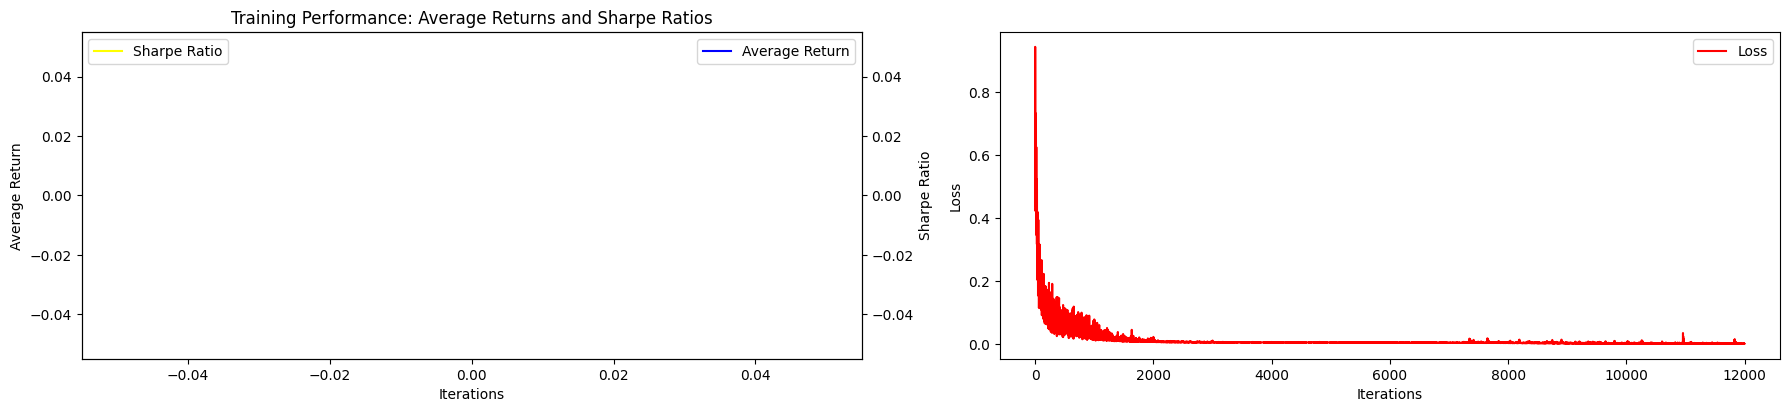

Eval for 25:   0%|          | 0/25 [00:00<?, ?it/s]

Eval for 25:   4%|▍         | 1/25 [00:10<04:21, 10.89s/it]

Eval for 25:   8%|▊         | 2/25 [00:12<02:00,  5.23s/it]

Eval for 25:  12%|█▏        | 3/25 [00:13<01:14,  3.40s/it]

Eval for 25:  16%|█▌        | 4/25 [00:14<00:53,  2.55s/it]

Eval for 25:  20%|██        | 5/25 [00:15<00:42,  2.11s/it]

Eval for 25:  24%|██▍       | 6/25 [00:17<00:34,  1.83s/it]

Eval for 25:  28%|██▊       | 7/25 [00:18<00:29,  1.65s/it]

Eval for 25:  32%|███▏      | 8/25 [00:19<00:25,  1.52s/it]

Eval for 25:  36%|███▌      | 9/25 [00:21<00:23,  1.44s/it]

Eval for 25:  40%|████      | 10/25 [00:22<00:21,  1.41s/it]

Eval for 25:  44%|████▍     | 11/25 [00:23<00:19,  1.37s/it]

Eval for 25:  48%|████▊     | 12/25 [00:24<00:17,  1.32s/it]

Eval for 25:  52%|█████▏    | 13/25 [00:26<00:15,  1.30s/it]

Eval for 25:  56%|█████▌    | 14/25 [00:27<00:14,  1.31s/it]

Eval for 25:  60%|██████    | 15/25 [00:28<00:13,  1.32s/it]

Eval for 25:  64%|██████▍   | 16/25 [00:30<00:11,  1.29s/it]

Eval for 25:  68%|██████▊   | 17/25 [00:31<00:10,  1.25s/it]

Eval for 25:  72%|███████▏  | 18/25 [00:32<00:08,  1.25s/it]

Eval for 25:  76%|███████▌  | 19/25 [00:33<00:07,  1.27s/it]

Eval for 25:  80%|████████  | 20/25 [00:34<00:06,  1.26s/it]

Eval for 25:  84%|████████▍ | 21/25 [00:36<00:04,  1.24s/it]

Eval for 25:  88%|████████▊ | 22/25 [00:37<00:03,  1.23s/it]

Eval for 25:  92%|█████████▏| 23/25 [00:38<00:02,  1.23s/it]

Eval for 25:  96%|█████████▌| 24/25 [00:39<00:01,  1.25s/it]

Eval for 25: 100%|██████████| 25/25 [00:41<00:00,  1.24s/it]

Eval for 25: 100%|██████████| 25/25 [00:41<00:00,  1.64s/it]

In [11]:
def train():
  with strategy.scope():
    loss = sim.train()
    sim.plot_performance(loss)
    sim.eval_metrics(25)
# Uncomment this for a new run to remove previously saved policies and checkpoints
sim.clear_directories()
train()

In [12]:
with strategy.scope():
    sim.load_and_eval_policy(policy_path=MODELS_PATH)

Eval for 25:   0%|          | 0/25 [00:00<?, ?it/s]

Eval for 25:   4%|▍         | 1/25 [00:01<00:36,  1.52s/it]

Eval for 25:   8%|▊         | 2/25 [00:02<00:32,  1.41s/it]

Eval for 25:  12%|█▏        | 3/25 [00:04<00:28,  1.31s/it]

Eval for 25:  16%|█▌        | 4/25 [00:05<00:26,  1.27s/it]

Eval for 25:  20%|██        | 5/25 [00:06<00:25,  1.27s/it]

Eval for 25:  24%|██▍       | 6/25 [00:07<00:24,  1.28s/it]

Eval for 25:  28%|██▊       | 7/25 [00:09<00:22,  1.27s/it]

Eval for 25:  32%|███▏      | 8/25 [00:10<00:21,  1.25s/it]

Eval for 25:  36%|███▌      | 9/25 [00:11<00:19,  1.23s/it]

Eval for 25:  40%|████      | 10/25 [00:12<00:18,  1.24s/it]

Eval for 25:  44%|████▍     | 11/25 [00:14<00:17,  1.25s/it]

Eval for 25:  48%|████▊     | 12/25 [00:15<00:16,  1.25s/it]

Eval for 25:  52%|█████▏    | 13/25 [00:16<00:14,  1.24s/it]

Eval for 25:  56%|█████▌    | 14/25 [00:17<00:13,  1.22s/it]

Eval for 25:  60%|██████    | 15/25 [00:18<00:12,  1.23s/it]

Eval for 25:  64%|██████▍   | 16/25 [00:20<00:11,  1.27s/it]

Eval for 25:  68%|██████▊   | 17/25 [00:21<00:10,  1.25s/it]

Eval for 25:  72%|███████▏  | 18/25 [00:22<00:08,  1.24s/it]

Eval for 25:  76%|███████▌  | 19/25 [00:23<00:07,  1.23s/it]

Eval for 25:  80%|████████  | 20/25 [00:25<00:06,  1.22s/it]

Eval for 25:  84%|████████▍ | 21/25 [00:26<00:05,  1.27s/it]

Eval for 25:  88%|████████▊ | 22/25 [00:27<00:03,  1.25s/it]

Eval for 25:  92%|█████████▏| 23/25 [00:28<00:02,  1.23s/it]

Eval for 25:  96%|█████████▌| 24/25 [00:30<00:01,  1.22s/it]

Eval for 25: 100%|██████████| 25/25 [00:31<00:00,  1.22s/it]

Eval for 25: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

Average Return = -0.0005299836630001664, Total Return = -0.2983834743499756, Sharpe = -0.02547622285783291


In [13]:
test_env.get_trade_stats()

{'Annualized Return': -0.005967066163170061,
 'Annualized Vol': 0.06987444992524215,
 'Sharpe Ratio': -0.7850731079191418,
 'Downside Deviation': 0.1678177254401072,
 'Sortino Ratio': -0.027240145731073844,
 'Max Drawdown': 0.0,
 'Max Drawdown Days': 347,
 'Trade Churn': 0.0,
 'Skewness': -1.0887682455894974,
 'Kurtosis': 50.378732823921695}

Live episode started...


Steps executed: 0it [00:00, ?it/s]

Steps executed: 10it [00:00, 99.06it/s]

Steps executed: 34it [00:00, 177.89it/s]

Steps executed: 58it [00:00, 204.98it/s]

Steps executed: 82it [00:00, 218.04it/s]

Steps executed: 106it [00:00, 225.60it/s]

Steps executed: 132it [00:00, 235.60it/s]

Steps executed: 158it [00:00, 242.47it/s]

Steps executed: 184it [00:00, 247.47it/s]

Steps executed: 210it [00:00, 248.67it/s]

Steps executed: 236it [00:01, 251.01it/s]

Steps executed: 262it [00:01, 252.42it/s]

Steps executed: 288it [00:01, 251.96it/s]

Steps executed: 314it [00:01, 250.95it/s]

Steps executed: 340it [00:01, 253.30it/s]

Steps executed: 366it [00:01, 249.51it/s]

Steps executed: 392it [00:01, 251.68it/s]

Steps executed: 418it [00:01, 250.31it/s]

Steps executed: 444it [00:01, 250.31it/s]

Steps executed: 470it [00:01, 251.36it/s]

...Live episode finished


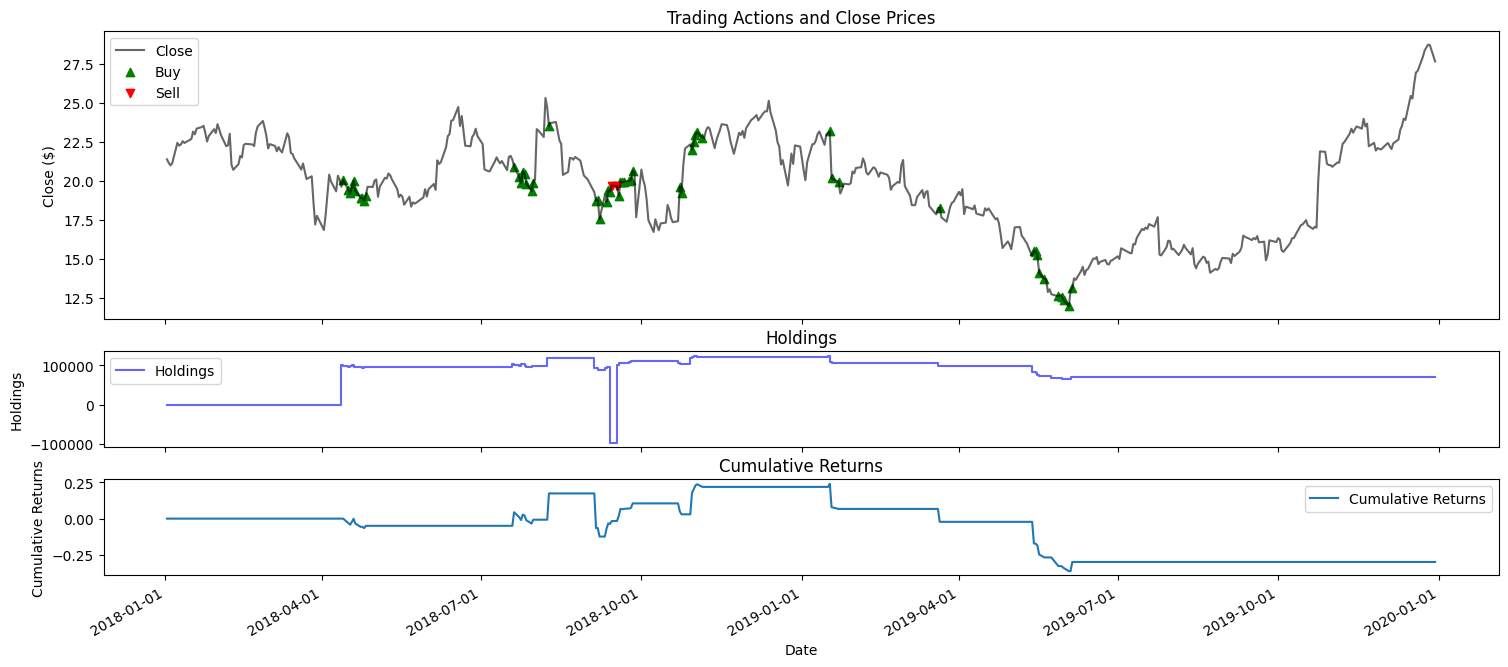

Steps executed: 471it [00:02, 165.74it/s]

In [14]:
data = sim.plot_returns_and_actions()

In [15]:
data

,Open,High,Low,Close,Adj Close,Volume,Price Raw,Sharpe,Position,Action,Holdings,Cash,Money,Returns,Cumulative_Returns
Date,,,,,,,,,,,,,,,
2018-01-02,0.515557,0.544705,0.537416,0.561813,21.368668,0.060499,21.368668,0,0,1,0.000000,100000.000000,100000.000000,0.0,0.000000
2018-01-03,0.551004,0.557334,0.555663,0.548796,21.150000,0.065928,21.150000,0,0,1,0.000000,100000.000000,100000.000000,0.0,0.000000
2018-01-04,0.518984,0.530387,0.516081,0.538358,20.974667,0.239888,20.974667,0,0,1,0.000000,100000.000000,100000.000000,0.0,0.000000
2018-01-05,0.533753,0.525118,0.541426,0.546136,21.105333,0.068163,21.105333,0,0,1,0.000000,100000.000000,100000.000000,0.0,0.000000
2018-01-08,0.531312,0.604674,0.555462,0.624836,22.427334,0.237102,22.427334,0,0,1,0.000000,100000.000000,100000.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,0.908547,0.946507,0.934432,0.953487,27.948000,0.348062,27.948000,0,1,1,70156.417714,5.234394,70161.652108,0.0,-0.298383
2019-12-24,0.934462,0.960423,0.945220,0.977418,28.350000,0.179229,28.350000,0,1,1,70156.417714,5.234394,70161.652108,0.0,-0.298383
2019-12-26,0.972076,0.992640,1.000000,1.000000,28.729334,0.261938,28.729334,0,1,1,70156.417714,5.234394,70161.652108,0.0,-0.298383


# Conclusion

In this article we have adapted Deep Q-Network (TDQN) algorithm from *Théate, Thibaut and Ernst, Damien (2021)*, using our signals and Tensorflow's Agent framework. Our agent can now determine optimal trading positions (buy, sell, or hold) to maximize our portfolio returns in a simulated environment.

## References

- [A Random Walk Down Wall Street](https://www.amazon.co.uk/Random-Walk-Down-Wall-Street/dp/0393330338)
- [TensorFlow Agents](https://www.tensorflow.org/agents/overview)
- [Open Gym AI Github](https://github.com/openai/gym)
- [Greg et al, OpenAI Gym, (2016)](https://arxiv.org/abs/1606.01540)
- [Théate, Thibaut, and Damien Ernst. "An application of deep reinforcement learning to algorithmic trading." Expert Systems with Applications 173 (2021): 114632.](https://www.sciencedirect.com/science/article/pii/S0957417421000737)
- [Remote development in WSL](https://code.visualstudio.com/docs/remote/wsl-tutorial)
- [NVIDIA Driver Downloads](https://www.nvidia.com/Download/index.aspx)
- [CUDA Toolkit](https://developer.nvidia.com/cuda-toolkit-archive)
- [TensorRT for CUDA](https://docs.nvidia.com/deeplearning/tensorrt/archives/index.html#trt_7)
- [Momentum and Reversion Trading Signals Analysis](https://medium.com/call-for-atlas/momentum-and-reversion-the-poor-mans-trading-strategies-9b8e1e6d3496)
- [Temporal Convolutional Neural Network with Conditioning for Broad Market Signals](https://medium.com/call-for-atlas/temporal-convolutional-neural-network-with-conditioning-for-broad-market-signals-9f0b0426b2b9)
- [Pandas TA - A Technical Analysis Library in Python 3](https://github.com/twopirllc/pandas-ta)

## Github

Article here is also available on [Github](https://github.com/adamd1985/pairs_trading_unsupervised_learning)

Kaggle notebook available [here](https://www.kaggle.com/code/addarm/deep-q-rl-with-algorithmic-trading-policy)

Google Collab available [here](https://colab.research.google.com/drive/1FTj65b2DA8oFgvmmjLc0XIwtII32PwcM?usp=sharing)

## Media

All media used (in the form of code or images) are either solely owned by me, acquired through licensing, or part of the Public Domain and granted use through Creative Commons License.

## CC Licensing and Use

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.